# Introduction

We tackle the problem of OCR post processing. In OCR, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. The adaptation involves:

- Adapt to spelling correction, on char level
- Pre-train on a noisy, medical sentences
- Fine tune a residual, to correct the mistakes of tesseract 
- Limit the input and output sequence lengths
- Enusre teacher forcing auto regressive model in the decoder
- Limit the padding per batch
- Learning rate schedule
- Bi-directional LSTM Encoder
- Bi-directional GRU Encoder


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index] + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def load_medical_terms_with_noise(json_file, num_samples, noise_threshold):
    with open(json_file) as f:
        med_terms_dict = json.load(f)
    med_terms = list(med_terms_dict.keys())
    input_texts = []
    gt_texts = []
    target_texts = []
    cnt = 0
    while cnt < num_samples:
        for term in med_terms:
            if cnt < num_samples :
                input_text = noise_maker(term, noise_threshold)
                input_text = input_text[:-1]   

                target_text = '\t' + term + '\n'

                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])        
                cnt += 1
    return input_texts, target_texts, gt_texts, med_terms_dict

In [10]:
def load_accidents_terms_with_noise(file_name, limit, num_samples, noise_threshold):

    f = open(file_name, encoding='utf8')
    line = 0    
    med_terms = []
    try:
        for r in f:
            if(line < limit):

                med_terms.extend(r.split('|'))
                line += 1
    except:
        print('finished')
    input_texts = []
    gt_texts = []
    target_texts = []
    cnt = 0
    while cnt < num_samples:
        for term in med_terms:
            if cnt < num_samples :
                input_text = noise_maker(term, noise_threshold)
                input_text = input_text[:-1]   

                target_text = '\t' + term + '\n'

                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])        
                cnt += 1
                
    return input_texts, target_texts, gt_texts

In [ ]:
def load_procedures_tests_with_noise(file_name, num_samples, noise_threshold):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                
                input_text = noise_maker(row, noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            

                cnt += 1
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [11]:
def build_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [12]:
def vectorize_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t] = vocab_to_int[char]
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = vocab_to_int[char]
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [13]:
def decode_gt_sequence(input_seq, int_to_vocab):

    stop_condition = False
    decoded_sentence = ''
    for i in range(input_seq.shape[1]):
        
        # Sample a token
        sampled_token_index = input_seq[0][i]
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

    return decoded_sentence


In [14]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []
    i = 0
    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
        orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        


        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        
        i += 1
        if(i > 48):
            i = 0
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [15]:
def build_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

In [16]:
def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, char in enumerate(text):
        # c0..cn
        encoder_input_data[0, t] = vocab_to_int[char]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in decoded_sentence])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

# Load data

In [17]:
data_path = '../../dat/'

In [18]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [19]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [20]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [21]:
## Histogram of lenghts
lengths = []
for text in input_texts:
    lengths.append(len(text))
    lengths.append(len(text))

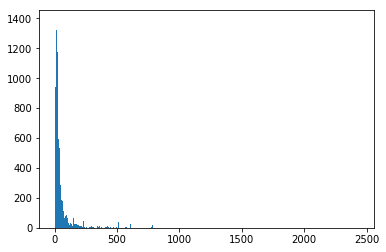

In [22]:
h = plt.hist(lengths, bins=500)

In [23]:
h[0]

array([ 1180.,   940.,  1384.,  1322.,  1174.,   722.,   592.,   536.,
         332.,   286.,   242.,   186.,   180.,   214.,   112.,   154.,
          68.,    82.,    58.,    88.,    70.,    64.,    32.,    30.,
          20.,    26.,    32.,    24.,    58.,    14.,    64.,     6.,
          28.,    16.,    24.,    28.,     8.,    18.,    14.,    18.,
          12.,    24.,    14.,    28.,    14.,     4.,    12.,    44.,
           4.,     6.,     2.,     4.,     6.,     0.,    36.,     0.,
           4.,     4.,     8.,     6.,    14.,     8.,     8.,     8.,
           2.,     0.,     6.,     2.,     2.,     4.,    12.,    14.,
           8.,    12.,     6.,     0.,     4.,     4.,     2.,     0.,
           2.,     0.,     4.,     6.,     0.,     4.,    14.,    26.,
           4.,     0.,     2.,     4.,     4.,     2.,     4.,     2.,
           6.,     0.,     2.,     2.,     2.,     6.,     4.,     2.,
          40.,     4.,     0.,     0.,     2.,     0.,     0.,     0.,
      

In [24]:
h[1]

array([    0.   ,     4.878,     9.756,    14.634,    19.512,    24.39 ,
          29.268,    34.146,    39.024,    43.902,    48.78 ,    53.658,
          58.536,    63.414,    68.292,    73.17 ,    78.048,    82.926,
          87.804,    92.682,    97.56 ,   102.438,   107.316,   112.194,
         117.072,   121.95 ,   126.828,   131.706,   136.584,   141.462,
         146.34 ,   151.218,   156.096,   160.974,   165.852,   170.73 ,
         175.608,   180.486,   185.364,   190.242,   195.12 ,   199.998,
         204.876,   209.754,   214.632,   219.51 ,   224.388,   229.266,
         234.144,   239.022,   243.9  ,   248.778,   253.656,   258.534,
         263.412,   268.29 ,   273.168,   278.046,   282.924,   287.802,
         292.68 ,   297.558,   302.436,   307.314,   312.192,   317.07 ,
         321.948,   326.826,   331.704,   336.582,   341.46 ,   346.338,
         351.216,   356.094,   360.972,   365.85 ,   370.728,   375.606,
         380.484,   385.362,   390.24 ,   395.118, 

In [25]:
max_sent_len =  h[1][np.argmax(h[0])]
min_sent_len = h[1][1]
print('Most probable length = ', max_sent_len)
print('Count of most probable lenght = ', np.max(h[0]))
print('Min length = ', min_sent_len)

Most probable length =  9.756
Count of most probable lenght =  1384.0
Min length =  4.878


In [26]:
max_sent_len =  50#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [27]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  50
Min length =  4


In [28]:
num_samples = 1000000

tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR_tess, target_texts_tess, gt_tess = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

num_samples = 0
OCR_data = os.path.join(data_path, 'output_handwritten.txt')
input_texts_OCR_hand, target_texts_OCR_hand, gt_texts_OCR_hand = load_data_with_gt(OCR_data, num_samples, max_sent_len, min_sent_len, delimiter='|',gt_index=0, prediction_index=1)

In [29]:
#input_texts = input_texts_OCR
#target_texts = target_texts_OCR
input_texts_OCR = input_texts_OCR_tess + input_texts_OCR_hand
target_texts_OCR = target_texts_tess + target_texts_OCR_hand


In [30]:
len(input_texts_OCR)

3579

# Results of pre-training on generic data

In [31]:
'''
num_samples = 0
big_data = os.path.join(data_path, 'big.txt')
threshold = 0.9
input_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
'''                                                                 

"\nnum_samples = 0\nbig_data = os.path.join(data_path, 'big.txt')\nthreshold = 0.9\ninput_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, \n                                                                 num_samples=num_samples, \n                                                                 noise_threshold=threshold, \n                                                                 max_sent_len=max_sent_len, \n                                                                 min_sent_len=min_sent_len)\n"

In [32]:
#input_texts = input_texs_gen
#target_texts = target_texts_gen

# Results on noisy tesseract corrections

In [33]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)

In [34]:
'''
input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR
'''

'\ninput_texts = input_texts_noisy_OCR\ntarget_texts = target_texts_noisy_OCR\n'

# Results on merge of tesseract correction + generic data

In [35]:
'''
input_texts = input_texts_OCR + input_texts_gen
target_texts = input_texts_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_OCR + input_texts_gen\ntarget_texts = input_texts_OCR + target_texts_gen\n'

# Results noisy tesseract correction + generic data

In [36]:
'''
input_texts = input_texts_noisy_OCR + input_texts_gen
target_texts = input_texts_noisy_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_noisy_OCR + input_texts_gen\ntarget_texts = input_texts_noisy_OCR + target_texts_gen\n'

# Results noisy tesseract noisy + correction data

In [37]:
input_texts = input_texts_noisy_OCR + input_texts_OCR
target_texts = target_texts_noisy_OCR + target_texts_OCR

# Results of pre-training on generic and fine tuning on tesseract correction

In [38]:
# TODO

# Load Medical Terms dictionary

In [39]:
json_file = os.path.join(data_path, 'abbrevs.json')
threshold = 0.9
num_samples = 2000
input_texts_MedTerms, target_texts_MedTerms, _, med_terms_dict = load_medical_terms_with_noise(json_file, num_samples, threshold)

In [40]:
print(med_terms_dict)

{'det.': 'let it be given', 'p.v.': 'through the vagina', 'PT': 'prothrombin time', 'Ta': 'tantalum', 'lat': 'lateral', 'BCG': 'bacille Calmette-Guérin', 'MM': 'mucous membrane', 'AK': 'above the knee', 'a.c., ac': 'before a meal', 'KI': 'potassium iodine', 'cg': 'centigram', 'mEq': 'milliequivalent', 'sol': 'solution, dissolved', 'PEFR': 'peak expiratory flow rate', 'MI': 'myocardial infarction', 'BMS': 'bone marrow suppression', 'TPI': '', 'EPS': 'extrapyramidal symptoms', 'O.S.': 'left eye', 'LUE': 'left upper extremity', 'ECG': 'electrocardiogram, electrocardiograph', 'S.E.': 'standard error', 'q.v.': 'as much as you please', 'ECMO': 'extracorporeal membrane oxygenation', 'ACLS': 'advanced cardiac life support', 'PND': 'paroxysmal nocturnal dyspnea', 'ASC-US': 'atypical squamous cells of undetermined significance', 'UV': 'ultraviolet', 'MDI': 'metered-dose inhaler', 'b.i.n.': 'twice a night', 'LLL': 'left lower lobe', 'ad sat.': 'to saturation', 'EIA': 'enzyme immunosorbent assay',

In [41]:
input_texts += input_texts_MedTerms
target_texts += target_texts_MedTerms

# Load accident terms

In [42]:
file_name = os.path.join(data_path, 'AccidentsL.txt')
threshold = 0.9
num_samples = 2000
limit = 100
input_texts_AccTerms, target_texts_AccTerms, _ = load_accidents_terms_with_noise(file_name, limit, num_samples, threshold)

finished


In [43]:
input_texts += input_texts_AccTerms
target_texts += target_texts_AccTerms

# Load procedures and tests

In [ ]:
file_name = os.path.join(data_path, 'procedures_tests.txt')
threshold = 0.9
num_samples = 2000
input_texts_ProcTests, target_texts_ProcTests, _ = load_procedures_tests_with_noise(file_name, num_samples, noise_threshold)

In [ ]:
input_texts += input_texts_ProcTests
target_texts += target_texts_ProcTests

In [44]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

17579
Clmi Type: VBAcciwdent - Aucpcidental njruy 
 	Claim Type: VB Accident - Accidental Injury


Policyholder/Owner Information 
 	Policyholder/Owner Information


First Name: 
 	First Name:


Midlde Nae/Iniial: 
 	Middle Name/Initial:


Last Name: 
 	Last Name:


oScial SeucrityN umebr: 
 	Social Security Number:


Birth Date: 
 	Birth Date:


Genderu: 
 	Gender:


aLnguage Preference: 
 	Language Preference:


Addrexssine 1: 
 	Address Line 1:




## Build vocab

In [45]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab', vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [46]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [47]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 17579
Number of unique input tokens: 118
Number of unique output tokens: 118
Max sequence length for inputs: 299
Max sequence length for outputs: 300


In [48]:
vocab_to_int # Some special chars need to be removed TODO: Data cleaning

{'\t': 2,
 '\n': 3,
 ' ': 1,
 '!': 108,
 '"': 95,
 '#': 67,
 '$': 80,
 '%': 85,
 '&': 73,
 "'": 83,
 '(': 63,
 ')': 64,
 '*': 77,
 '+': 76,
 ',': 69,
 '-': 21,
 '.': 48,
 '/': 29,
 '0': 54,
 '1': 43,
 '2': 53,
 '3': 57,
 '4': 66,
 '5': 74,
 '6': 55,
 '7': 70,
 '8': 60,
 '9': 72,
 ':': 13,
 ';': 75,
 '<': 110,
 '=': 94,
 '?': 59,
 '@': 81,
 'A': 16,
 'B': 15,
 'C': 4,
 'D': 40,
 'E': 45,
 'F': 33,
 'G': 41,
 'H': 52,
 'I': 22,
 'J': 68,
 'K': 50,
 'L': 37,
 'M': 36,
 'N': 35,
 'O': 30,
 'P': 26,
 'Q': 78,
 'R': 46,
 'S': 38,
 'T': 9,
 'U': 49,
 'UNK': 0,
 'V': 14,
 'W': 51,
 'X': 79,
 'Y': 47,
 'Z': 71,
 '[': 91,
 '\\': 97,
 ']': 92,
 '^': 86,
 '_': 101,
 'a': 6,
 'b': 39,
 'c': 17,
 'd': 18,
 'e': 12,
 'f': 32,
 'g': 42,
 'h': 28,
 'i': 7,
 'j': 23,
 'k': 58,
 'l': 5,
 'm': 8,
 'n': 19,
 'o': 27,
 'p': 11,
 'q': 56,
 'r': 25,
 's': 34,
 't': 20,
 'u': 24,
 'v': 44,
 'w': 31,
 'x': 61,
 'y': 10,
 'z': 62,
 '{': 111,
 '|': 82,
 '}': 104,
 '~': 107,
 '£': 116,
 '§': 112,
 '«': 114,
 '®': 

In [49]:
int_to_vocab

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'C',
 5: 'l',
 6: 'a',
 7: 'i',
 8: 'm',
 9: 'T',
 10: 'y',
 11: 'p',
 12: 'e',
 13: ':',
 14: 'V',
 15: 'B',
 16: 'A',
 17: 'c',
 18: 'd',
 19: 'n',
 20: 't',
 21: '-',
 22: 'I',
 23: 'j',
 24: 'u',
 25: 'r',
 26: 'P',
 27: 'o',
 28: 'h',
 29: '/',
 30: 'O',
 31: 'w',
 32: 'f',
 33: 'F',
 34: 's',
 35: 'N',
 36: 'M',
 37: 'L',
 38: 'S',
 39: 'b',
 40: 'D',
 41: 'G',
 42: 'g',
 43: '1',
 44: 'v',
 45: 'E',
 46: 'R',
 47: 'Y',
 48: '.',
 49: 'U',
 50: 'K',
 51: 'W',
 52: 'H',
 53: '2',
 54: '0',
 55: '6',
 56: 'q',
 57: '3',
 58: 'k',
 59: '?',
 60: '8',
 61: 'x',
 62: 'z',
 63: '(',
 64: ')',
 65: '’',
 66: '4',
 67: '#',
 68: 'J',
 69: ',',
 70: '7',
 71: 'Z',
 72: '9',
 73: '&',
 74: '5',
 75: ';',
 76: '+',
 77: '*',
 78: 'Q',
 79: 'X',
 80: '$',
 81: '@',
 82: '|',
 83: "'",
 84: '•',
 85: '%',
 86: '^',
 87: '●',
 88: 'ﬁ',
 89: '”',
 90: '°',
 91: '[',
 92: ']',
 93: '–',
 94: '=',
 95: '"',
 96: '✓',
 97: '\\',
 98: 'α',
 99: '½',
 100:

In [50]:
len(int_to_vocab)

118

# Prepare training data

## Train/test split

In [51]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [52]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

In [53]:
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(14942, 299)
(14942, 300, 118)


## Test data

In [54]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [55]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [56]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_2/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(?, ?, 512), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 118)    13924       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
______________

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


# Training

In [57]:
batch_size = 64  # Batch size for training.
epochs = 50  
lr = 0.01

# Learning rate decay

In [58]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [59]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [60]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [61]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [62]:
#callbacks_list.append(lrate)

In [63]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 14942 samples, validate on 2637 samples
Epoch 1/50
14942/14942 [==============================] - 1402s 94ms/step - loss: 2.2357 - categorical_accuracy: 0.3778 - val_loss: 0.8676 - val_categorical_accuracy: 0.7294

Epoch 00001: val_categorical_accuracy improved from -inf to 0.72938, saving model to best_model.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
14942/14942 [==============================] - 1387s 93ms/step - loss: 0.4458 - categorical_accuracy: 0.8400 - val_loss: 0.3496 - val_categorical_accuracy: 0.8668

Epoch 00002: val_categorical_accuracy improved from 0.72938 to 0.86684, saving model to best_model.hdf5
Epoch 3/50
14942/14942 [==============================] - 1419s 95ms/step - loss: 0.2674 - categorical_accuracy: 0.8842 - val_loss: 0.2744 - val_categorical_accuracy: 0.8844

Epoch 00003: val_categorical_accuracy improved from 0.86684 to 0.88435, saving model to best_model.hdf5
Epoch 4/50
14942/14942 [==============================] - 1441s 96ms/step - loss: 0.1996 - categorical_accuracy: 0.9002 - val_loss: 0.2705 - val_categorical_accuracy: 0.8869

Epoch 00004: val_categorical_accuracy improved from 0.88435 to 0.88693, saving model to best_model.hdf5
Epoch 5/50
14942/14942 [==============================] - 1440s 96ms/step - loss: 0.1619 - categorical_accuracy: 0.9088 - val_loss: 0.2414 - val_categorical_accura

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
encoder_model.save('encoder_model.hdf5')
decoder_model.save('decoder_model.hdf5')

In [65]:
#encoder_input_data[1:2][0]

In [66]:
#vocab_to_int

In [67]:
#decode_gt_sequence(encoder_input_data[5:6], int_to_vocab)

In [68]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: URTHDATLANTA LLC FAYETI'EVI LLE
GT sentence: ORTHOATLANTA LLC FAYETTEVILLE

Decoded sentence: Sor S Con C M Bich SENUEN NE
-
Input sentence: Language Preference:
GT sentence: Language Preference:

Decoded sentence: Inser Neq  ONEveris:
-
Input sentence: THANK YOU
GT sentence: THANK YOU

Decoded sentence: TIOREd M
-
Input sentence: Pay Online | Updaet Info
GT sentence: Pay Online | Update Info

Decoded sentence: HrElillontllbolly Nollo
-
Input sentence: Served mlitary las t12 mths - n

GT sentence: Served military last 12 mths - no

Decoded sentence: Serr  er   N B S Je 12  Ser -e  
-
Input sentence: Staet Pln: No
GT sentence: State Plan: No

Decoded sentence: Strt  Nol:N
-
Input sentence: Potsal Code:
GT sentence: Postal Code:

Decoded sentence: Powoc Nol C:
-
Input sentence: Provider Last Name: J ager
GT sentence: Provider Last Name: Jager

Decoded sentence: Prer Pary Sag S Bf:Bhy Phy
-
Input sentence: "01
GT sentence: "01"
Decoded sentence: "01
-
Input sentence: "07

-
Input sentence: 0 Take all medications as directed.
GT sentence: ● Take all medications as directed.

Decoded sentence: 0allall al al al al al  Hr Re.
-
Input sentence: Lef tshoculder:
GT sentence: Left shoulder:

Decoded sentence: Chr hi Pry P:
-
Input sentence: PenobscotCommunity Health Center 
GT sentence: Penobscot Community Health Center 

Decoded sentence: PhoUESiNThthThiathESTIN tENTiTEy
-
Input sentence: STATEMENT DATE
GT sentence: STATEMENT DATE

Decoded sentence: SDE DEFEF D
-
Input sentence: EE DDB:
GT sentence: EE DOB:

Decoded sentence: EEDEne:
-
Input sentence: T
GT sentence: Tx
Decoded sentence: TT
-
Input sentence: STATMEENT
GT sentence: STATEMENT

Decoded sentence: MAC Si 
-
Input sentence: Medi pecplty C Degree him
GT sentence: Medical Specialty Degree

Decoded sentence: IHERe  Nal al  ss Nol N
-
Input sentence: lHC
GT sentence: HCV
Decoded sentence: CCHCEN
-
Input sentence: R
GT sentence: RF
Decoded sentence: RR
-
Input sentence: tEmpoyer:g
GT sentence: Employer:



# Test on Medical Terms dictionary

In [69]:

input_texts = input_texts_MedTerms
target_texts = target_texts_MedTerms

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

-
Input sentence: det
GT sentence: det.
Decoded sentence: de
-
Input sentence: p.v
GT sentence: p.v.
Decoded sentence: p.
-
Input sentence: P
GT sentence: PT
Decoded sentence: PP
-
Input sentence: T
GT sentence: Ta
Decoded sentence: TT
-
Input sentence: la
GT sentence: lat
Decoded sentence: llag
-
Input sentence: BC
GT sentence: BCG
Decoded sentence: BCC
-
Input sentence: M
GT sentence: MM
Decoded sentence: MM
-
Input sentence: A
GT sentence: AK
Decoded sentence: AA
-
Input sentence: a.c., ga
GT sentence: a.c., ac
Decoded sentence: R.t.,F D
-
Input sentence: K
GT sentence: KI
Decoded sentence: KA
-
Input sentence: c
GT sentence: cg
Decoded sentence: DA
-
Input sentence: mE
GT sentence: mEq
Decoded sentence: mER
-
Input sentence: so
GT sentence: sol
Decoded sentence: so
-
Input sentence: PEF
GT sentence: PEFR
Decoded sentence: P
-
Input sentence: M
GT sentence: MI
Decoded sentence: MM
-
Input sentence: BM
GT sentence: BMS
Decoded sentence: BMT
-
Input sentence: TP
GT sentence: TPI
Decod

-
Input sentence: G
GT sentence: GI
Decoded sentence: GH
-
Input sentence: Ci
GT sentence: CR
Decoded sentence: C
-
Input sentence: Ig
GT sentence: IgE
Decoded sentence: Igg
-
Input sentence: bp
GT sentence: bpm
Decoded sentence: b
-
Input sentence: B
GT sentence: BE
Decoded sentence: BB
-
Input sentence: MC
GT sentence: MCV
Decoded sentence: MCC
-
Input sentence: li
GT sentence: lig
Decoded sentence: lll
-
Input sentence: NG
GT sentence: NGT
Decoded sentence: NGA
-
Input sentence: SD
GT sentence: S.D.
Decoded sentence: SDD
-
Input sentence: ult. prae
GT sentence: ult. praes.
Decoded sentence: t .innt 
-
Input sentence: I
GT sentence: IV
Decoded sentence: II
-
Input sentence: SDA
GT sentence: SDAT
Decoded sentence: TDD
-
Input sentence: NR
GT sentence: NRC
Decoded sentence: NR
-
Input sentence: TNF
GT sentence: TNF-I
Decoded sentence: TWBN
-
Input sentence: CIs
GT sentence: CIS
Decoded sentence: Com
-
Input sentence: IC
GT sentence: ICD
Decoded sentence: ICS
-
Input sentence: A/C
GT se

-
Input sentence: LH
GT sentence: LH 
Decoded sentence: LLH
-
Input sentence: RU
GT sentence: RUQ
Decoded sentence: ARO
-
Input sentence: C&
GT sentence: C&S
Decoded sentence: C&S
-
Input sentence: asc
GT sentence: asc.
Decoded sentence: Pacacaaacaacacaacaacaacaaacaaca
-
Input sentence: B.P
GT sentence: B.P.
Decoded sentence: .
-
Input sentence: AM
GT sentence: AMI
Decoded sentence: AMA
-
Input sentence: A
GT sentence: AM
Decoded sentence: AA
-
Input sentence: AC
GT sentence: ACE
Decoded sentence: ACC
-
Input sentence: AL
GT sentence: ALP
Decoded sentence: ANP
-
Input sentence: LU
GT sentence: LUQ
Decoded sentence: LUL
-
Input sentence: 
GT sentence: VT
Decoded sentence: 
-
Input sentence: TN
GT sentence: TNM
Decoded sentence: TNT
-
Input sentence: LU
GT sentence: LUL
Decoded sentence: LUL
-
Input sentence: Hi
GT sentence: Hib
Decoded sentence: HS
-
Input sentence: BS
GT sentence: BSE
Decoded sentence: BBS
-
Input sentence: ACh
GT sentence: AChR
Decoded sentence: T
-
Input sentence: PV

-
Input sentence: C
GT sentence: CI
Decoded sentence: CV
-
Input sentence: W
GT sentence: WN
Decoded sentence: WW
-
Input sentence: pe
GT sentence: per
Decoded sentence: Ess
-
Input sentence: wD5
GT sentence: D5W
Decoded sentence: D5
-
Input sentence: S
GT sentence: Sn
Decoded sentence: Sx
-
Input sentence: ML
GT sentence: MLD
Decoded sentence: MLD
-
Input sentence: M
GT sentence: MD
Decoded sentence: MM
-
Input sentence: KV
GT sentence: KVO
Decoded sentence: KV
-
Input sentence: IFS
GT sentence: FISH
Decoded sentence: IIFE
-
Input sentence: M
GT sentence: MA
Decoded sentence: MM
-
Input sentence: SPECo
GT sentence: SPECT
Decoded sentence: SiEN
-
Input sentence: aPT
GT sentence: aPTT
Decoded sentence: dass
-
Input sentence: ADH
GT sentence: ADHD
Decoded sentence: ADD
-
Input sentence: HEP
GT sentence: HEPA
Decoded sentence: VER
-
Input sentence: S
GT sentence: Sr
Decoded sentence: Sx
-
Input sentence: TG
GT sentence: GTT
Decoded sentence: TAR
-
Input sentence: IL1
GT sentence: IL-1
Dec

-
Input sentence: N
GT sentence: Na
Decoded sentence: NN
-
Input sentence: onm. noc
GT sentence: omn. noct.
Decoded sentence: Pat. Sn 
-
Input sentence: B
GT sentence: ABG
Decoded sentence: BB
-
Input sentence: TP
GT sentence: TPO
Decoded sentence: TPP
-
Input sentence: Ao
GT sentence: Ao.
Decoded sentence: Aol
-
Input sentence: D5/0.o9 NaC
GT sentence: D5/0.9 NaCl
Decoded sentence: D5/0. 9CEl
-
Input sentence: UT
GT sentence: UTI
Decoded sentence: T
-
Input sentence: A
GT sentence: UA
Decoded sentence: AA
-
Input sentence: TI
GT sentence: TIA
Decoded sentence: TIR
-
Input sentence: Der
GT sentence: Derm
Decoded sentence: DXR
-
Input sentence: T
GT sentence: Th
Decoded sentence: TT
-
Input sentence: vol
GT sentence: vol.
Decoded sentence: omvvvll
-
Input sentence: NP
GT sentence: NPN
Decoded sentence: NP
-
Input sentence: LD
GT sentence: LDL
Decoded sentence: LLL
-
Input sentence: LW
GT sentence: LBW
Decoded sentence: LW
-
Input sentence: la
GT sentence: lab
Decoded sentence: llag
-
In

-
Input sentence: /
GT sentence: /d
Decoded sentence: /x
-
Input sentence: C
GT sentence: CVP
Decoded sentence: CV
-
Input sentence: NA
GT sentence: NAD
Decoded sentence: AKA
-
Input sentence: vol 
GT sentence: vol %
Decoded sentence: Col 
-
Input sentence: D
GT sentence: DIC
Decoded sentence: DD
-
Input sentence: dieb. alt
GT sentence: dieb. alt.
Decoded sentence: M R.lon
-
Input sentence: BC
GT sentence: CBT
Decoded sentence: BCC
-
Input sentence: B
GT sentence: Ba
Decoded sentence: BB
-
Input sentence: tnct., t
GT sentence: tinct., tr
Decoded sentence: I .,ng
-
Input sentence: S
GT sentence: SI
Decoded sentence: Sx
-
Input sentence: PC
GT sentence: PCR
Decoded sentence: PAC
-
Input sentence: O
GT sentence: OU
Decoded sentence: OO
-
Input sentence: CRES
GT sentence: CREST
Decoded sentence: CRTERER
-
Input sentence: P
GT sentence: PIP
Decoded sentence: PP
-
Input sentence: k
GT sentence: kg
Decoded sentence: kg
-
Input sentence: µE
GT sentence: µEq
Decoded sentence: µqq
-
Input senten

-
Input sentence: a.c., a
GT sentence: a.c., ac
Decoded sentence: a. .,  
-
Input sentence: K
GT sentence: KI
Decoded sentence: KA
-
Input sentence: g
GT sentence: cg
Decoded sentence: grg
-
Input sentence: mE
GT sentence: mEq
Decoded sentence: mER
-
Input sentence: so
GT sentence: sol
Decoded sentence: so
-
Input sentence: PEF
GT sentence: PEFR
Decoded sentence: P
-
Input sentence: M
GT sentence: MI
Decoded sentence: MM
-
Input sentence: BM
GT sentence: BMS
Decoded sentence: BMT
-
Input sentence: TP
GT sentence: TPI
Decoded sentence: TPP
-
Input sentence: ES
GT sentence: EPS
Decoded sentence: ESS
-
Input sentence: O.S
GT sentence: O.S.
Decoded sentence: O.S
-
Input sentence: UL
GT sentence: LUE
Decoded sentence: ULL
-
Input sentence: EC
GT sentence: ECG
Decoded sentence: ECG
-
Input sentence: S.E
GT sentence: S.E.
Decoded sentence: S.
-
Input sentence: q.v
GT sentence: q.v.
Decoded sentence: q.
-
Input sentence: ECM
GT sentence: ECMO
Decoded sentence: EMEs
-
Input sentence: pACpLn
GT 

-
Input sentence: lsi
GT sentence: lig
Decoded sentence: bomy
-
Input sentence: NsG
GT sentence: NGT
Decoded sentence: ND
-
Input sentence: S.D
GT sentence: S.D.
Decoded sentence: S.
-
Input sentence: ult.p rae.
GT sentence: ult. praes.
Decoded sentence: C&.us N.
-
Input sentence: I
GT sentence: IV
Decoded sentence: II
-
Input sentence: SDA
GT sentence: SDAT
Decoded sentence: TDD
-
Input sentence: NR
GT sentence: NRC
Decoded sentence: NR
-
Input sentence: TNF-
GT sentence: TNF-I
Decoded sentence: TNT-
-
Input sentence: CI
GT sentence: CIS
Decoded sentence: CIRIIII
-
Input sentence: IC
GT sentence: ICD
Decoded sentence: ICS
-
Input sentence: A/C
GT sentence: A/CA
Decoded sentence: A/NU
-
Input sentence: Cy
GT sentence: Co
Decoded sentence: CyC
-
Input sentence: PFP, P4
GT sentence: PFP, P4P
Decoded sentence: P S,
-
Input sentence: OC
GT sentence: OCD
Decoded sentence: OCO
-
Input sentence: PAC
GT sentence: PACU
Decoded sentence: PACCll
-
Input sentence: PUB
GT sentence: PUBS
Decoded sen

-
Input sentence: 
GT sentence: AM
Decoded sentence: 
-
Input sentence: mA
GT sentence: ACE
Decoded sentence: Am
-
Input sentence: AL
GT sentence: ALP
Decoded sentence: ANP
-
Input sentence: LU
GT sentence: LUQ
Decoded sentence: LUL
-
Input sentence: V
GT sentence: VT
Decoded sentence: VF
-
Input sentence: TN
GT sentence: TNM
Decoded sentence: TNT
-
Input sentence: LUk
GT sentence: LUL
Decoded sentence: Liv 
-
Input sentence: Hi
GT sentence: Hib
Decoded sentence: HS
-
Input sentence: BS
GT sentence: BSE
Decoded sentence: BBS
-
Input sentence: ACh
GT sentence: AChR
Decoded sentence: T
-
Input sentence: PV
GT sentence: PVC
Decoded sentence: POR
-
Input sentence: C
GT sentence: Cl
Decoded sentence: CV
-
Input sentence: liq
GT sentence: liq.
Decoded sentence: bSS
-
Input sentence: CD
GT sentence: CDC
Decoded sentence: CDD
-
Input sentence: TOR
GT sentence: TORB
Decoded sentence: TORUR
-
Input sentence: DO
GT sentence: DOA
Decoded sentence: DOB
-
Input sentence: E
GT sentence: EDD
Decoded s

-
Input sentence: KV
GT sentence: KVO
Decoded sentence: KV
-
Input sentence: FIS
GT sentence: FISH
Decoded sentence: FSAS
-
Input sentence: M
GT sentence: MA
Decoded sentence: MM
-
Input sentence: SPEC
GT sentence: SPECT
Decoded sentence: SPR
-
Input sentence: aPT
GT sentence: aPTT
Decoded sentence: dass
-
Input sentence: ADH
GT sentence: ADHD
Decoded sentence: ADD
-
Input sentence: HEP
GT sentence: HEPA
Decoded sentence: VER
-
Input sentence: S
GT sentence: Sr
Decoded sentence: Sx
-
Input sentence: GT
GT sentence: GTT
Decoded sentence: GGG
-
Input sentence: IL-
GT sentence: IL-1
Decoded sentence: V-
-
Input sentence: aMP
GT sentence: MPN
Decoded sentence: NaPO
-
Input sentence: mc
GT sentence: mcg
Decoded sentence: Prm
-
Input sentence: GRA
GT sentence: GRAS
Decoded sentence: GAR
-
Input sentence: FDt
GT sentence: FDA
Decoded sentence: FFR
-
Input sentence: alt. hor
GT sentence: alt. hor.
Decoded sentence: ot.ol No
-
Input sentence: N
GT sentence: NDC
Decoded sentence: NN
-
Input sent

-
Input sentence: UT
GT sentence: UTI
Decoded sentence: T
-
Input sentence: U
GT sentence: UA
Decoded sentence: UU
-
Input sentence: cTI
GT sentence: TIA
Decoded sentence: CiR
-
Input sentence: Dher
GT sentence: Derm
Decoded sentence: Dhres
-
Input sentence: T
GT sentence: Th
Decoded sentence: TT
-
Input sentence: o.
GT sentence: vol.
Decoded sentence: P.
-
Input sentence: NP
GT sentence: NPN
Decoded sentence: NP
-
Input sentence: LD
GT sentence: LDL
Decoded sentence: LLL
-
Input sentence: LW
GT sentence: LBW
Decoded sentence: LW
-
Input sentence: la
GT sentence: lab
Decoded sentence: llag
-
Input sentence: F
GT sentence: FP
Decoded sentence: FP
-
Input sentence: NM
GT sentence: NMDA
Decoded sentence: NMR
-
Input sentence: B
GT sentence: BP
Decoded sentence: BB
-
Input sentence: D
GT sentence: DC
Decoded sentence: DD
-
Input sentence: RAI
GT sentence: RAIU
Decoded sentence: TImL
-
Input sentence: BL
GT sentence: BLS
Decoded sentence: B
-
Input sentence: HA
GT sentence: AHF
Decoded sent

-
Input sentence: PC
GT sentence: PCR
Decoded sentence: PAC
-
Input sentence: O
GT sentence: OU
Decoded sentence: OO
-
Input sentence: RCES
GT sentence: CREST
Decoded sentence: E
-
Input sentence: PI
GT sentence: PIP
Decoded sentence: PhR
-
Input sentence: k
GT sentence: kg
Decoded sentence: kg
-
Input sentence: µE
GT sentence: µEq
Decoded sentence: µqq
-
Input sentence: VM
GT sentence: VMA
Decoded sentence: VMI
-
Input sentence: ES
GT sentence: ESR
Decoded sentence: ESS
-
Input sentence: S
GT sentence: Sb
Decoded sentence: Sx
-
Input sentence: S
GT sentence: Sx
Decoded sentence: Sx
-
Input sentence: H
GT sentence: Hg
Decoded sentence: Hz
-
Input sentence: CM
GT sentence: CMV
Decoded sentence: CMA
-
Input sentence: Phar
GT sentence: Pharm
Decoded sentence: Phrgh
-
Input sentence: As
GT sentence: AsM
Decoded sentence: PAs
-
Input sentence: ARMe
GT sentence: ARMD
Decoded sentence: ARR
-
Input sentence: HER
GT sentence: HER2
Decoded sentence: HRRLL
-
Input sentence: Id
GT sentence: Id.
De

-
Input sentence: ACS
GT sentence: ACLS
Decoded sentence: AAT
-
Input sentence: PN
GT sentence: PND
Decoded sentence: PNP
-
Input sentence: vASC-U
GT sentence: ASC-US
Decoded sentence: ES-
-
Input sentence: U
GT sentence: UV
Decoded sentence: UU
-
Input sentence: MD
GT sentence: MDI
Decoded sentence: MMD
-
Input sentence: b.i.n
GT sentence: b.i.n.
Decoded sentence: b.o.
-
Input sentence: LL
GT sentence: LLL
Decoded sentence: LLLL
-
Input sentence: ad sat
GT sentence: ad sat.
Decoded sentence: Dasod 
-
Input sentence: EI
GT sentence: EIA
Decoded sentence: EIF
-
Input sentence: dieb.t etr
GT sentence: dieb. tert.
Decoded sentence: R .or   E
-
Input sentence: BB
GT sentence: BBB
Decoded sentence: BBB
-
Input sentence: GnR
GT sentence: GnRH
Decoded sentence: GlI
-
Input sentence: T
GT sentence: TB
Decoded sentence: TT
-
Input sentence: RA
GT sentence: RAI
Decoded sentence: RAA
-
Input sentence: PxN
GT sentence: PNS
Decoded sentence: PHRD
-
Input sentence: D and 
GT sentence: D and C
Decode

-
Input sentence: M
GT sentence: NMS
Decoded sentence: MM
-
Input sentence: H
GT sentence: Hy
Decoded sentence: Hz
-
Input sentence: BR
GT sentence: BRM
Decoded sentence: BAT
-
Input sentence: O.D
GT sentence: O.D.
Decoded sentence: O.ED
-
Input sentence: p.r.n
GT sentence: p.r.n.
Decoded sentence: p.M.
-
Input sentence: ICp
GT sentence: ICU
Decoded sentence: IC
-
Input sentence: VGH
GT sentence: GVHD
Decoded sentence: V
-
Input sentence: R
GT sentence: RD
Decoded sentence: RR
-
Input sentence: D
GT sentence: DFV
Decoded sentence: DD
-
Input sentence: TP
GT sentence: TPR
Decoded sentence: TPP
-
Input sentence: ung
GT sentence: ung.
Decoded sentence: n
-
Input sentence: AIC
GT sentence: AICD
Decoded sentence: AR
-
Input sentence: ESW
GT sentence: ESWL
Decoded sentence: Emmm
-
Input sentence: d
GT sentence: dL
Decoded sentence: dc
-
Input sentence: RO
GT sentence: ROM
Decoded sentence: ROR
-
Input sentence: AB
GT sentence: ABO
Decoded sentence: ABs
-
Input sentence: M
GT sentence: Mg
Dec

-
Input sentence: CD
GT sentence: CDC
Decoded sentence: CDD
-
Input sentence: TOR
GT sentence: TORB
Decoded sentence: TORUR
-
Input sentence: DO
GT sentence: DOA
Decoded sentence: DOB
-
Input sentence: ED
GT sentence: EDD
Decoded sentence: EDD
-
Input sentence: PV
GT sentence: PVR
Decoded sentence: POR
-
Input sentence: DN
GT sentence: DNA
Decoded sentence: DNT
-
Input sentence: CB
GT sentence: CBI
Decoded sentence: CGC
-
Input sentence: MR
GT sentence: MRI
Decoded sentence: MR
-
Input sentence: T
GT sentence: Tl
Decoded sentence: TT
-
Input sentence: A-
GT sentence: A-P
Decoded sentence: A-C
-
Input sentence: p
GT sentence: pH
Decoded sentence: po
-
Input sentence: M
GT sentence: MG
Decoded sentence: MM
-
Input sentence: M
GT sentence: MS
Decoded sentence: MM
-
Input sentence: PC
GT sentence: PCA
Decoded sentence: PAC
-
Input sentence: DO
GT sentence: DOB
Decoded sentence: DOB
-
Input sentence: FA
GT sentence: FAP
Decoded sentence: FSl
-
Input sentence: N
GT sentence: NS
Decoded sente

# Visualize attention

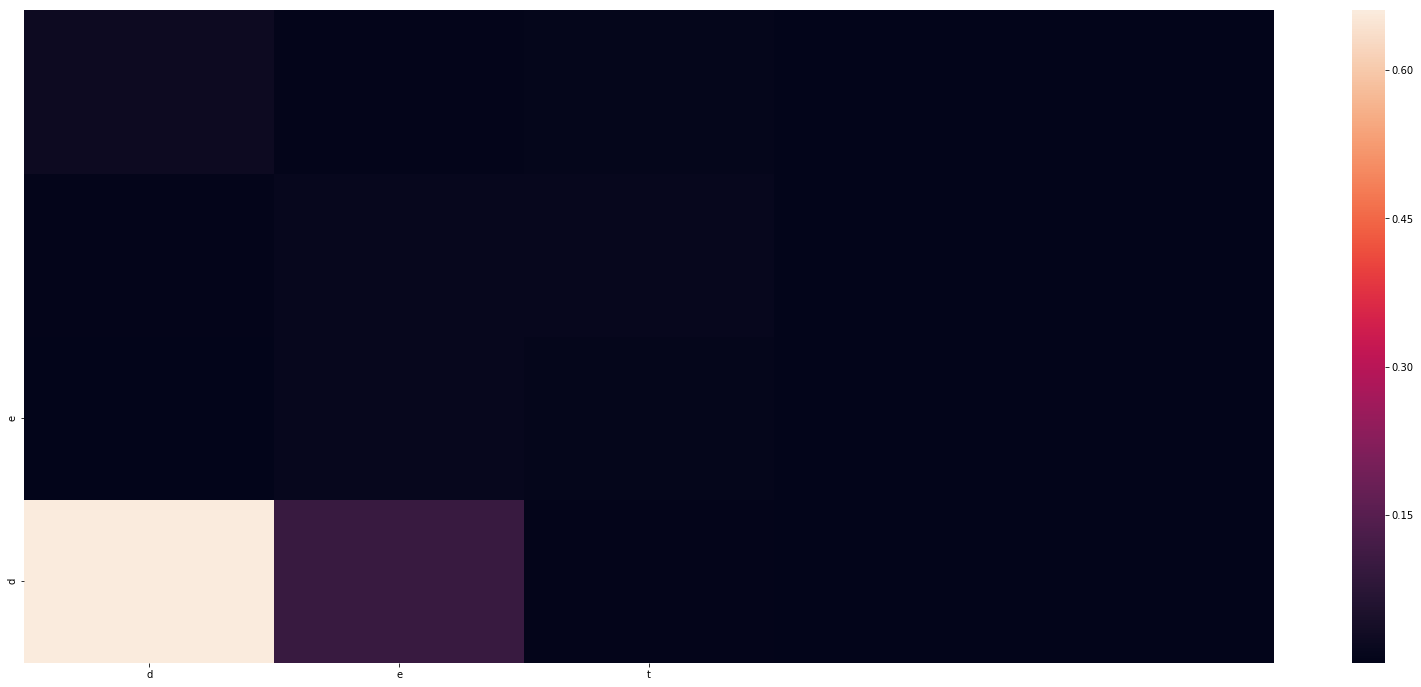

-
Input sentence: det
GT sentence: det.
Decoded sentence: de


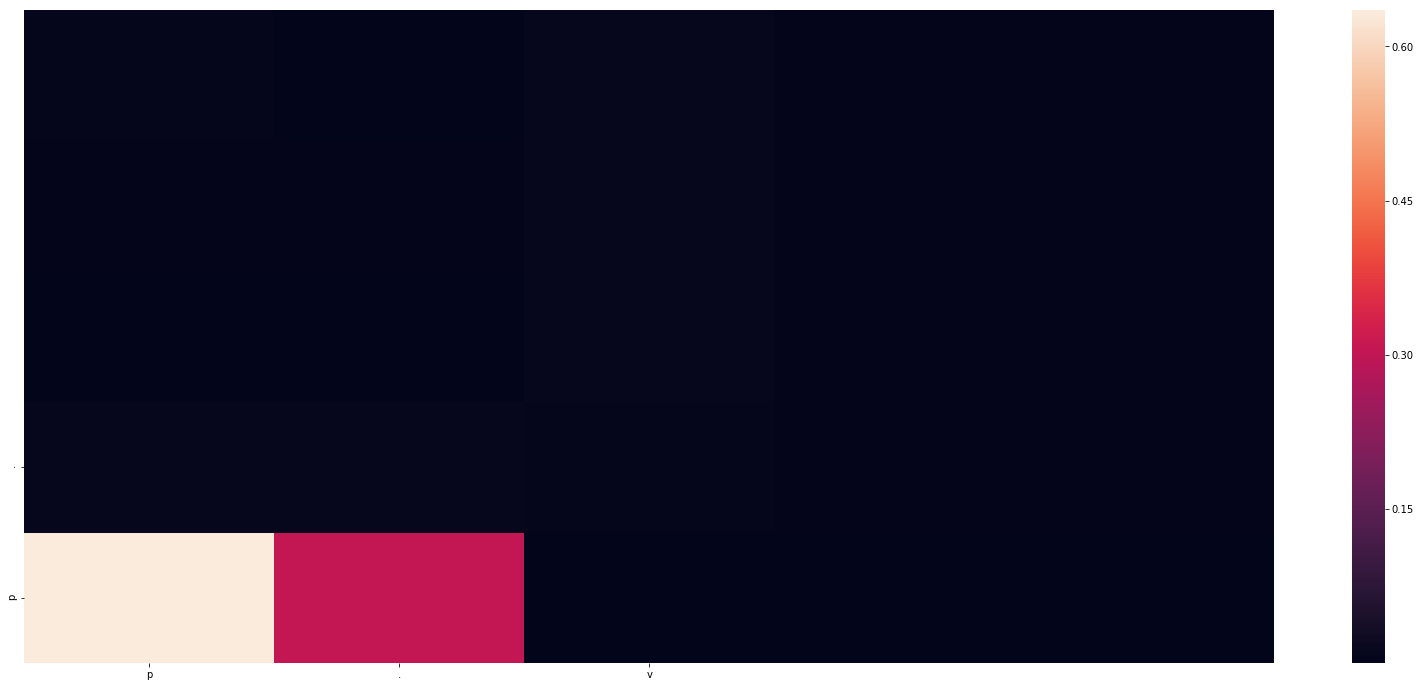

-
Input sentence: p.v
GT sentence: p.v.
Decoded sentence: p.


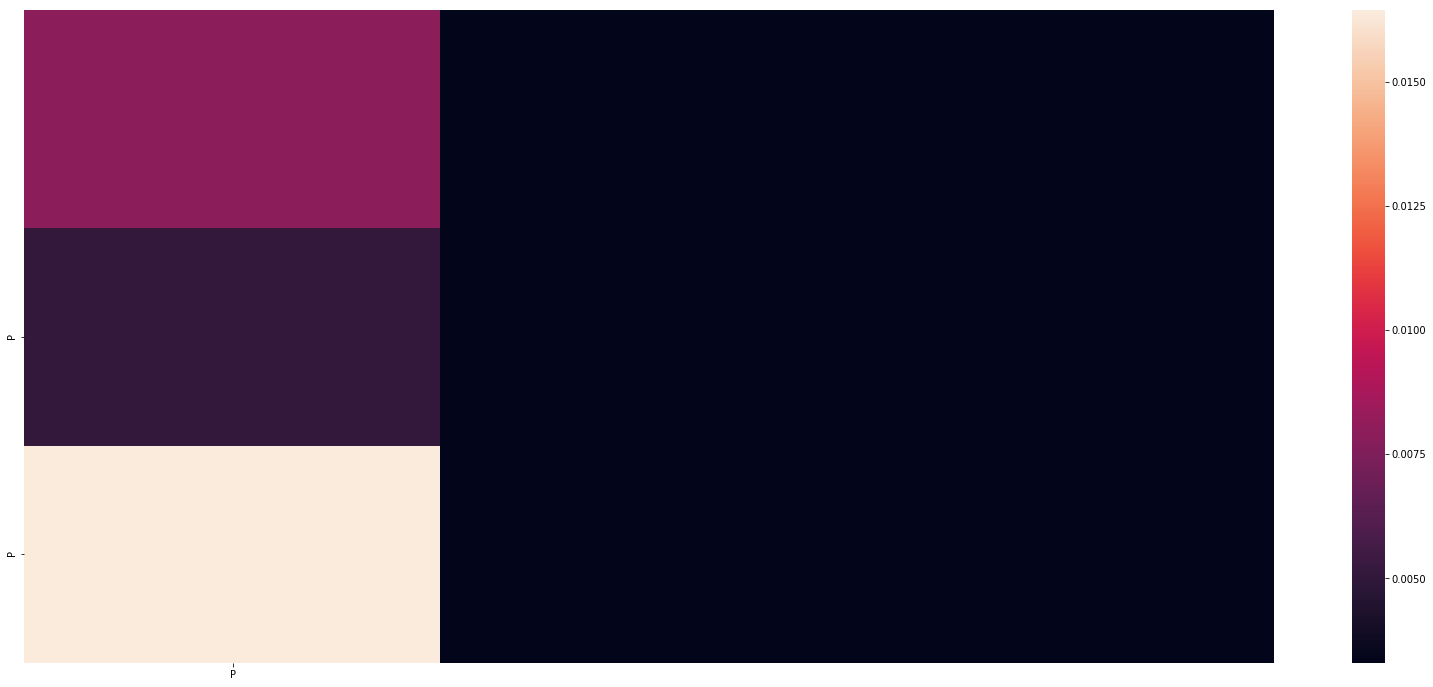

-
Input sentence: P
GT sentence: PT
Decoded sentence: PP


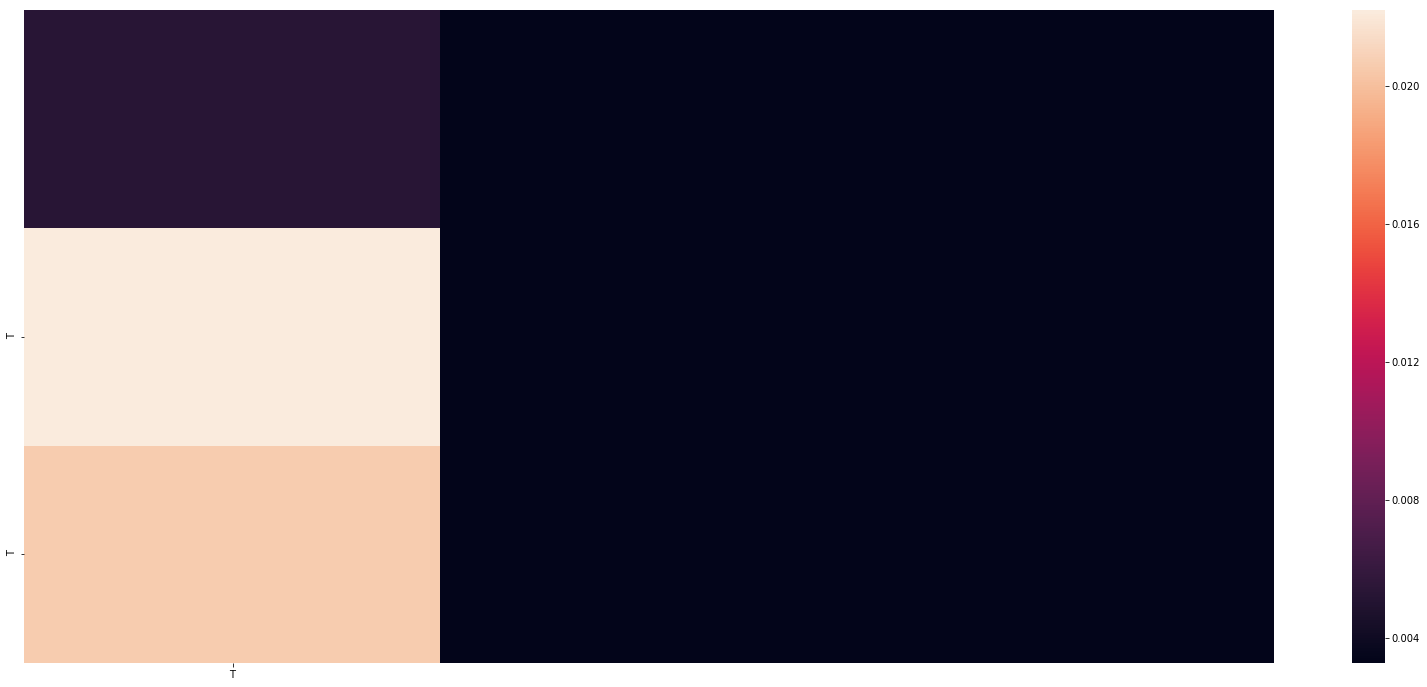

-
Input sentence: T
GT sentence: Ta
Decoded sentence: TT


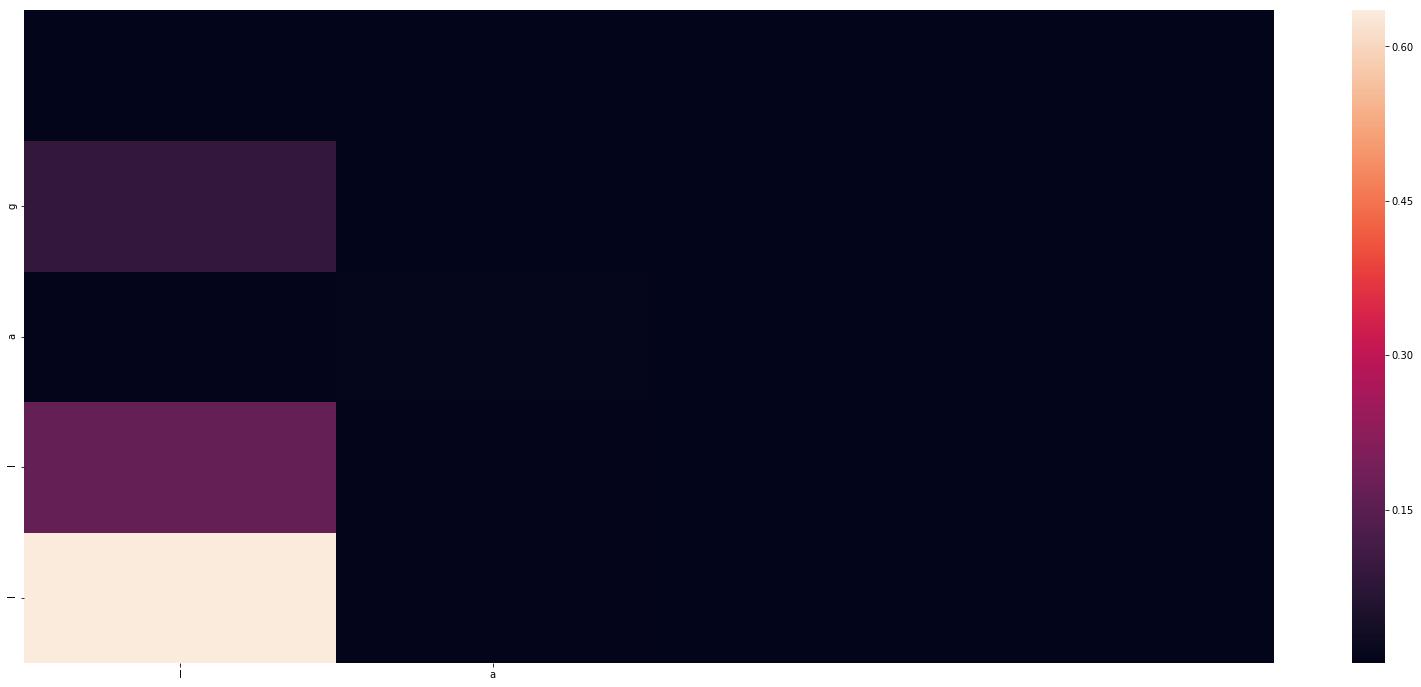

-
Input sentence: la
GT sentence: lat
Decoded sentence: llag


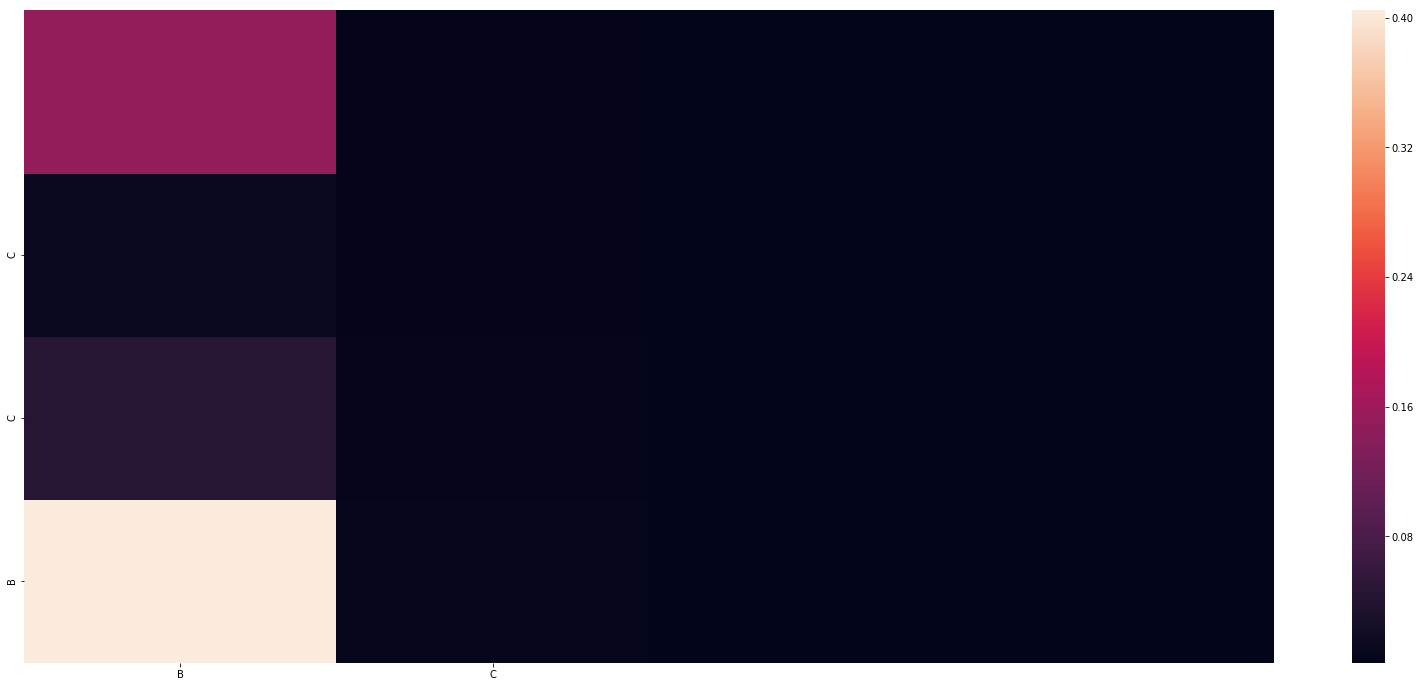

-
Input sentence: BC
GT sentence: BCG
Decoded sentence: BCC


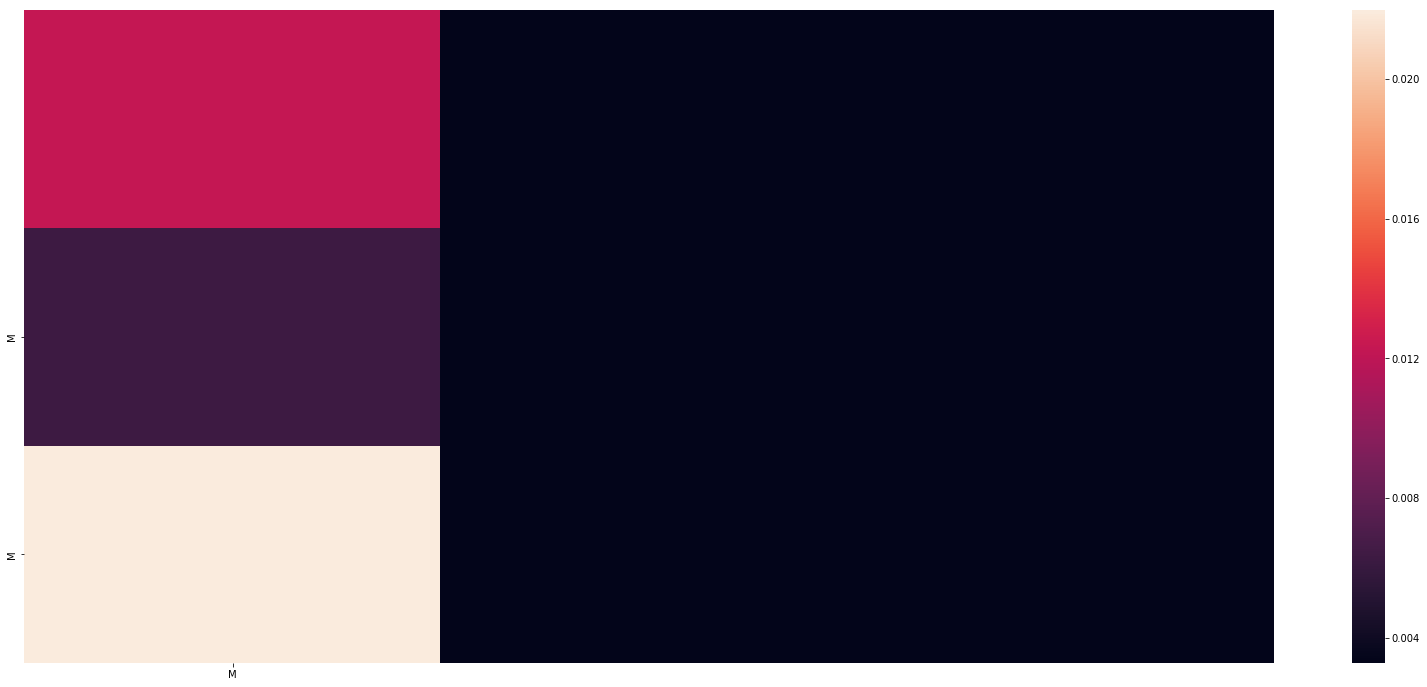

-
Input sentence: M
GT sentence: MM
Decoded sentence: MM


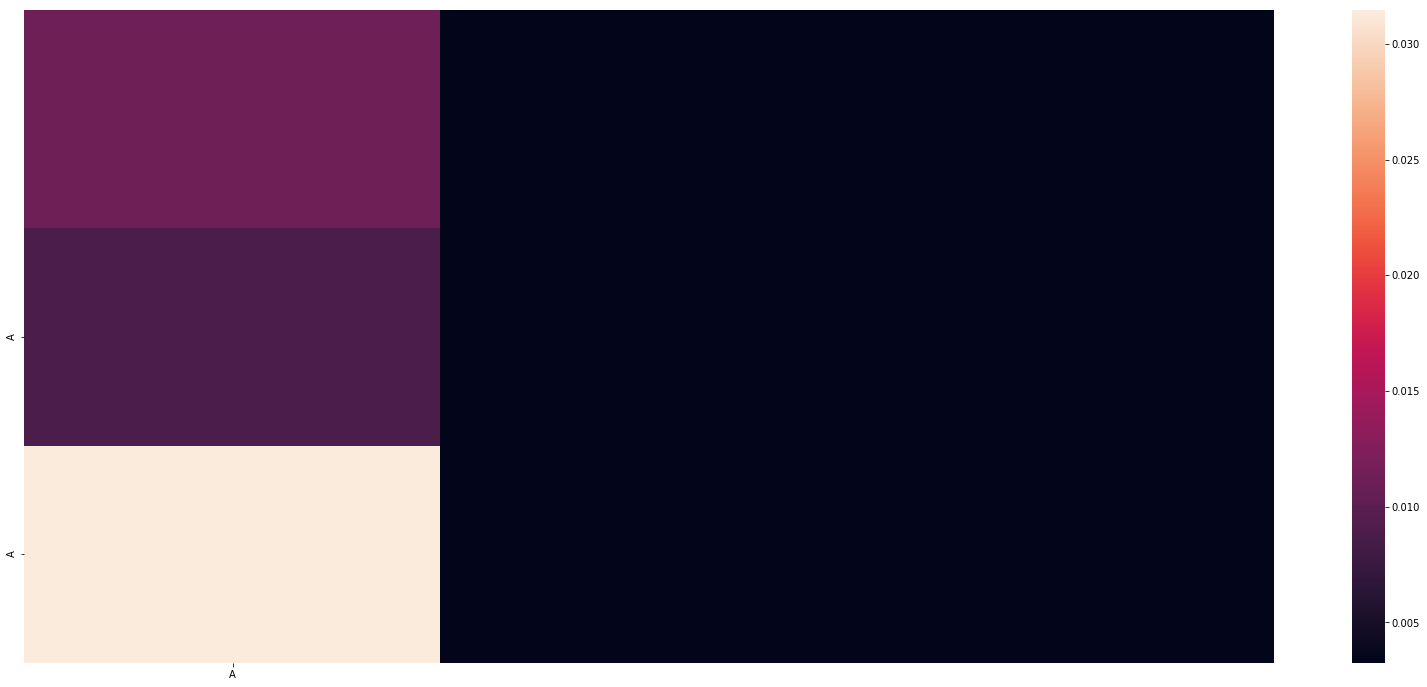

-
Input sentence: A
GT sentence: AK
Decoded sentence: AA


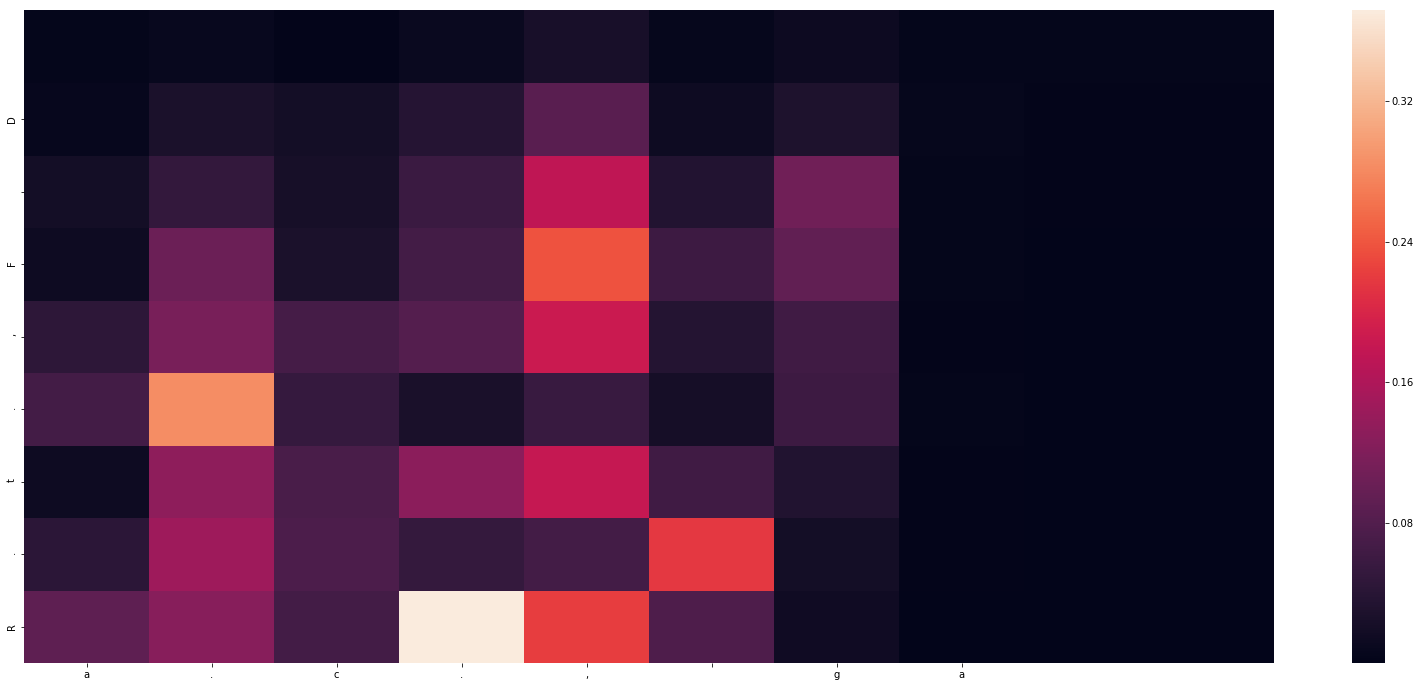

-
Input sentence: a.c., ga
GT sentence: a.c., ac
Decoded sentence: R.t.,F D


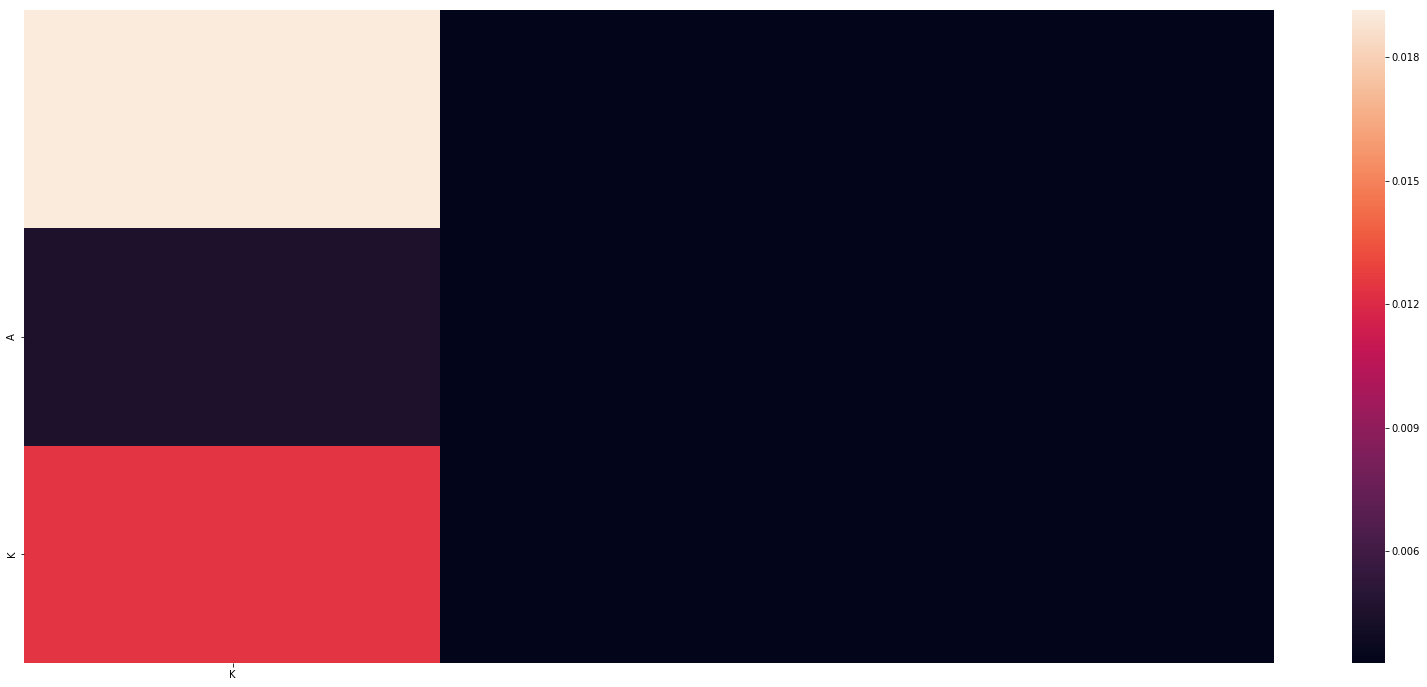

-
Input sentence: K
GT sentence: KI
Decoded sentence: KA


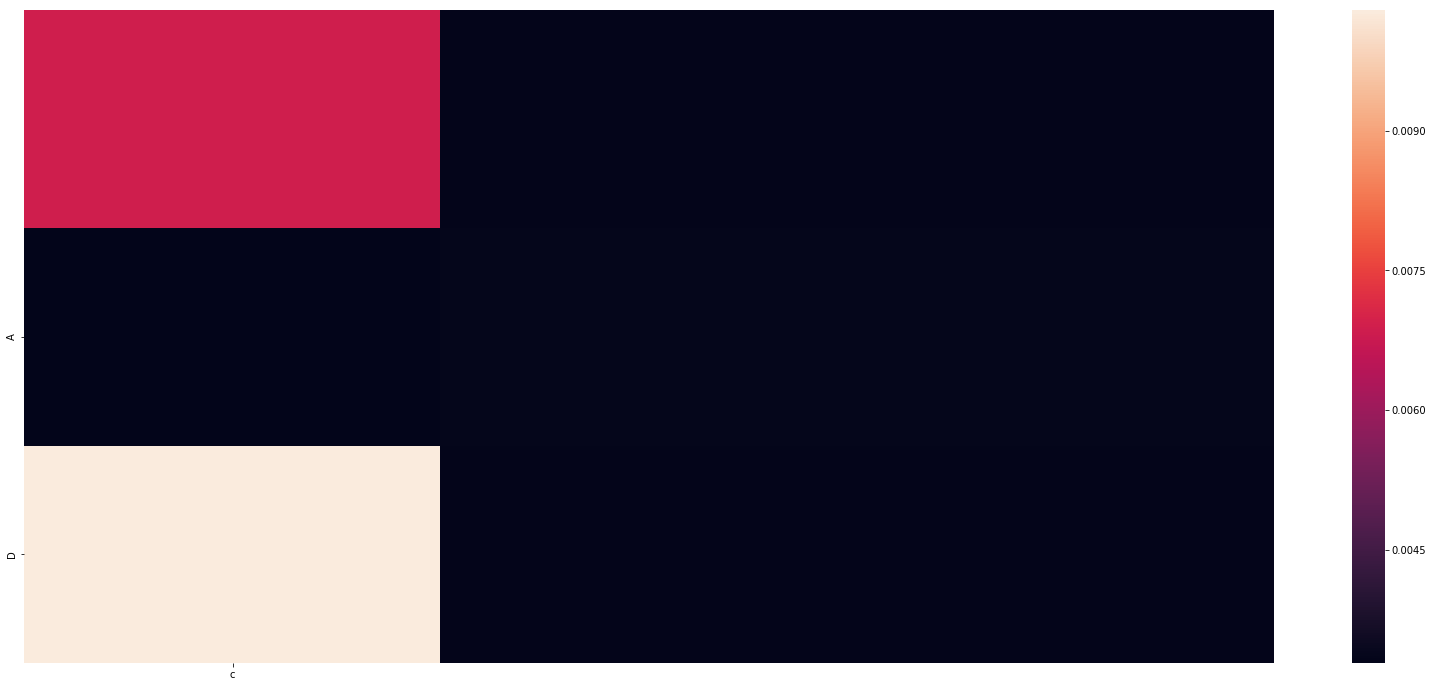

-
Input sentence: c
GT sentence: cg
Decoded sentence: DA


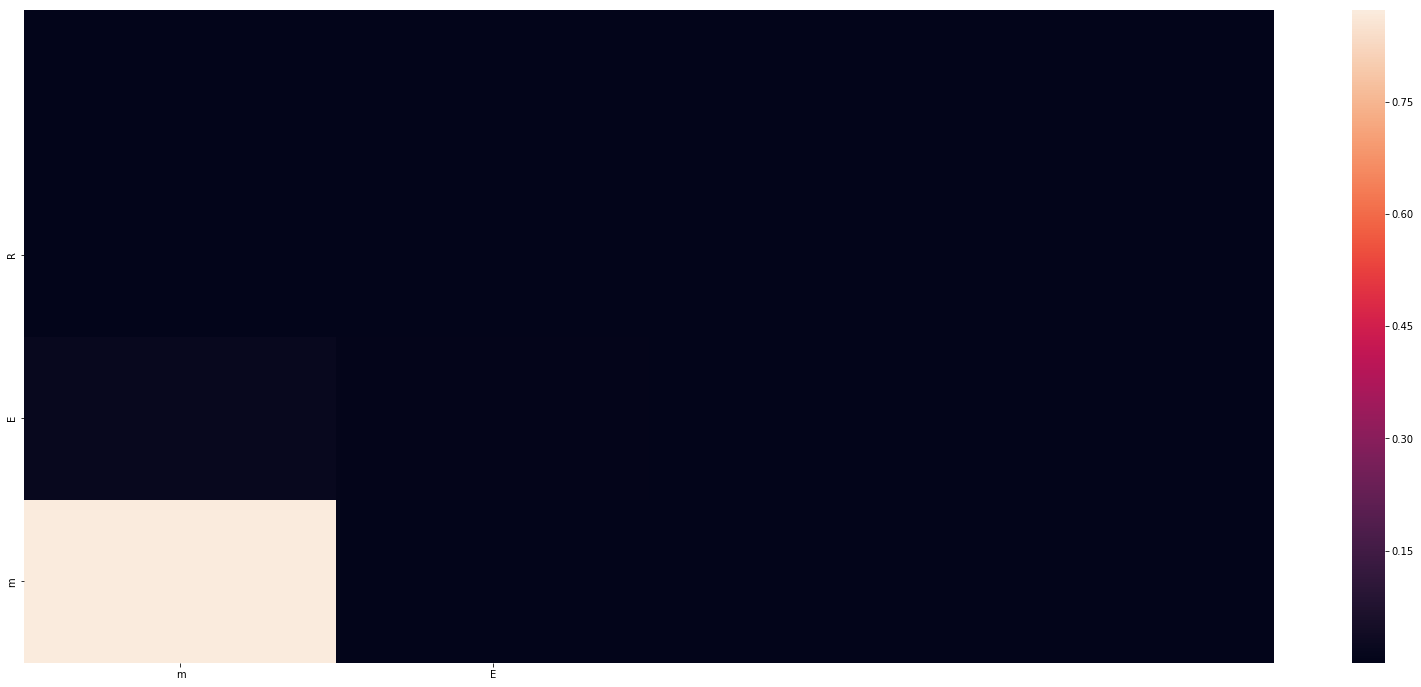

-
Input sentence: mE
GT sentence: mEq
Decoded sentence: mER


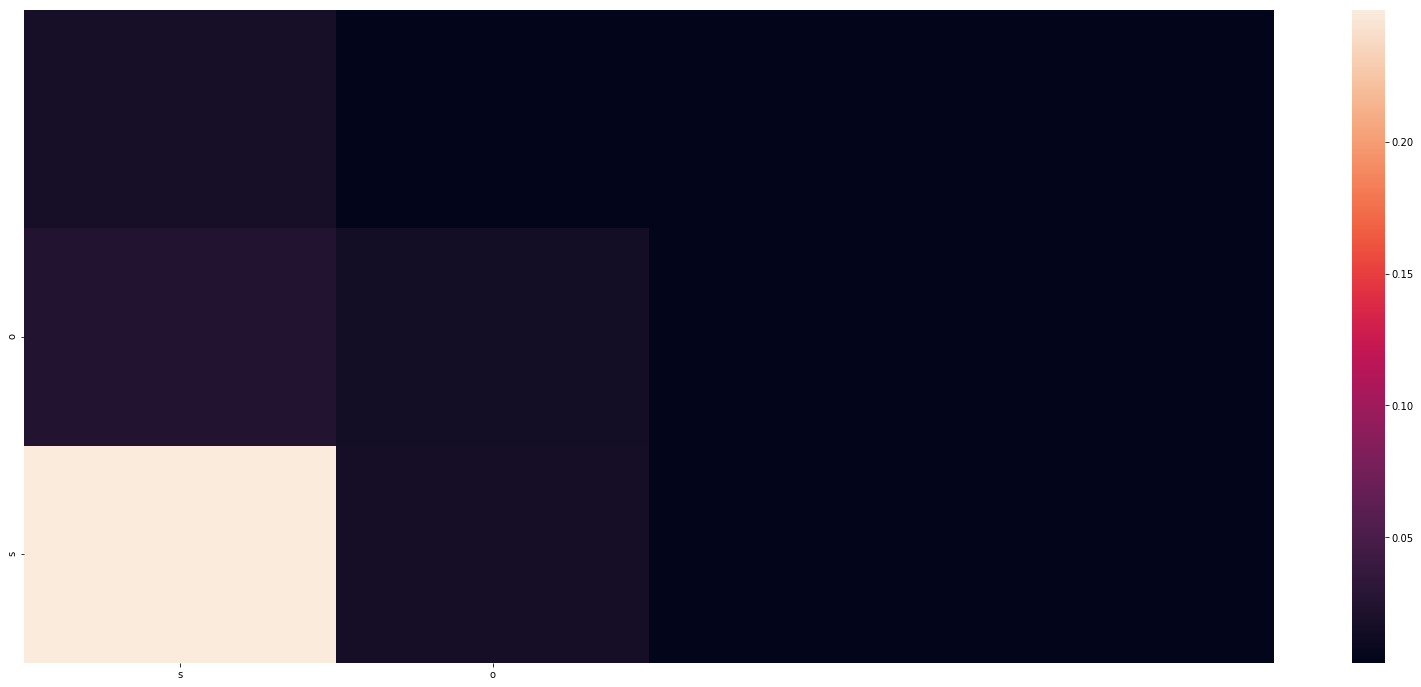

-
Input sentence: so
GT sentence: sol
Decoded sentence: so


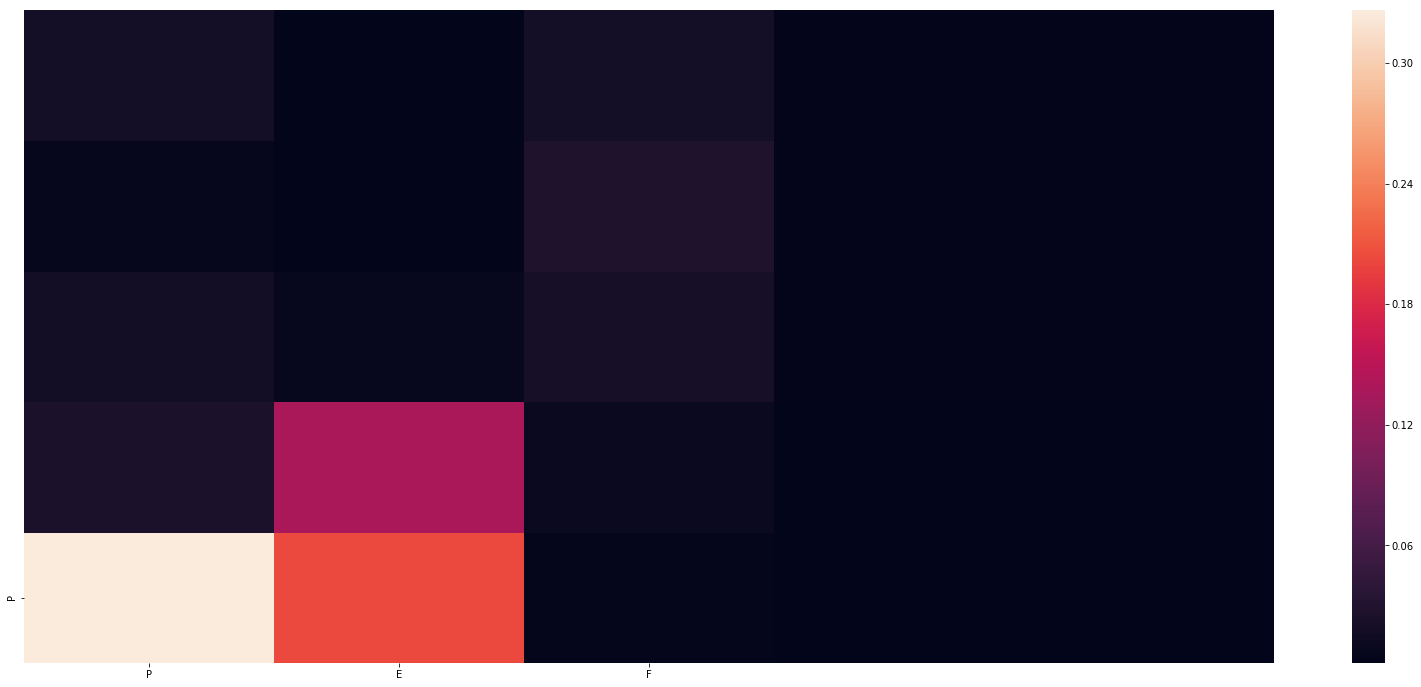

-
Input sentence: PEF
GT sentence: PEFR
Decoded sentence: P


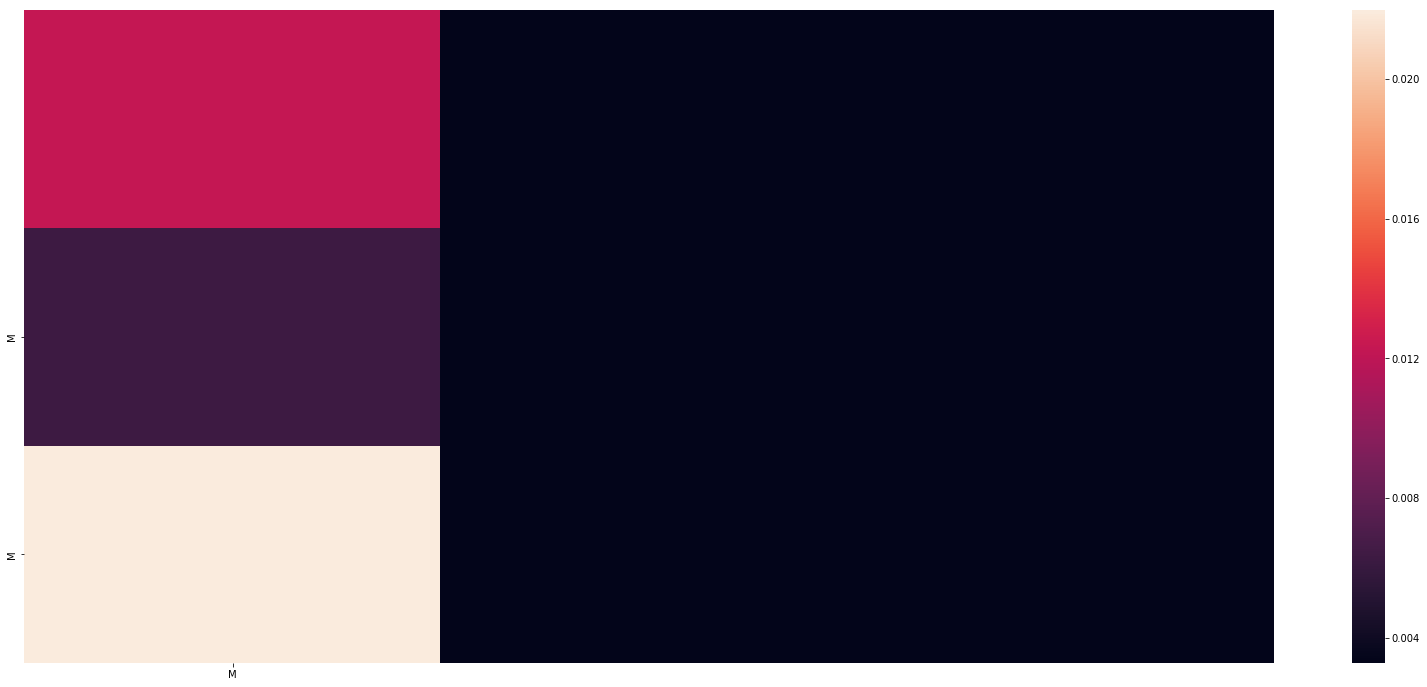

-
Input sentence: M
GT sentence: MI
Decoded sentence: MM


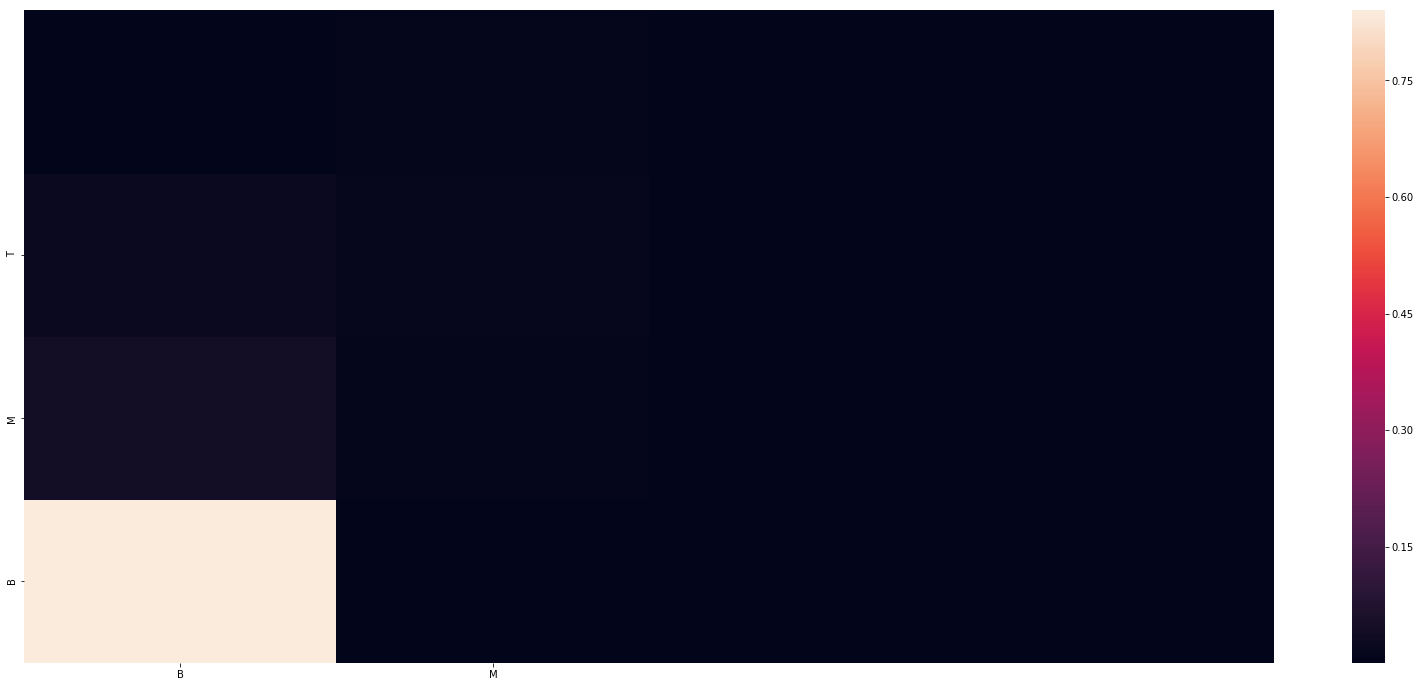

-
Input sentence: BM
GT sentence: BMS
Decoded sentence: BMT


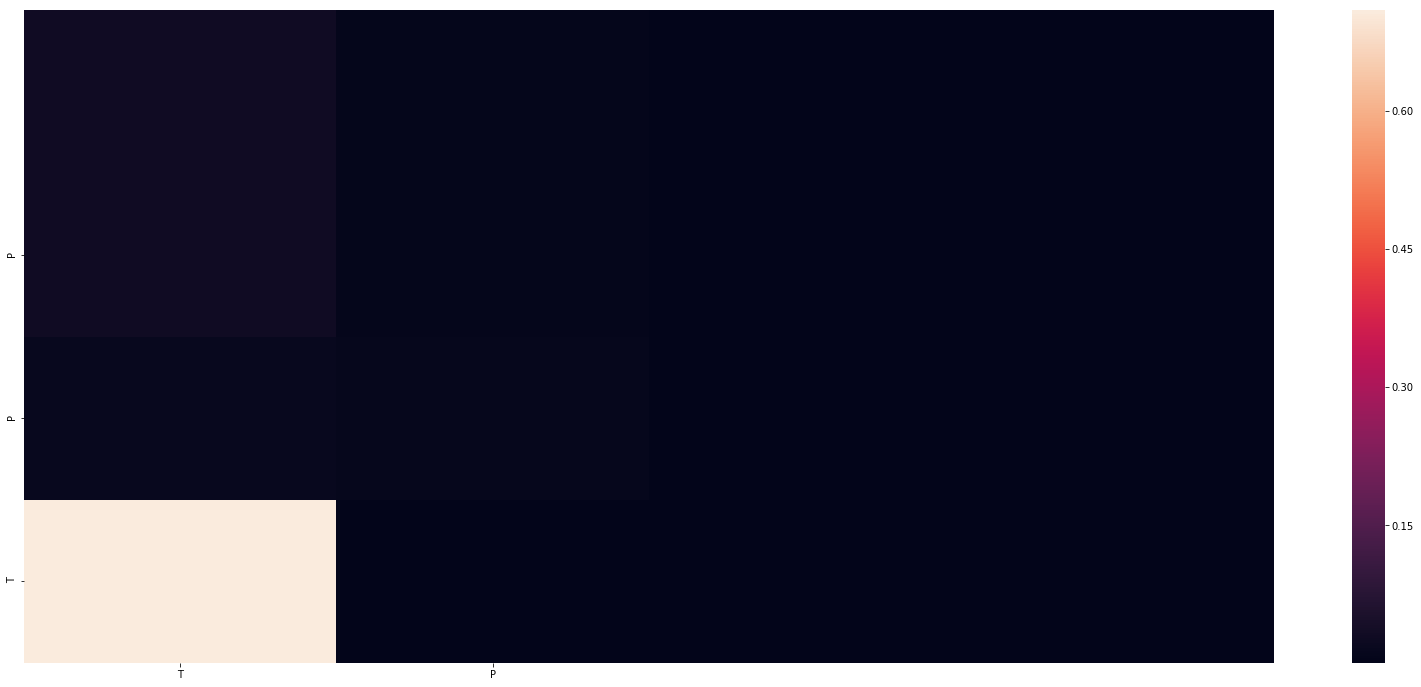

-
Input sentence: TP
GT sentence: TPI
Decoded sentence: TPP


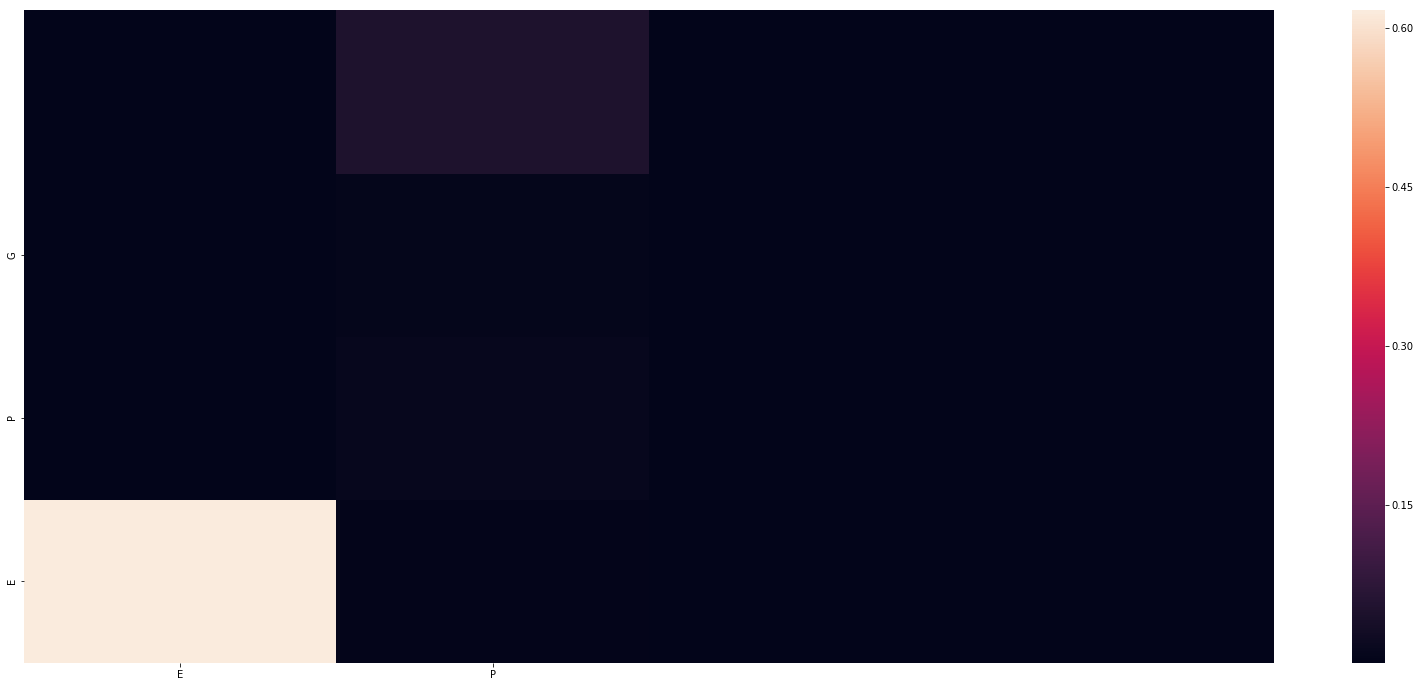

-
Input sentence: EP
GT sentence: EPS
Decoded sentence: EPG


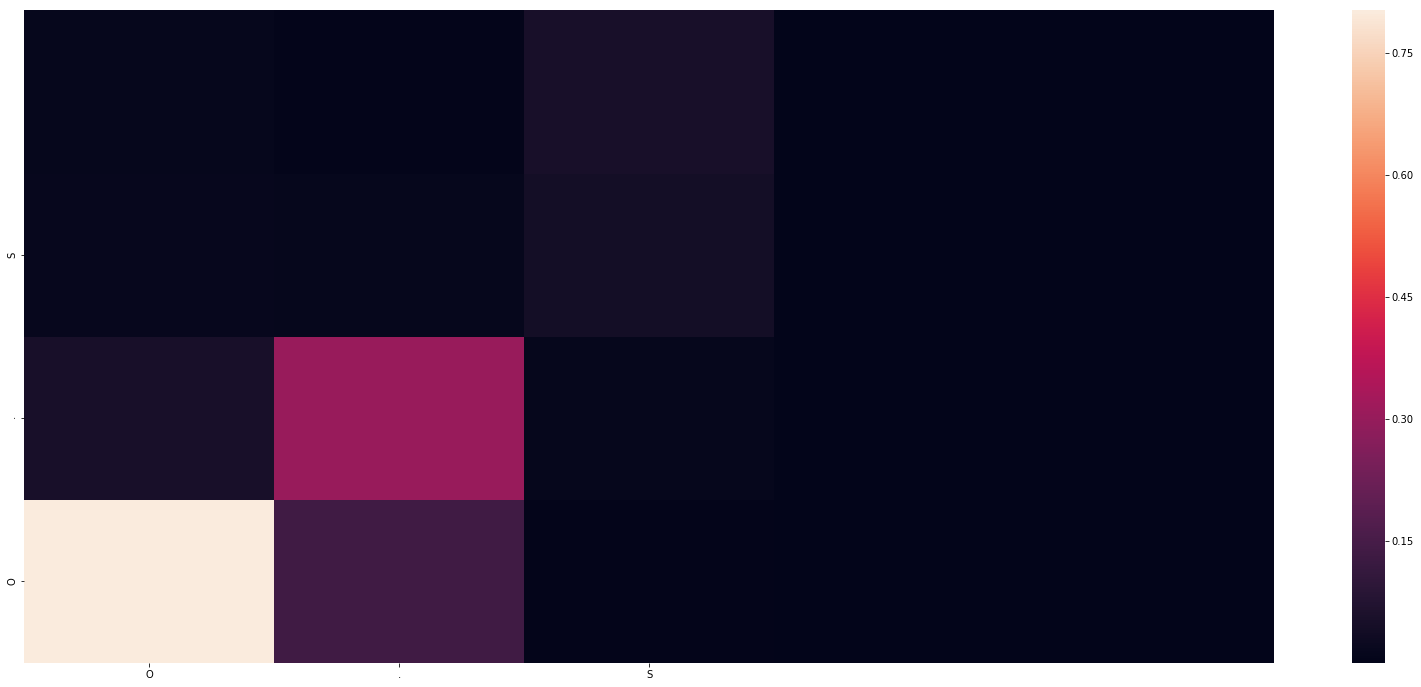

-
Input sentence: O.S
GT sentence: O.S.
Decoded sentence: O.S


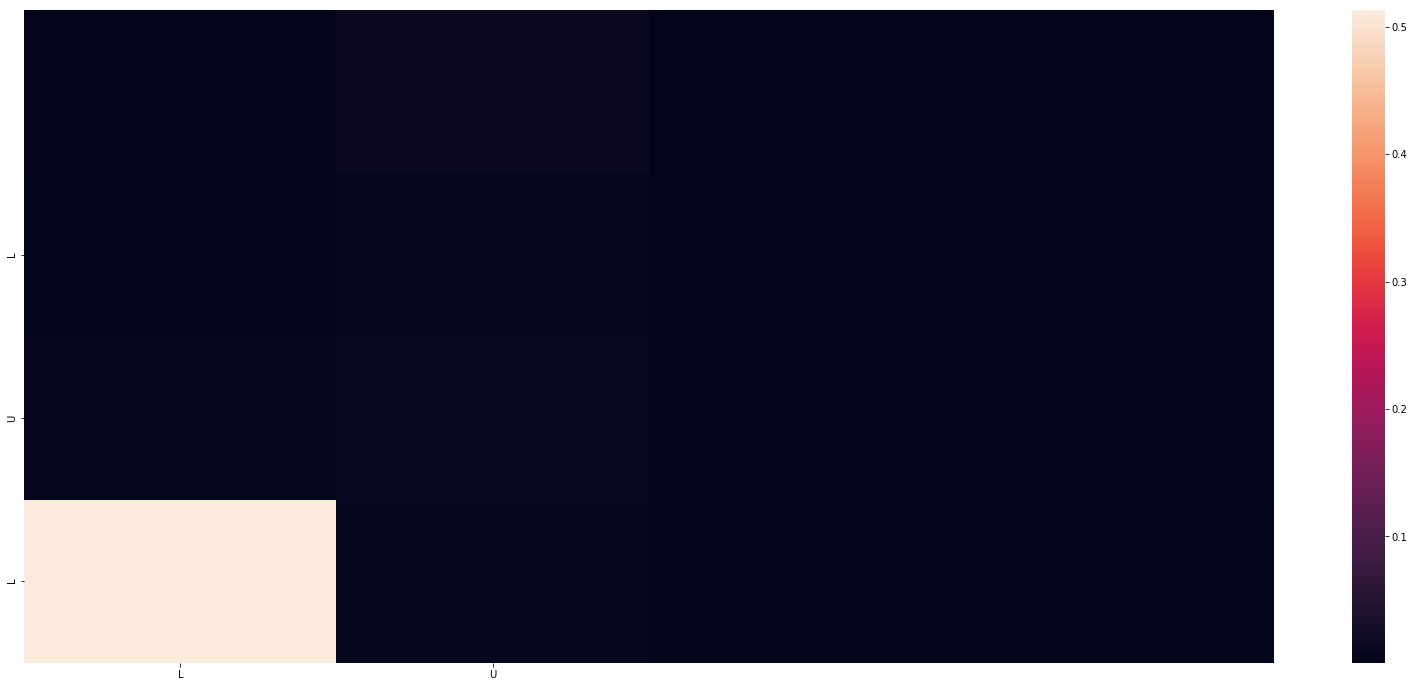

-
Input sentence: LU
GT sentence: LUE
Decoded sentence: LUL


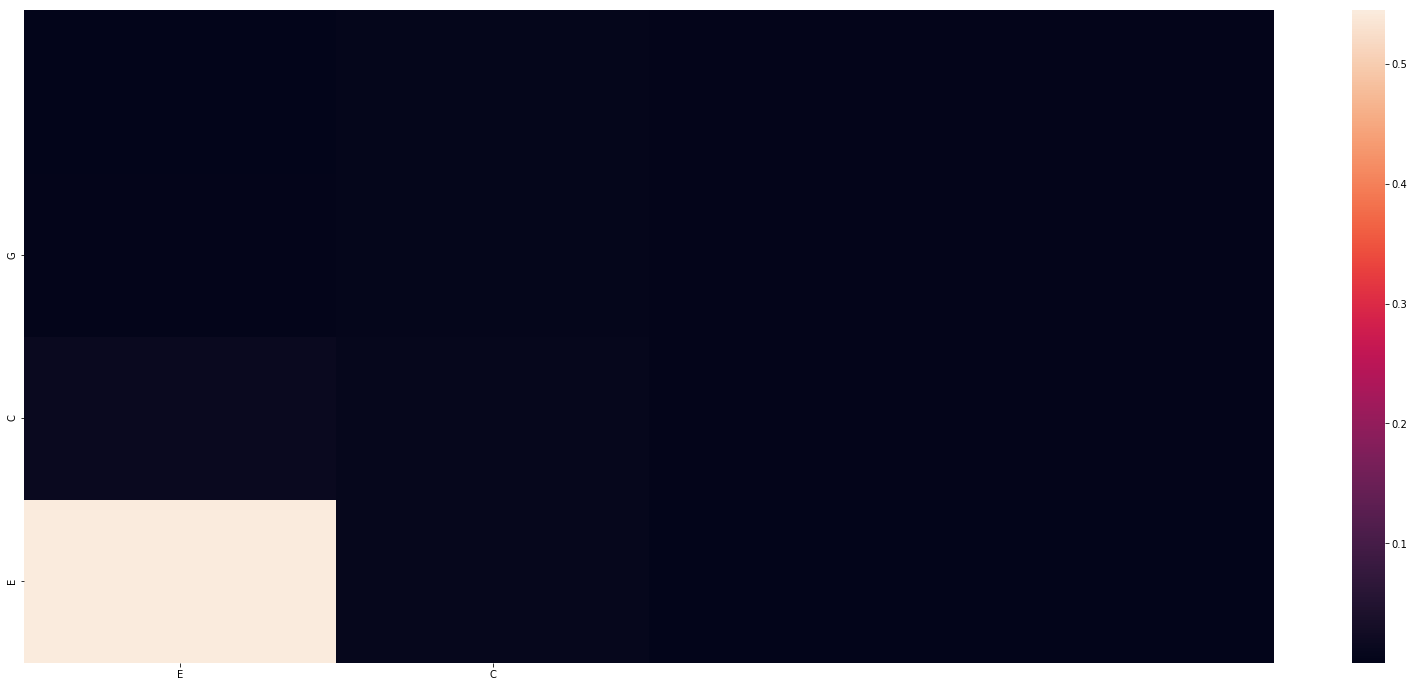

-
Input sentence: EC
GT sentence: ECG
Decoded sentence: ECG


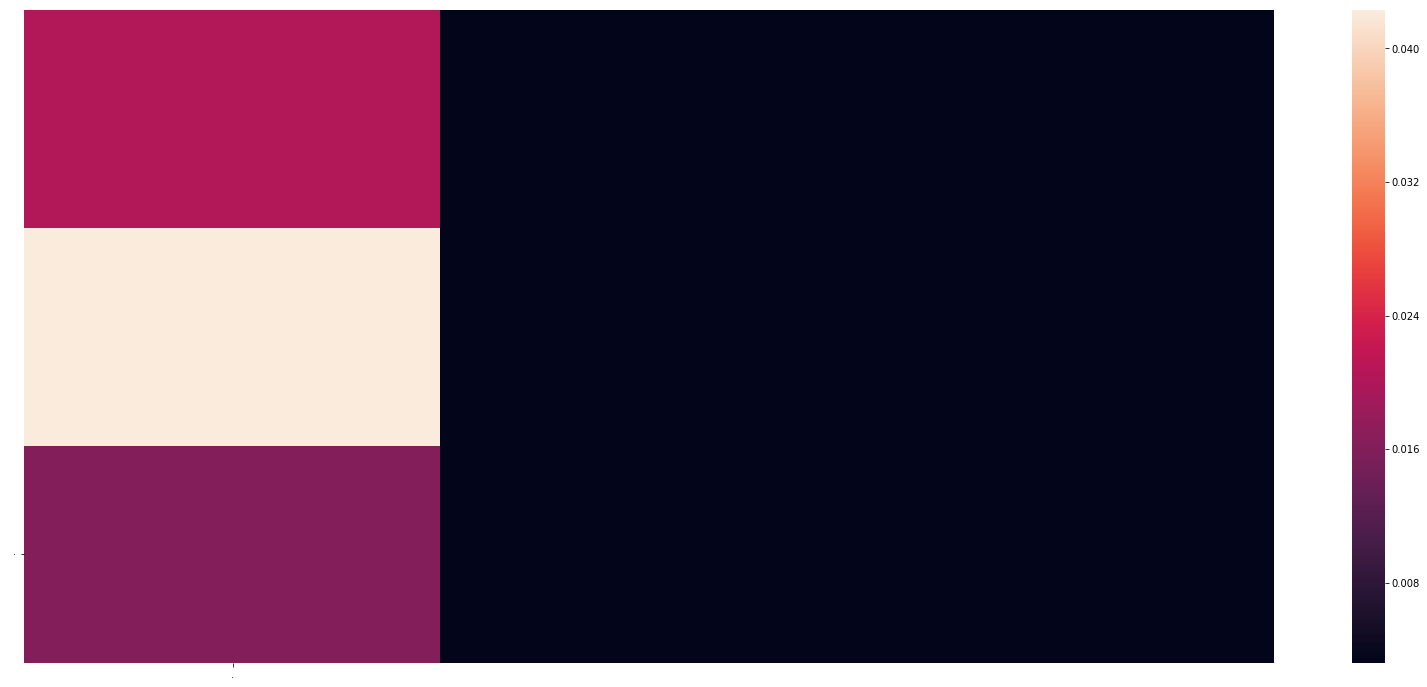

-
Input sentence: .
GT sentence: S.E.
Decoded sentence: .


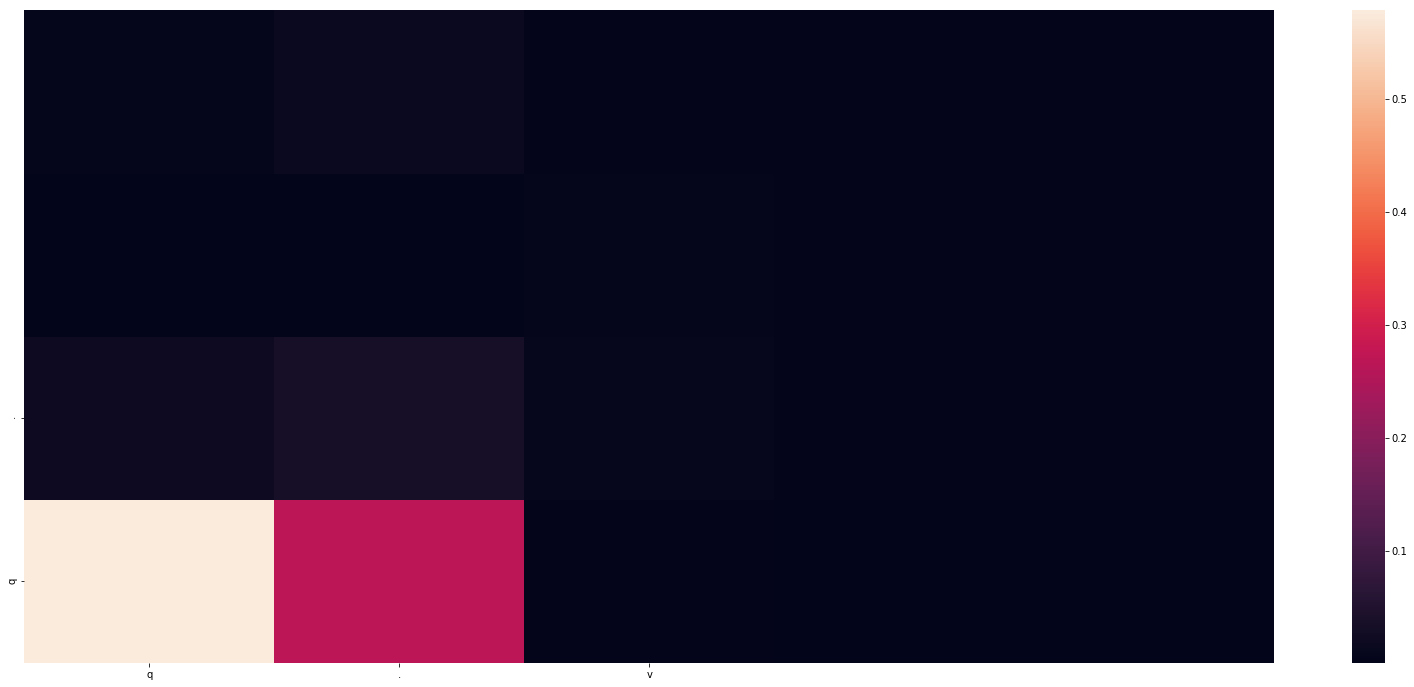

-
Input sentence: q.v
GT sentence: q.v.
Decoded sentence: q.


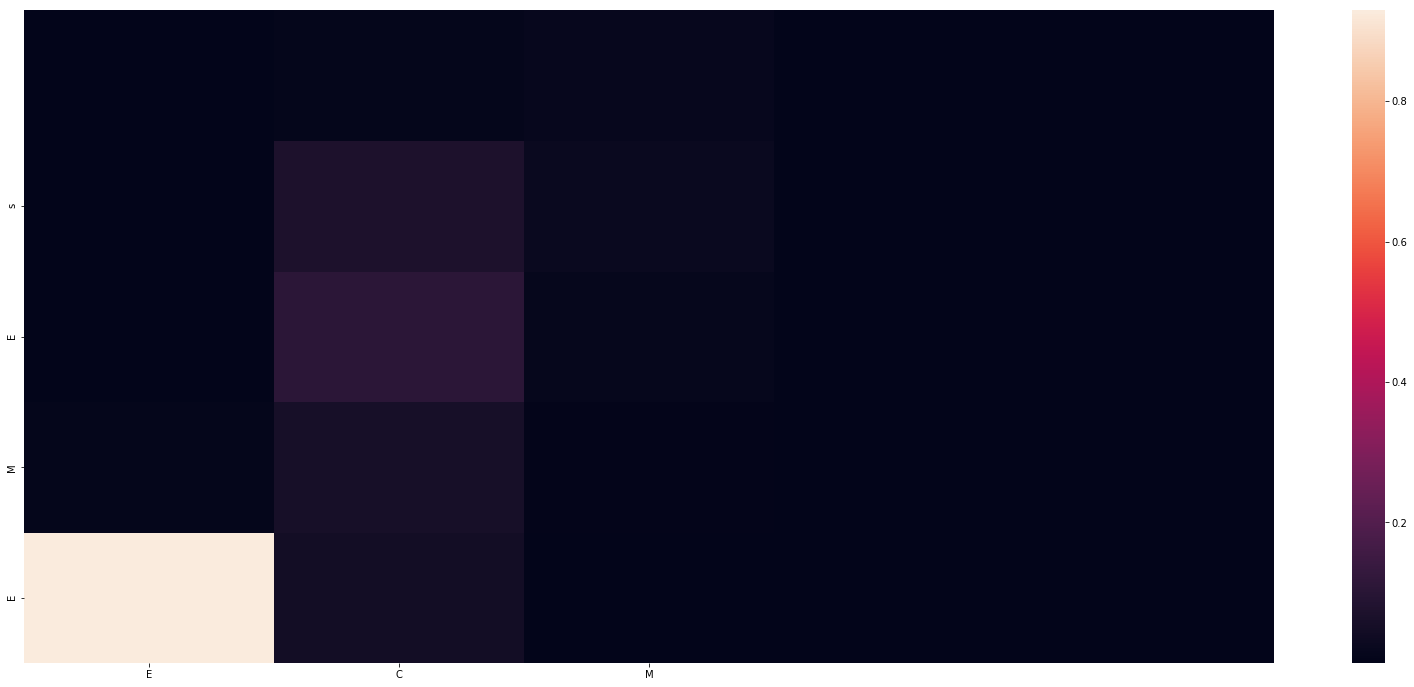

-
Input sentence: ECM
GT sentence: ECMO
Decoded sentence: EMEs


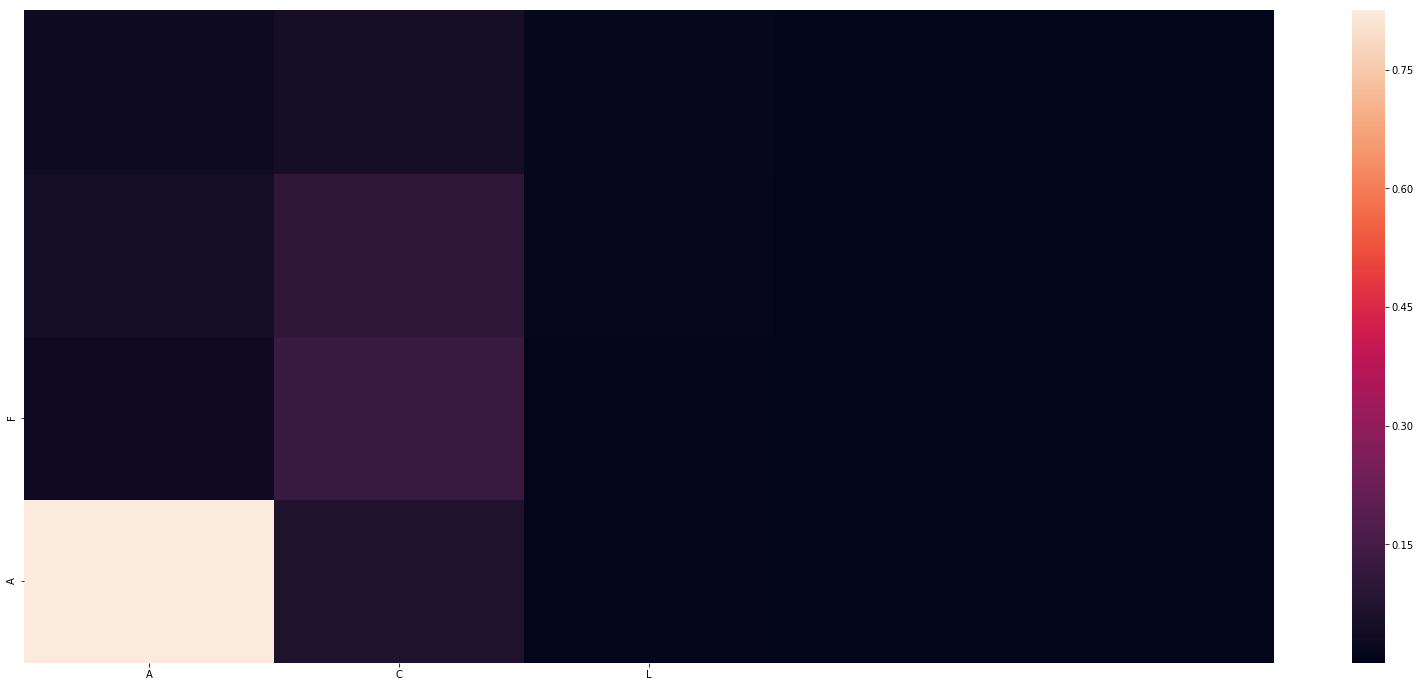

-
Input sentence: ACL
GT sentence: ACLS
Decoded sentence: AF


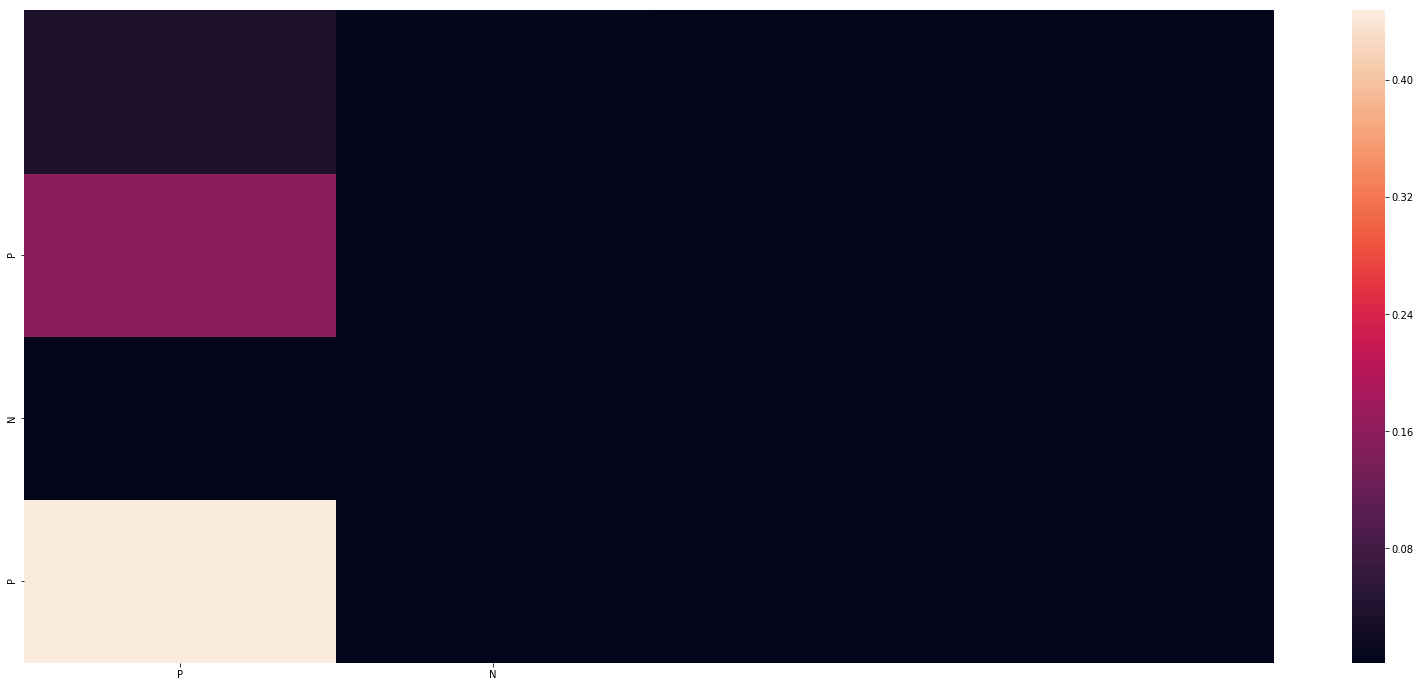

-
Input sentence: PN
GT sentence: PND
Decoded sentence: PNP


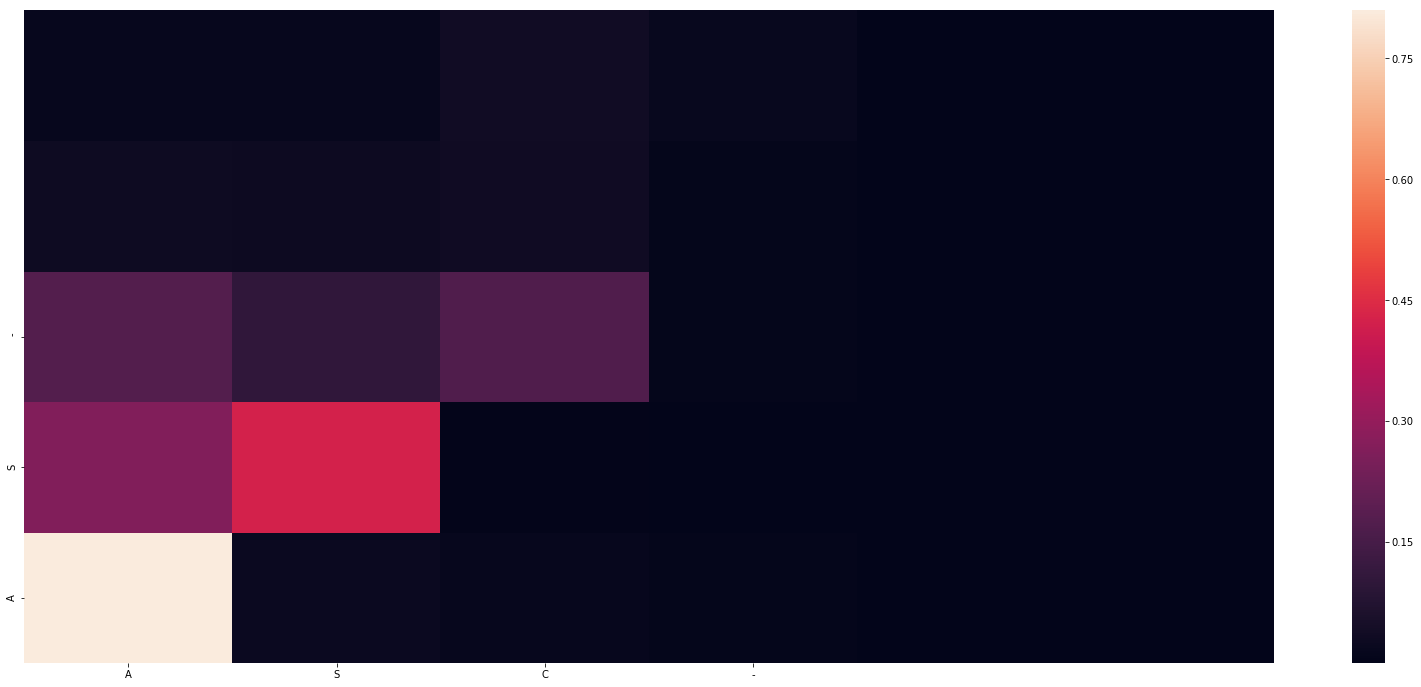

-
Input sentence: ASC-
GT sentence: ASC-US
Decoded sentence: AS-


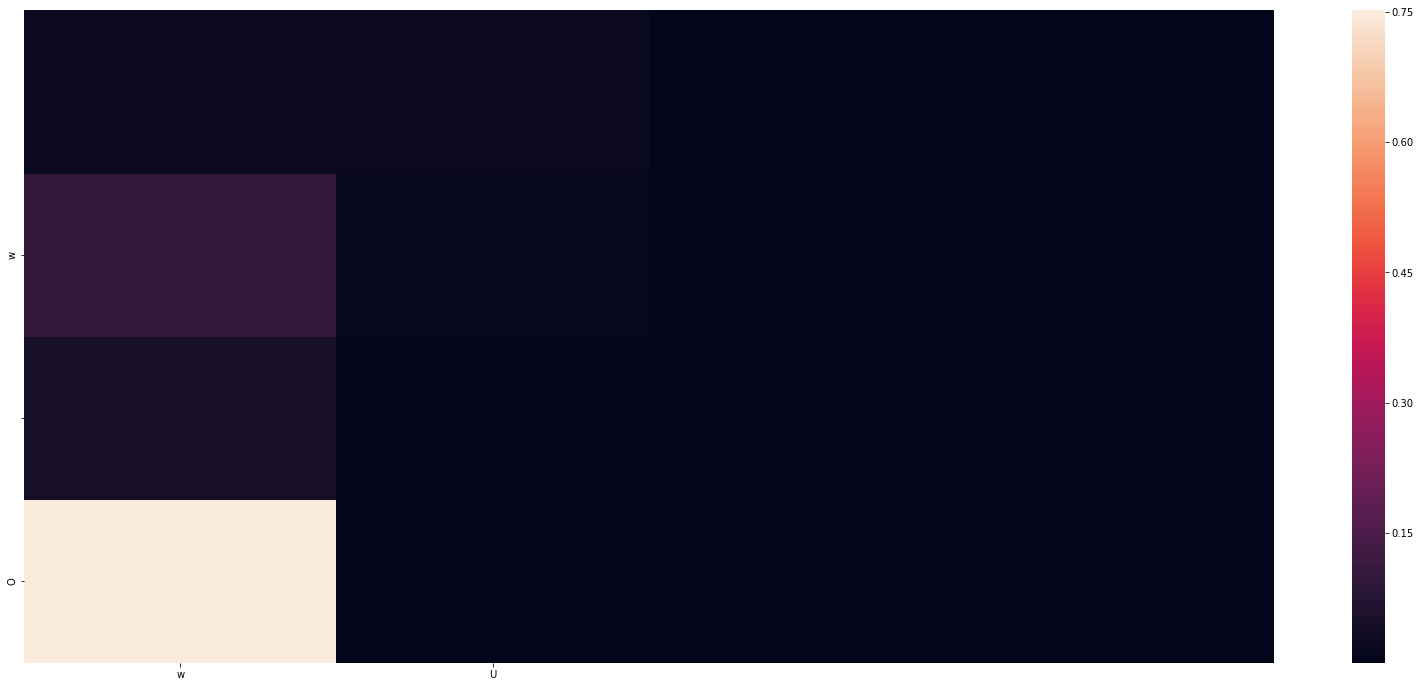

-
Input sentence: wU
GT sentence: UV
Decoded sentence: O w


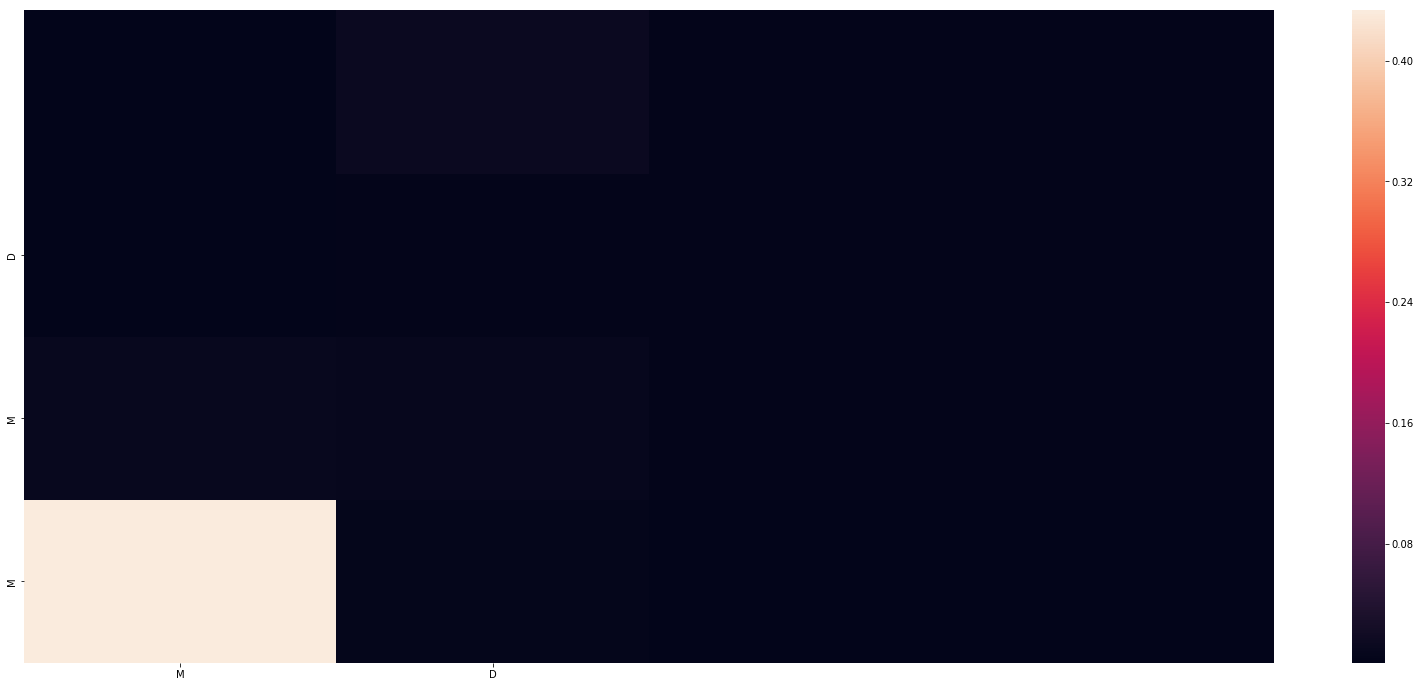

-
Input sentence: MD
GT sentence: MDI
Decoded sentence: MMD


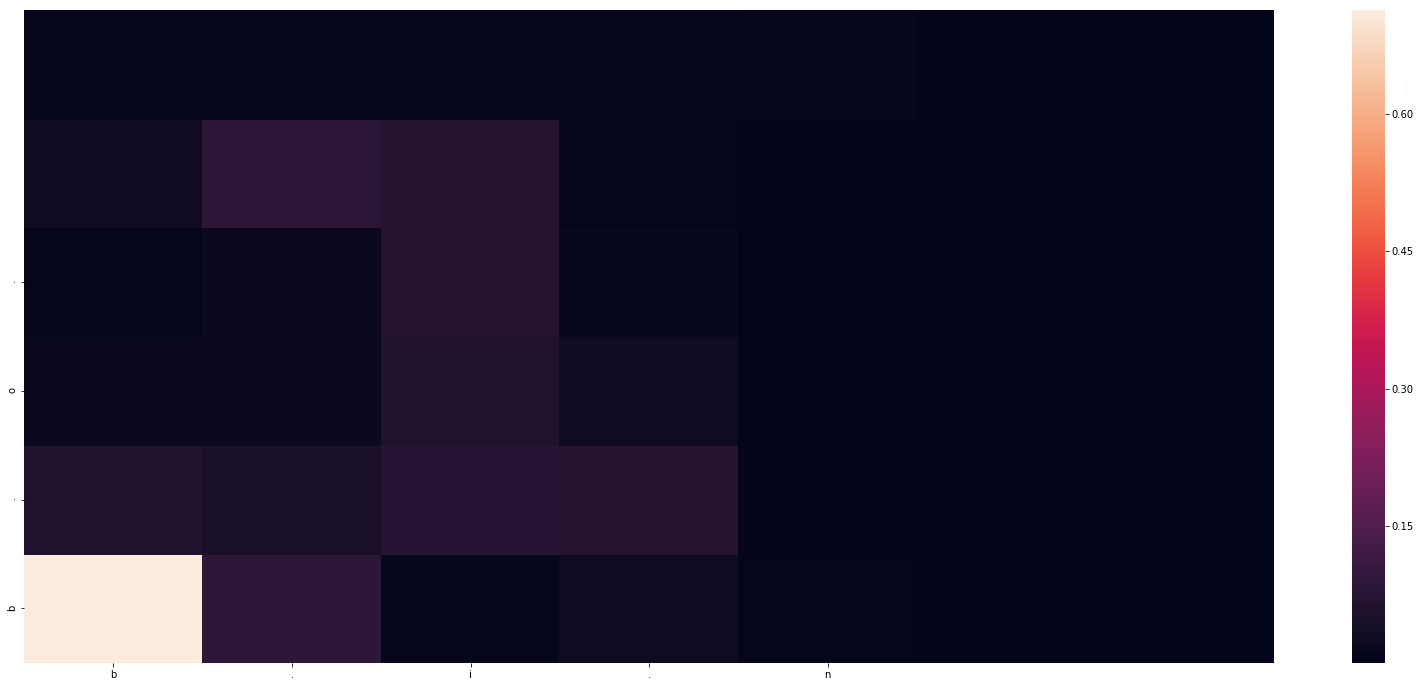

-
Input sentence: b.i.n
GT sentence: b.i.n.
Decoded sentence: b.o.


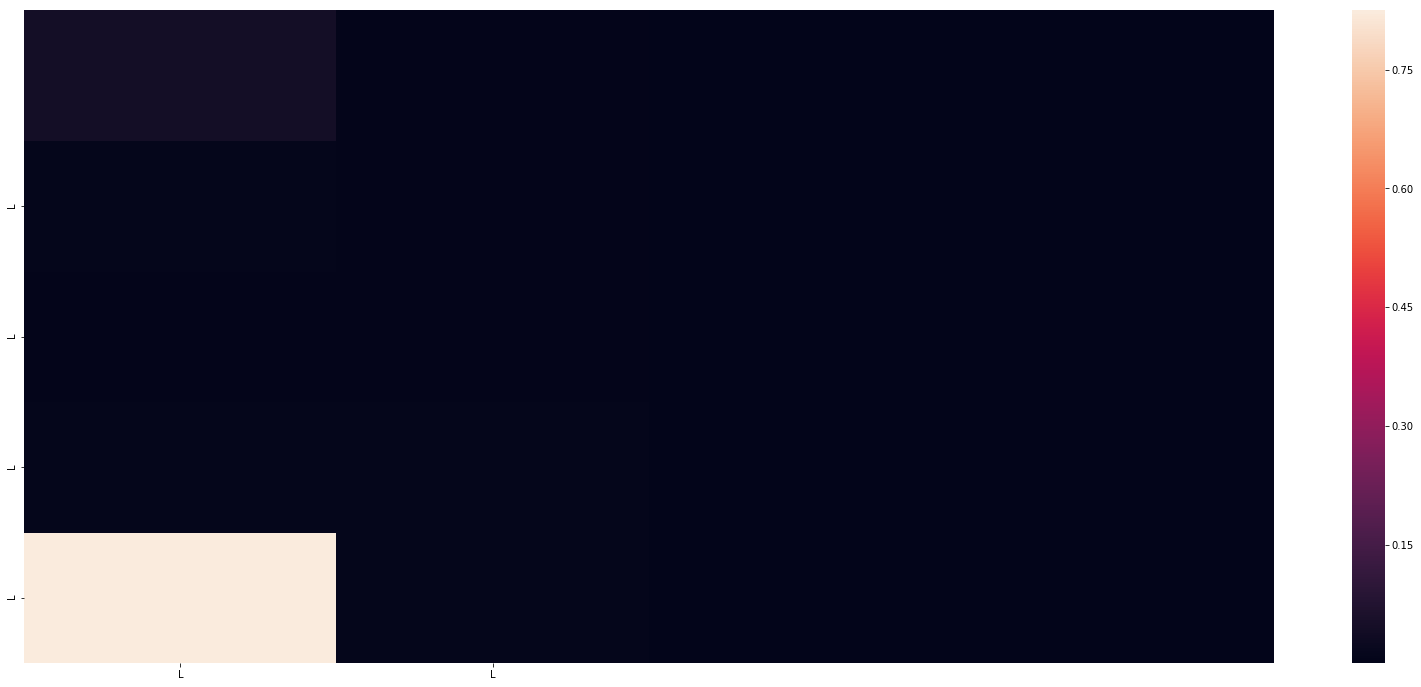

-
Input sentence: LL
GT sentence: LLL
Decoded sentence: LLLL


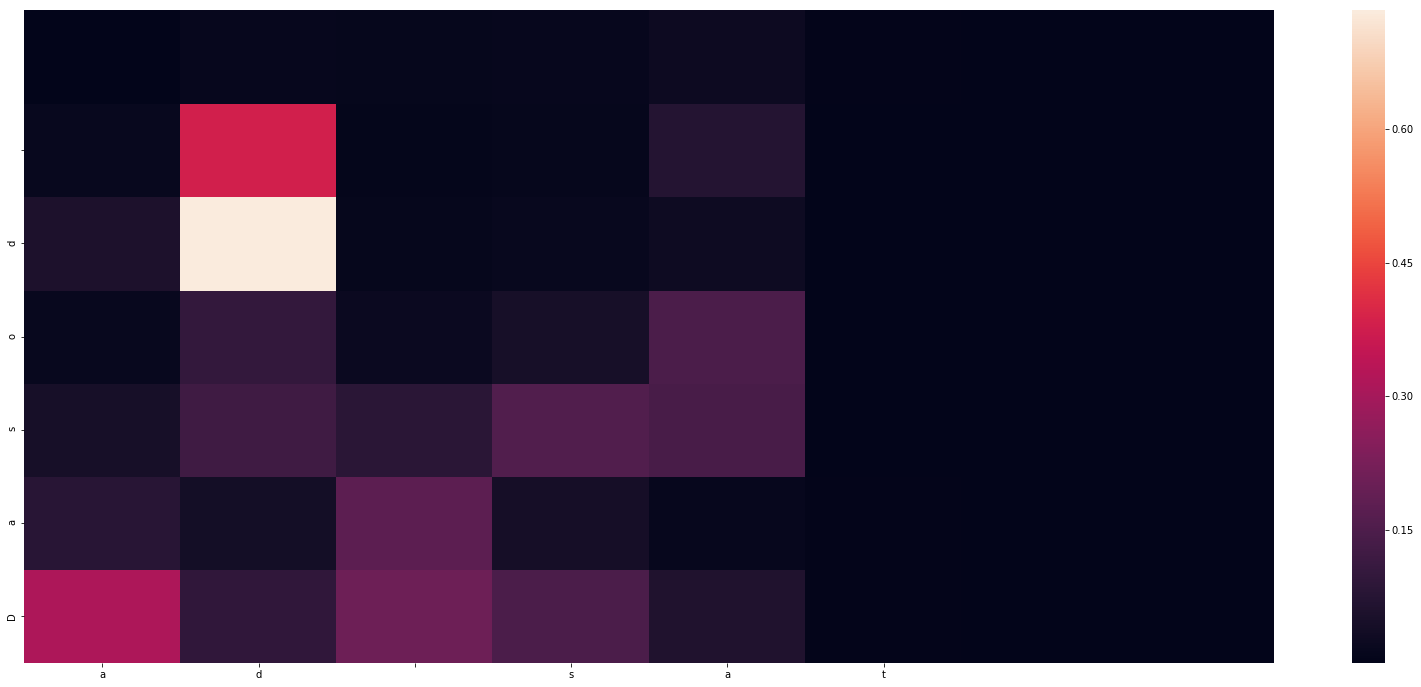

-
Input sentence: ad sat
GT sentence: ad sat.
Decoded sentence: Dasod 


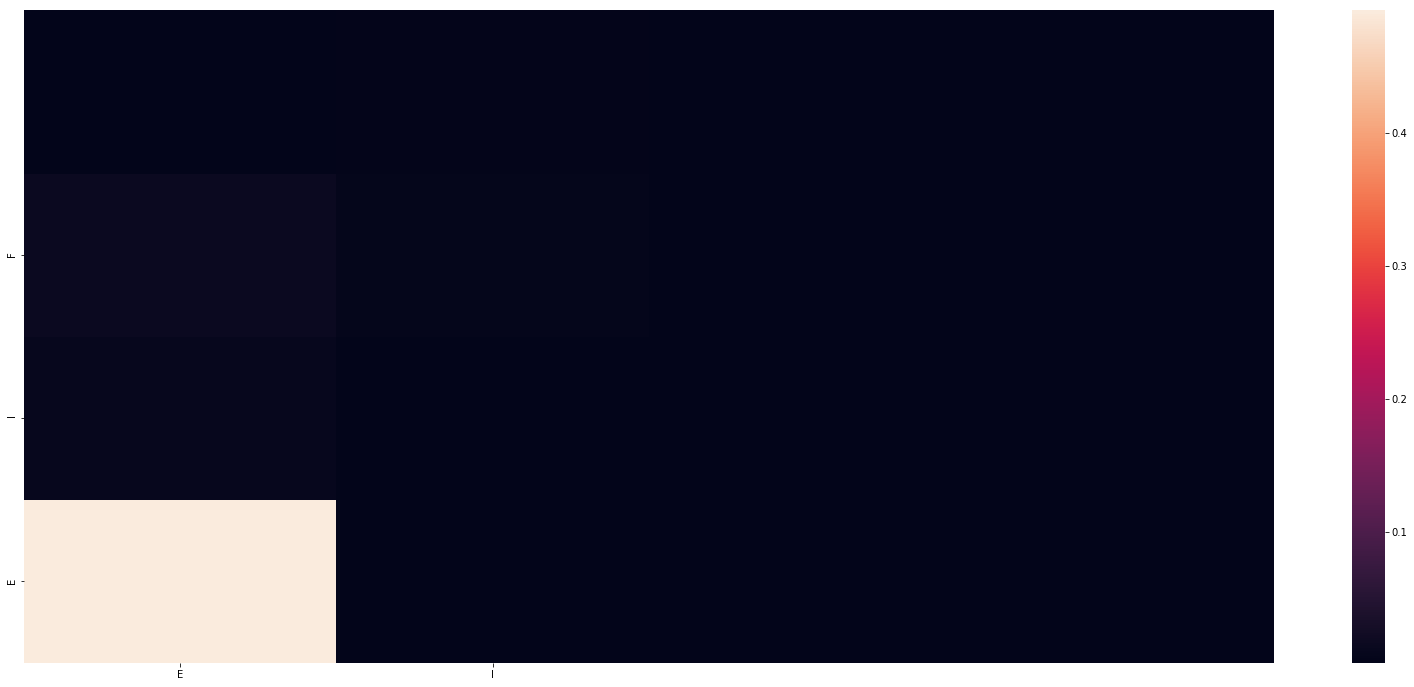

-
Input sentence: EI
GT sentence: EIA
Decoded sentence: EIF


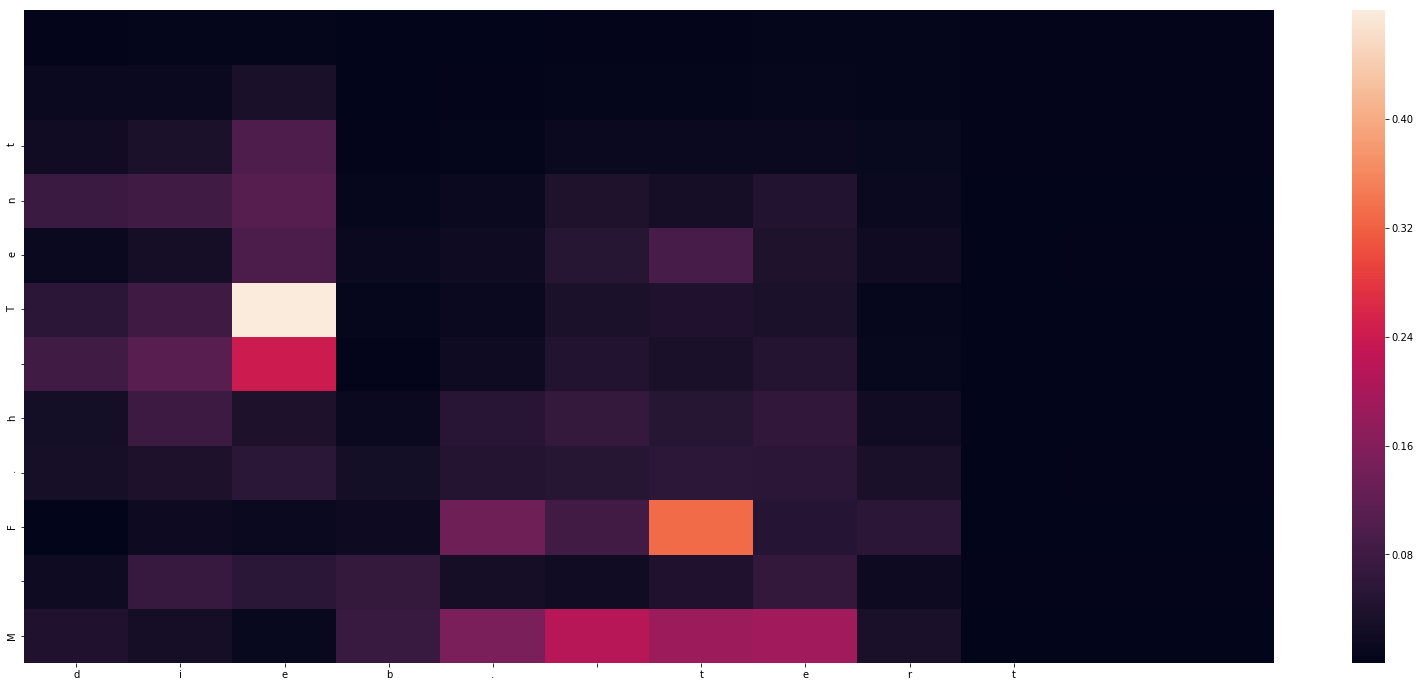

-
Input sentence: dieb. tert
GT sentence: dieb. tert.
Decoded sentence: M F.h Tent


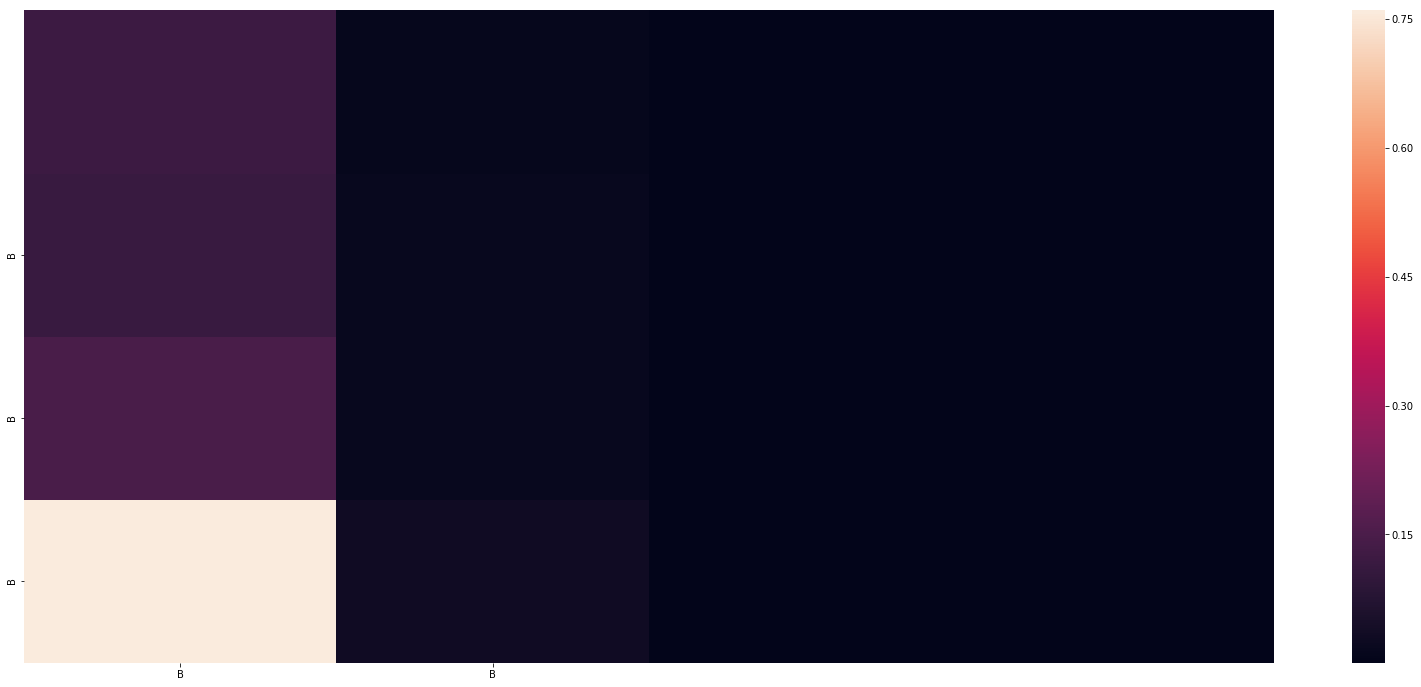

-
Input sentence: BB
GT sentence: BBB
Decoded sentence: BBB


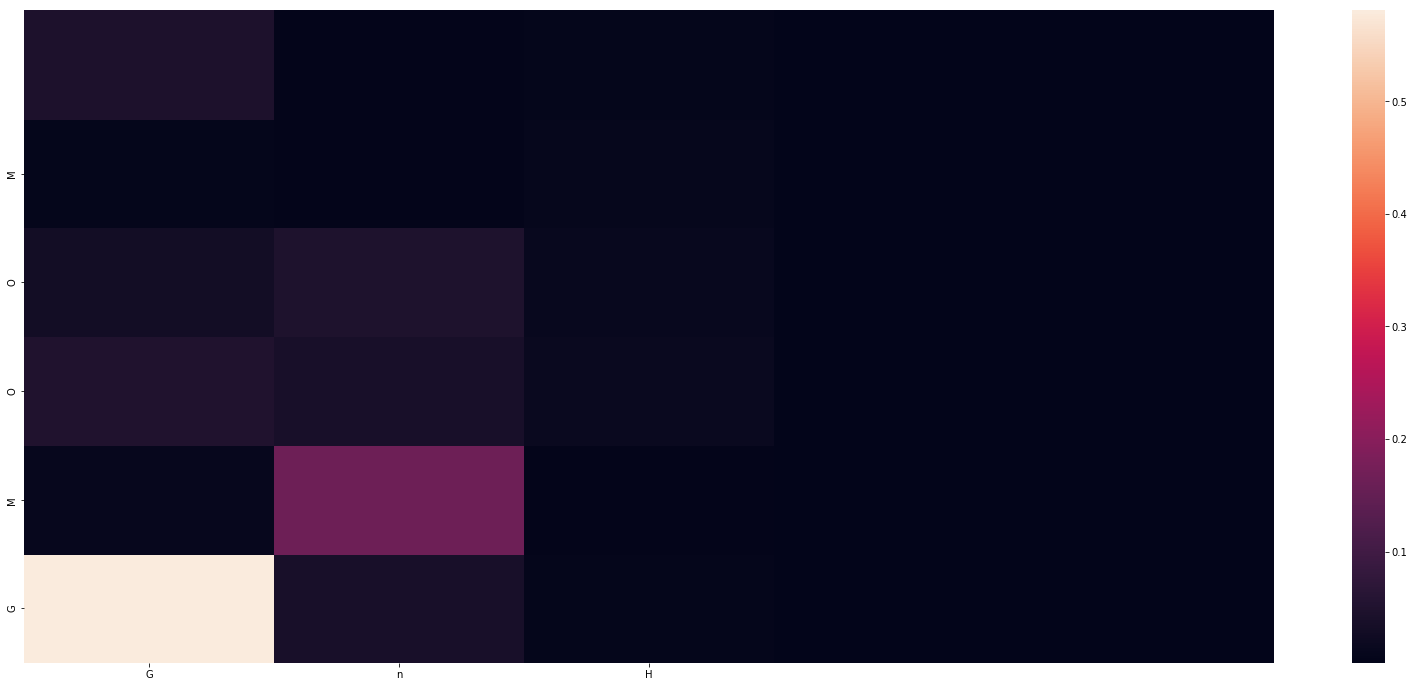

-
Input sentence: GnH
GT sentence: GnRH
Decoded sentence: GMOOM


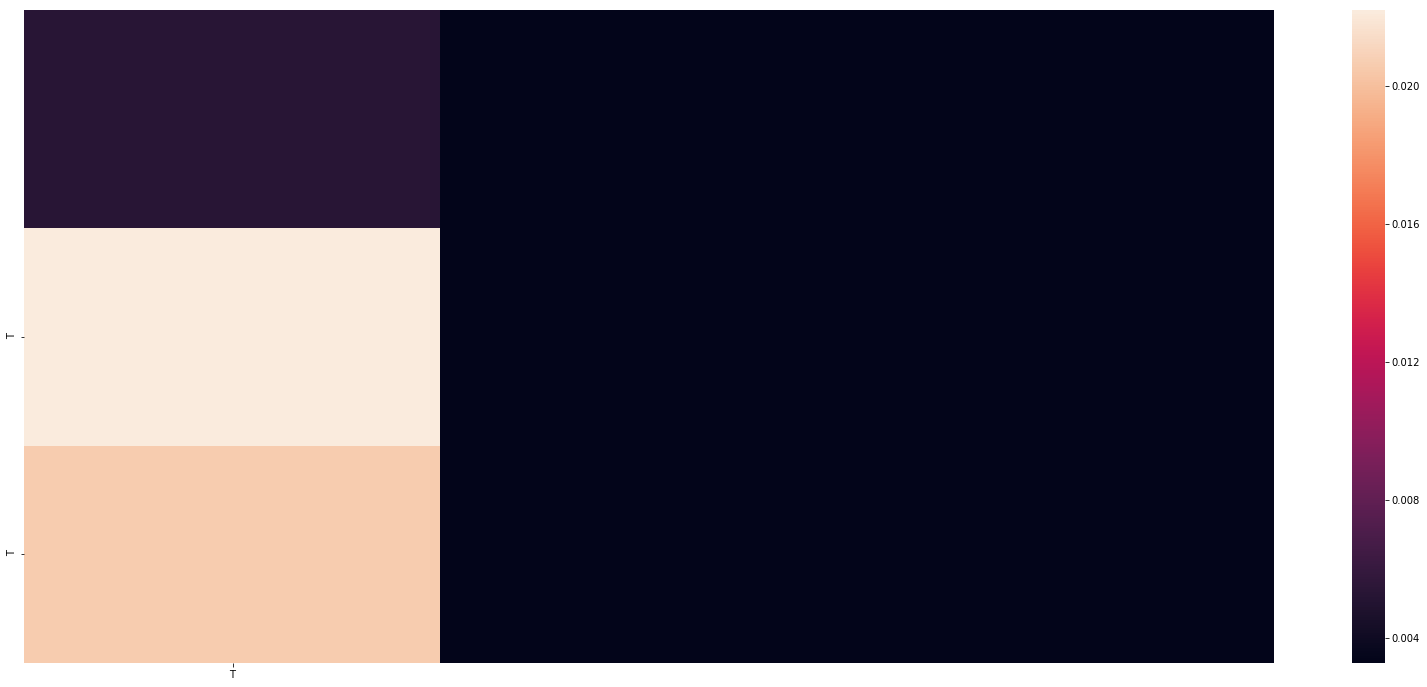

-
Input sentence: T
GT sentence: TB
Decoded sentence: TT


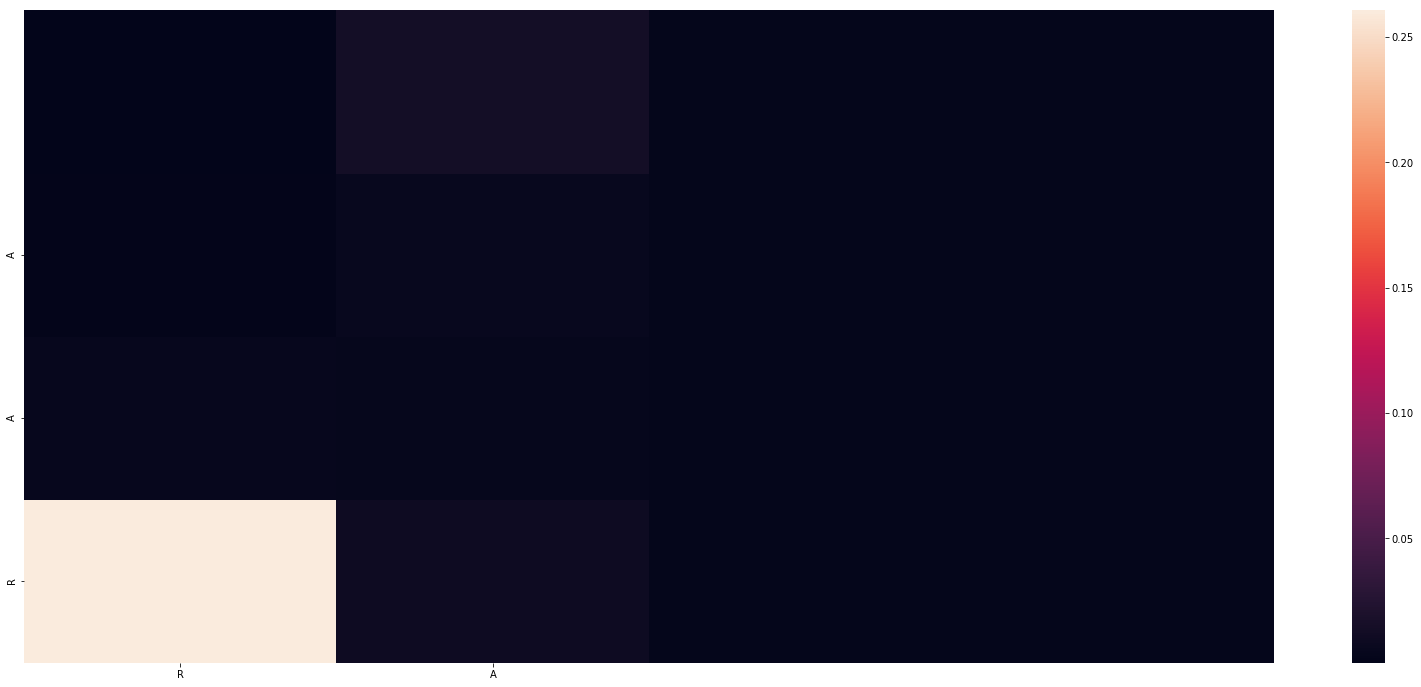

-
Input sentence: RA
GT sentence: RAI
Decoded sentence: RAA


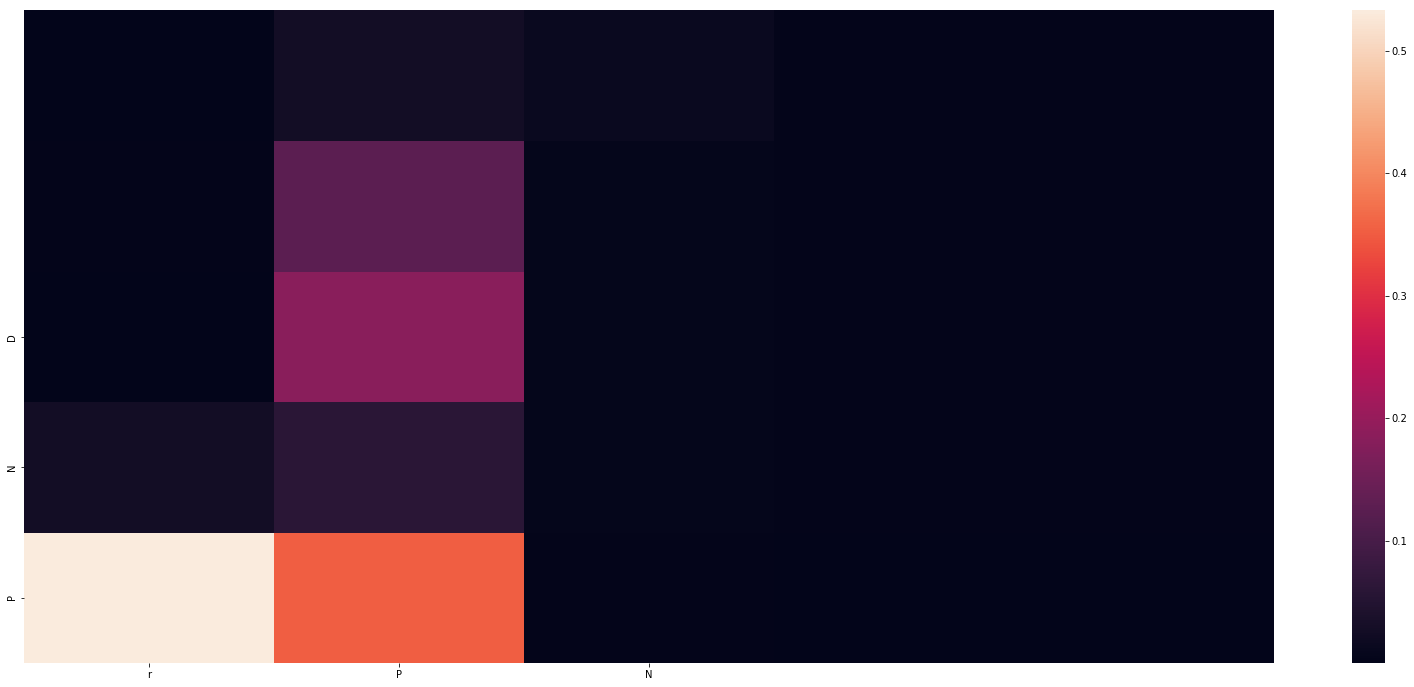

-
Input sentence: rPN
GT sentence: PNS
Decoded sentence: PND


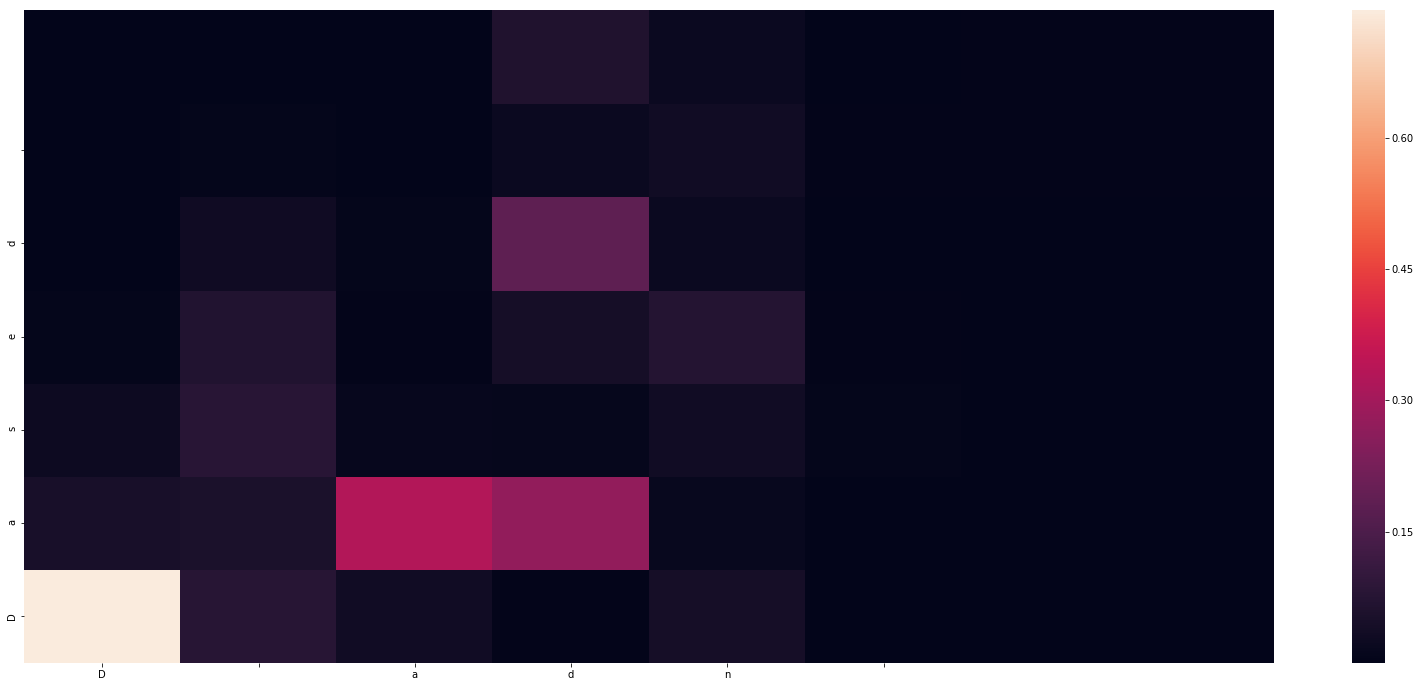

-
Input sentence: D adn 
GT sentence: D and C
Decoded sentence: Dased 


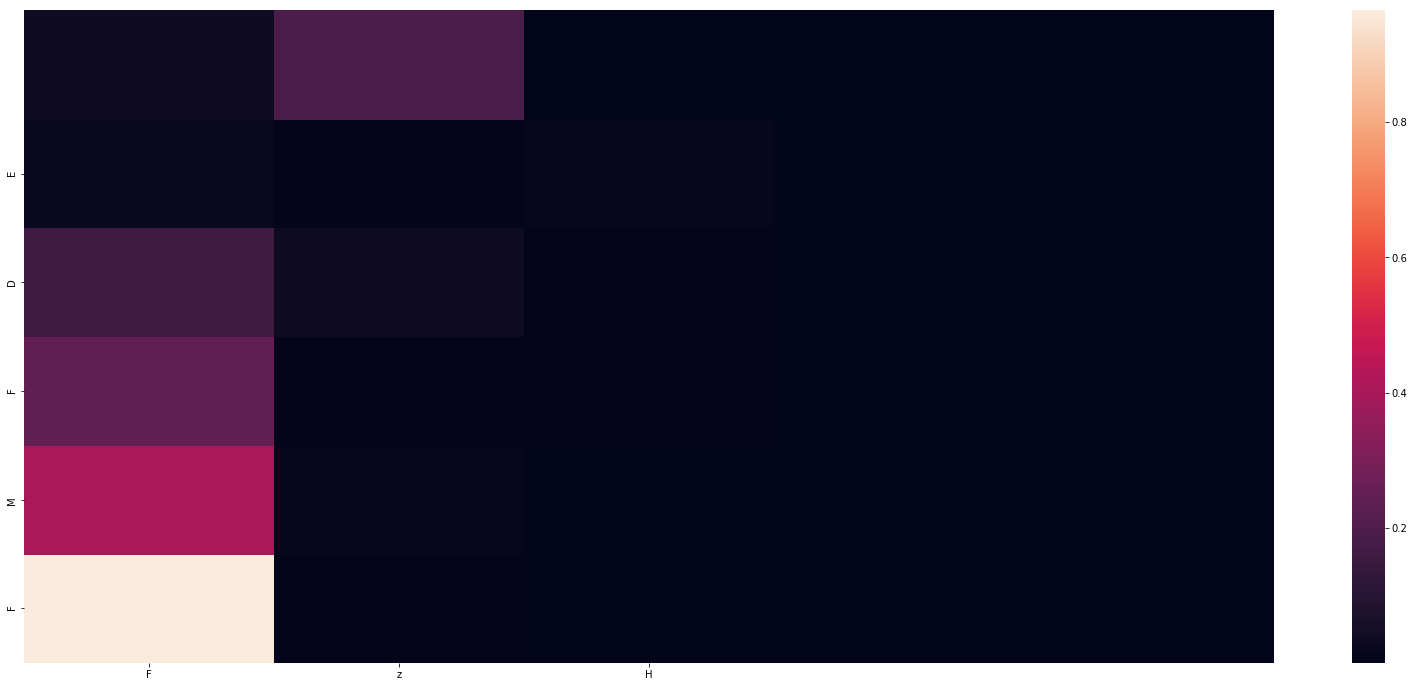

-
Input sentence: FzH
GT sentence: FHT
Decoded sentence: FMFDE


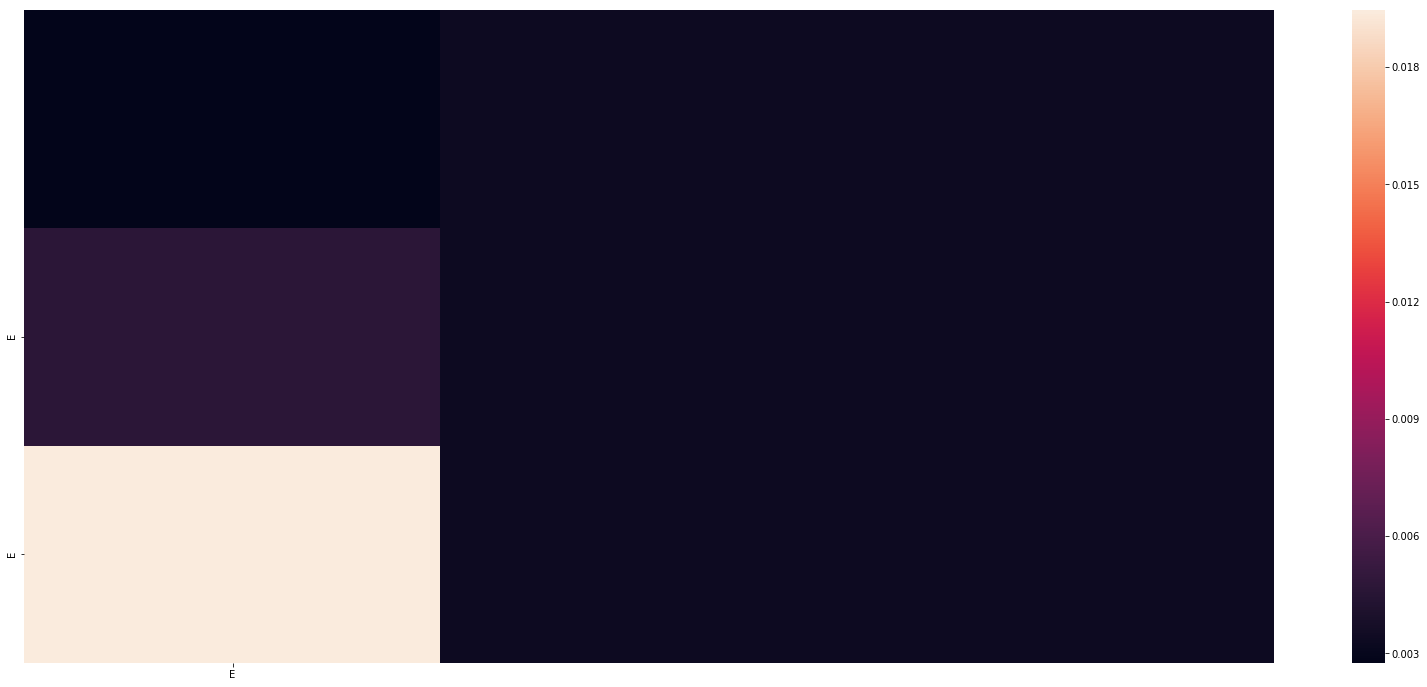

-
Input sentence: E
GT sentence: EP
Decoded sentence: EE


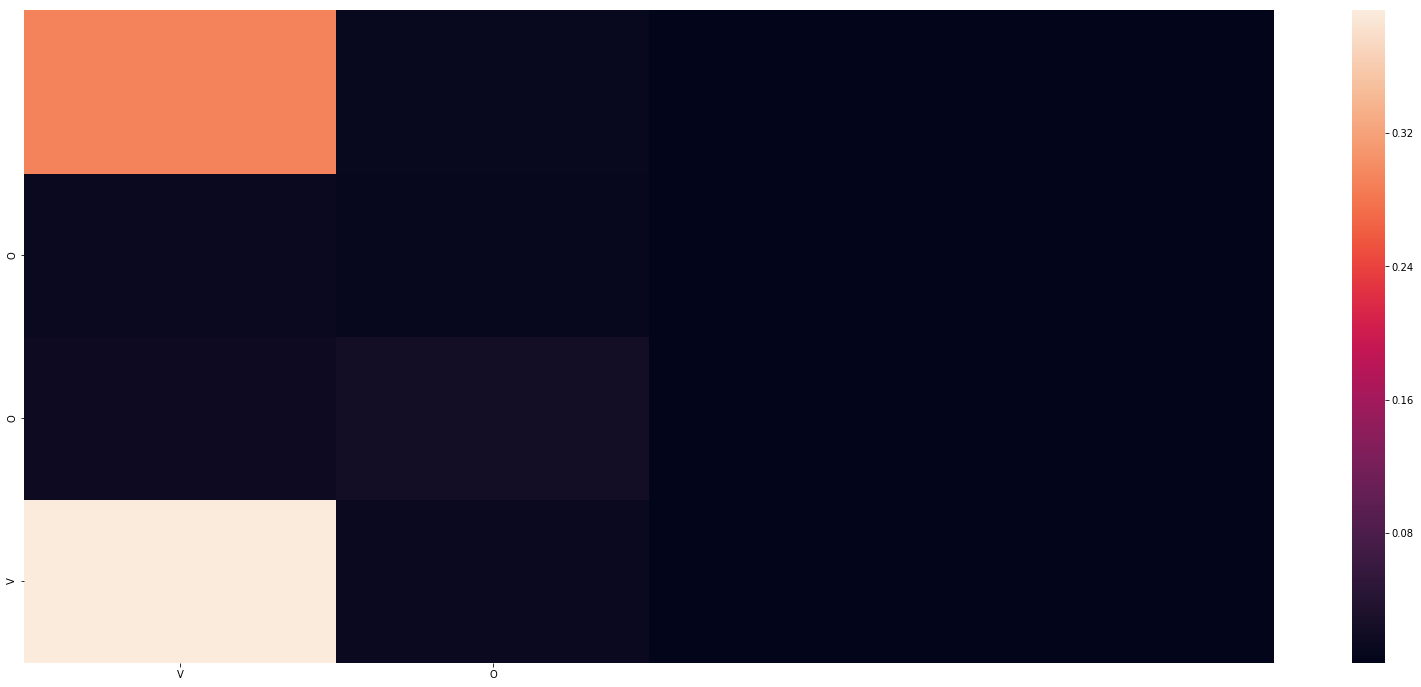

-
Input sentence: VO
GT sentence: VOE
Decoded sentence: VOO


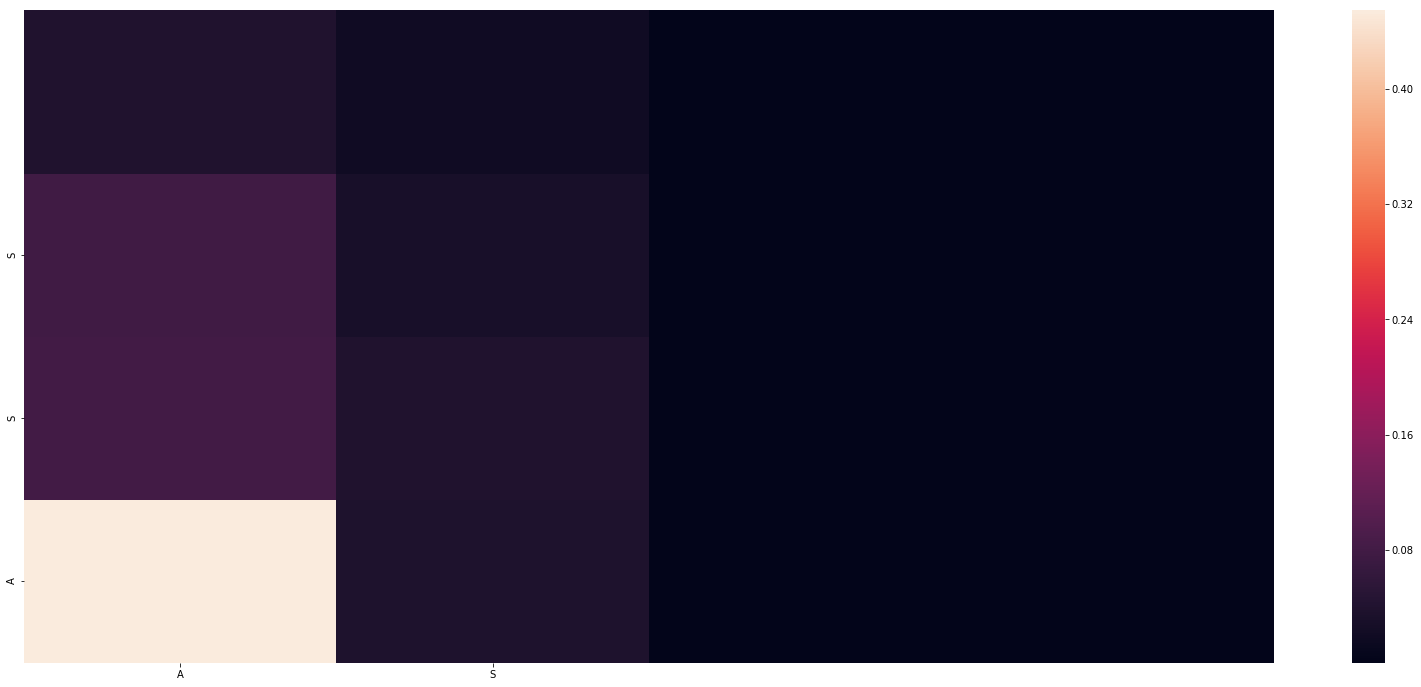

-
Input sentence: AS
GT sentence: ASA
Decoded sentence: ASS


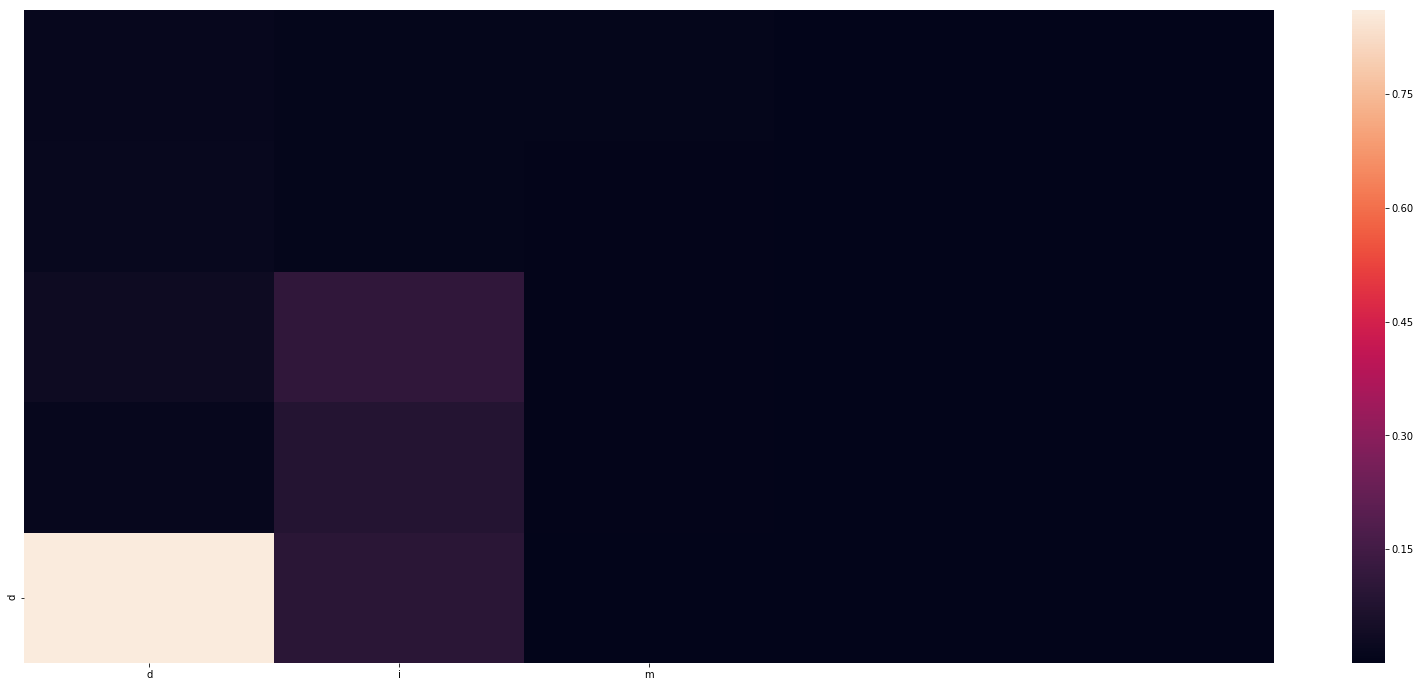

-
Input sentence: dim
GT sentence: dim.
Decoded sentence: d


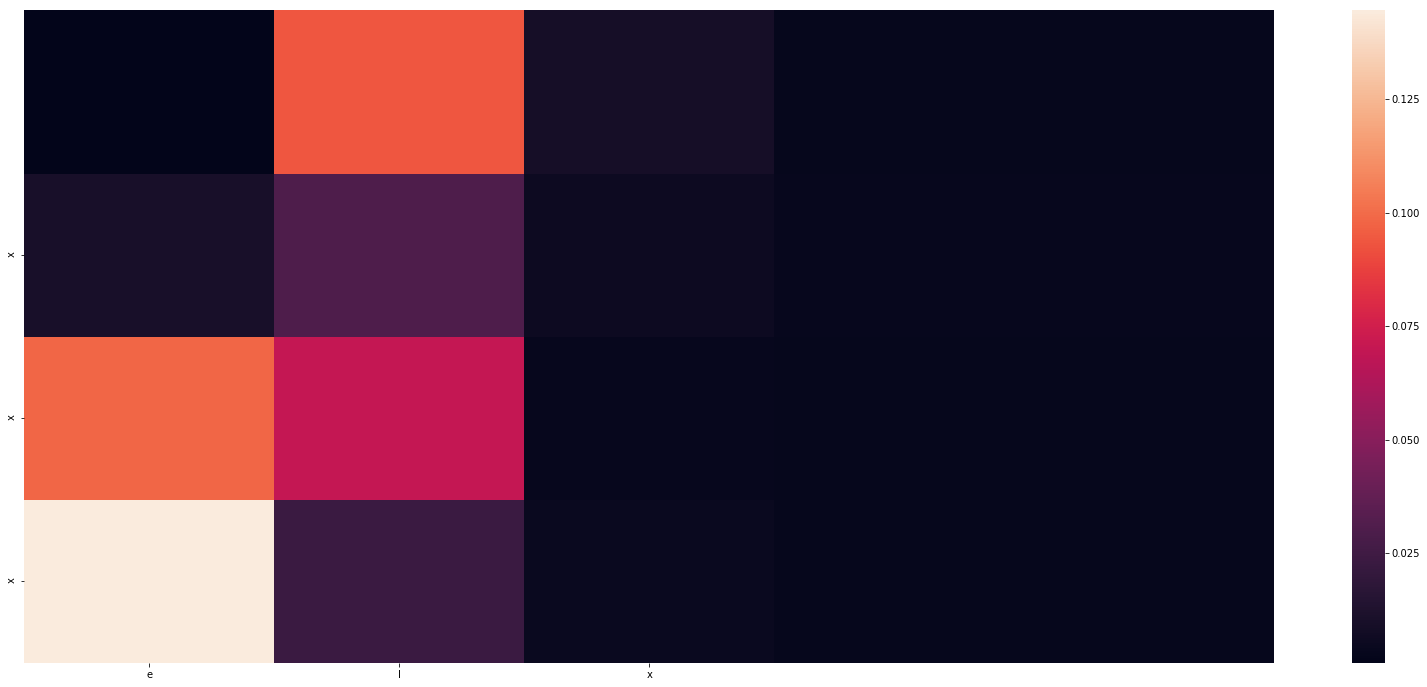

-
Input sentence: elx
GT sentence: elix.
Decoded sentence: xxx


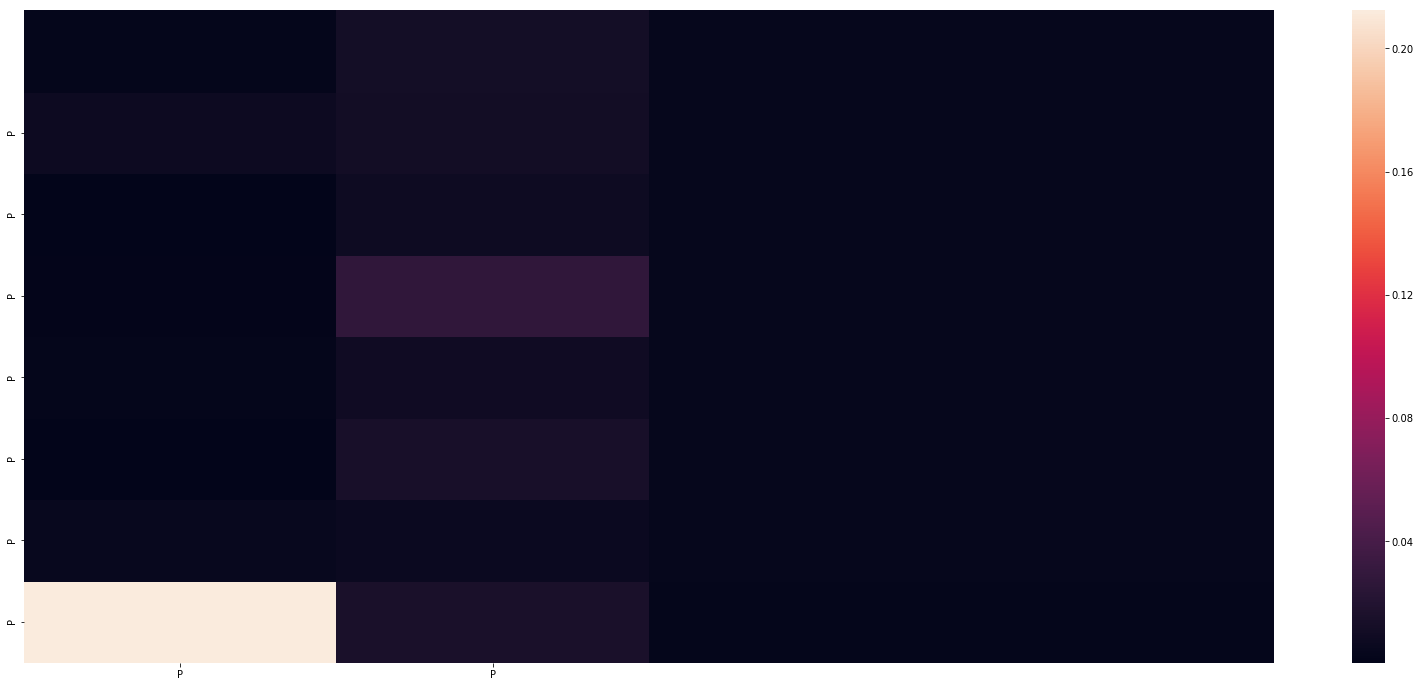

-
Input sentence: PP
GT sentence: PPD
Decoded sentence: PPPPPPP


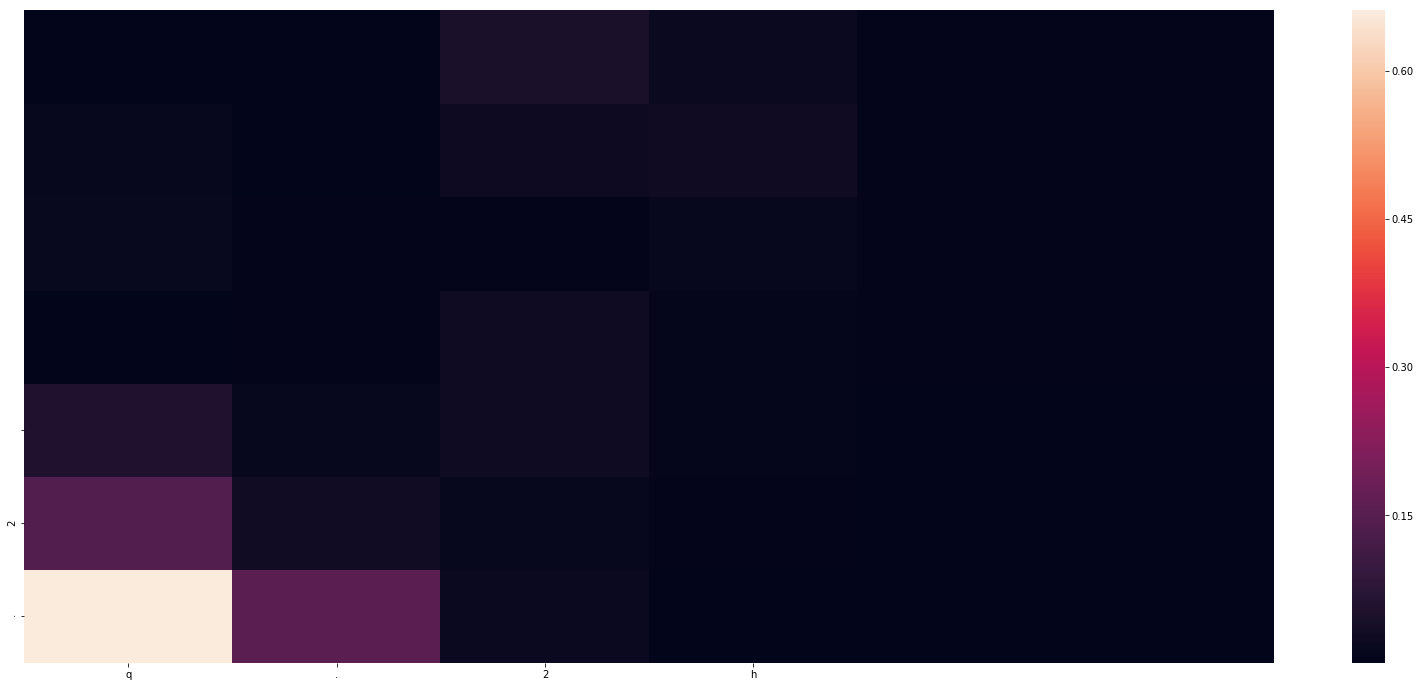

-
Input sentence: q.2h
GT sentence: q.2h.
Decoded sentence: .2 


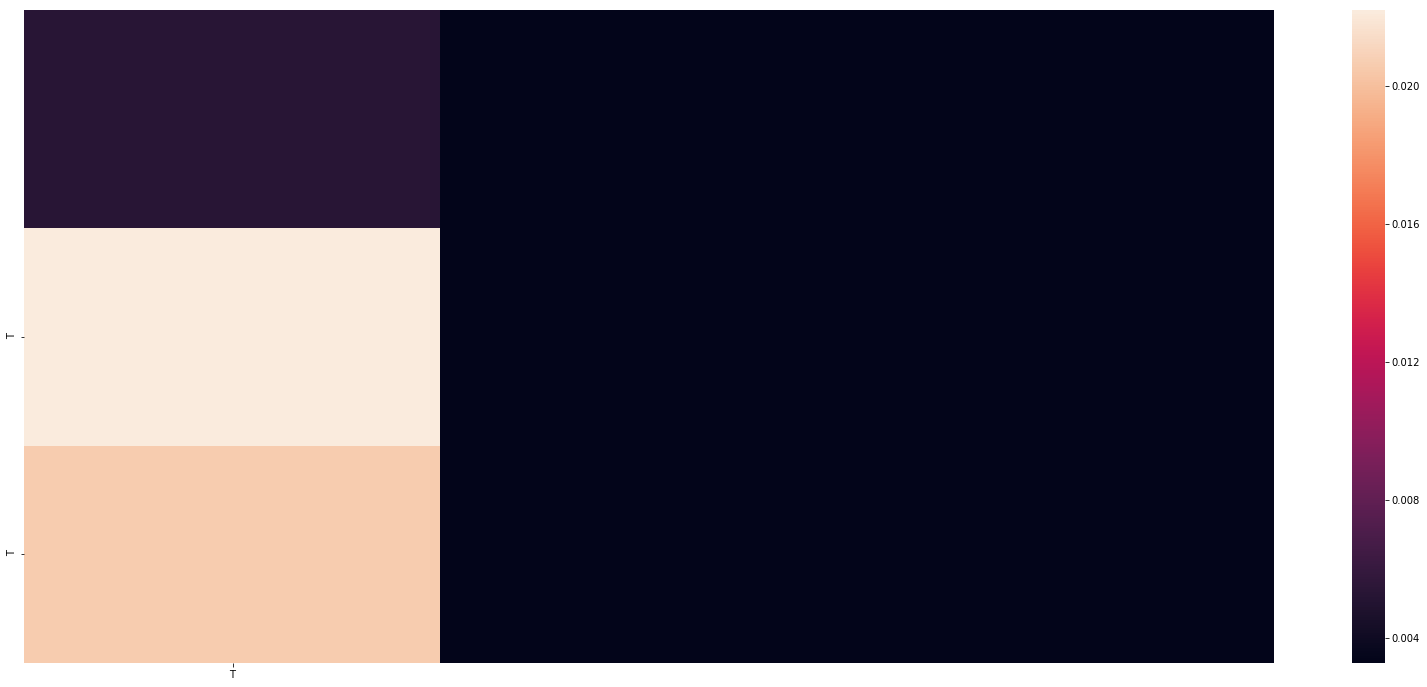

-
Input sentence: T
GT sentence: TG
Decoded sentence: TT


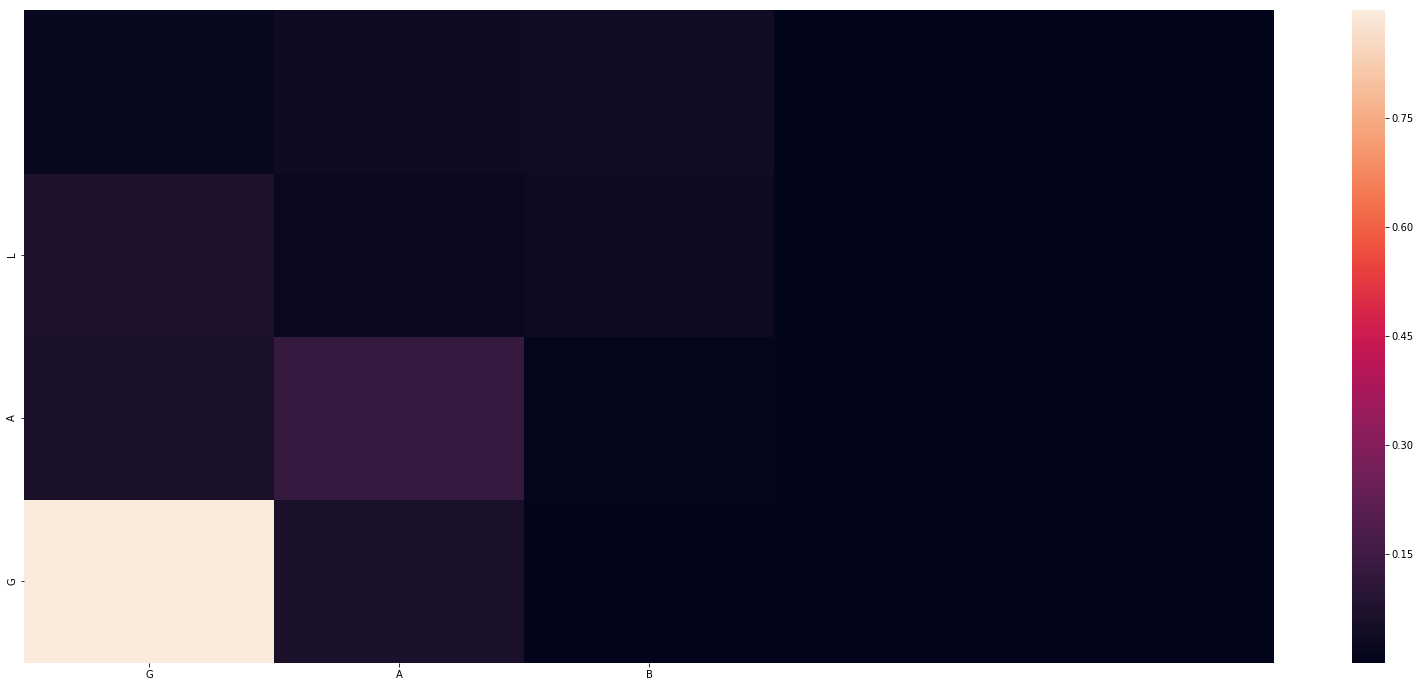

-
Input sentence: GAB
GT sentence: GABA
Decoded sentence: GAL


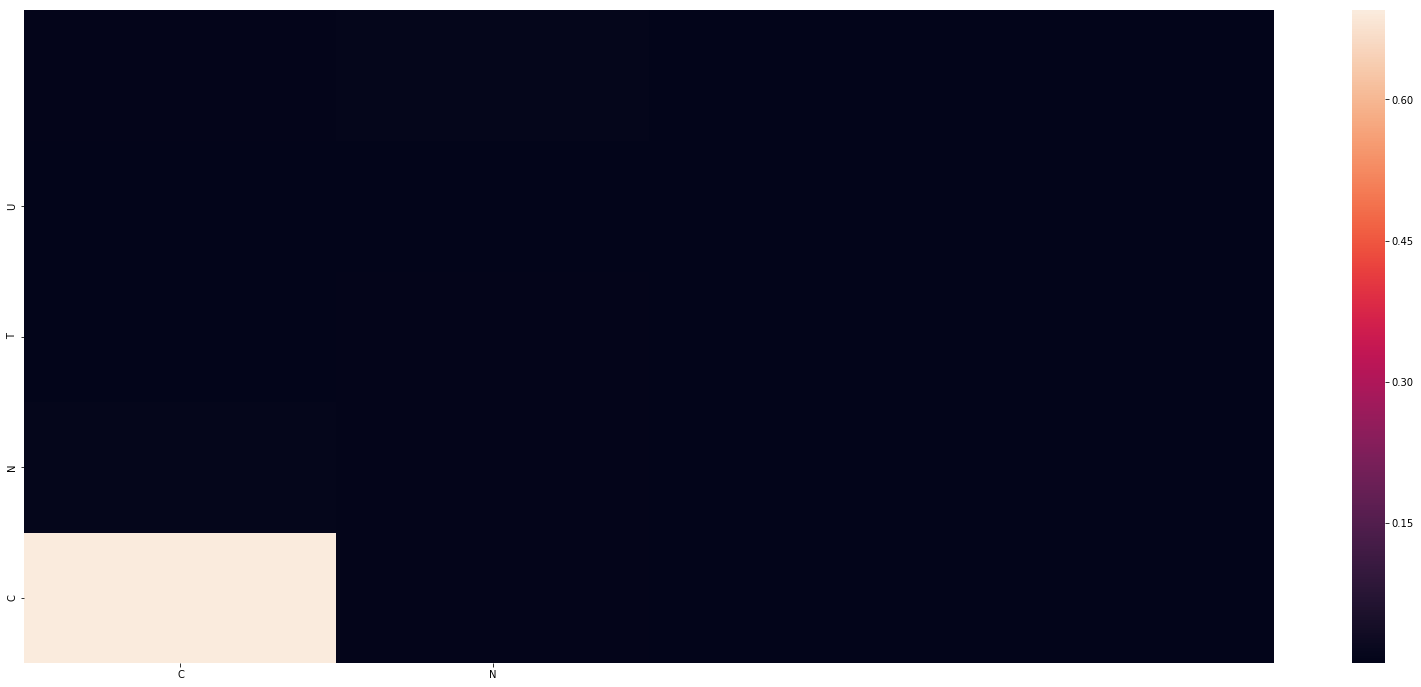

-
Input sentence: CN
GT sentence: CNS
Decoded sentence: CNTU


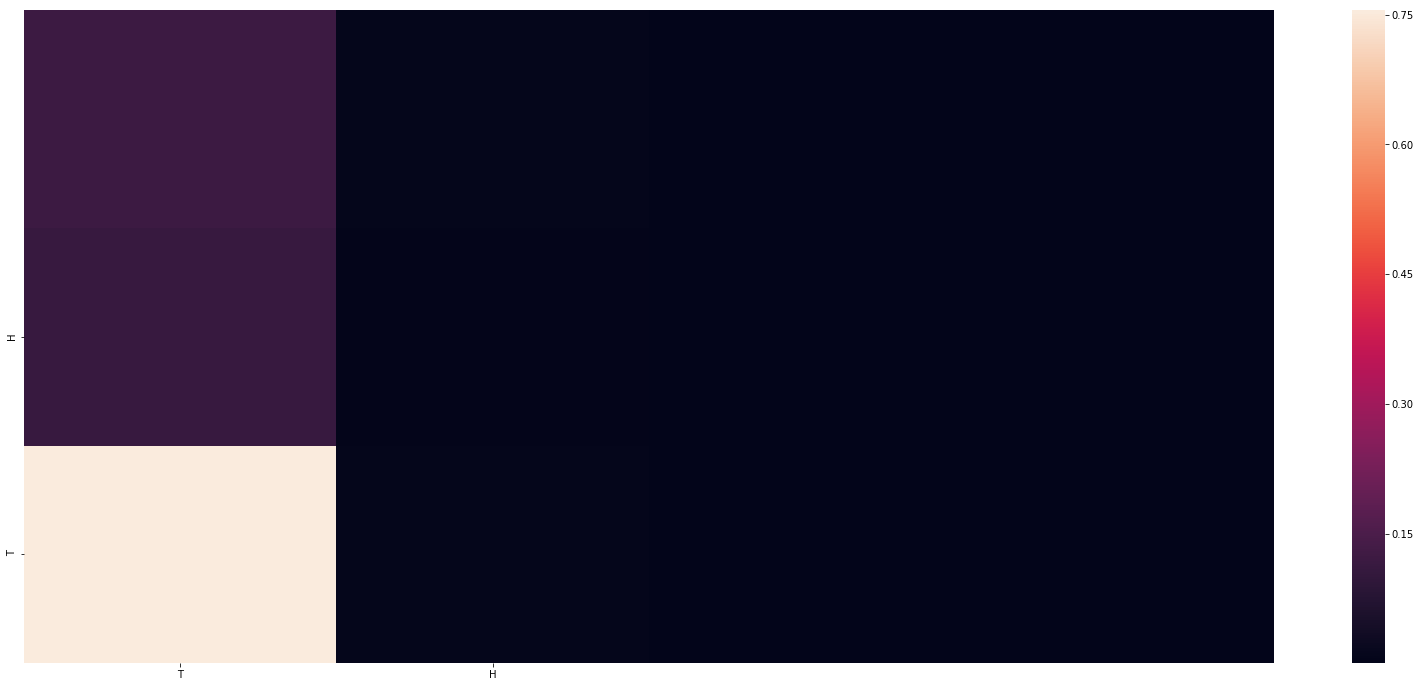

-
Input sentence: TH
GT sentence: THR
Decoded sentence: TH


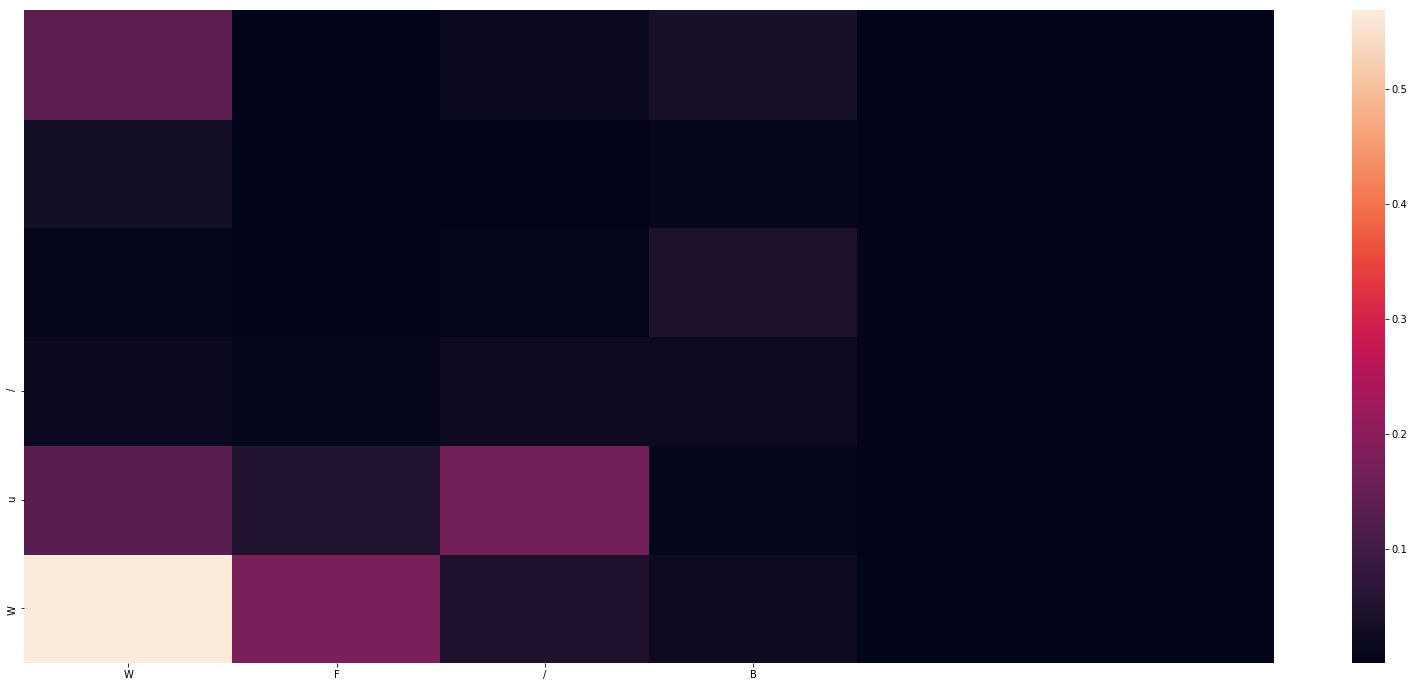

-
Input sentence: WF/B
GT sentence: WF/BF
Decoded sentence: Wu/


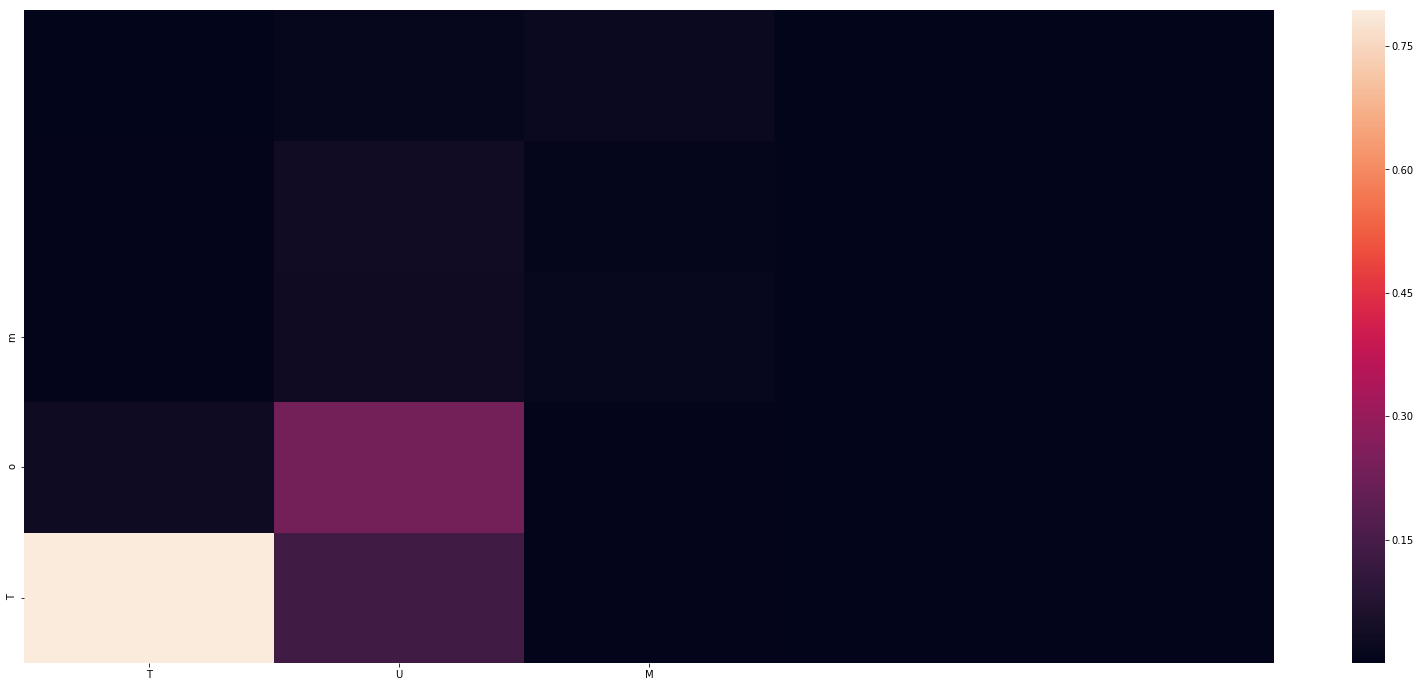

-
Input sentence: TUM
GT sentence: TUMA
Decoded sentence: Tom


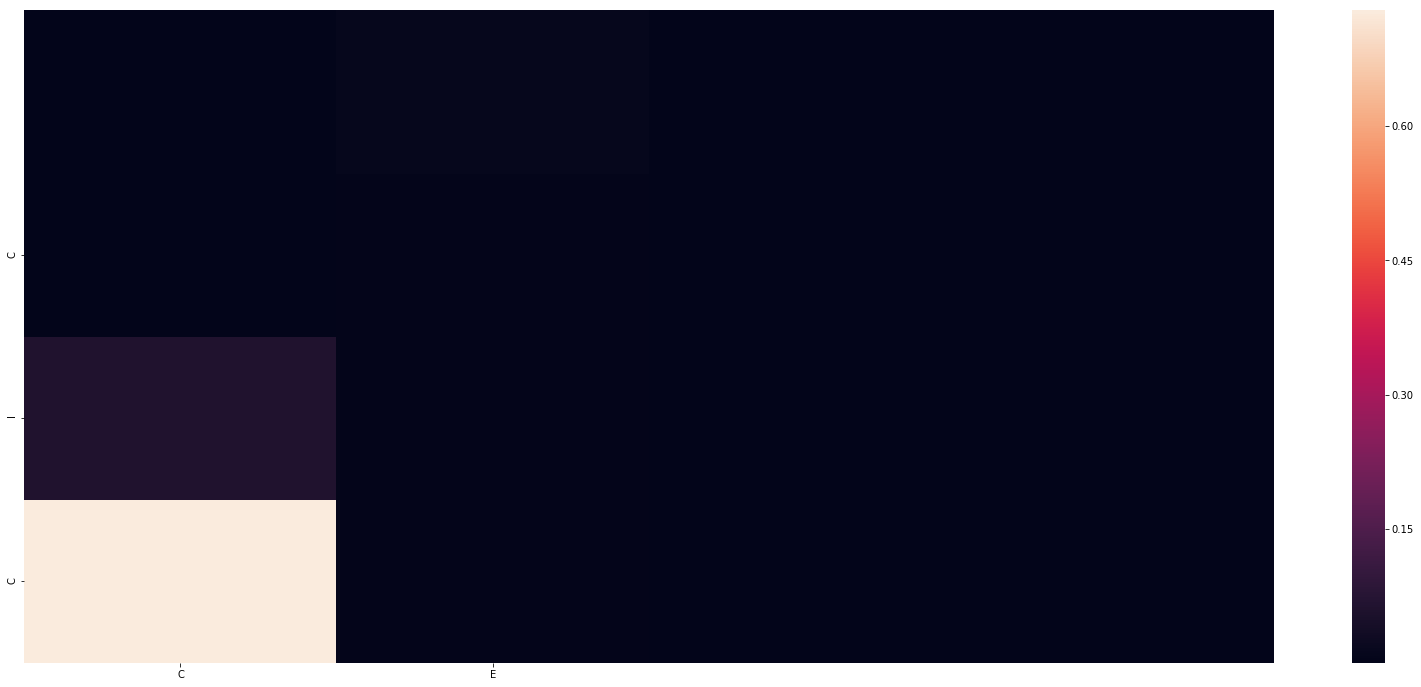

-
Input sentence: CE
GT sentence: CEA
Decoded sentence: ClC


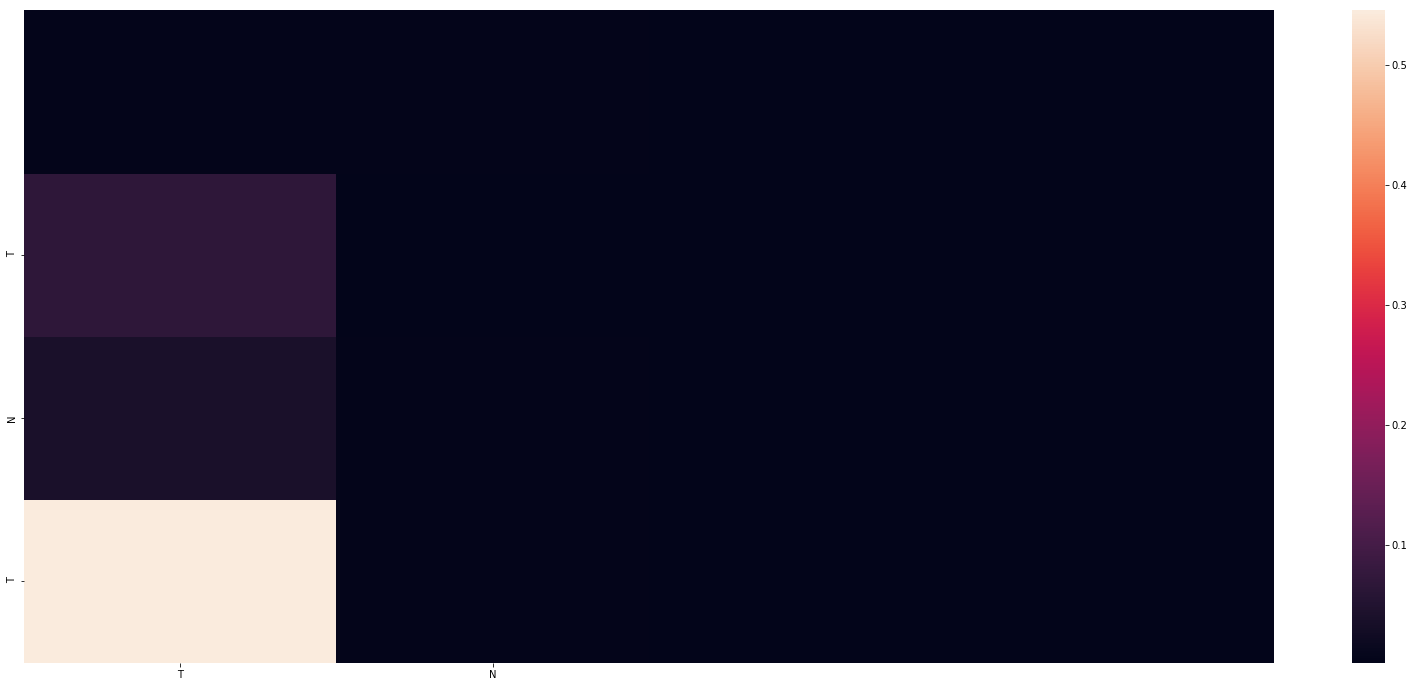

-
Input sentence: TN
GT sentence: TNT
Decoded sentence: TNT


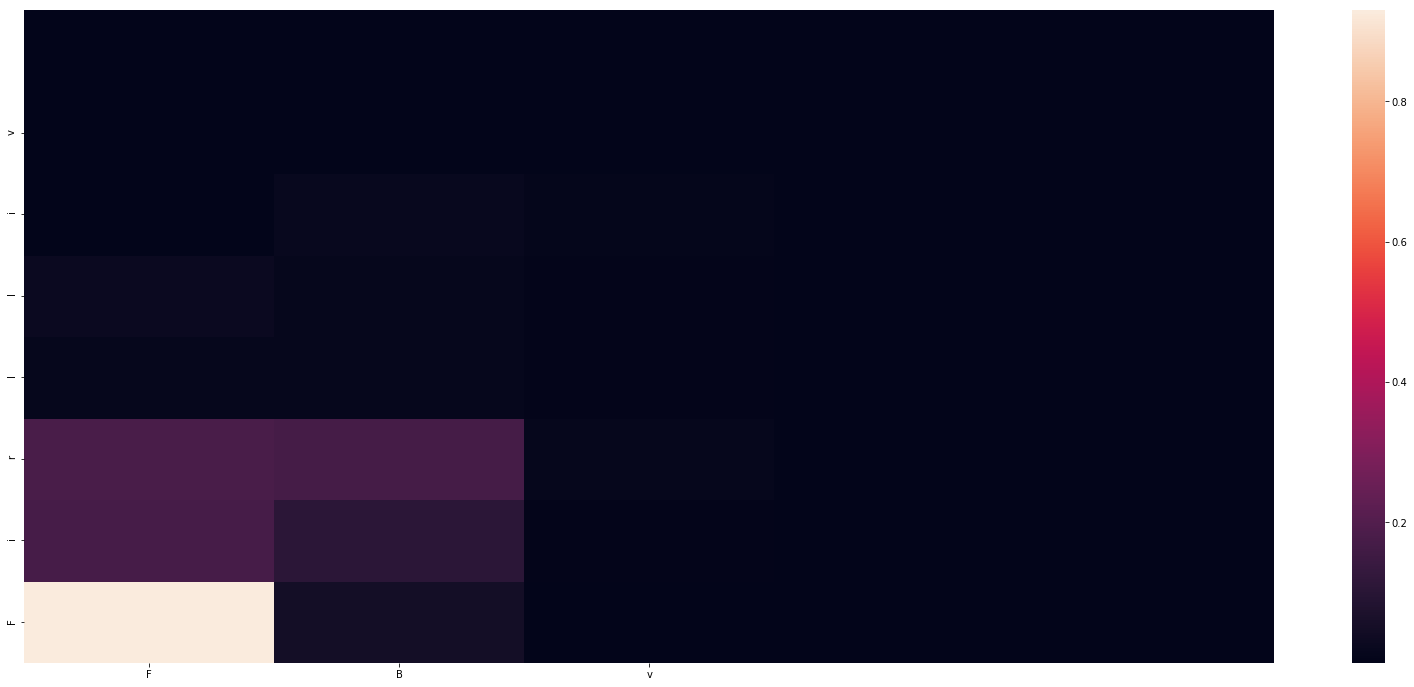

-
Input sentence: FBv
GT sentence: FBS
Decoded sentence: Firlliv


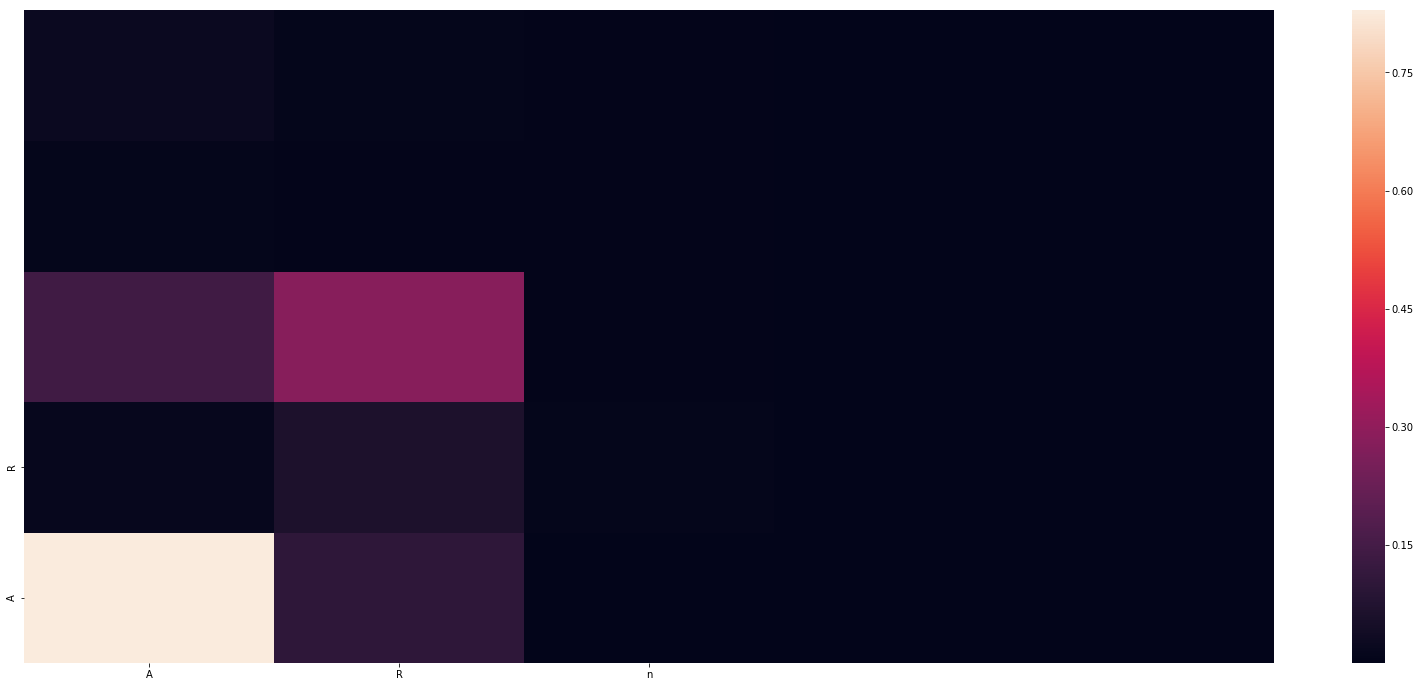

-
Input sentence: ARn
GT sentence: ARC
Decoded sentence: AR


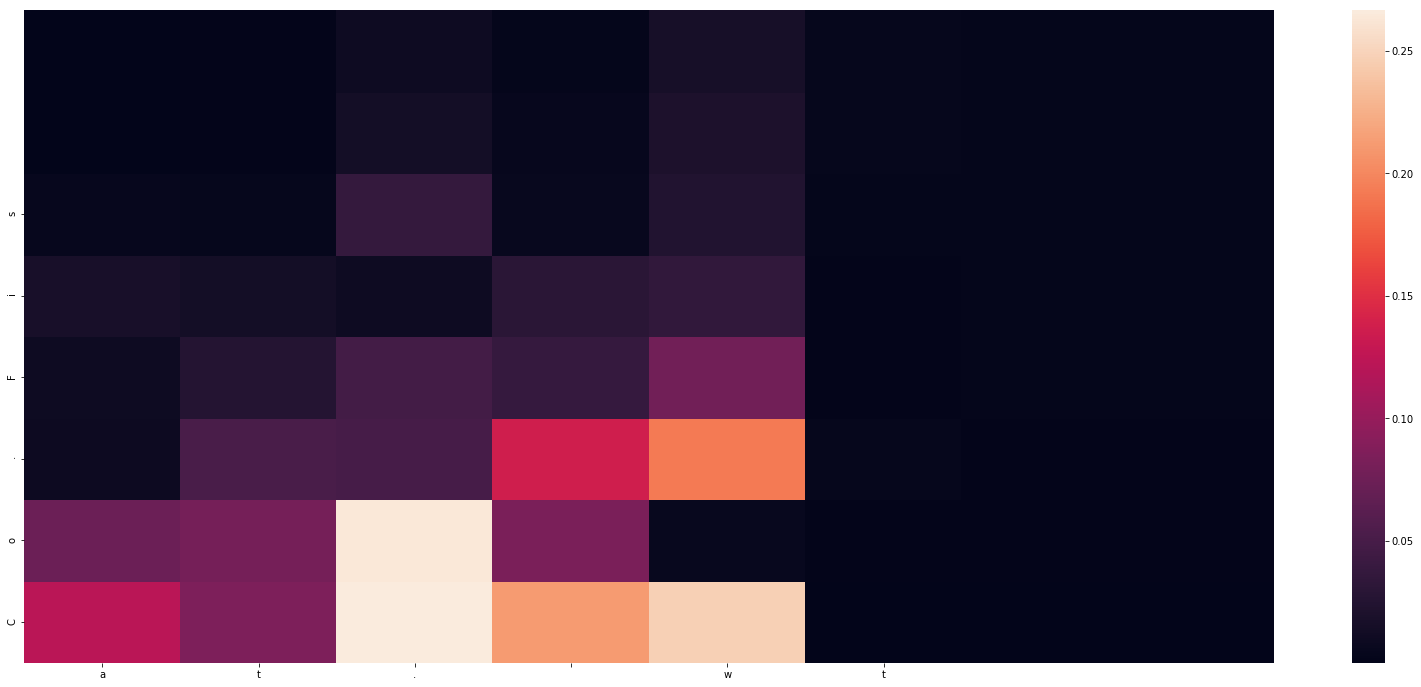

-
Input sentence: at. wt
GT sentence: at. wt.
Decoded sentence: Co.Fis


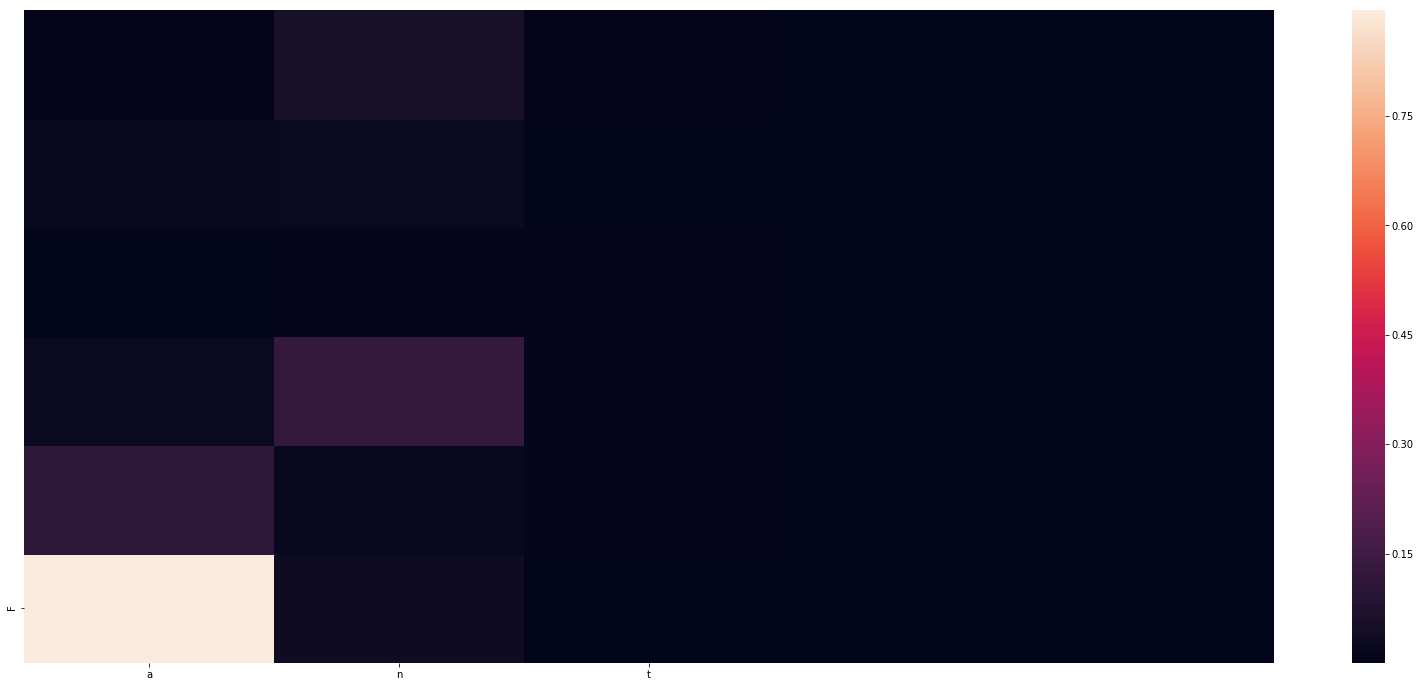

-
Input sentence: ant
GT sentence: ant.
Decoded sentence: F


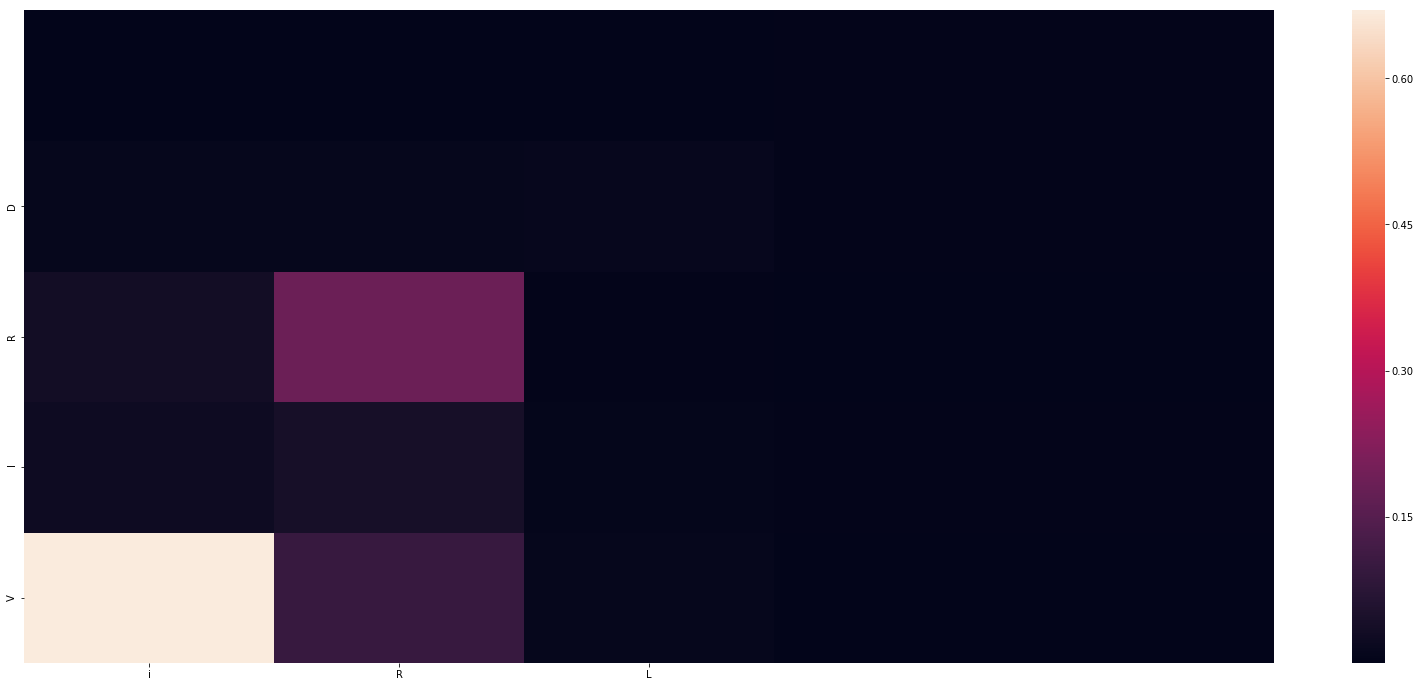

-
Input sentence: iRL
GT sentence: RLL
Decoded sentence: VlRD


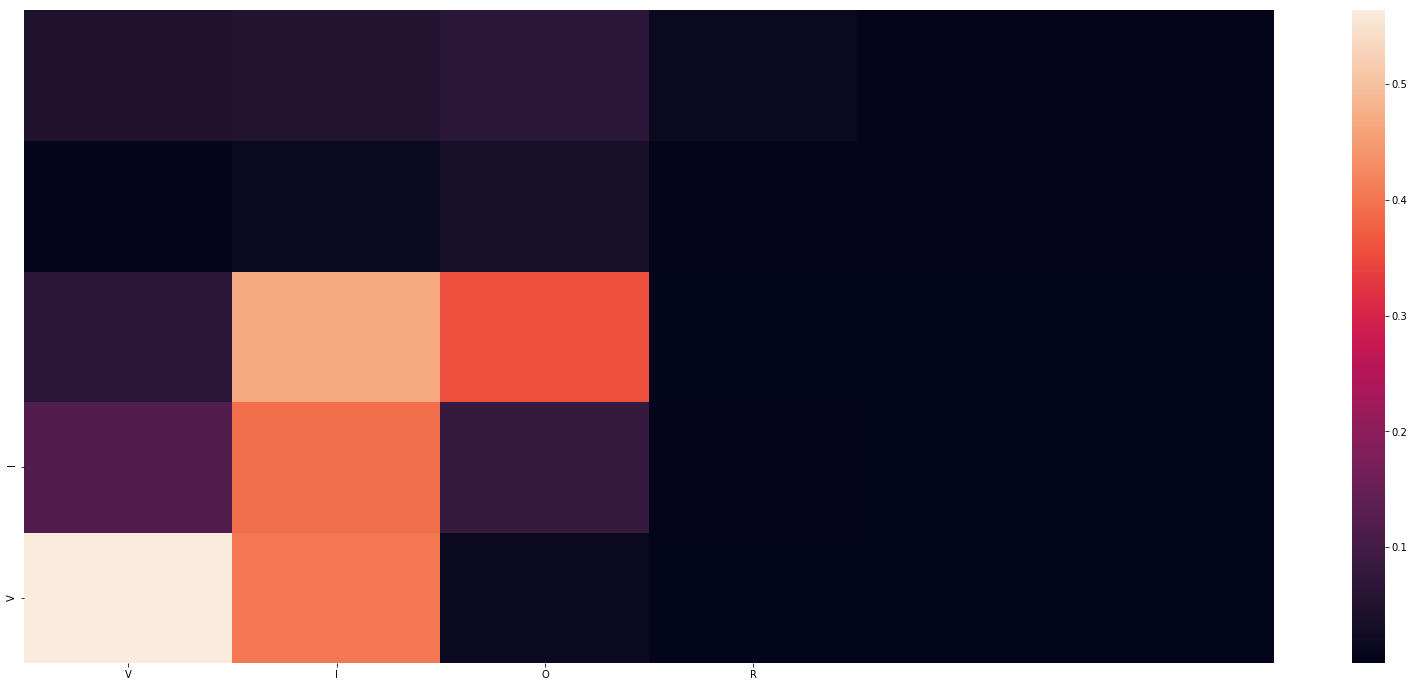

-
Input sentence: VlOR
GT sentence: VORB
Decoded sentence: Vl


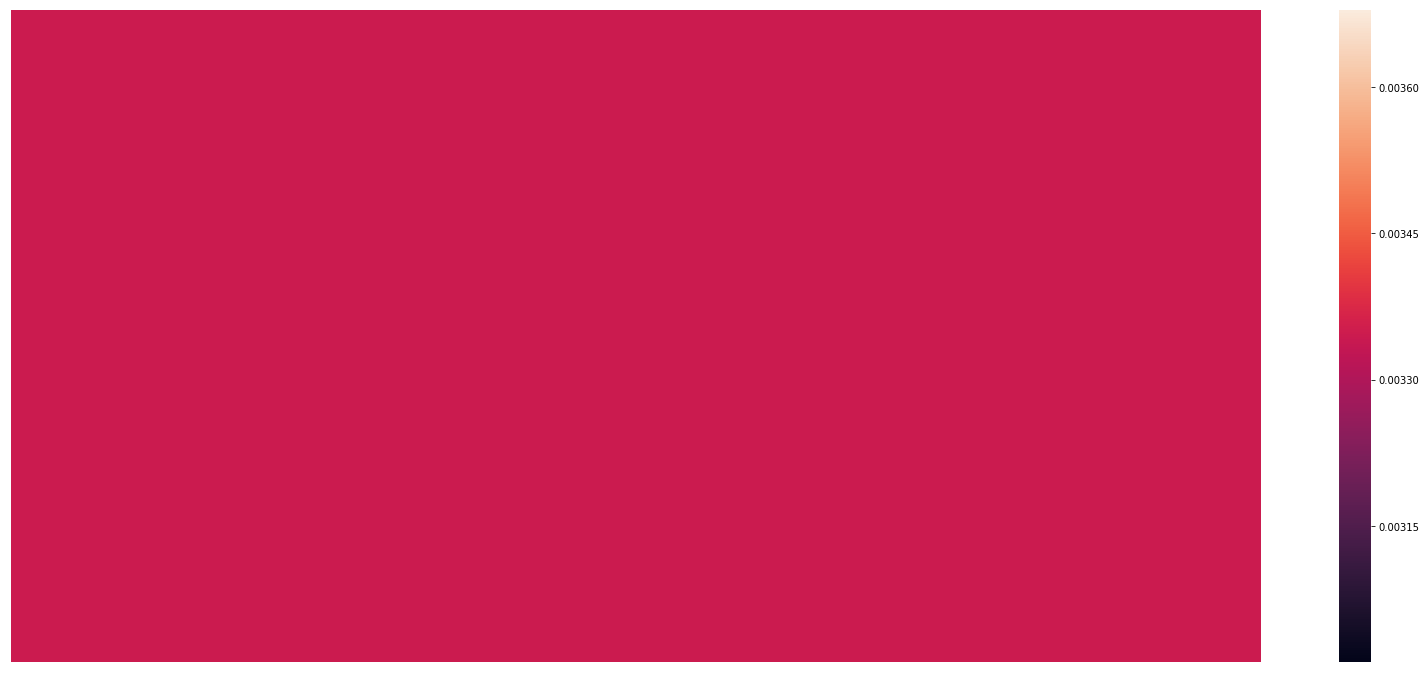

-
Input sentence: 
GT sentence: LE
Decoded sentence: 


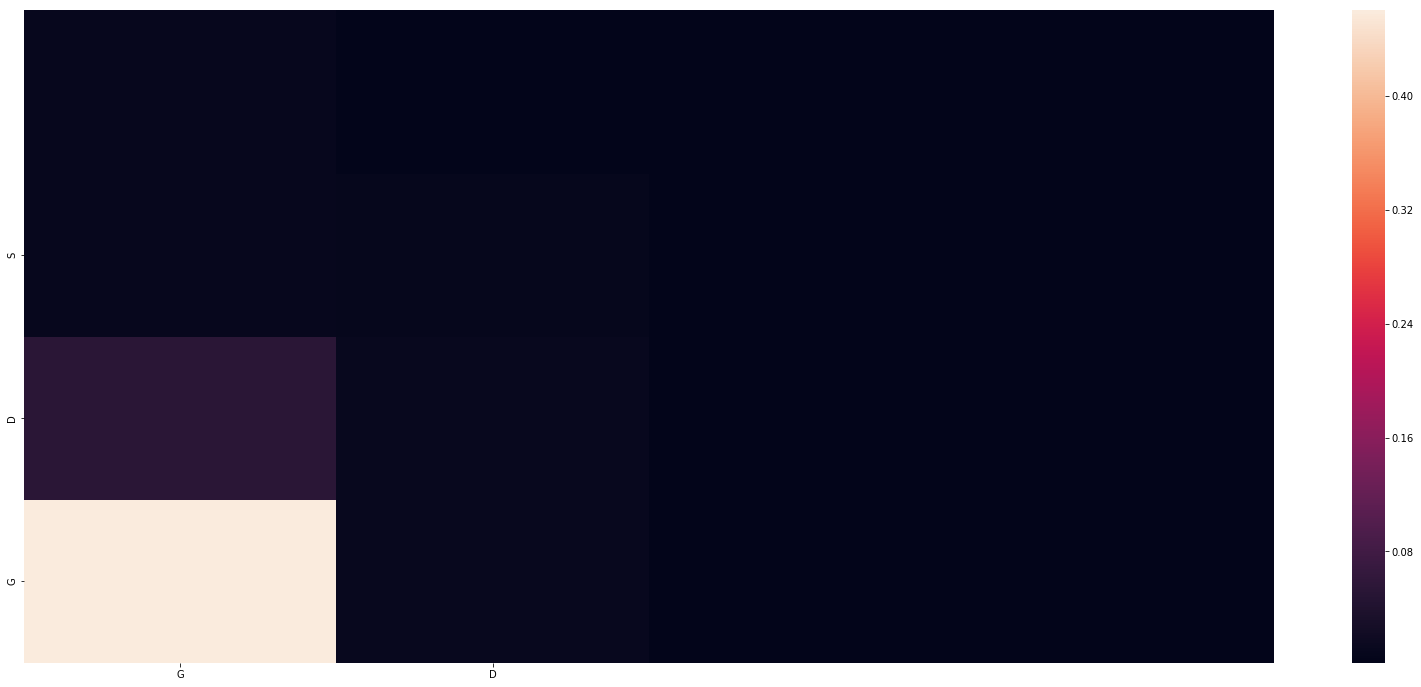

-
Input sentence: GD
GT sentence: GDM
Decoded sentence: GDS


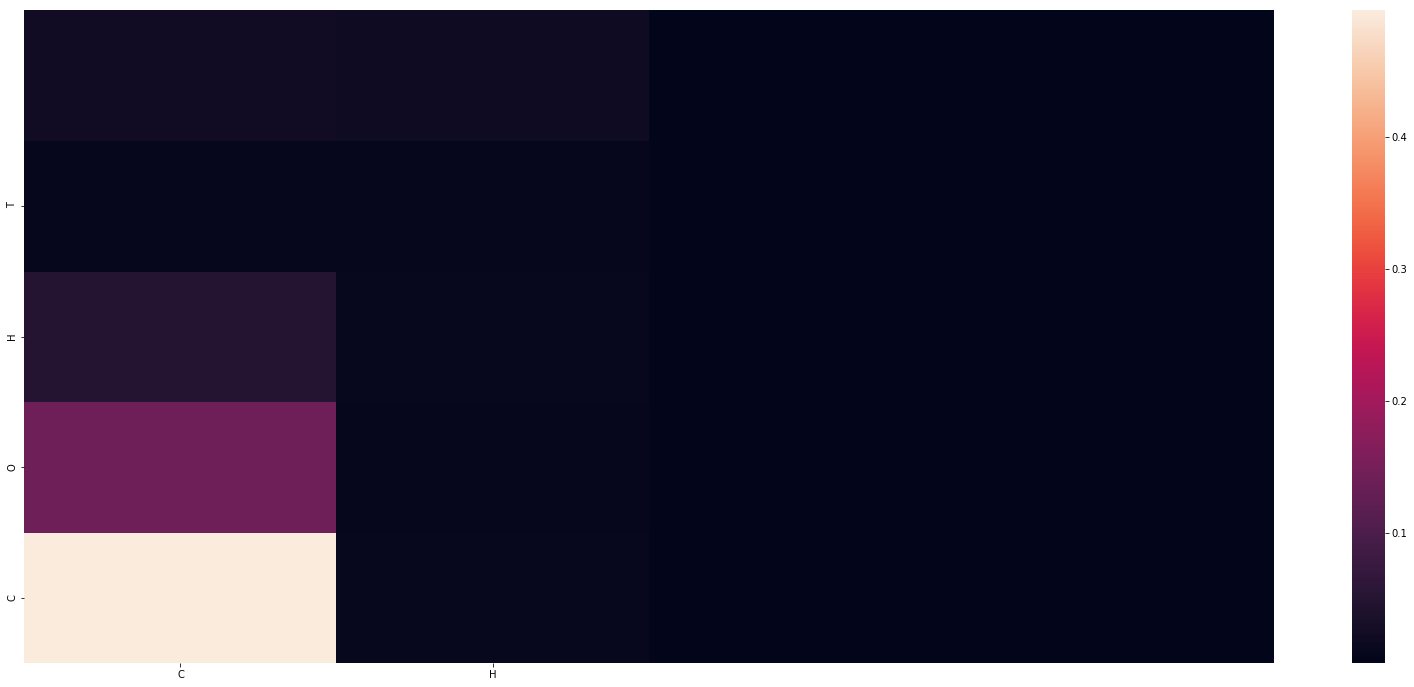

-
Input sentence: CH
GT sentence: CHF
Decoded sentence: COHT


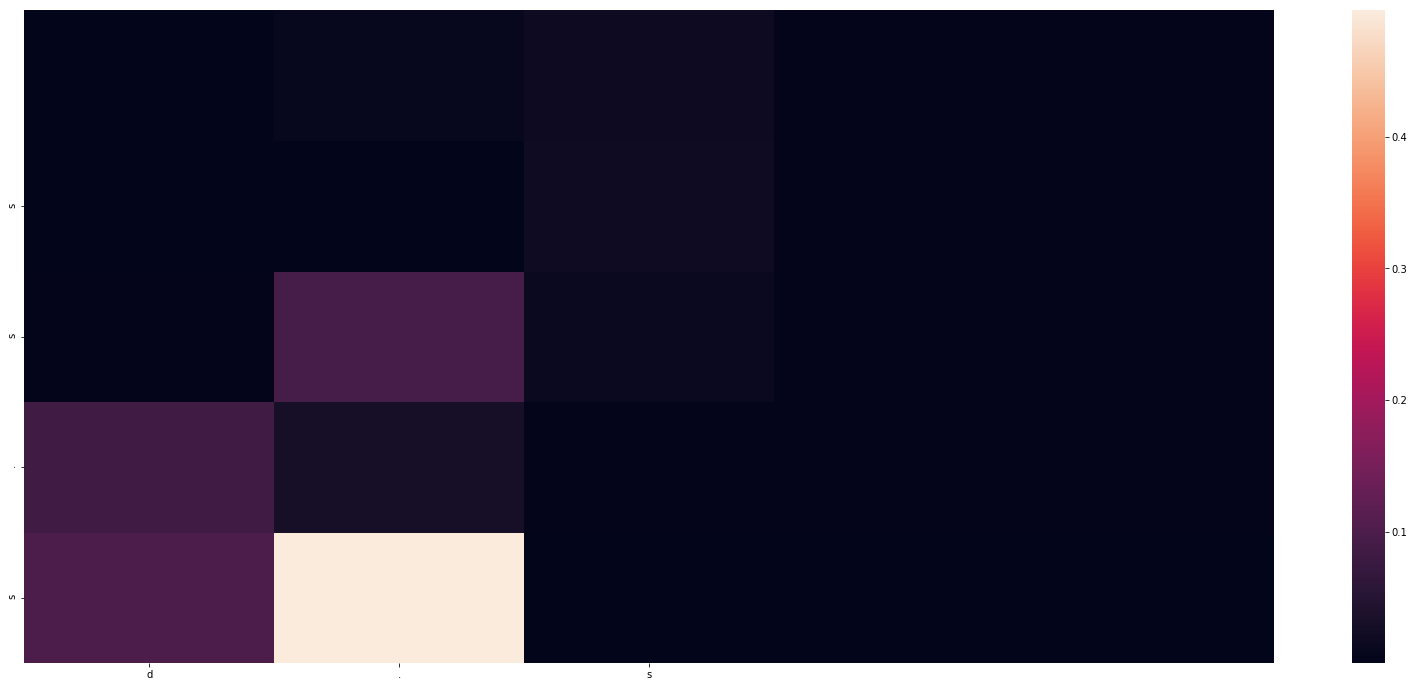

-
Input sentence: d.s
GT sentence: t.d.s.
Decoded sentence: s.ss


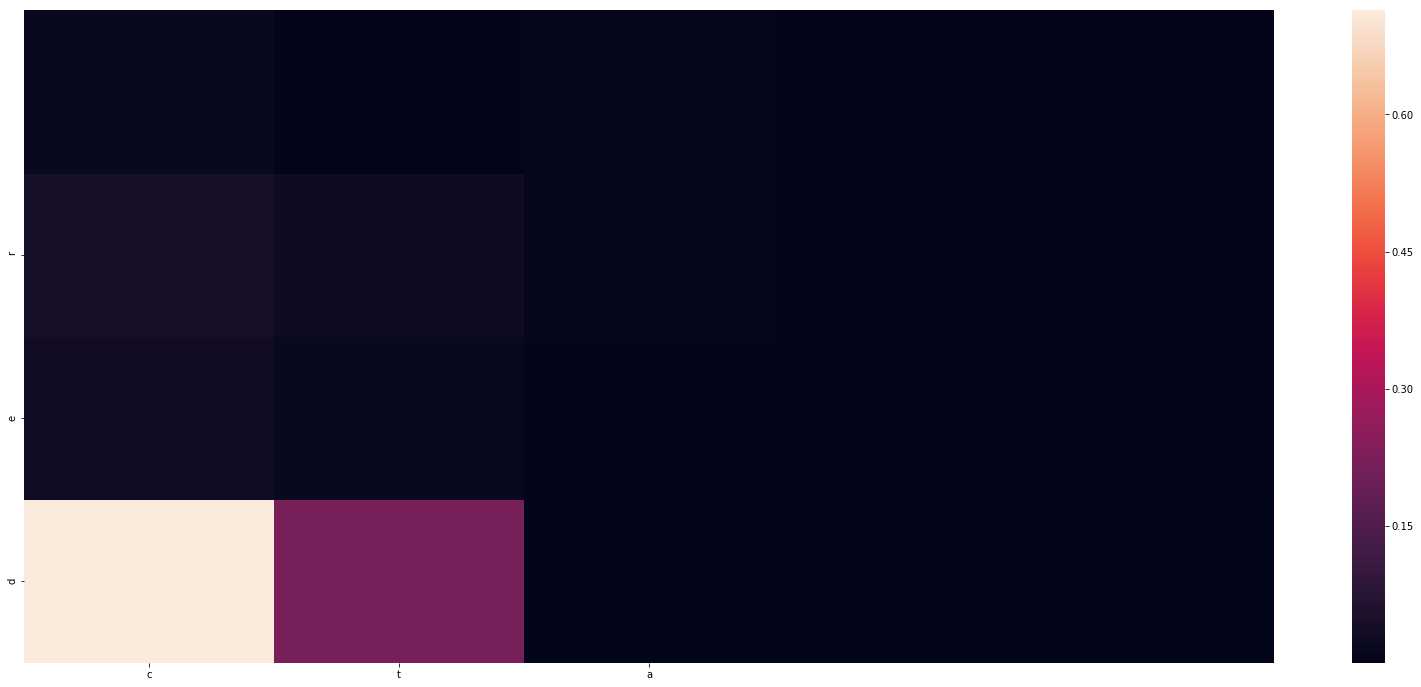

-
Input sentence: cta
GT sentence: cath
Decoded sentence: der


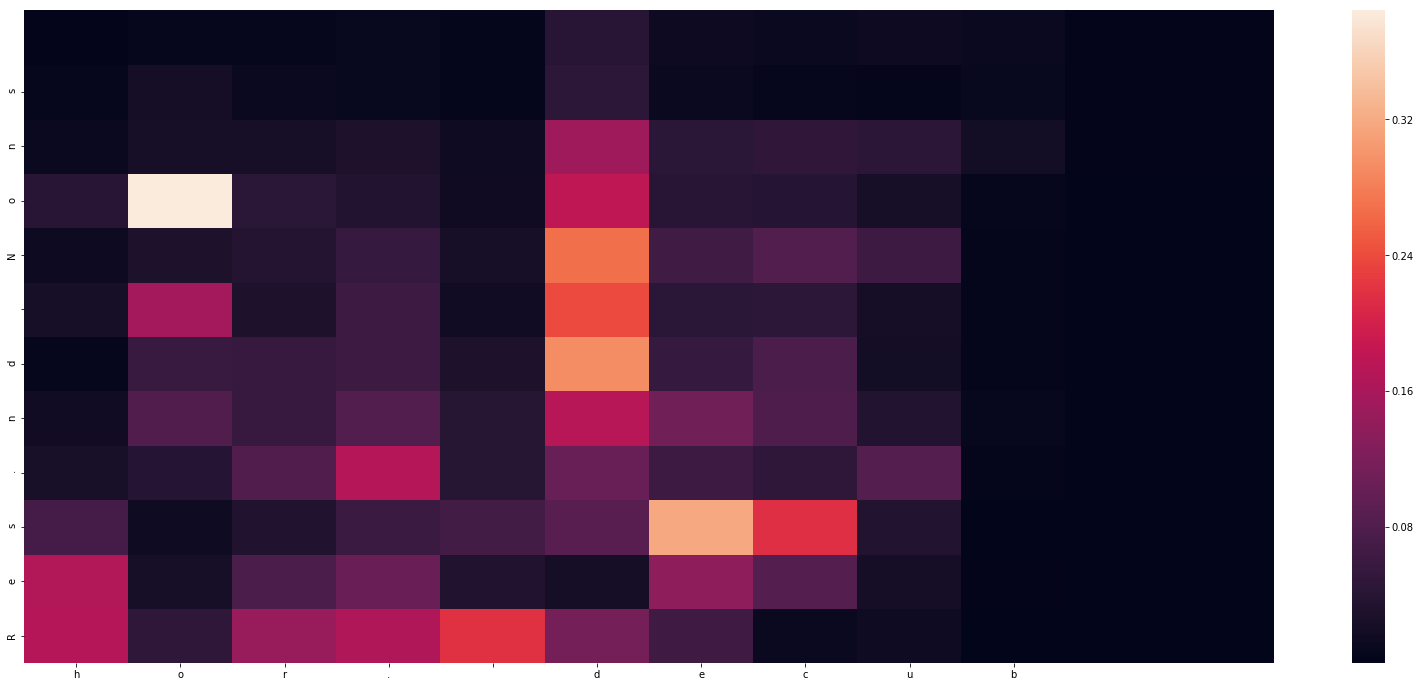

-
Input sentence: hor. decub
GT sentence: hor. decub.
Decoded sentence: Res.nd Nons


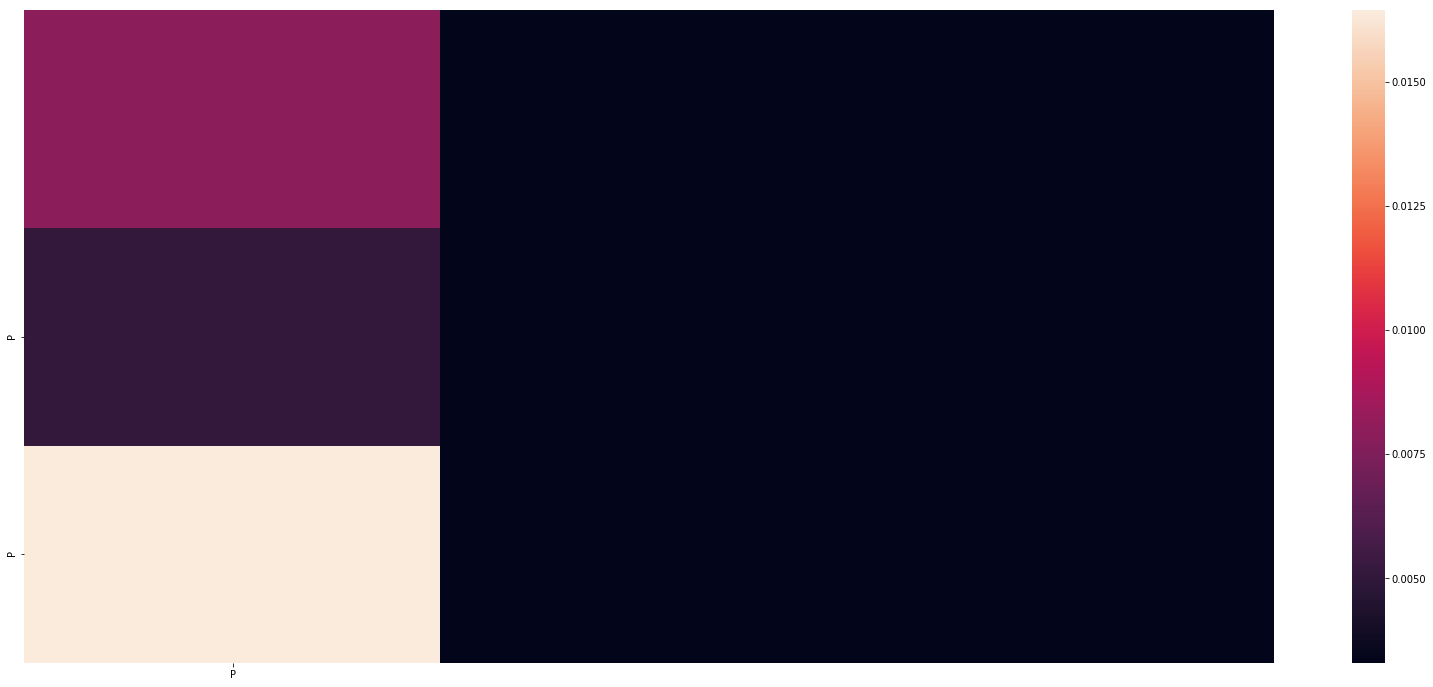

-
Input sentence: P
GT sentence: Pu
Decoded sentence: PP


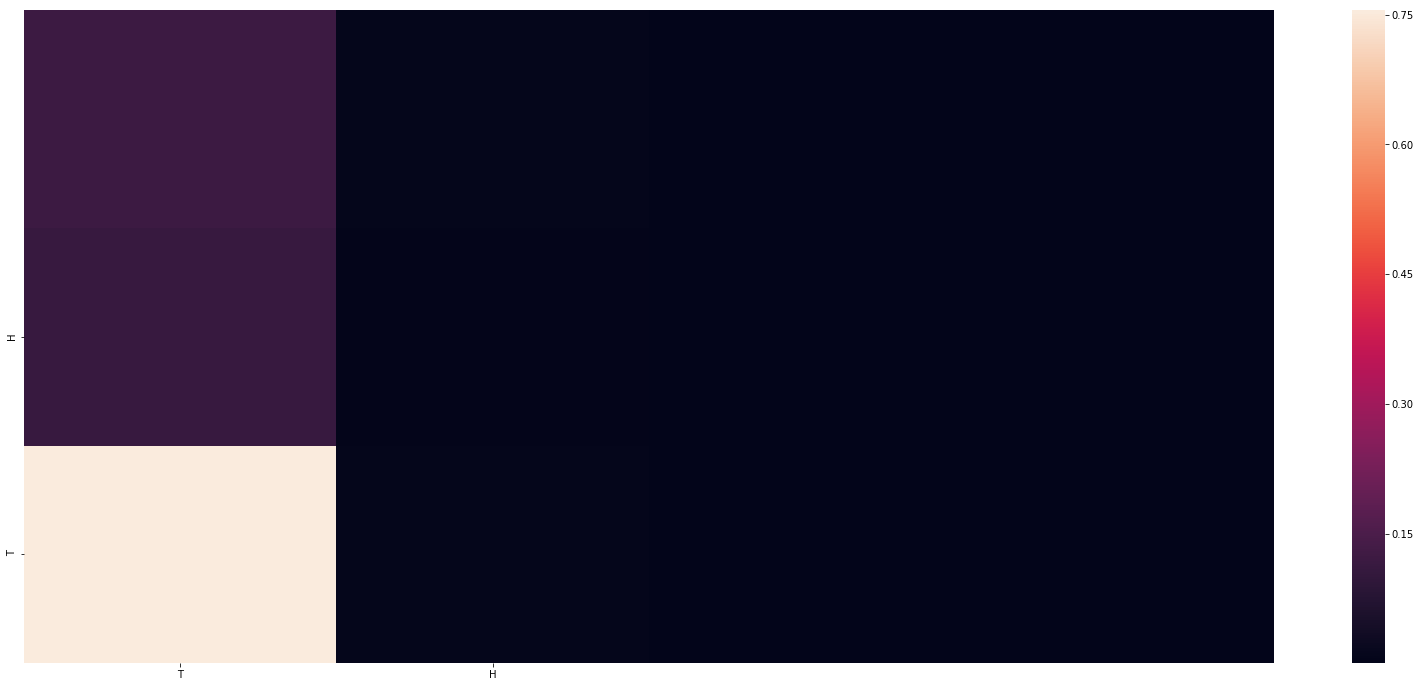

-
Input sentence: TH
GT sentence: TAH
Decoded sentence: TH


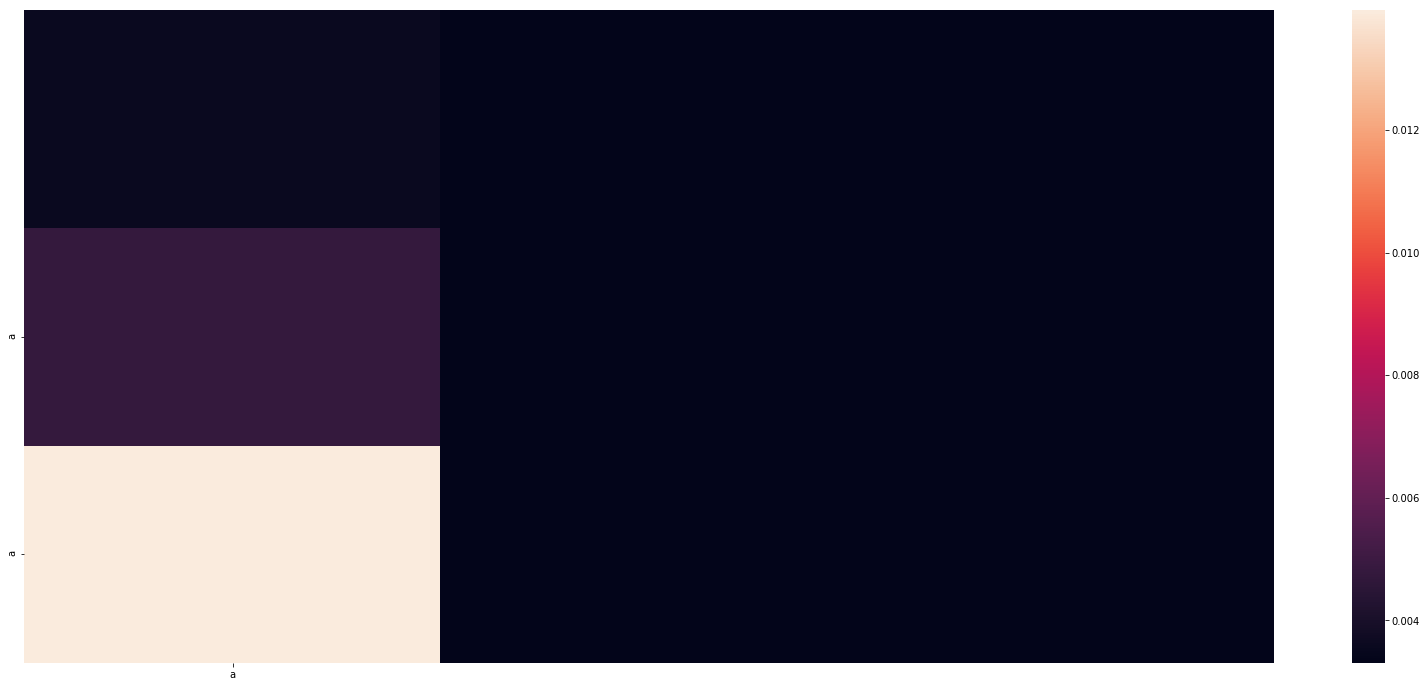

-
Input sentence: a
GT sentence: ap
Decoded sentence: aa


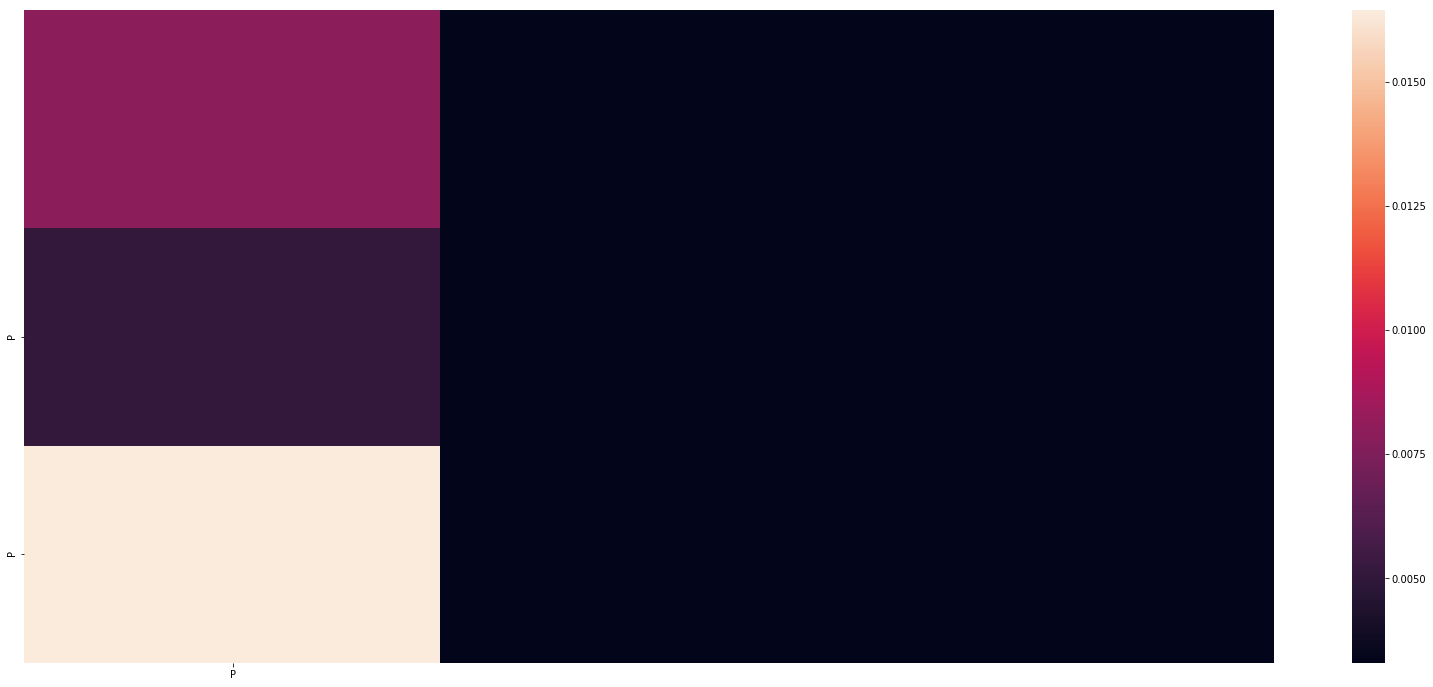

-
Input sentence: P
GT sentence: Pt
Decoded sentence: PP


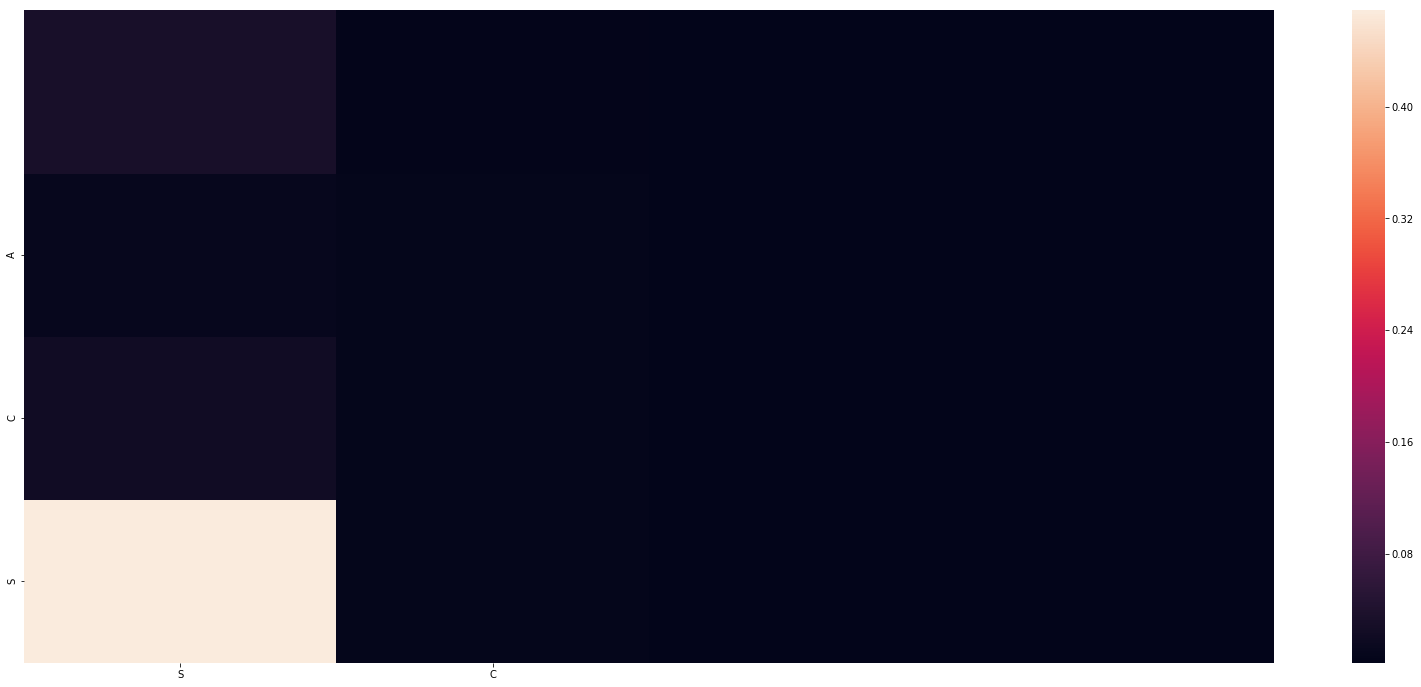

-
Input sentence: SC
GT sentence: ASCA
Decoded sentence: SCA


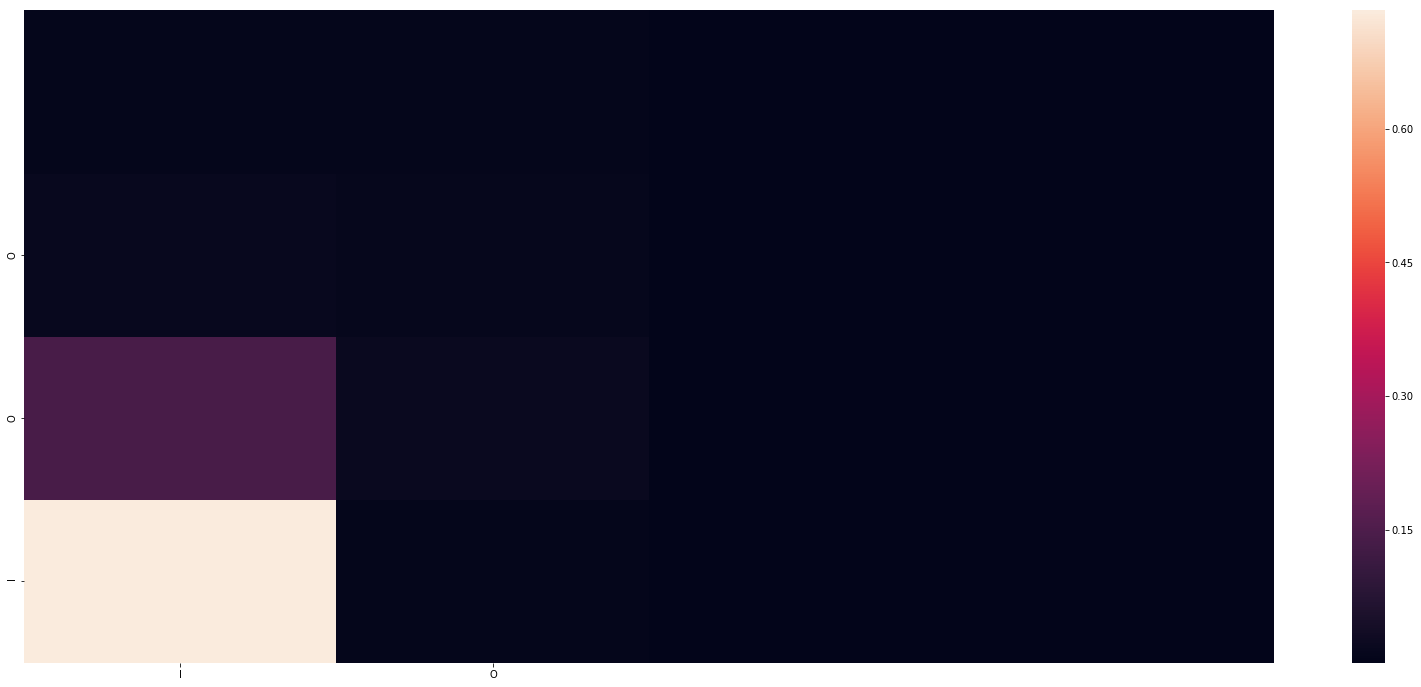

-
Input sentence: IO
GT sentence: IOP
Decoded sentence: IOO


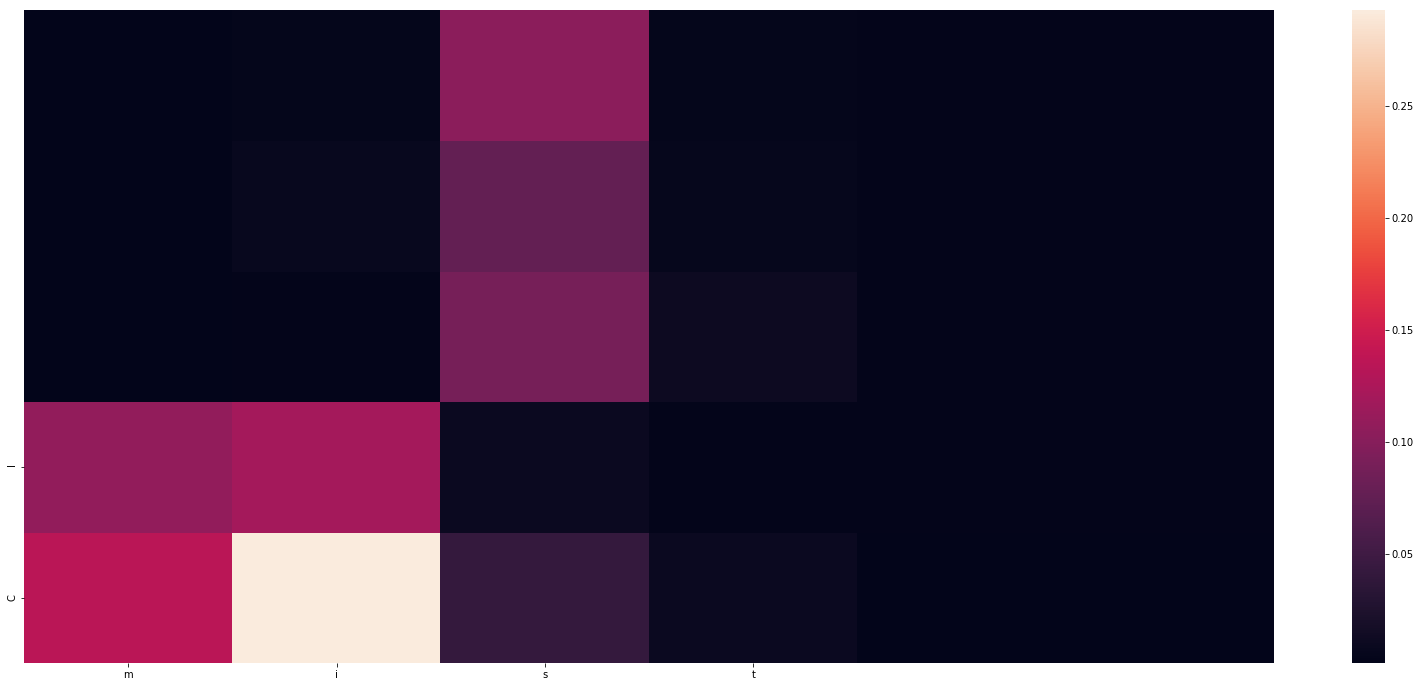

-
Input sentence: mist
GT sentence: mist.
Decoded sentence: Cl


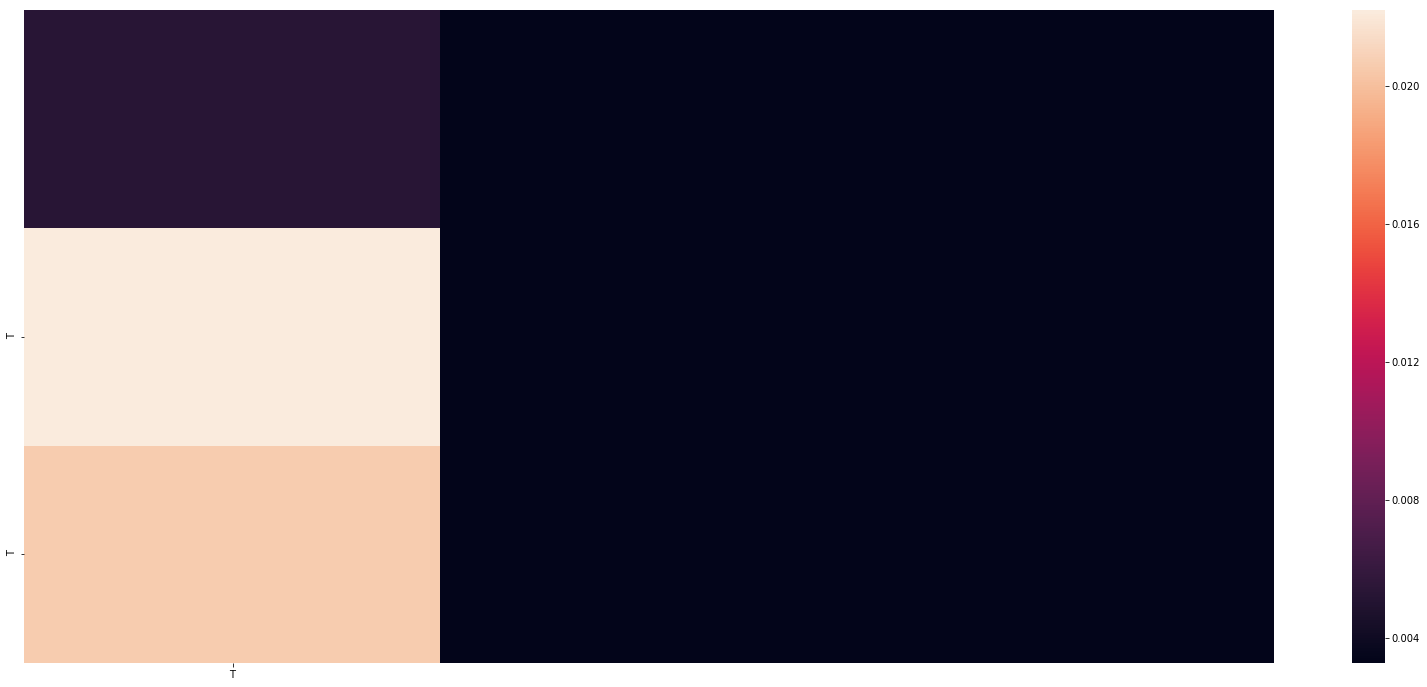

-
Input sentence: T
GT sentence: OT
Decoded sentence: TT


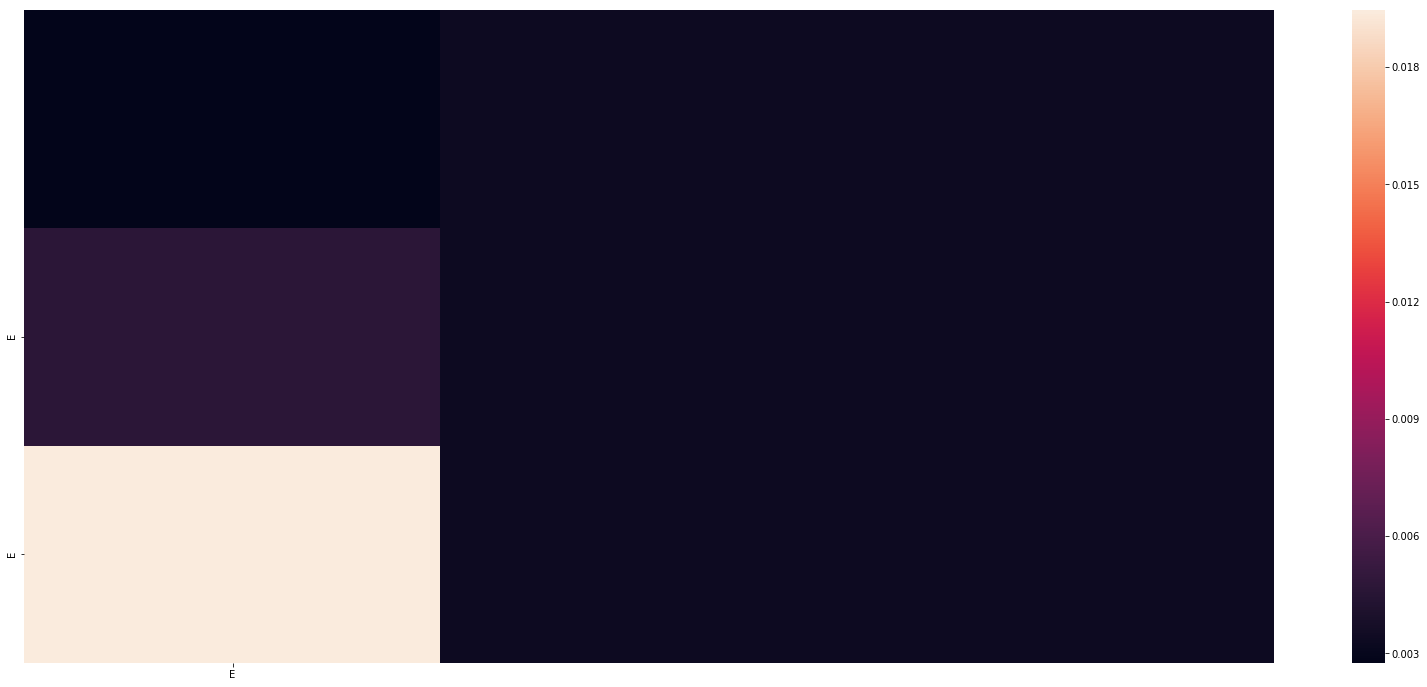

-
Input sentence: E
GT sentence: REM
Decoded sentence: EE


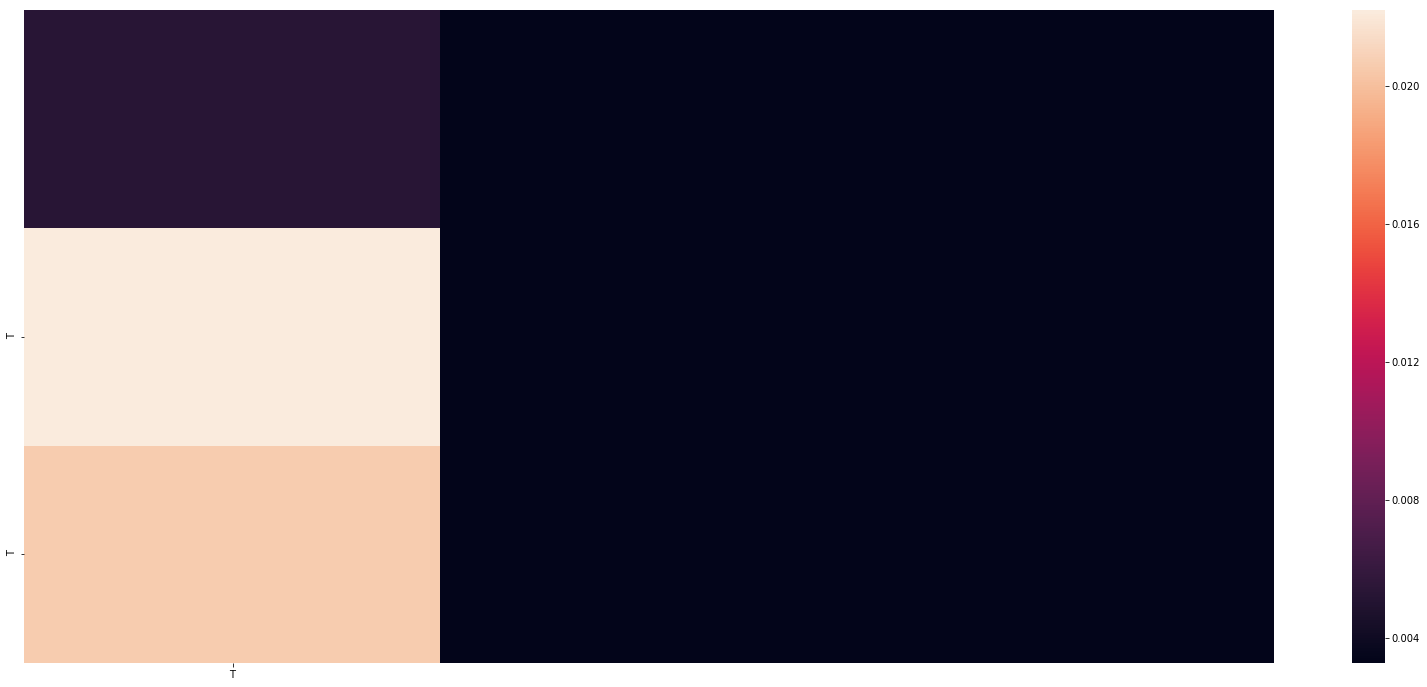

-
Input sentence: T
GT sentence: Tx
Decoded sentence: TT


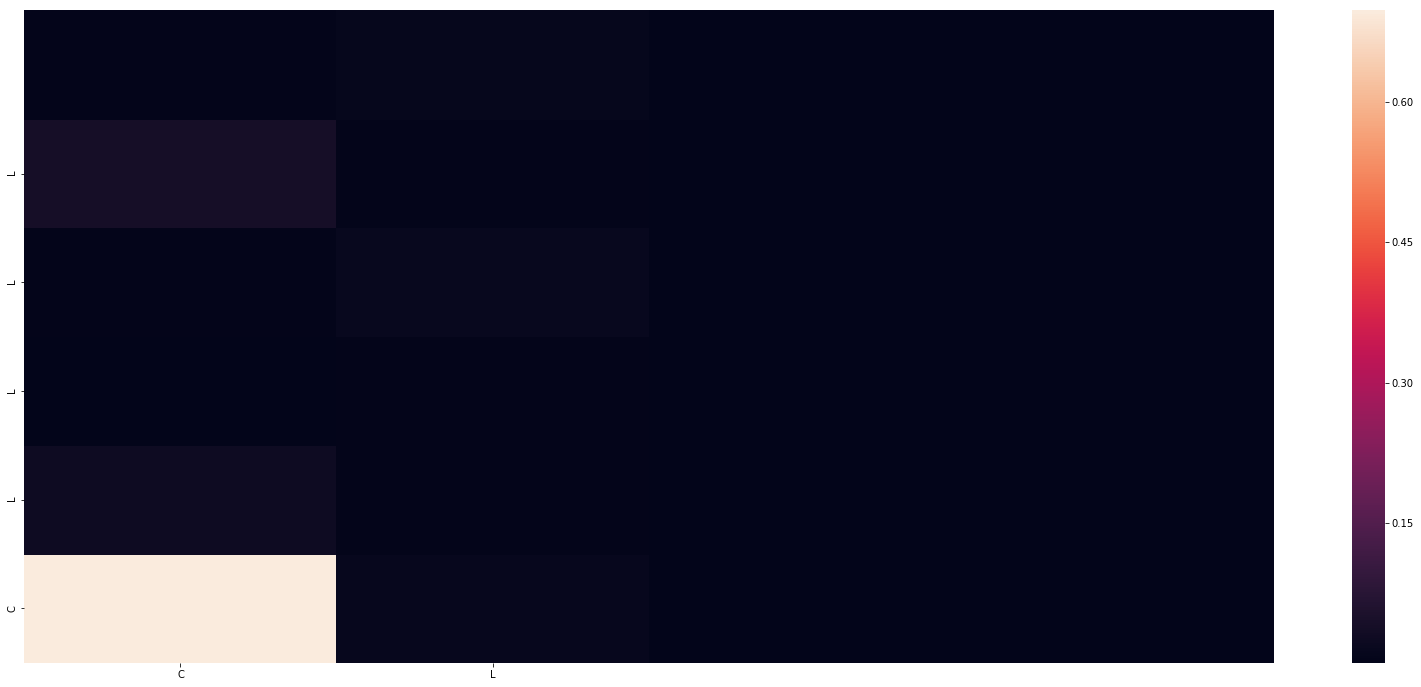

-
Input sentence: CL
GT sentence: CLL
Decoded sentence: CLLLL


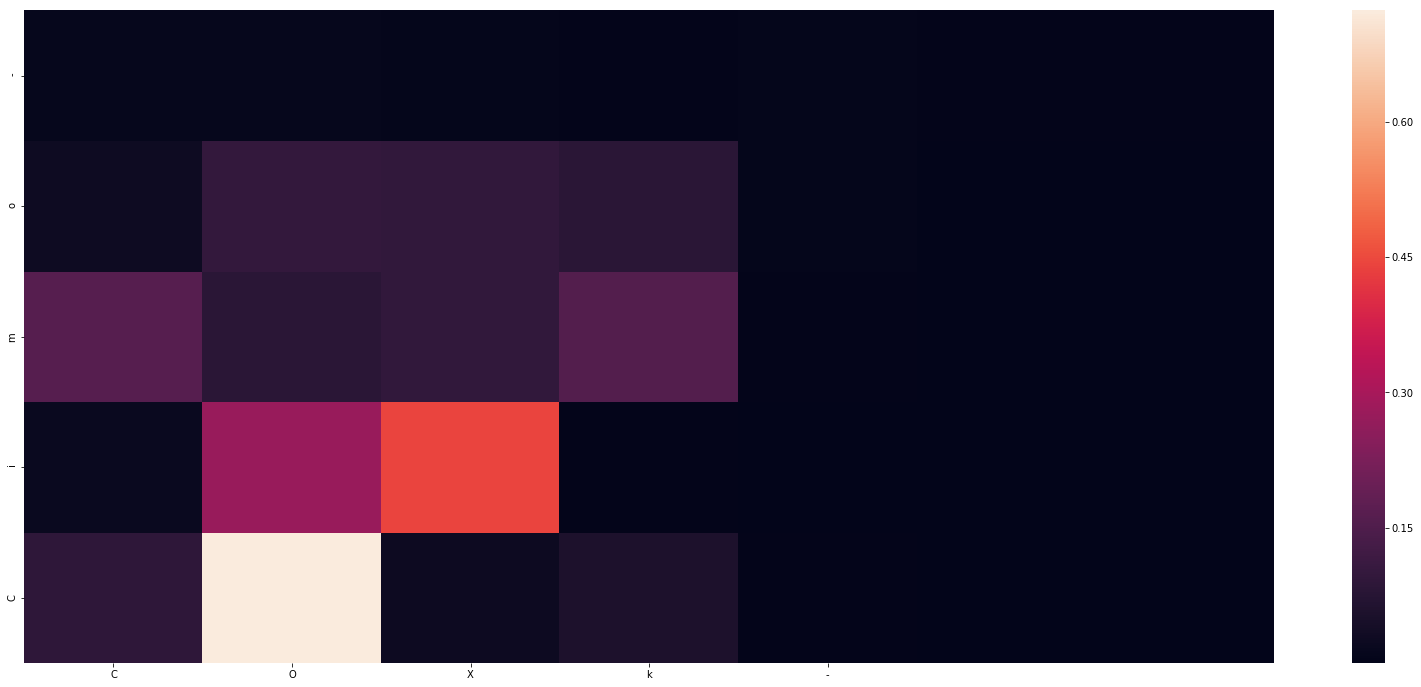

-
Input sentence: COXk-
GT sentence: COX-2
Decoded sentence: Cimo-


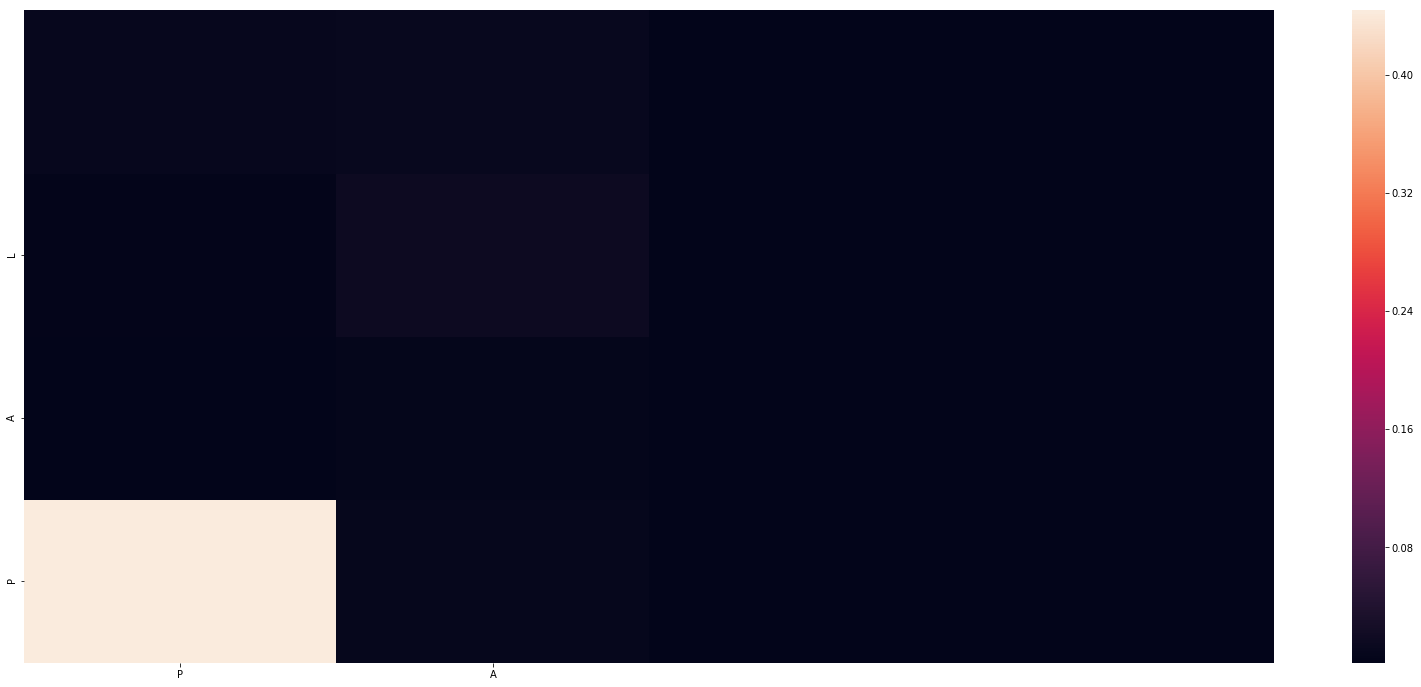

-
Input sentence: PA
GT sentence: PAD
Decoded sentence: PAL


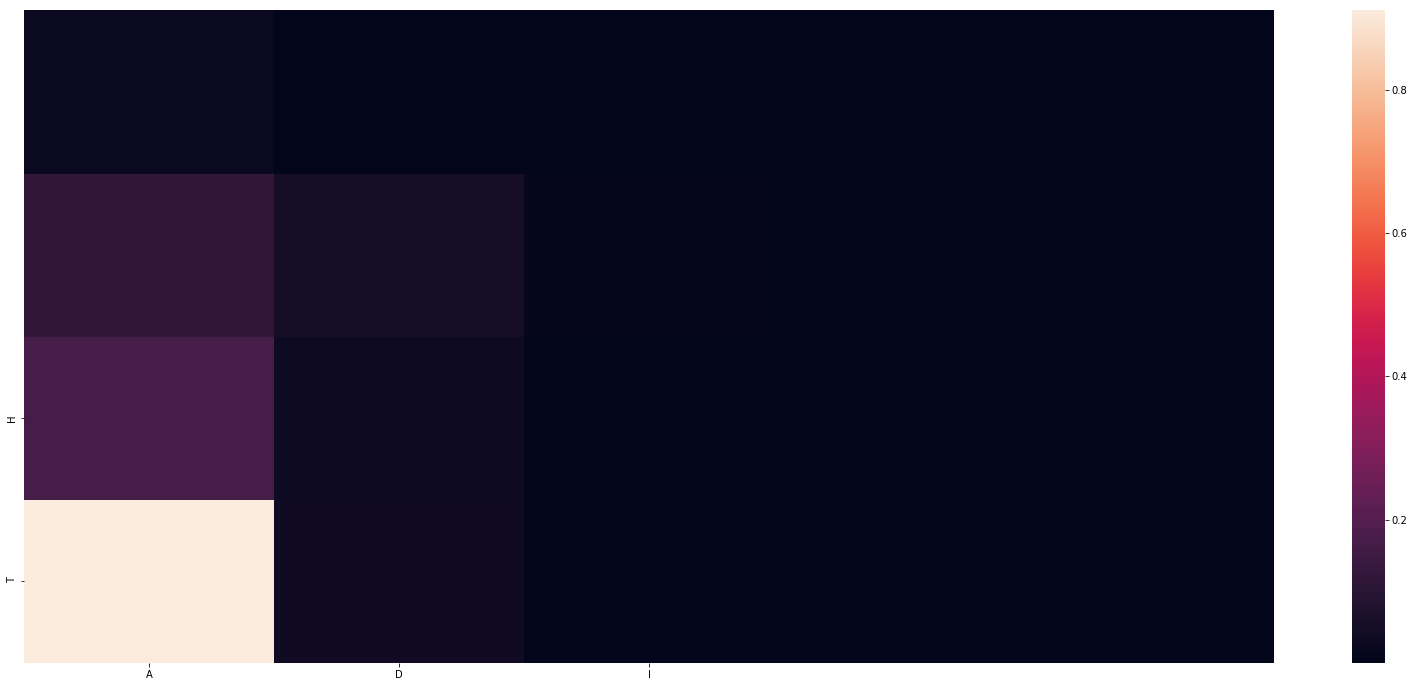

-
Input sentence: ADI
GT sentence: AIDS
Decoded sentence: TH


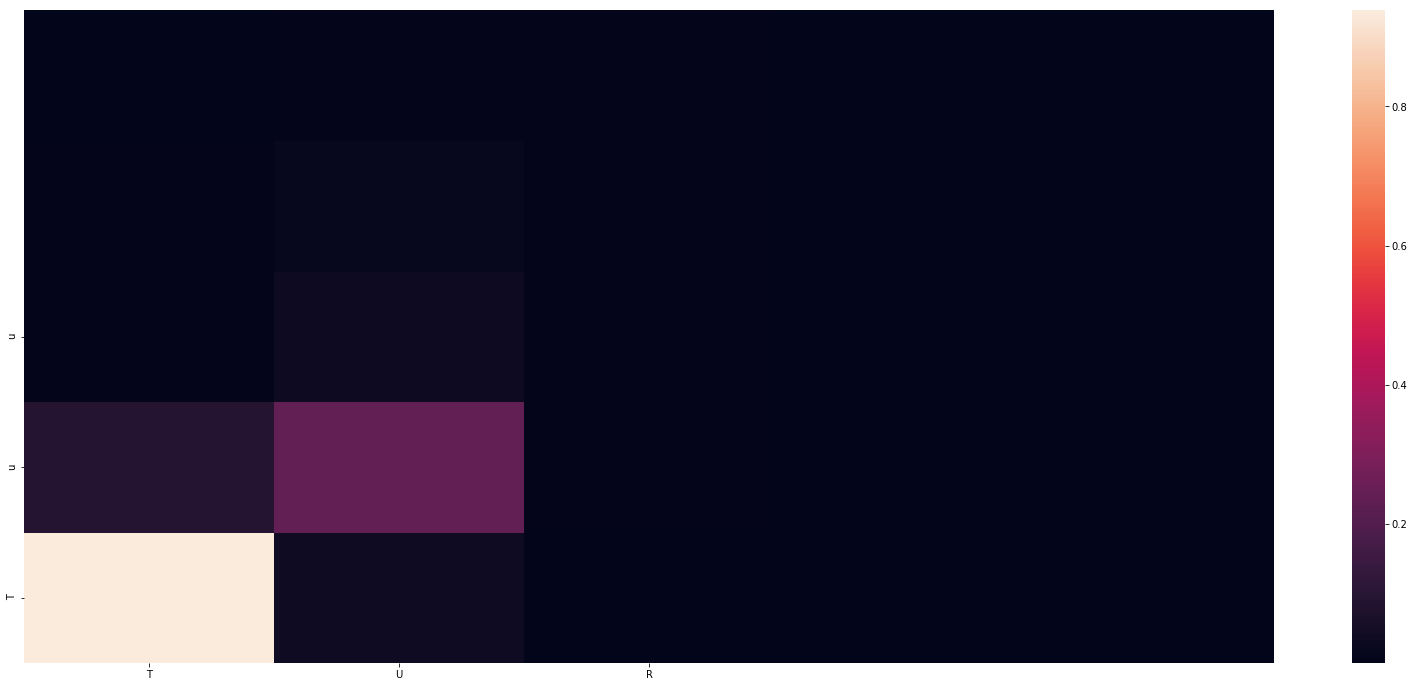

-
Input sentence: TUR
GT sentence: TURP
Decoded sentence: Tuu


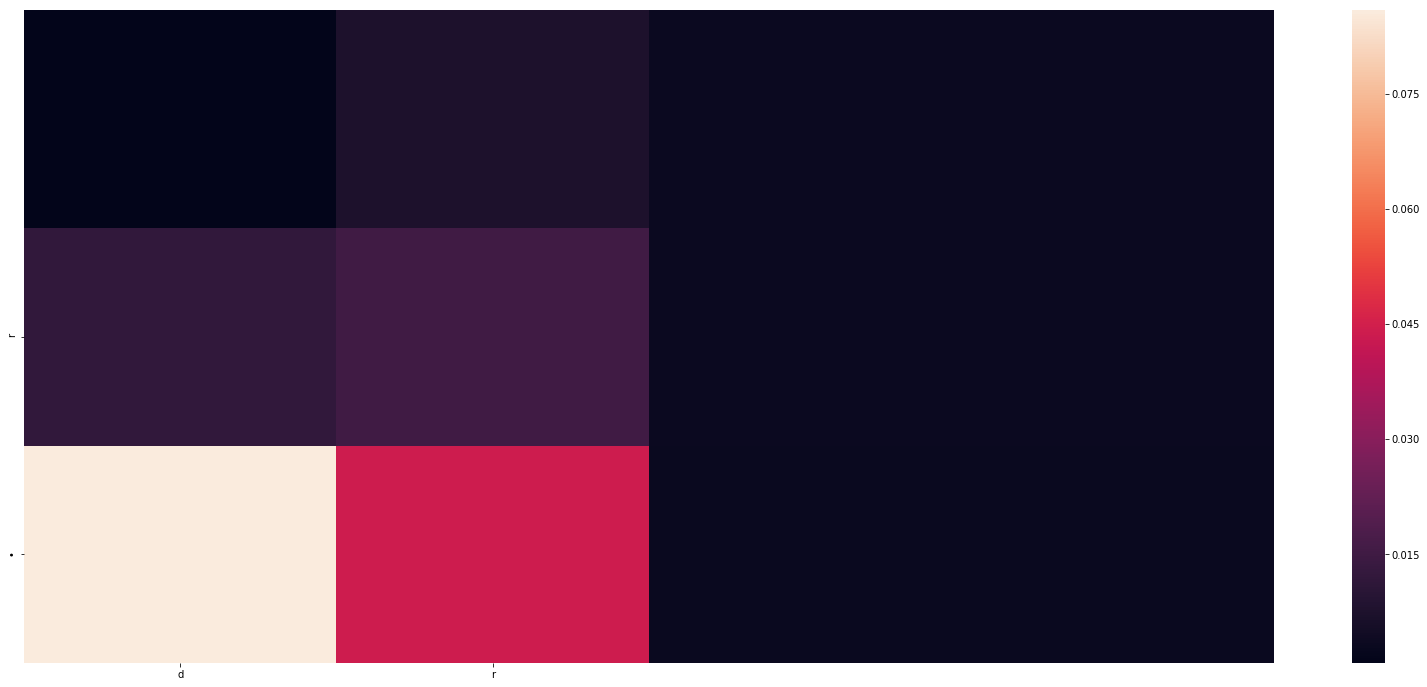

-
Input sentence: dr
GT sentence: dr.
Decoded sentence: •r


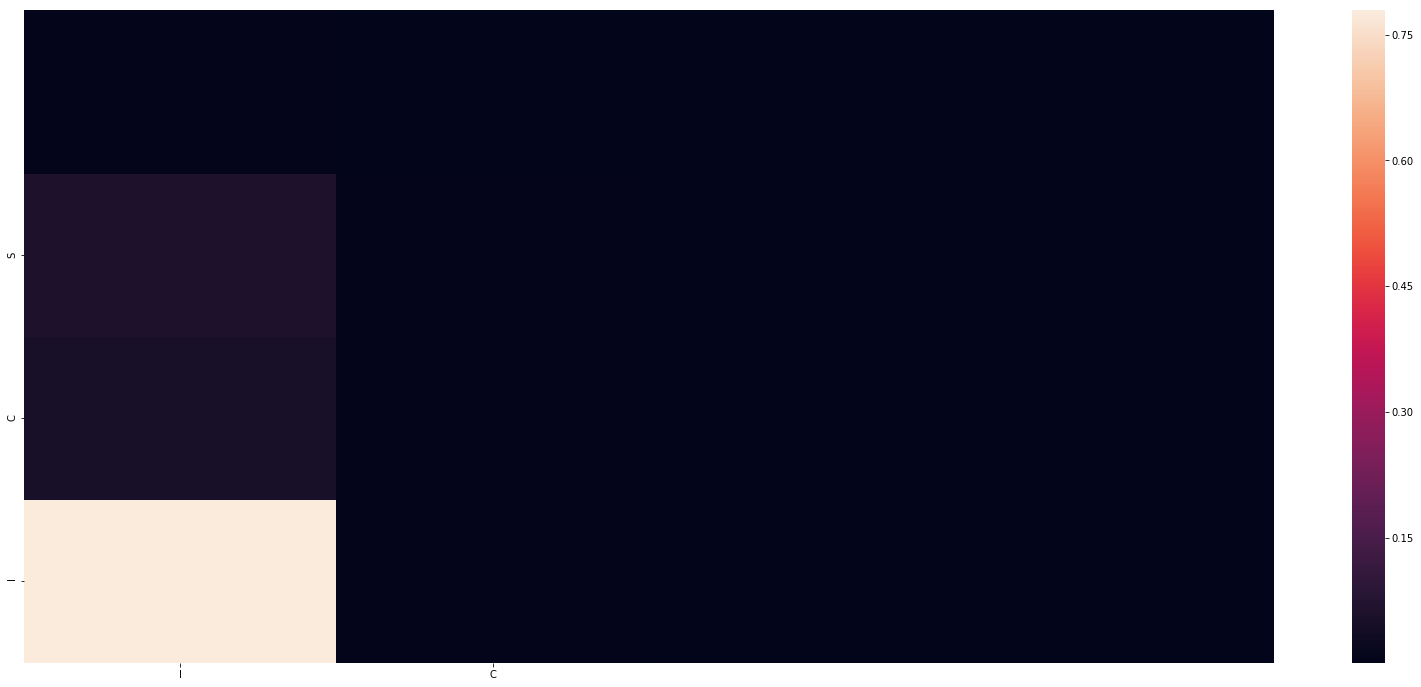

-
Input sentence: IC
GT sentence: ICS
Decoded sentence: ICS


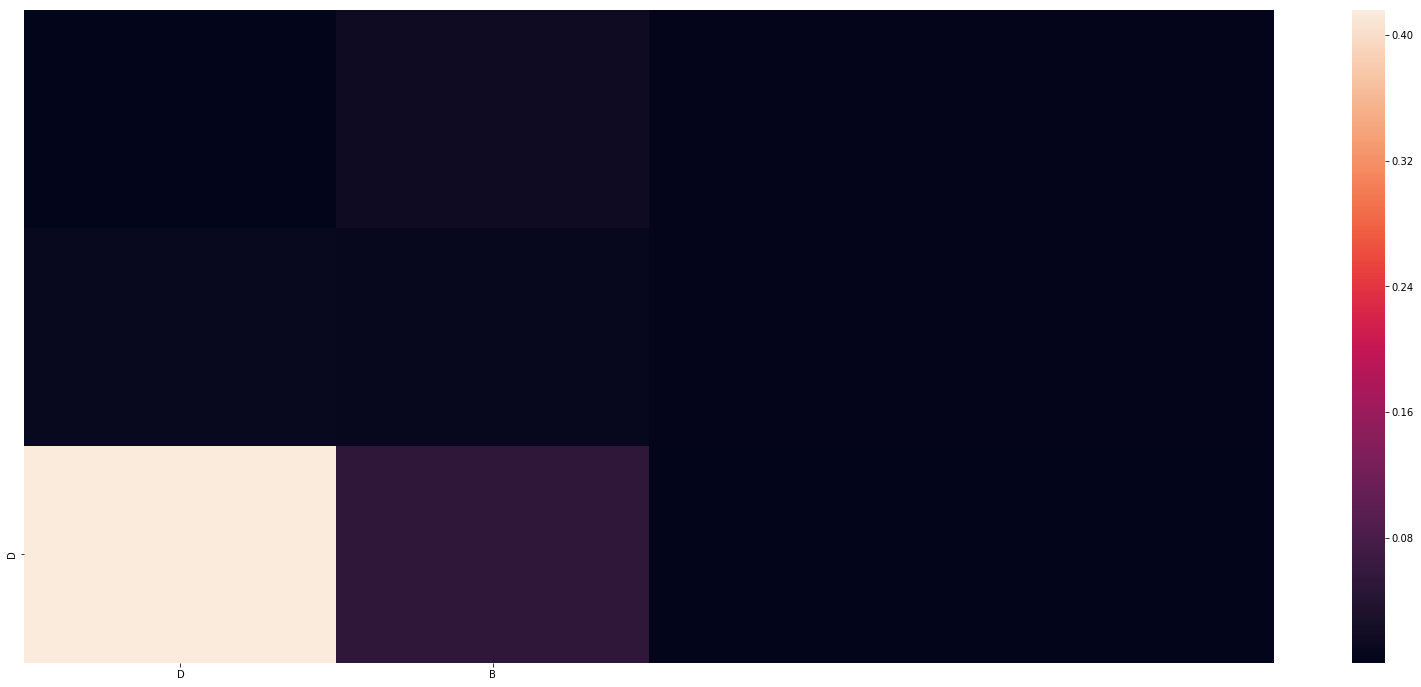

-
Input sentence: DB
GT sentence: DBP
Decoded sentence: D


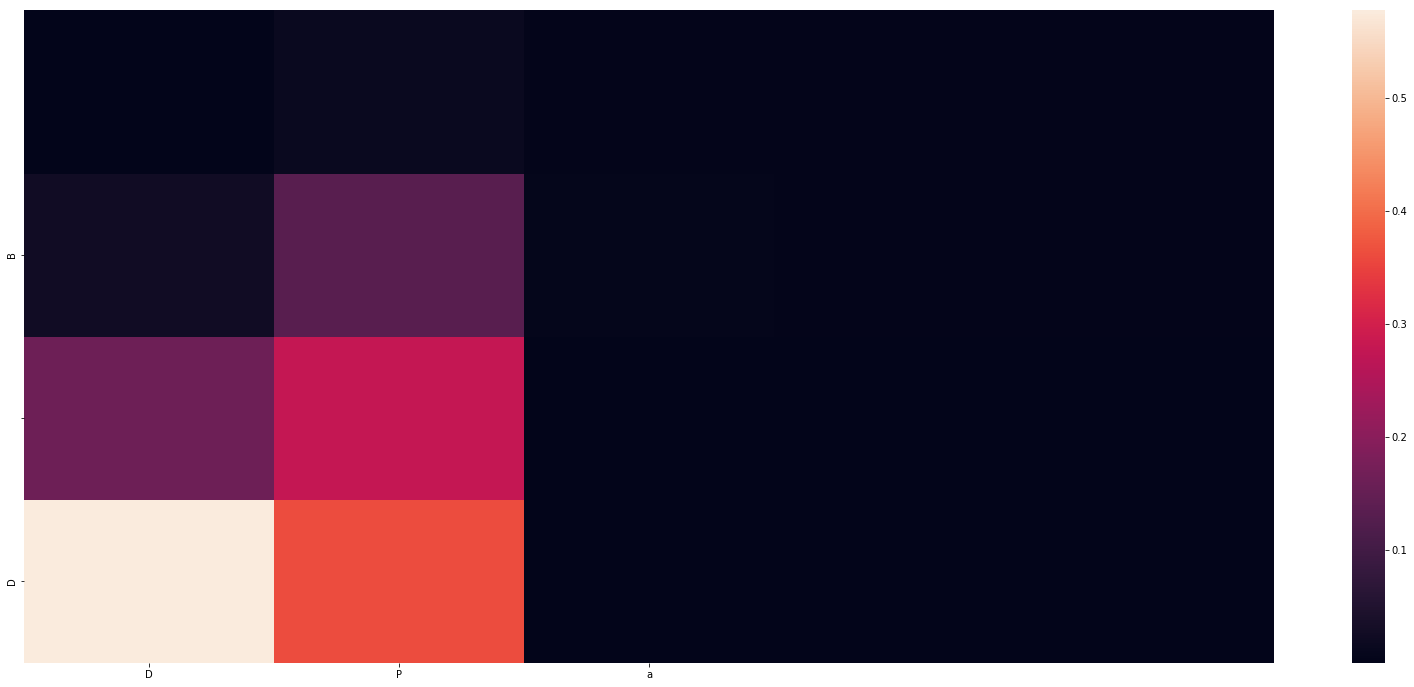

-
Input sentence: DPa
GT sentence: DPat
Decoded sentence: D B


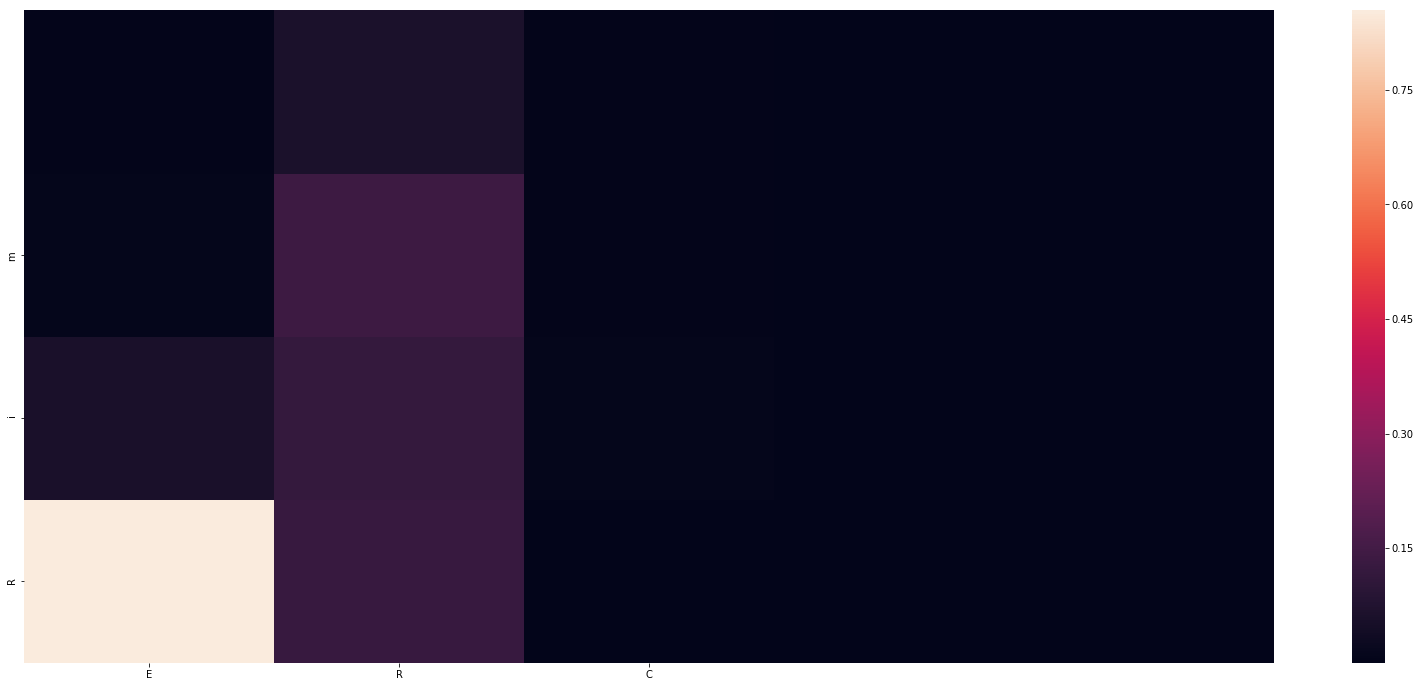

-
Input sentence: ERC
GT sentence: ERCP
Decoded sentence: Rim


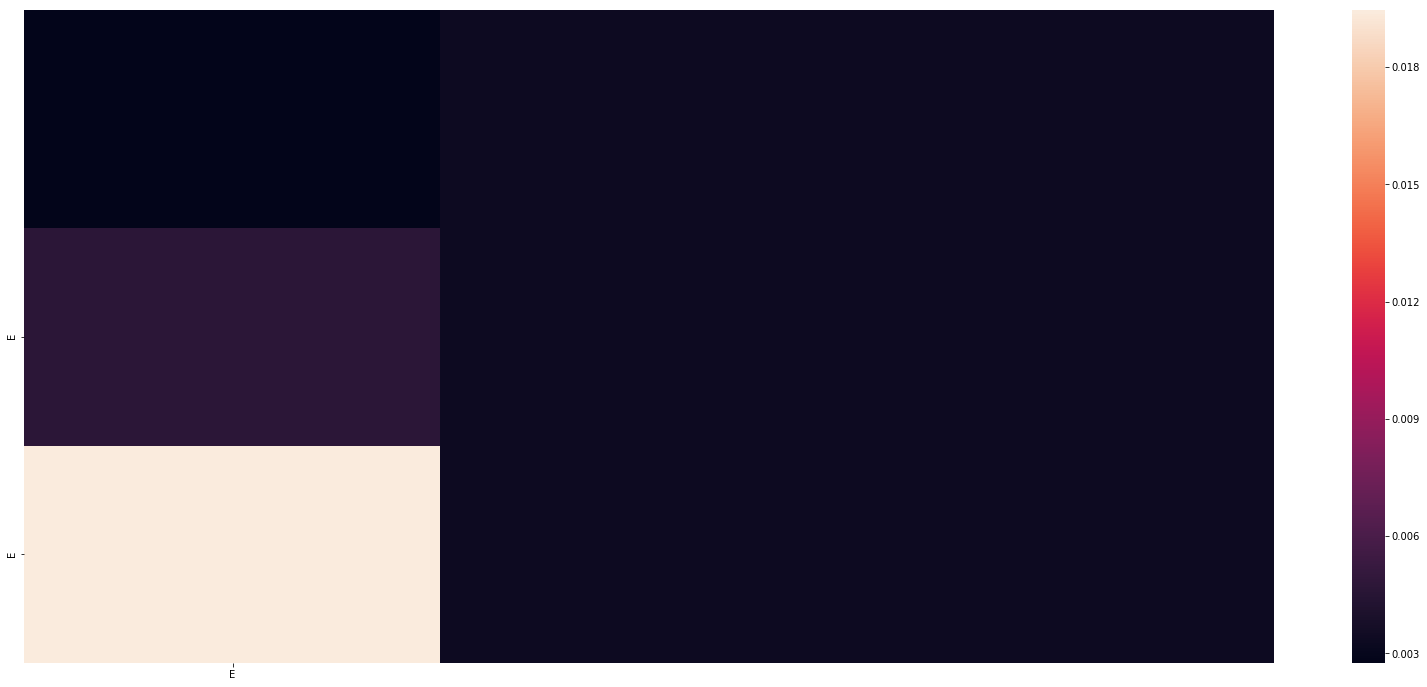

-
Input sentence: E
GT sentence: Em
Decoded sentence: EE


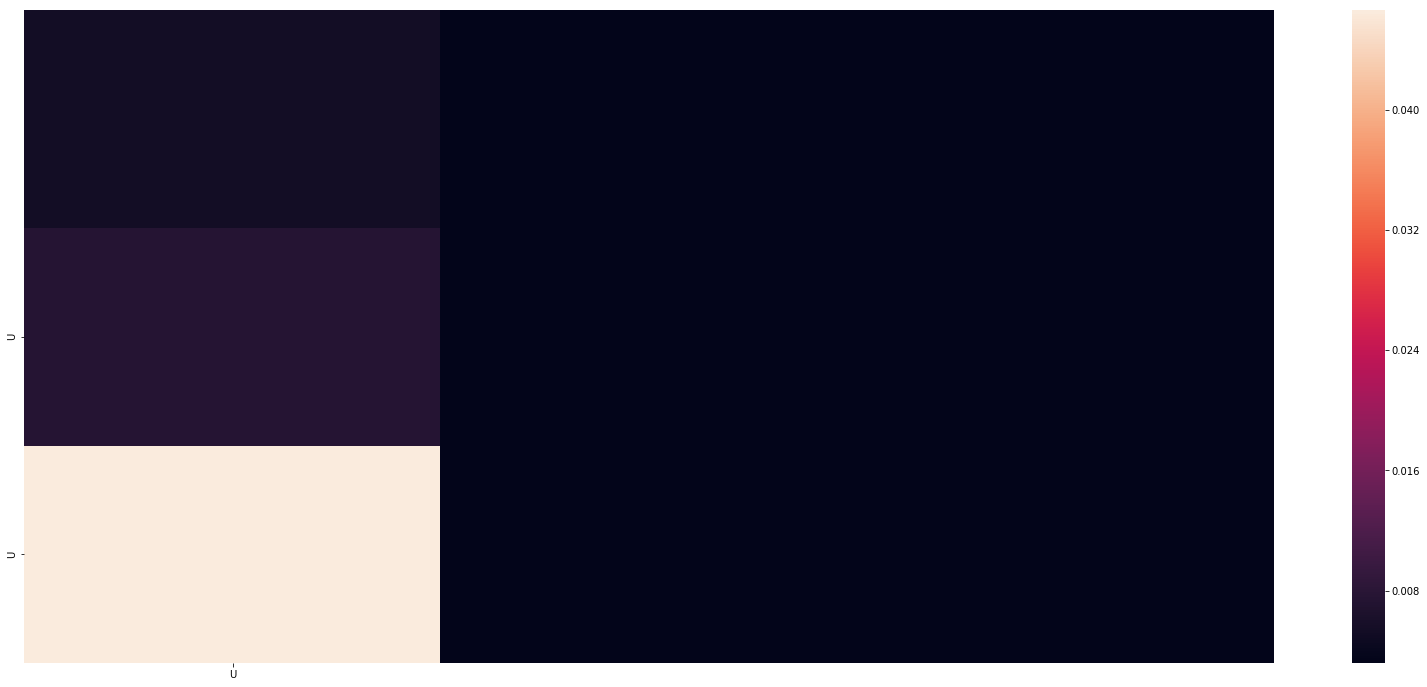

-
Input sentence: U
GT sentence: US
Decoded sentence: UU


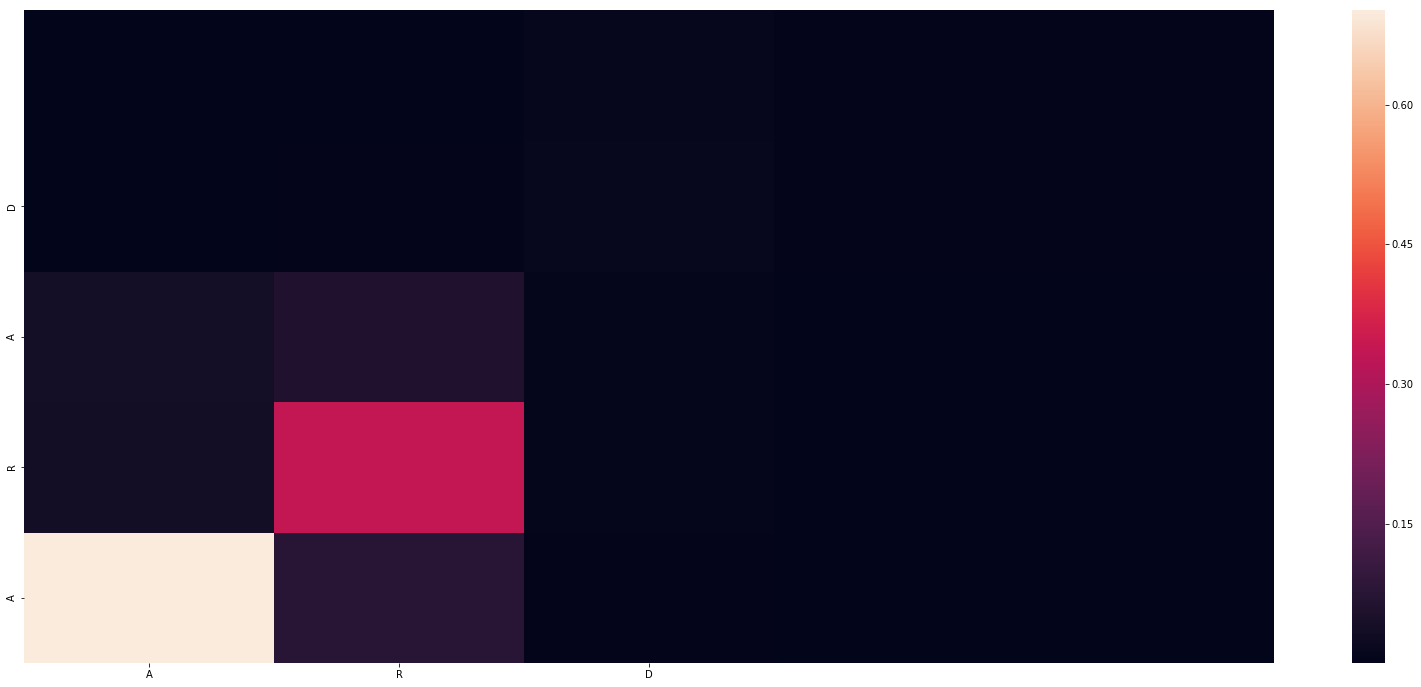

-
Input sentence: ARD
GT sentence: ARDS
Decoded sentence: ARAD


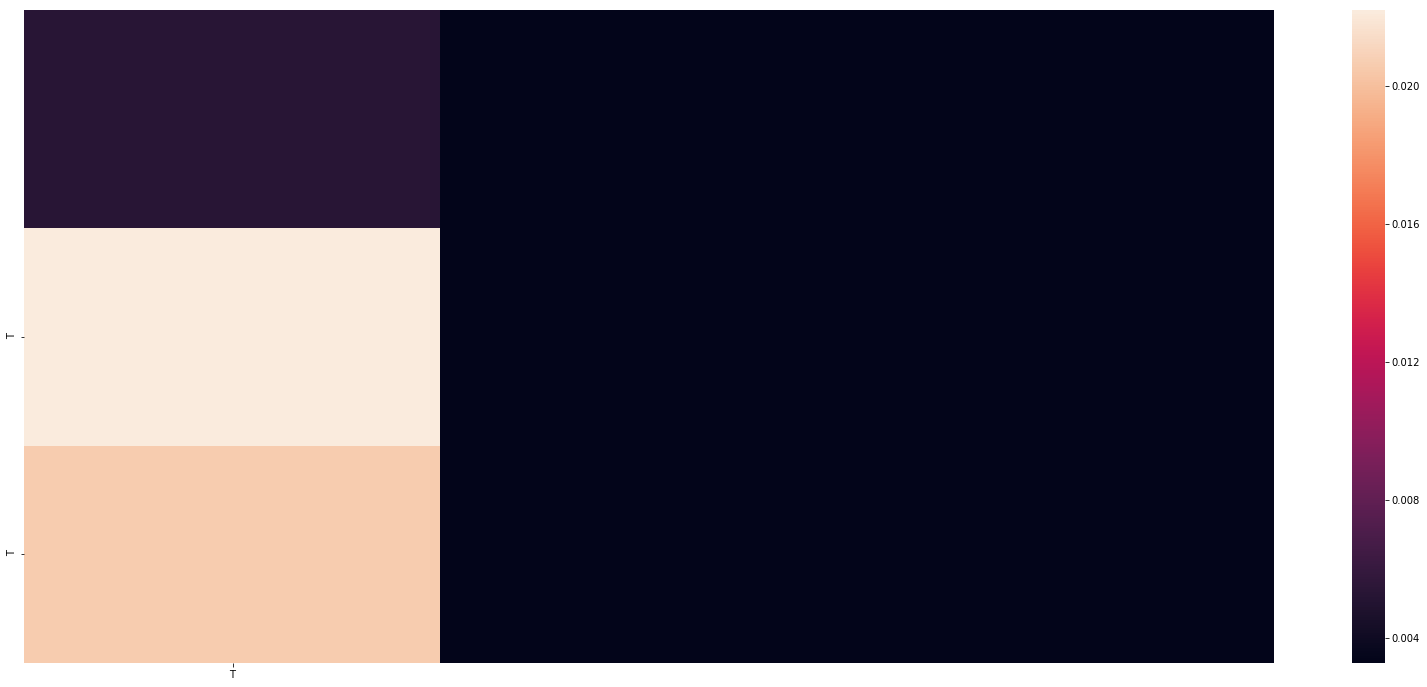

-
Input sentence: T
GT sentence: T6
Decoded sentence: TT


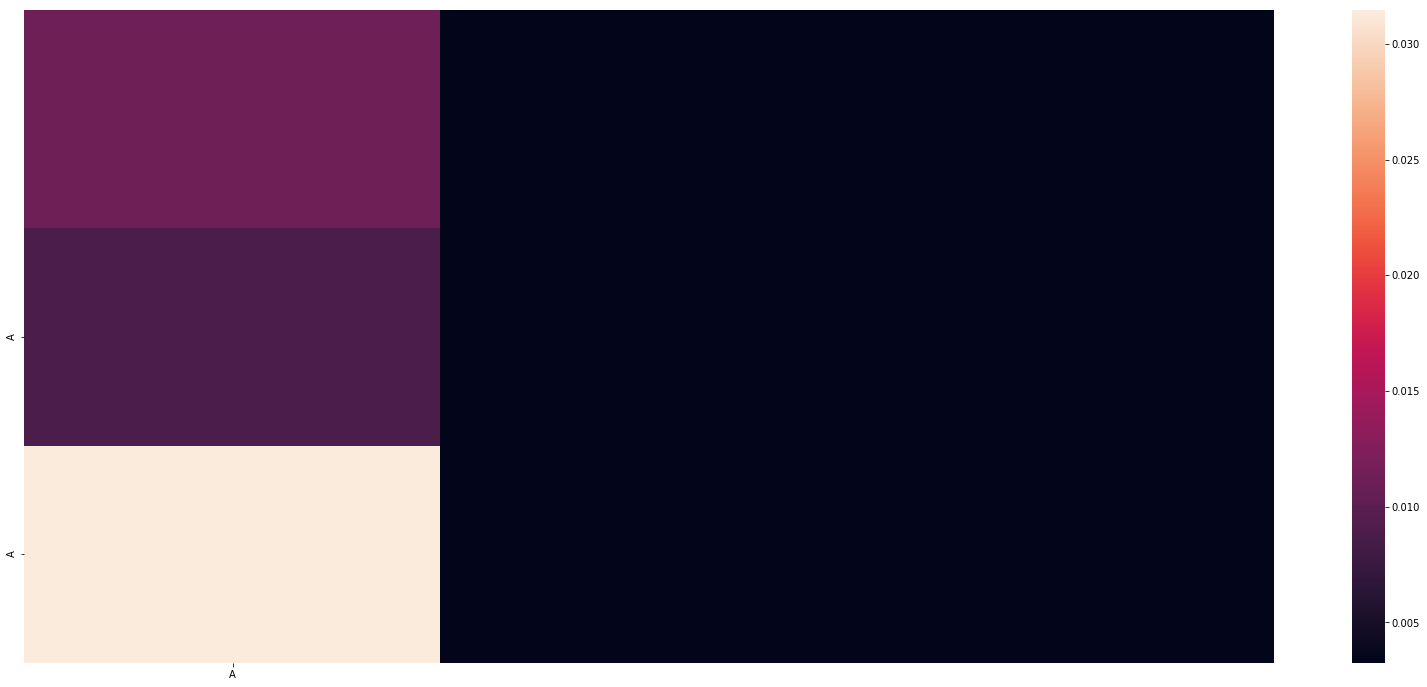

-
Input sentence: A
GT sentence: MAT
Decoded sentence: AA


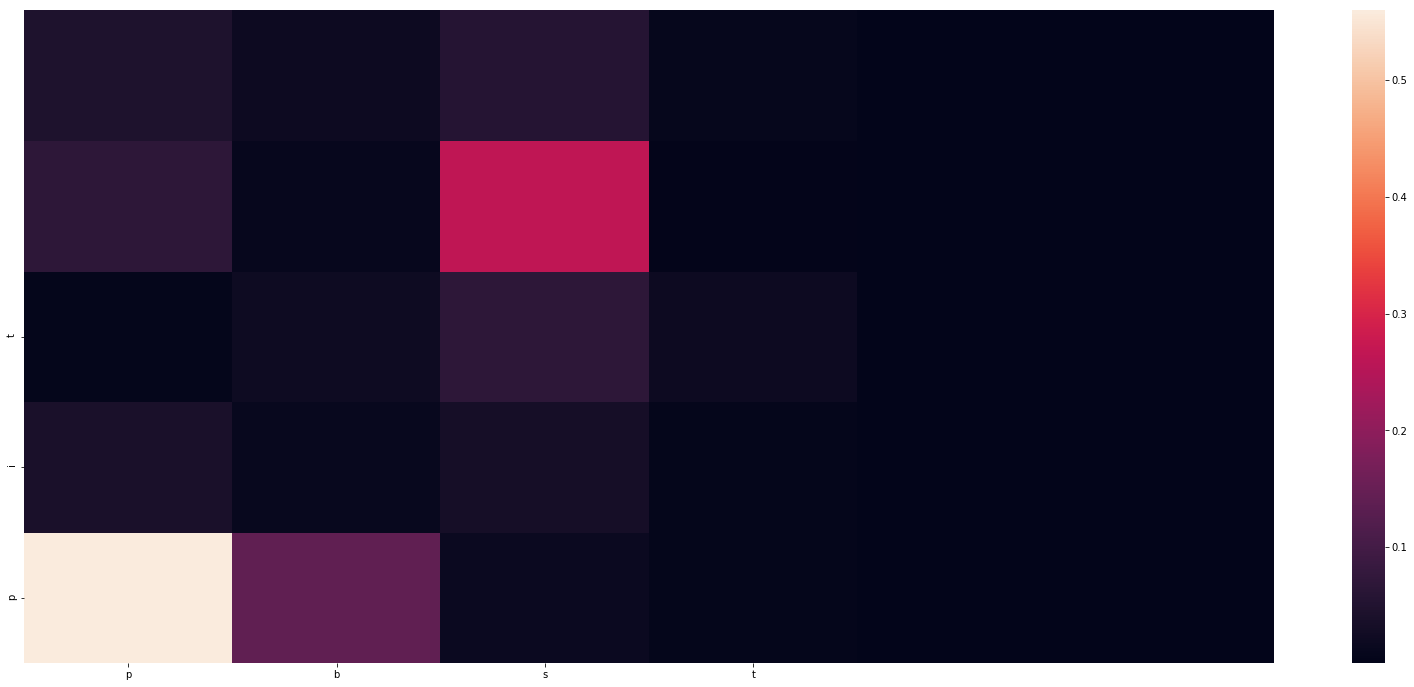

-
Input sentence: pbst
GT sentence: post.
Decoded sentence: pit


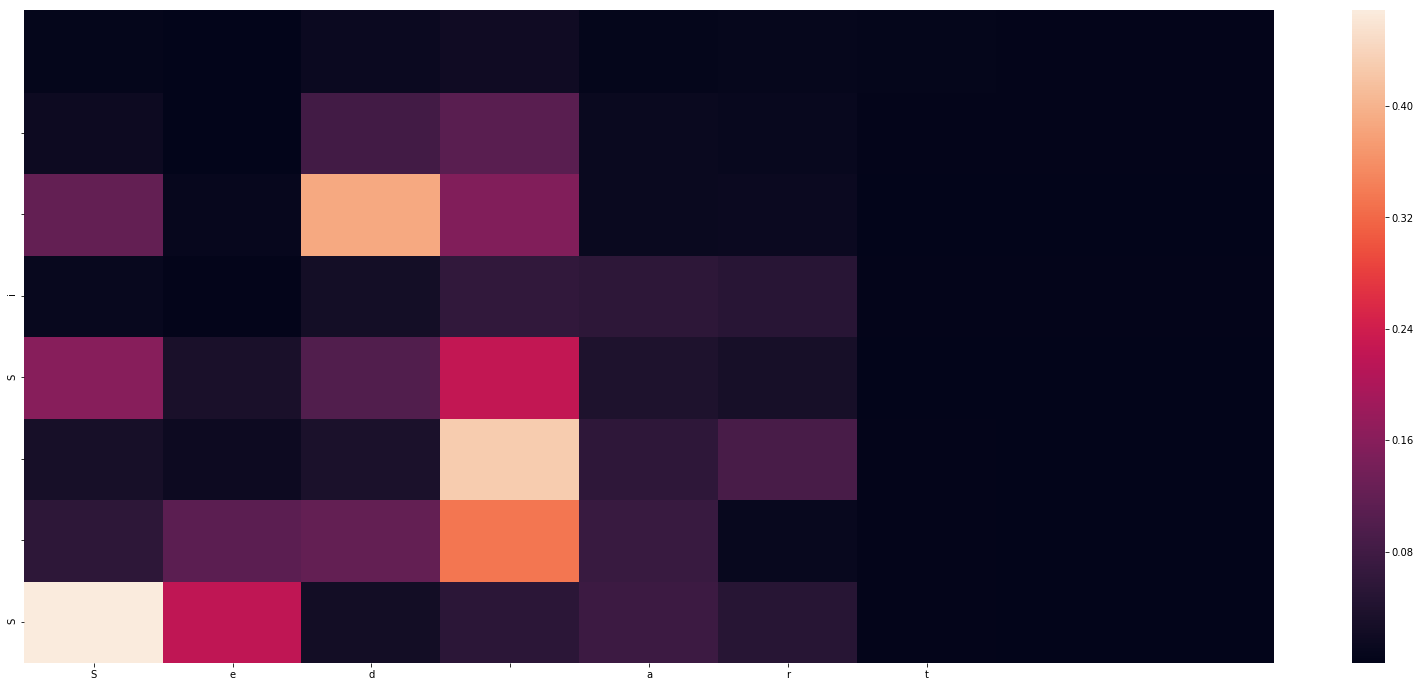

-
Input sentence: Sed art
GT sentence: Sed rate
Decoded sentence: S  Si  


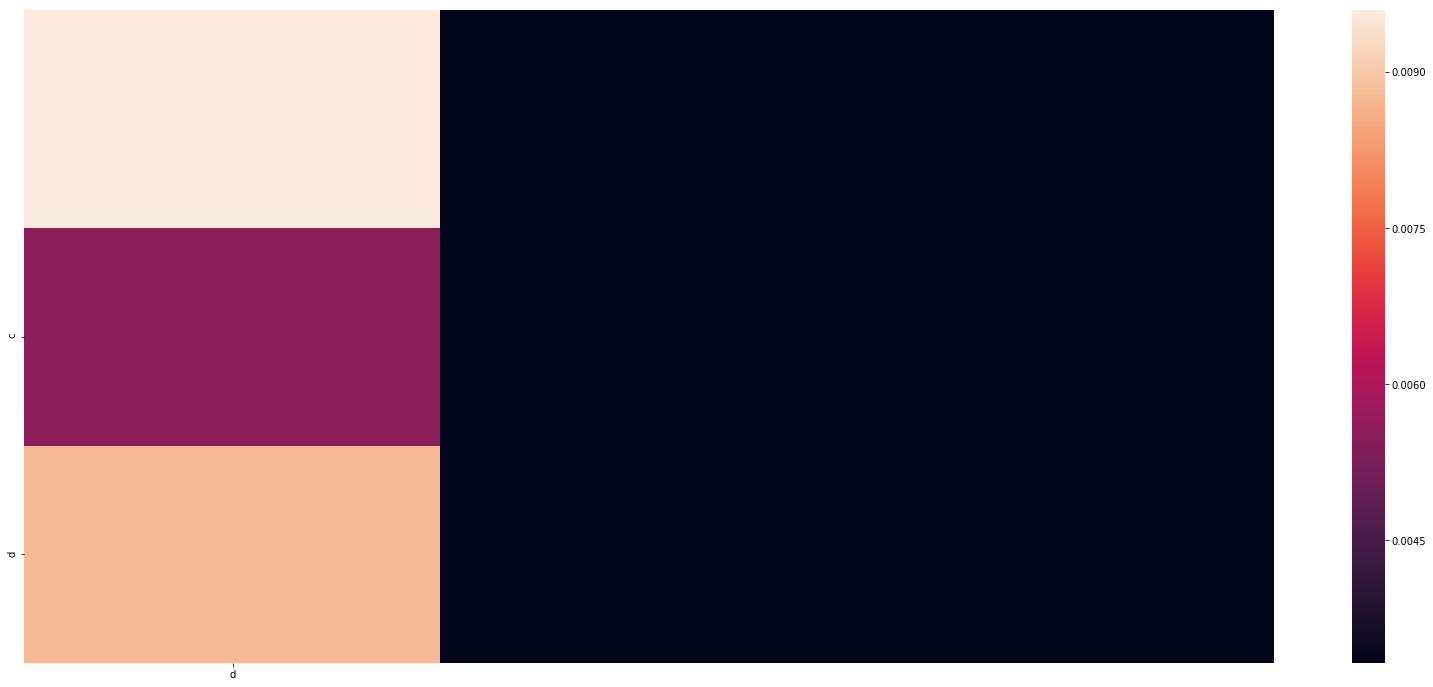

-
Input sentence: d
GT sentence: dB
Decoded sentence: dc


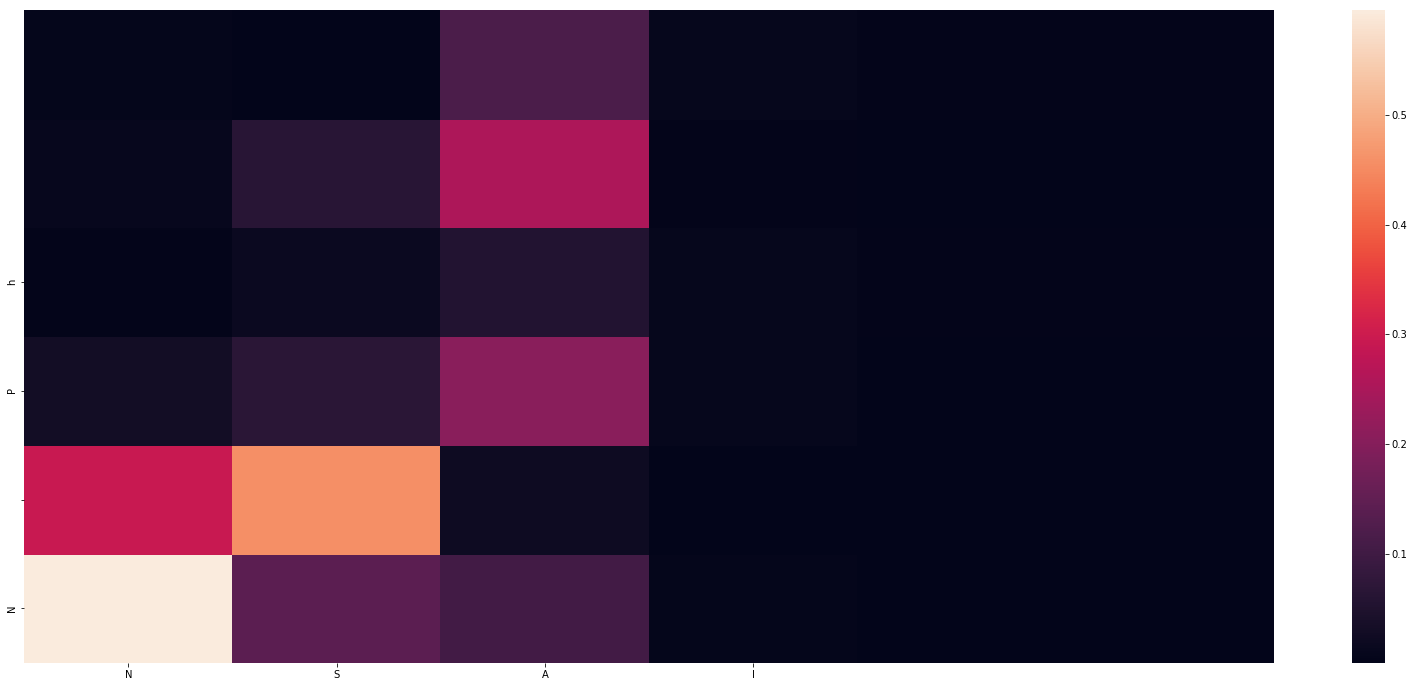

-
Input sentence: NSAI
GT sentence: NSAID
Decoded sentence: N Ph


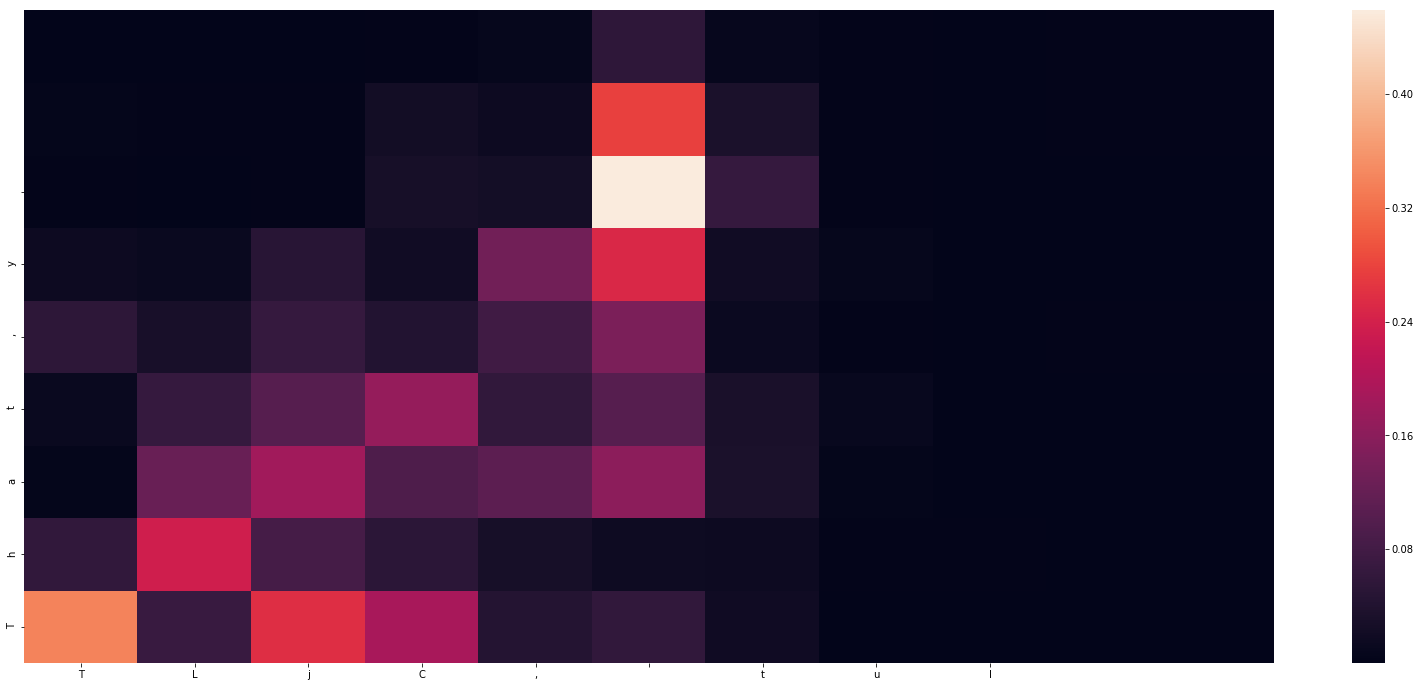

-
Input sentence: TLjC, tul
GT sentence: TLC, tlc
Decoded sentence: That,y 


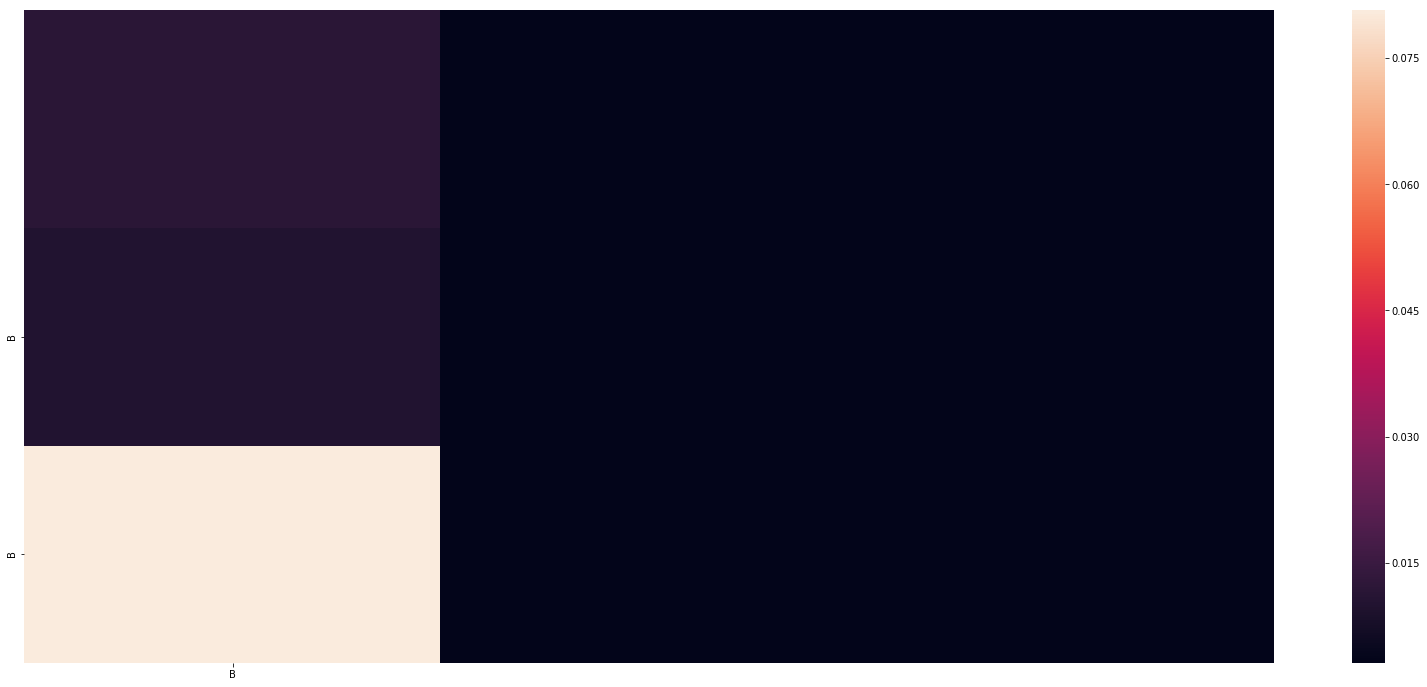

-
Input sentence: B
GT sentence: Bi
Decoded sentence: BB


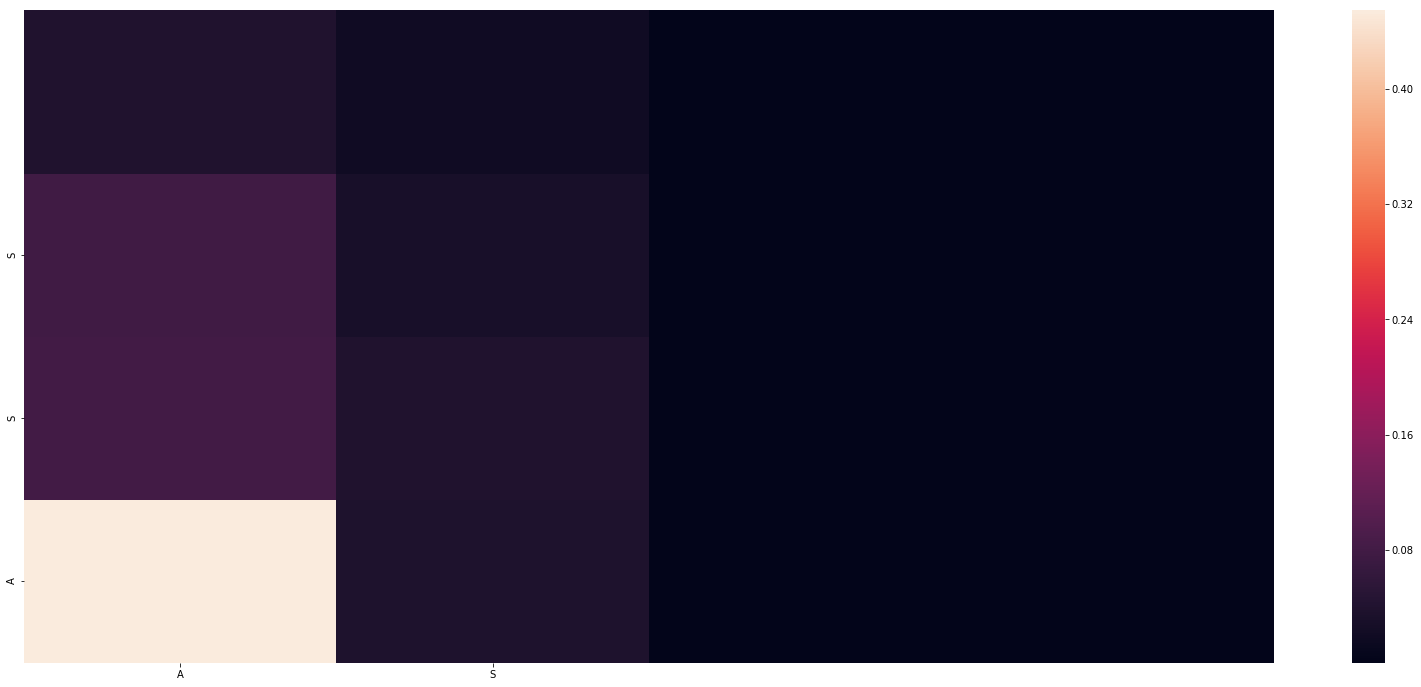

-
Input sentence: AS
GT sentence: ASC
Decoded sentence: ASS


In [70]:
for seq_index in range(100):

    target_text = target_texts[seq_index][1:-1]
    text = input_texts[seq_index]
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   


In [71]:
#WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
#print('WER_spell_correction |TRAIN= ', WER_spell_correction)

In [72]:
# Sample output from test data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: bNO ALUE aFOUND
GT sentence: "NO VALUE FOUND"
Decoded sentence: SRI N N L FEF D
-
Input sentence: • MCV - 87.2 Racnge: 77-95 - fL
GT sentence: • MCV - 87.2 Range: 77-95 - fL

Decoded sentence: •all a- 87.2l    L : 77-95 - L
-
Input sentence: DischargeD ate: Type ofd Surgeury: Select...
GT sentence: Discharge Date: Type of Surgery: Select...

Decoded sentence: I J N Nhy B B: The  Nont J H Nor: H F No...
-
Input sentence: Charg
GT sentence: Charge

Decoded sentence: Chr y 
-
Input sentence: Employee‘lc CI w/Cancer Conditions
GT sentence: Employee*  CI w/Cancer Conditions

Decoded sentence: EmployNEasUNNols/NGrENE ERGyCoy
-
Input sentence: Medical Provider Information , Physician
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medio M M Be B M Me M  Ro M  ,E   o M Y
-
Input sentence: AzddraessLine1
GT sentence: Address Line 1:

Decoded sentence: Lid BERe Ly S1s
-
Input sentence: Clinic hpon #
GT sentence: Clinic phone #

Decoded sentence: CoryFy 

-
Input sentence: "?
GT sentence: "? "
Decoded sentence: "?
-
Input sentence: 4‘ Patient Naniz‘
GT sentence: Patient Name:

Decoded sentence: 4uthENTatNT NE N
-
Input sentence: Novw Du
GT sentence: Now Due

Decoded sentence: ad FN
-
Input sentence: Diagnsois Descrpition 
GT sentence: Diagnosis Description 

Decoded sentence: Dasel Nanent N Mes L 
-
Input sentence: Frist Cohice Healht
GT sentence: First Choice Health

Decoded sentence: Datylontiontinili
-
Input sentence: in
GT sentence: inj.
Decoded sentence: Inn
-
Input sentence: n.b
GT sentence: n.b.
Decoded sentence: M.
-
Input sentence: "769"
GT sentence: "769C"
Decoded sentence: "769"
-
Input sentence: sPatient MN
GT sentence: Patient MRN:

Decoded sentence: Mait N MN
-
Input sentence: Wewbsite: ymFirstChoice.fhn.com
GT sentence: Website: myFirstChoice.fchn.com

Decoded sentence: MROUNF S:Ma M M Sal Men. F.U 
-
Input sentence: Typ:ea ching, numbuness/tingling,burnign
GT sentence: Type: aching, numbness/tingling,burning

Decoded sen

-
Input sentence: Dmate fo Bnirth m(fm/fdd/yy)
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Mertedeict ont M(t/Sic/oy)
-
Input sentence: Social Secun'ty Number:
GT sentence: Social Security Number:

Decoded sentence: EmplInt Name NambH:
-
Input sentence: ___Yos No. If yon. dam of ntlmlaalon:
GT sentence: Yes No. If yes, dates of admission:

Decoded sentence: • Jr r  B.N   B N. B Be i N  n   N N:
-
Input sentence: BA
GT sentence: BAC
Decoded sentence: BAA
-
Input sentence: Importanty Information about You Appeeal Rights
GT sentence: Important Information about Your Appeal Rights

Decoded sentence: IHERNIN Me Me B  B Ne Re Dh Me Desr P NE Es se N 
-
Input sentence: Z878z9 ?n
GT sentence: Z87891 ?

Decoded sentence: Z8789N 
-
Input sentence: Physical Exam
GT sentence: Physical Exam

Decoded sentence: Ofacchalhossy
-
Input sentence: Collected:
GT sentence: Collected:

Decoded sentence: Cimytilio:
-
Input sentence: CL-1116 (11/1)
GT sentence: CL-1116 (11/14)

Decoded sentence: C

-
Input sentence: First Choice Health Network. Inc.
GT sentence: First Choice Health Network, Inc.

Decoded sentence: ThhyINhahashishiathE NENTst.NTer.
-
Input sentence: "Over-exetrion iwnlifting objects
GT sentence: "Over-exertion in lifting objects"
Decoded sentence: "NOUE- N
-
Input sentence: FamilyHistory
GT sentence: Family History

Decoded sentence: Fiail Nal By
-
Input sentence: "0
GT sentence: "01"
Decoded sentence: "0
-
Input sentence: Date of Birth (mm/dd/yy)
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: InoFoy Sohonth(yS/nc/l )
-
Input sentence: Addrress Lgine 1:
GT sentence: Address Line 1:

Decoded sentence: Jrst urent  Res1:
-
Input sentence: Progvider: Zachary S. Jage
GT sentence: Provider: Zachary S. Jager

Decoded sentence: Provid F : Dict FL P.For P
-
Input sentence: VZI
GT sentence: VZIG
Decoded sentence: VVRT
-
Input sentence: 00
GT sentence: 2008
Decoded sentence: 00
-
Input sentence: EDVital Signs aund Pain ntered On:
GT sentence: ED Vital Signs and Pai

-
Input sentence: B
GT sentence: Bx
Decoded sentence: BB
-
Input sentence: oiaimii-
GT sentence: Claim#:

Decoded sentence: Dimnvil-
-
Input sentence: prat. vir
GT sentence: part. vic
Decoded sentence: ORat.N  O
-
Input sentence: "Employece was operatibng a lift truck in shipping area awhen EE tsruck a set o fixed rogllr. Employeereported lower bac pain and was secortd to local emergenyc room for obseration.
GT sentence: "Employee was operating a lift truck in shipping area when EE struck a set of fixed rollers. Employee reported lower back pain and was escorted to local emergency room for observation."
Decoded sentence: "RG Vishinry Nur In U U Fi Nicnry N Nur ri Naing"yy Vis Bhy Nam Inyhy NU N sir hry N  NUNT N  Bi"  Ri N  IiNs  IUNCir   IUNumbingh NU Nur  N NU N" NurNE UNU NU N
-
Input sentence: "Heieblerg Cement AG
GT sentence: "Heidelberg Cement AG"
Decoded sentence: "NO Davavaaa Dat NE
-
Input sentence: aPtinet
GT sentence: Patient

Decoded sentence: Dathe 
-
Input sentence: SATE:

-
Input sentence: Electroncially iSgned Indicator:  Yes
GT sentence: Electronically Signed Indicator:  Yes

Decoded sentence: CERGr Rork RER HYRel REr Ierk :ols
-
Input sentence: Page 1
GT sentence: Page 1

Decoded sentence: Palo1
-
Input sentence: Datesr  of Servce (nicludin gConfinement) 
GT sentence: Dates  of Service (including Confinement) 

Decoded sentence: • Me NONO N Mes Be( Bere Ve OUNBe MUNe F)s
-
Input sentence: City:k
GT sentence: City:

Decoded sentence: Cot:#
-
Input sentence: Product:j Shorrtc Term Daiability
GT sentence: Product: Short Term Disability

Decoded sentence: PrFO S:M Co M  M  M Conti F P
-
Input sentence: "Not Reported
GT sentence: "Not Reported"
Decoded sentence: "Nor
-
Input sentence: Campus/Location:
GT sentence: Campus/Location:

Decoded sentence: Chicc /ont E  :
-
Input sentence: SA
GT sentence: SAD
Decoded sentence: SAS
-
Input sentence: TERWamny nmctmle __""'"‘"‘”"“ 1,500.00 95500"
GT sentence: TIER 1 Family Deductible

Decoded sentence: •RHll B  ll 

-
Input sentence: Proecdure Descrpitiooqn
GT sentence: Procedure Description

Decoded sentence: Prer Bingh B P P P P P
-
Input sentence: PARAMOUNT PAI

GT sentence: PARAMOUNT PAID

Decoded sentence: PATUENENTe
-
Input sentence: Provider First Name: Ryan
GT sentence: Provider First Name: Ryan

Decoded sentence: Pry OON F M M  O No:m F 
-
Input sentence: Trace number:
GT sentence: Trace number:

Decoded sentence: Trigrigresir:
-
Input sentence: MRN #:
GT sentence: MRN #:

Decoded sentence: MMDE:
-
Input sentence: Diagnosis Code:i kknee bnjury
GT sentence: Diagnosis Code: knee injury

Decoded sentence: UChy Bhyhy Jsh: Shhhha Fyy 
-
Input sentence: Paeg1 of 

GT sentence: Page 1 of 1

Decoded sentence: POPN1 P P
-
Input sentence: Exmianiton
GT sentence: Examination

Decoded sentence: Darmiy Da
-
Input sentence: "10
GT sentence: "10"
Decoded sentence: "10
-
Input sentence: "0000
GT sentence: "0000"
Decoded sentence: "0000
-
Input sentence: • Tobacco quit date establishe (Z7.891)
GT sentence

-
Input sentence: Visit Date

GT sentence: Visit Date:

Decoded sentence: VM Co
-
Input sentence: Electronic Submis sion
GT sentence: Electronic Submission

Decoded sentence: EmplEl Sly Dan RE NE #
-
Input sentence: "Emloeye wa cleanfing tras ouqt o fecba o ahul truck he he fnelt something scik his fingenr. The next morning his fiinger was swollen up. Sent him to emegrecy rood to have it checked out.
GT sentence: "Employee was cleaning trash out of cab of haul truck when he felt something stick his finger. The next morning his finger was swollen up. Sent him to emergency room to have it checked out."
Decoded sentence: "ms Nalichichal Vishit NaghhE  Nainght Naing"hy Vhhy Ci Nam  VhichisN  Noralighichishicalingh" NureqIN MalURG Numb NEN  N Nagury CisN  No N"
-
Input sentence: CH
GT sentence: CHD
Decoded sentence: COHT
-
Input sentence: • Oxygne sat % 97 (%)
GT sentence: • Oxygen sat % 97 (%)

Decoded sentence: •rer B B F Bi%F97(%)
-
Input sentence: "NO VALE OFUND
GT sentence: "NO VALUE F

-
Input sentence: 
GT sentence: 
Decoded sentence: 
-
Input sentence: When is your next visit?
GT sentence: When is your next visit?

Decoded sentence: Deved E E ME M F ME ME 
-
Input sentence: Gruop Polsicy #:
GT sentence: Group Policy #:

Decoded sentence: Grlantontion :
-
Input sentence: InpatientOutptaeint Indicatnor: Outpatient
GT sentence: Inpatient/Outpatient Indicator: Outpatient

Decoded sentence: •RRe N te th tht t t to G B Bn:h F F NE 
-
Input sentence: -- McMurrays’
GT sentence: -- McMurray’s

Decoded sentence: --ORE ME D D
-
Input sentence: "?
GT sentence: "?"
Decoded sentence: "?
-
Input sentence: TER 1F amily Deductibl

GT sentence: TIER 1 Family Deductible

Decoded sentence: Thai1r B J LUEFEDENe 
-
Input sentence: Clafim ype: B Accident - Aciental Injury
GT sentence: Claim Type: VB Accident - Accidental Injury

Decoded sentence: Chirr Bhy :hy Nal Bary -ary S Ss IUy RU
-
Input sentence: 2nd Surgery/tProcedure: Datke:
GT sentence: 2nd Surgery/Procedure: Date:

Decoded sen

-
Input sentence: Home Meicaitosn
GT sentence: Home Medications:

Decoded sentence: EmpmEF Pmmmmms
-
Input sentence: Times per week: 5
GT sentence: Times per week: 5

Decoded sentence: ThU NTerk D :
-
Input sentence: City State Zip
GT sentence: City State Zip

Decoded sentence: Emainy Fl b
-
Input sentence: Staus Billed
GT sentence: Status Billed

Decoded sentence: SureNT Se No
-
Input sentence: Lantguage Prqeference

GT sentence: Language Preference:

Decoded sentence: Choval Bathe Nalent N
-
Input sentence: Physiian’s Tax Ie Number:
GT sentence: Physician’s Tax ID Number:

Decoded sentence: Phovin Nanghhenthagures :
-
Input sentence: kID de:
GT sentence: ICD Code:

Decoded sentence: DavD S:
-
Input sentence: 2) * Cleaning Chemicals (moderate)
GT sentence: 2) * Cleaning Chemicals (moderate)

Decoded sentence: 2)HE WENureqENE EREE(E IE Ir)
-
Input sentence: Eastslde Medical Center "a,“
GT sentence: Eastside Medical Center

Decoded sentence: E ENENGaTEathalaliathEy",
-
Input sentence: "

-
Input sentence: Date ofF irst Visi:t
GT sentence: Date of First Visit:

Decoded sentence: Date B B Bo ME DE:
-
Input sentence: Participant Nae:
GT sentence: Participant Name:

Decoded sentence: Paticaiofi DE
-
Input sentence: Address
GT sentence: Address

Decoded sentence: Addddes
-
Input sentence: Gendevr:o
GT sentence: Gender:

Decoded sentence: Reseno:
-
Input sentence: iFne Manipulation
GT sentence: Fine Manipulation

Decoded sentence: PaaialEFEPENEmams
-
Input sentence: MRI Yes No Dae: (mm/dd/yy)
GT sentence: MRI Yes No Date: (mm/dd/yy)

Decoded sentence: MRE In S M Shy:M(My/
-
Input sentence: TIEwR2  Fmaily Deductible
GT sentence: TIER 2 Family Deductible

Decoded sentence: TeH2 NEN  HONEN 
-
Input sentence: Birth Date:
GT sentence: Birth Date:

Decoded sentence: Uthotin:
-
Input sentence: RESP: 18 breaths/min
GT sentence: RESP: 18 breaths/min

Decoded sentence: CRGE:E18So F DEF/E 
-
Input sentence: Summay oOf Today’s Visit
GT sentence: Summary Of Today’s Visit

Decoded sentenc

-
Input sentence: Disxcrage Date: Type ofv Surgery: Select...
GT sentence: Discharge Date: Type of Surgery: Select...

Decoded sentence: I MRying  M B:nthe B Be B Jhe N:M J N M...
-
Input sentence: mpresshiobn  Recommenduato:s
GT sentence: Impression & Recommendations:

Decoded sentence: Huses NONEREpsNENserphes :e
-
Input sentence: Zip Code:
GT sentence: Zip Code:

Decoded sentence: Zr Conn:
-
Input sentence: Dateltime:
GT sentence: Date/time:

Decoded sentence: Datit ND:
-
Input sentence: clar bilaterallly t A & P
GT sentence: clear bilaterally to A & P

Decoded sentence: Daim E MM Dam EiE Vi NEE
-
Input sentence: Expected Devlivery Date: (mm/ddy/y)
GT sentence: Expected Delivery Date: (mm/dd/yy)

Decoded sentence: EmplExNyyry NTEyy :(//y)
-
Input sentence: ELECTRONICALLY SIGNED by — H. Anthony Rose, MD
GT sentence: ELECTRONICALLY SIGNED by - H. Anthony Rose, MD

Decoded sentence: SllIN Nal l Bl  N N  l Cl—is.B S Cil ll NE,NE
-
Input sentence: Date of Birth (mmlddi'yyj
GT sentence: D

-
Input sentence: Hospdita Name: Sun City Emergency Room
GT sentence: Hospital Name: Sun City Emergency Room

Decoded sentence: IHIUNENGhL Ll:lhhal ll Lhh Ll N  NE or
-
Input sentence: meloyer Coverage: :33
GT sentence: Employer Coverage: Yes

Decoded sentence: Deain M matioll :i:33
-
Input sentence: Toacco Use: never smoker
GT sentence: Tobacco Use: never smoker

Decoded sentence: Touar Nag :a Na F Nomby 
-
Input sentence: UATH#
GT sentence: AUTH#

Decoded sentence: R
-
Input sentence: Expecsted Deilvery Date (mm/dd/yy)p:
GT sentence: Expected Delivery Date (mm/dd/yy):

Decoded sentence: EmplEx Jy Dey Dey Dy Dey( D/y/ ):
-
Input sentence: MyHealth360° PHC%  Me
GT sentence: MyHealth360° PHC % Me

Decoded sentence: Ci360%
-
Input sentence: Se etatebmetn Details eonBack
GT sentence: See Statement Details on Back

Decoded sentence: Eer Ne N De M  I Nursser 
-
Input sentence: hElectronicallyS igned b:
GT sentence: Electronically Signed by:

Decoded sentence: EmplElintht inththal Bil:
-
Inp

-
Input sentence: 1st TX Date:
GT sentence: 1st TX Date:

Decoded sentence: 1hTINTe Oon:
-
Input sentence: www.upnum.com
GT sentence: www.unum.com

Decoded sentence: Mev. DEDU.Dy
-
Input sentence: CA
GT sentence: CAP
Decoded sentence: CAAA
-
Input sentence: Lasth'ama Sufiix _ First Heme MI
GT sentence: Last Name Suffix  First Name MI

Decoded sentence: Chohy M  Conthann M Conthob Me
-
Input sentence: Imrpession:
GT sentence: Impression:

Decoded sentence: In Ral Ded:
-
Input sentence: Family Practice
GT sentence: Family Practice

Decoded sentence: Ciricy NEm Bi N
-
Input sentence: Language Preference:
GT sentence: Language Preference:

Decoded sentence: Inser Neq  ONEveris:
-
Input sentence: TWbIN CITIE SORTHOPEDICS
GT sentence: TWIN CITIES ORTHOPEDICS

Decoded sentence: This N Sist N  IUNE N N
-
Input sentence: Edito:r arkin,John J.M D (Physicain)
GT sentence: Editor: Larkin, John J. MD (Physician)

Decoded sentence: Paric:y ory ,Con So.G F ( Soy Nor)
-
Input sentence: Homeobund Schoo

-
Input sentence: CL—1023 (oz/37‘)" ““7 7.
GT sentence: CL-1023 (02/17) 7

Decoded sentence: Ch—1023I(GE/37R)"GI77.
-
Input sentence: Last nam e- Stokey
GT sentence: Last name - Stokley

Decoded sentence: Chosn   or- Sil T
-
Input sentence: 8x. Pennsaid

GT sentence: 8. Pennsaid.

Decoded sentence: 8&.GDENG Be D
-
Input sentence: EXPLANyAITON OF BENEFIST
GT sentence: EXPLANATION OF BENEFITS

Decoded sentence: Sll  L N S Lo   No   FE
-
Input sentence: jMedicl Record Number :
GT sentence: Medical Record Number: 

Decoded sentence: • M ONT der d d d d de: 
-
Input sentence: ?
GT sentence: "?"
Decoded sentence: ?
-
Input sentence: mployee hom epone
GT sentence: Employee home phone

Decoded sentence: • HCorphe REmpE 
-
Input sentence: ,)-IILPowar =
GT sentence: My Spouse: 

Decoded sentence: ,)-thol De N
-
Input sentence: "05
GT sentence: "05"
Decoded sentence: "05
-
Input sentence: ACCIDENT CLAIM FORM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: ChoUChCchathCont  C
-
Input sentence:

-
Input sentence: Clami Event Information
GT sentence: Claim Event Information

Decoded sentence: EmployEEEE E E EEE
-
Input sentence: int
GT sentence: int.
Decoded sentence: Fat
-
Input sentence: N"ODY SAWY FRM WRKN,O RjSTR CAT
GT sentence: "NO DYS AWY FRM WRK,NO RSTR ACT"
Decoded sentence: C" Gr,
-
Input sentence: US. Department of Health and Human Services
GT sentence: U.S. Department of Health and Human Services

Decoded sentence: IH.Bhon S Lovin BLLovil Lovilinnll Nossss  
-
Input sentence: Postal Code:
GT sentence: Postal Code:

Decoded sentence: Poos Nol Co:
-
Input sentence: Medical Provider Specialty. Orthopedic Surgeon
GT sentence: Medical Provider Specialty: Orthopedic Surgeon

Decoded sentence: Colaioy B G F Ja F F F Ja . F F Ja F F For 
-
Input sentence: MONTNAO
GT sentence: MONTANO

Decoded sentence: MOR S
-
Input sentence: "023
GT sentence: "023"
Decoded sentence: "023
-
Input sentence: GUAARNTOR xI
GT sentence: GUARANTOR ID

Decoded sentence: GeAGBA Te Co
-
Input senten

-
Input sentence: Selcdom 1-10%
GT sentence: Seldom 1-10%

Decoded sentence: EMGREF F1-10%
-
Input sentence: EMExRGENCY ROOM
GT sentence: EMERGENCY ROOM

Decoded sentence: EMaBNB B Nally
-
Input sentence: Avccession No:
GT sentence: Accession No:

Decoded sentence: Patved For De:
-
Input sentence: 2. Medial collateral logament tear.
GT sentence: 2. Medial collateral ligament tear.

Decoded sentence: 2.er Nare E  Iar B Gr Nor NENT He .
-
Input sentence: Tye of Phone:
GT sentence: Type of Phone:

Decoded sentence: TRoNDy Phe :
-
Input sentence: PRACTITIONER
GT sentence: PRACTITIONER

Decoded sentence: CIt Nol 
-
Input sentence: Current Meds
GT sentence: Current Meds

Decoded sentence: RisiNG Nurs
-
Input sentence: PN
GT sentence: PND
Decoded sentence: PNP
-
Input sentence: "METAL COVERSq & GUARDS
GT sentence: "METAL COVERS & GUARDS"
Decoded sentence: "Nat N N N MENEN st Fer
-
Input sentence: Group Name: REGEONAL HEALTH lNC.
GT sentence: Group Name: REGIONAL HEALTH INC.

Decoded sentence:

-
Input sentence: Language Preference:
GT sentence: Language Preference:

Decoded sentence: Inser Neq  ONEveris:
-
Input sentence: Phone
GT sentence: Phone

Decoded sentence: Phoy
-
Input sentence: EncounerD ate

GT sentence: Encounter Date:

Decoded sentence: DatGeneceDM
-
Input sentence: "08
GT sentence: "08"
Decoded sentence: "08
-
Input sentence: Wlbsite :myFisrtChoice.chn.com
GT sentence: Website: myFirstChoice.fchn.com

Decoded sentence: ThiUNF F:F F F F F FON. FM. My
-
Input sentence: PATINT'bS CMOPLAIdNTS:
GT sentence: PATIENT'S COMPLAINTS:

Decoded sentence: Phich S t N Nont Nont:
-
Input sentence: Country:
GT sentence: Country:

Decoded sentence: Coty ON:
-
Input sentence: Pro vider.‘
GT sentence: Provider:

Decoded sentence: PreUND Pa.
-
Input sentence: Tojday's Date:
GT sentence: Today's Date:

Decoded sentence: ThO NT Svovin:
-
Input sentence: Patient ID: .
GT sentence: Patient ID: .

Decoded sentence: EfONEN M: .
-
Input sentence: No acutne fracture.
GT sentence: No acute

-
Input sentence: (gName)  l(elephone Number)
GT sentence: (Name)  (Telephone Number)

Decoded sentence: (hou N) (S  S Chont  )
-
Input sentence: 2"9
GT sentence: "29"
Decoded sentence: 2"9
-
Input sentence: PATIENT‘S NAME
GT sentence: PATIENT'S NAME

Decoded sentence: PATUh PhT N hl 
-
Input sentence: Review of ystems
GT sentence: Review of Systems

Decoded sentence: Mede RYRes s So
-
Input sentence: E]!l]!]CI_TJ’]l ent Information
GT sentence: Employment Information

Decoded sentence: E]pl]l]EEhEyh]aEhEEhEEEEPENEES
-
Input sentence: Bil‘lh Date:
GT sentence: Birth Date:

Decoded sentence: B Bht Dat :
-
Input sentence: Meidcal Specalty
GT sentence: Medical Specialty

Decoded sentence: Maioiomici DEN 
-
Input sentence: "NO VALUE FOmUND
GT sentence: "NO VALUE FOUND"
Decoded sentence: "NOUN N F F DEN
-
Input sentence: TUR
GT sentence: TURP
Decoded sentence: Tuu
-
Input sentence: AF
GT sentence: AFB
Decoded sentence: AFF
-
Input sentence: {Reason Code
GT sentence: Reason Code

Decoded sen

-
Input sentence: 
GT sentence: 1
Decoded sentence: 
-
Input sentence: Splinhts – wear split on Right Letfa
GT sentence: Splints – wear splint on Right Left

Decoded sentence: Employ Sinthy ory Inththrt thrt t
-
Input sentence: "Maintenance man, Mchanic,n  Repair/Srviceman, Boilerlmaker, Fueler,a Tire teh, Field serivce ctech
GT sentence: "Maintenance man, Mechanic,  Repair/Serviceman, Boilermaker, Fueler, Tire tech, Field service tech"
Decoded sentence: "B V Vichy Nati,nthival ,iciaguvic/aingh Fin,BU "ichiciathat Nal,BiN alit,oraingury/Fa U Vici, Bi"es
-
Input sentence: Spouse Off-Job Acc January 1, 2018 
GT sentence: Spouse Off-Job Acc January 1, 2018

Decoded sentence: • MALENTol- Non M Nur s Nou1,R2018o
-
Input sentence: Pronvider Last Name: Lund
GT sentence: Provider Last Name: Lund

Decoded sentence: Prew Na N Lrore Nor: Nores
-
Input sentence: DX: iS2.224A
GT sentence: DX: S82.224A

Decoded sentence: De:D F2.224#
-
Input sentence: Cuontry
GT sentence: Country:

Decoded sentence:

-
Input sentence: "N
GT sentence: "N"
Decoded sentence: "N
-
Input sentence: "NO VAULE FOUND
GT sentence: "NO VALUE FOUND"
Decoded sentence: "NaUN N FF FOUND
-
Input sentence: "?
GT sentence: "?"
Decoded sentence: "?
-
Input sentence: T
GT sentence: TNT
Decoded sentence: TT
-
Input sentence: Fax Number 
GT sentence: Fax Number 

Decoded sentence: Fer R ReR y
-
Input sentence: Emsplyoee Off-Job Acc January 1, 271
GT sentence: Employee Off-Job Acc January 1, 2017

Decoded sentence: Emplol N Re -UERE  Rober  R1,
-
Input sentence: 
GT sentence: 1
Decoded sentence: 
-
Input sentence: q.h
GT sentence: q.h.
Decoded sentence: q.hhhhh
-
Input sentence: Second Employder contact phone# 
GT sentence: Second Employer contact phone #

Decoded sentence: Preciciry N N NosN Nol NERErlly
-
Input sentence: PREOPERATIVE DAIGNOS:
GT sentence: PREOPERATIVE DIAGNOSES:

Decoded sentence: SPONE  S N S L N LED:
-
Input sentence: Physician authorization - mail
GT sentence: Physician authorization - mail

Decoded

-
Input sentence: Employer Nae:
GT sentence: Employer Name:

Decoded sentence: EmpyNy Nome:
-
Input sentence: ?
GT sentence: "?"
Decoded sentence: ?
-
Input sentence: Secondary IGD Cede:
GT sentence: Secondary ICD Code:

Decoded sentence: HoGechiontiontho :
-
Input sentence: "01
GT sentence: "01"
Decoded sentence: "01
-
Input sentence: Employe Name:
GT sentence: Employer Name:

Decoded sentence: EmoyntENEm
-
Input sentence: Fracturse
GT sentence: Fractures

Decoded sentence: FiaONEN 
-
Input sentence: V
GT sentence: VT
Decoded sentence: VF
-
Input sentence: Pagea 1
GT sentence: Page 1

Decoded sentence: Padon 1
-
Input sentence: ED Disposinon .' Rouiine Discharge
GT sentence: ED Disposition: Routine Discharge

Decoded sentence: CBTID BiD B Bi.V  VE FORE choy S
-
Input sentence: R
GT sentence: RFT
Decoded sentence: RR
-
Input sentence: "3.31
GT sentence: "3.31"
Decoded sentence: "3.31
-
Input sentence: PRIMARY INSUR: UMR FISERV WI
GT sentence: PRIMARY INSUR: UMR FISERV WI

Decoded sente

-
Input sentence: Datej fist unable towork (mm/dd/syy)
GT sentence: Date first unable to work (mm/dd/yy)

Decoded sentence: De RERERe NenennenNoneI(RE/ER/ )
-
Input sentence: Patieunt Date of Birth (mm/dd/yy)
GT sentence: Patient Date of Birth (mm/dd/yy)

Decoded sentence: •hechentot ontho T St N(N/ S/nc)
-
Input sentence: TATENDING PHYSICIAN STATEMENT
GT sentence: ATTENDING PHYSICIAN STATEMENT

Decoded sentence: MROUES S S M S J B Fon  FER
-
Input sentence: Medical Porvider Roles:T preting
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Meril Ress Be ora M Li:th F Fonsy
-
Input sentence: Cir'ﬁer manurrhonsfllsrailciiuns W_
GT sentence: Other instructions/limitations

Decoded sentence: Jhr Ya rvis ivivaghs BE ENE NE NE
-
Input sentence: Page: 30f 6
GT sentence: Page: 3 of 6

Decoded sentence: • o: 30 6
-
Input sentence: INJURY_SOURC
GT sentence: INJURY_SOURCE
Decoded sentence: UNOUU NULUNL
-
Input sentence: Co-Insuirance
GT sentence: Co-Insurance

Decoded sentence: Ci-

-
Input sentence: Date of Birth (mmrddryyi
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Date B B M Dat( Fi F 
-
Input sentence: Medical rovider Speciaty - Physicain
GT sentence: Medical Provider Specialty - Physician

Decoded sentence: Medin Nal B M Ma Ma B M B-l  Bory 
-
Input sentence: Lats Name Suffixa  First ame MI
GT sentence: Last Name Suffix  First Name MI

Decoded sentence: SidichiMNaingict M Co Monthonth
-
Input sentence: Procedure ode 
GT sentence: Procedure Code 

Decoded sentence: Prerr Nors
-
Input sentence: opening to valgus strwessa t 0 degrees.
GT sentence: opening to valgus stress at 0 degrees.

Decoded sentence: Hrer Henge Me N Nervvene NEN0NEereNE.#
-
Input sentence: Past Medical History
GT sentence: Past Medical History

Decoded sentence: Pailbal  Na N N ios
-
Input sentence: Type: achgn snumbneszs/itngling,ubrnzing
GT sentence: Type: aching, numbness/tingling,burning

Decoded sentence: •RH :h Sh SiLns Lnfl  / N  Lis ,F N N No
-
Input sentence: EMERGEsNC

-
Input sentence: Tiems er wee :5
GT sentence: Times per week: 5

Decoded sentence: Trene Nussss :5
-
Input sentence: Surgery Date:
GT sentence: Surgery Date:

Decoded sentence: Pati S Sfine:
-
Input sentence: MRI/ _______ (for A Jaeger 0PM)
GT sentence: MRI (for A Jaeger DPM)

Decoded sentence: IHE/ershhery (ey Nonryhyry0 )
-
Input sentence: INDICATION: Posterior nd lateral upain
GT sentence: INDICATION: Posterior and lateral pain

Decoded sentence: Elllll Ll :In  NIL I  ll LI Ll   Ro
-
Input sentence: OUTOFPOCKET
GT sentence: DEDUCTIBLE OUT OF POCKET

Decoded sentence: PrHINS SE No
-
Input sentence: 1 . Right ankle 3 views.
GT sentence: 1 . Right ankle 3 views.

Decoded sentence: 1 . Y N N NET3T  NE .
-
Input sentence: IxPP
GT sentence: IPPB
Decoded sentence: ImK 
-
Input sentence: ● You ave a severe icrease in pain.
GT sentence: ● You have a severe increase in pain.

Decoded sentence: •evic  Na gichanJ N Me NE NE N NE .
-
Input sentence: — Office Visit: Post Op Rt knee
GT sentence: 

-
Input sentence: S
GT sentence: SB
Decoded sentence: Sx
-
Input sentence: Sugery Information
GT sentence: Surgery Information

Decoded sentence: Pare E SERE DE E 
-
Input sentence: Home per day
GT sentence: Hours per day

Decoded sentence: Hosais Srkns
-
Input sentence: Supervnsor Work Phone:
GT sentence: Supervisor Work Phone:

Decoded sentence: Surlen Lne Siss Nond :
-
Input sentence: Right knee pain
GT sentence: Right knee pain

Decoded sentence: PiRE Eo E  Pon
-
Input sentence: Paticipantn aNme:
GT sentence: Participant Name:

Decoded sentence: Patai FiPEN E :
-
Input sentence: Haa the patient baan hospitalized? D Yes No
GT sentence: Has the patient been hospitalized? Yes No

Decoded sentence: •ist N N ss s Nul nont Nont N Lont Nusson
-
Input sentence: Date of Service
GT sentence: Date of Service

Decoded sentence: De Nhhe NTe  D
-
Input sentence: Was Ou From:
GT sentence: Was Out From:

Decoded sentence: •R   S FON :
-
Input sentence: Not Covereed Amount
GT sentence: Not Covered 

-
Input sentence: Provider: Jasmlnder Slngh Dev, PA
GT sentence: Provider: Jasminder Singh Dev, PA

Decoded sentence: Provn So:ont ont Nonor   or  ,oss
-
Input sentence: NewYork-Presbyterian Wiell ornell Meicine 
GT sentence: NewYork-Presbyterian Weill Cornell Medicine 

Decoded sentence: ProRe P-  N S N N E Jicion S N M Be ME  D
-
Input sentence: Denies varicose veins and bone deformity.
GT sentence: Denies varicose veins and bone deformity.

Decoded sentence: DevechE  NENE YENE NENT N  NE NEN ME NE .e
-
Input sentence: Is your accident/illenss work related i- eys
GT sentence: Is your accident/illness work related - yes

Decoded sentence: •RTIhy Fisthayry/ReqTingureq RERes R-Req
-
Input sentence: All Other Languge Cointhact 1-8-0305-08m4
GT sentence: All Other Languages Contact 1-800-305-0849

Decoded sentence: •lsil N In shys  Nonth y Num1-8-0305-08t4 C
-
Input sentence: asc
GT sentence: asc.
Decoded sentence: Pacacaaacaacacaacaacaacaaacaaca
-
Input sentence: Reason Fr Paymenct opay


-
Input sentence: "Imerys Pimgets LLC
GT sentence: "Imerys Pigments LLC"
Decoded sentence: "msr N LUN NU N Nal 
-
Input sentence: Expecet dDelivery Date: (mm/dd/yy)
GT sentence: Expected Delivery Date: (mm/dd/yy)

Decoded sentence: EmplEy Ny DEy B DEy y :e(y/y/)
-
Input sentence: Technique:
GT sentence: Technique:

Decoded sentence: Thiyy D:
-
Input sentence: Home Telephomne Numbebr 
GT sentence: Home Telephone Number 

Decoded sentence: Ho NNH FENENEe NENEr  EN
-
Input sentence: Medical Record Number:  (
GT sentence: Medical Record Number: 

Decoded sentence: Merver  Mar Be MUME M:s (
-
Input sentence: ebsite: myFirstChicce.fchnc.om
GT sentence: Website: myFirstChoice.fchn.com

Decoded sentence: •asisi:  N F Fi Na F .is Fi.
-
Input sentence: ANRRATIVES ATTjACHED? YES NO
GT sentence: NARRATIVES ATTACHED? YES NO

Decoded sentence: STlINT ST T N TIE   NE NEN 
-
Input sentence: Reg ySxtatu Vefrfiied
GT sentence: Reg Status Verified

Decoded sentence: Mere Nore Nofinere
-
Input sentence: H

-
Input sentence: Provider Last Name Jag
GT sentence: Provider Last Name: Jager

Decoded sentence: Provi Dis  F F Dale 
-
Input sentence: Conﬁnement Datest(mmiddtyy) to (mmi’ddiyy)
GT sentence: Confinement Dates:(mm/dd/yy) to (mm/dd/yy)

Decoded sentence: Chicty Conthovich( th Cont)onS (on Covici)
-
Input sentence: "NO DYS AWY FRyM WRK,NO RcSTR CT
GT sentence: "NO DYS AWY FRM WRK,NO RSTR ACT"
Decoded sentence: "HILNS S S S S S N N, ME NE N N
-
Input sentence: DAIGNOSIS CODE
GT sentence: DIAGNOSIS CODE

Decoded sentence: DTONT PCPCOU C
-
Input sentence: Dischage Dat
GT sentence: Discharge Date

Decoded sentence: Dathove WEN
-
Input sentence: Treatment Dates:
GT sentence: Treatment Dates:

Decoded sentence: Trintiontiont:
-
Input sentence: PATIENT EXCUSE
GT sentence: PATIENT EXCUSE

Decoded sentence: PATy E NT S No
-
Input sentence: D
GT sentence: DC
Decoded sentence: DD
-
Input sentence: ICD Coed
GT sentence: ICD Code:

Decoded sentence: Cerver 
-
Input sentence: CHARGES
GT sentence: CH

-
Input sentence: To whom this may concern:
GT sentence: To whom this may concern:

Decoded sentence: Thor N Susshork DERontho:
-
Input sentence: ATTENDINGP HYSICIAN STATEMENT (PLbEASE PRINT)
GT sentence: ATTENDING PHYSICIAN STATEMENT (PLEASE PRINT)

Decoded sentence: •RT S St  S thy  St  S Shy (b  S J Syr )
-
Input sentence: Custofmer Service Inefoaraotion
GT sentence: Customer Service Information

Decoded sentence: Chi S Co Sat Stiont E
-
Input sentence: Respikratory: no respiratory symptoms.
GT sentence: Respiratory: no respiratory symptoms.

Decoded sentence: Raser Be V  :ENErs Me Vy N.
-
Input sentence: No School i
GT sentence: No School :

Decoded sentence: Noshedehurs
-
Input sentence: L&
GT sentence: L&D
Decoded sentence: L&S
-
Input sentence: Medical Specialty Degree
GT sentence: Medical Specialty Degree

Decoded sentence: Rusicrork MeqEctroreqict
-
Input sentence: Post Cod:
GT sentence: Postal Code:

Decoded sentence: PoathPCN:
-
Input sentence: Provider First Name:
GT senten

-
Input sentence: Reviewed, no chanees.
GT sentence: Reviewed, no changes.

Decoded sentence: Re GYEGN, YENEME ME.
-
Input sentence: Pecrocdet (xcodone) Other:
GT sentence: Percocet (Oxycodone) Other:

Decoded sentence: Phovn Nal ( Lontl )shon :
-
Input sentence: Th ora cic Strain
GT sentence: Thoracic Strain

Decoded sentence: Thovnl M in on
-
Input sentence: I
GT sentence: IQ
Decoded sentence: II
-
Input sentence: F
GT sentence: FP
Decoded sentence: FP
-
Input sentence: Indciivdueal Summray
GT sentence: Individual Summary

Decoded sentence: Uisinssiss Fis Binn
-
Input sentence: Degree
GT sentence: Degree

Decoded sentence: Disted
-
Input sentence: Copmelted Orders (this enocunter
GT sentence: Completed Orders (this encounter)

Decoded sentence: Cothoro Tichor  (or   S Cicion 
-
Input sentence: G_LOACIONC
GT sentence: UG_LOCATION_CD
Decoded sentence: •siGiNINN
-
Input sentence: TELEPHONE
GT sentence: TELEPHONE

Decoded sentence: TilUUUUU
-
Input sentence: symmeatrc dial at 0 and l90 d

-
Input sentence: NM
GT sentence: NMS
Decoded sentence: NMR
-
Input sentence: anwrt Grnup: 76
GT sentence: Report Group: 26

Decoded sentence: InU:76
-
Input sentence: Accident Work Related: N o
GT sentence: Accident Work Related: No

Decoded sentence: Meric N N M  NIn B No:l Co
-
Input sentence: Telephon eNumbr
GT sentence: Telephone Number

Decoded sentence: Thove  S Nonr N
-
Input sentence: Crhonic arm pain
GT sentence: Chronic arm pain

Decoded sentence: CoCONERE  ont
-
Input sentence: "M"
GT sentence: "M"

Decoded sentence: ""
-
Input sentence: The Beneﬁta Center
GT sentence: The Benefits Center

Decoded sentence: Tharenfy Sonon
-
Input sentence: Voltaren (Dcilofenac)  Other:
GT sentence: Voltaren (Diclofenac)  Other:

Decoded sentence: •llerllol(nll Binllo)illllol:
-
Input sentence: Insured Coveage Type oveage Effective Date
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: •RTINureq Sursher  Noviss  Norss NE Ir  I
-
Input sentence: I
GT sentence: Ig
D

-
Input sentence: Medical Provider Specialty: Orthpoeidc Surgeno
GT sentence: Medical Provider Specialty: Orthopedic Surgeon

Decoded sentence: Meril Lasl   of  nof Bal M:B  M   Lolsonly No
-
Input sentence: - If yes, when did the accident occur?
GT sentence: • If yes, when did the accident occur?

Decoded sentence: -athESJ ,n Sathoviathoval So PEN Bo
-
Input sentence: Actual Delliery Dae (mm/dd/yy):
GT sentence: Actual Delivery Date (mm/dd/yy):

Decoded sentence: Eullll nl ll Lintinl(  /  /E ):
-
Input sentence: MEICAL CETER
GT sentence: MEDICAL CENTER

Decoded sentence: CIECENIly
-
Input sentence: If ye ss of what date? (mm/dd/yyg)
GT sentence: If yes as of what date? (mm/dd/yy)

Decoded sentence: Revin N M N N  H Ph  (  / /E N)
-
Input sentence: ubmission Date:
GT sentence: Submission Date:

Decoded sentence: CusinaNCmNol:
-
Input sentence: Initial Diagnosis
GT sentence: Initial Diagnosis

Decoded sentence: IntEEDEyE
-
Input sentence: NO VALUE OUN"
GT sentence: "NO VALUE FOUND"
Deco

-
Input sentence: OL
GT sentence: LOC
Decoded sentence: OLLLL
-
Input sentence: tr, tinct
GT sentence: tr, tinct.
Decoded sentence: Da, F Da
-
Input sentence: DISPUSI'I'iOhHPOST PFIOC COURSE: PACU
GT sentence: DISPOSITION/POST PROC COURSE: PACU

Decoded sentence: •Ro ththol tholhol Inth Sthonth:y I
-
Input sentence: "0k
GT sentence: "0"
Decoded sentence: "0
-
Input sentence: Employee Name
GT sentence: Employee Name

Decoded sentence: Emp NEmerel 
-
Input sentence: vPostal aCode:
GT sentence: Postal Code:

Decoded sentence: PoPtovaovicil:
-
Input sentence: Office Visi

GT sentence: Office Visit

Decoded sentence: Mede S MEN N
-
Input sentence: El)ll)lﬂ_\‘l]l ent Information
GT sentence: Employment Information

Decoded sentence: El)il) S \n ]aE EhE E DENEEE 
-
Input sentence: Diagnosis Descriptivon
GT sentence: Diagnosis Description

Decoded sentence: Inshn Lin E ME ME NE N
-
Input sentence: Imaging Report: Exam: MRI Low Ext JT W/O Rt
GT sentence: Imaging Report: Exam: MRI Low Ext JT W/O

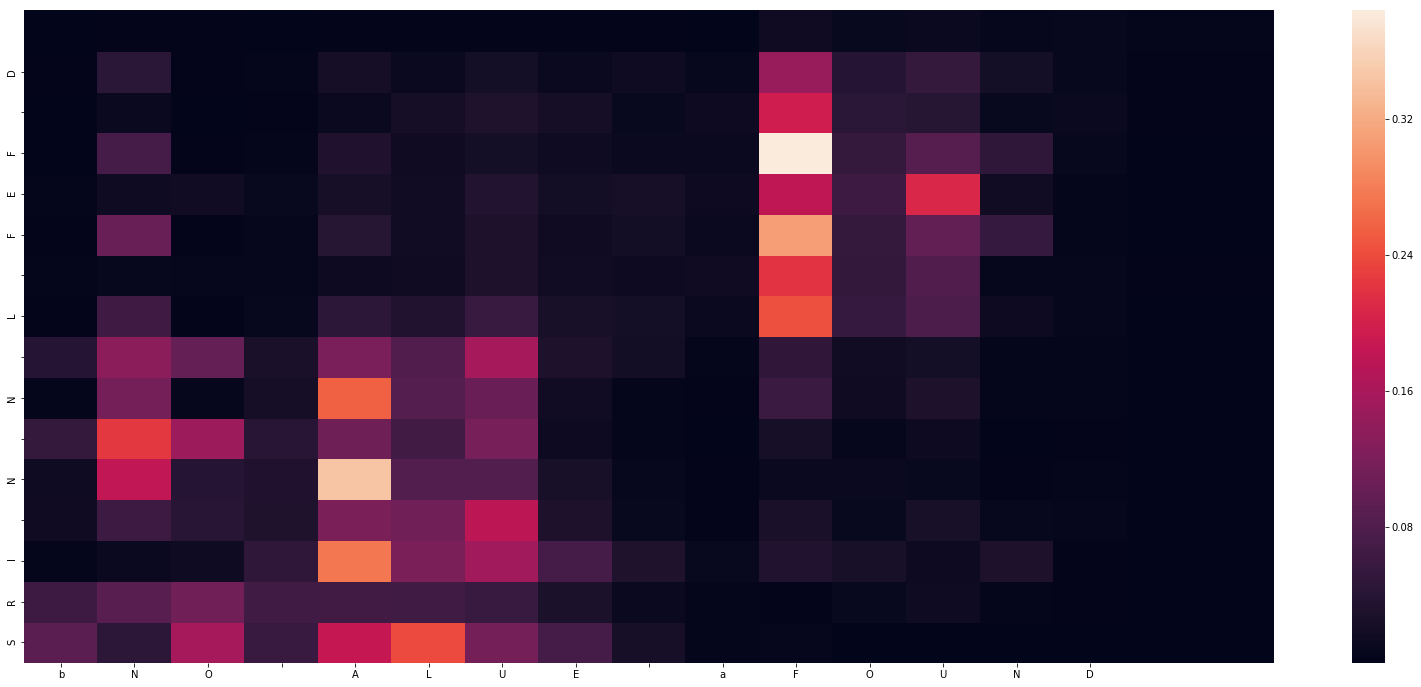

-
Input sentence: bNO ALUE aFOUND
GT sentence: "NO VALUE FOUND"
Decoded sentence: SRI N N L FEF D


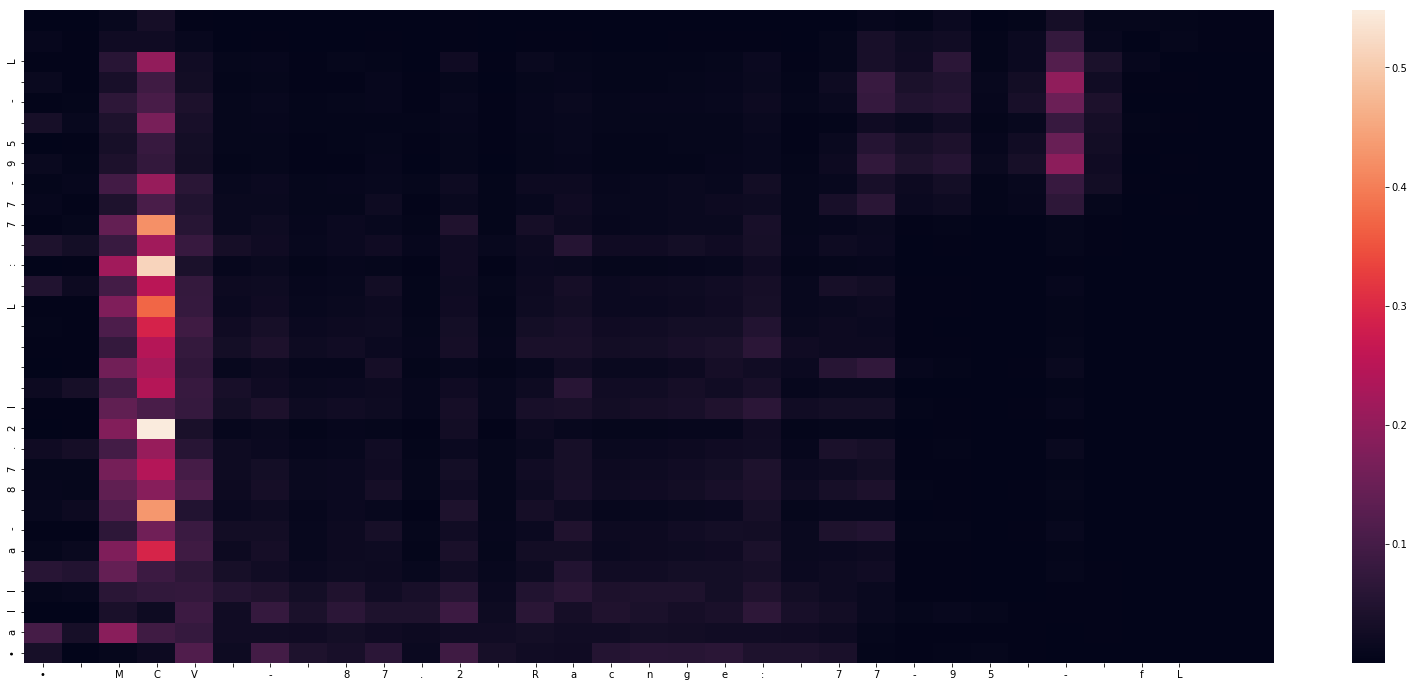

-
Input sentence: • MCV - 87.2 Racnge: 77-95 - fL
GT sentence: • MCV - 87.2 Range: 77-95 - fL

Decoded sentence: •all a- 87.2l    L : 77-95 - L


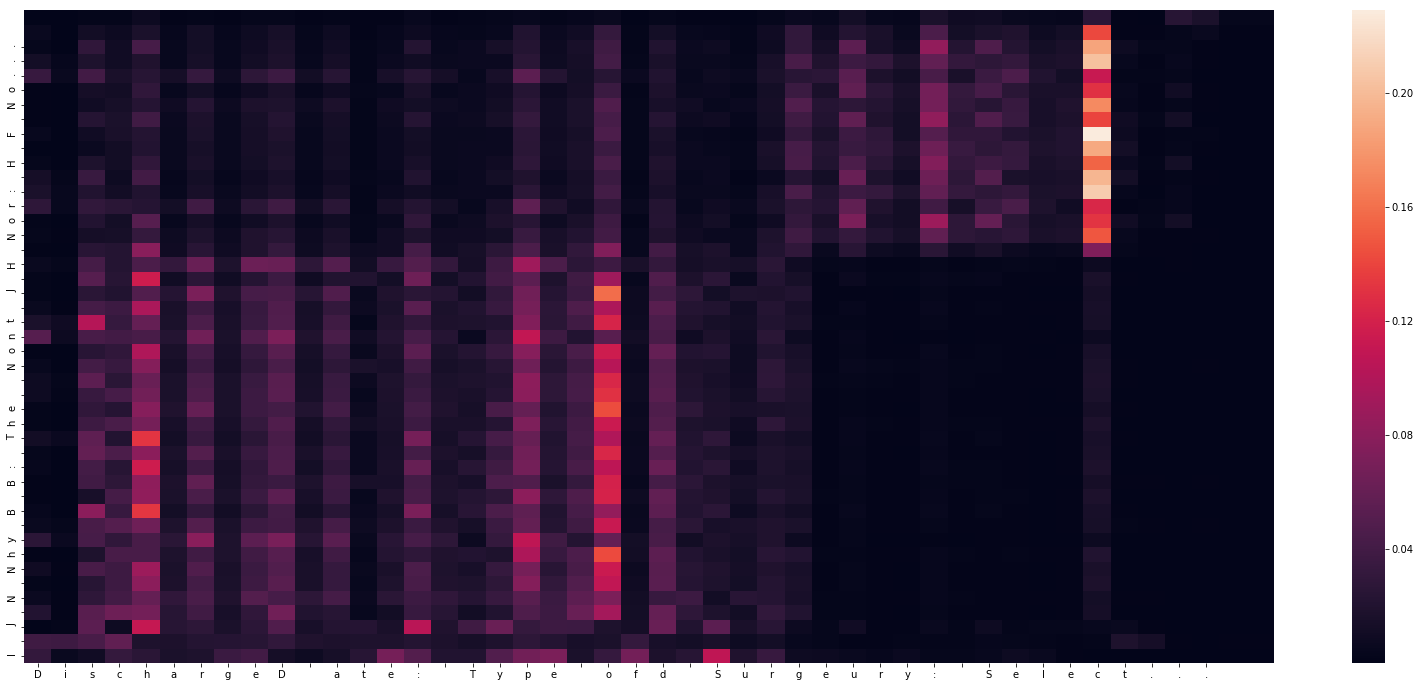

-
Input sentence: DischargeD ate: Type ofd Surgeury: Select...
GT sentence: Discharge Date: Type of Surgery: Select...

Decoded sentence: I J N Nhy B B: The  Nont J H Nor: H F No...


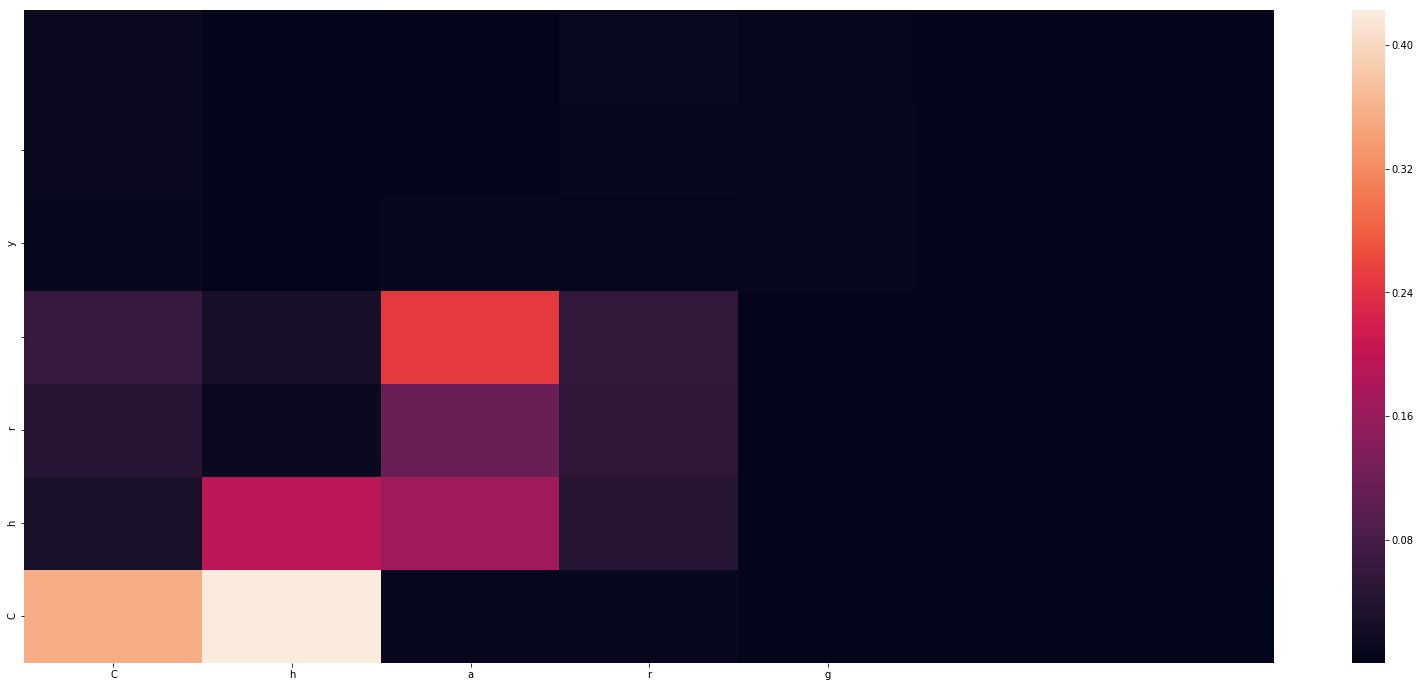

-
Input sentence: Charg
GT sentence: Charge

Decoded sentence: Chr y 


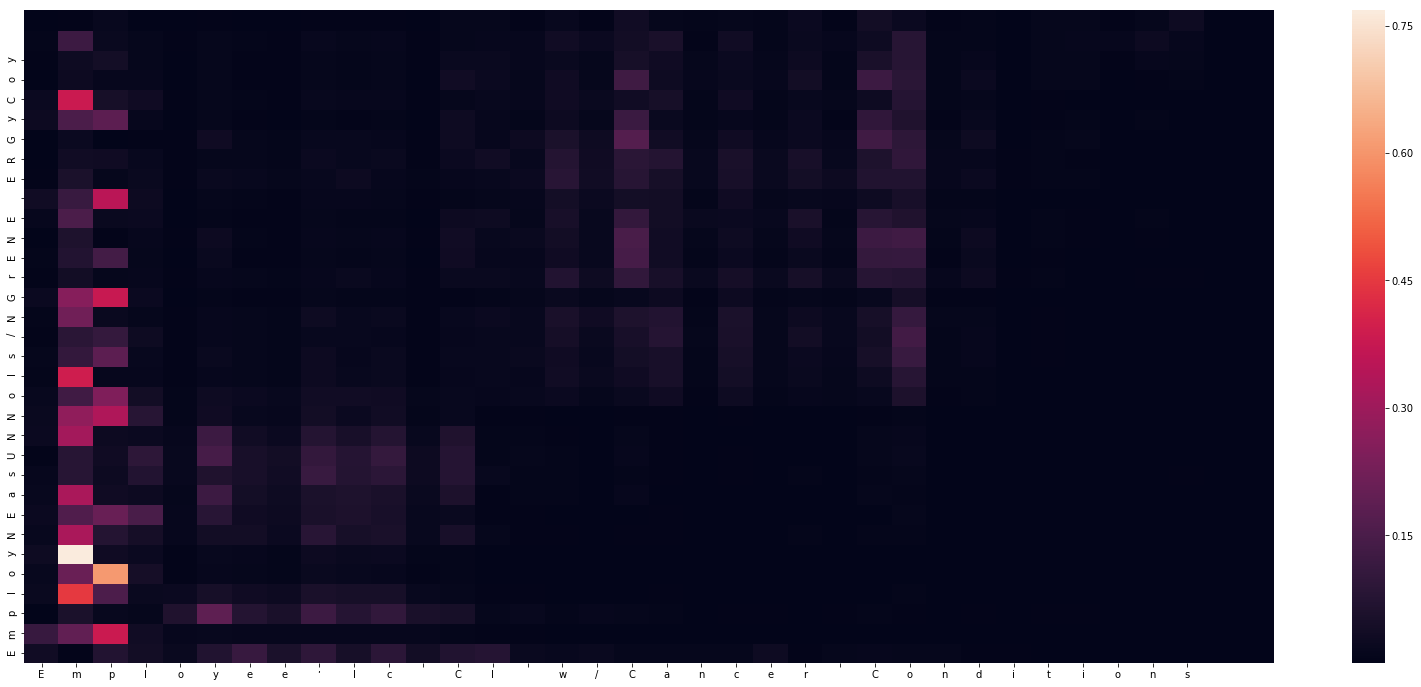

-
Input sentence: Employee‘lc CI w/Cancer Conditions
GT sentence: Employee*  CI w/Cancer Conditions

Decoded sentence: EmployNEasUNNols/NGrENE ERGyCoy


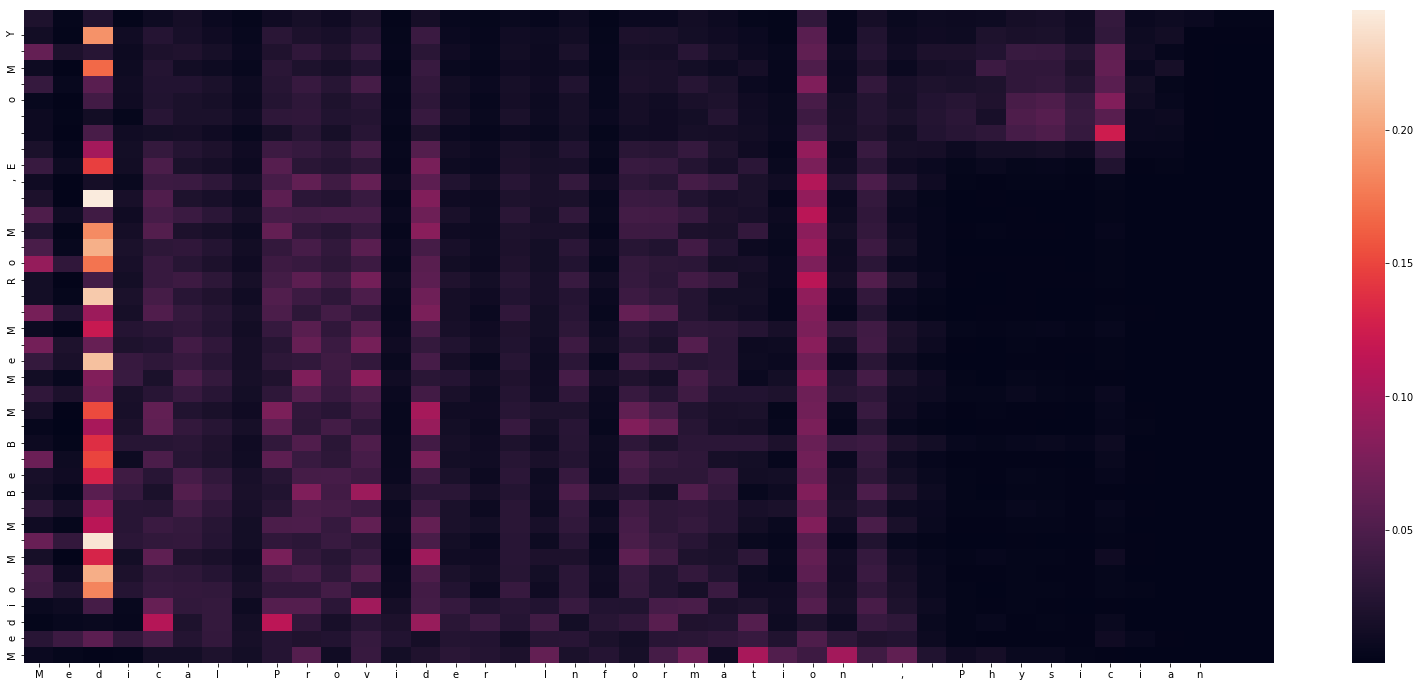

-
Input sentence: Medical Provider Information , Physician
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medio M M Be B M Me M  Ro M  ,E   o M Y


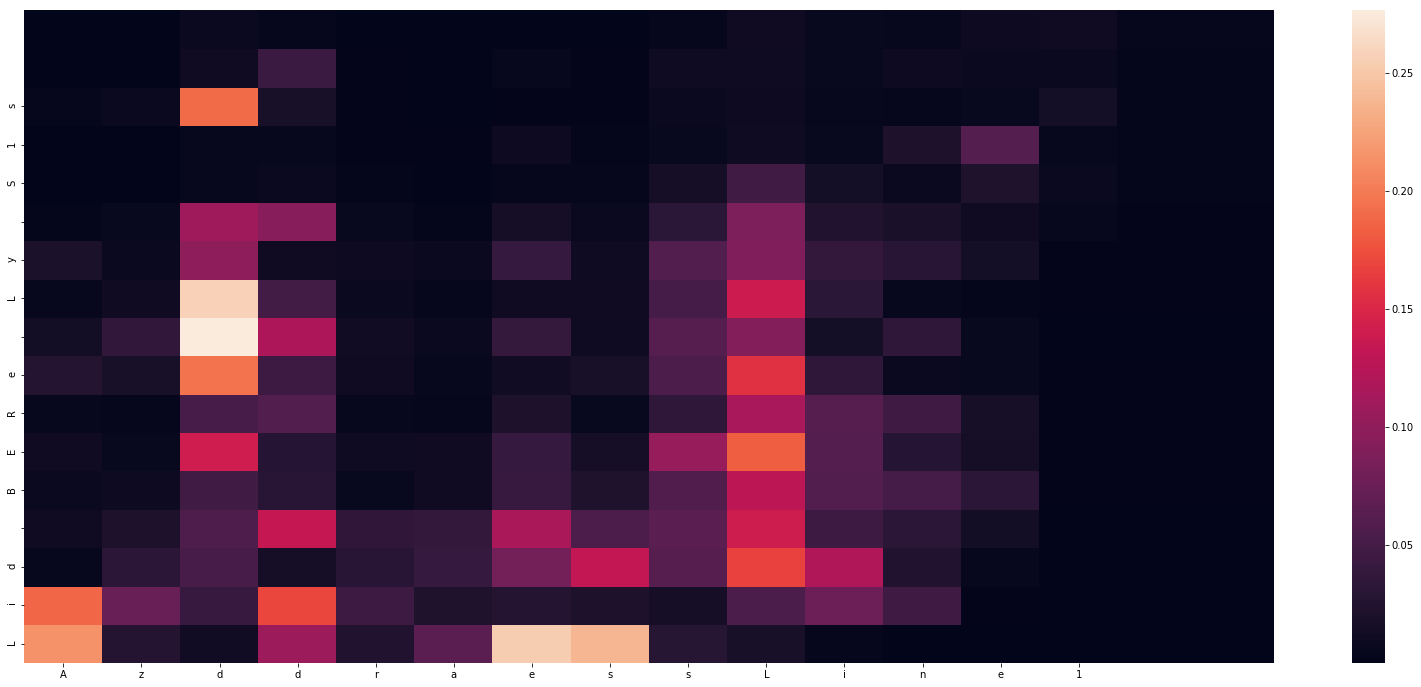

-
Input sentence: AzddraessLine1
GT sentence: Address Line 1:

Decoded sentence: Lid BERe Ly S1s


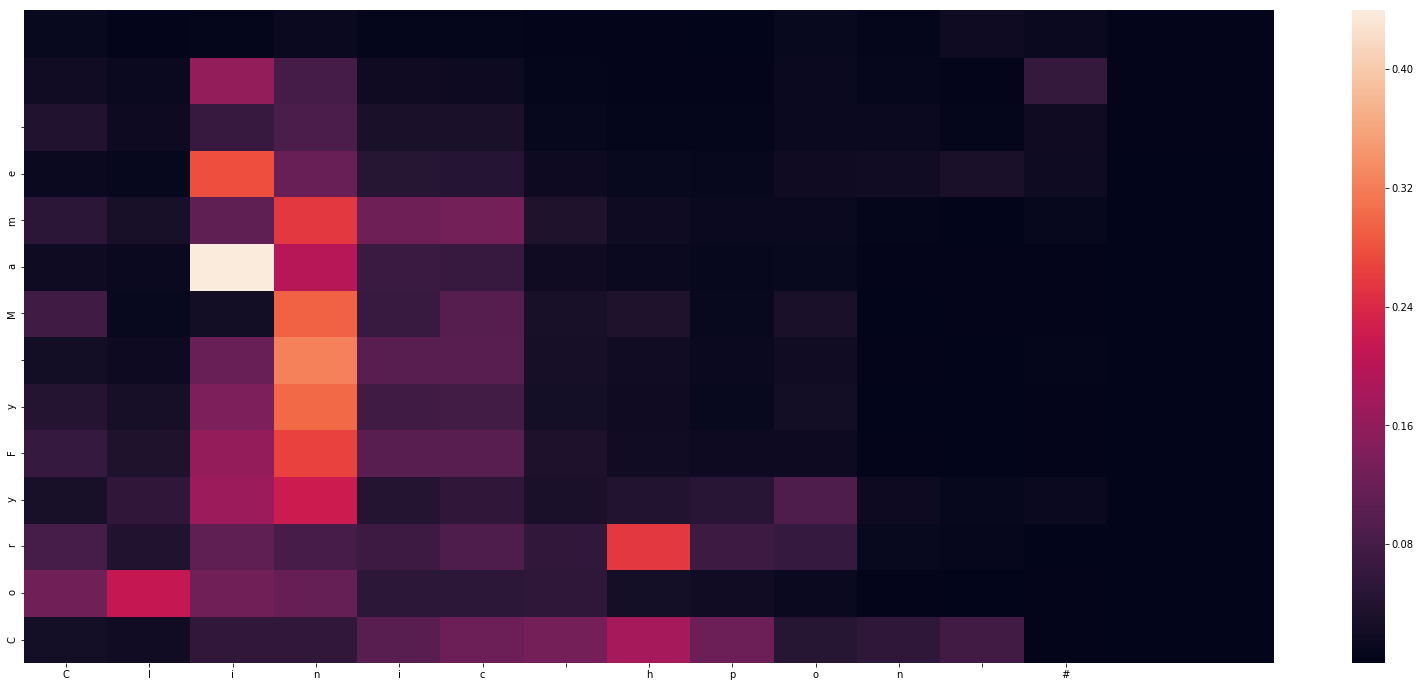

-
Input sentence: Clinic hpon #
GT sentence: Clinic phone #

Decoded sentence: CoryFy Mame 


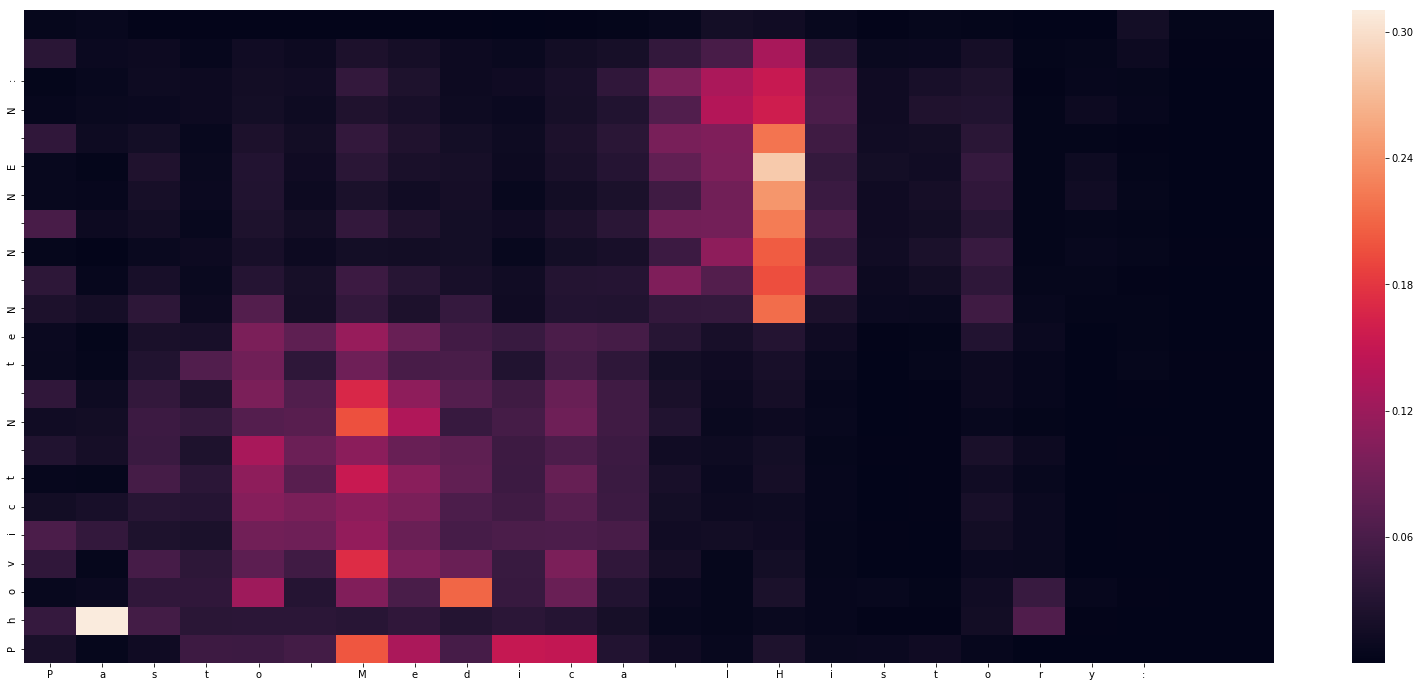

-
Input sentence: Pasto Medica lHistory:
GT sentence: Past Medical History:

Decoded sentence: Phovict N teN N NE N:


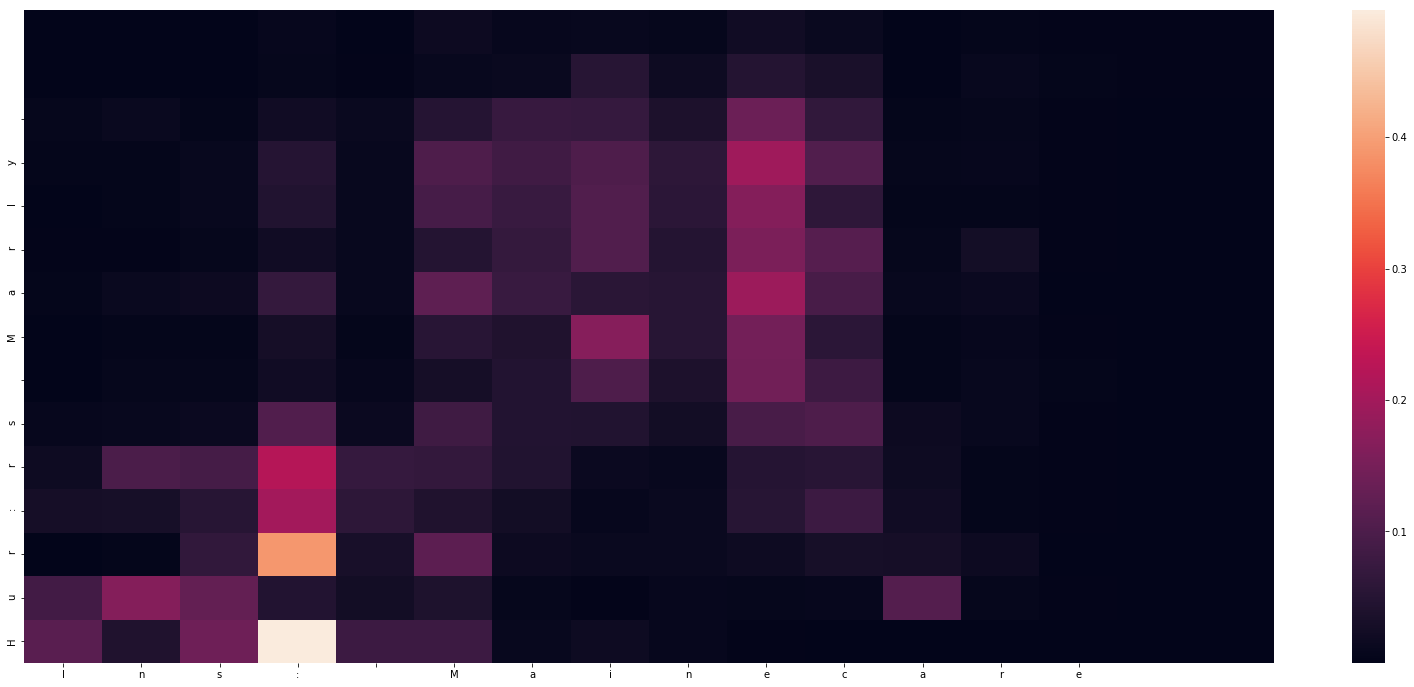

-
Input sentence: lns: Mainecare
GT sentence: Ins: Mainecare

Decoded sentence: Hur:rs Marly 


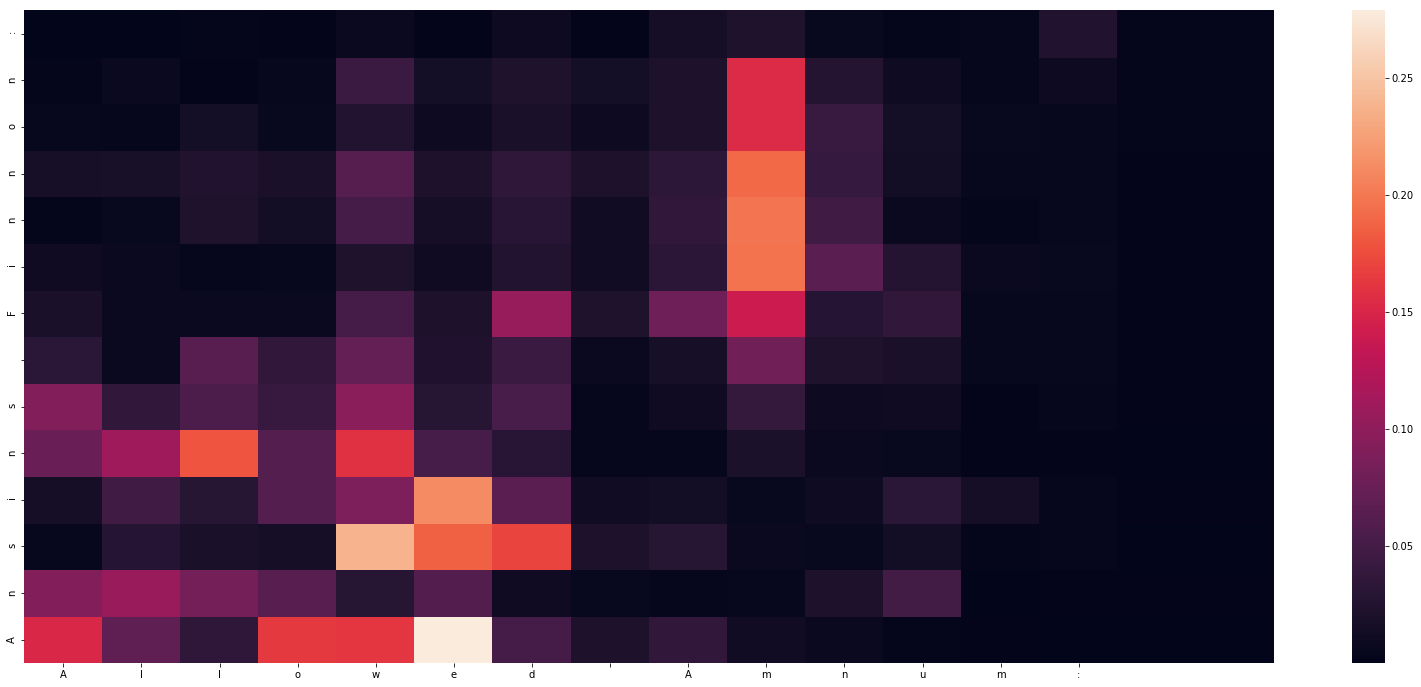

-
Input sentence: Allowed Amnum:
GT sentence: Allowed Amount:

Decoded sentence: Ansins Finnon:


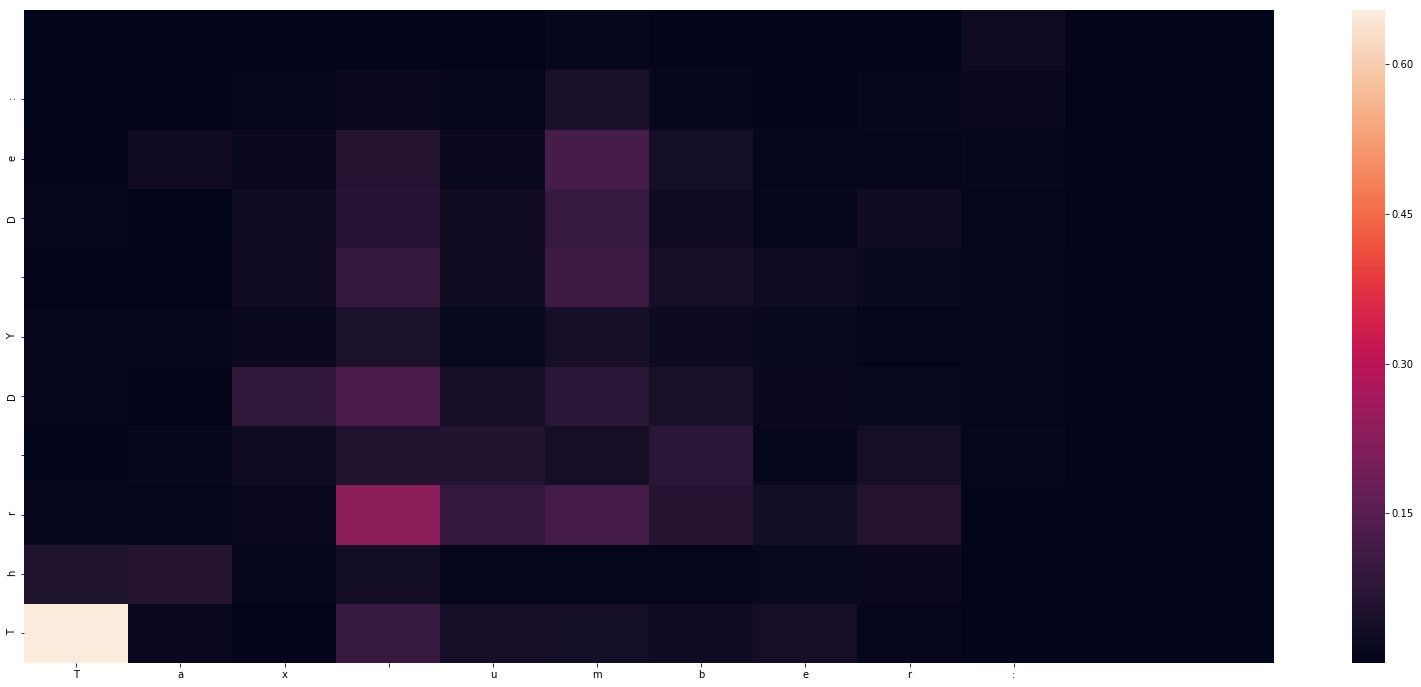

-
Input sentence: Tax umber:
GT sentence: Tax Number:

Decoded sentence: Thr DY De:


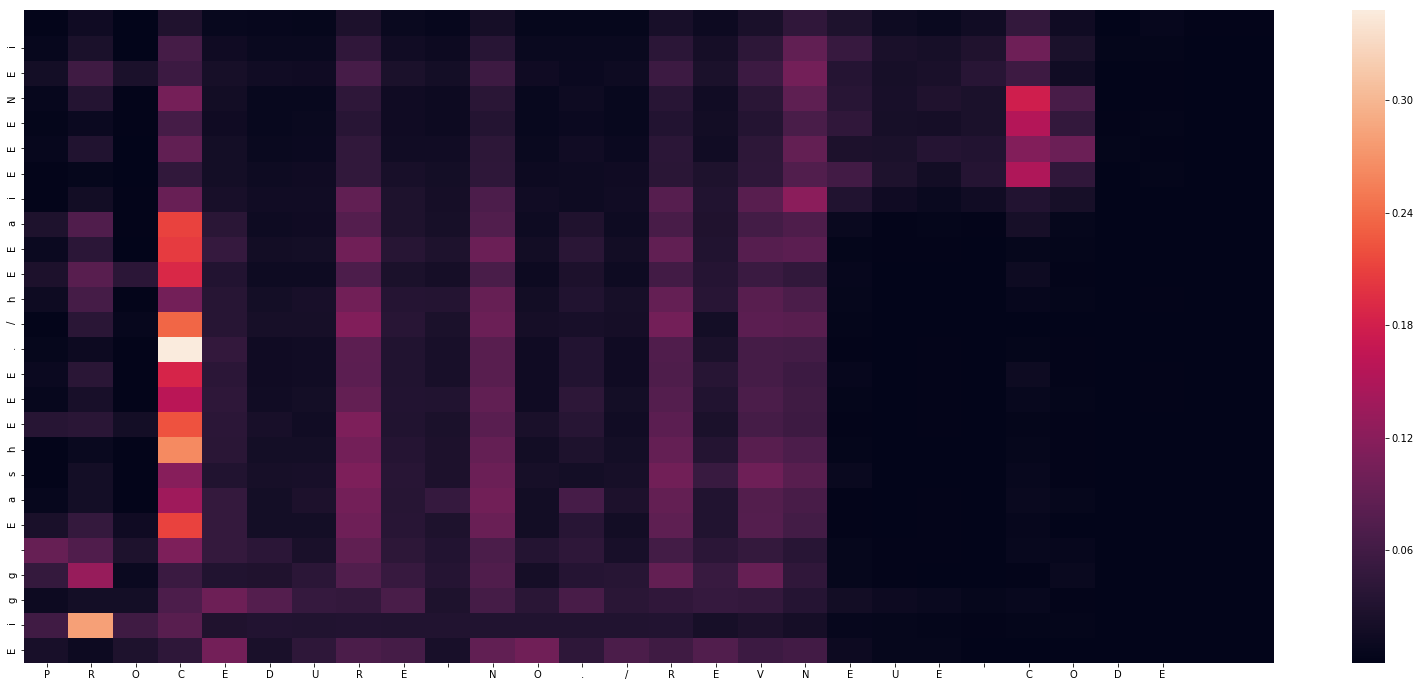

-
Input sentence: PROCEDURE NO./REVNEUE CODE
GT sentence: PROCEDURE NO./REVENUE CODE

Decoded sentence: Eigg EashEEE./hEEaiEEENEi


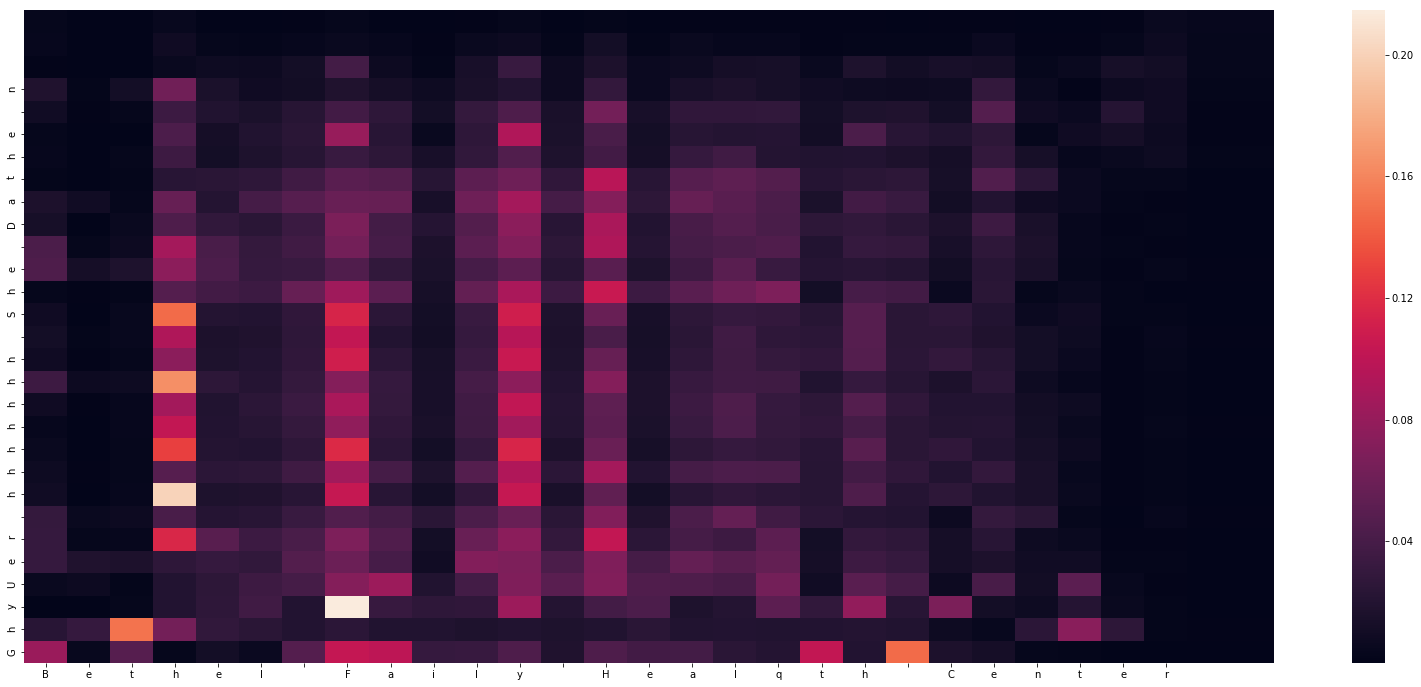

-
Input sentence: Bethel Faily Healqth Center
GT sentence: Bethel Family Health Center

Decoded sentence: GhyUer hhhhhhh She Dathe n


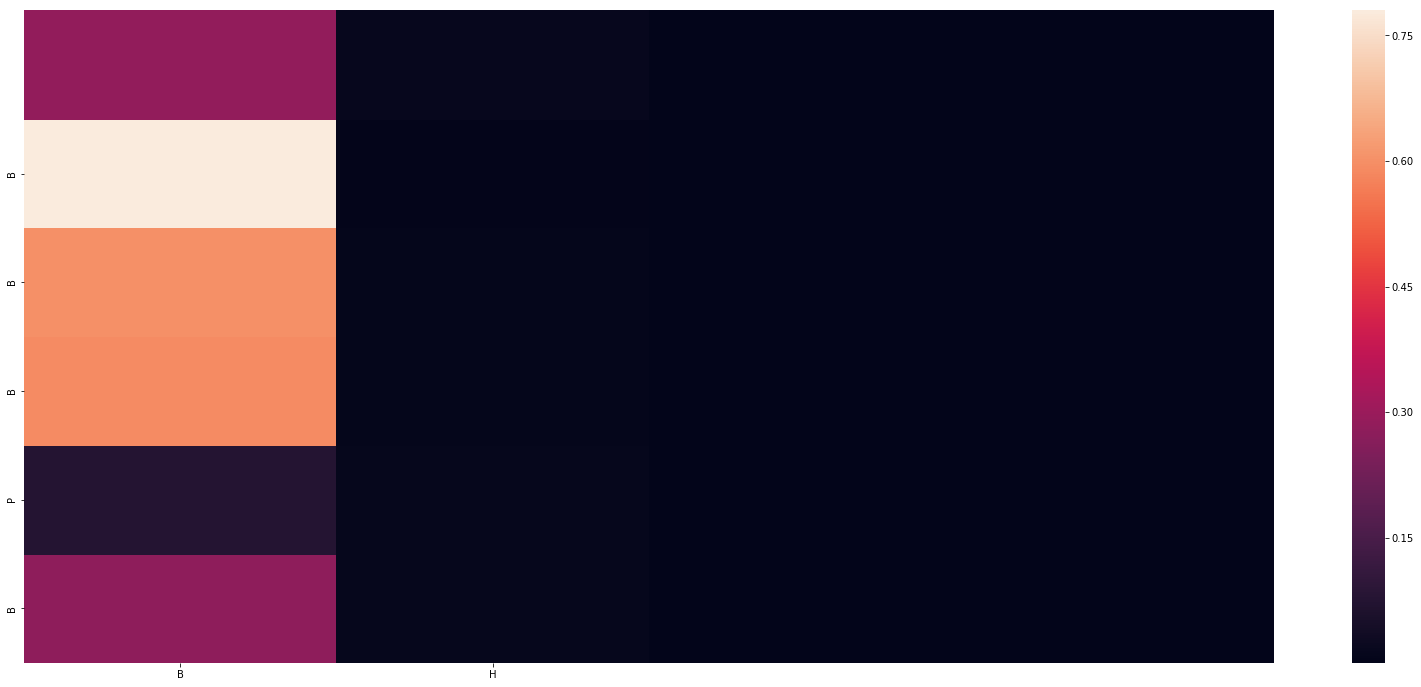

-
Input sentence: BH
GT sentence: BHS
Decoded sentence: BPBBB


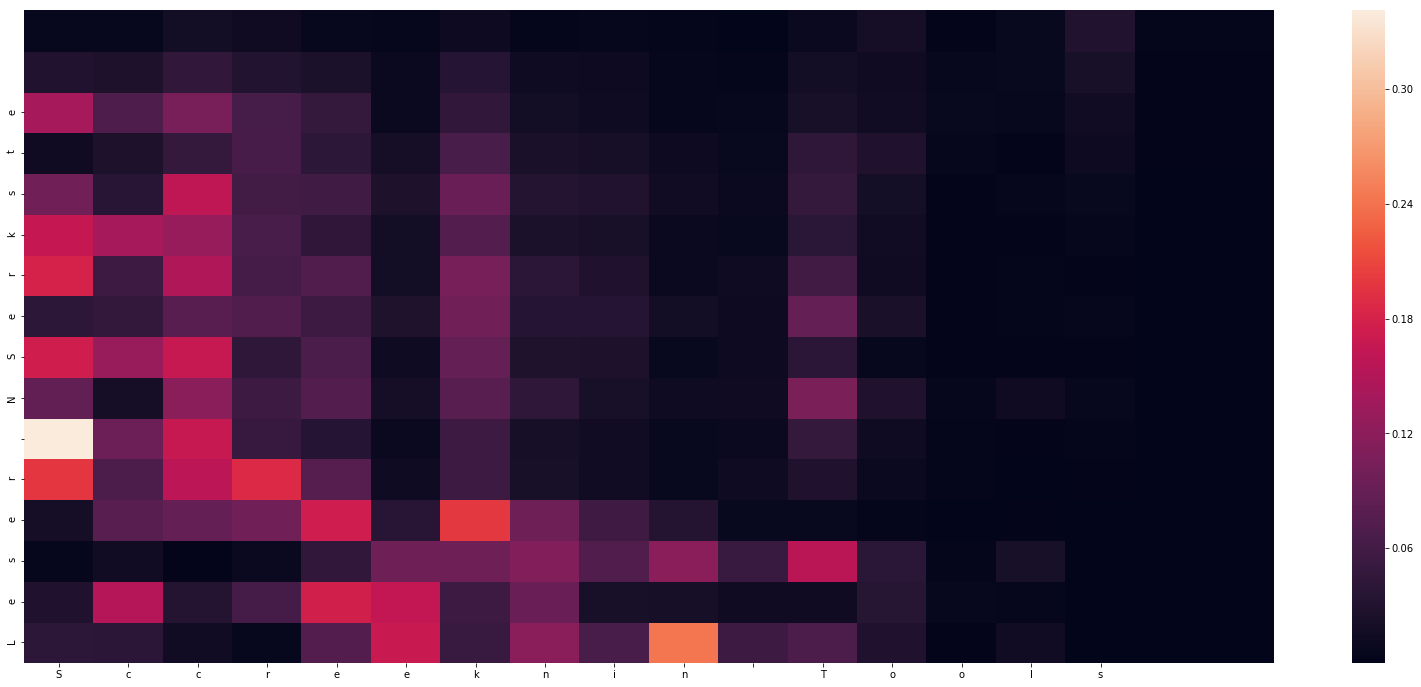

-
Input sentence: Sccreeknin Tools
GT sentence: Screening Tools

Decoded sentence: Leser NSerkste


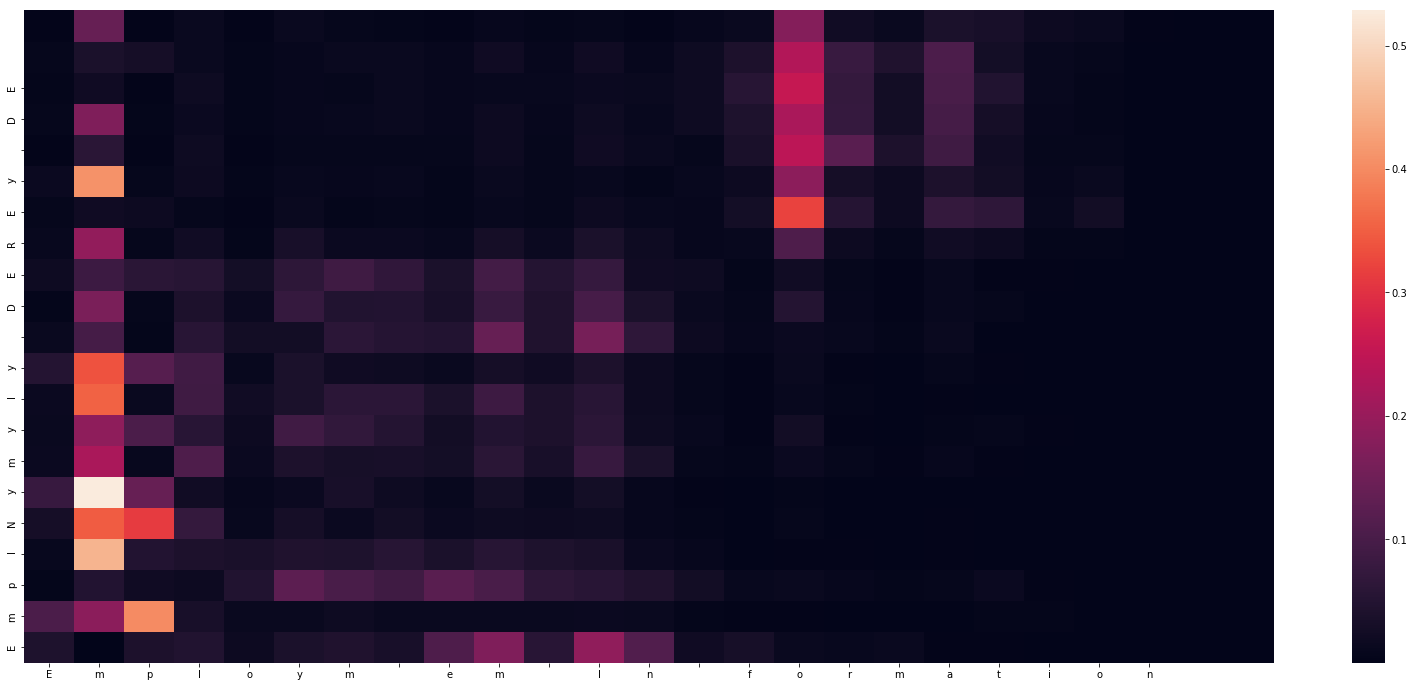

-
Input sentence: Employm em In formation
GT sentence: Employment Information

Decoded sentence: EmplNymyly DEREy DE


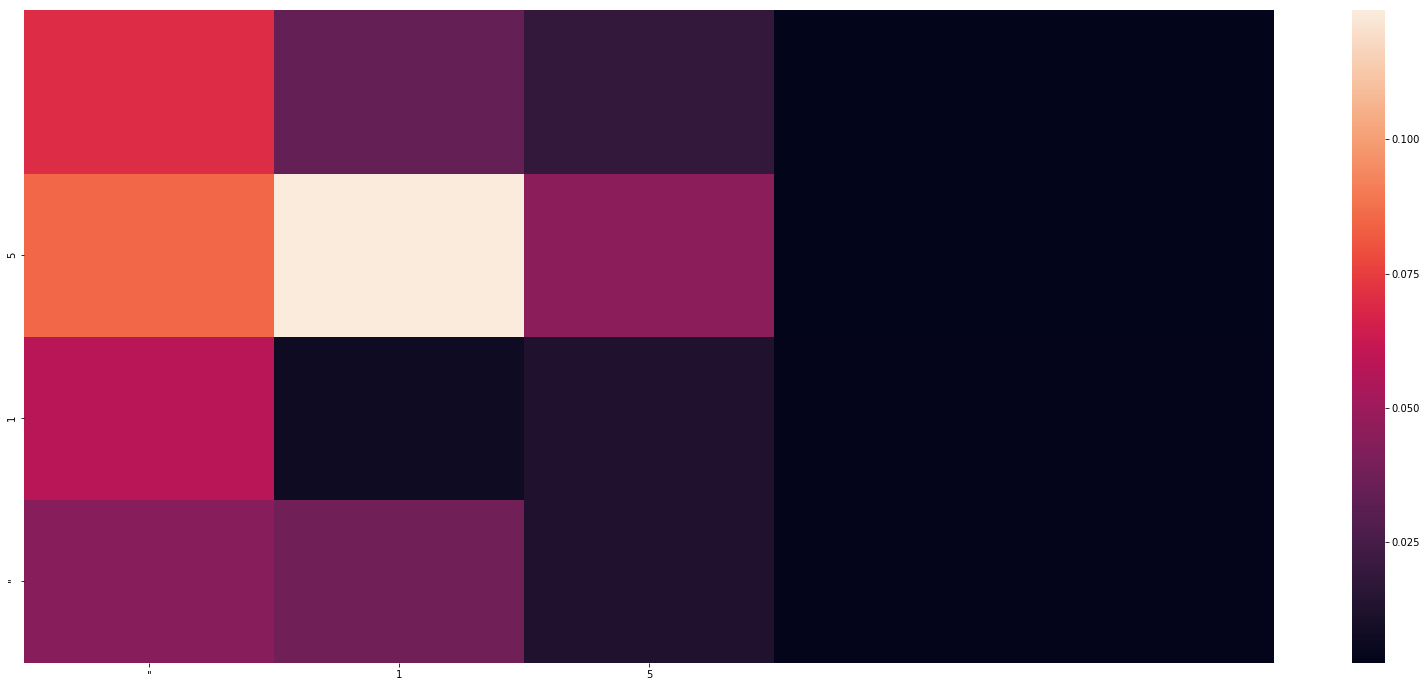

-
Input sentence: "15
GT sentence: "15"
Decoded sentence: "15


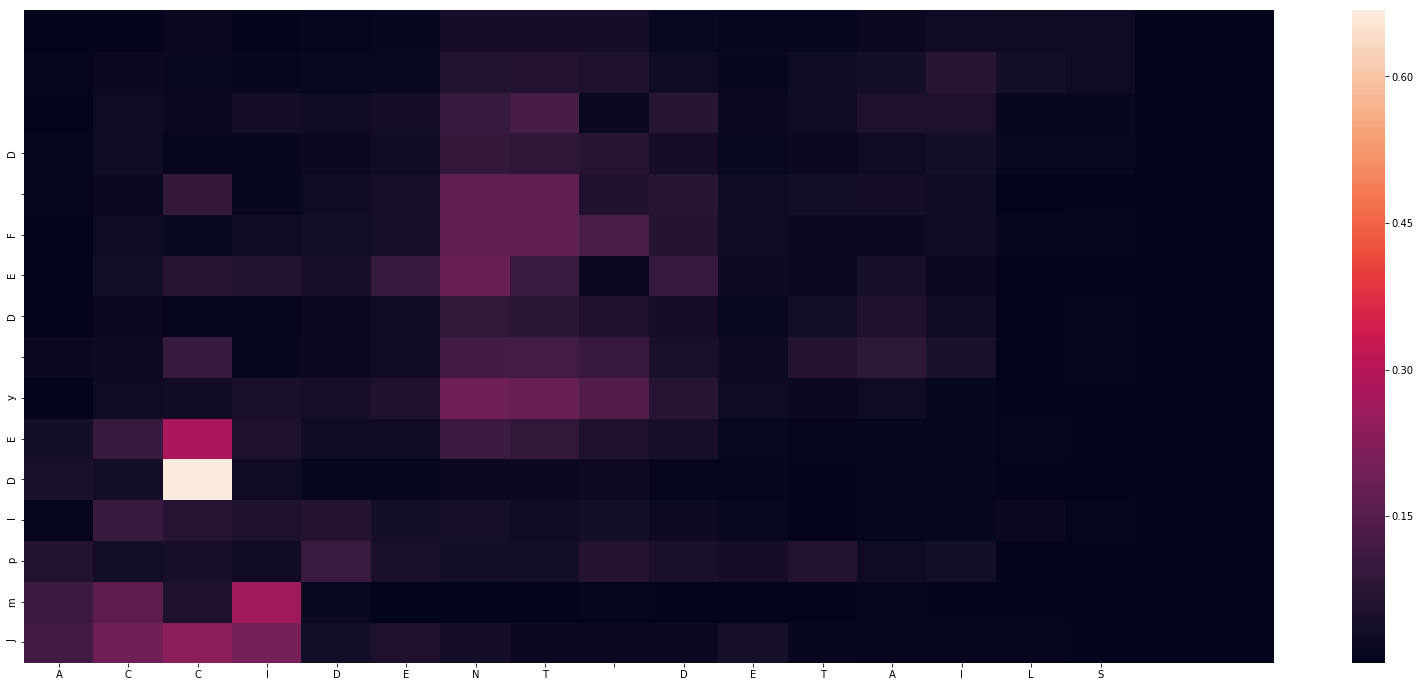

-
Input sentence: ACCIDENT DETAILS
GT sentence: ACCIDENT DETAILS

Decoded sentence: JmplDEy DEF D


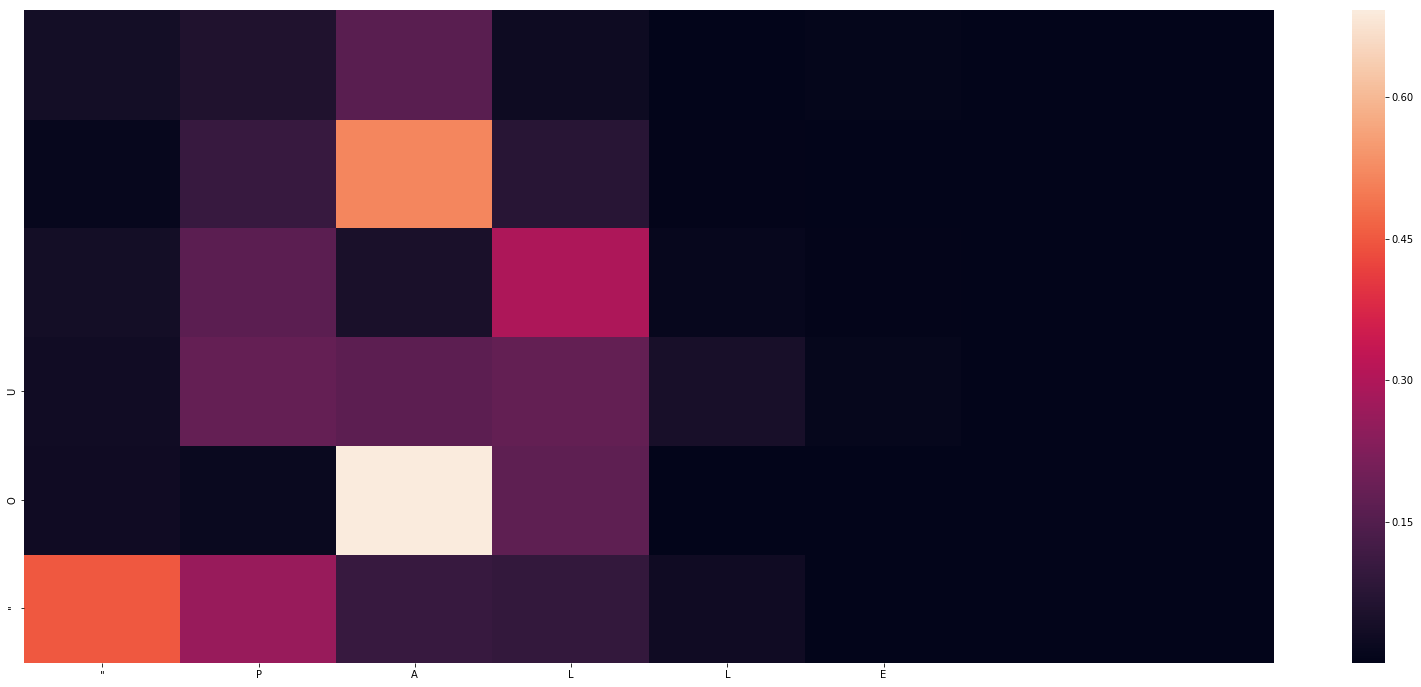

-
Input sentence: "PALLE
GT sentence: "PALLETS"
Decoded sentence: "OU


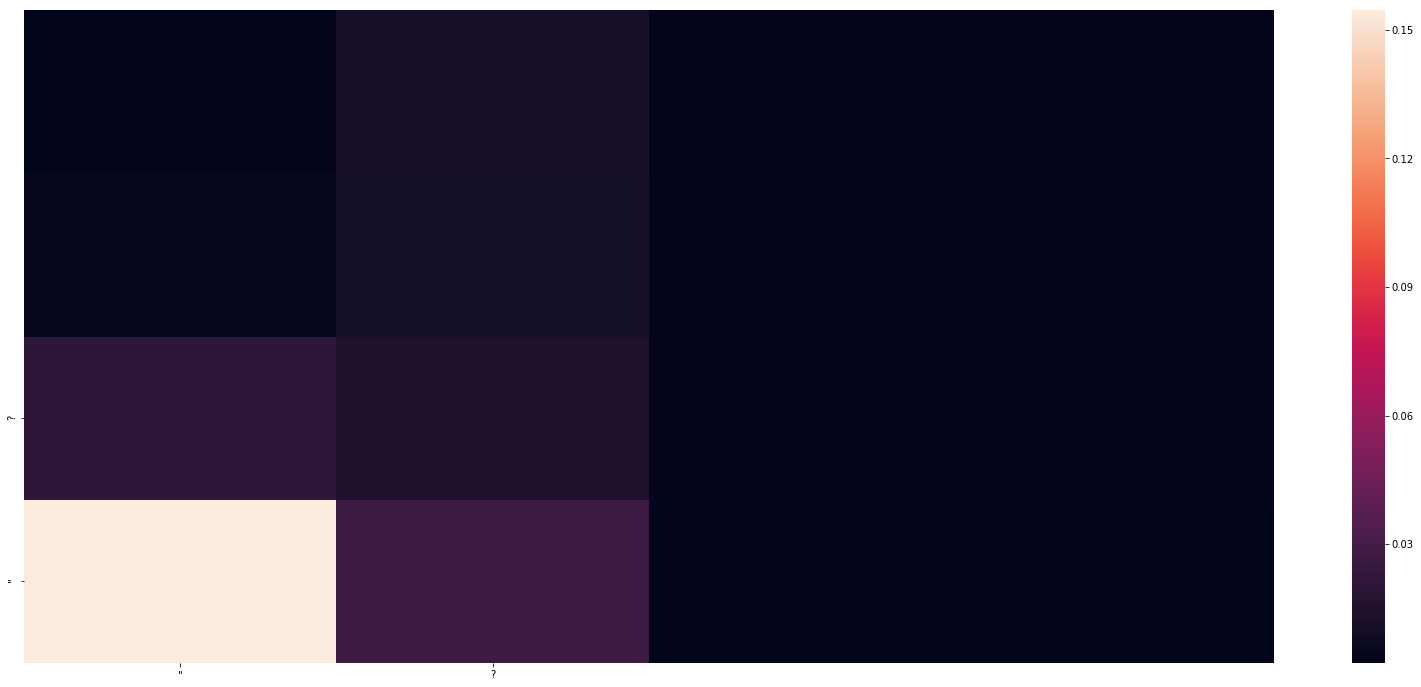

-
Input sentence: "?
GT sentence: "?"
Decoded sentence: "?


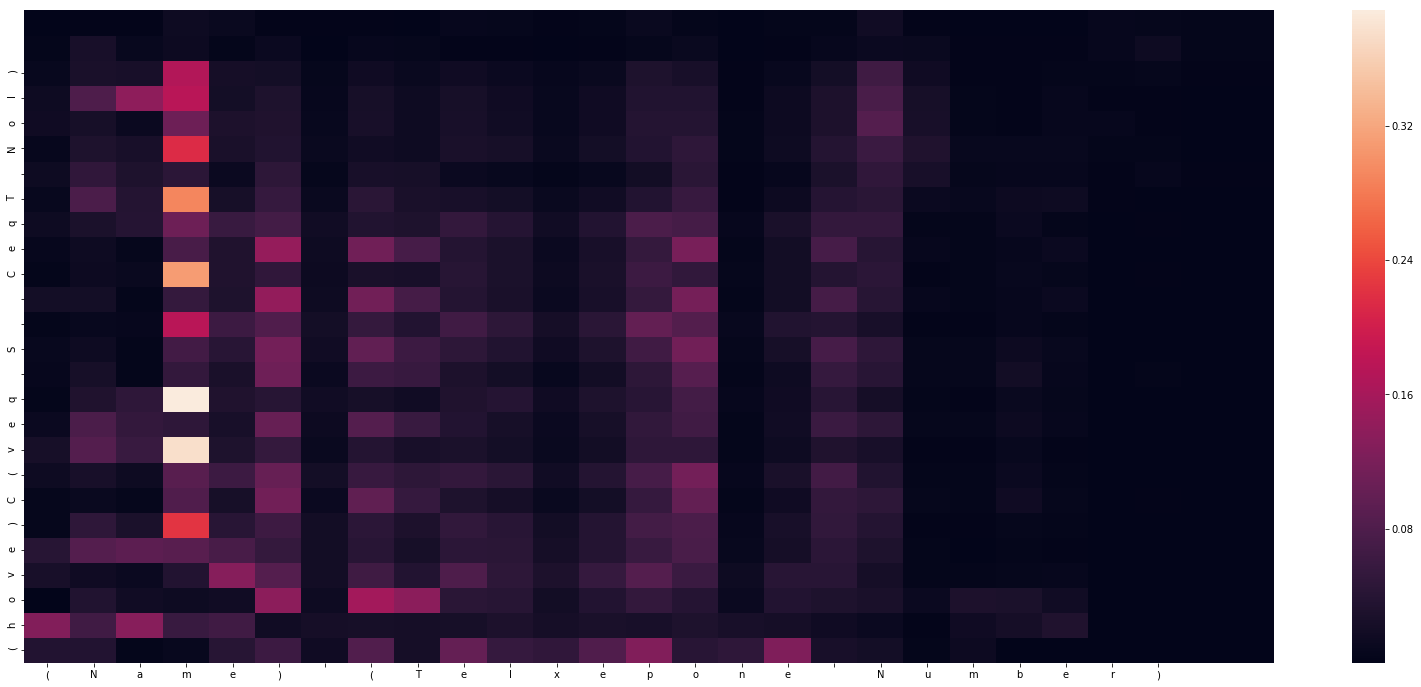

-
Input sentence: (Name) (Telxepone Number)
GT sentence: (Name) (Telephone Number)

Decoded sentence: (hove)C(veq S  CeqT Nol)


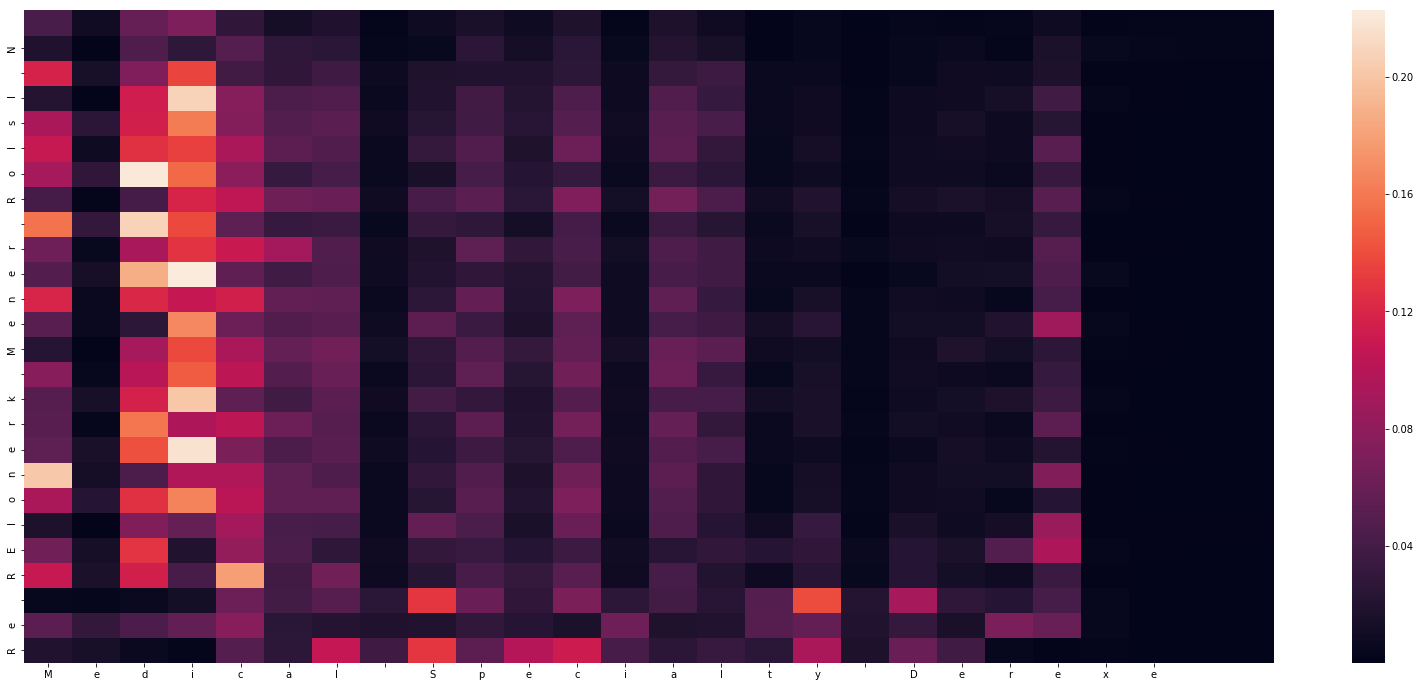

-
Input sentence: Medical Specialty Derexe
GT sentence: Medical Specialty Degree

Decoded sentence: Re RElonerk Mener Rolsl N


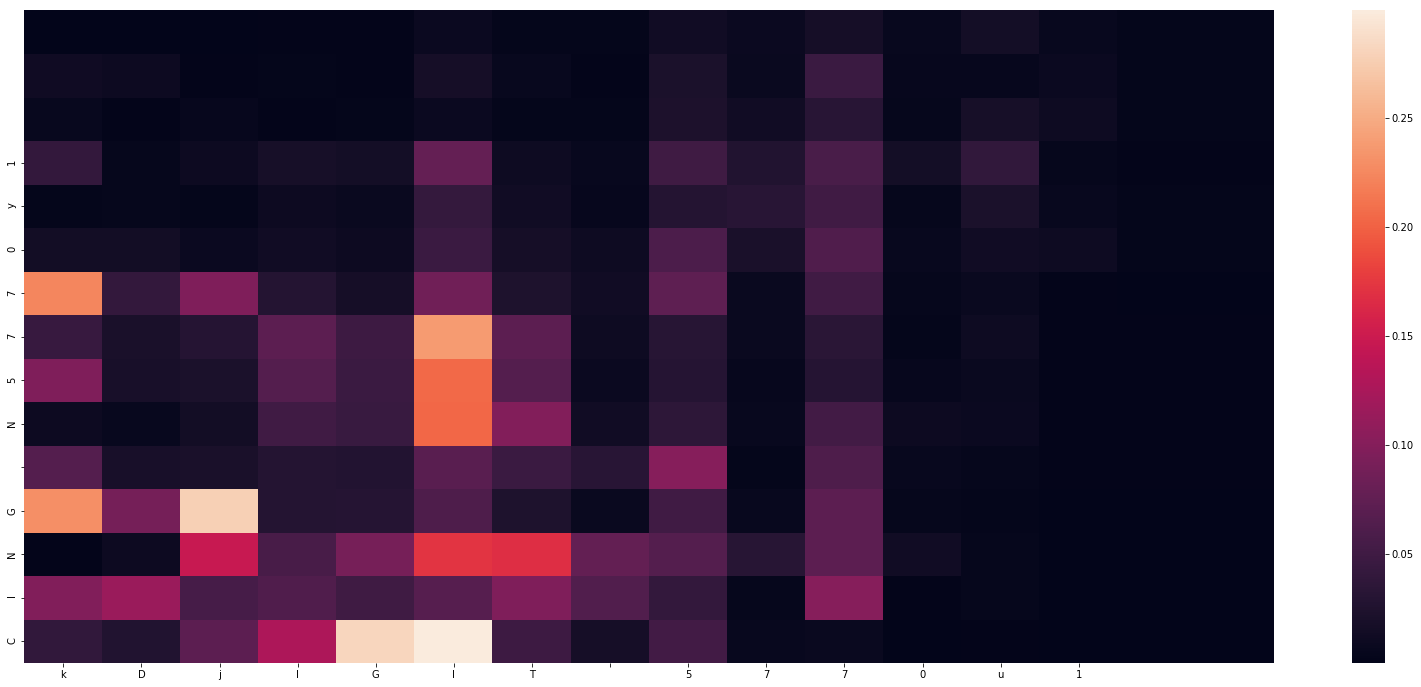

-
Input sentence: kDjIGIT 5770u1
GT sentence: DIGIT 57701

Decoded sentence: CING N5770y1


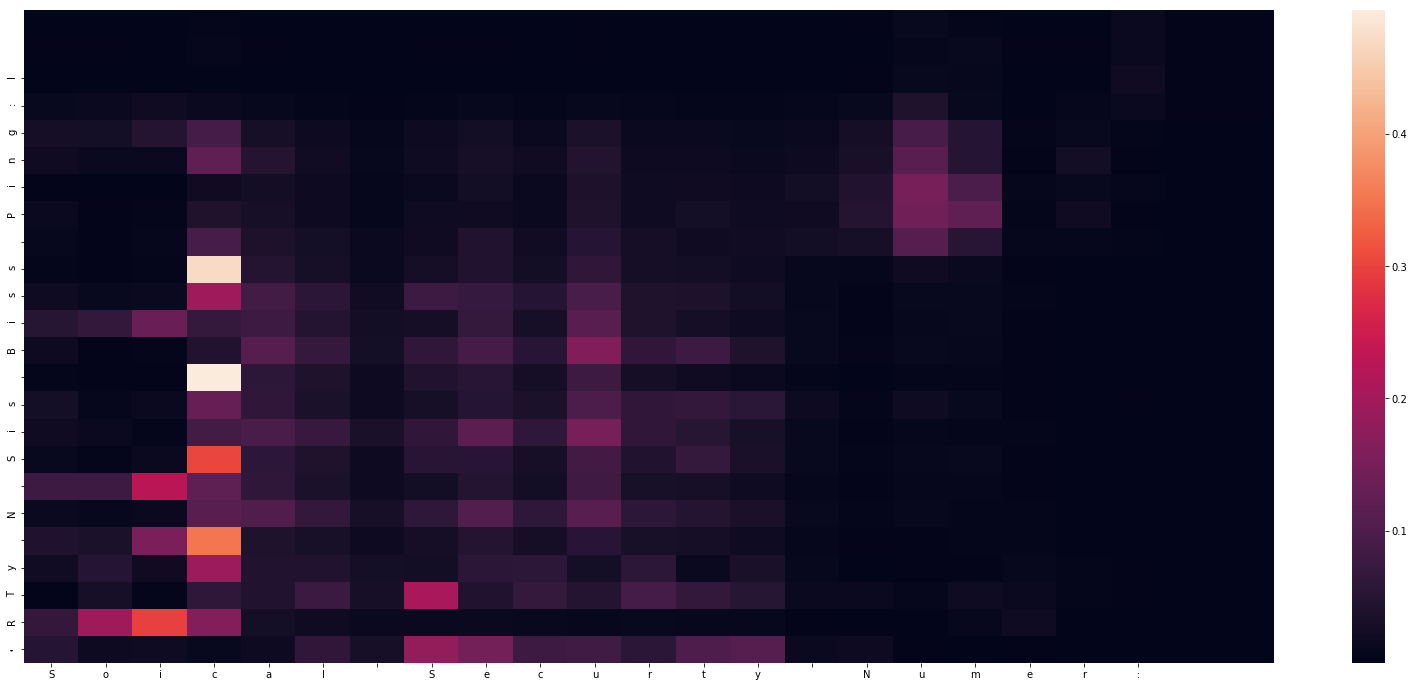

-
Input sentence: Soical Securty Numer:
GT sentence: Social Security Number:

Decoded sentence: •RTy N Sis Biss Ping:l


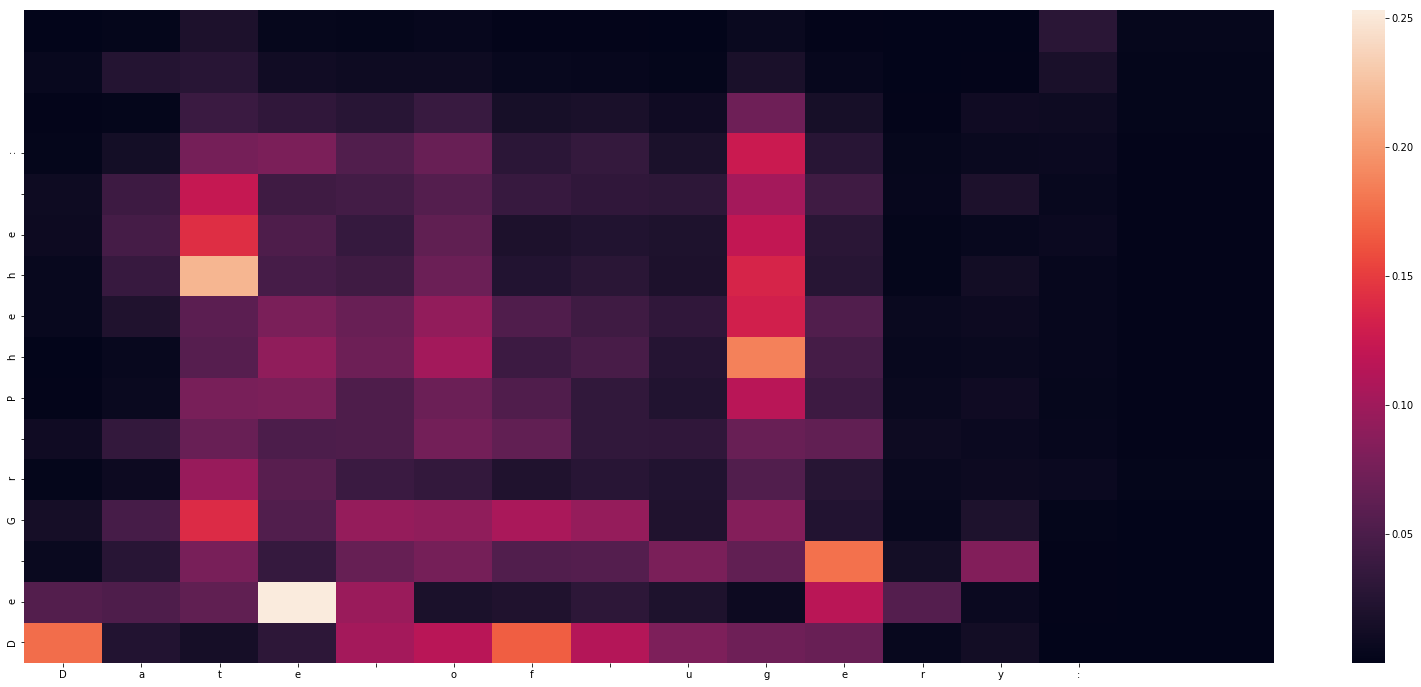

-
Input sentence: Date of ugery:
GT sentence: Date of surgery:

Decoded sentence: De Gr Phehe :


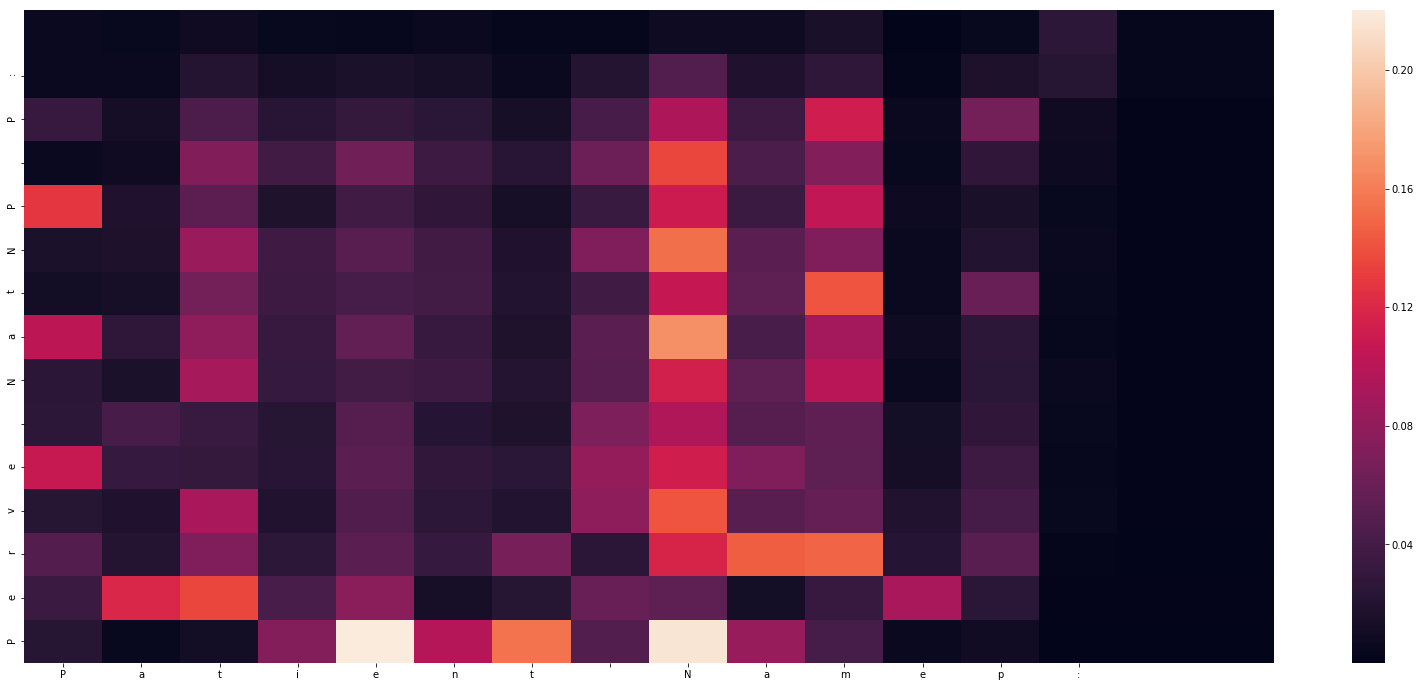

-
Input sentence: Patient Namep:
GT sentence: Patient Name:

Decoded sentence: Perve NatNP P:


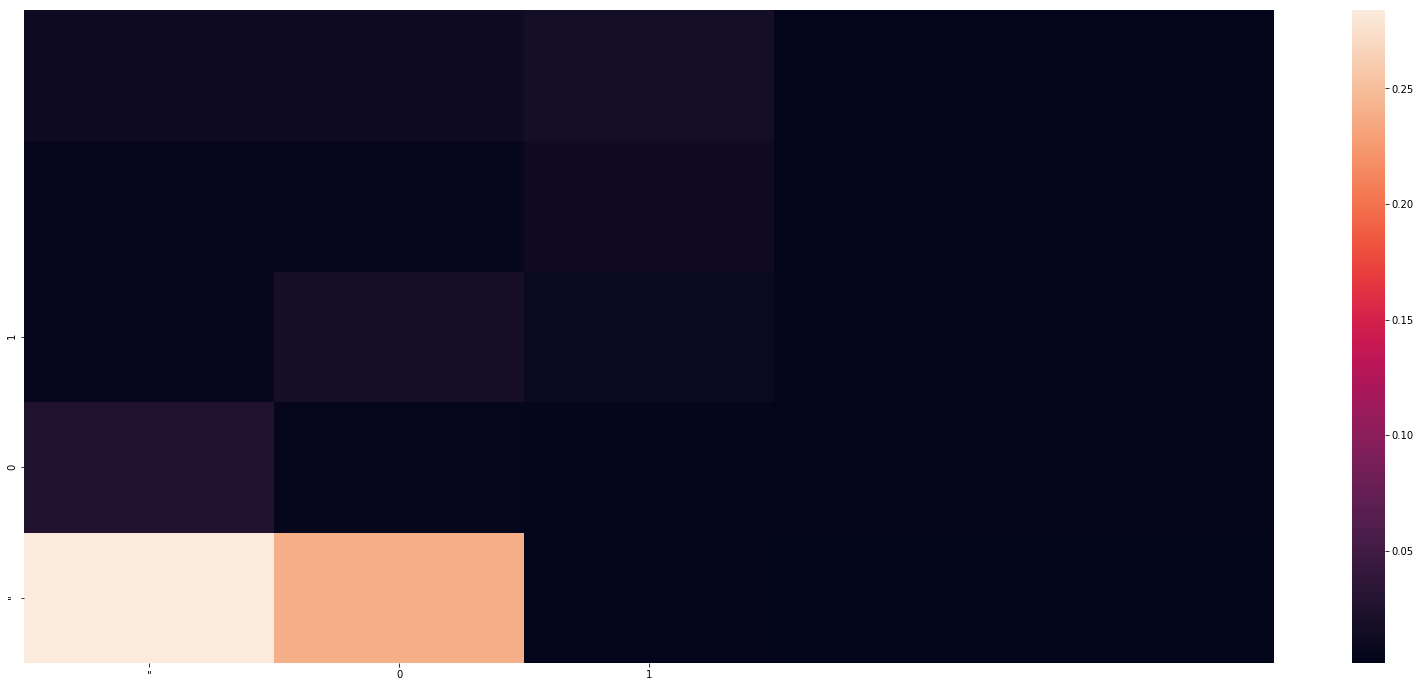

-
Input sentence: "01
GT sentence: "01"
Decoded sentence: "01


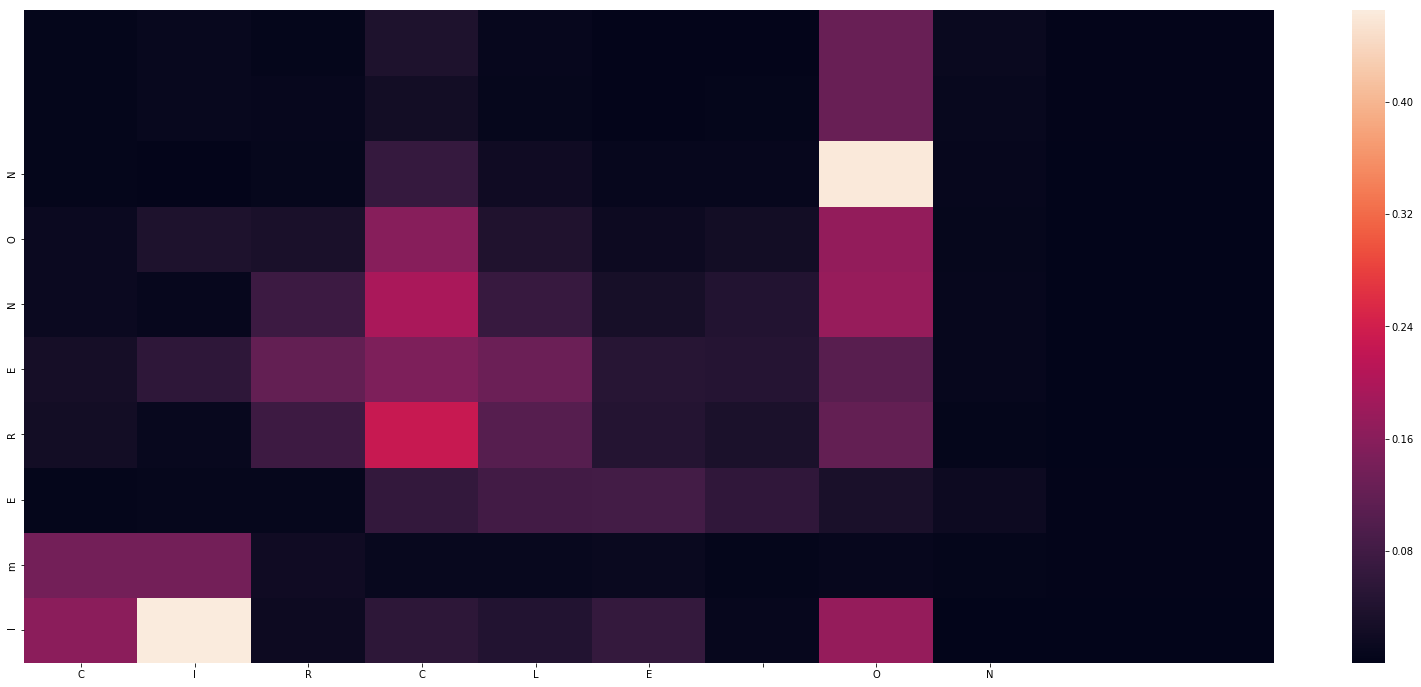

-
Input sentence: CIRCLE ON
GT sentence: CIRCLE ONE

Decoded sentence: ImERENON


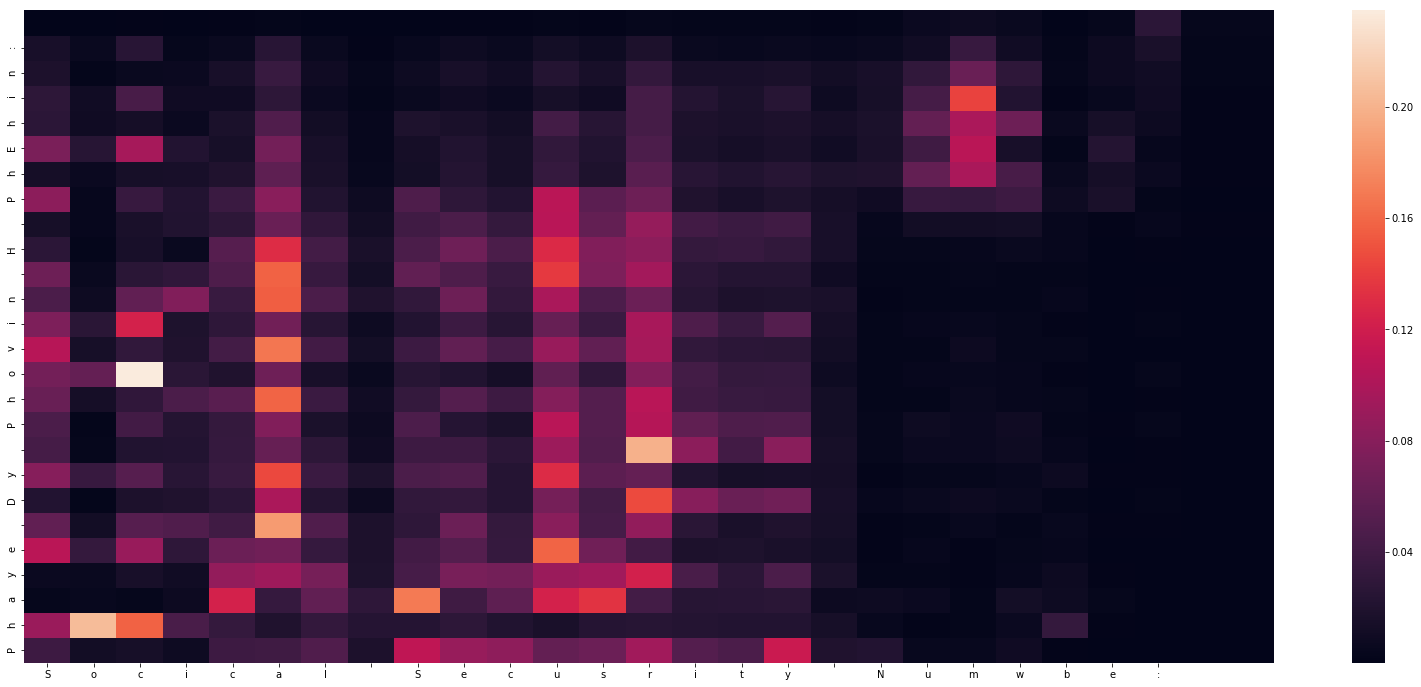

-
Input sentence: Socical Secusrity Numwbe:
GT sentence: Social Security Number:

Decoded sentence: Phaye Dy Phovin H PhEhin:


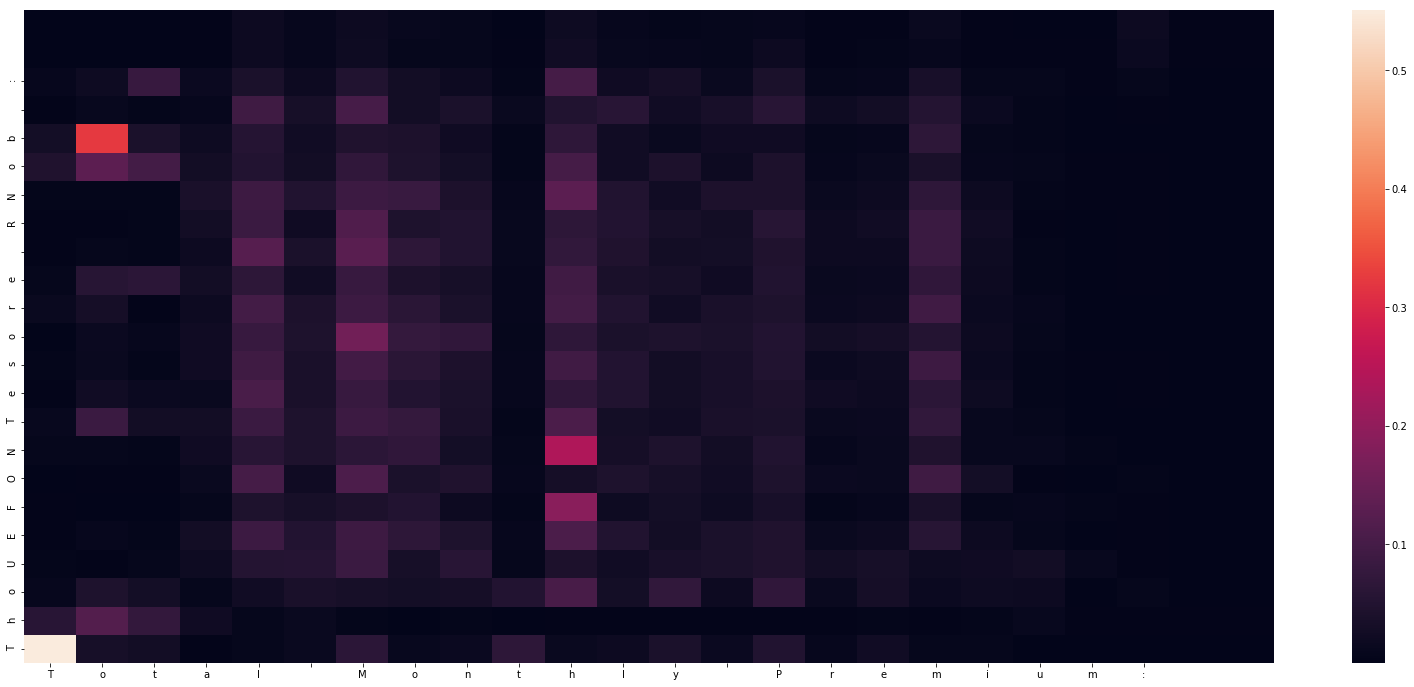

-
Input sentence: Total Monthly Premium:
GT sentence: Total Monthly Premium:

Decoded sentence: ThoUEFONTesore RNob :


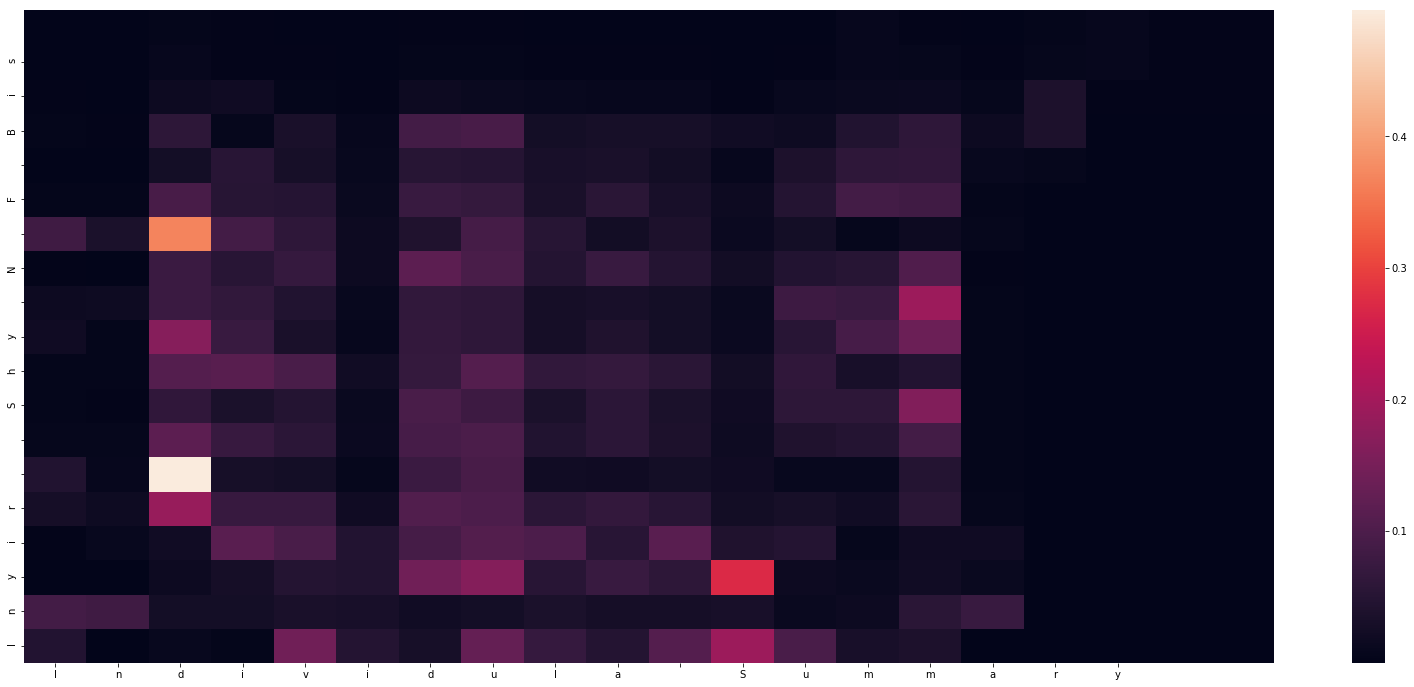

-
Input sentence: Individula Summary
GT sentence: Individual Summary

Decoded sentence: Inyir  Shy N F Bis


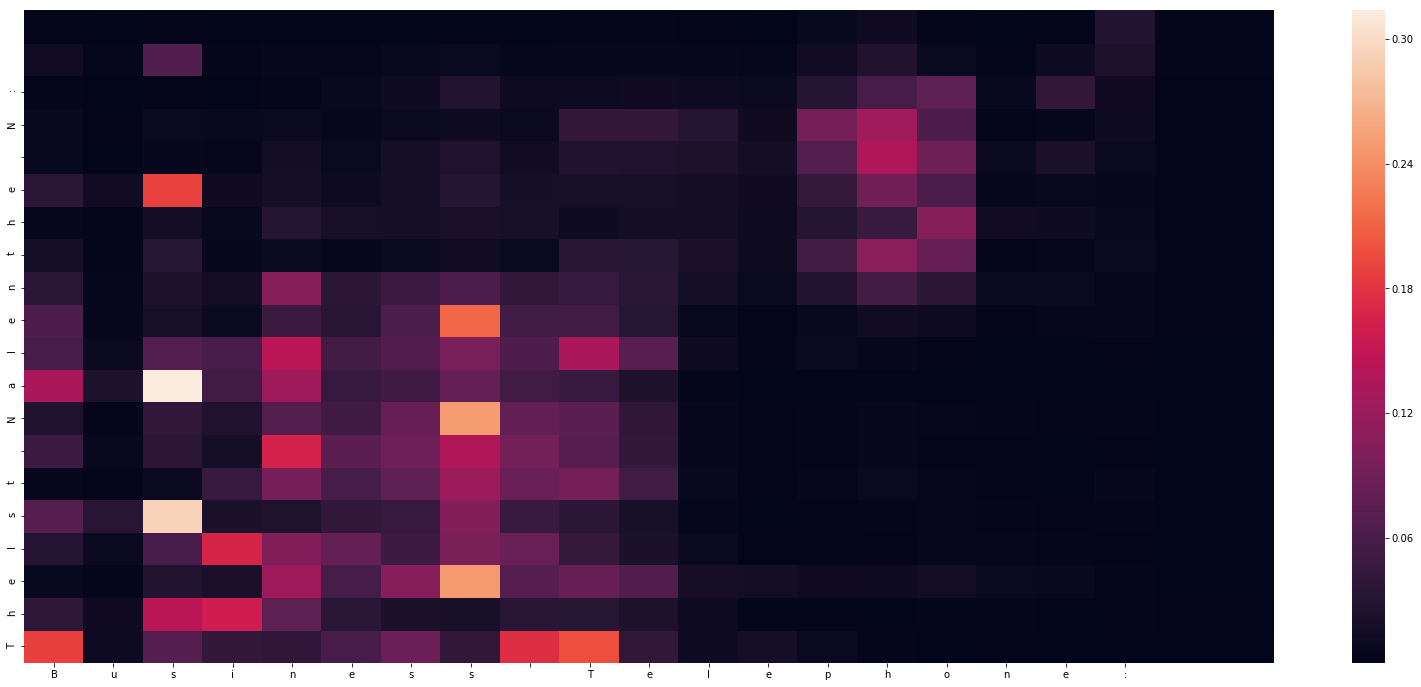

-
Input sentence: Business Telephone:
GT sentence: Business Telephone:

Decoded sentence: Thelst Nalenthe N:


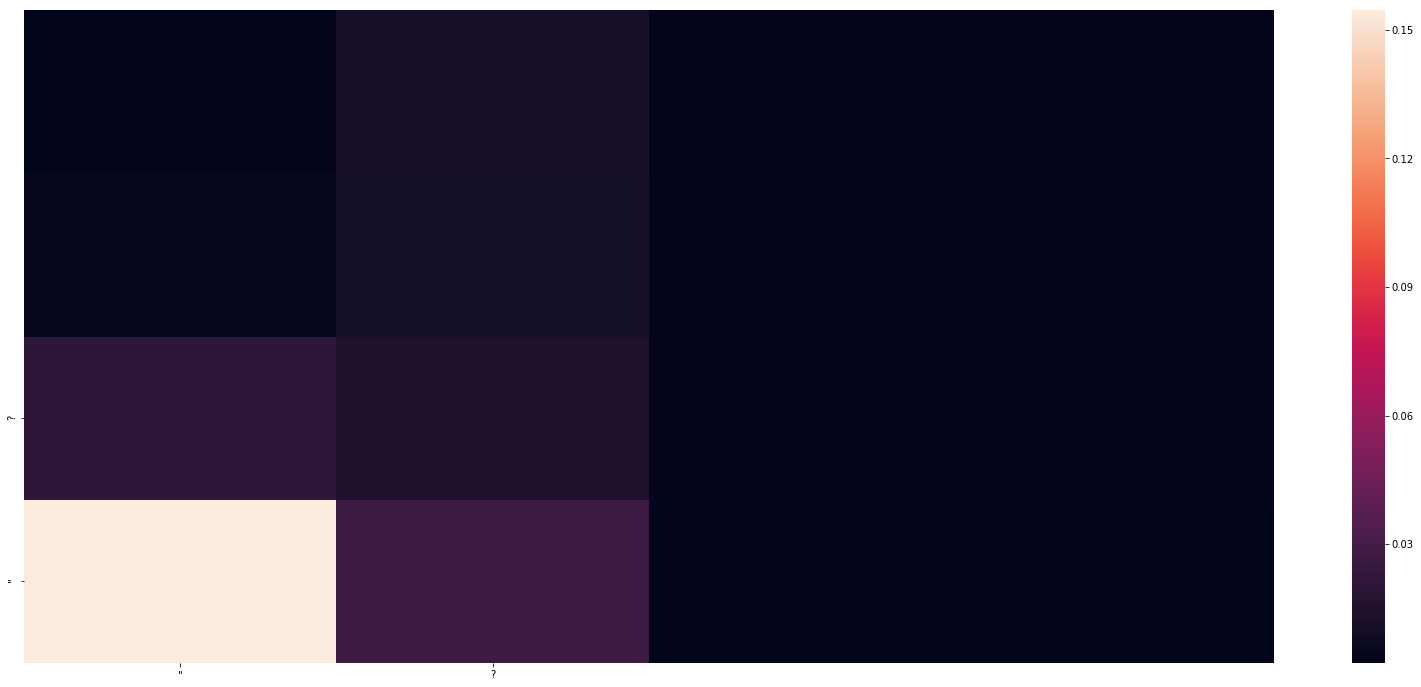

-
Input sentence: "?
GT sentence: "?"
Decoded sentence: "?


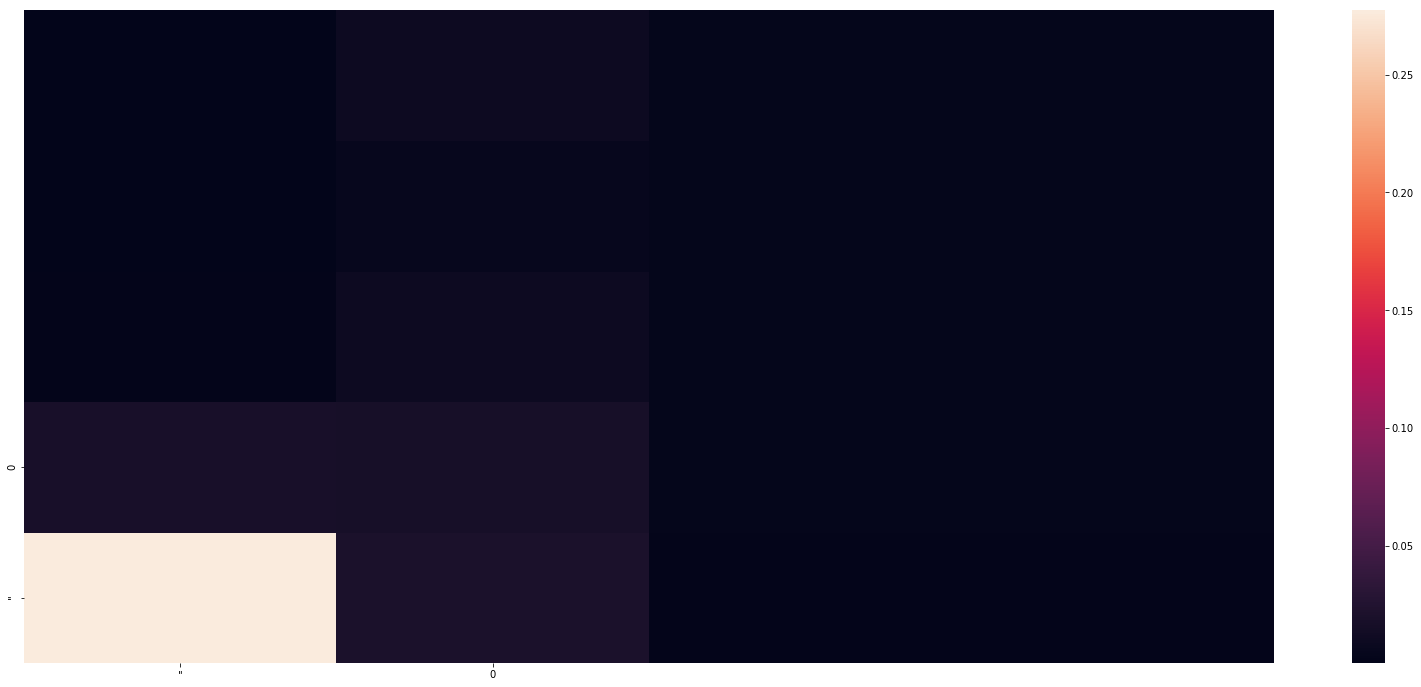

-
Input sentence: "0
GT sentence: "0"
Decoded sentence: "0


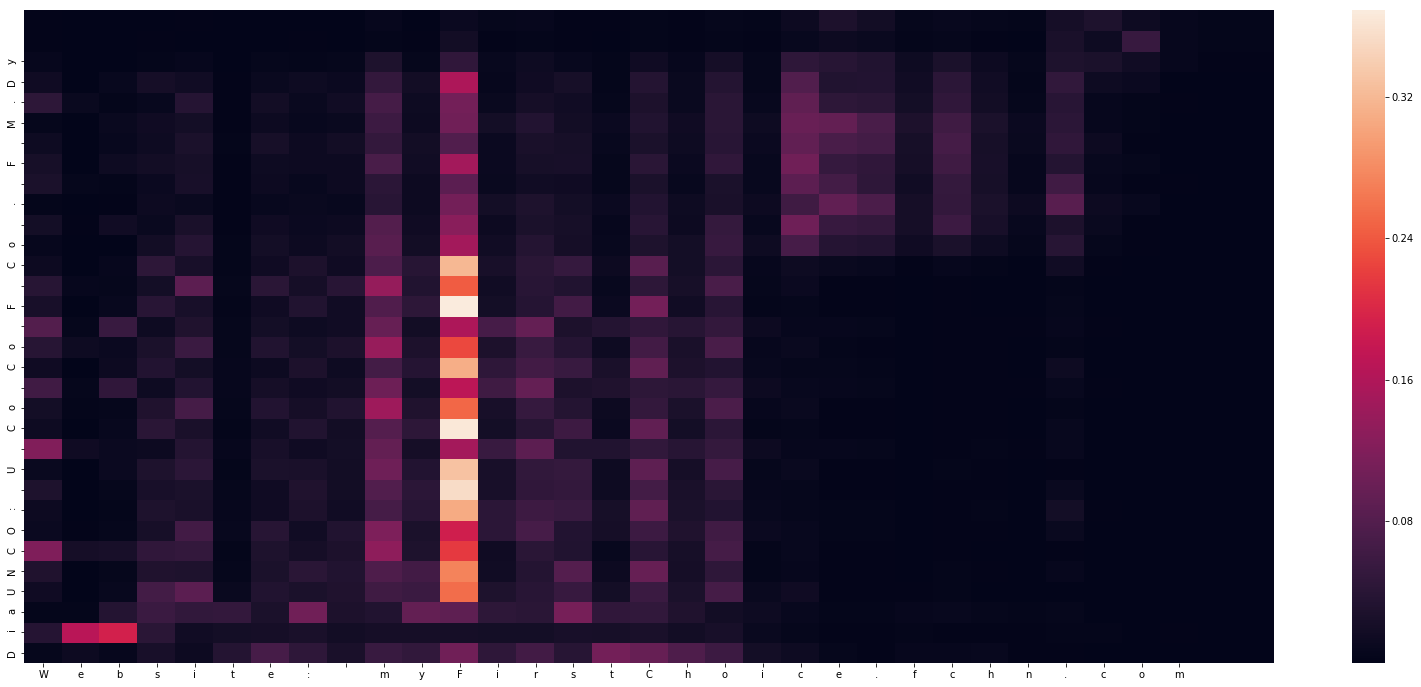

-
Input sentence: Website: myFirstChoice.fchn.com
GT sentence: Website: myFirstChoice.fchn.com

Decoded sentence: DiaUNCO: U Co Co F Co . F M.Dy


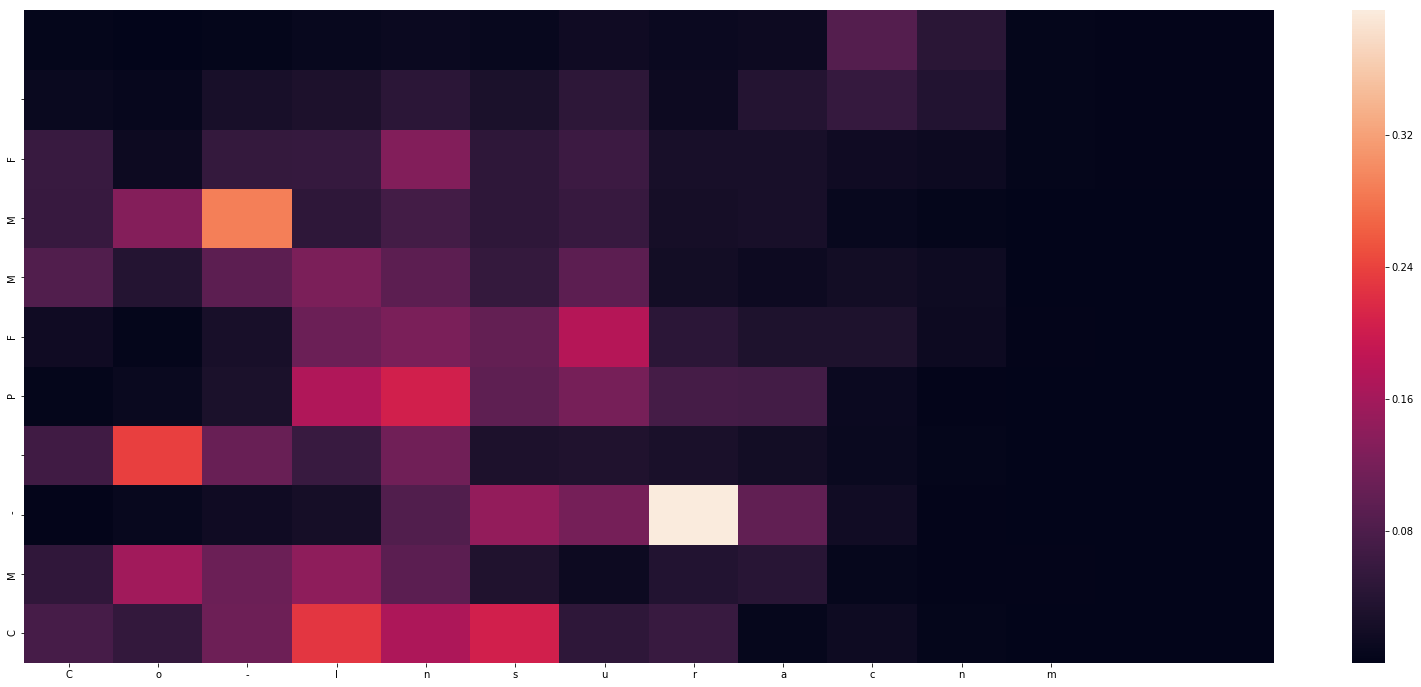

-
Input sentence: Co-Insuracnm
GT sentence: Co-Insurance

Decoded sentence: CM- PFMMF 


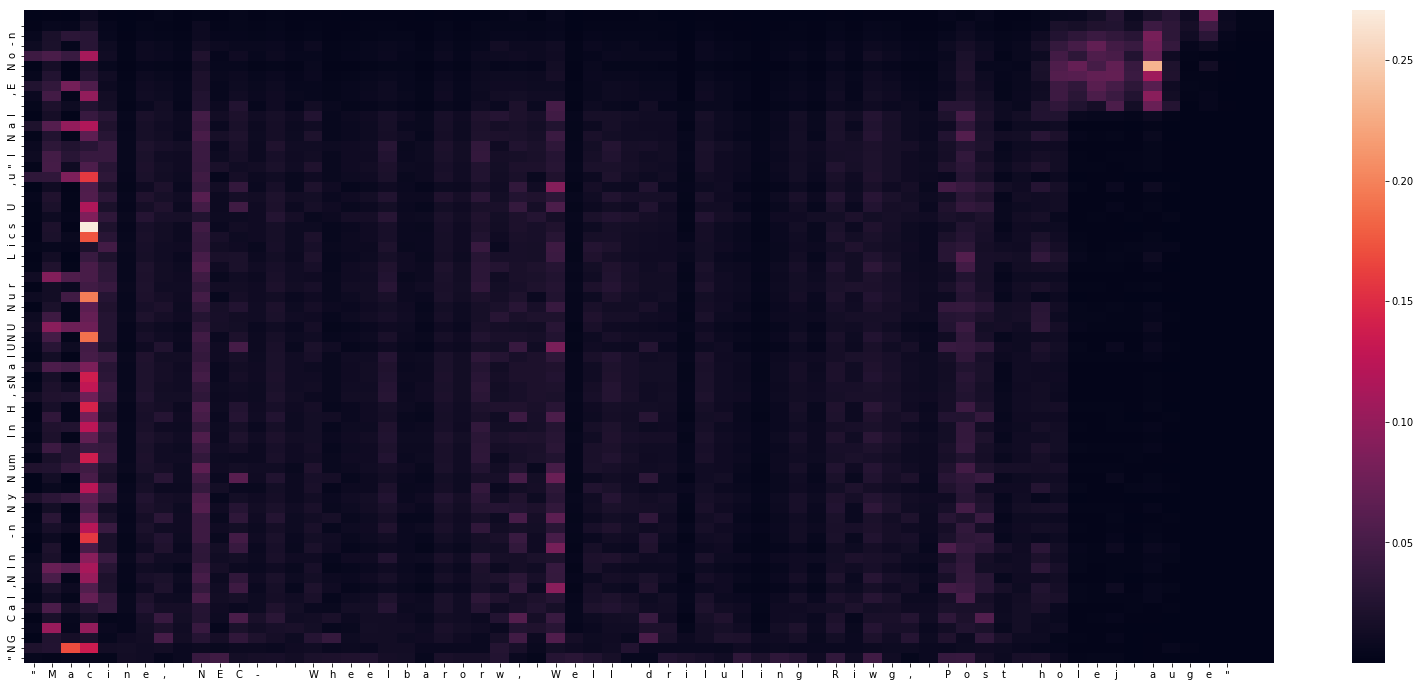

-
Input sentence: "Macine, NEC-  Wheelbarorw, Well driluling Riwg, Post holej auge"
GT sentence: "Machine, NEC - Wheelbarrow, Well drilling Rig, Post hole auger"
Decoded sentence: "NG Cal,NIn -n Ny Num In H,sNalUNU Nur  Lics U ,u"l Nal ,E No-n 


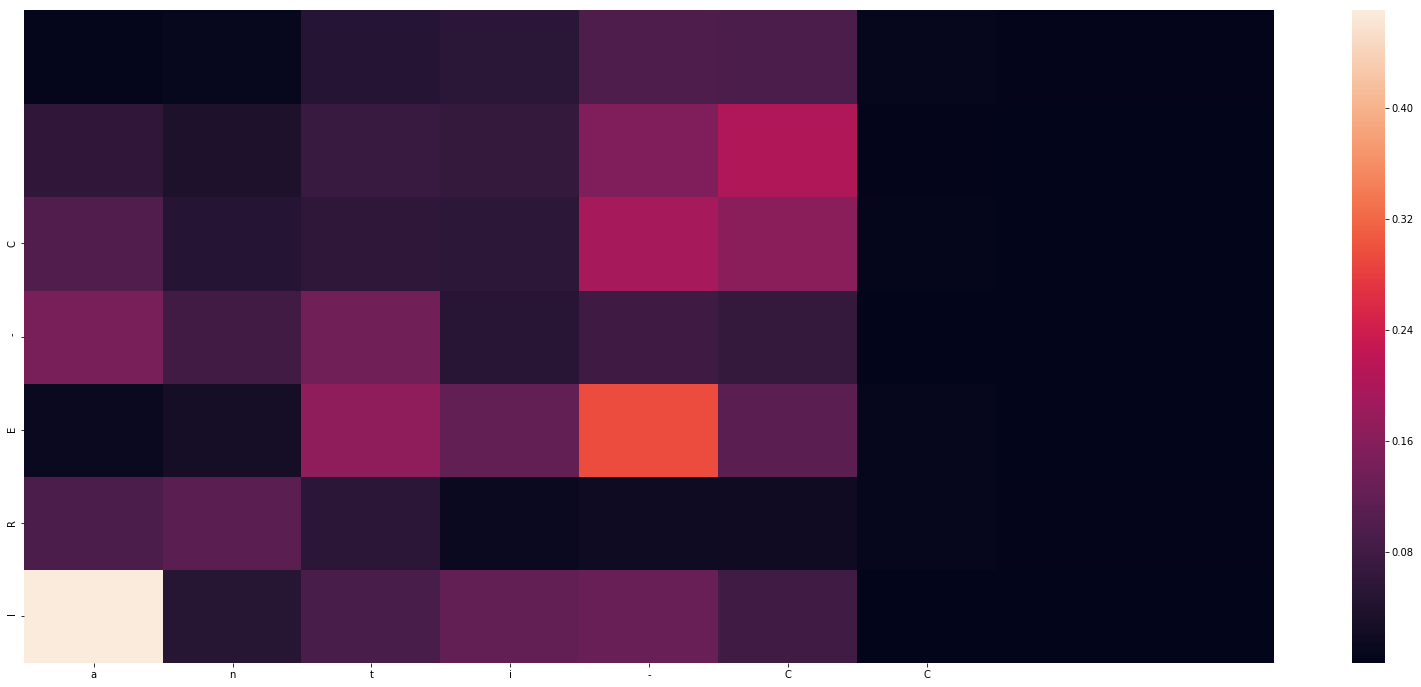

-
Input sentence: anti-CC
GT sentence: anti-CCP
Decoded sentence: IRE-C


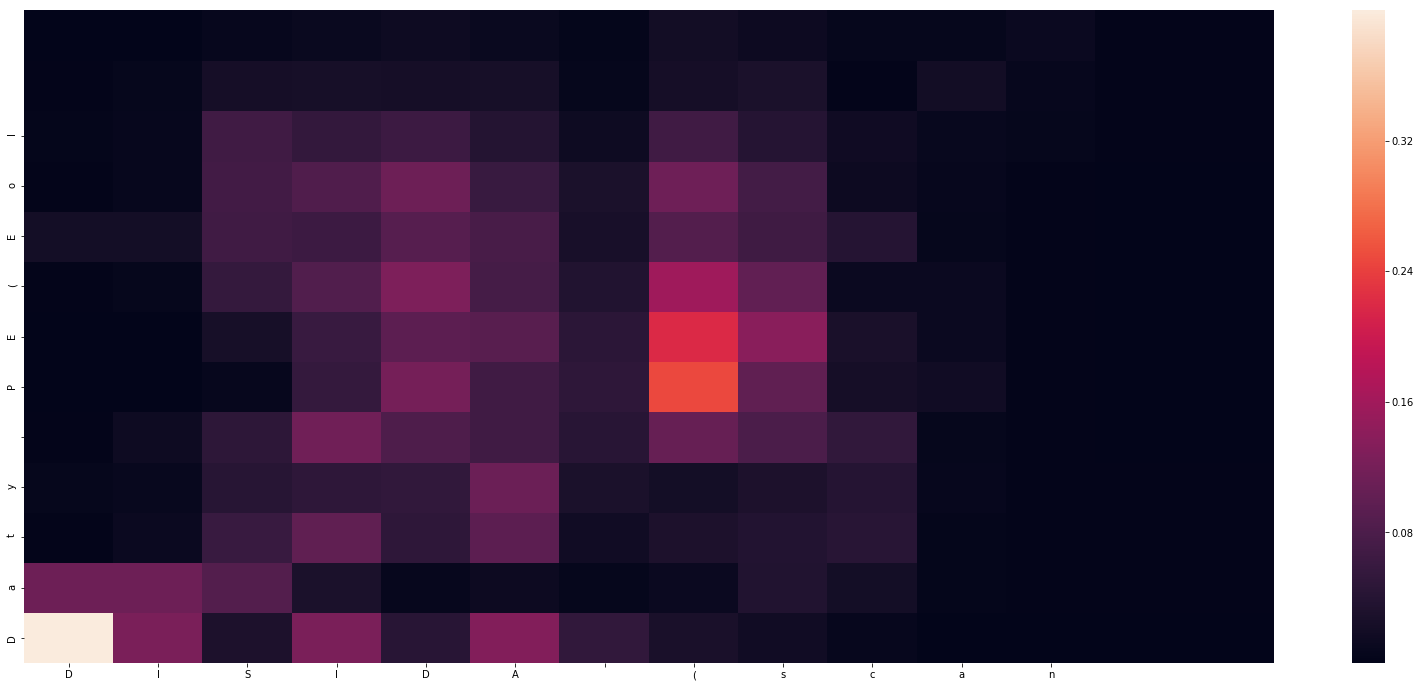

-
Input sentence: DISIDA (scan
GT sentence: DISIDA (scan)
Decoded sentence: Daty PE(Eol


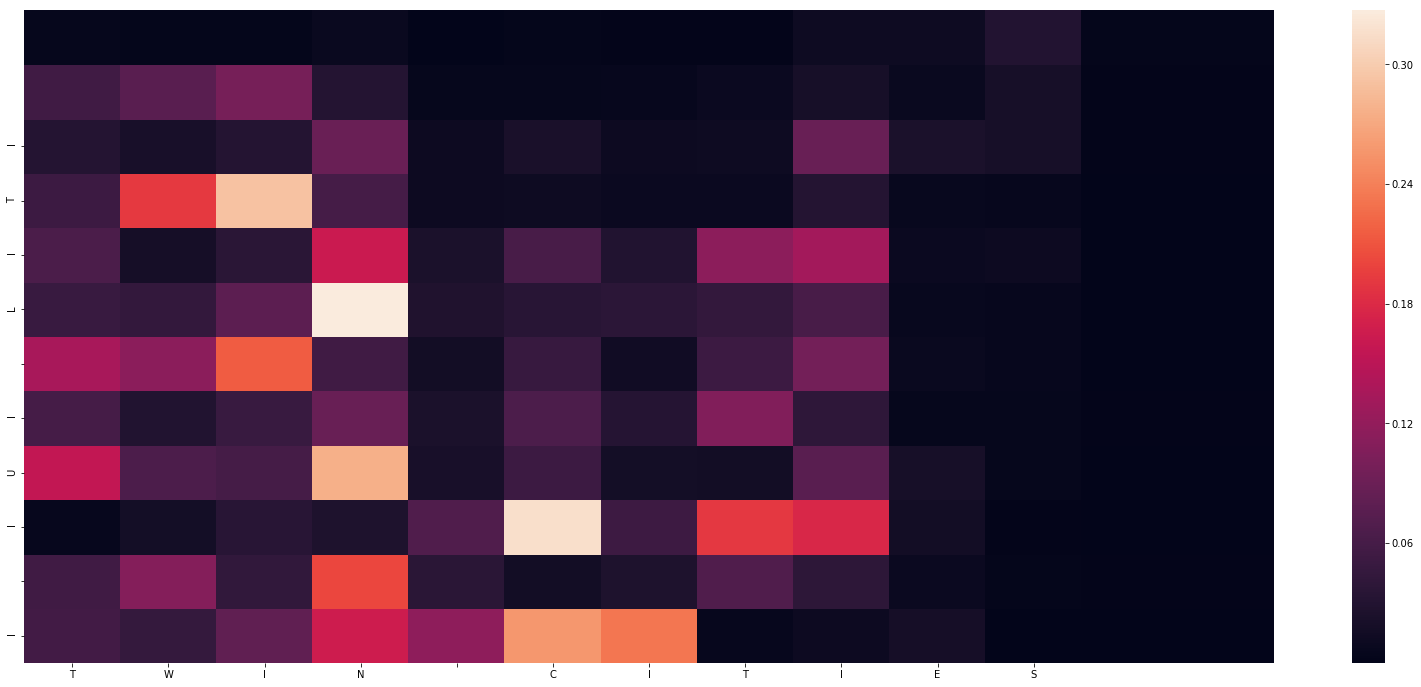

-
Input sentence: TWIN CITIES
GT sentence: TWIN CITIES

Decoded sentence: I IUI LITI


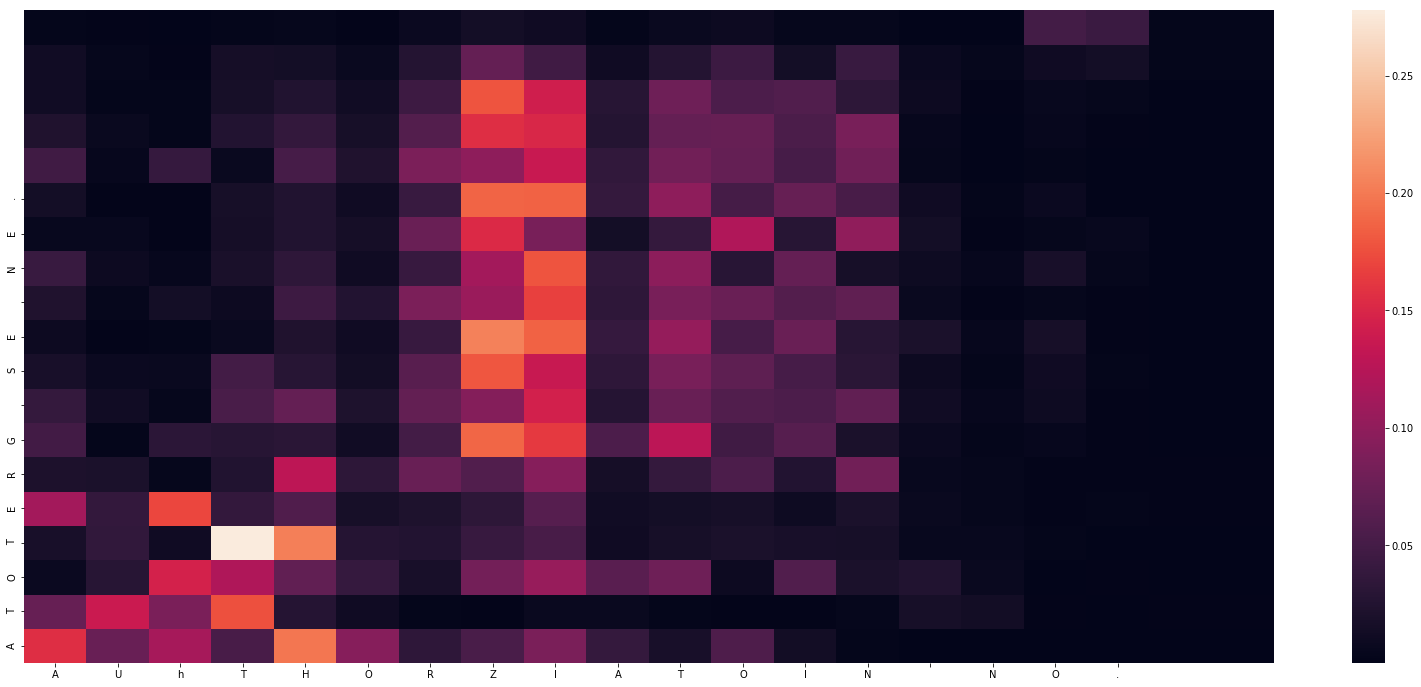

-
Input sentence: AUhTHORZIATOIN NO.
GT sentence: AUTHORIZATION NO.

Decoded sentence: ATOTERG SE NE.


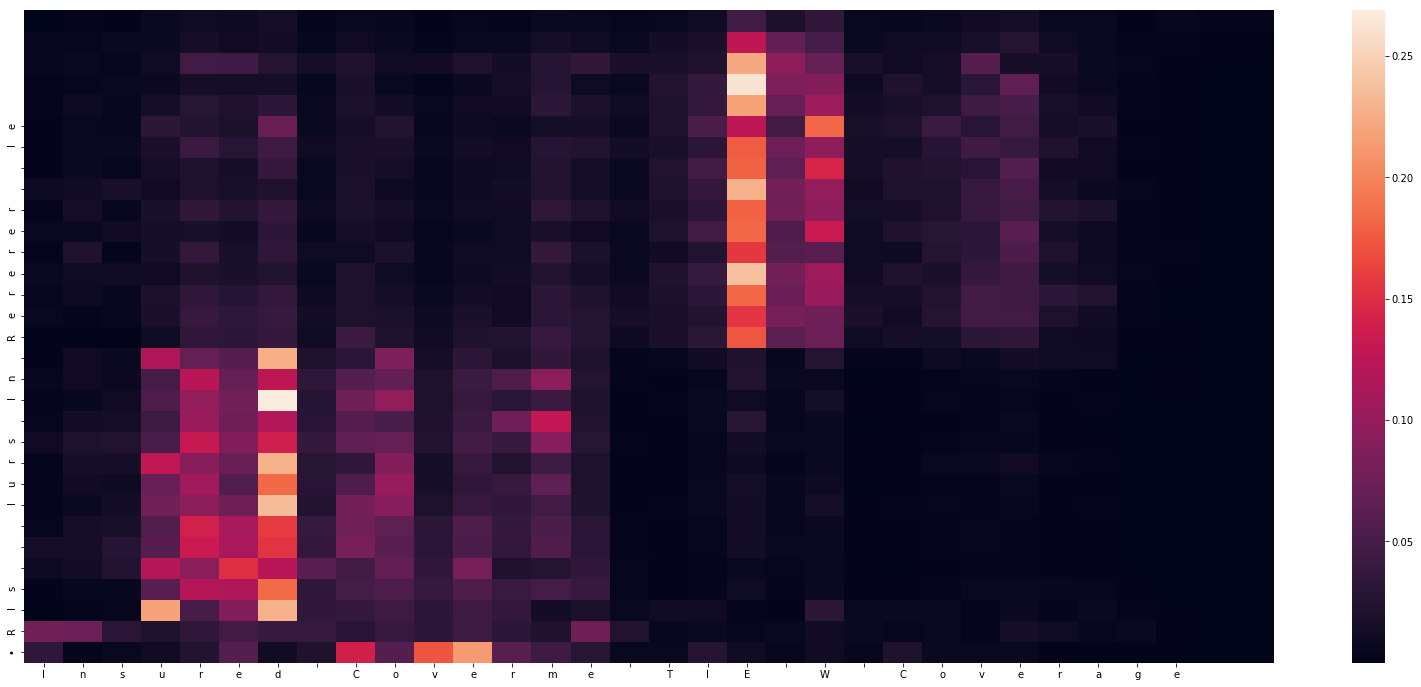

-
Input sentence: Insured Coverme TIE W Coverage
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: •RIs   Iurs In Rererer  Ie


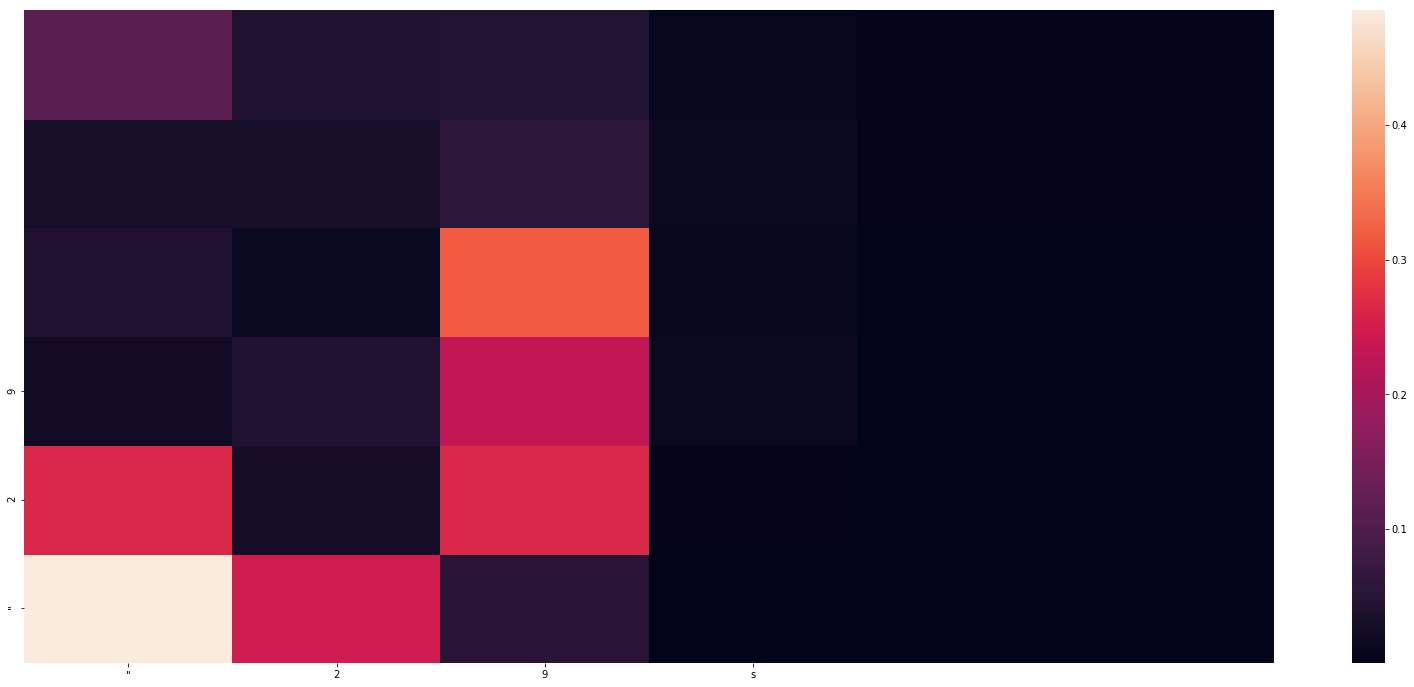

-
Input sentence: "29s
GT sentence: "29"
Decoded sentence: "29


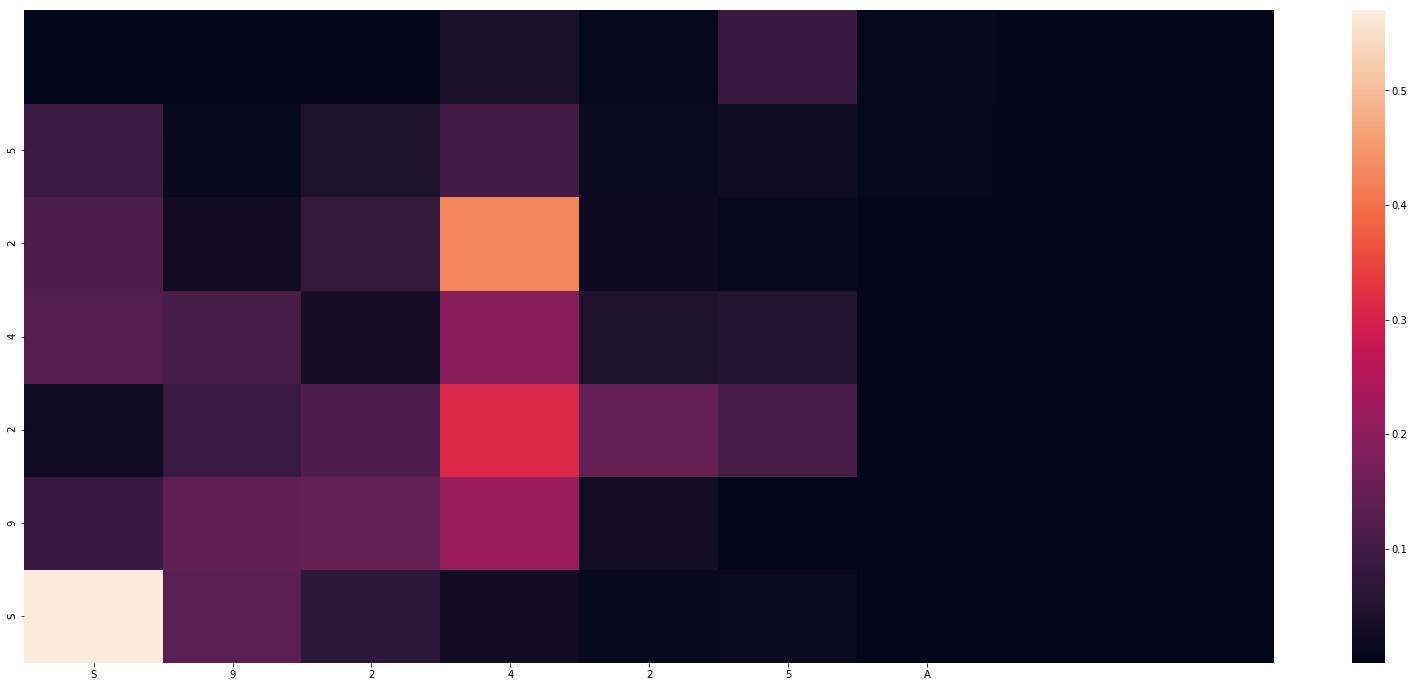

-
Input sentence: S92425A
GT sentence: S92425A

Decoded sentence: S92425


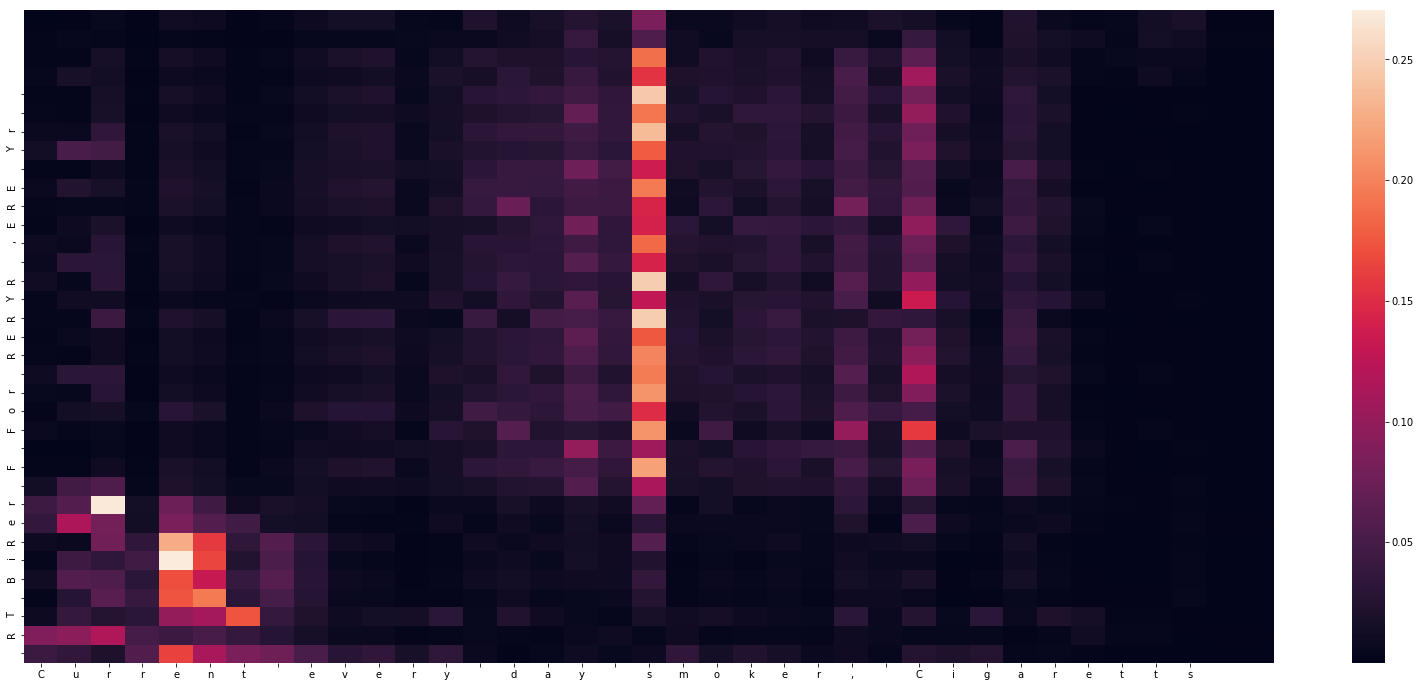

-
Input sentence: Current every day smoker, Cigaretts
GT sentence: Current every day smoker, Cigarettes

Decoded sentence: •RT BiRer F For RERYR ,ERE Yr  


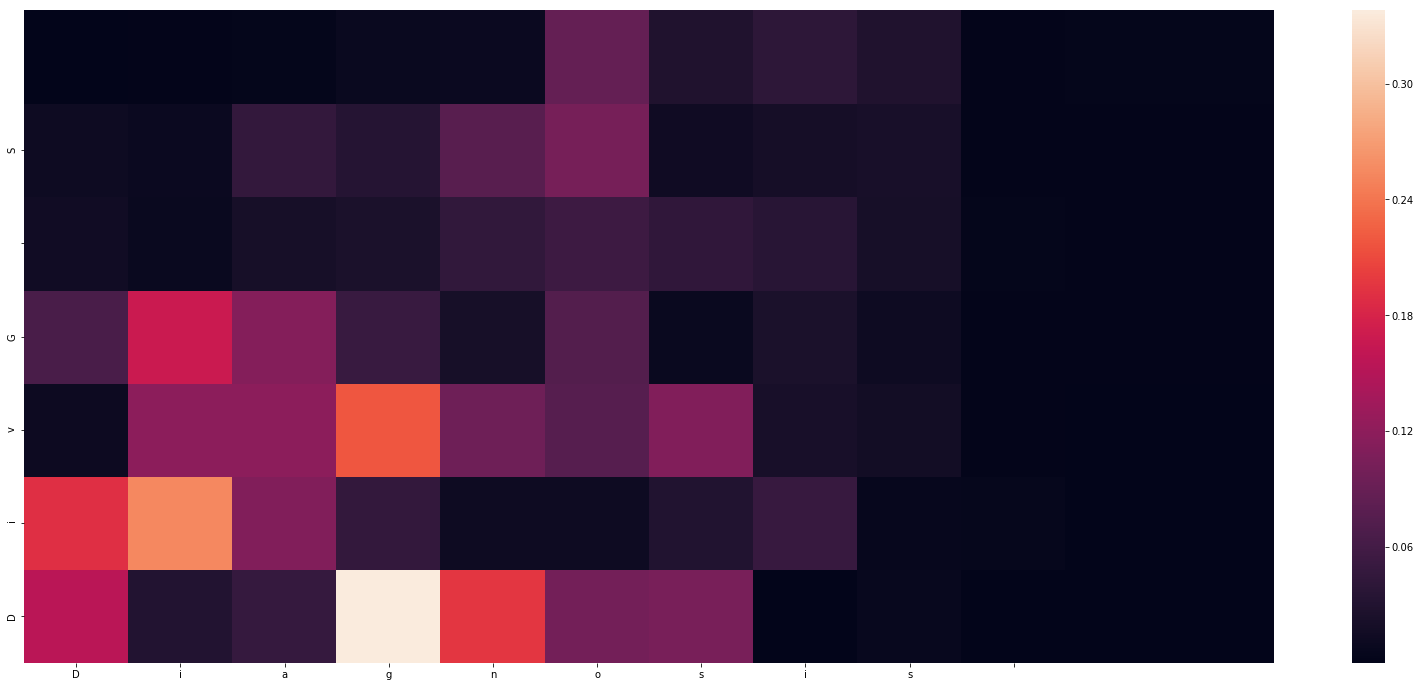

-
Input sentence: Diagnosis 
GT sentence: Diagnosis

Decoded sentence: DivG S


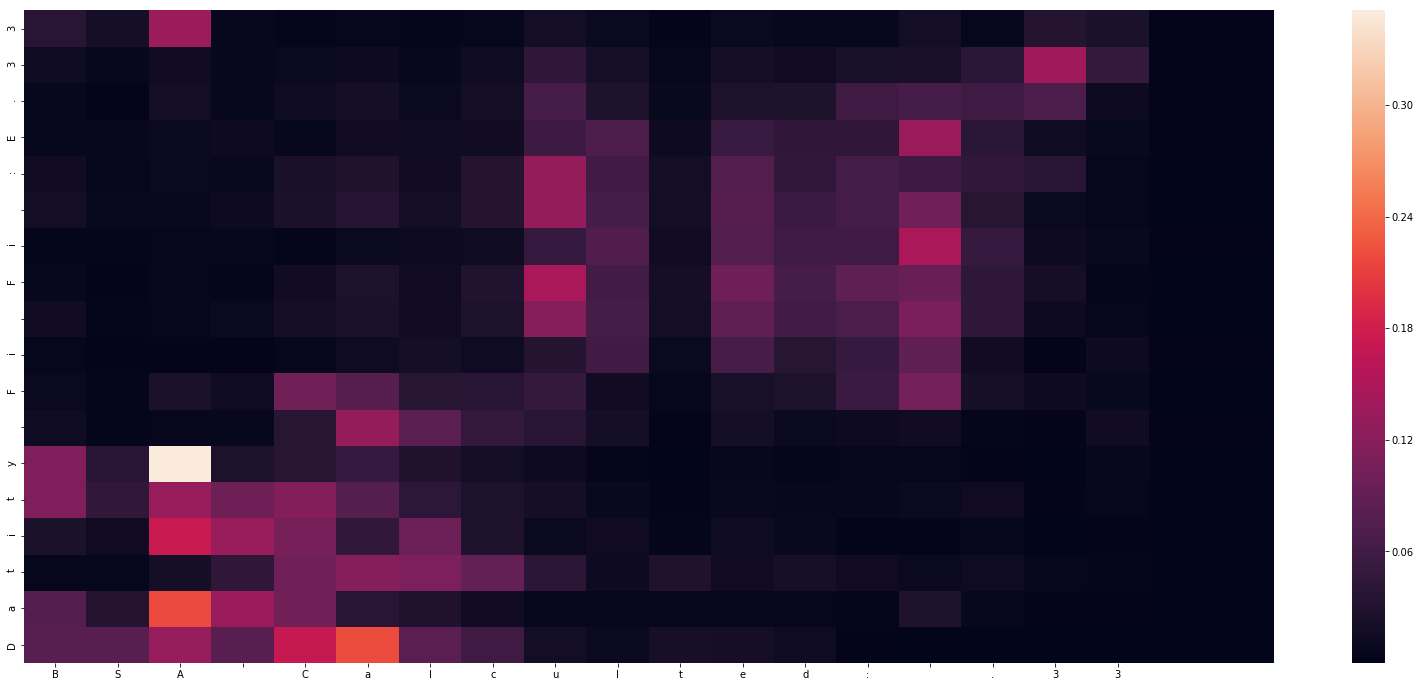

-
Input sentence: BSA Calculted: .33
GT sentence: BSA Calculated: 2.33

Decoded sentence: Datity Fi Fi :E.33


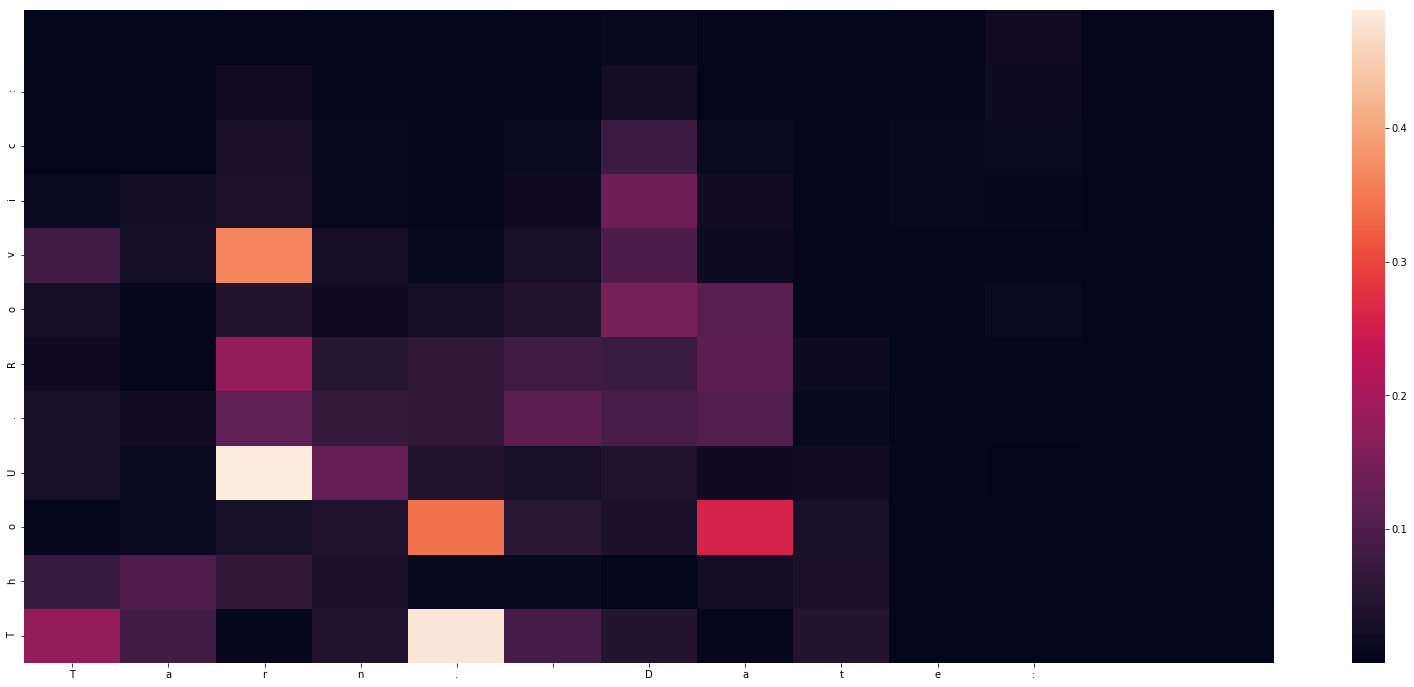

-
Input sentence: Tarn. Date:
GT sentence: Term Date:

Decoded sentence: ThoU.Rovic:


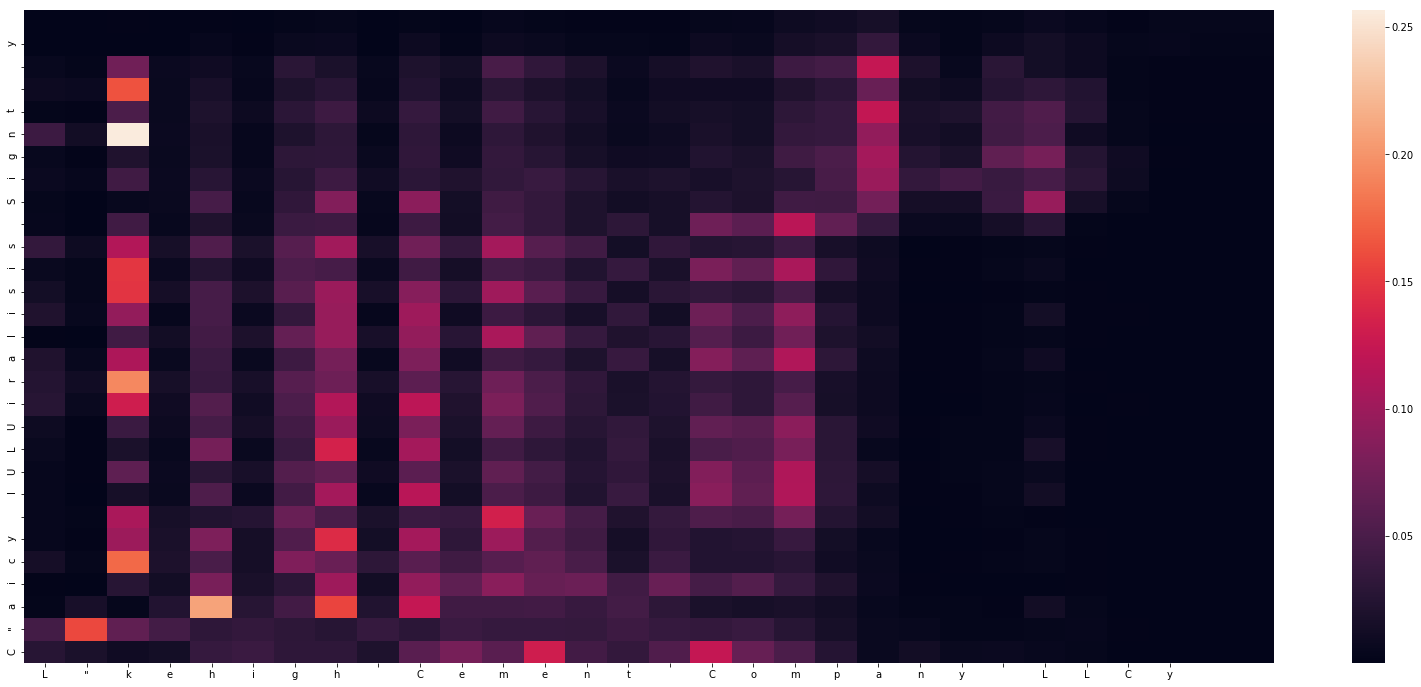

-
Input sentence: L"kehigh Cement Company LLCy
GT sentence: "Lehigh Cement Company LLC"
Decoded sentence: C"aicy IULUiralisis Signt  y


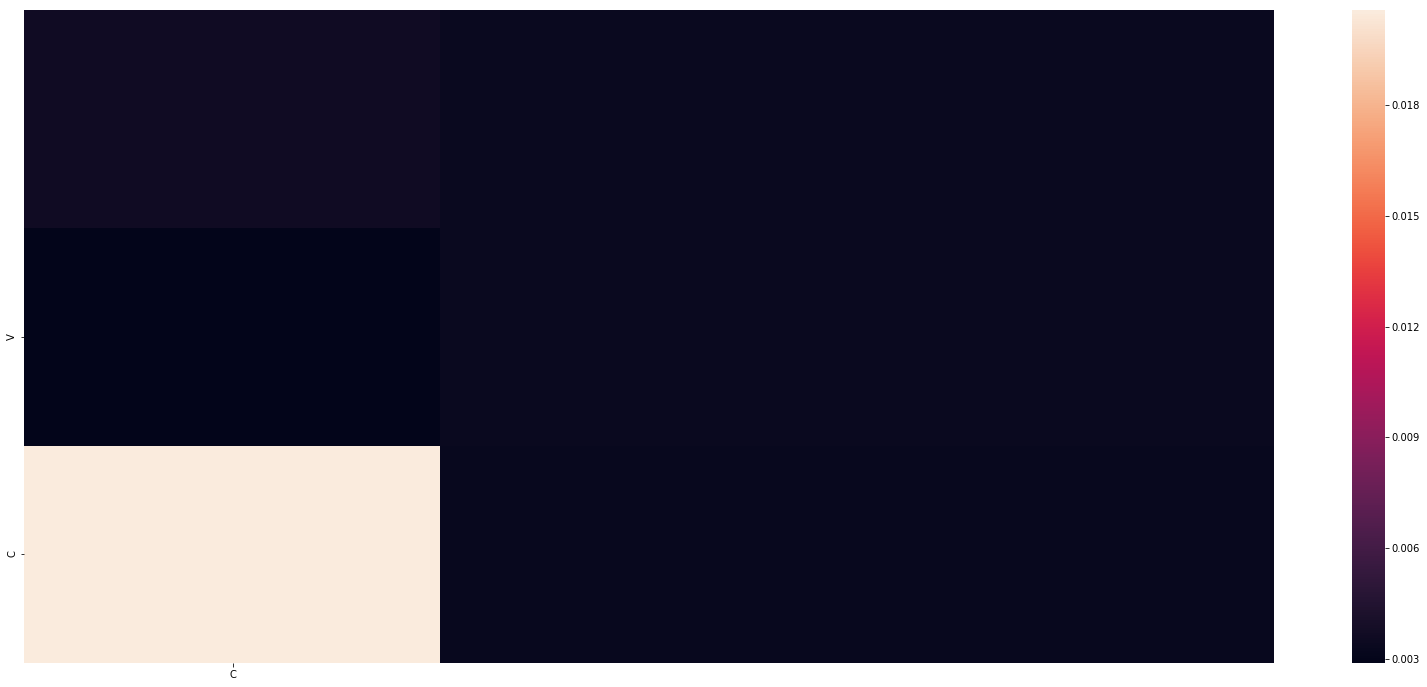

-
Input sentence: C
GT sentence: CA
Decoded sentence: CV


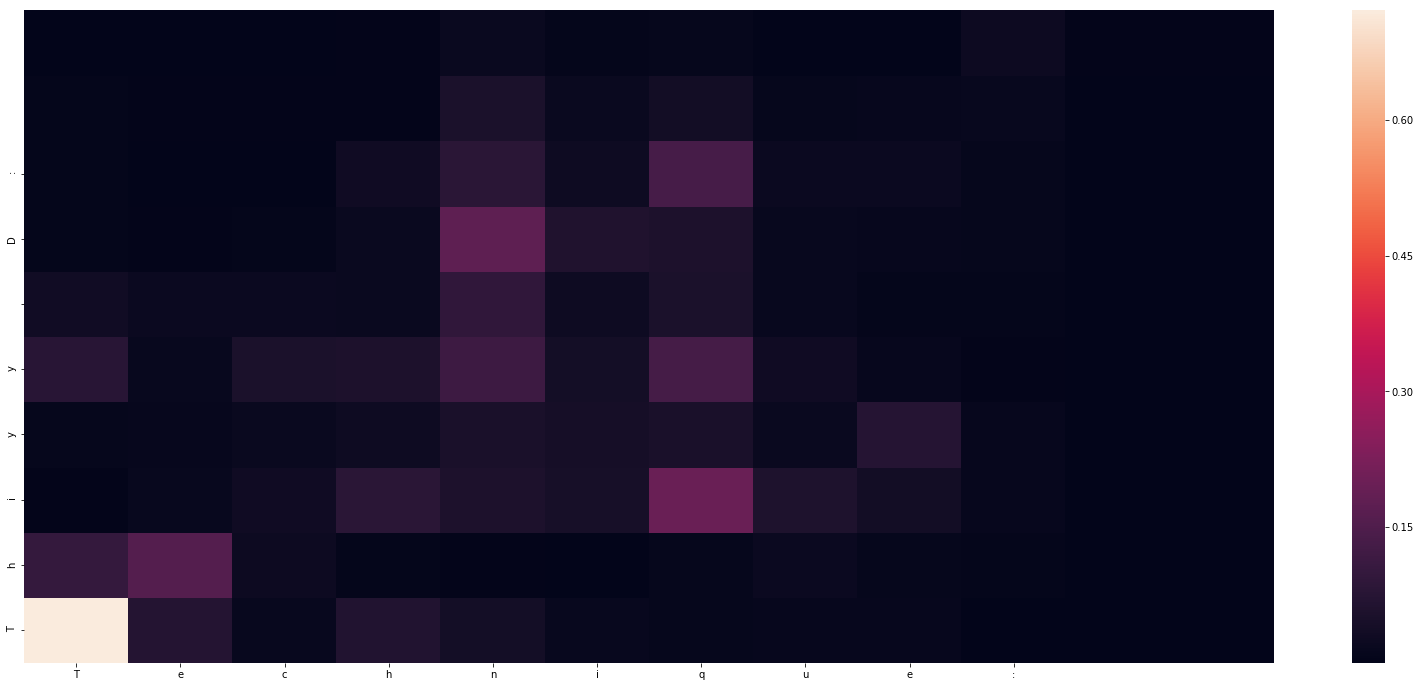

-
Input sentence: Technique:
GT sentence: Technique:

Decoded sentence: Thiyy D:


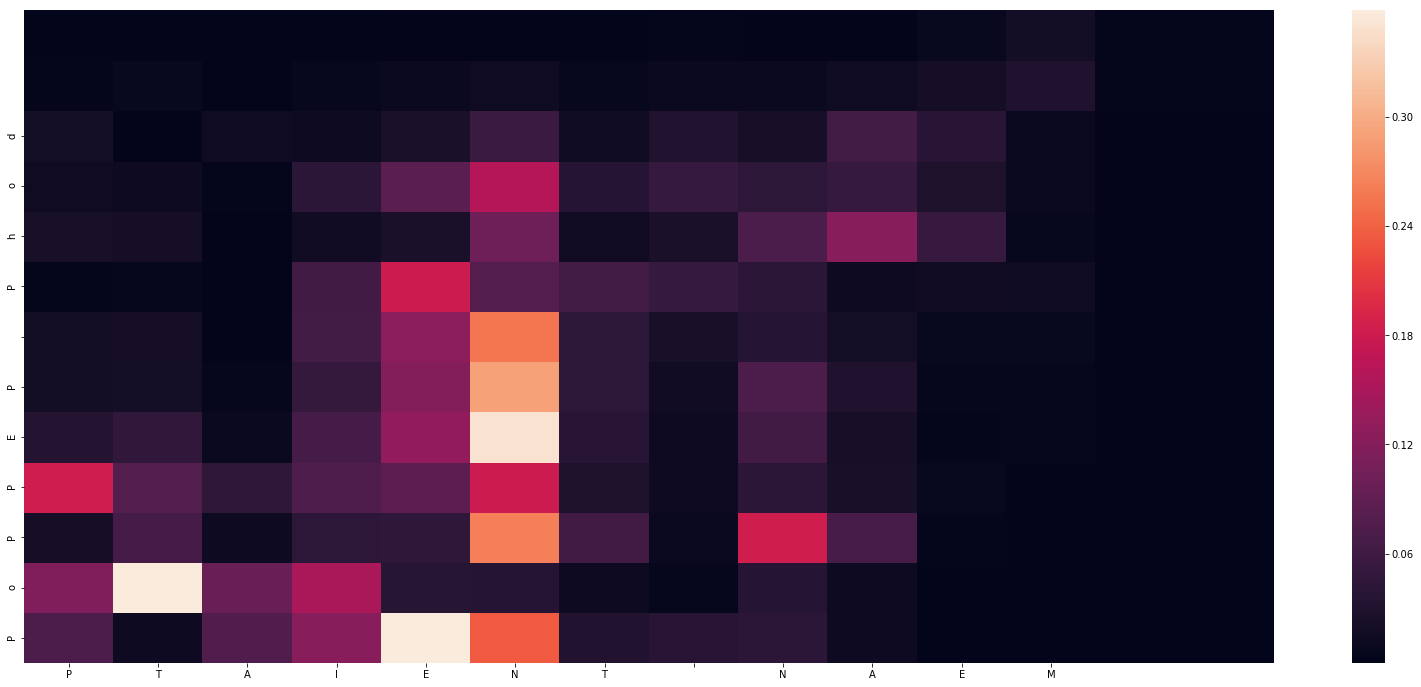

-
Input sentence: PTAIENT NAEM
GT sentence: PATIENT NAME

Decoded sentence: PoPPEP Phod


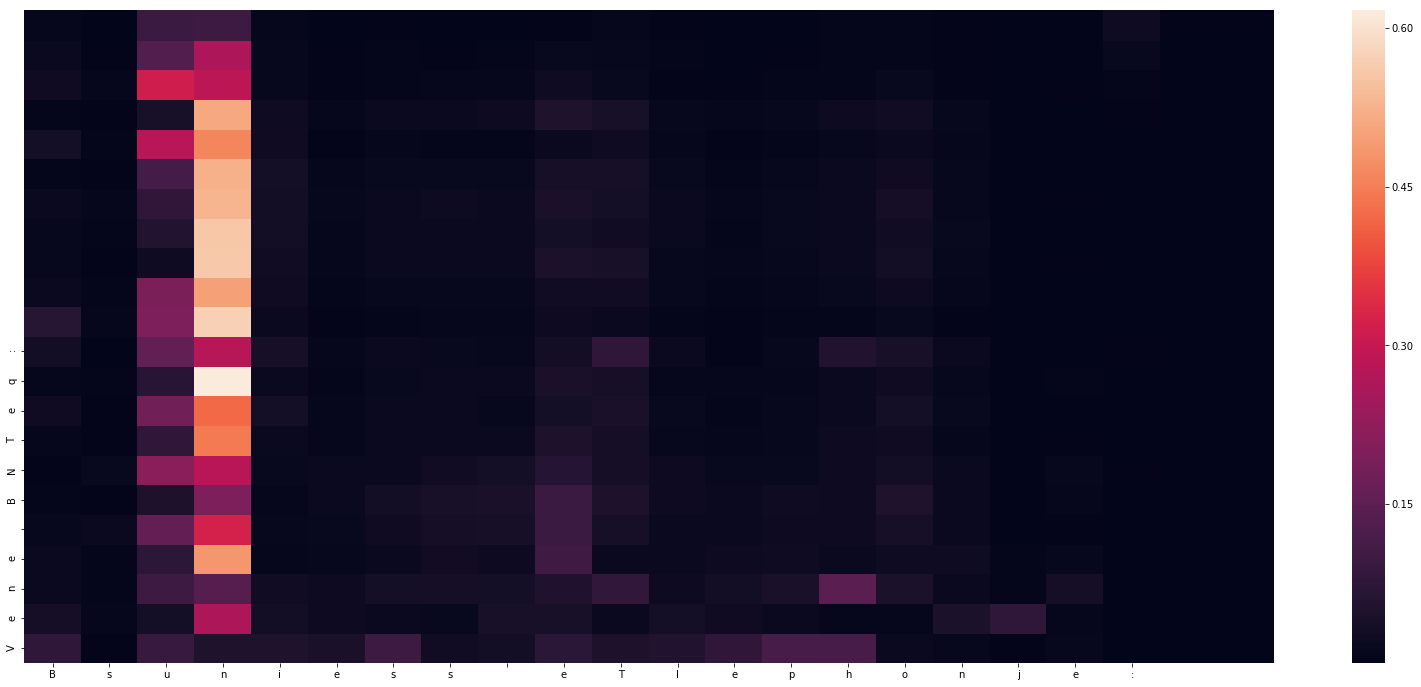

-
Input sentence: Bsuniess eTlephonje:
GT sentence: Business Telephone:

Decoded sentence: Vene BNTeq:


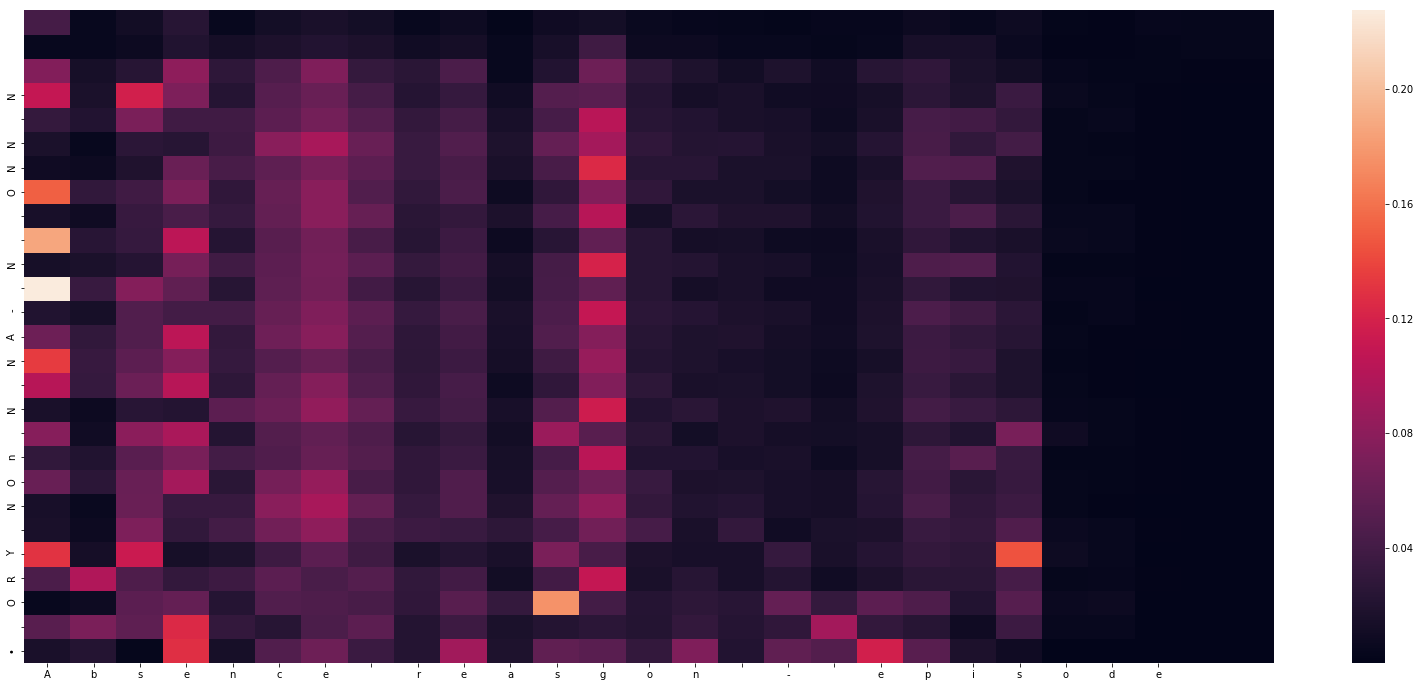

-
Input sentence: Absence reasgon - episode
GT sentence: Absence reason - episode

Decoded sentence: • ORY NOn N NA- N  ONN N


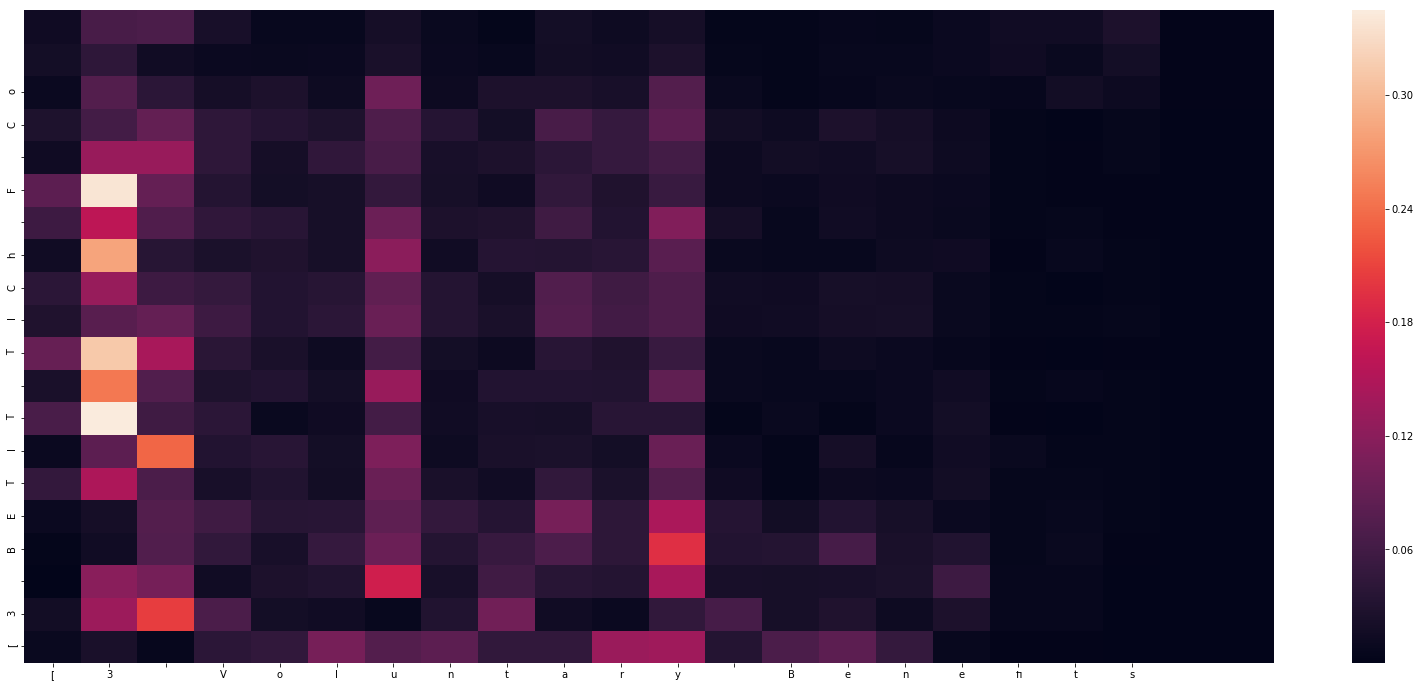

-
Input sentence: [3 Voluntary Beneﬁts
GT sentence: Voluntary Benefits

Decoded sentence: [3 BETIT TICh F Co


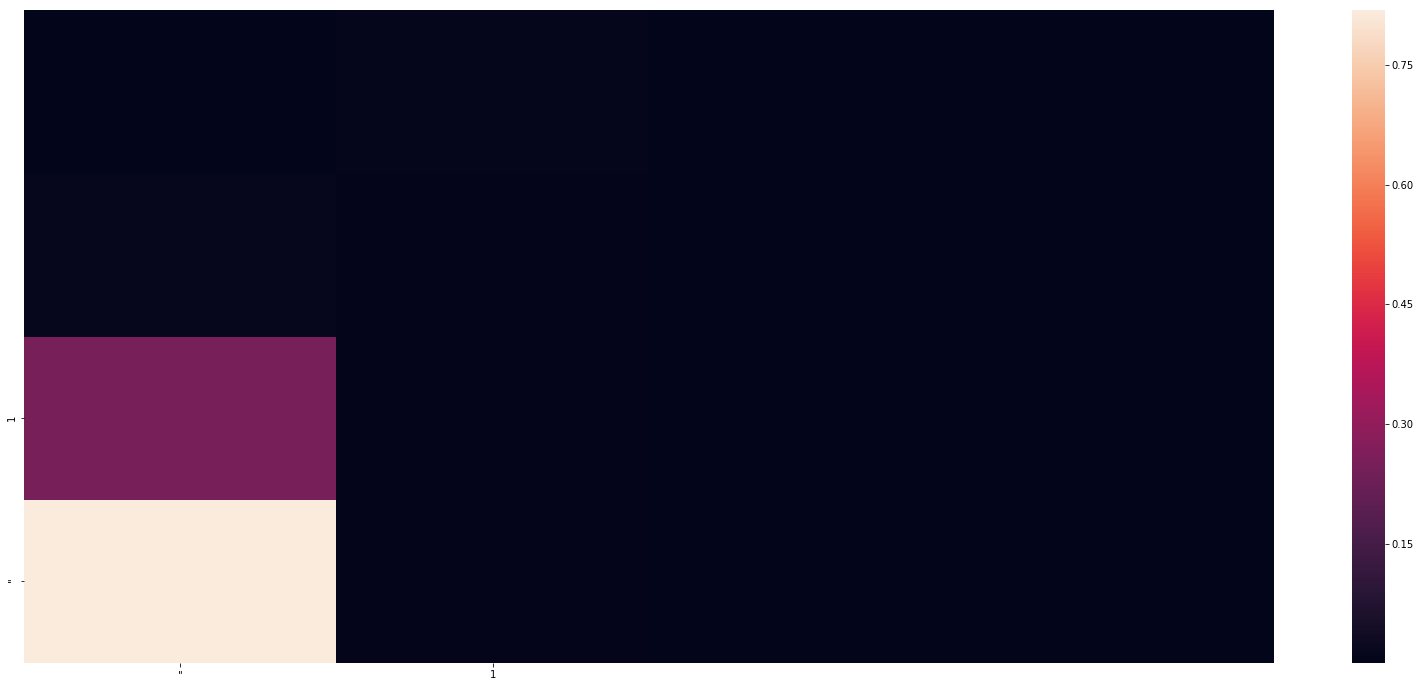

-
Input sentence: "1
GT sentence: "1"
Decoded sentence: "1


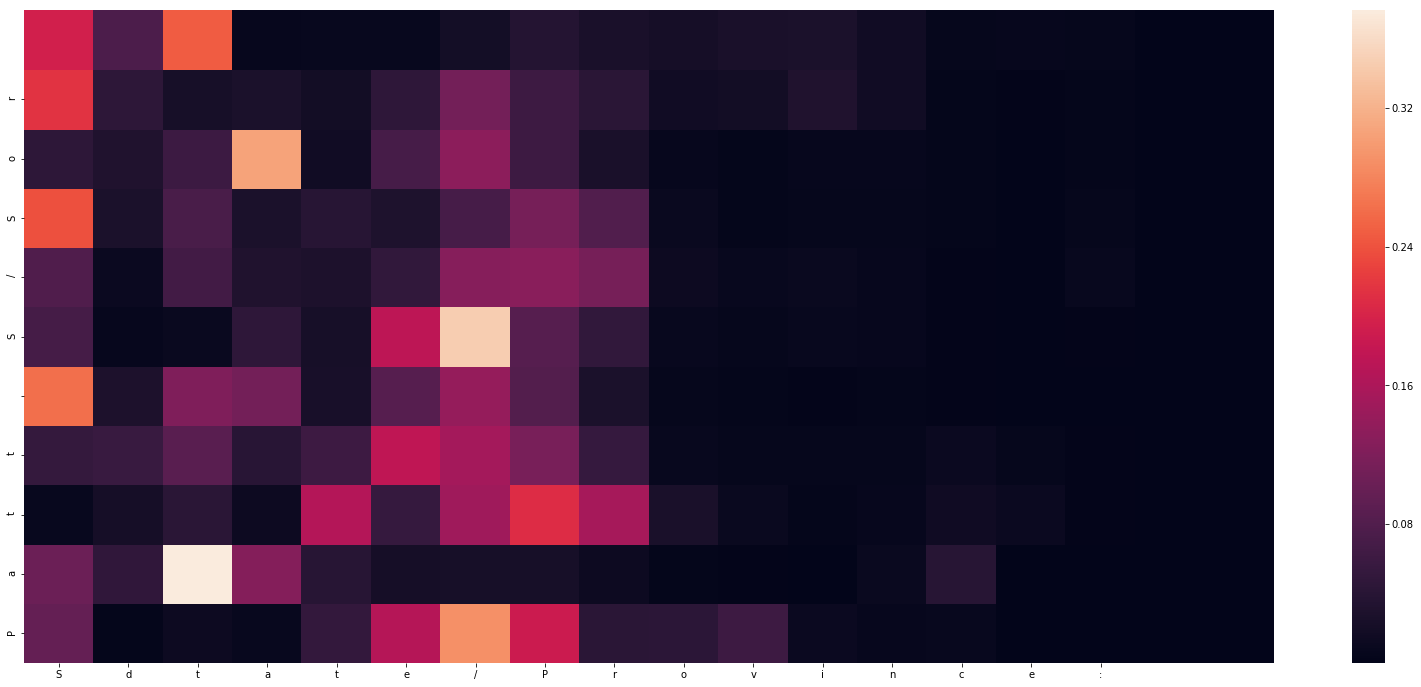

-
Input sentence: Sdtate/Province:
GT sentence: State/Province:

Decoded sentence: Patt S/Sor


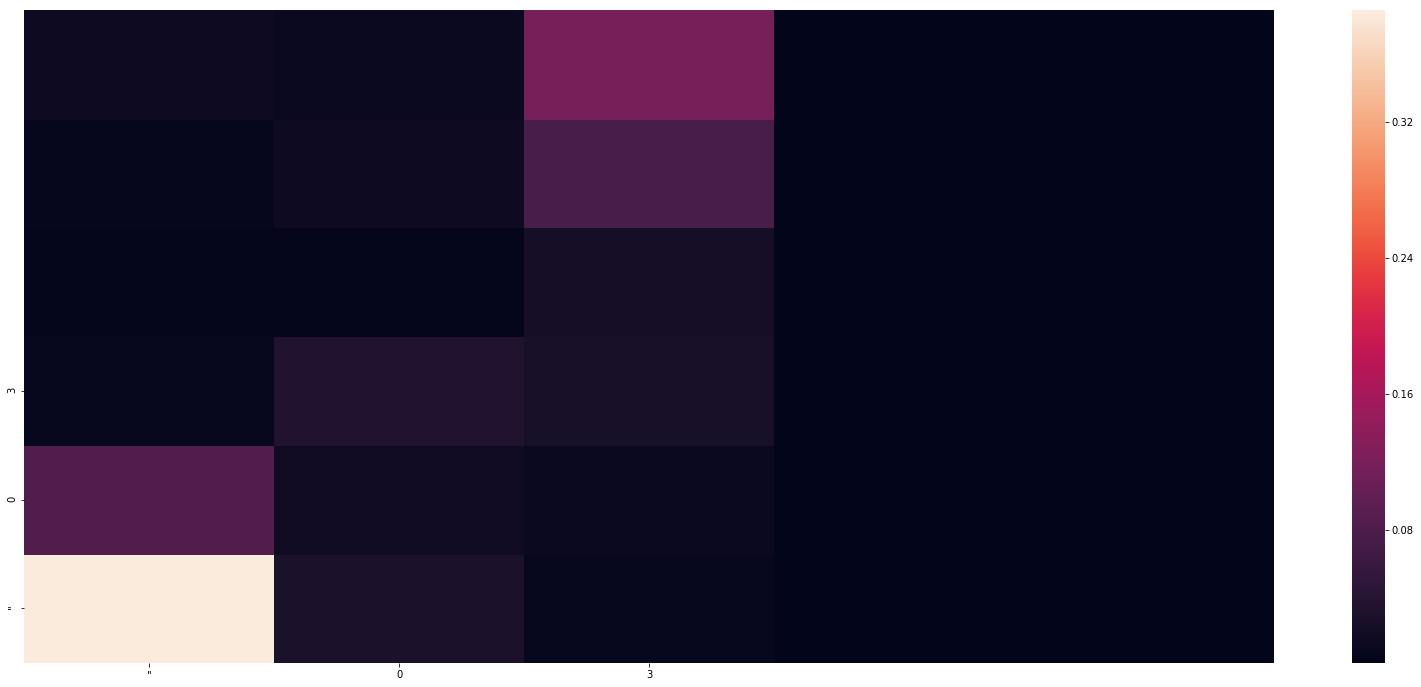

-
Input sentence: "03
GT sentence: "039"
Decoded sentence: "03


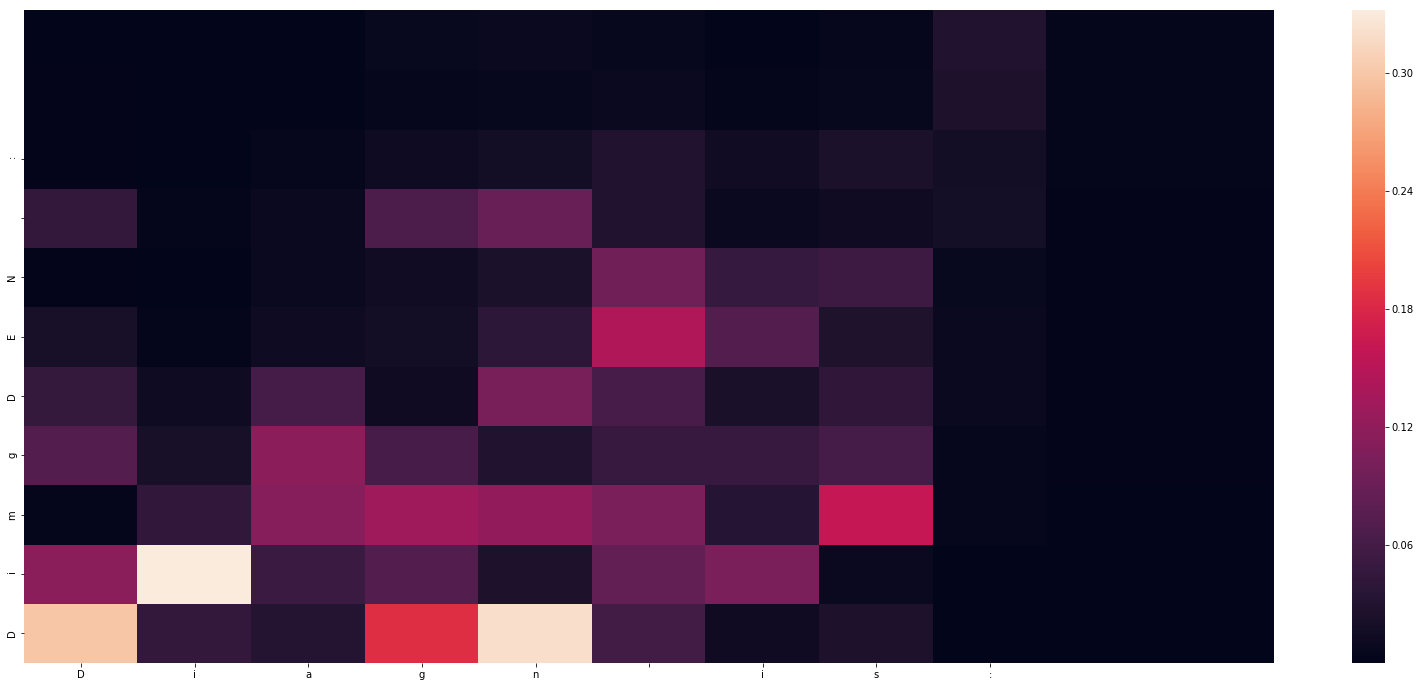

-
Input sentence: Diagn is:
GT sentence: Diagnosis:

Decoded sentence: DimgDEN :


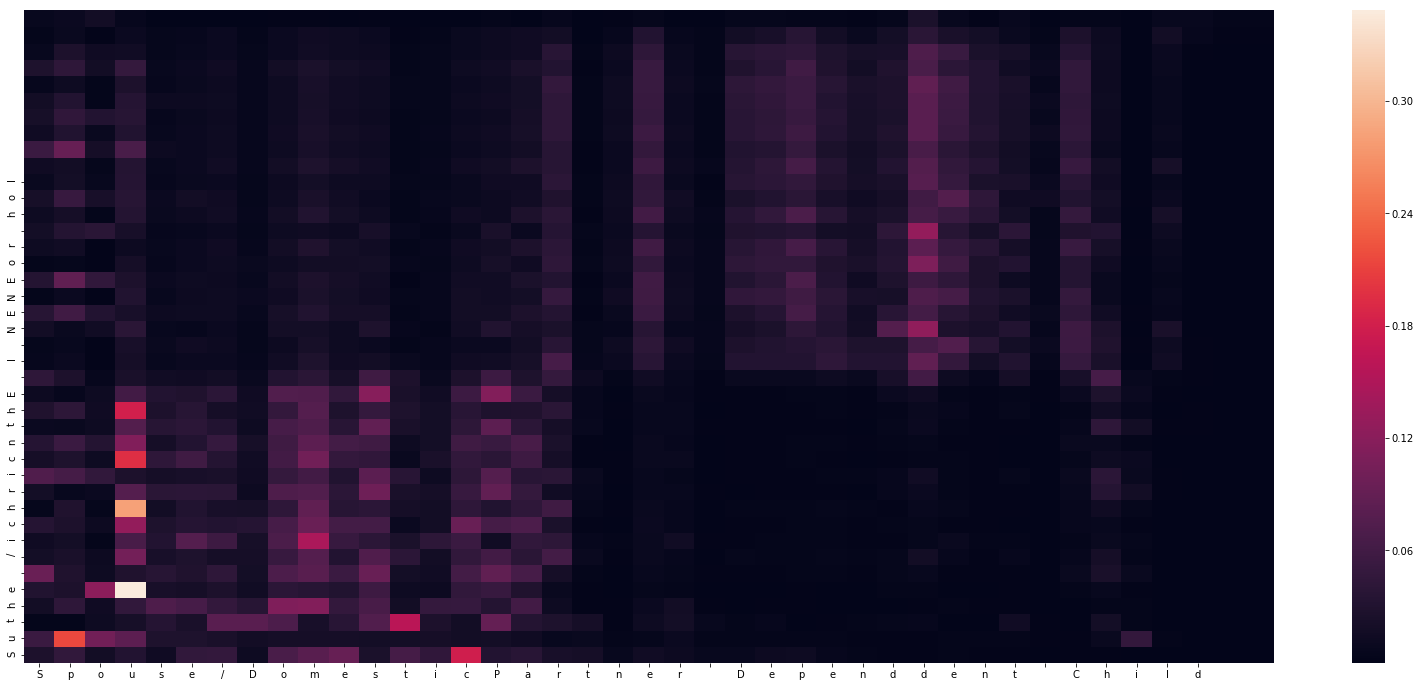

-
Input sentence: Spouse/DomesticPartner Dependdent Child
GT sentence: Spouse/Domestic Partner Dependent Child

Decoded sentence: Suthe /ichricnthE I NENEor hol


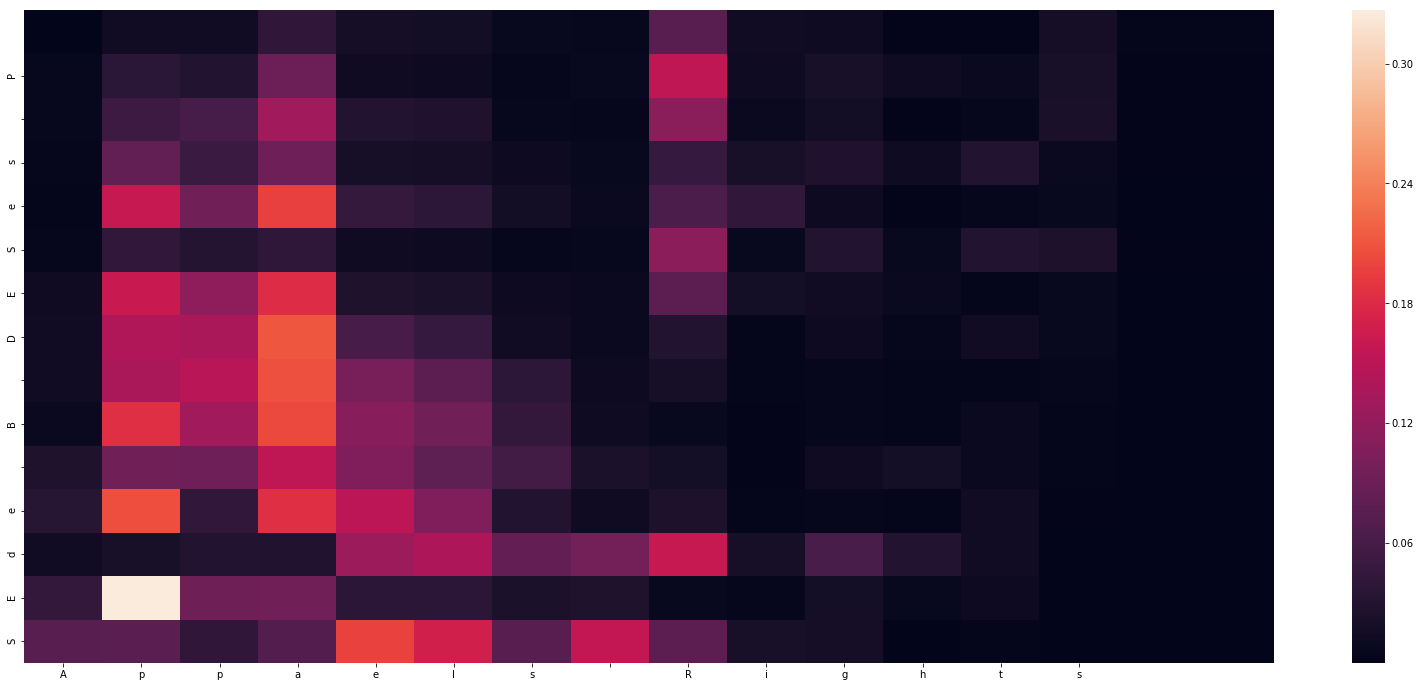

-
Input sentence: Appaels Rights
GT sentence: Appeals Rights

Decoded sentence: SEde B DESes P


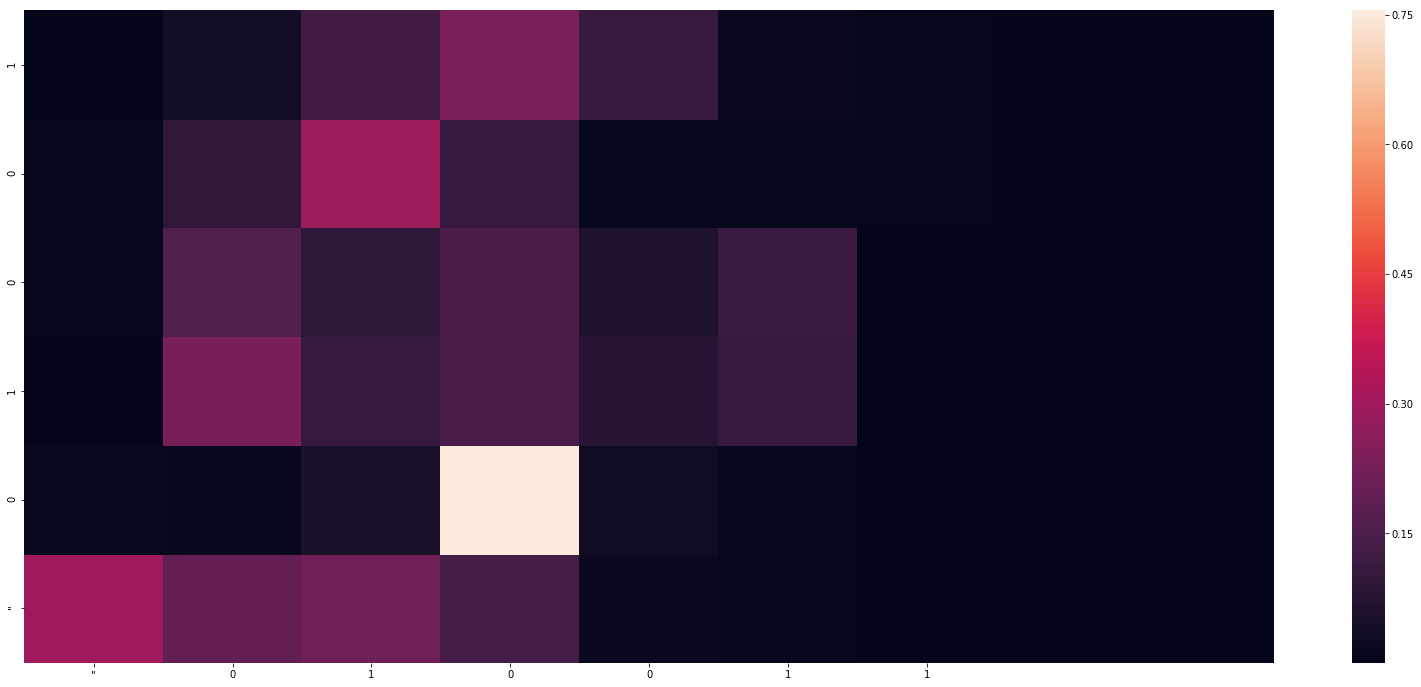

-
Input sentence: "010011
GT sentence: "0100011"
Decoded sentence: "01001


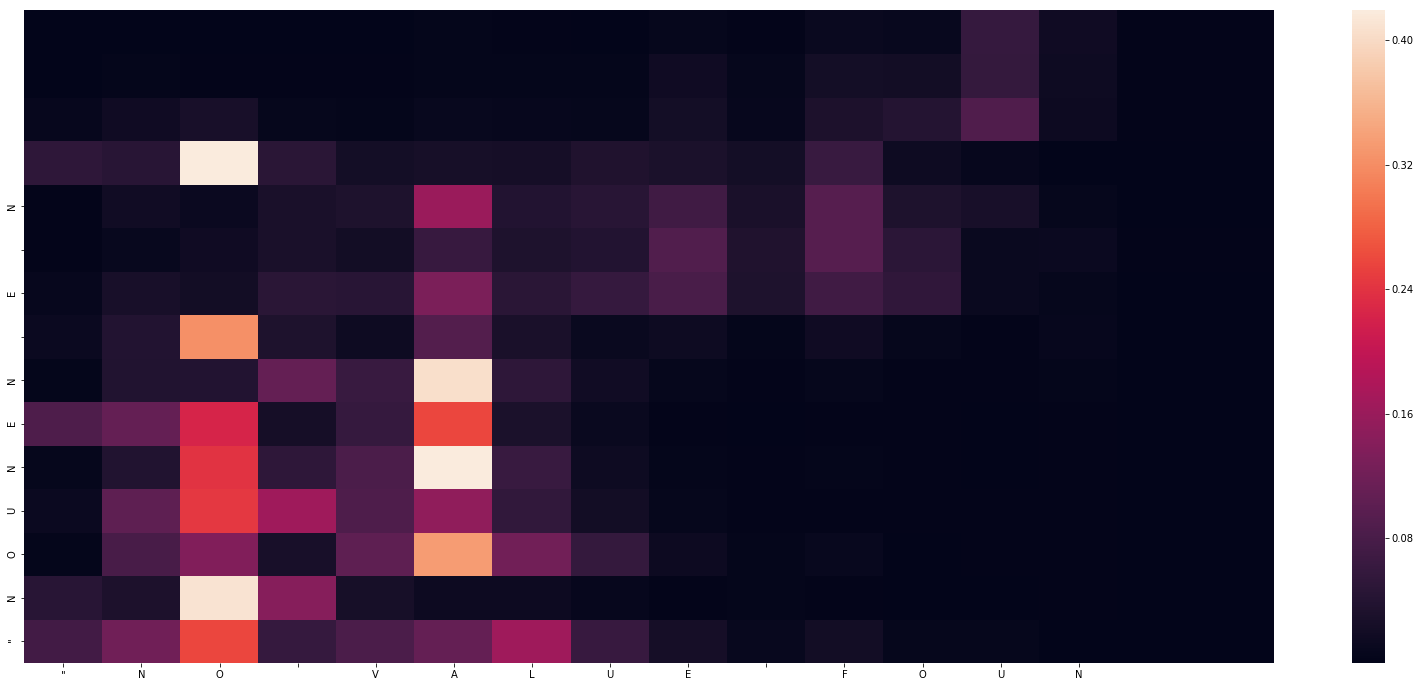

-
Input sentence: "NO VALUE FOUN
GT sentence: "NO VALUE FOUND"
Decoded sentence: "NOUNEN E N


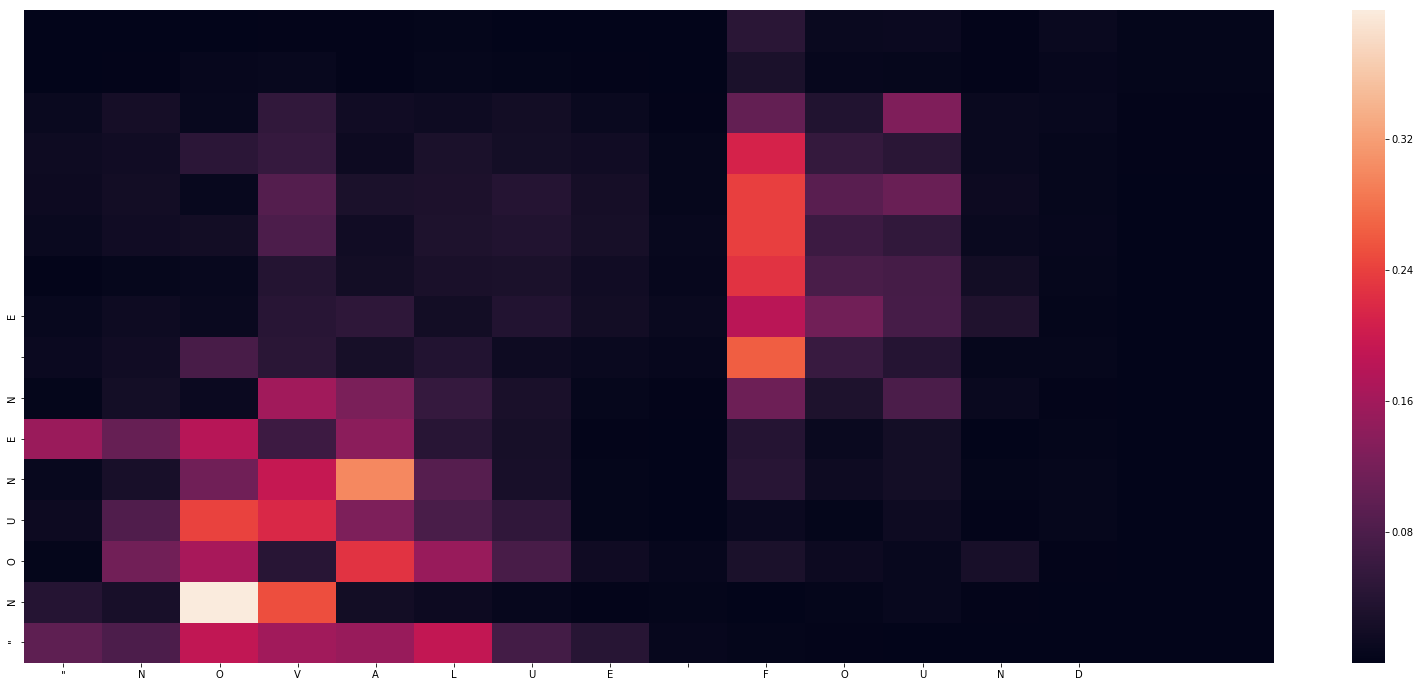

-
Input sentence: "NOVALUE FOUND
GT sentence: "NO VALUE FOUND"
Decoded sentence: "NOUNEN E


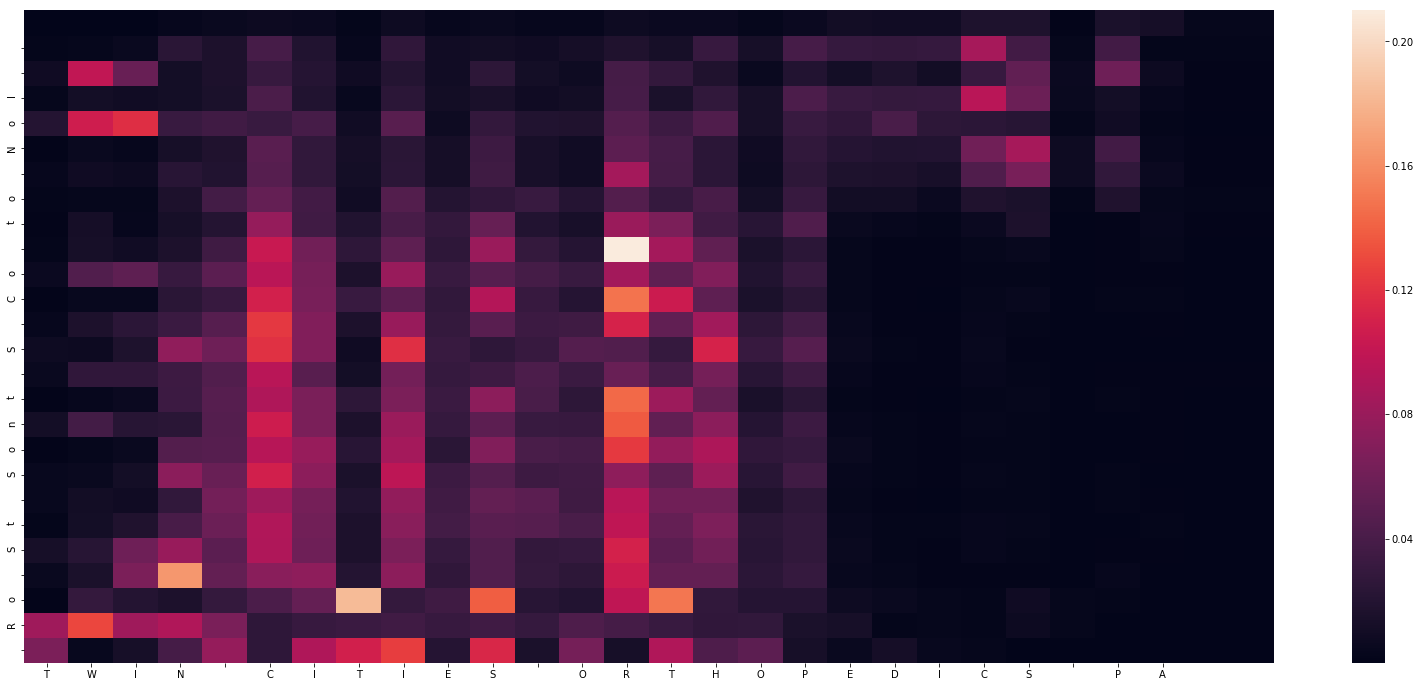

-
Input sentence: TWIN CITIES ORTHOPEDICS PA
GT sentence: TWIN CITIES ORTHOPEDICS PA

Decoded sentence: •Ro St Sont S Co to Nol  


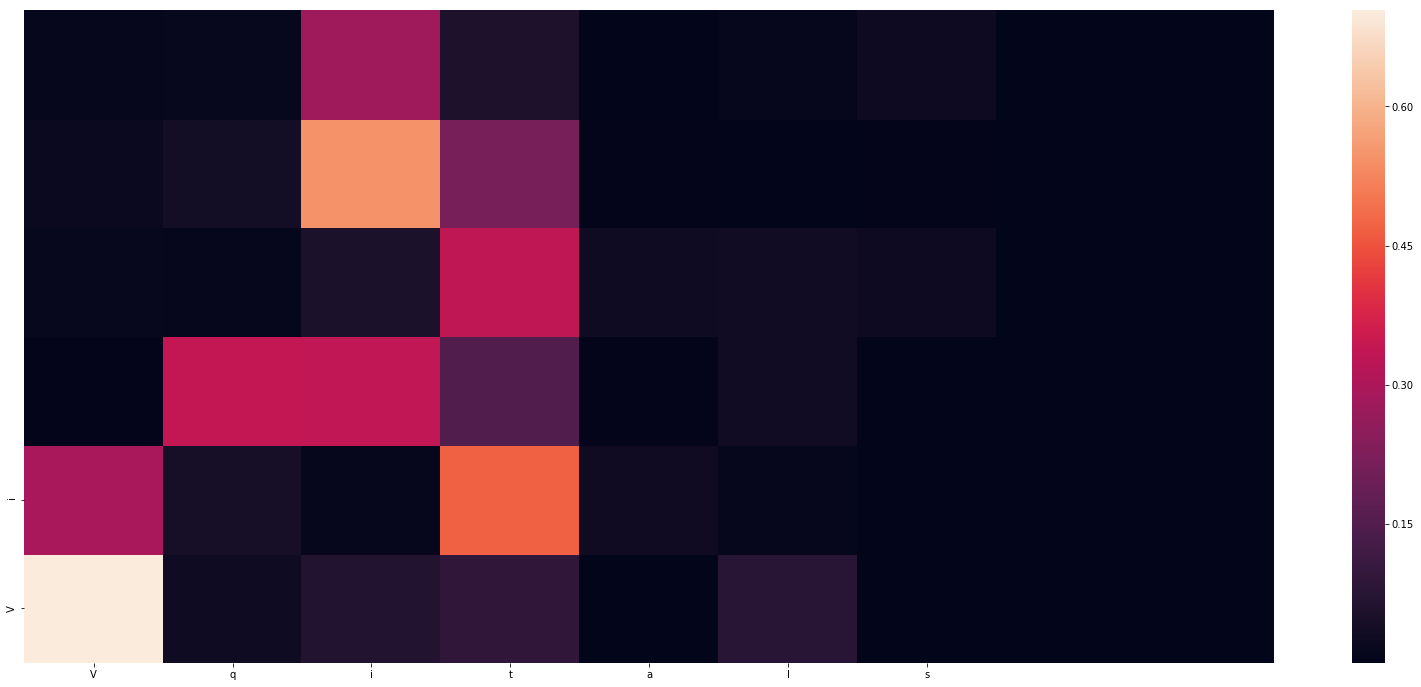

-
Input sentence: Vqitals
GT sentence: Vitals

Decoded sentence: Vi


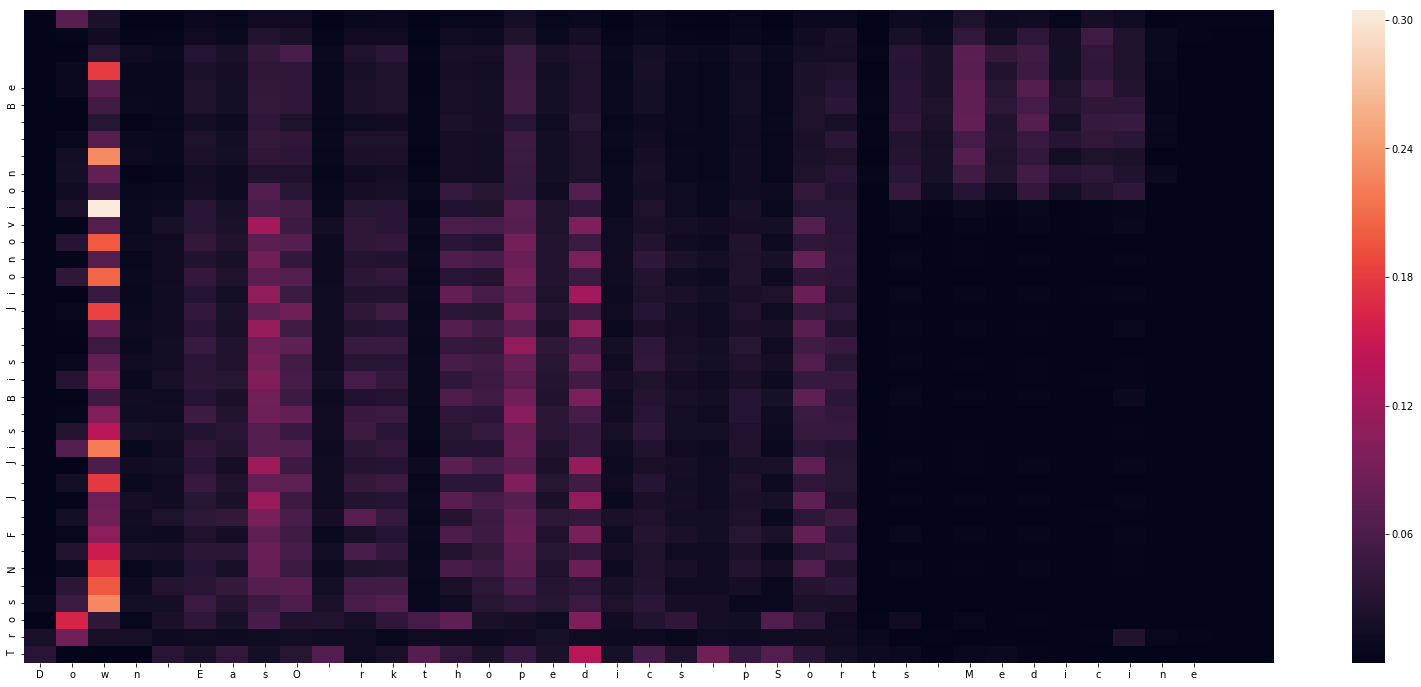

-
Input sentence: Down EasO rkthopedics pSorts Medicine
GT sentence: Down East Orthopedics Sports Medicine 

Decoded sentence: Tros N F J Jis Bis  Jionovion   Be


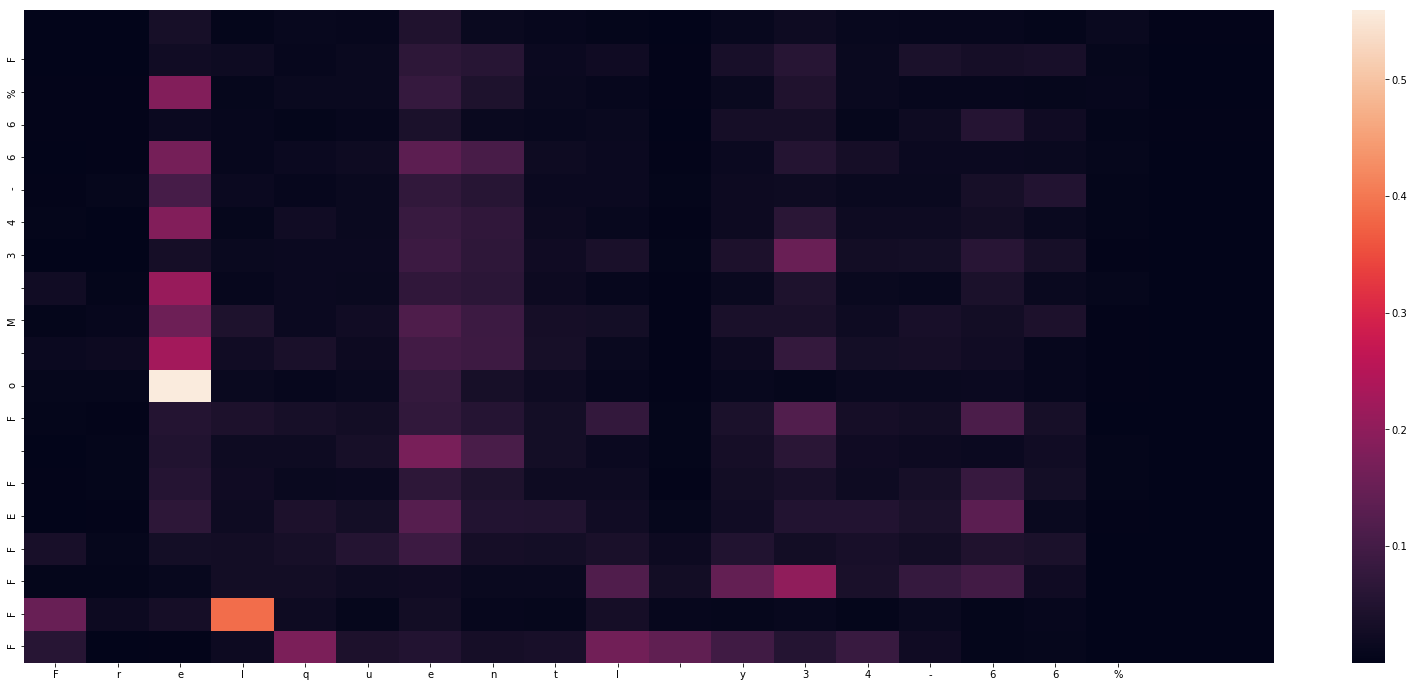

-
Input sentence: Frelquentl y34-66%
GT sentence: Frequently 34-66%

Decoded sentence: FFFFEF Fo M 34-66%F


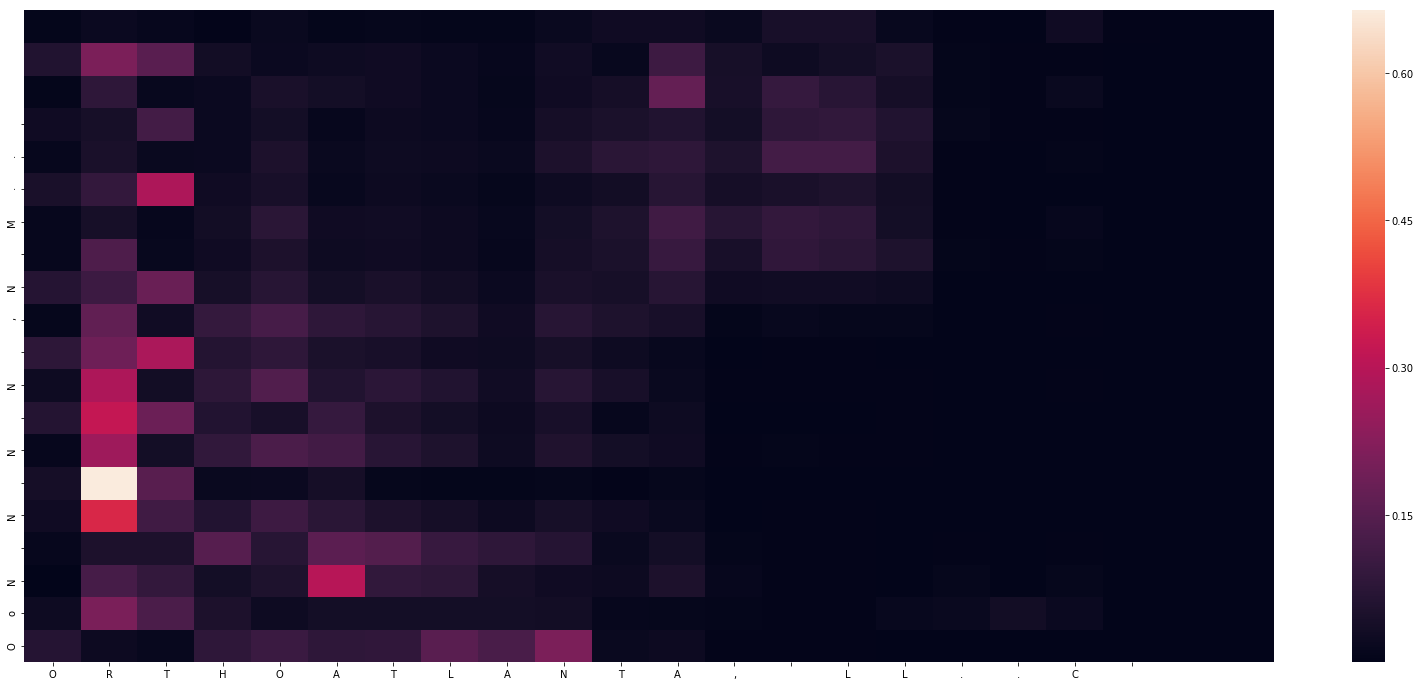

-
Input sentence: ORTHOATLANTA, LL..C

GT sentence: ORTHOATLANTA, L.L.C.

Decoded sentence: OoN N N N ,N M.. 


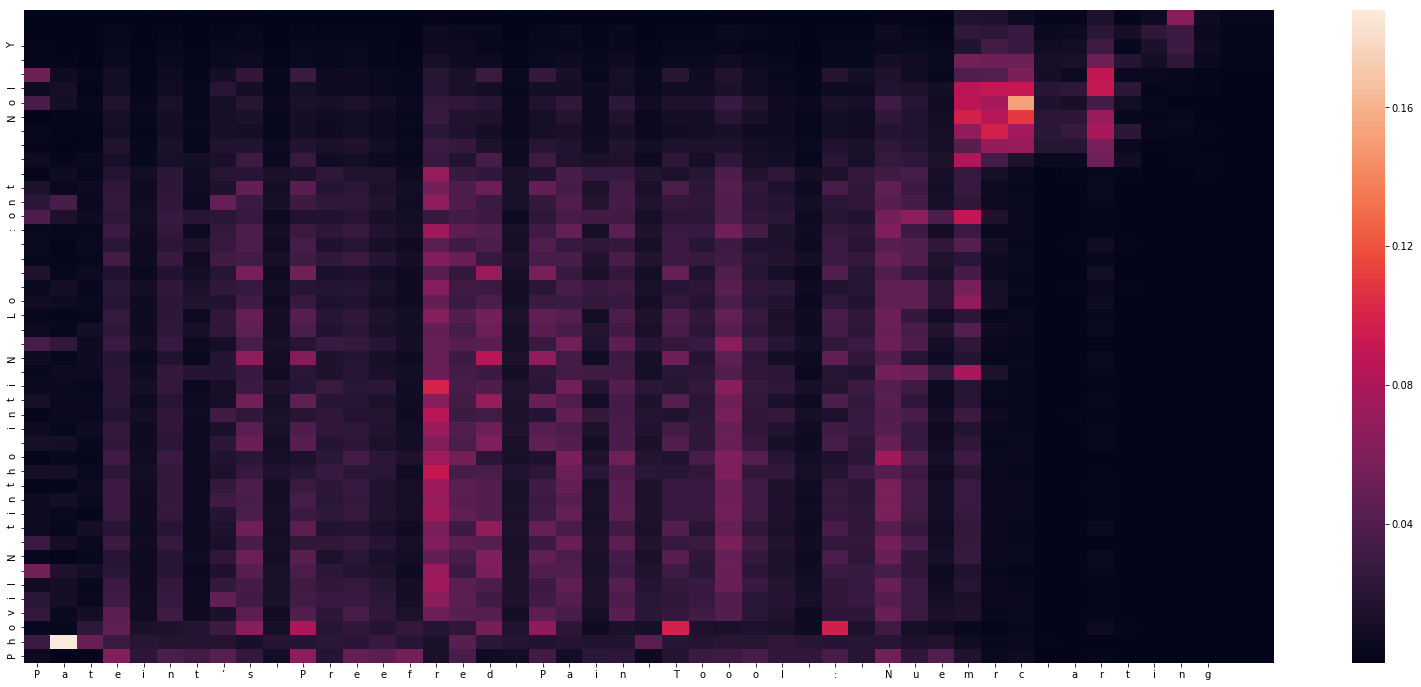

-
Input sentence: Pateint’s Preefred Pain Toool : Nuemrc arting
GT sentence: Patient’s Preferred Pain Tool : Numeric rating

Decoded sentence: Phovil N tintho inti N  Lo    :ont    Nol  Y


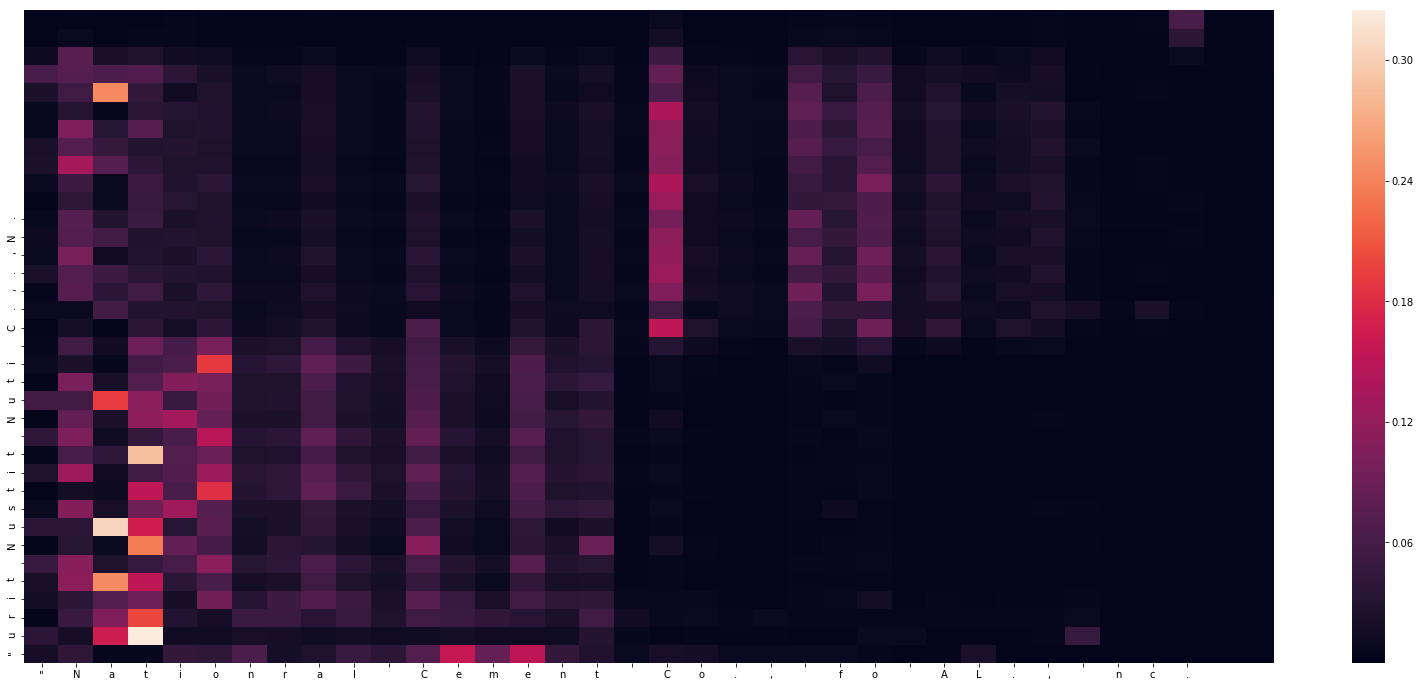

-
Input sentence: "Nationral Cement Co., fo AL., nc.
GT sentence: "National Cement Co., of AL., Inc."
Decoded sentence: "urit Nustit Nuti C.,.,N.


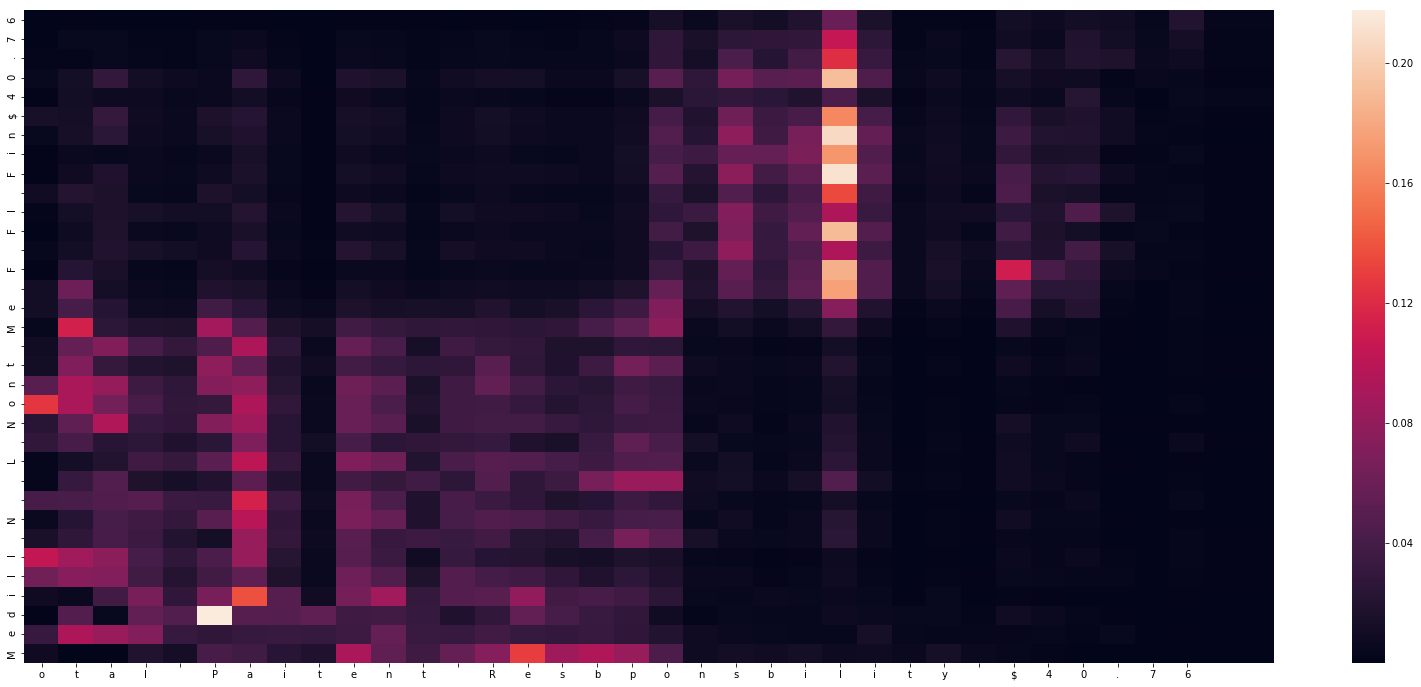

-
Input sentence: otal Paitent Resbponsbility $40.76
GT sentence: Total Patient Responsibility $40.76

Decoded sentence: Medill N  L Nont Me F Fl Fin$40.76


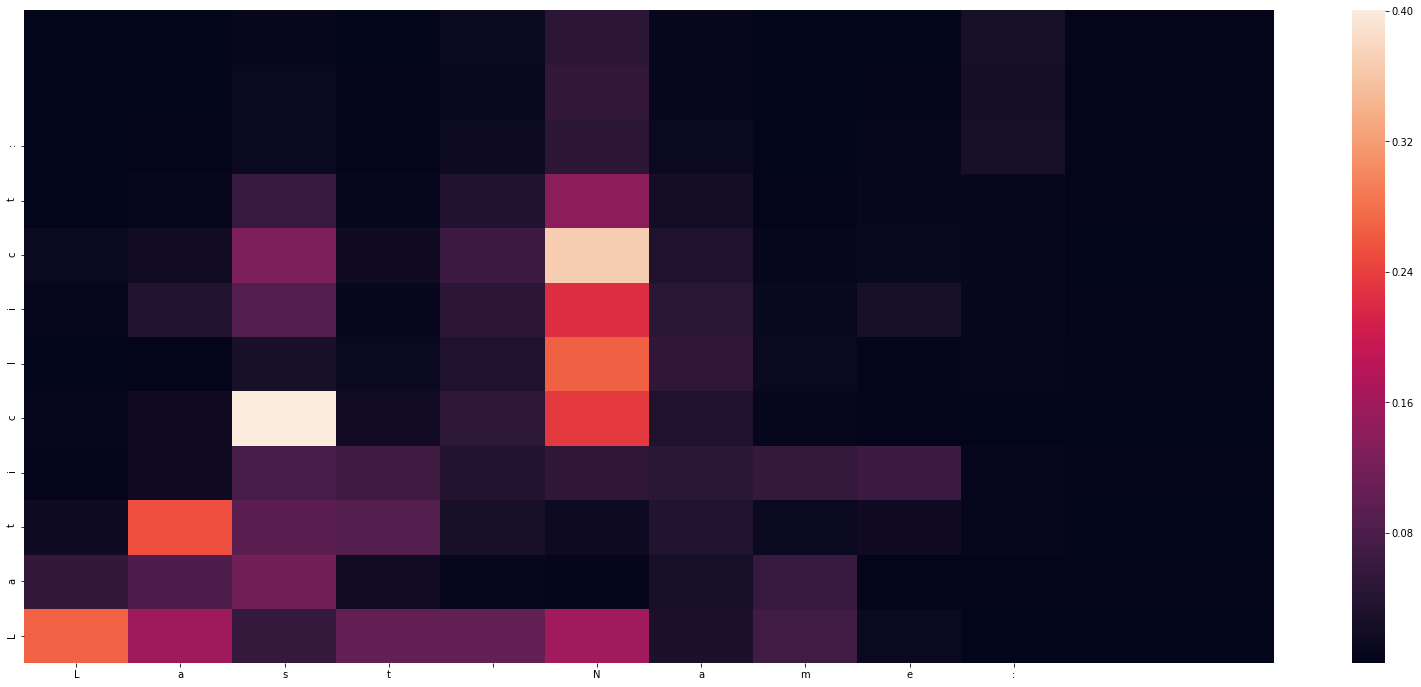

-
Input sentence: Last Name:
GT sentence: Last Name:

Decoded sentence: Laticlict:


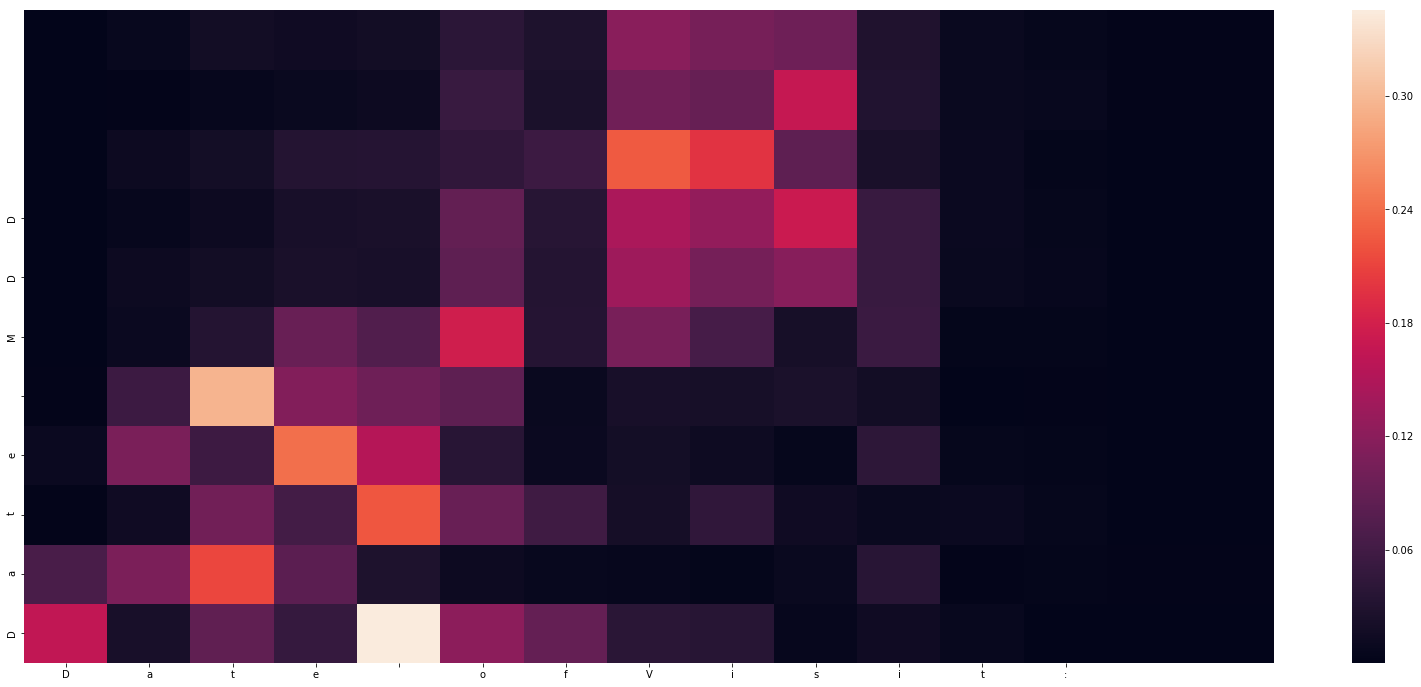

-
Input sentence: Date ofVisit:
GT sentence: Date of Visit:

Decoded sentence: Date MDD


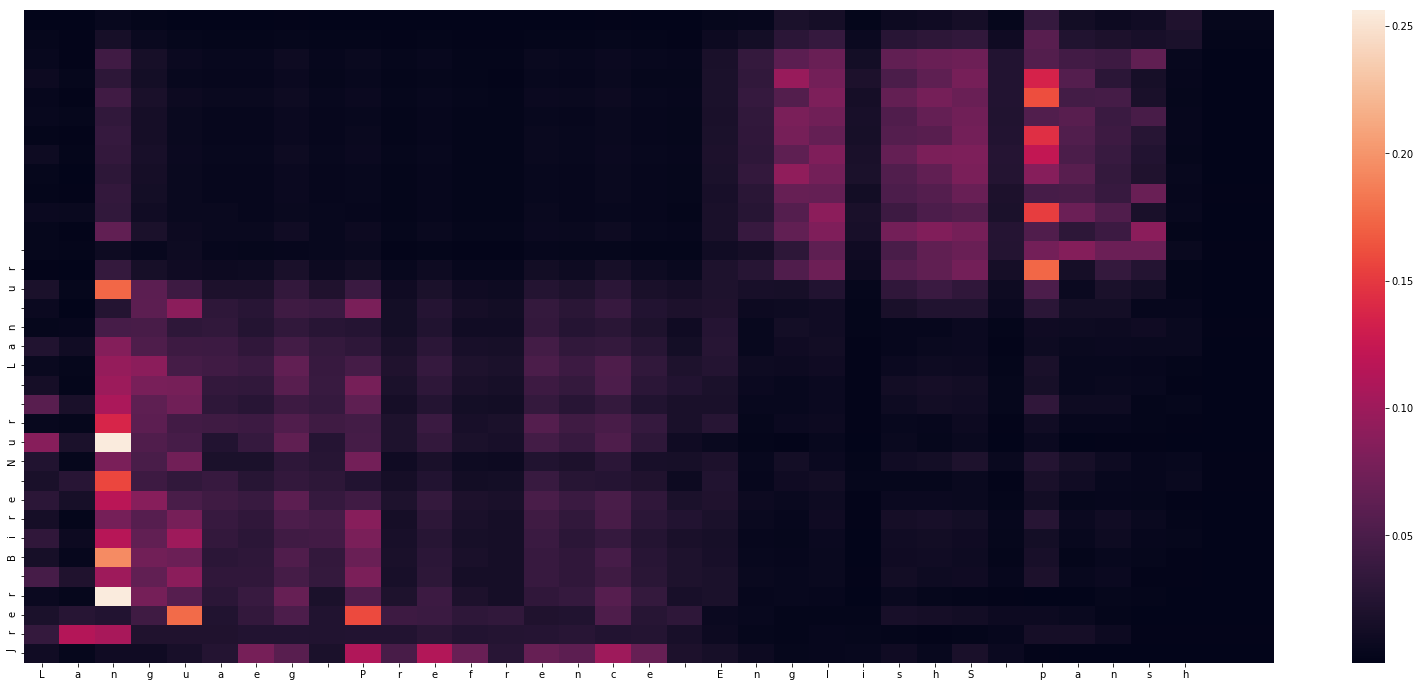

-
Input sentence: Languaeg Prefrence EnglishS pansh
GT sentence: Language Preference English Spanish

Decoded sentence: Jrer Bire Nur  Lan ur 


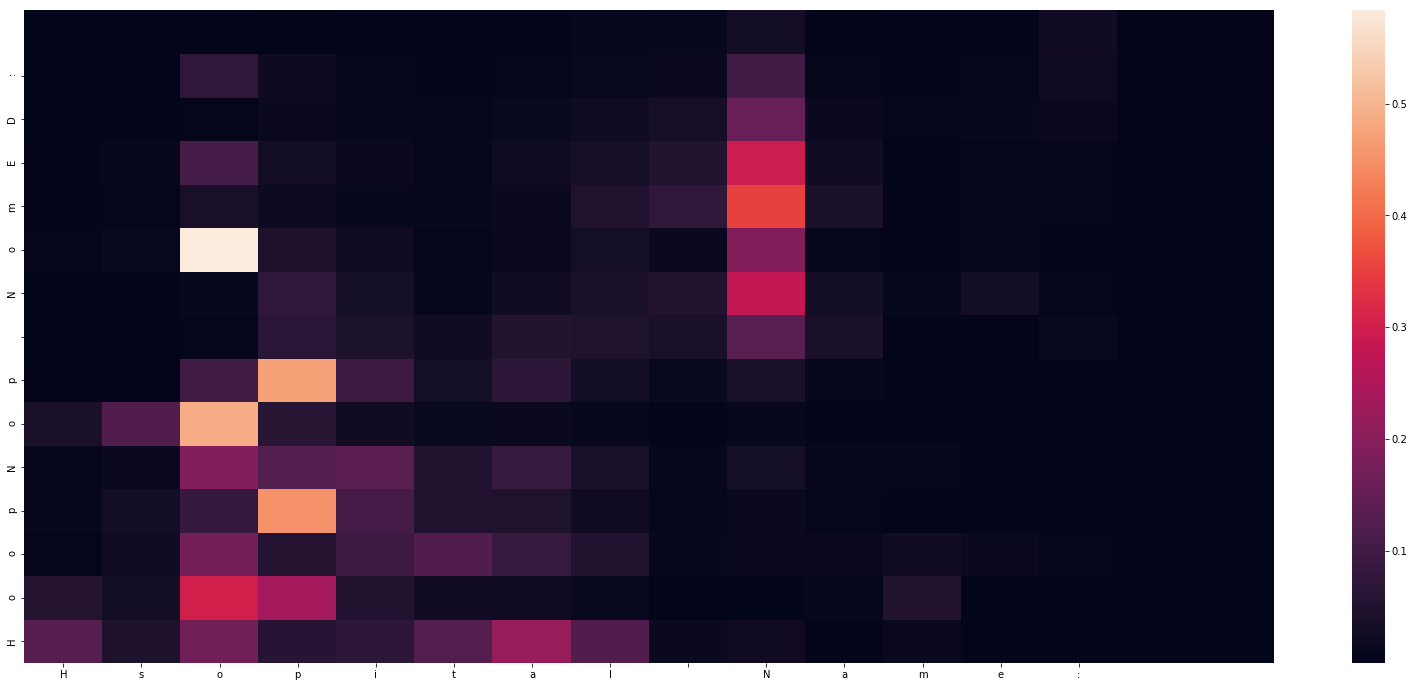

-
Input sentence: Hsopital Name:
GT sentence: Hospital Name:

Decoded sentence: HoopNop NomED:


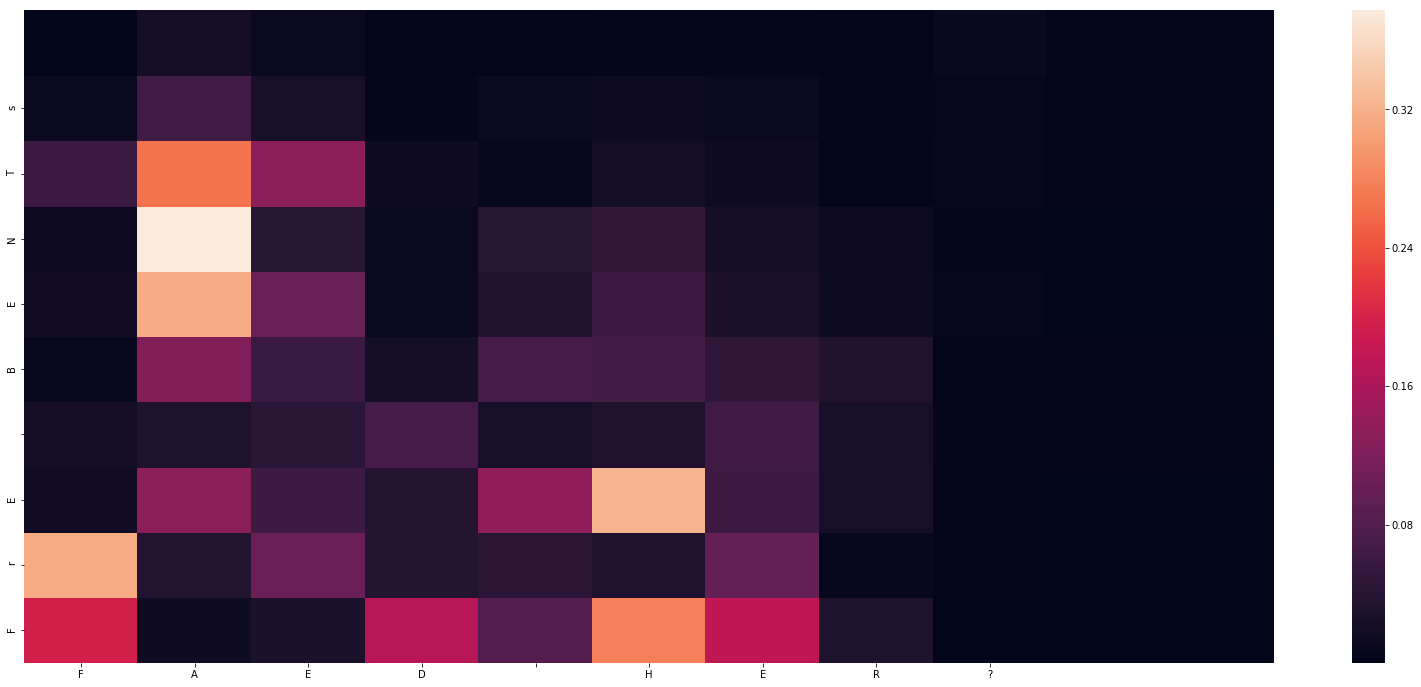

-
Input sentence: FAED HER?
GT sentence: PAID HERE $

Decoded sentence: FrE BENTs


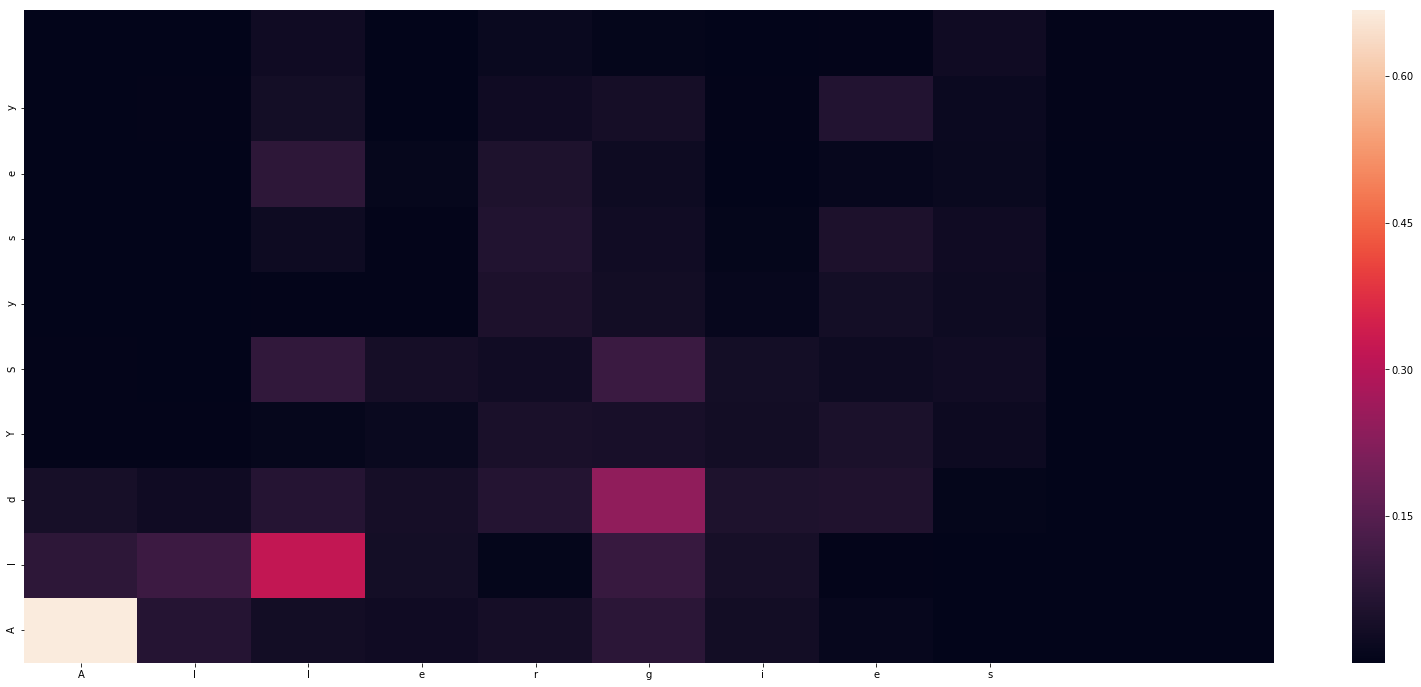

-
Input sentence: Allergies
GT sentence: Allergies

Decoded sentence: AldYSysey


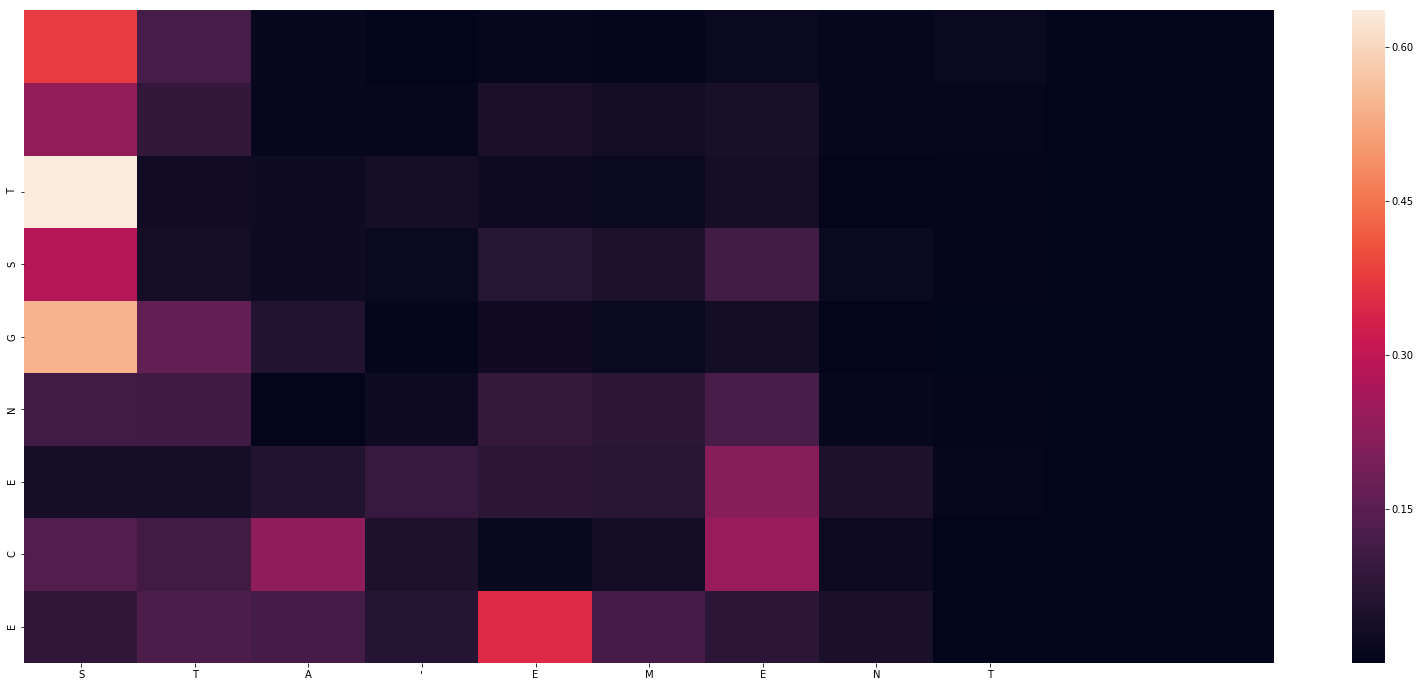

-
Input sentence: STA'EMENT
GT sentence: STATEMENT

Decoded sentence: ECENGST


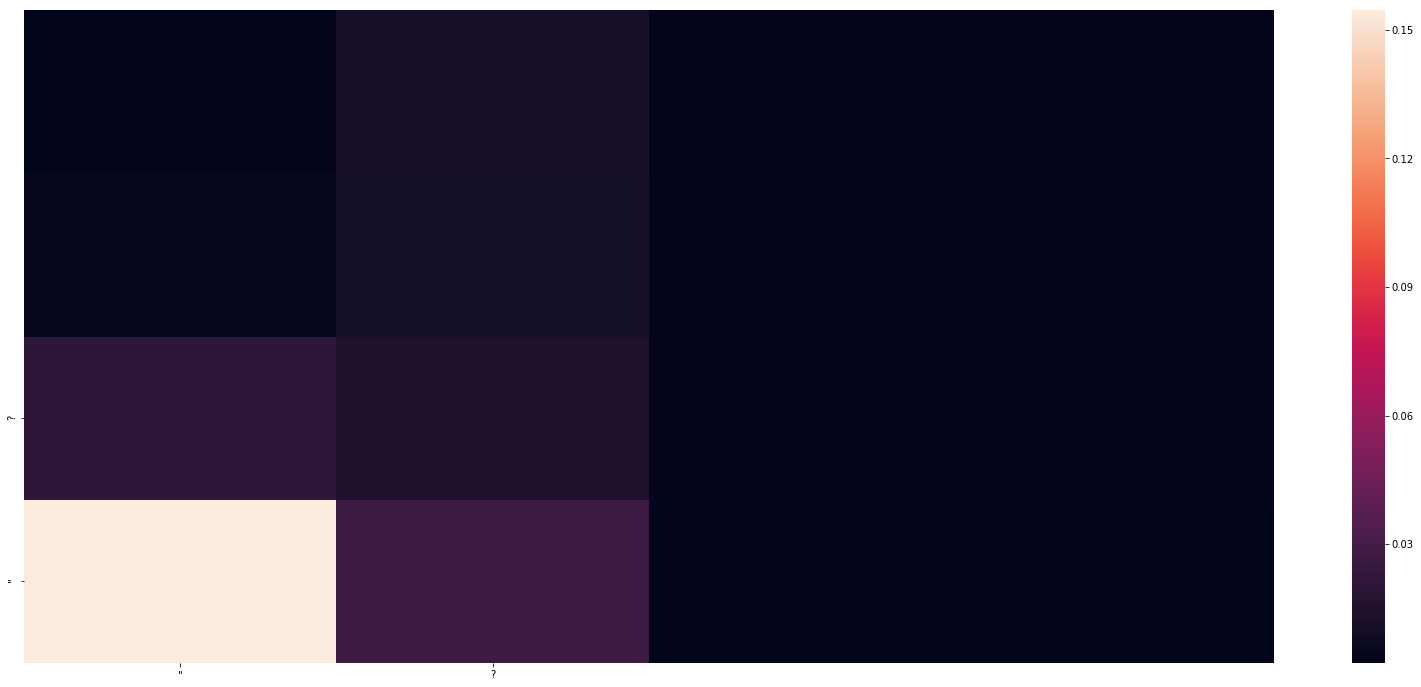

-
Input sentence: "?
GT sentence: "? "
Decoded sentence: "?


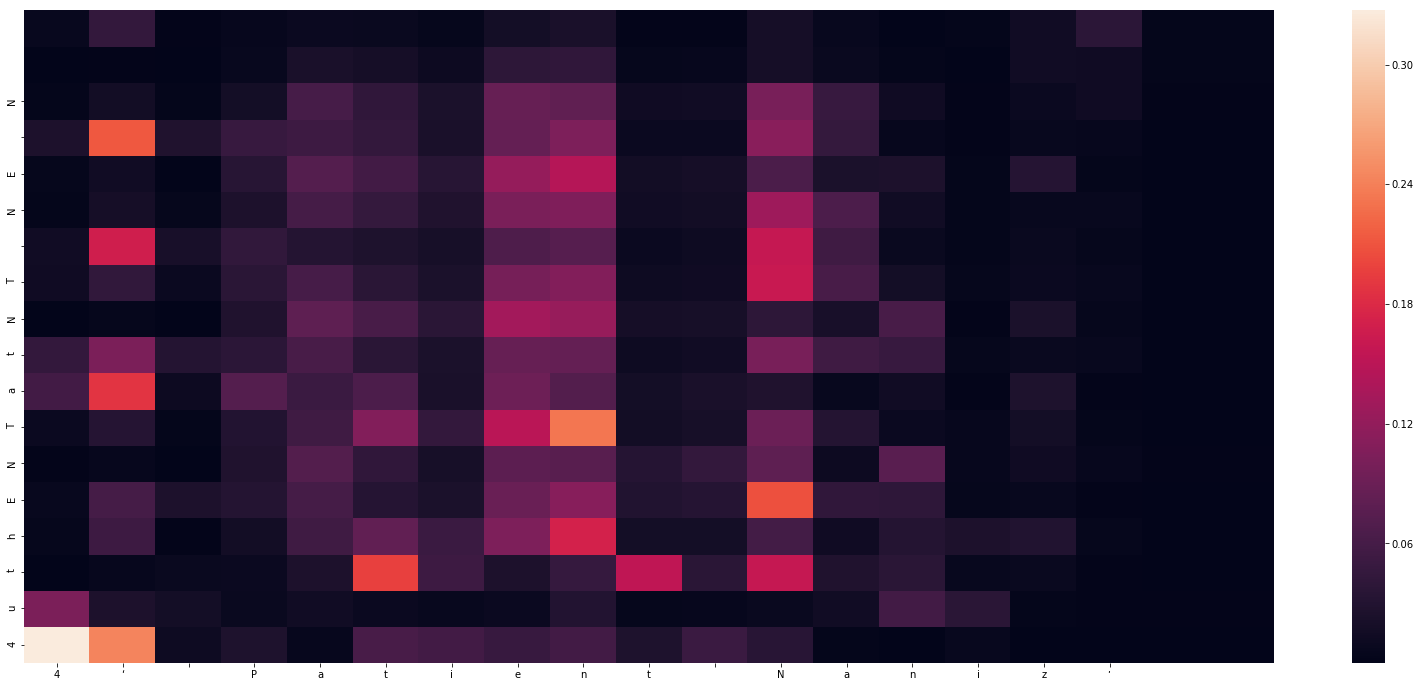

-
Input sentence: 4‘ Patient Naniz‘
GT sentence: Patient Name:

Decoded sentence: 4uthENTatNT NE N


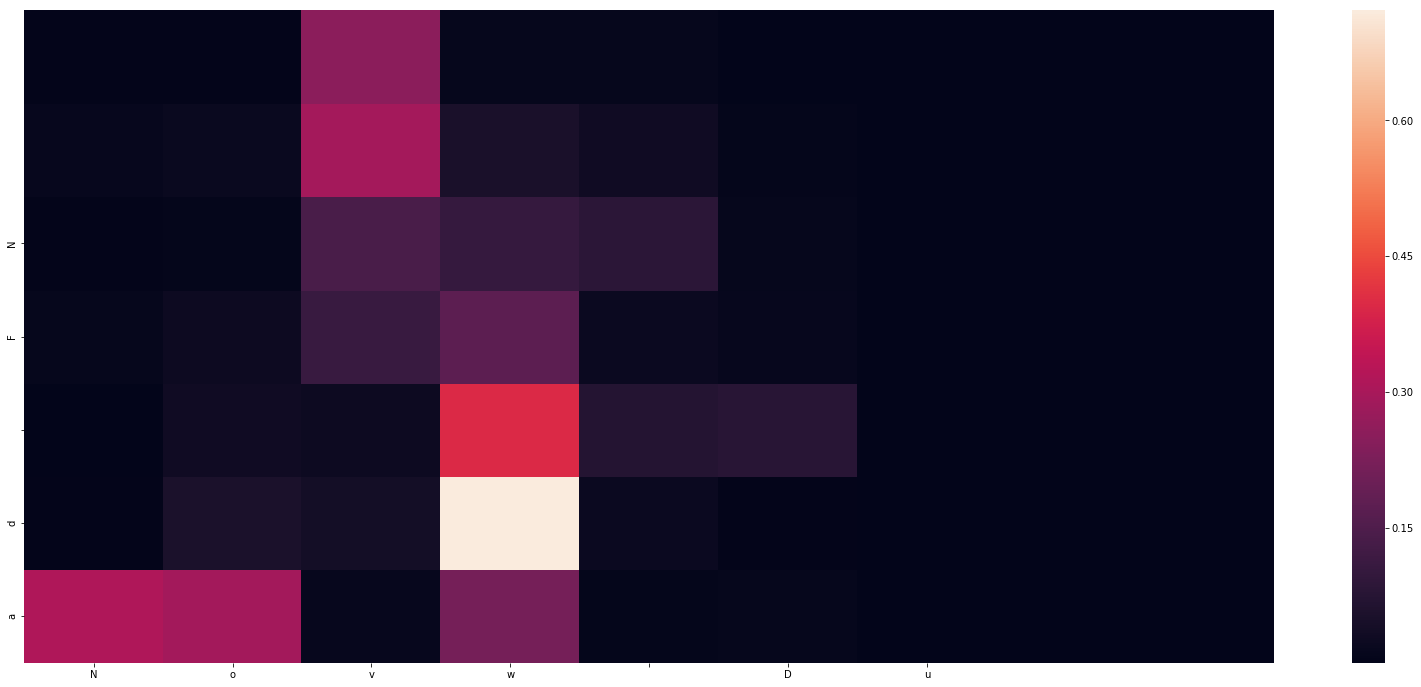

-
Input sentence: Novw Du
GT sentence: Now Due

Decoded sentence: ad FN


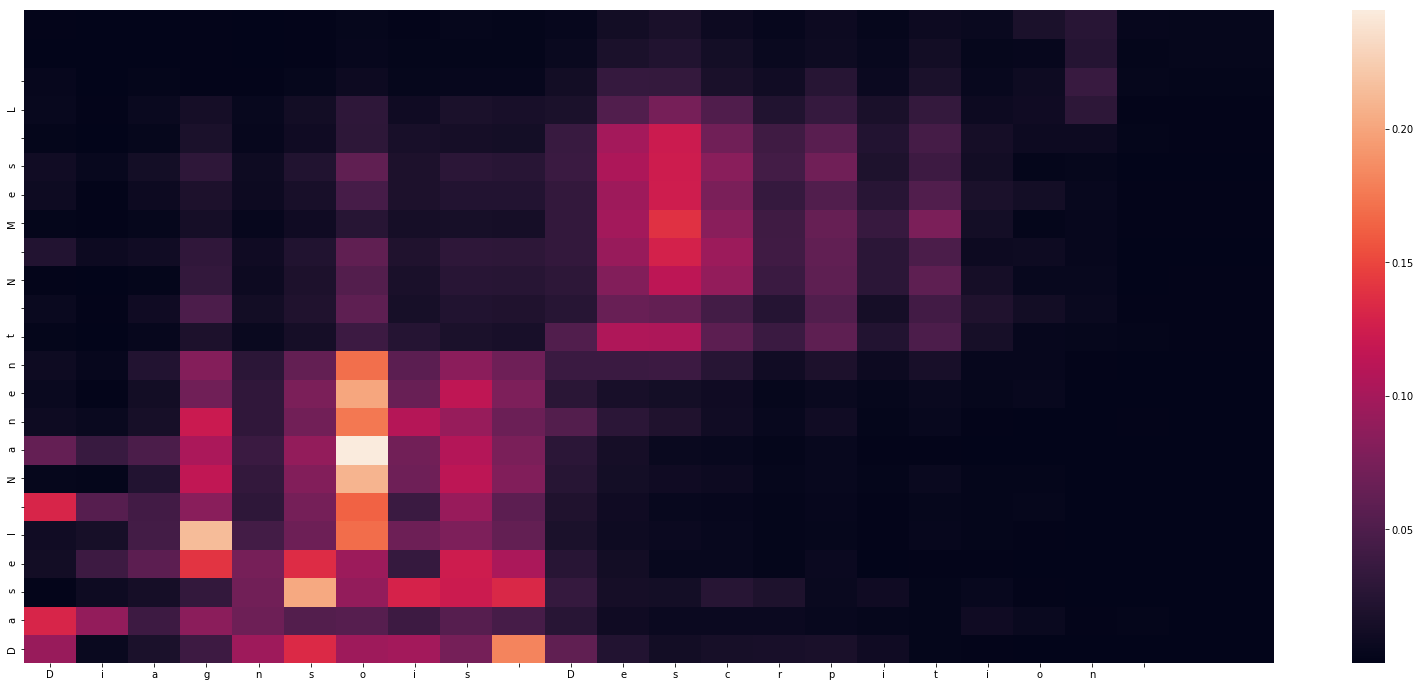

-
Input sentence: Diagnsois Descrpition 
GT sentence: Diagnosis Description 

Decoded sentence: Dasel Nanent N Mes L 


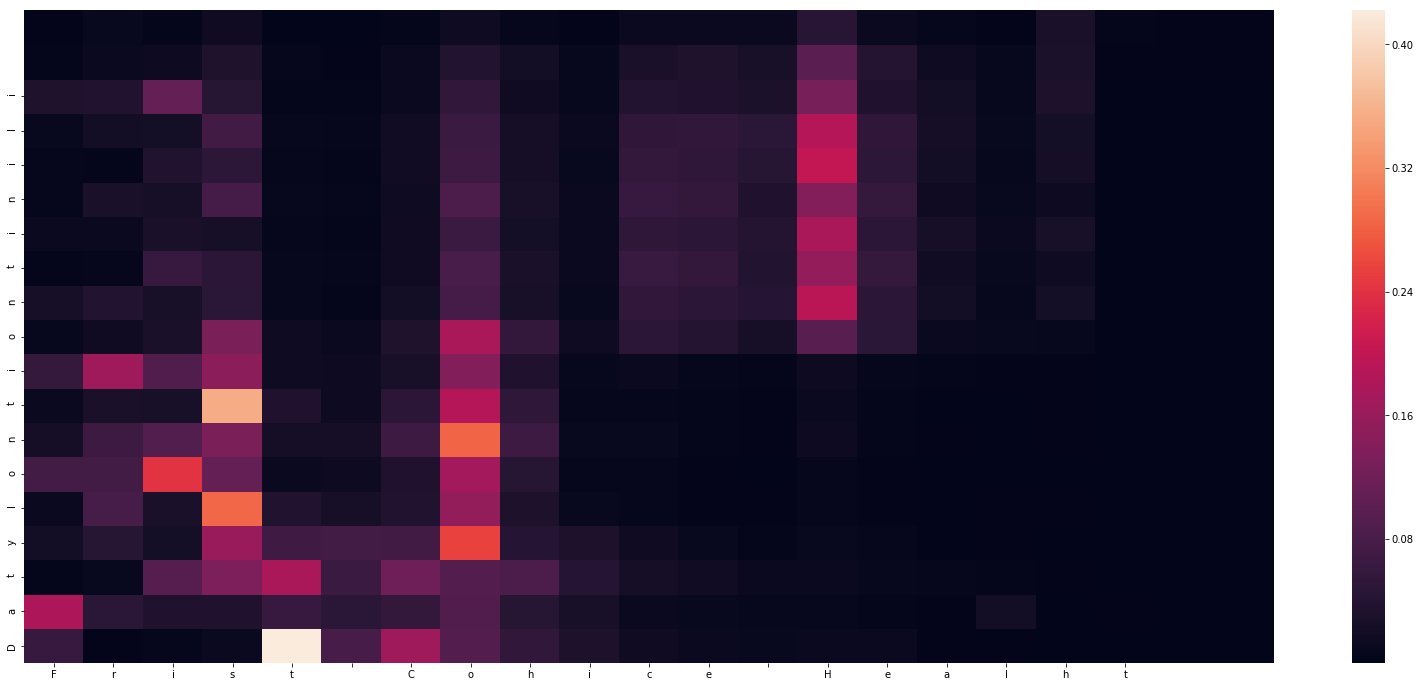

-
Input sentence: Frist Cohice Healht
GT sentence: First Choice Health

Decoded sentence: Datylontiontinili


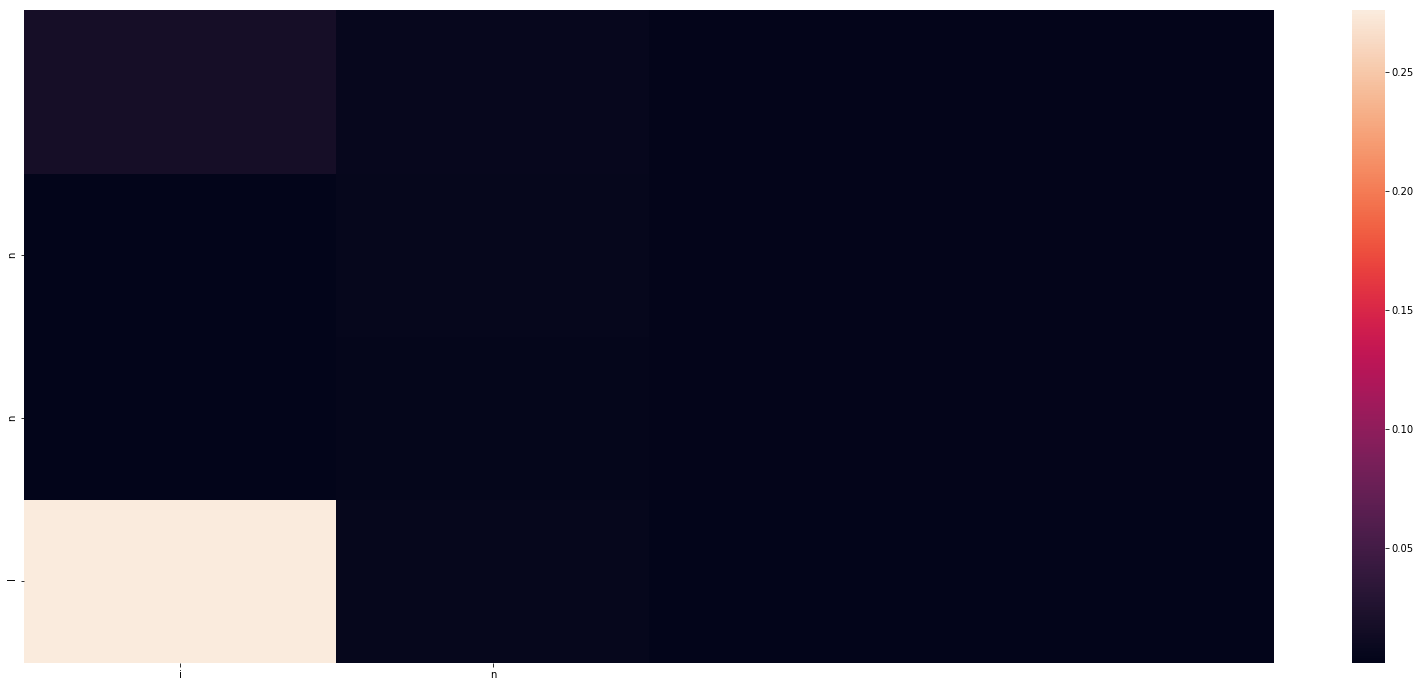

-
Input sentence: in
GT sentence: inj.
Decoded sentence: Inn


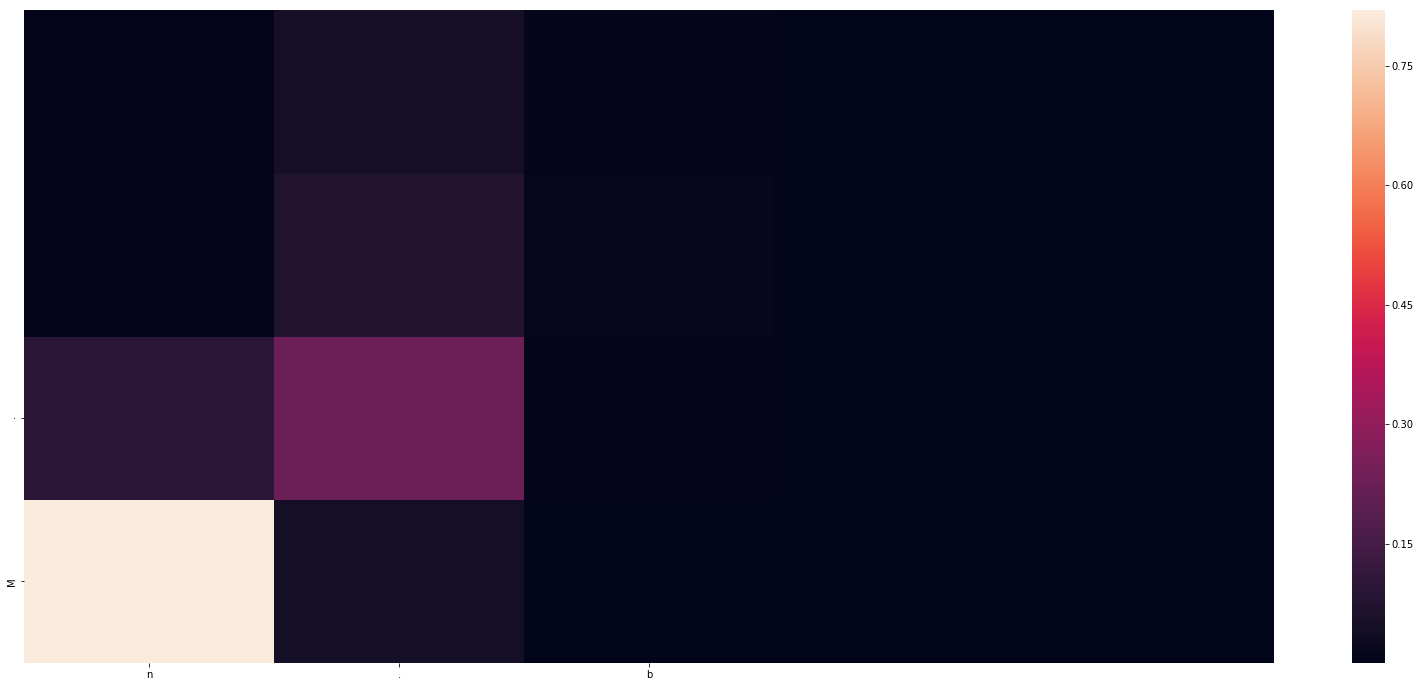

-
Input sentence: n.b
GT sentence: n.b.
Decoded sentence: M.


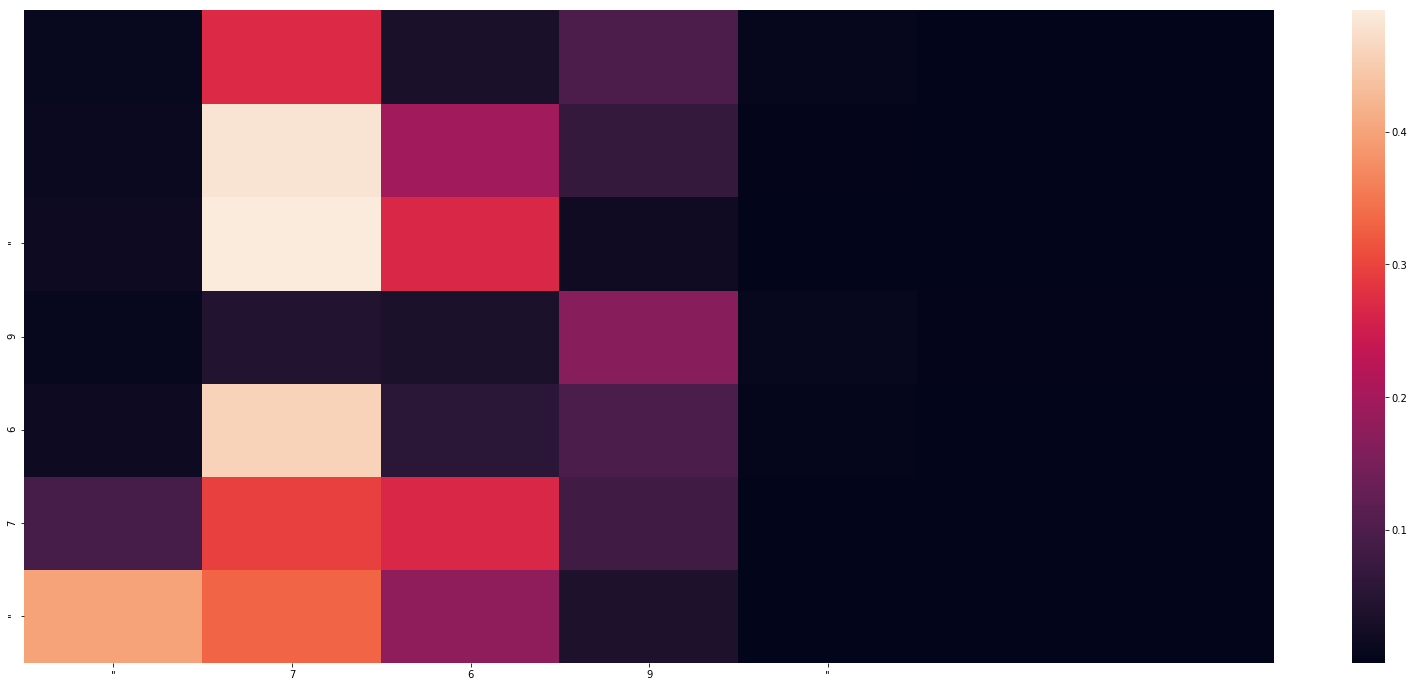

-
Input sentence: "769"
GT sentence: "769C"
Decoded sentence: "769"


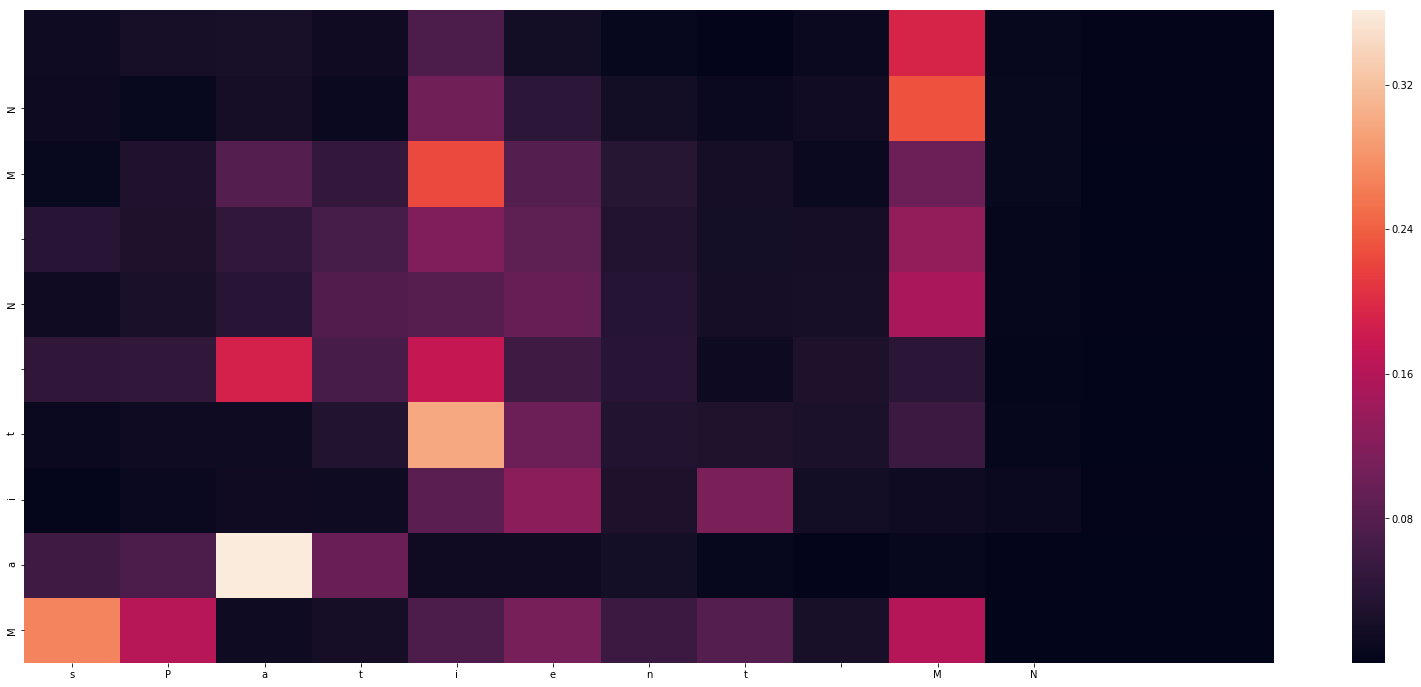

-
Input sentence: sPatient MN
GT sentence: Patient MRN:

Decoded sentence: Mait N MN


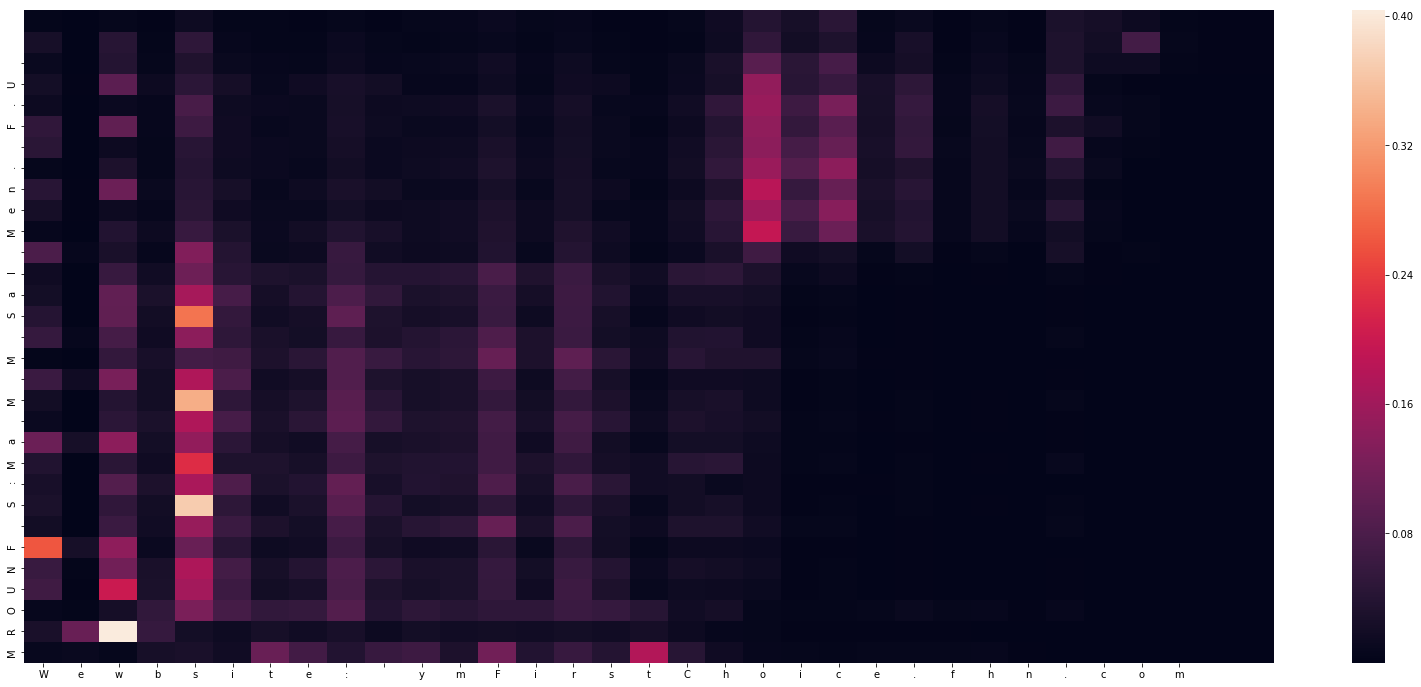

-
Input sentence: Wewbsite: ymFirstChoice.fhn.com
GT sentence: Website: myFirstChoice.fchn.com

Decoded sentence: MROUNF S:Ma M M Sal Men. F.U 


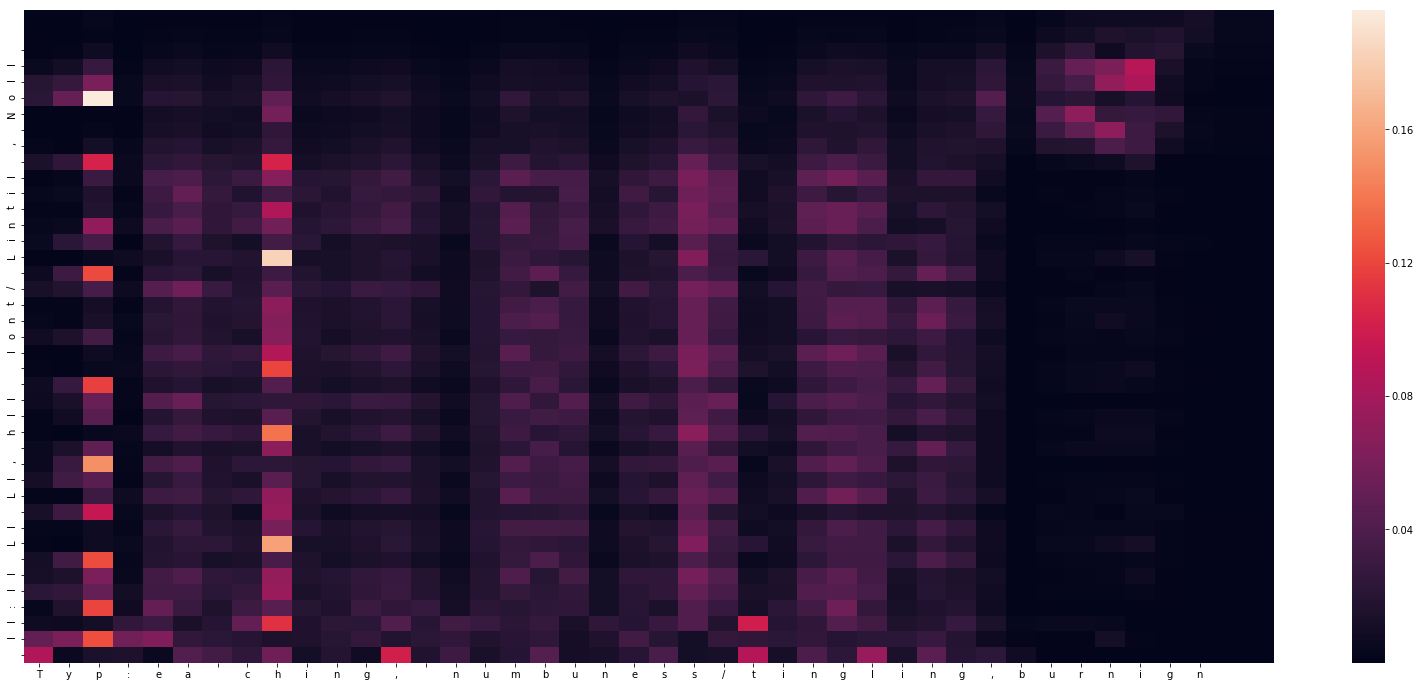

-
Input sentence: Typ:ea ching, numbuness/tingling,burnign
GT sentence: Type: aching, numbness/tingling,burning

Decoded sentence: •ll:ll Ll Ll, hll  lont/ Lintil , Noll 


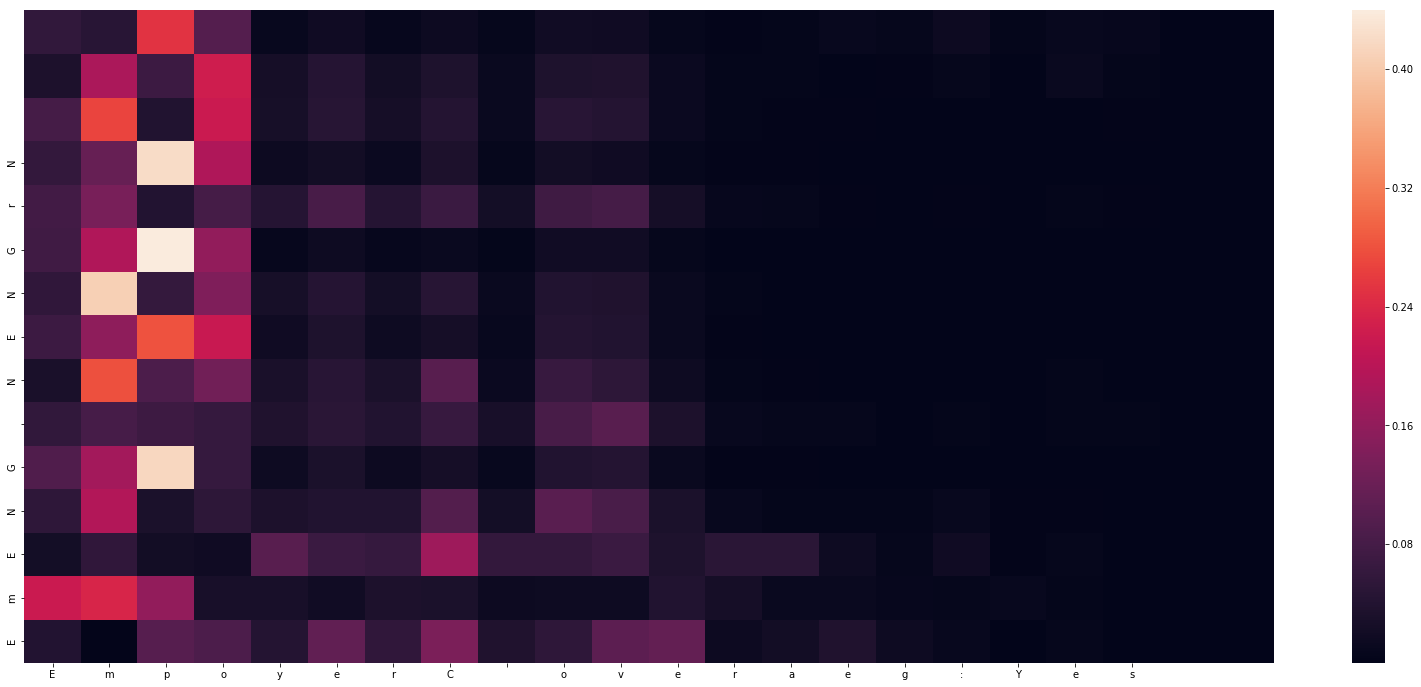

-
Input sentence: EmpoyerC overaeg:Yes
GT sentence: Employer Coverage: Yes

Decoded sentence: EmENG NENGrN


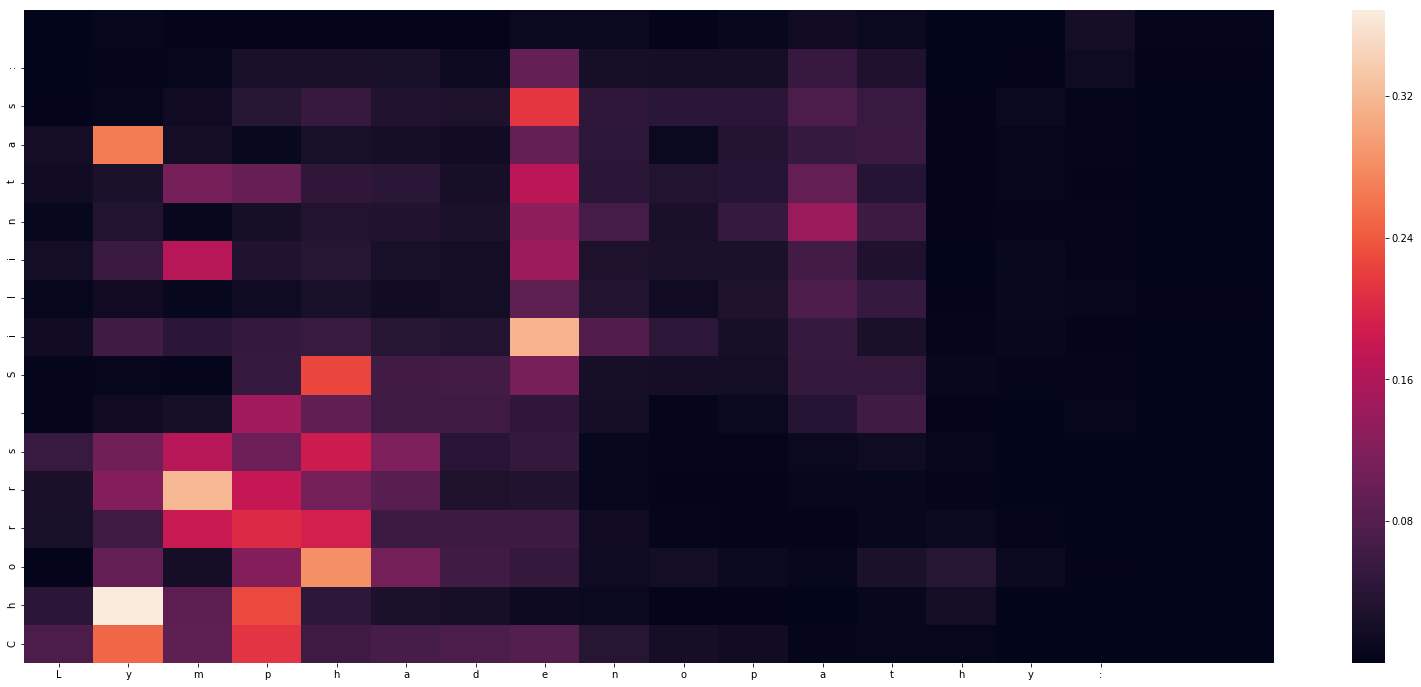

-
Input sentence: Lymphadenopathy:
GT sentence: Lymphadenopathy:

Decoded sentence: Chorrs Silintas:


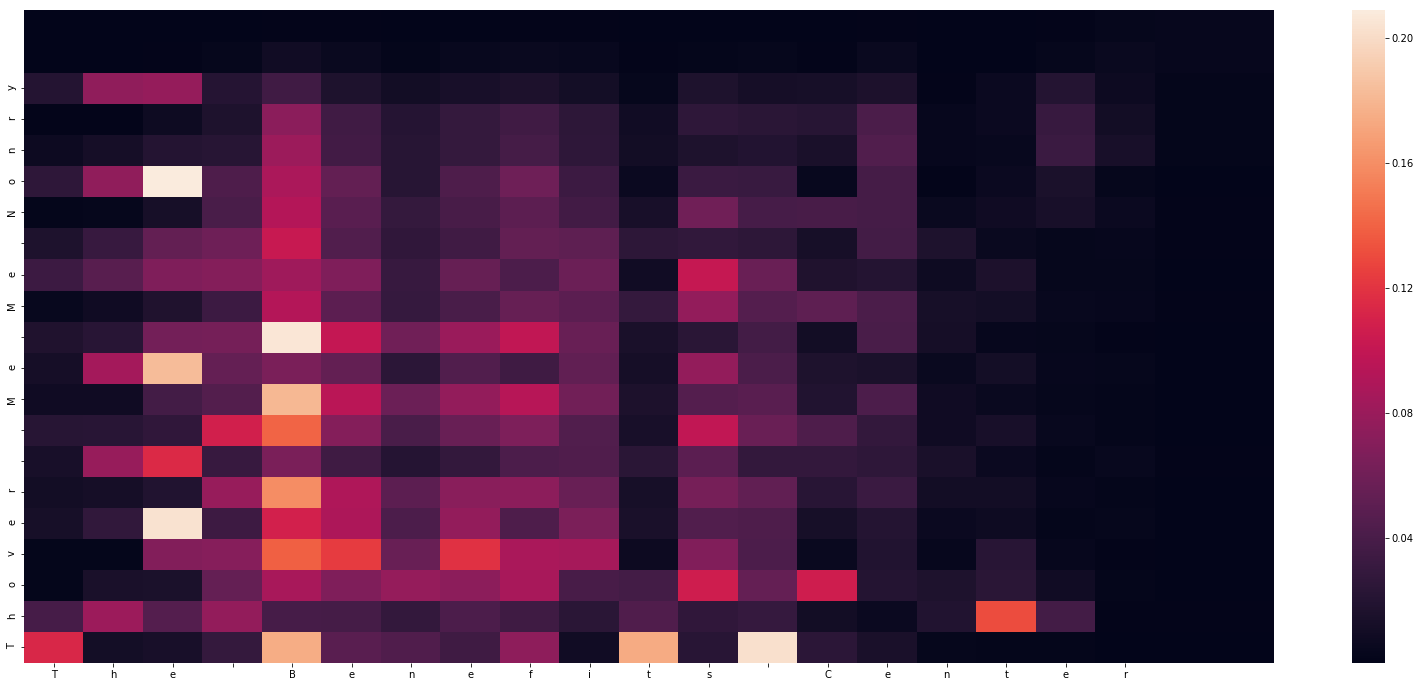

-
Input sentence: The Benefits Center
GT sentence: The Benefits Center

Decoded sentence: Thover  Me Me Nonry


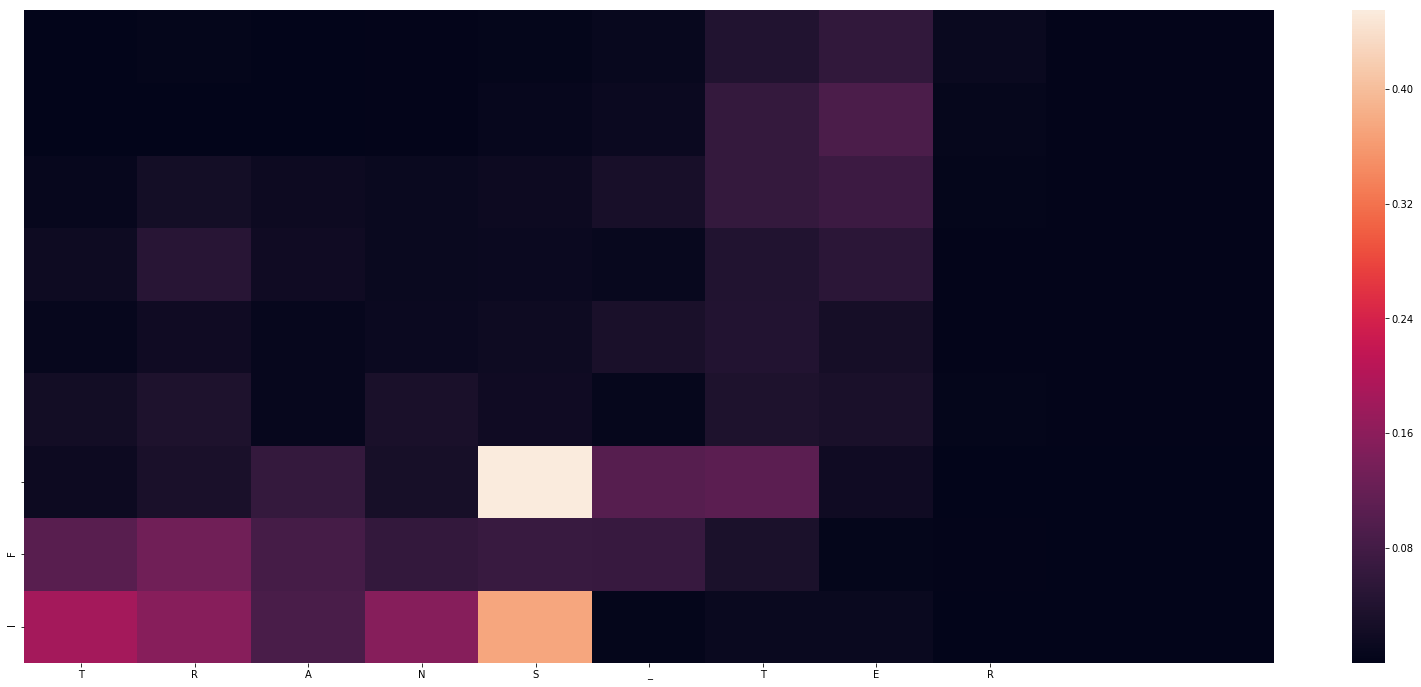

-
Input sentence: TRANS_TER
GT sentence: TRANS_TERM
Decoded sentence: IF 


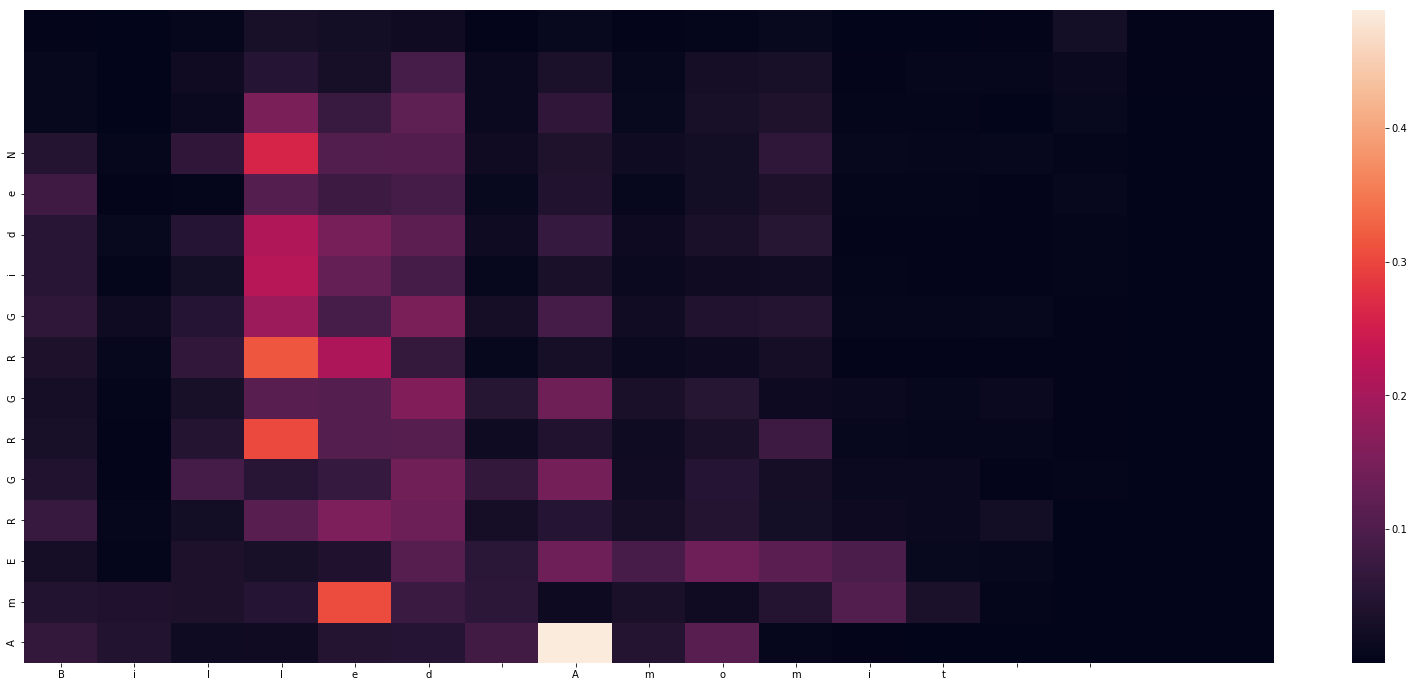

-
Input sentence: Billed Amomit ‘
GT sentence: Billed Amounts

Decoded sentence: AmERGRGRGideN


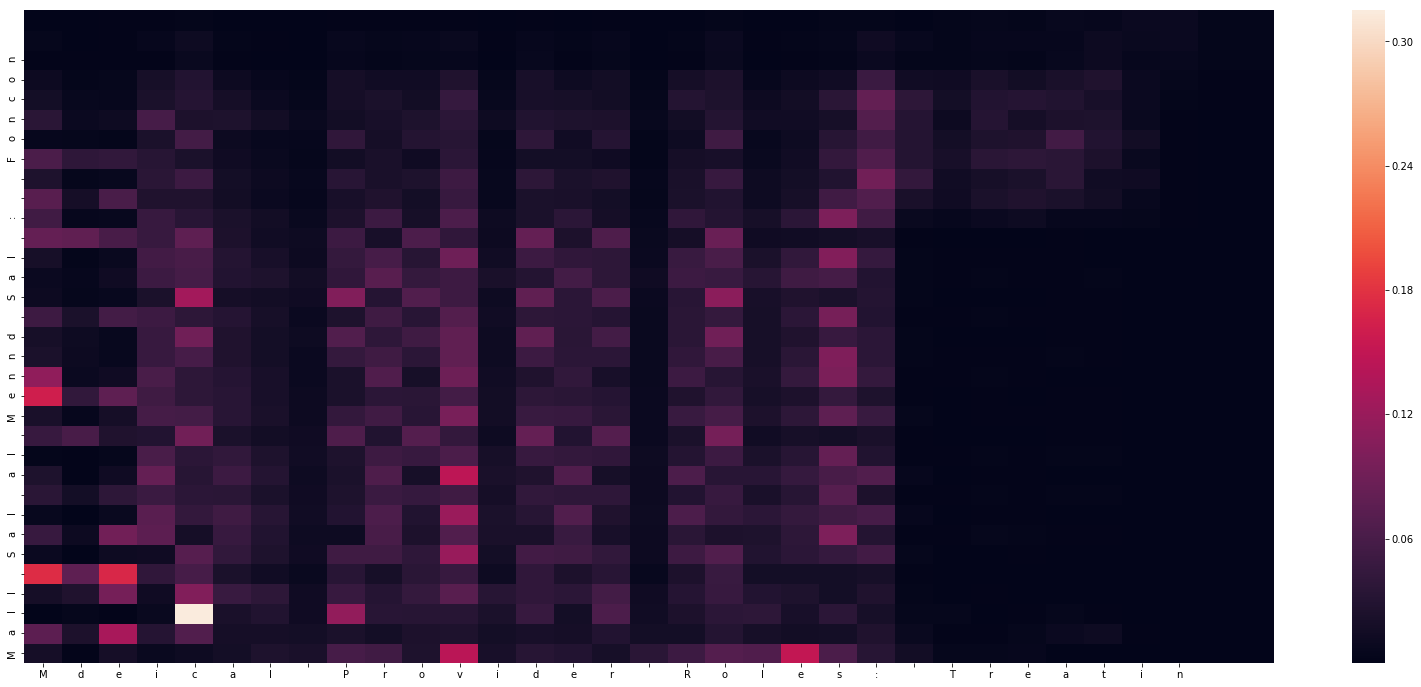

-
Input sentence: Mdeical Provider Roles: Treatin
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Mall Sal al Mennd Sal :  Foncon


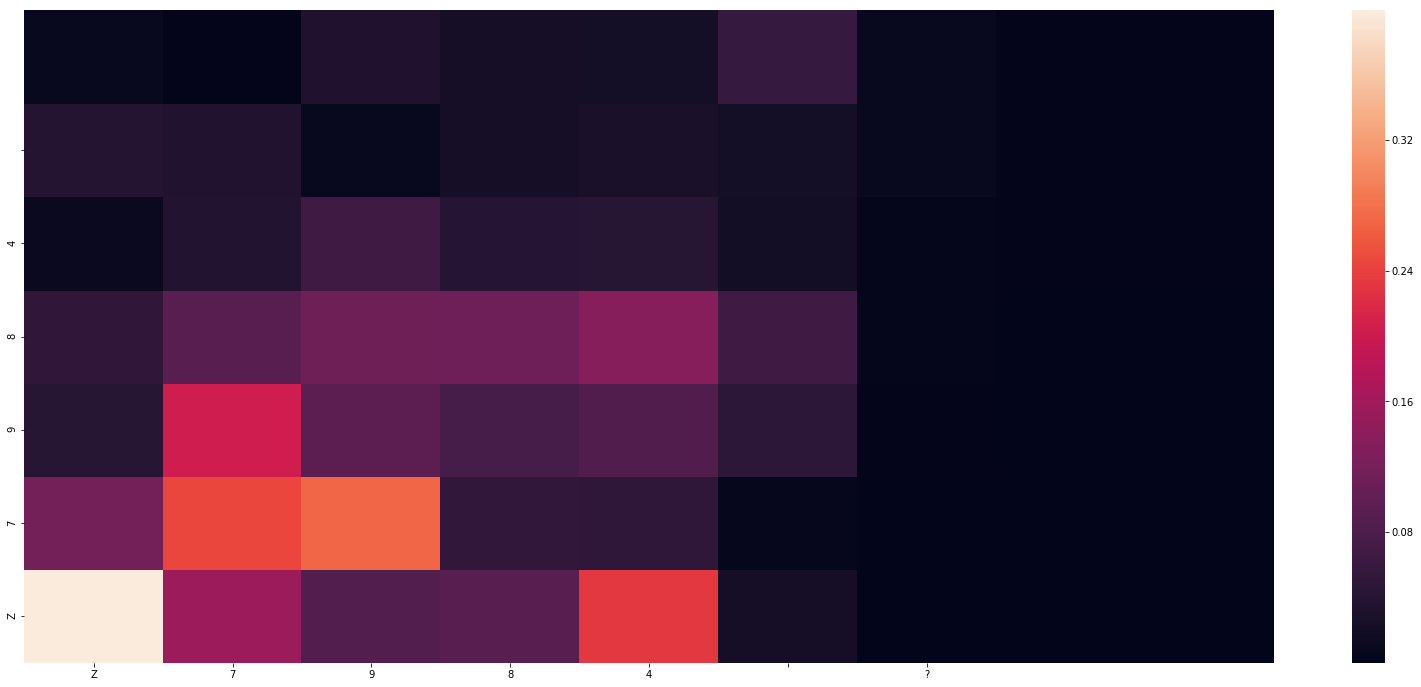

-
Input sentence: Z7984 ?
GT sentence: Z7984 ?

Decoded sentence: Z7984 


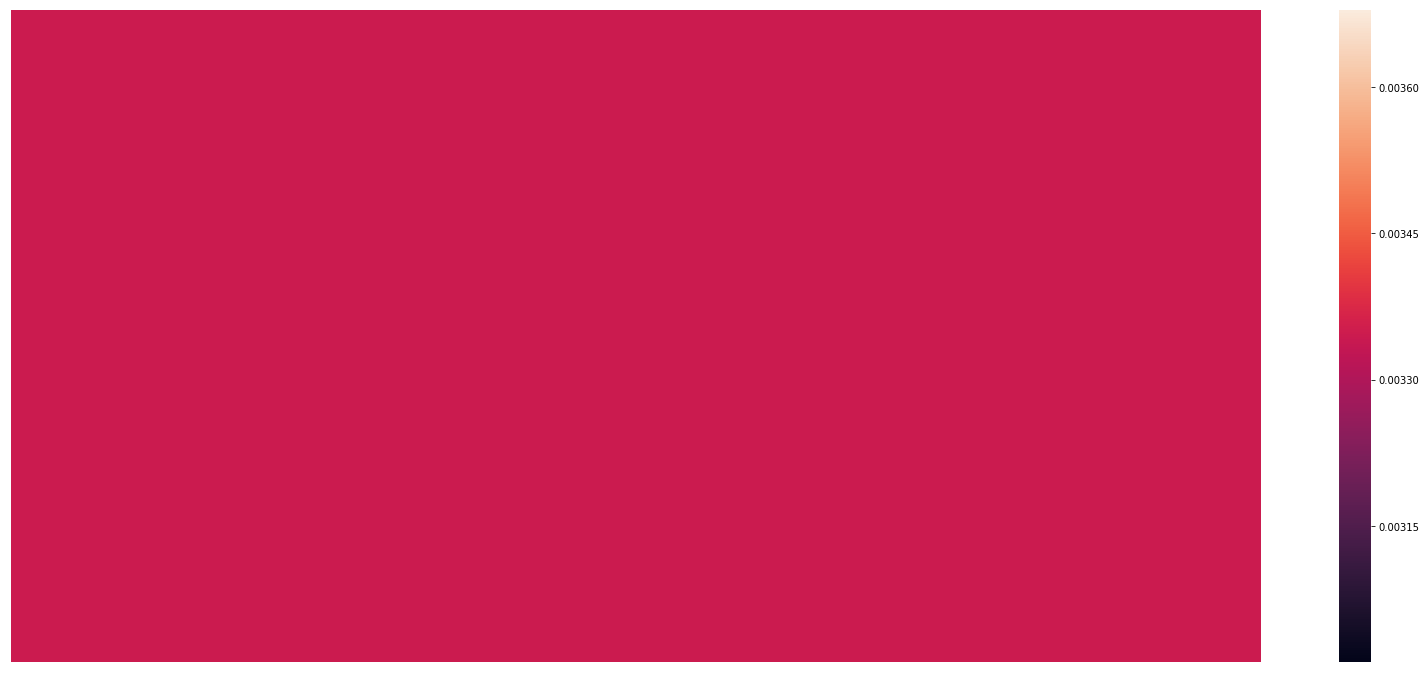

-
Input sentence: 
GT sentence: 
Decoded sentence: 


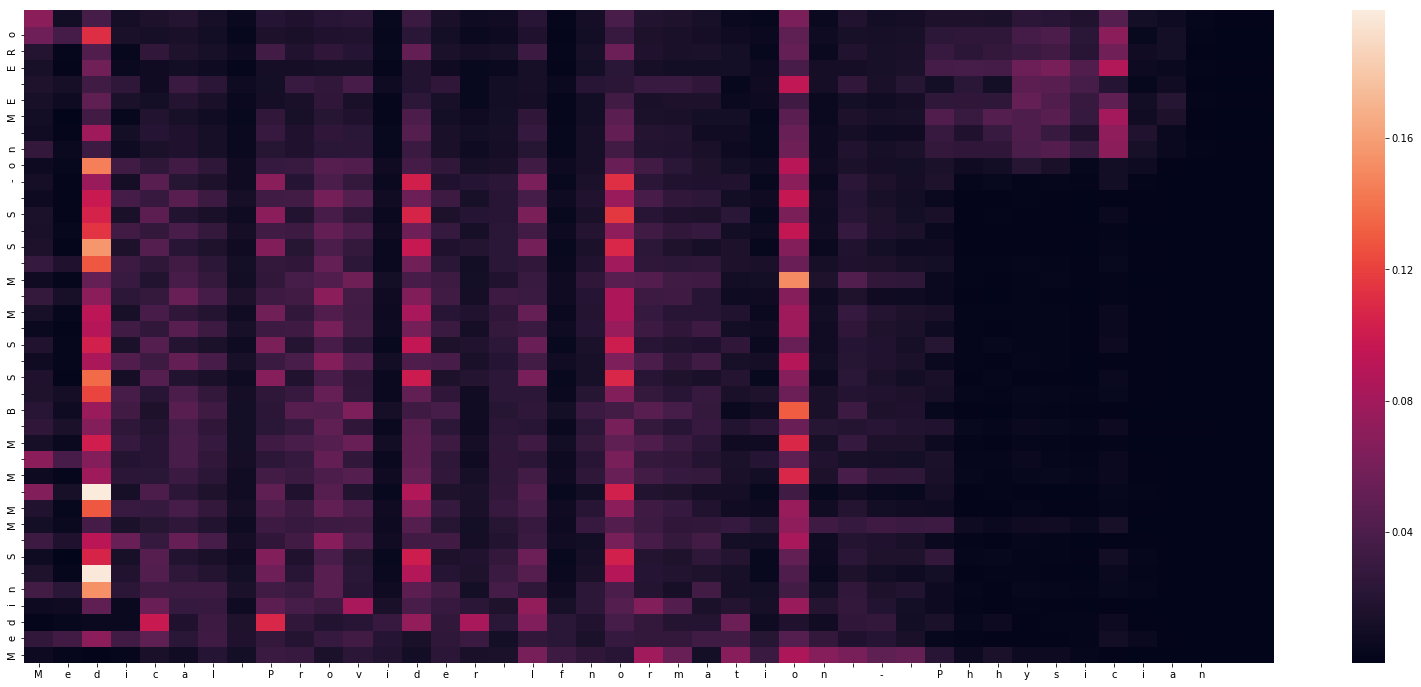

-
Input sentence: Medical Provider Ifnormation - Phhysician
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medin S MM M M B S S M M S S -on ME ERo


In [73]:

for seq_index in range(100):
    target_text = test_target_texts[seq_index][1:-1]
    text = test_input_texts[seq_index]

    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)  


In [74]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_spell_correction |TEST=  0.235621847754


In [75]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

WER_OCR |TEST=  0.0987606052313


# Test on separate tesseract corrected file

In [76]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'new_trained_data.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

input_texts = input_texts_OCR
target_texts = target_texts_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

-
Input sentence: Me dieal Provider Roles: Treating 
GT sentence: Medical Provider Roles: Treating

Decoded sentence: • H Y FO I I F F FY Y:FO B F YYTe
-
Input sentence: Provider First Name: Christine 
GT sentence: Provider First Name: Christine

Decoded sentence: PreF BiMire Me M  J:Jired Bonsy
-
Input sentence: Provider Last Name: Nolen, MD 
GT sentence: Provider Last Name: Nolen, MD

Decoded sentence: PrerB Bis Nurr Ny :EN NEN,N 
-
Input sentence: Address Line 1 : 7 25 American Avenue 
GT sentence: Address Line 1 : 725 American Avenue

Decoded sentence: JrrhY L B B J1 :e7B25 J Je Sr N Mes ss
-
Input sentence: City. W’aukesha 
GT sentence: City: Waukesha

Decoded sentence: ChOR.NTyNCon
-
Input sentence: StatefProvinee: ‘WI 
GT sentence: State/Province: WI

Decoded sentence: •SINGNNG N: NE
-
Input sentence: Postal Code: 5 31 88 
GT sentence: Postal Code: 53188

Decoded sentence: Pooho EENTE:T5N31y88
-
Input sentence: Country". US 
GT sentence: Country:  US

Decoded sentence: Curro".rq

-
Input sentence: OVER 30 DAYS 
GT sentence: OVER 90 DAYS 

Decoded sentence: EmEDE30ENE S
-
Input sentence: IOVER 120 DAYS 
GT sentence: OVER 120 DAYS

Decoded sentence: RONEN120 So Me
-
Input sentence: ILAST PAY DATEI 
GT sentence: LAST PAY DATE

Decoded sentence: I YTITIy TIT
-
Input sentence: STMT DATE 
GT sentence: STMT DATE 

Decoded sentence: ST Sor Te
-
Input sentence: BALANCE DUE 
GT sentence: BALANCE DUE

Decoded sentence: ATESTAT Sl
-
Input sentence: DOCTOR LEGEND 
GT sentence: DOCTOR LEGEND

Decoded sentence: D ERE NENTy
-
Input sentence: 1 NOLEN, CHRISTINE, M. D. 
GT sentence: 1 NOLEN, CHRISTINE, M. D.

Decoded sentence: 1RG BES,r Na M Hes,NE.NE.
-
Input sentence: COMMENTS 
GT sentence: COMMENTS

Decoded sentence: Mur SE #
-
Input sentence: PRIMARY INSUR: UMR FISERV WI 
GT sentence: PRIMARY INSUR: UMR FISERV WI

Decoded sentence: JhONTy N NEN:e V NU H NENE Se
-
Input sentence: SECONDARY INSUR: 
GT sentence: SECONDARY INSUR:

Decoded sentence: ESGESESENS SR:
-
Input sentenc

-
Input sentence: Current Made 
GT sentence: Current Made

Decoded sentence: CuriRENEREn 
-
Input sentence: 3. Multi-Vitamin TABS; 
GT sentence: 3. Multi-Vitamin TABS;

Decoded sentence: 3.rir F - FOUNE F BiN;
-
Input sentence: Therapy: (Recordedz24Jan2018) to Recorded 
GT sentence: Therapy: (Recorded:24Jan2018) to Recorded

Decoded sentence: ThoUNT :u( s Thy Nu24Re 2018)INE NENTyh
-
Input sentence: 4. Probiotic CAPS; 
GT sentence: 4. Probiotic CAPS;

Decoded sentence: 4. RNI NERe VIN R;
-
Input sentence: Therapy: 21Jan2018 to Recorded 
GT sentence: Therapy: 21Jan2018 to Recorded

Decoded sentence: ThOUNTe: 21YUE2018 R N
-
Input sentence: -- McMurray’s 
GT sentence: -- McMurray’s

Decoded sentence: -- MENMEMMMe
-
Input sentence: symmetric dial at 0 and 90 degrees 
GT sentence: symmetric dial at 0 and 90 degrees

Decoded sentence: Embrrsthaliralicti0nalir90iral No
-
Input sentence: ResultsIData 
GT sentence: Results/Data

Decoded sentence: CEERERERere
-
Input sentence: Right knee MRI IM

-
Input sentence: Psychiatric: no psychiatric symptoms. 
GT sentence: Psychiatric: no psychiatric symptoms.

Decoded sentence: PreLIN Nol:tNolyG Nol t Nolst No.
-
Input sentence: Respiratory: no respiratory symptoms. 
GT sentence: Respiratory: no respiratory symptoms.

Decoded sentence: •RR BYN N :Nol  N  Lol N  Nol N  No.
-
Input sentence: Active Problems 
GT sentence: Active Problems

Decoded sentence: EMN PNT N NAse
-
Input sentence: 1. Knee injury 
GT sentence: 1. Knee injury

Decoded sentence: 1.MUNLUN Mes N 
-
Input sentence: Past Medical History 
GT sentence: Past Medical History

Decoded sentence: • Hoced N ResT NERen
-
Input sentence: I No signiﬁcant past medical history 
GT sentence: • No significant past medical history

Decoded sentence: • ERNIngussRInesubYIRIngIRIneneRIRIn
-
Input sentence: Surgical History 
GT sentence: Surgical History

Decoded sentence: • HIUNIbeninge M
-
Input sentence: 0 History of Ankle Surgery 
GT sentence: • History of Ankle Surgery

Decoded senten

-
Input sentence: Last Updated ByzKim, Daniel;Ordered; 
GT sentence: Last Updated By:Kim, Daniel;Ordered;

Decoded sentence: ThaUEy Tatho Tathos, CENENT;r r NE ;
-
Input sentence: For:Knee injury; Ordered By:Felvor. David; 
GT sentence: For:Knee injury; Ordered By:Feivor, David;

Decoded sentence: • H:r N Nors N ; Norint N N:reqEN .HEN  H;r
-
Input sentence: DiscussionlSummary 
GT sentence: Discussion/Summary

Decoded sentence: DisBe NONN RORG Non
-
Input sentence: Scribe - Statements 
GT sentence: Scribe - Statements

Decoded sentence: EuSUNOS-Surisir IS
-
Input sentence: Signatures 
GT sentence: Signatures

Decoded sentence: Suse NE
-
Input sentence: Electronically signed by : David Felvor, PA~C:
GT sentence: Electronically signed by : David Feivor, PA~C:

Decoded sentence: Elllol M  ol  or lll  ING:N Lr ll Nor l,y ~o:
-
Input sentence: oTé'iLNog'aiiiés 
GT sentence: TWIN CITIES ORTHOPEDICS

Decoded sentence: HE YYENT PLTE
-
Input sentence: MINNESOTA VALLEY SURGERY CENTER 
GT sentenc

-
Input sentence: Date doctor indicated you were unable to work 
GT sentence: Date doctor indicated you were unable to work

Decoded sentence: Indelal  Nan B Be T Binthantholissentederissi
-
Input sentence: When is your next visit? 
GT sentence: When is your next visit?

Decoded sentence: TheUNTesssesTesreqINTs
-
Input sentence: Treated in emergency room — no 
GT sentence: Treated in emergency room - no

Decoded sentence: Traterer F Nur N Ner  Nur—
-
Input sentence: Admitted to hospital — no 
GT sentence: Admitted to hospital - no

Decoded sentence: HerNJenthENT NONTEN M—CN
-
Input sentence: Add doctors details — yes 
GT sentence: Add doctors details - yes

Decoded sentence: TeredsIG Jis Nure No—r 
-
Input sentence: First name — Debra 
GT sentence: First name - Debra

Decoded sentence: Fi FERENF B—r FONE
-
Input sentence: Last name — Stokley 
GT sentence: Last name - Stokley

Decoded sentence: PhoNha Nor—Phis N
-
Input sentence: Organization/Facility — 
GT sentence: Organization/Facili

-
Input sentence: Returned to work — no 
GT sentence: Returned to work - no

Decoded sentence: •R YTINT Ne NT —IRe
-
Input sentence: Estimated return to work date — 
GT sentence: Estimated return to work date -

Decoded sentence: ETrar Bere Dan B Gr Jr DENTEs—
-
Input sentence: Time missed 7 no 
GT sentence: Time missed - no

Decoded sentence: TeSBY NENY7Se
-
Input sentence: Break in employment — no 
GT sentence: Break in employment - no

Decoded sentence: Burer   N NENE NEN—
-
Input sentence: Served military last 12 mths — no 
GT sentence: Served military last 12 mths - no

Decoded sentence: Eer veviver NENErss N12NEre N— NE
-
Input sentence: Hired as temp - no 
GT sentence: Hired as temp - no

Decoded sentence: Der YEFYM ME-oss
-
Input sentence: Work and live same state — yes 
GT sentence: Work and live same state - yes

Decoded sentence: ThaUNRa Baana Ba Bed B No— Be
-
Input sentence: Work from home — no 
GT sentence: Work from home - no

Decoded sentence: De BYRY Rer FRU—D Ses
-
In

-
Input sentence: Time of Accident
GT sentence: Time of Accident a.m. p.m

Decoded sentence: ThoU F F FOUND N
-
Input sentence: L-102 17) 4
GT sentence: CL-1023 (02/17) 4

Decoded sentence: E-102s17
-
Input sentence: unum“
GT sentence: unum

Decoded sentence: CU
-
Input sentence: . Q . ACCIDENT CLAIM FORM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: . h.r Sathath Sh S N 
-
Input sentence: The Beneﬁts Center
GT sentence: The Benefits Center

Decoded sentence: Thoun Ren  Bed Non
-
Input sentence: ATTENDING PHYSICIAN STATEMENT
GT sentence: ATTENDING PHYSICIAN STATEMENT

Decoded sentence: ST Si S B Bo S S P MEFME F 
-
Input sentence: Date of Birth (mmfddlw)
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Merin Ninn M M(ME F Fo)
-
Input sentence: ACCIDENT DETAILS
GT sentence: ACCIDENT DETAILS

Decoded sentence: JmplDEy DEF D
-
Input sentence: Ifyee‘ date of accident (mmlddiyy) Ell—I
GT sentence: If yes, date of accident (mm/dd/yy)

Decoded sentence: ImoUNSint  Nan Bont onth(

-
Input sentence: TIER 3 Fan1Ily 
GT sentence: TIER 3 Family Deductible 

Decoded sentence: ThOUN3e Me1 D
-
Input sentence: TIER 3 Family MOOP Max
GT sentence: TIER 3 Family MOOP Max 

Decoded sentence: RERER3REREREREn RERE 
-
Input sentence: TIER 9 1110111101101- 
GT sentence: TIER 3 Individual Deductible 

Decoded sentence: ThaUN9e1110111101101-
-
Input sentence: TIER 3 11101111111101 MOOP Max
GT sentence: TIER 3 Individual MOOP Max 

Decoded sentence: ThoUN3e11101111111101nel RE 
-
Input sentence: URTHDATLANTA LLC FAYETI'EVI LLE 
GT sentence: ORTHOATLANTA LLC FAYETTEVILLE

Decoded sentence: PoNTEN M  P B Sono E PE N
-
Input sentence: Merchant I0: 
GT sentence: Merchant ID:

Decoded sentence: Cer PrM0:
-
Input sentence: Transaction typo: 
GT sentence: Transaction type:

Decoded sentence: Trsrryaty NyNa:
-
Input sentence: Approval code: 
GT sentence: Approval code: 

Decoded sentence: HedENG Her Be:
-
Input sentence: Dateltime: 
GT sentence: Date/time:

Decoded sentence: Dathede
-
Inp

-
Input sentence: INDICATION: Posterior and lateral pain 
GT sentence: INDICATION: Posterior and lateral pain

Decoded sentence: •RR N NIN : N  NIn   NI N tilin N Nonsy
-
Input sentence: COMPARISON: None 
GT sentence: COMPARISON: None

Decoded sentence: ChRECS H Y:S N S
-
Input sentence: FINDINGS: 
GT sentence: FINDINGS:

Decoded sentence: FiEFUNG
-
Input sentence: 3.1 cm x 0.9 cm Baker's Cyst. 
GT sentence: 3.1 cm x 0.9 cm Baker's cyst.

Decoded sentence: 3.1Vis N 0.9E TION N NE NE .o
-
Input sentence: Component Results 
GT sentence: Component Results

Decoded sentence: ColyN Cont N None
-
Input sentence: General Information 
GT sentence: General Information

Decoded sentence: GeDae Ja ME ME ME
-
Input sentence: Collected: 
GT sentence: Collected:

Decoded sentence: Cimbol Co:
-
Input sentence: 002/15/2018 9:44 AM 
GT sentence: 2/15/2018 9:44 AM

Decoded sentence: 002/15/2018 9:44Pro
-
Input sentence: Resulted: 
GT sentence: Resulted:

Decoded sentence: RisRNEN :
-
Input sentence: 02/

-
Input sentence: Policg'h old 91': Owner Information 
GT sentence: Policyholder/Owner Information

Decoded sentence: PhovalSvivan 91v:cho SCEPPENE Sy
-
Input sentence: First Name: 
GT sentence: First Name:

Decoded sentence: FFrFhFF F:
-
Input sentence: Last Name: 
GT sentence: Last Name:

Decoded sentence: • Prare N:
-
Input sentence: Social Secun'ty Number: 
GT sentence: Social Security Number:

Decoded sentence: •IGRIn NILLiINInNTInN:
-
Input sentence: Birth Date: 
GT sentence: Birth Date:

Decoded sentence: DIBEPhBs:
-
Input sentence: Gender: 
GT sentence: Gender:

Decoded sentence: GGs De:
-
Input sentence: Language Preference: 
GT sentence: Language Preference:

Decoded sentence: Pere Pe NORENTes  Y:
-
Input sentence: Address Line 1: 
GT sentence: Address Line 1:

Decoded sentence: DAKYTLLIdLTTs1:s
-
Input sentence: Address Line 2: 
GT sentence: Address Line 2:

Decoded sentence: De RERENG NAL2:es
-
Input sentence: City. 
GT sentence: City:

Decoded sentence: Cit.
-
Input senten

-
Input sentence: S ocial Security Number: 
GT sentence: Social Security Number:

Decoded sentence: •SING N LENTILb RIn:
-
Input sentence: Binh Date: 
GT sentence: Birth Date:

Decoded sentence: De BE NT:
-
Input sentence: Gender: 
GT sentence: Gender:

Decoded sentence: GGs De:
-
Input sentence: Claim Event Information 
GT sentence: Claim Event Information

Decoded sentence: CiraranMFMamal ME Fi F 
-
Input sentence: Accident Work Related: No 
GT sentence: Accident Work Related: No

Decoded sentence: Chich l surs B Bit No:N 
-
Input sentence: Time ofAccident: 16:00 
GT sentence: Time of Accident: 16:00

Decoded sentence: ThoR S S S S Lo: 16:00
-
Input sentence: Accident Date: 01/2 1 =20 1 8 
GT sentence: Accident Date: 01/21/2018

Decoded sentence: • Hle Nlicele:N01/2N1ll20 1N8
-
Input sentence: SII l‘g er)’ Information 
GT sentence: Surgery Information

Decoded sentence: DS SDSSESS)S Sa DEBES D
-
Input sentence: Is Surgery Required: Yes
GT sentence: Is Surgery Required: Yes

Decoded s

-
Input sentence: Total Monthly Premium: $24.40
GT sentence: Total Monthly Premium: $24.40

Decoded sentence: TholNlolt   olob :$24.40
-
Input sentence: Employee:
GT sentence: Employee:

Decoded sentence: Empyryy:
-
Input sentence: BLILh Batu:
GT sentence: Birth Date:

Decoded sentence: RihES
-
Input sentence: TA}: [1}
GT sentence: Tax ID:

Decoded sentence: T}:
-
Input sentence: Employee ID Type; Employcc ID
GT sentence: Employee ID Type: Employee ID

Decoded sentence: SilNUE Ny  IU B ;icy Dy Ny N 
-
Input sentence: T‘mfﬂnynn TD:
GT sentence: Employee ID:

Decoded sentence: TUNUTUNU Ph:
-
Input sentence: Employer Nana;
GT sentence: Employer Name:

Decoded sentence: EmENNGyN;
-
Input sentence: Gender! Male
GT sentence: Gender: Male

Decoded sentence: De Ren    No
-
Input sentence: Marital Status; Single
GT sentence: Marital Status: Single

Decoded sentence: •astalianther ;NE Nont
-
Input sentence: 0c: Title: Rasanﬂxxe: 
GT sentence: Occ Title: ResinMixer

Decoded sentence: 0:NhTTh: Ter

-
Input sentence: ANESTHESIA; General 
GT sentence: ANESTHESIA: General

Decoded sentence: ANO TIN  N;NE IiNTy
-
Input sentence: SPEClMENS: * Ne specimens In log * 
GT sentence: SPECIMENS: * No specimens in log *

Decoded sentence: • HAL NEN: NENInl N  IN  HEN  NE N
-
Input sentence: ESTIMATED BLOOD LOSS: 5m! 
GT sentence: ESTIMATED BLOOD LOSS: 5ml

Decoded sentence: ESSINTILINTINGsIGINT:S5re
-
Input sentence: DISPUSI'I'iOhHPOST PFIOC COURSE: PACU 
GT sentence: DISPOSITION/POST PROC COURSE: PACU

Decoded sentence: SThiNS S LthSI Surs Snther InIU:Hiss
-
Input sentence: John J Lark'rn, MD 
GT sentence: John J Larkin, MD

Decoded sentence: us NY Y NE NT,N  N
-
Input sentence: Date: 3515:9018 
GT sentence: Date: 3/16/2018

Decoded sentence: DGEG:E3515:9018
-
Input sentence: Printed by12379 at dill-'18 1:1? PM Page 2 
GT sentence: Printed by 12379 at 4/11/18 1:17 PM Page 2

Decoded sentence: Prerryry J12379NENGry N-h18e1:1sthes NE N2
-
Input sentence: St. Eilidbt‘lh
GT sentence: St. Elizabe

-
Input sentence: www.unum.mrn
GT sentence: www.unum.com

Decoded sentence: R . Y D.Rew
-
Input sentence: ATTENDING PHYSICIAN STATEMENT (PLEASE PRINT) 
GT sentence: ATTENDING PHYSICIAN STATEMENT (PLEASE PRINT)

Decoded sentence: •TAHI S NT S  I Sy ch    NEh(rs TENT NE N)
-
Input sentence: Social Semi-ﬂy Number 
GT sentence: Social Security Number

Decoded sentence: ChiUNSal IN-mal NInIUN
-
Input sentence: Data of Birth (mmiduiyy) 
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: DatielONN N Bi( FOUPDEF)
-
Input sentence: mien! Taiapi'iona Number 
GT sentence: Patient Telephone Number

Decoded sentence: Jerillalimnreshy HiRENTes
-
Input sentence: Expnnlad Delivery Dale (mmldcilyy): 
GT sentence: Expected Delivery Date (mm/dd/yy):

Decoded sentence: EmplEy Be    NEr ry Rex(  NENEry ):
-
Input sentence: Aqua] Dgiivqry Dal; (mwudiyy): 
GT sentence: Actual Delivery Date (mm/dd/yy):

Decoded sentence: EMD ]EREREan J Re ; (agYEP P):
-
Input sentence: Delivery Type! 
GT sentence: Deliv

-
Input sentence: ACCIDENT DETAILS 
GT sentence: ACCIDENT DETAILS

Decoded sentence: ACCCE CEN Con Co
-
Input sentence: Sow-loo (including Conﬁnement)
GT sentence: Dates of Services (including Confinement)

Decoded sentence: •RT-Bh L(Sthn Surol  M tol Me)
-
Input sentence: Guido (ICU) Coda 
GT sentence: Diagnosis Code (ICD)

Decoded sentence: Trger(
-
Input sentence: If 5499.. Diane provide the following: 
GT sentence: If yes, please provide the following:

Decoded sentence: Ius5499.. Ir  N N  N N  Nury NENTy :
-
Input sentence: Diagmsia' 
GT sentence: Diagnosis:

Decoded sentence: EevDDyhe
-
Input sentence: Troutmant Dates: 
GT sentence: Treatment Dates:

Decoded sentence: Train Num  N:
-
Input sentence: Did you adin'aa iil'II paliont lo stop working? 
GT sentence: Did you advice the patient to stop working?

Decoded sentence: Jrrh   Roressrob YENE HERYr RENENERYRereress NE
-
Input sentence: If yes. as of what date? lmrnl-ddl'yy) 
GT sentence: If yes as of what date? (mm/dd/yy)

Decod

-
Input sentence: urgent care ﬂu 
GT sentence: urgent care f/u

Decoded sentence: usererererere
-
Input sentence: Review of Systems 
GT sentence: Review of Systems

Decoded sentence: Re RTONT ST SSTe
-
Input sentence: Cardiovascular: Negative for chest pain. 
GT sentence: Cardiovascular: Negative for chest pain.

Decoded sentence: •asar In  N M :NE NENTer .
-
Input sentence: Skin: Negative for rash. 
GT sentence: Skin: Negative for rash.

Decoded sentence: ir :NNur.
-
Input sentence: Neurological: Negative for headaches. 
GT sentence: Neurological: Negative for headaches.

Decoded sentence: •rsv N N Ter:N Te Nus B GrE N Nor  N.
-
Input sentence: Objective: . . 
GT sentence: Objective:

Decoded sentence: EurNTINNs:N.s.
-
Input sentence: Physical Exam 
GT sentence: Physical Exam

Decoded sentence: PhhUis Hal  
-
Input sentence: HENT: 
GT sentence: HENT:

Decoded sentence: Husi:ss
-
Input sentence: Right Ear: Tympanic membrane normal. 
GT sentence: Right Ear: Tympanic membrane normal.

De

-
Input sentence: Policy Holder: 
GT sentence: Policy Holder:

Decoded sentence: EmpONN Nol ke:
-
Input sentence: DOB: 
GT sentence: DOB:

Decoded sentence: DO :ES
-
Input sentence: Effective Date: 
GT sentence: Effective Date:

Decoded sentence: Of Re Neresere:
-
Input sentence: Sex: 
GT sentence: Sex:

Decoded sentence: Sur:ss
-
Input sentence: Type: 
GT sentence: Type:

Decoded sentence: Tpl:
-
Input sentence: Patient Na me: 
GT sentence: Patient Name:

Decoded sentence: Phovent N Non:
-
Input sentence: Visit Date: Description: Qty 
GT sentence: Visit Date: Description: Qty

Decoded sentence: •RTIVhsisn:lthTheqERNT:sics
-
Input sentence: Clinical Summary Report 
GT sentence: Clinical Summary Report

Decoded sentence: CiniCINY NU BENTer  
-
Input sentence: Chief Complaint 
GT sentence: Chief Complaint

Decoded sentence: CEGhOREhhhe hy
-
Input sentence: Allergies 
GT sentence: Allergies

Decoded sentence: ARMEN Des
-
Input sentence: Active: Reviewed Allergies; Penicillins - Rash 
GT s

-
Input sentence: Allowed Amnum:
GT sentence: Allowed Amount: $ 136.22

Decoded sentence: Ansins Finnon:
-
Input sentence: Service Date: 03:0912013
GT sentence: Service Date: 03/09/2018

Decoded sentence: Eermer  t  o: 03:091201
-
Input sentence: Paramount Paid: $ 101.22
GT sentence: Paramount Paid: $ 101.22

Decoded sentence: Pagial an Bi N:N$ 101.22
-
Input sentence: Type: Medical 
GT sentence: Type: Medical

Decoded sentence: Thiy:EPB DE
-
Input sentence: Provider/Facility: Ryan C Klsh. DPM
GT sentence: Provider/Facility: Ryan C Kish, DPM

Decoded sentence: PreViali/erich Nu:b Binery DEN.E N
-
Input sentence: Member Responsibility: 
GT sentence: Member Responsibility: $ 35.00

Decoded sentence: HesHNL N LLLes Nor Le:e
-
Input sentence: Service Details for This Claim 
GT sentence: Service Details for This Claim

Decoded sentence: Re ar   N NOUNTin   NE Nuys
-
Input sentence: SERVICE LINE # 
GT sentence: SERVICE LINE #

Decoded sentence: ESGNESTEN So
-
Input sentence: DATES] OF SERVIC

-
Input sentence: Business Fax (419) 474-3076 
GT sentence: Business Fax: (419) 474-3076

Decoded sentence: Thhirh M Ch C(419)I474-3076
-
Input sentence: Date ofFirst Visit: 03/09/2018 
GT sentence: Date of First Visit: 03/09/2018

Decoded sentence: De GRG Fon Moneror: 03/09/2018
-
Input sentence: Date ofNen Visit: 03/16/2018
GT sentence: Date of Next Visit: 03/16/2018

Decoded sentence: Date Be the N L :E03/16/2018
-
Input sentence: Hospital Name: Toledo Hospital 
GT sentence: Hospital Name: Toledo Hospital

Decoded sentence: HHORNhtho Nor:NThhENE HENENEol
-
Input sentence: Address Line 1 2142 N Cove Blvd  
GT sentence: Address Line 1 : 2142 N Cove Blvd

Decoded sentence: Jrre Me Ner  1E2142Res Res Res Nes
-
Input sentence: C ity. OH 
GT sentence: City: OH

Decoded sentence: Ci .MD
-
Input sentence: S lute riProx-inee: 
GT sentence: State/Province: OH

Decoded sentence: •SSNSS IES-N LI:e
-
Input sentence: Postal Code: 43606 
GT sentence: Postal Code: 43606

Decoded sentence: Pooor NN 

-
Input sentence: Spouse Off—Job Acc June 18, 2012 
GT sentence: Spouse Off-Job Acc June 18, 2012

Decoded sentence: • H Noss —N  Nous  N  N18,o2012
-
Input sentence: Child Off—Job Acc June 18, 2012 
GT sentence: Child Off-Job Acc June 18, 2012

Decoded sentence: • MITINhh— Nhh J Nhhlh18,h2012e
-
Input sentence: Total Monthly Premium: $31.81 
GT sentence: Total Monthly Premium: $31.81

Decoded sentence: • Horllllonllolololol:l$31.81
-
Input sentence: Electonically Signed Indicator: Yes 
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: ElllEREyshaner Por PhE #rk MEy:PhTe
-
Input sentence: E1ec11‘0111cally Signed Date: 
GT sentence: Electronically Signed Date:
Decoded sentence: E1EN11O0111RN REREN RERERes :Y
WER_spell_correction |TEST=  0.216623199205
WER_OCR |TEST=  0.117237953304


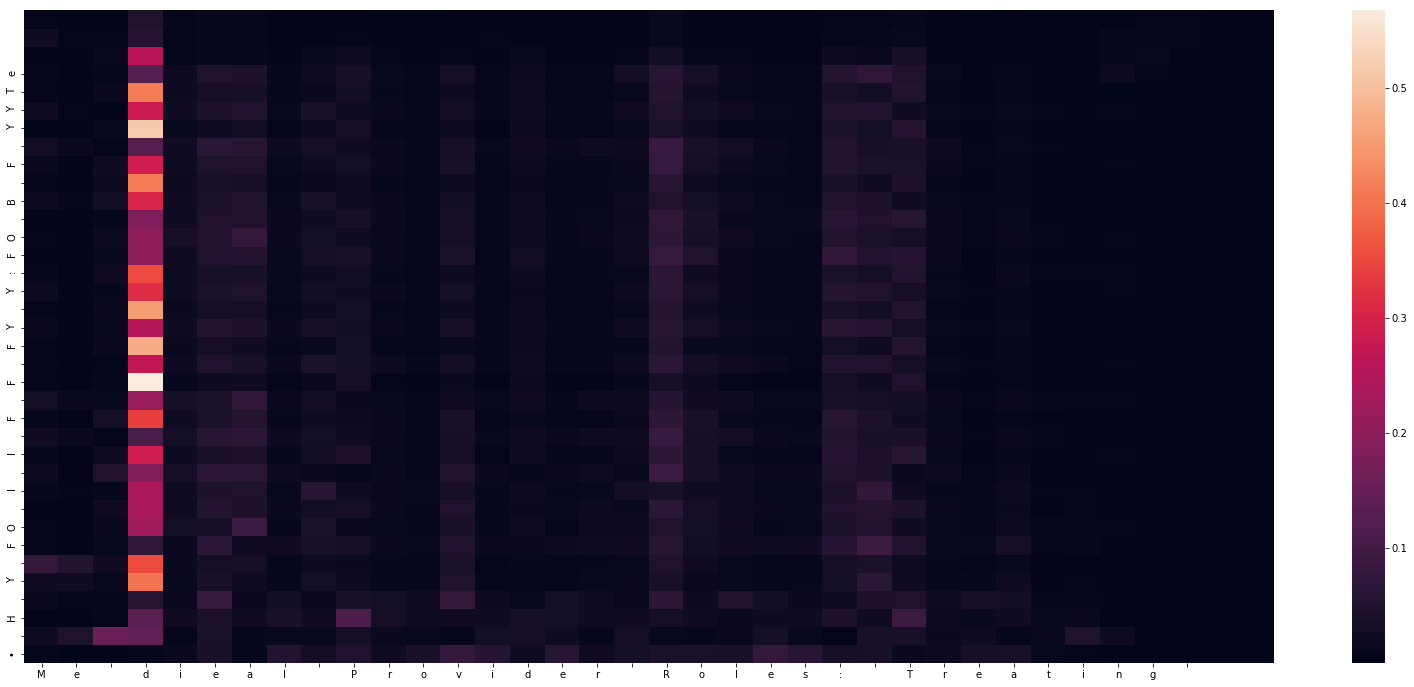

-
Input sentence: Me dieal Provider Roles: Treating 
GT sentence: Medical Provider Roles: Treating

Decoded sentence: • H Y FO I I F F FY Y:FO B F YYTe


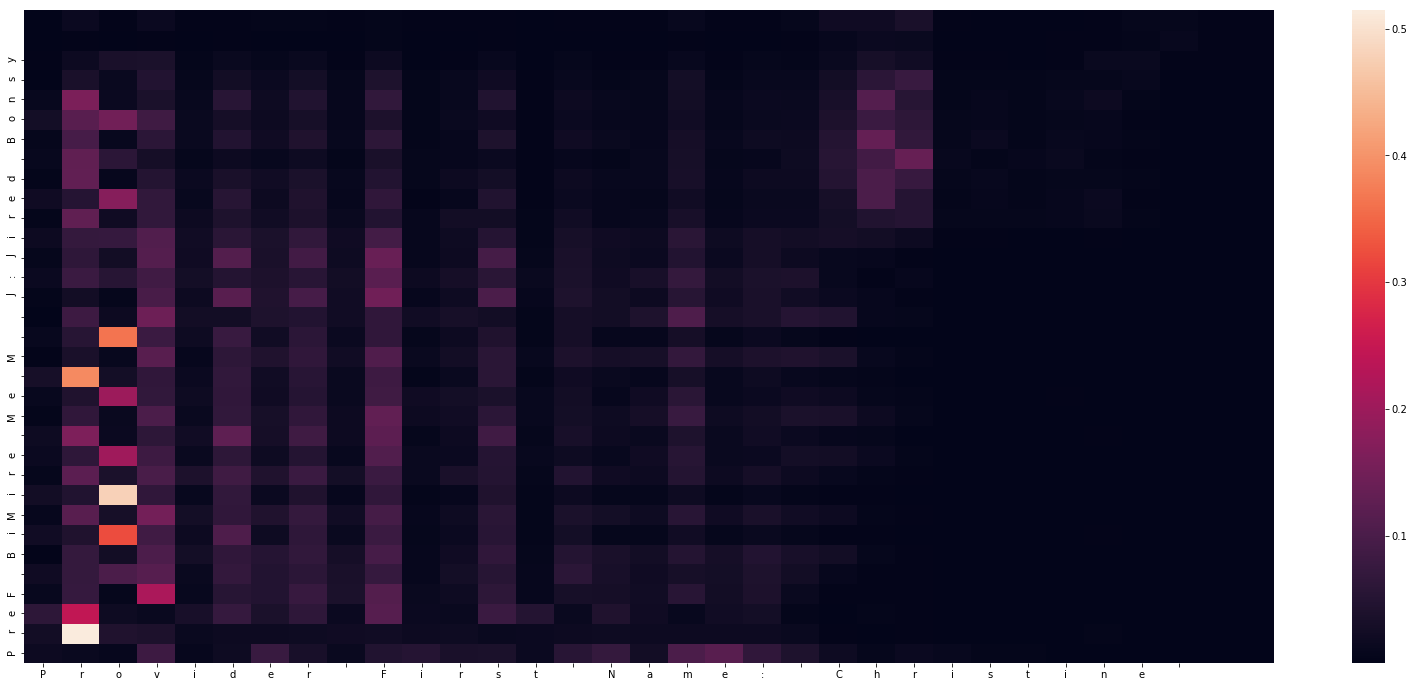

-
Input sentence: Provider First Name: Christine 
GT sentence: Provider First Name: Christine

Decoded sentence: PreF BiMire Me M  J:Jired Bonsy


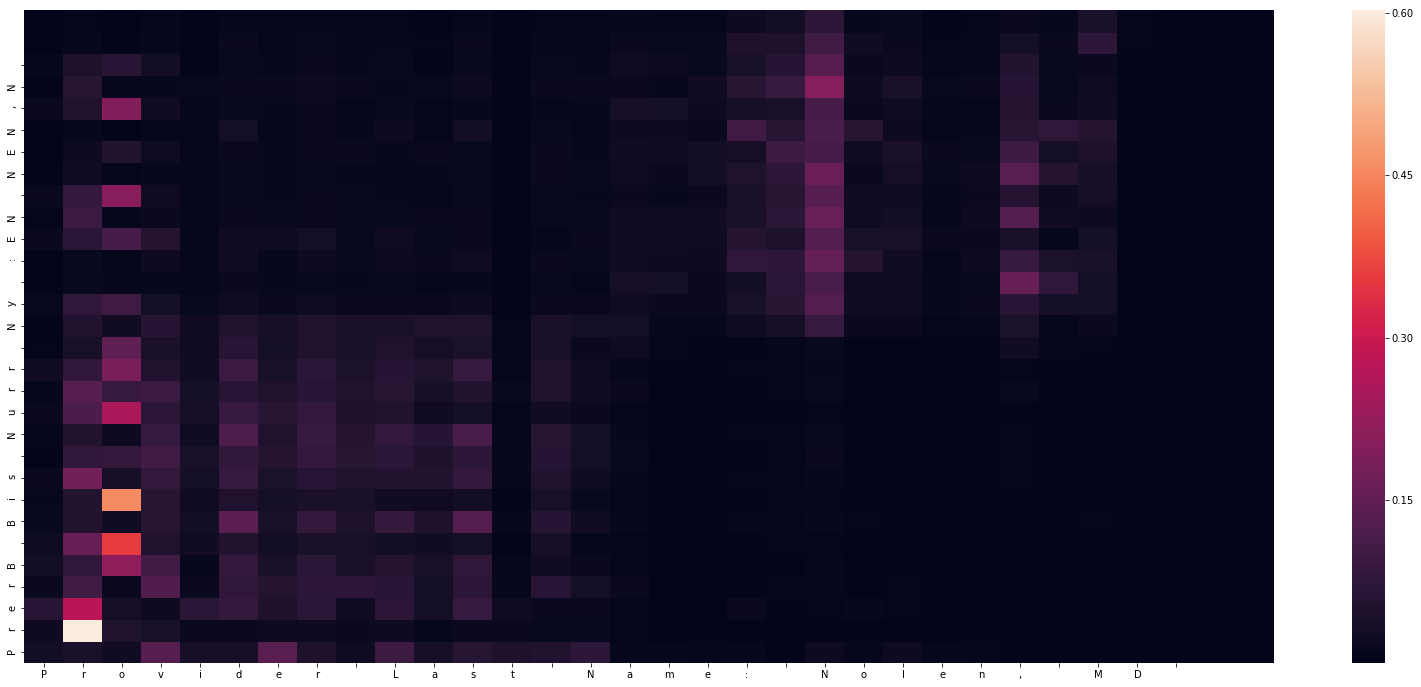

-
Input sentence: Provider Last Name: Nolen, MD 
GT sentence: Provider Last Name: Nolen, MD

Decoded sentence: PrerB Bis Nurr Ny :EN NEN,N 


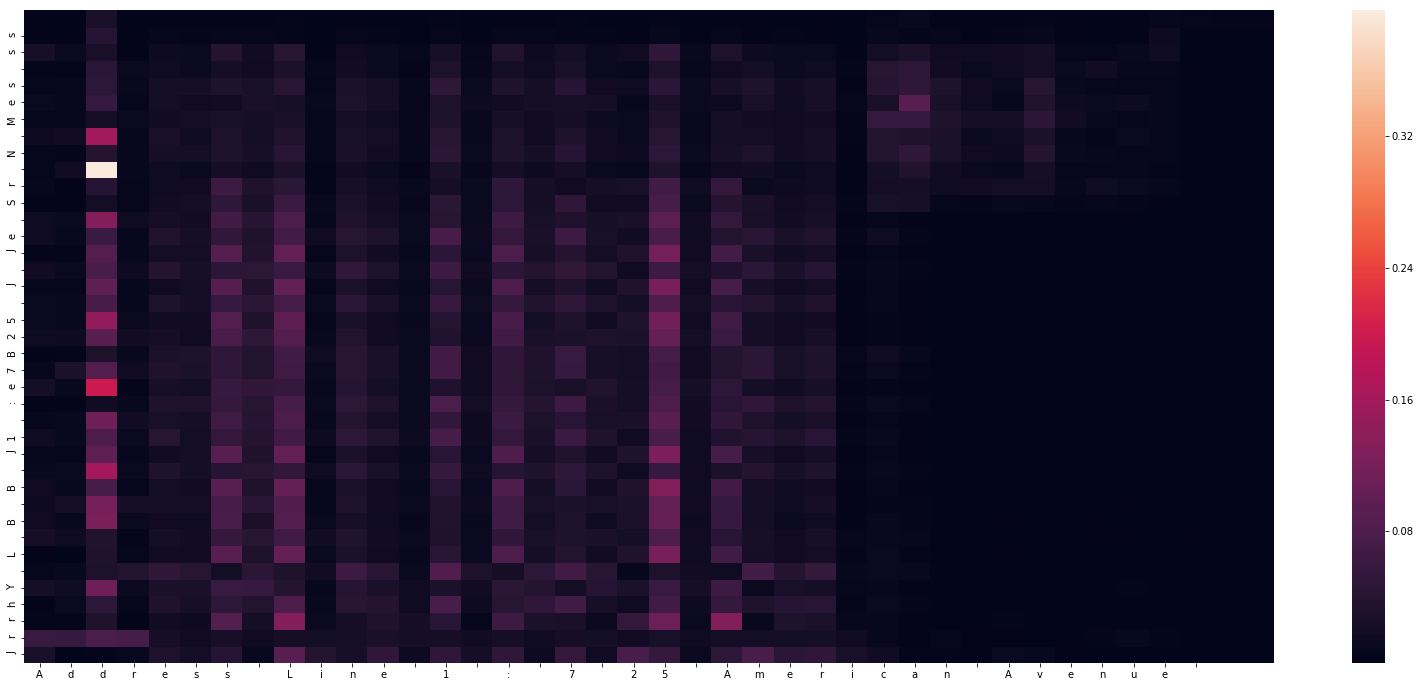

-
Input sentence: Address Line 1 : 7 25 American Avenue 
GT sentence: Address Line 1 : 725 American Avenue

Decoded sentence: JrrhY L B B J1 :e7B25 J Je Sr N Mes ss


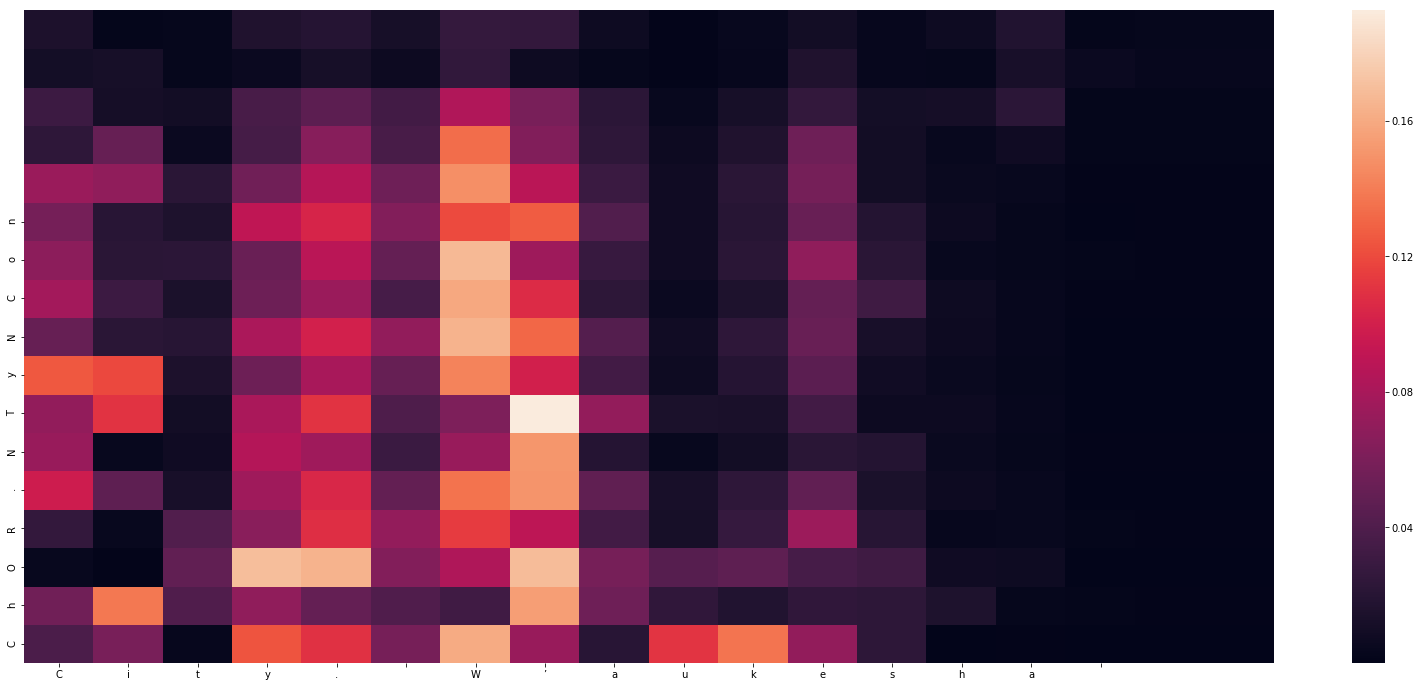

-
Input sentence: City. W’aukesha 
GT sentence: City: Waukesha

Decoded sentence: ChOR.NTyNCon


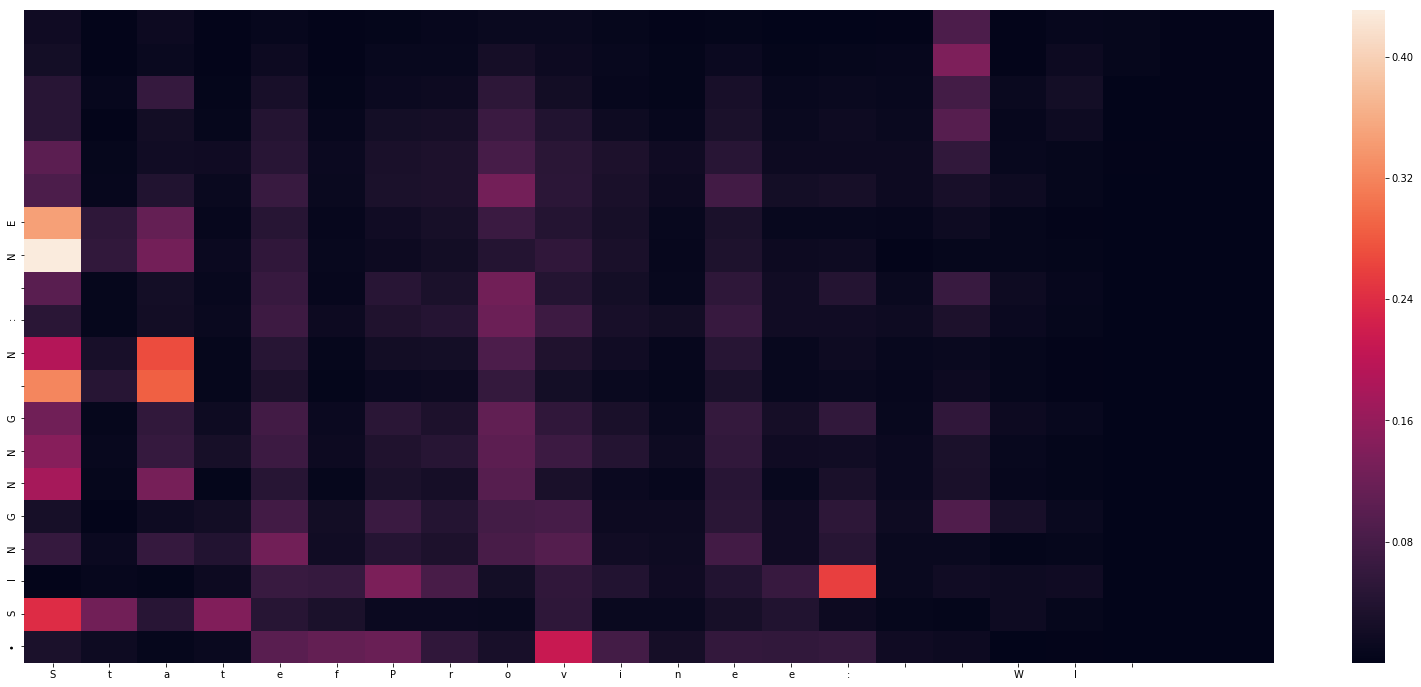

-
Input sentence: StatefProvinee: ‘WI 
GT sentence: State/Province: WI

Decoded sentence: •SINGNNG N: NE


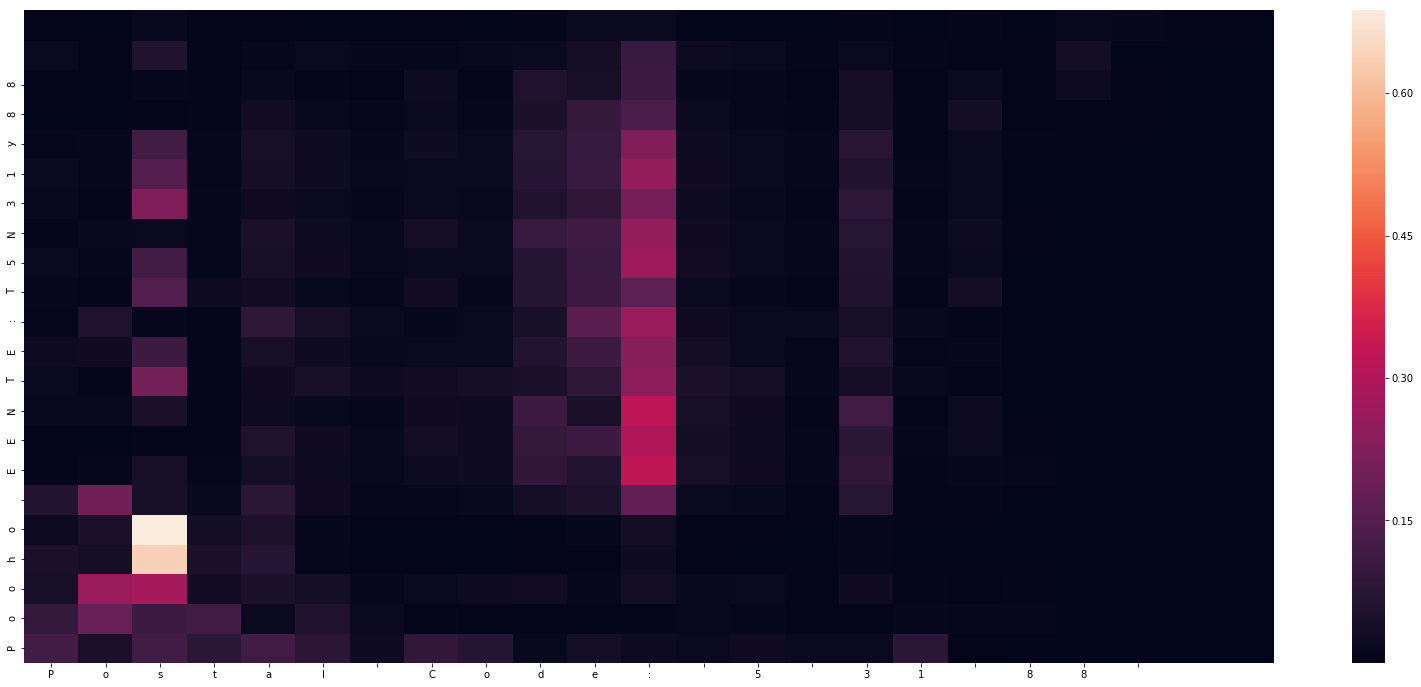

-
Input sentence: Postal Code: 5 31 88 
GT sentence: Postal Code: 53188

Decoded sentence: Pooho EENTE:T5N31y88


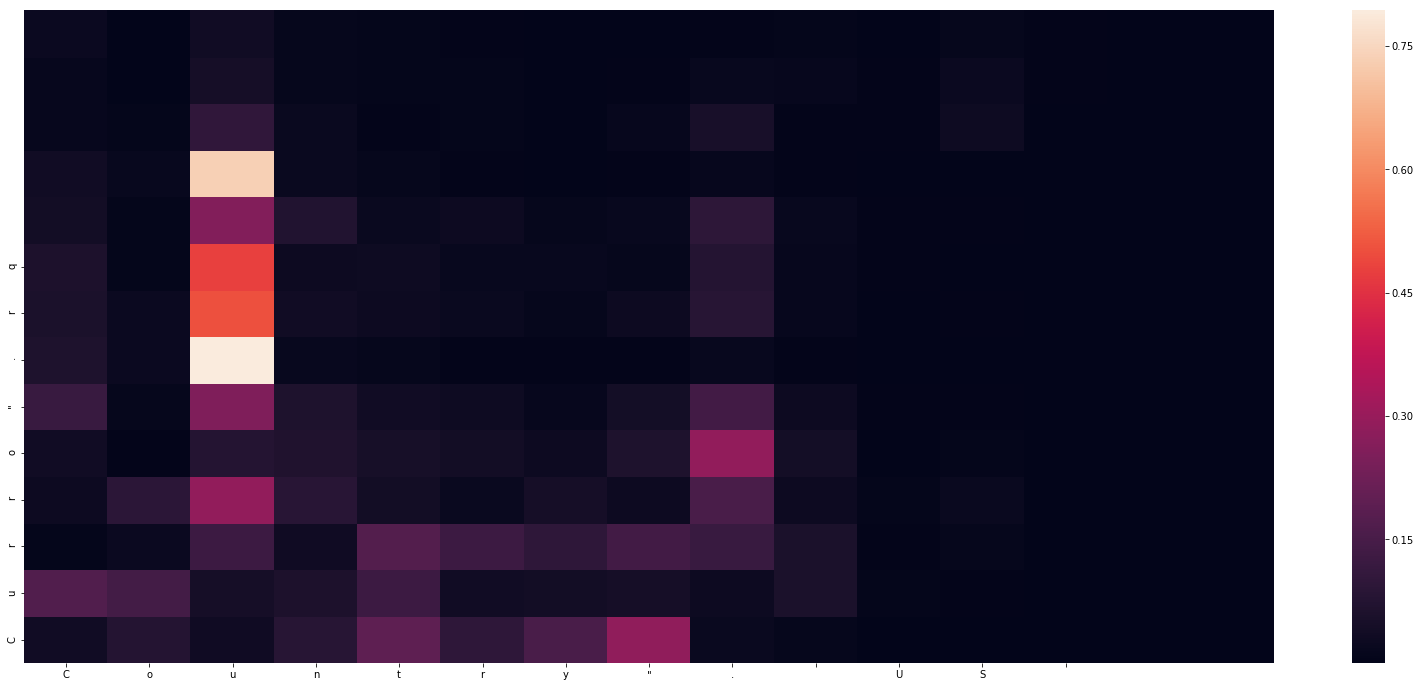

-
Input sentence: Country". US 
GT sentence: Country:  US

Decoded sentence: Curro".rq


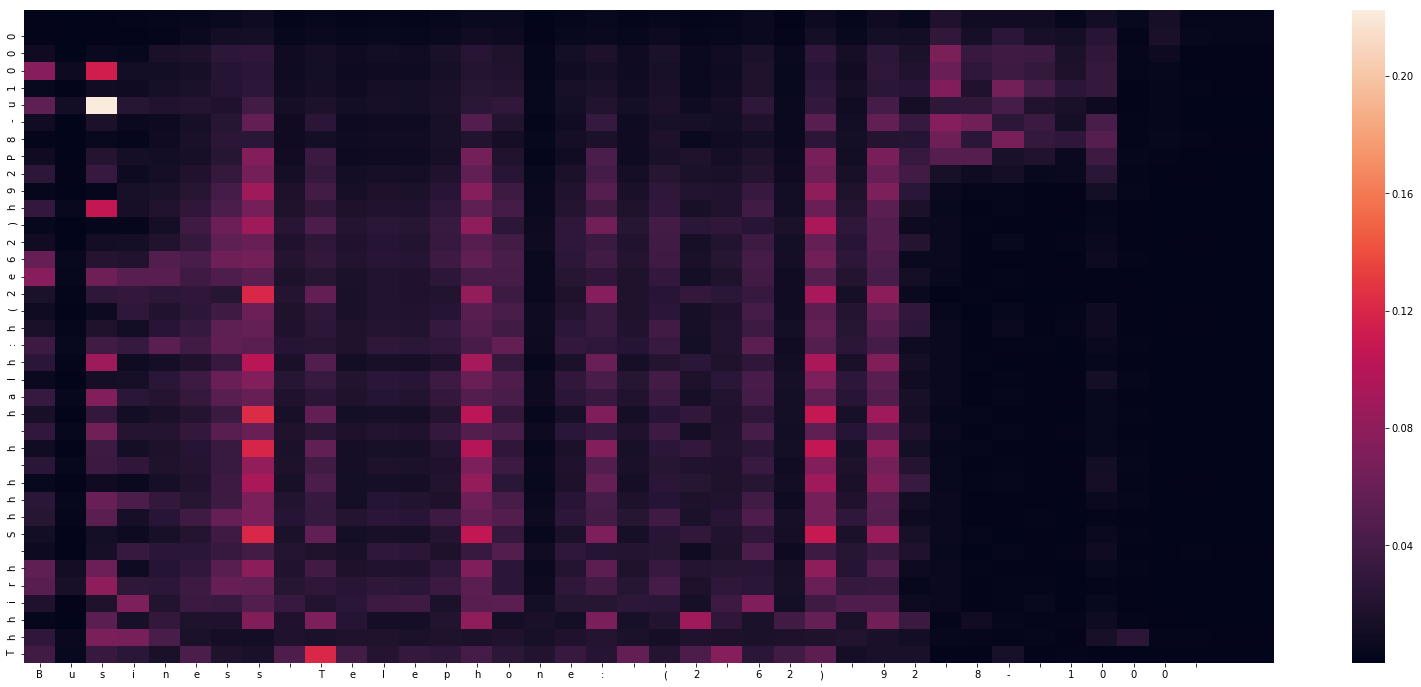

-
Input sentence: Business Telephone: (2 62) 92 8- 1000 
GT sentence: Business Telephone: (262) 928- 1000

Decoded sentence: Thhirh Shhh h halh:h(2e62)h92P8-u1000


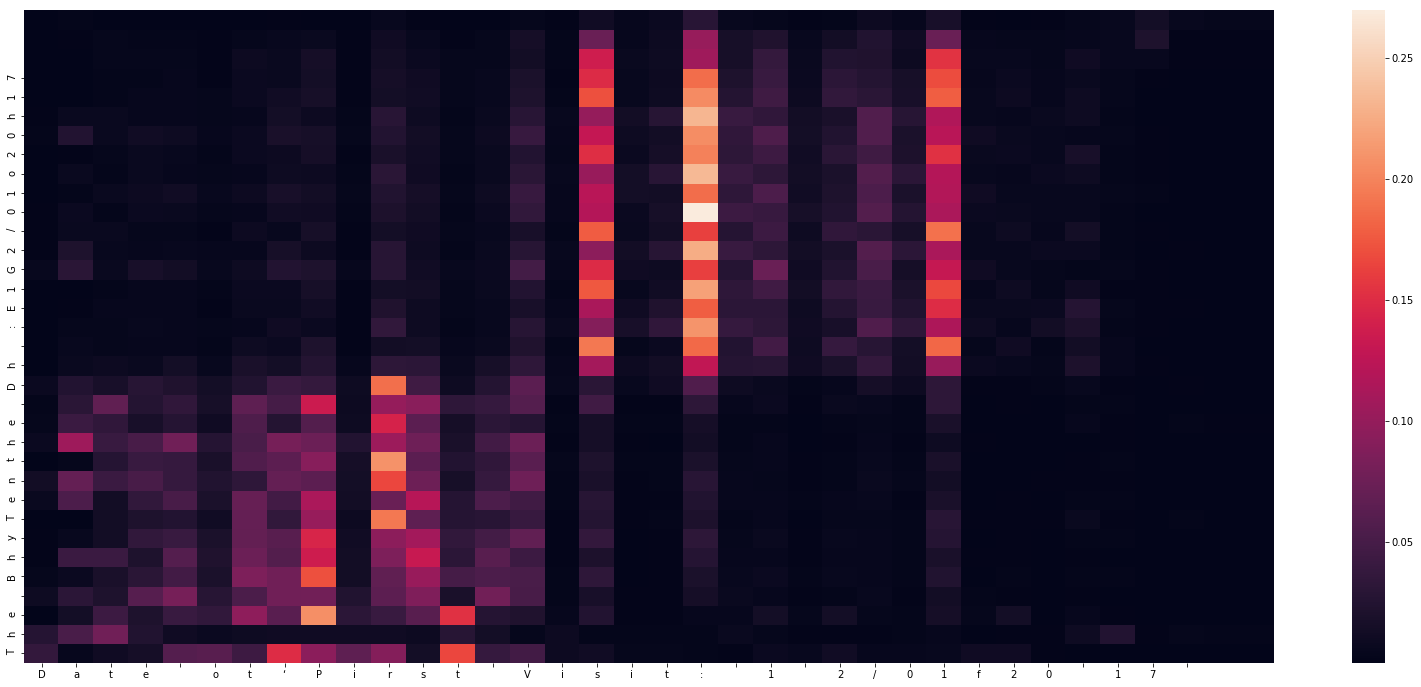

-
Input sentence: Date ot‘Pirst Visit: 1 2/01f20 17 
GT sentence: Date of First Visit: 12/01/2017

Decoded sentence: The BhyTenthe Dh :E1G2/01o20h17


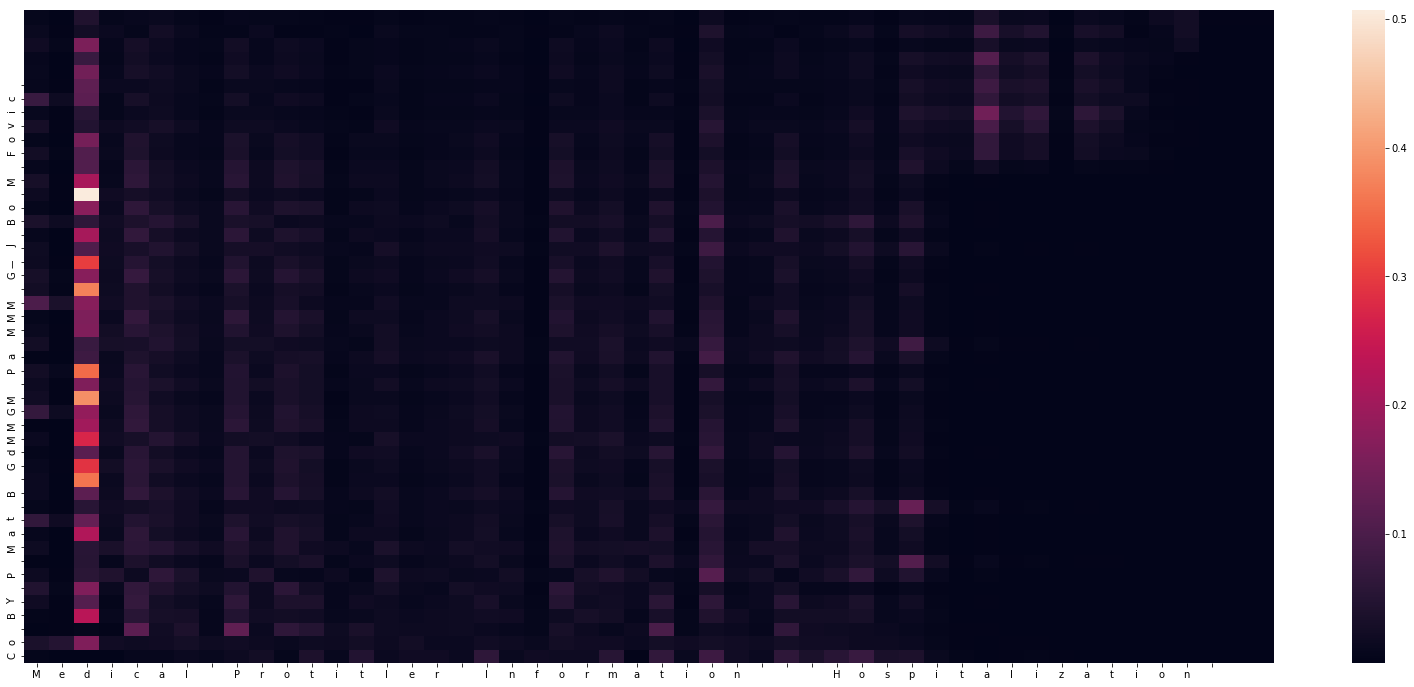

-
Input sentence: Medical Protitler Information — Hospitalization 
GT sentence: Medical Provider Information - Hospitalization

Decoded sentence: Co BY P Mat B GdMMGM Pa MMM G—J Bo M Fovic 


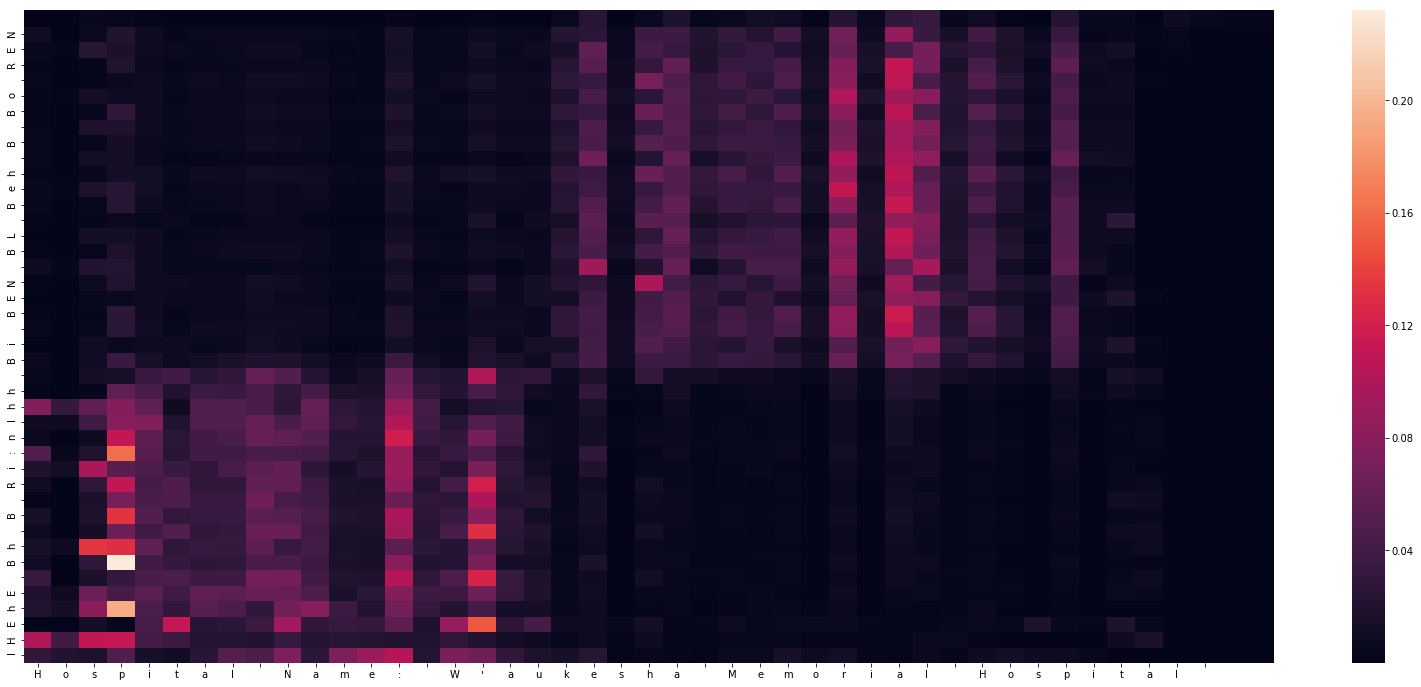

-
Input sentence: Hospital Name: W'aukesha Memorial Hospital 
GT sentence: Hospital Name: Waukesha Memorial Hospital

Decoded sentence: IHEhE Bh B Ri:nlhh Bi BEN BL Beh B Bo REN


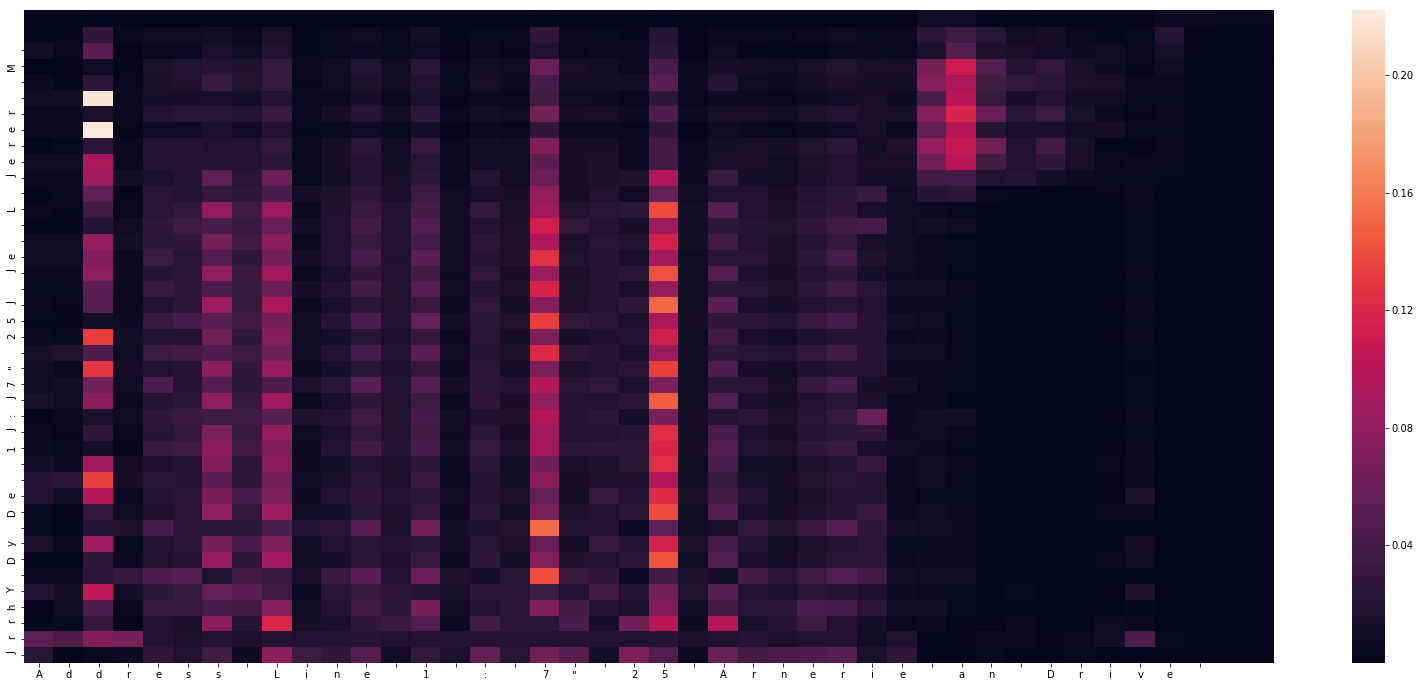

-
Input sentence: Address Line 1 : 7" 25 Arnerie an Drive 
GT sentence: Address Line 1 : 725 American Drive

Decoded sentence: JrrhY Dy De  1J:J7" 25J Je  L Jerer  M 


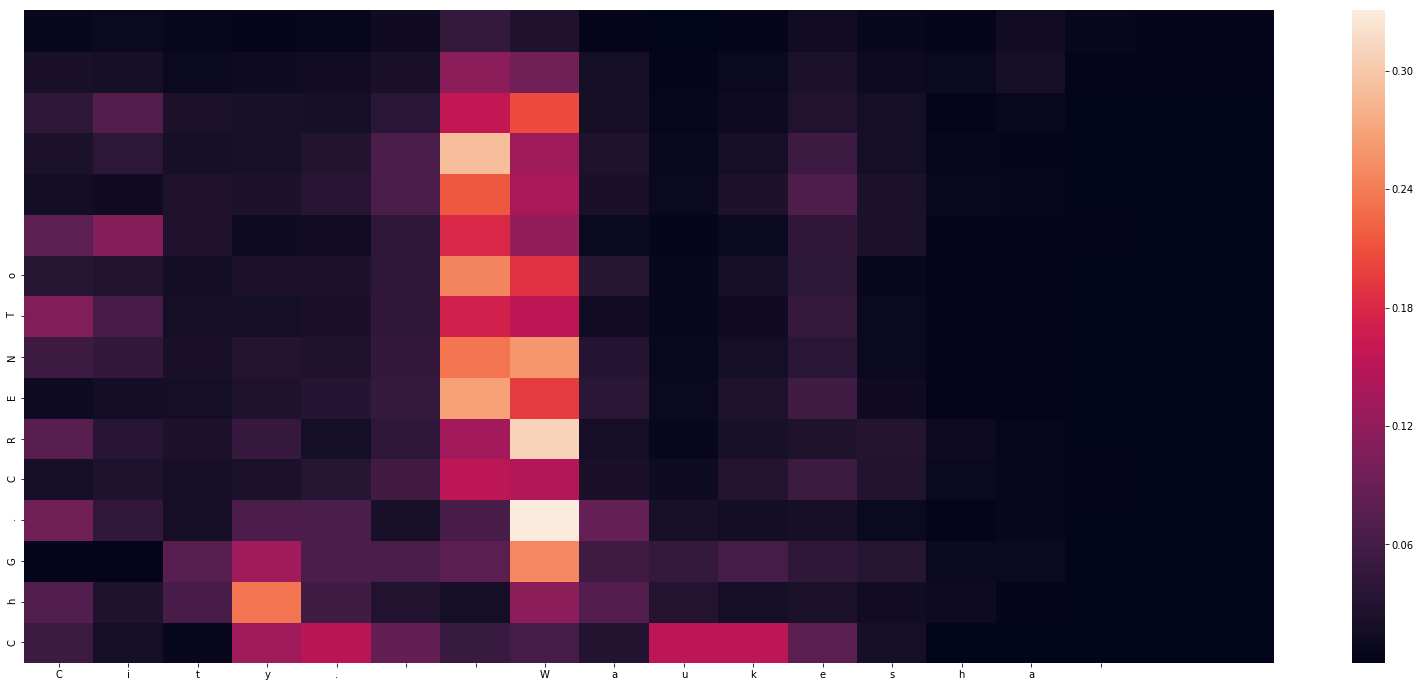

-
Input sentence: City. ‘Waukesha 
GT sentence: City: Waukesha

Decoded sentence: ChG.CRENTo


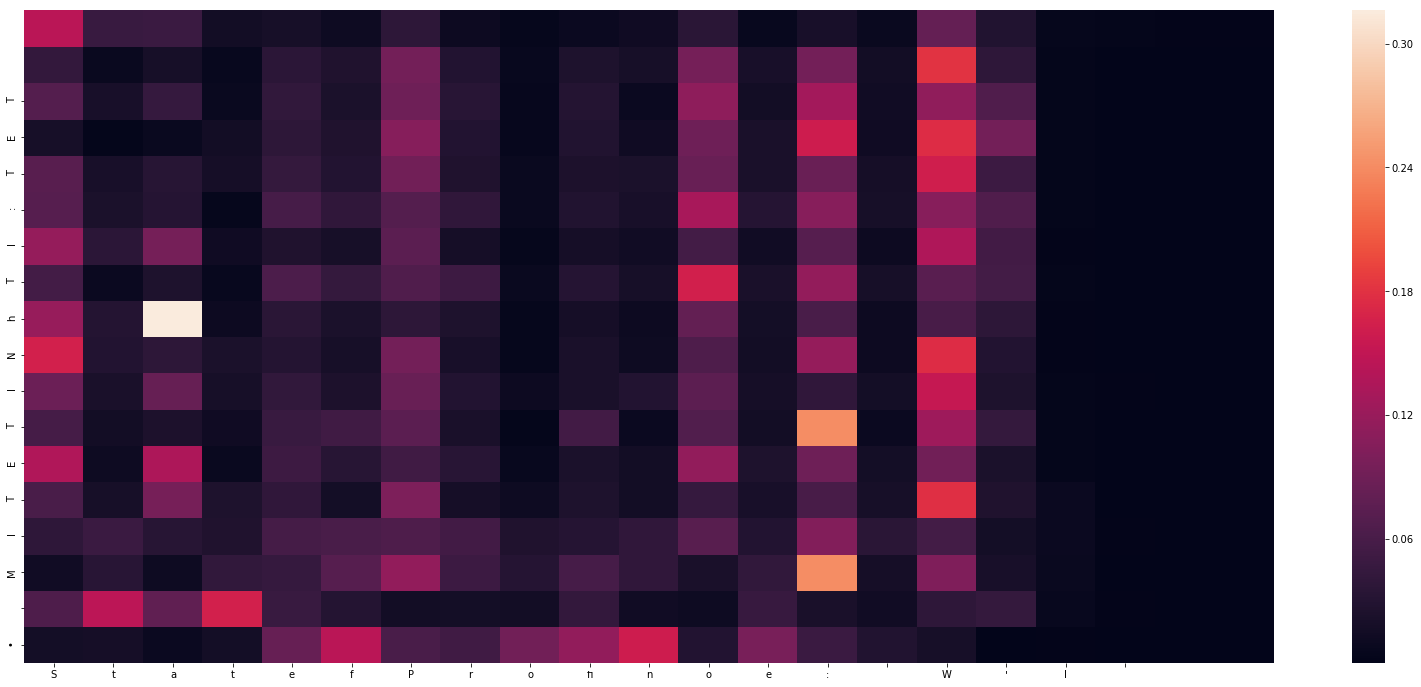

-
Input sentence: StatefProﬁnoe: W'I 
GT sentence: State/Province: WI

Decoded sentence: • MITETINhTI:TET


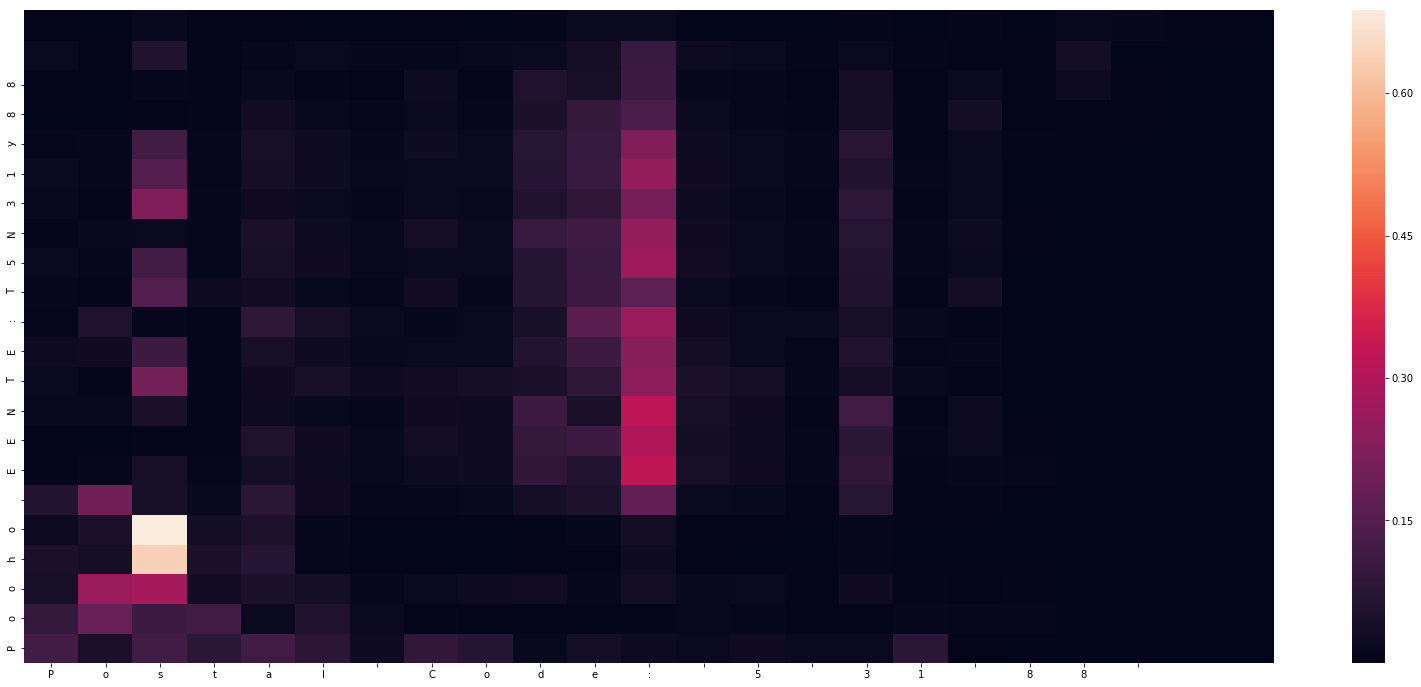

-
Input sentence: Postal Code: 5 31 88 
GT sentence: Postal Code: 53188

Decoded sentence: Pooho EENTE:T5N31y88


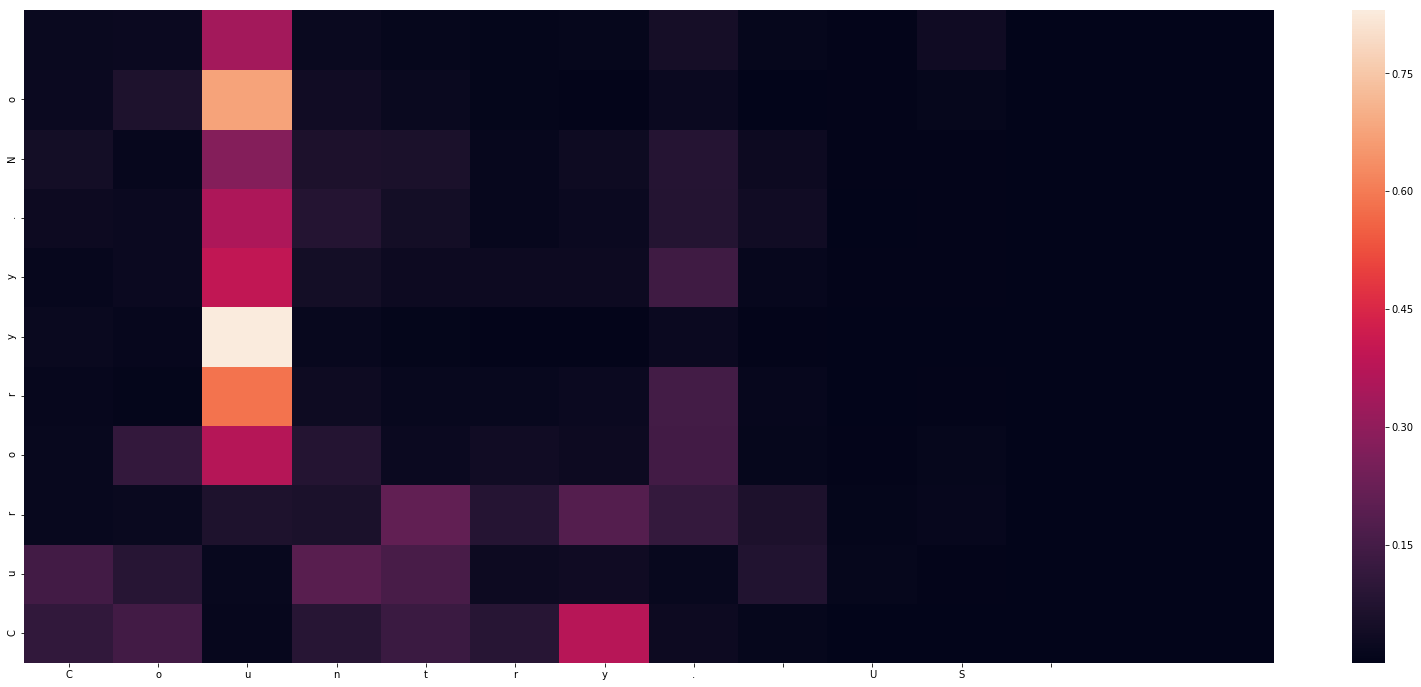

-
Input sentence: Country. US 
GT sentence: Country: US

Decoded sentence: Curoryy.No


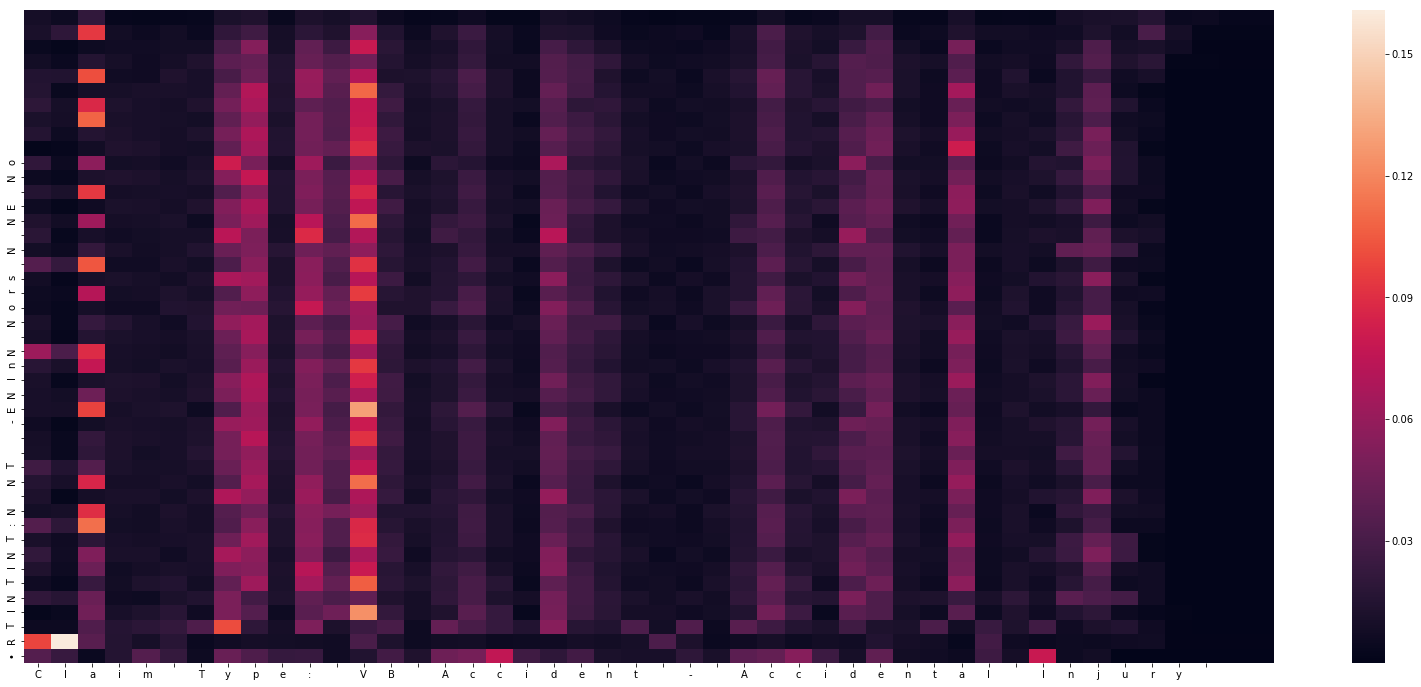

-
Input sentence: Claim Type: VB Accident - Accidental Injury 
GT sentence: Claim Type: VB Accident - Accidental Injury

Decoded sentence: •RTINTINT:N NT  -ENInN Nors N NE No


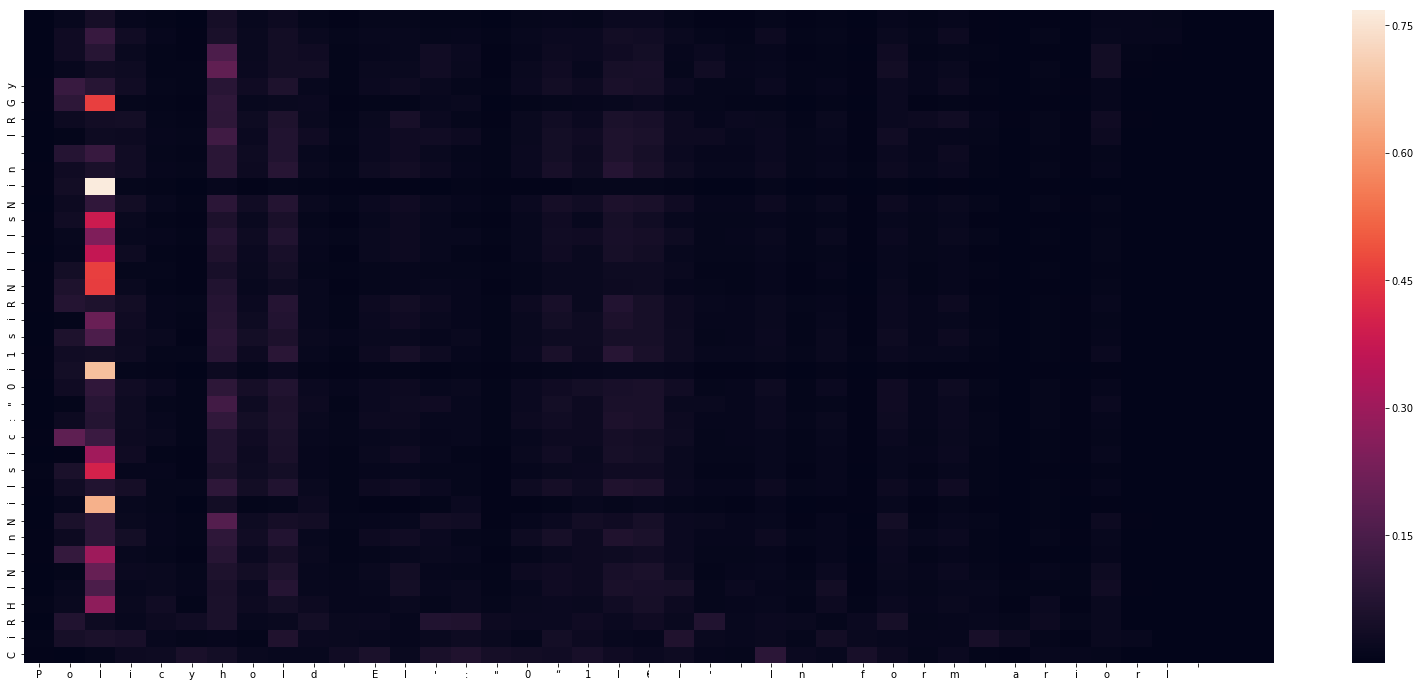

-
Input sentence: Policyhold El':"0“1l€l' In form ariorl 
GT sentence: Policyholder/Owner Information

Decoded sentence: CiRHINInNilsic:"0i1siRNlllsNin IRGy


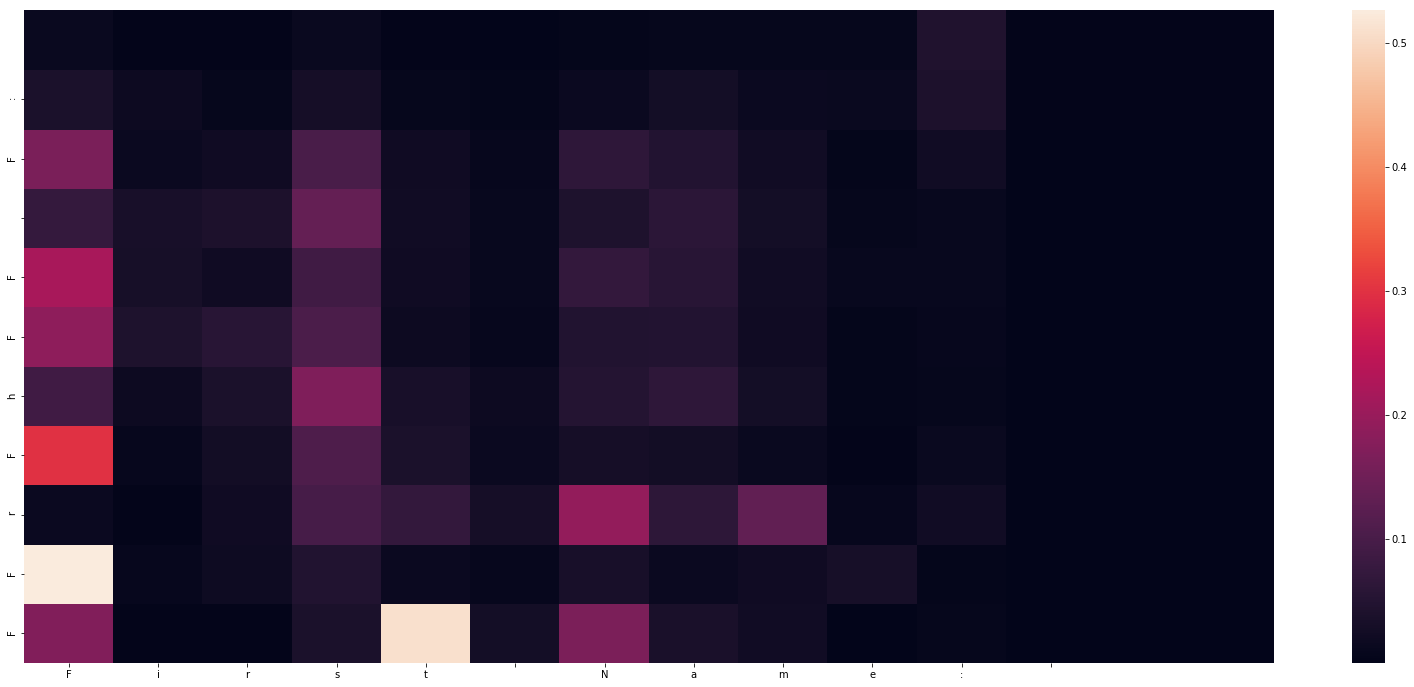

-
Input sentence: First Name: 
GT sentence: First Name:

Decoded sentence: FFrFhFF F:


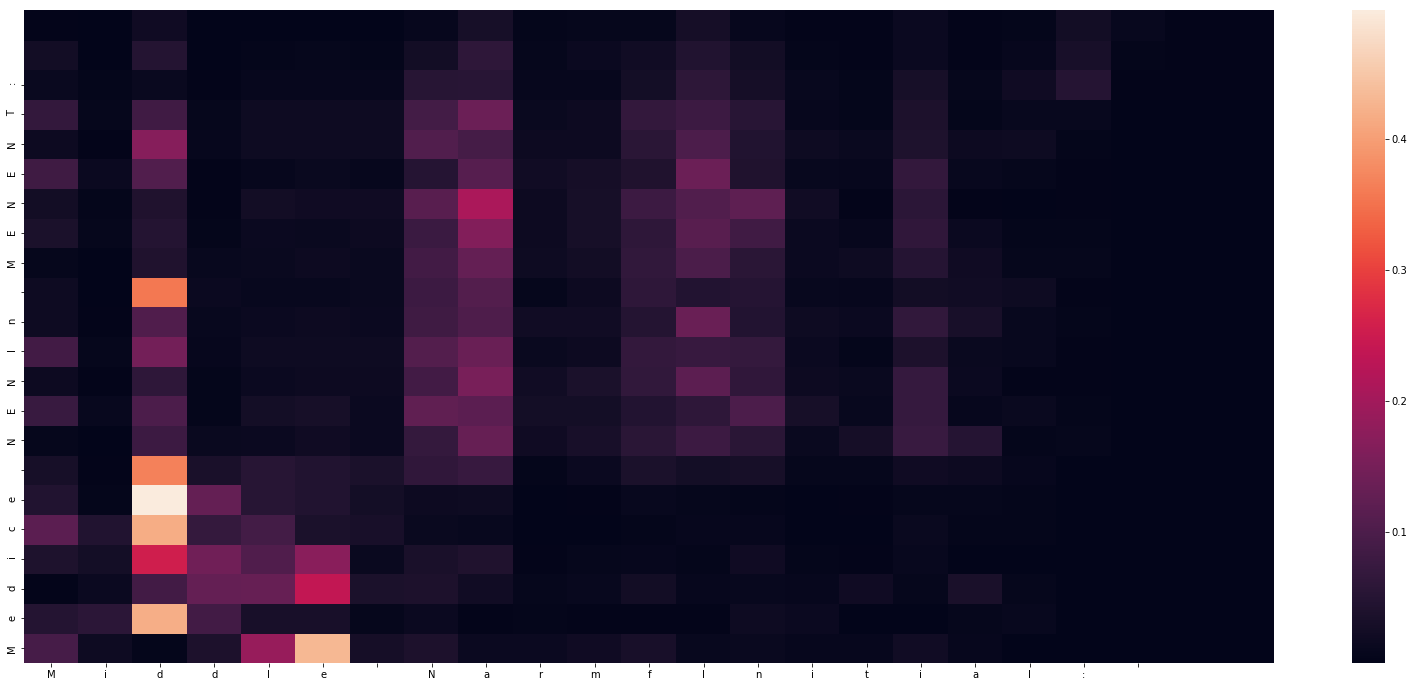

-
Input sentence: Middle Narmflnitial: 
GT sentence: Middle Name/Initial:

Decoded sentence: Medice NENIn MENENT:


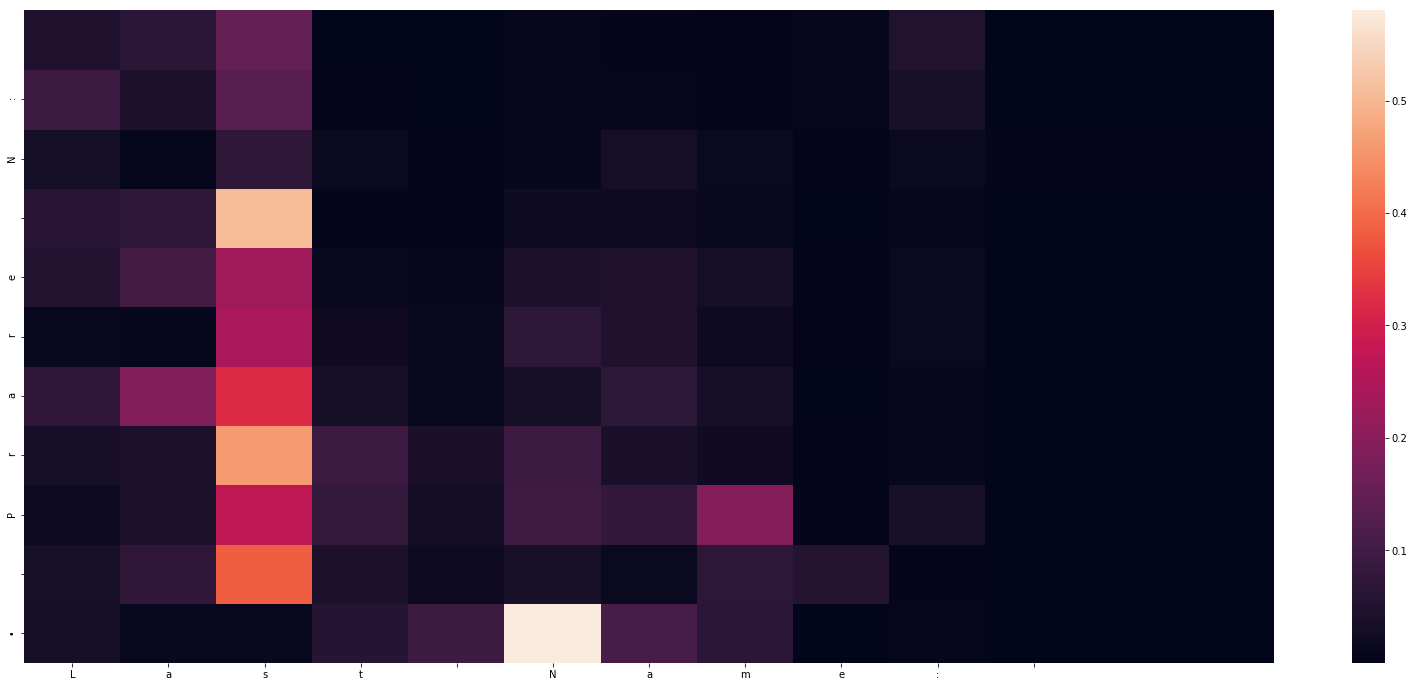

-
Input sentence: Last Name: 
GT sentence: Last Name:

Decoded sentence: • Prare N:


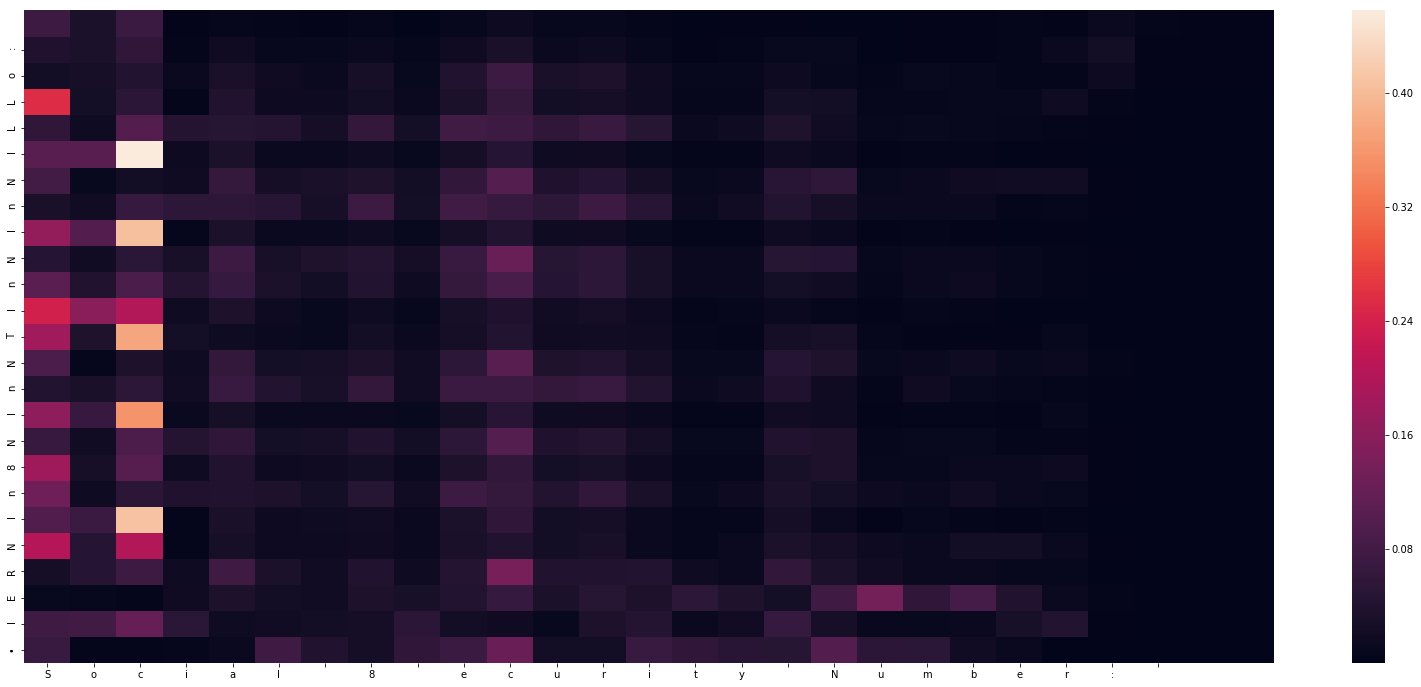

-
Input sentence: Social 8 ecurity Number: 
GT sentence: Social Security Number:

Decoded sentence: •IERNIn8NInNTInNInNILLo:


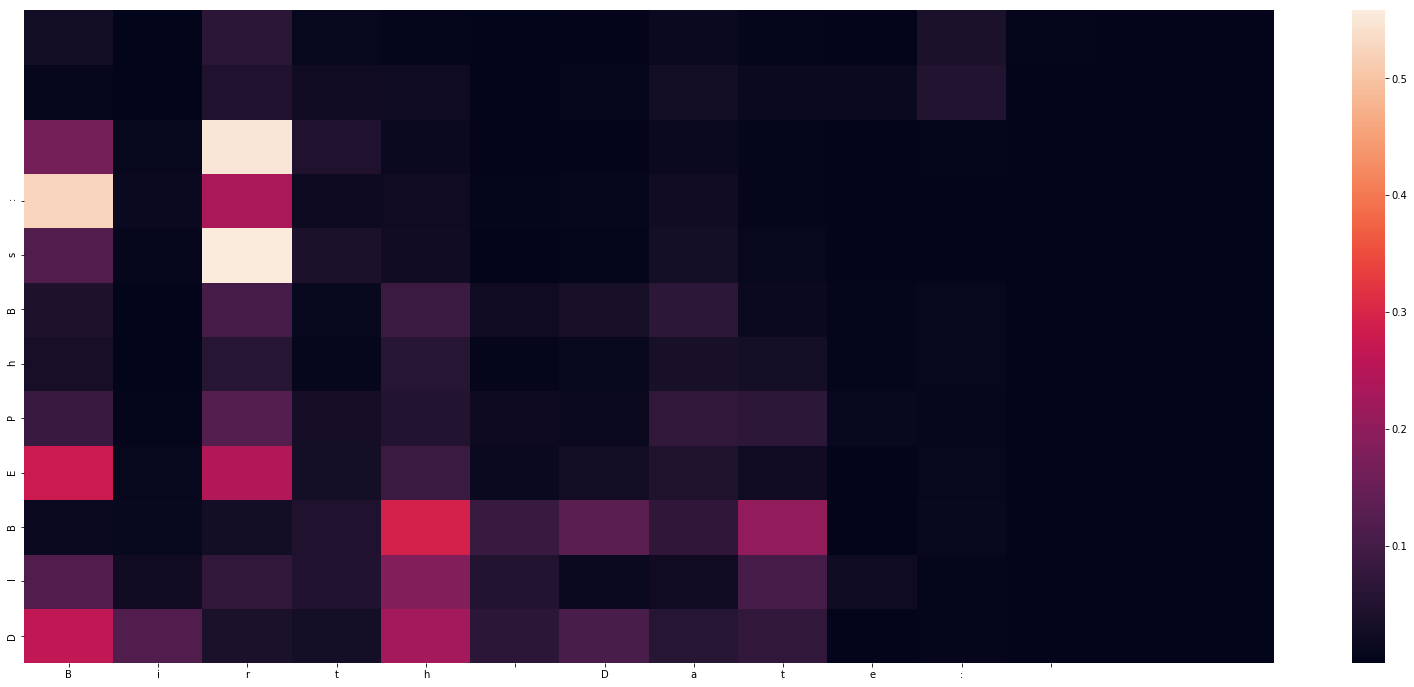

-
Input sentence: Birth Date: 
GT sentence: Birth Date:

Decoded sentence: DIBEPhBs:


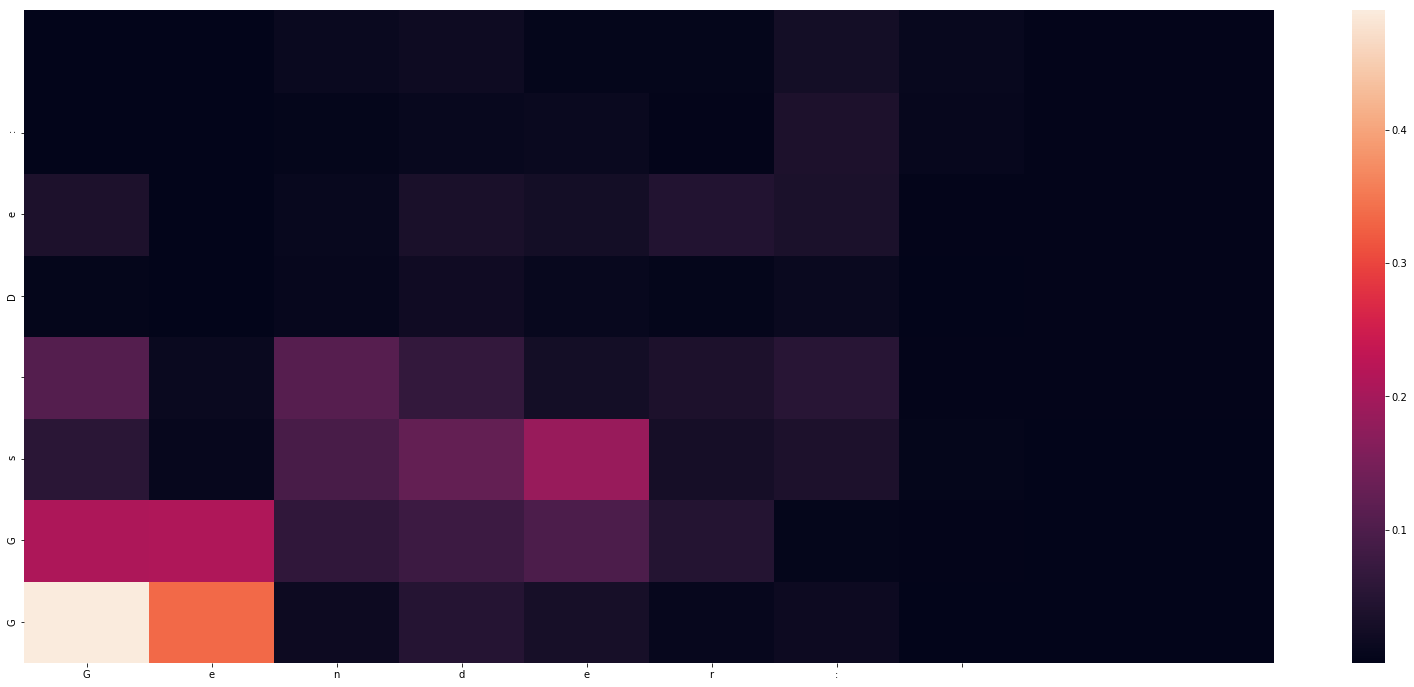

-
Input sentence: Gender: 
GT sentence: Gender:

Decoded sentence: GGs De:


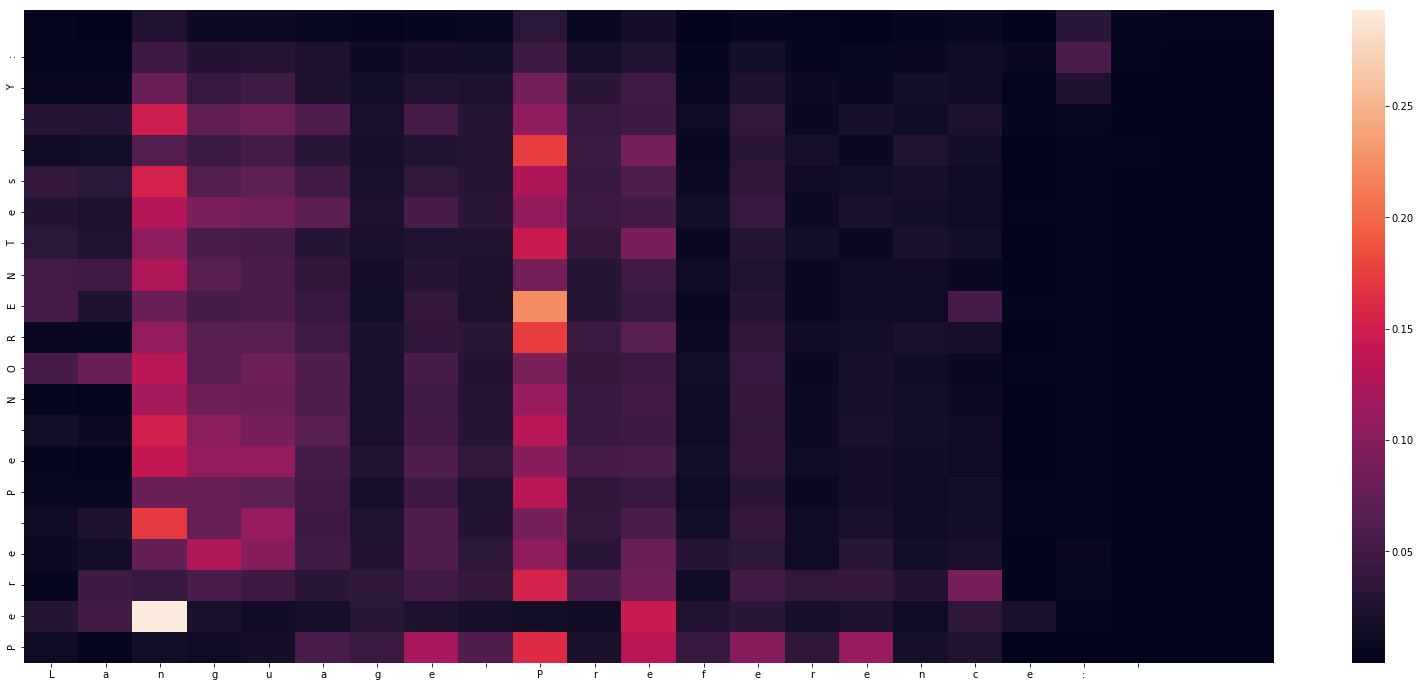

-
Input sentence: Language Preference: 
GT sentence: Language Preference:

Decoded sentence: Pere Pe NORENTes  Y:


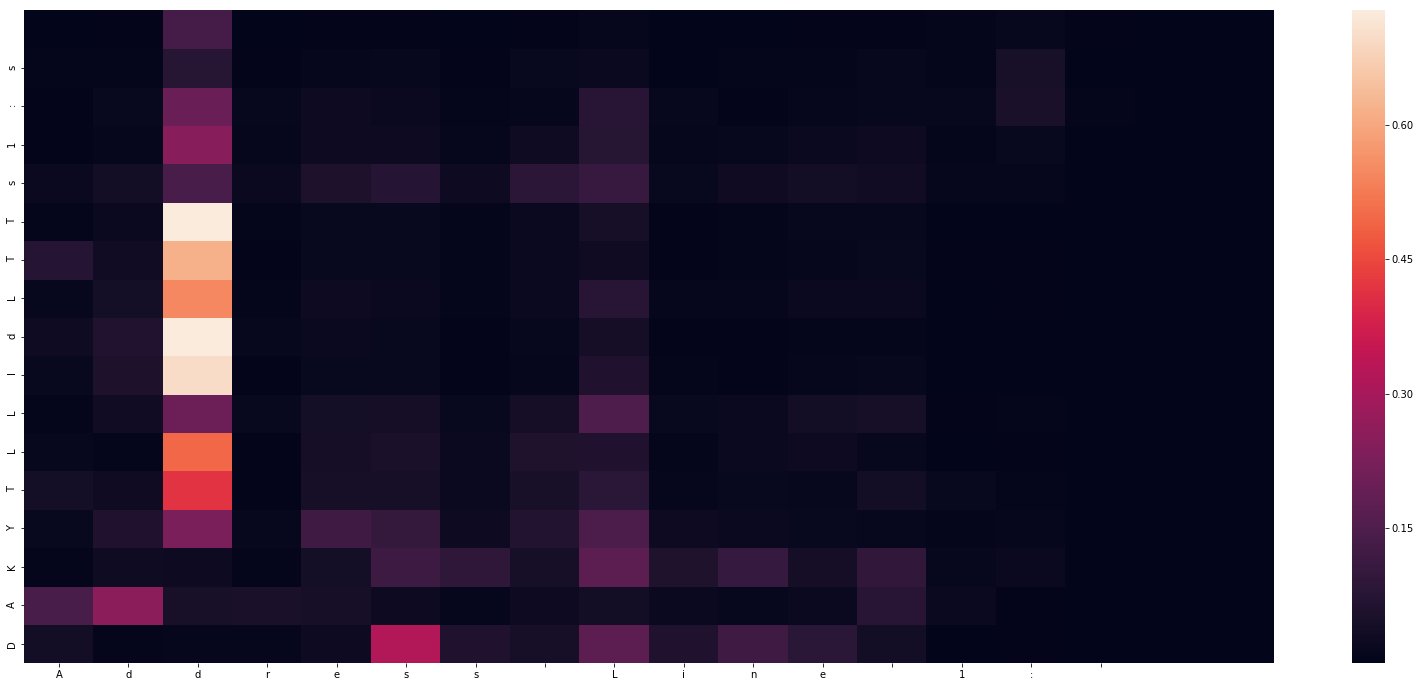

-
Input sentence: Address Line 1: 
GT sentence: Address Line 1:

Decoded sentence: DAKYTLLIdLTTs1:s


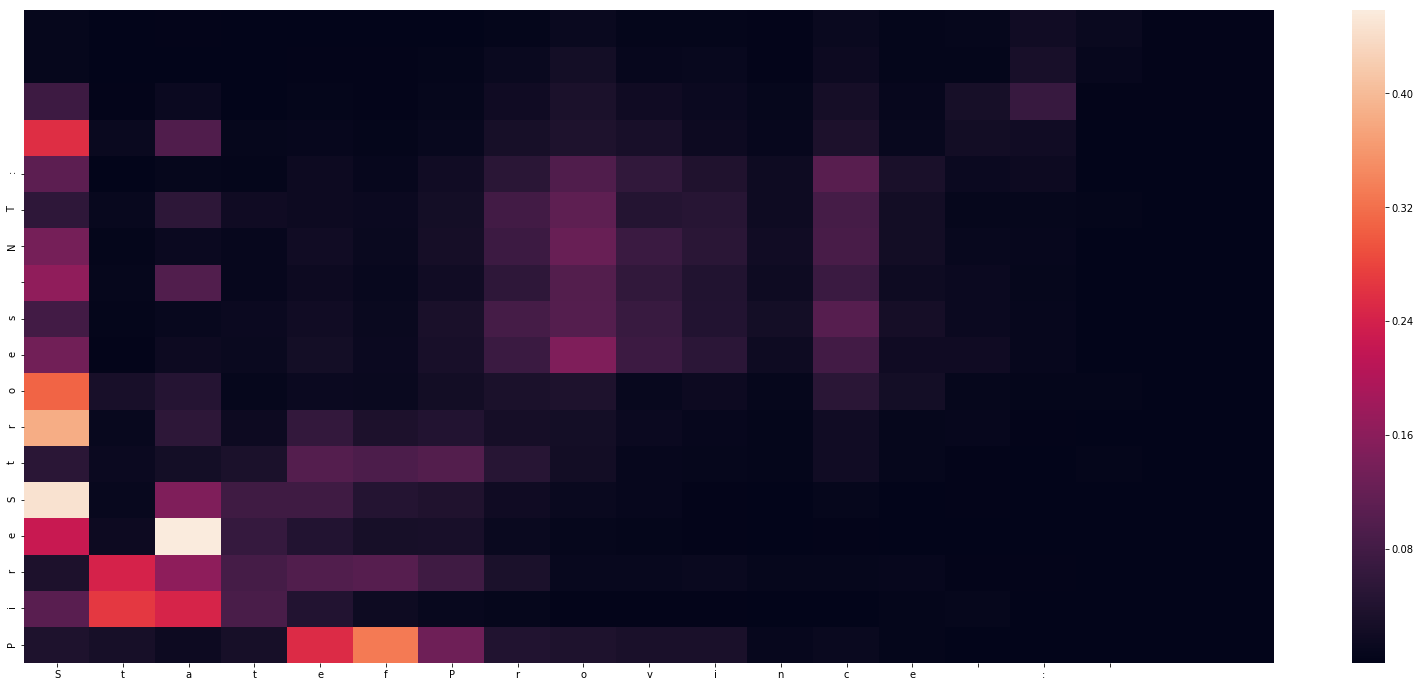

-
Input sentence: StatefProvince : 
GT sentence: State/Province:

Decoded sentence: PireStroes NT:


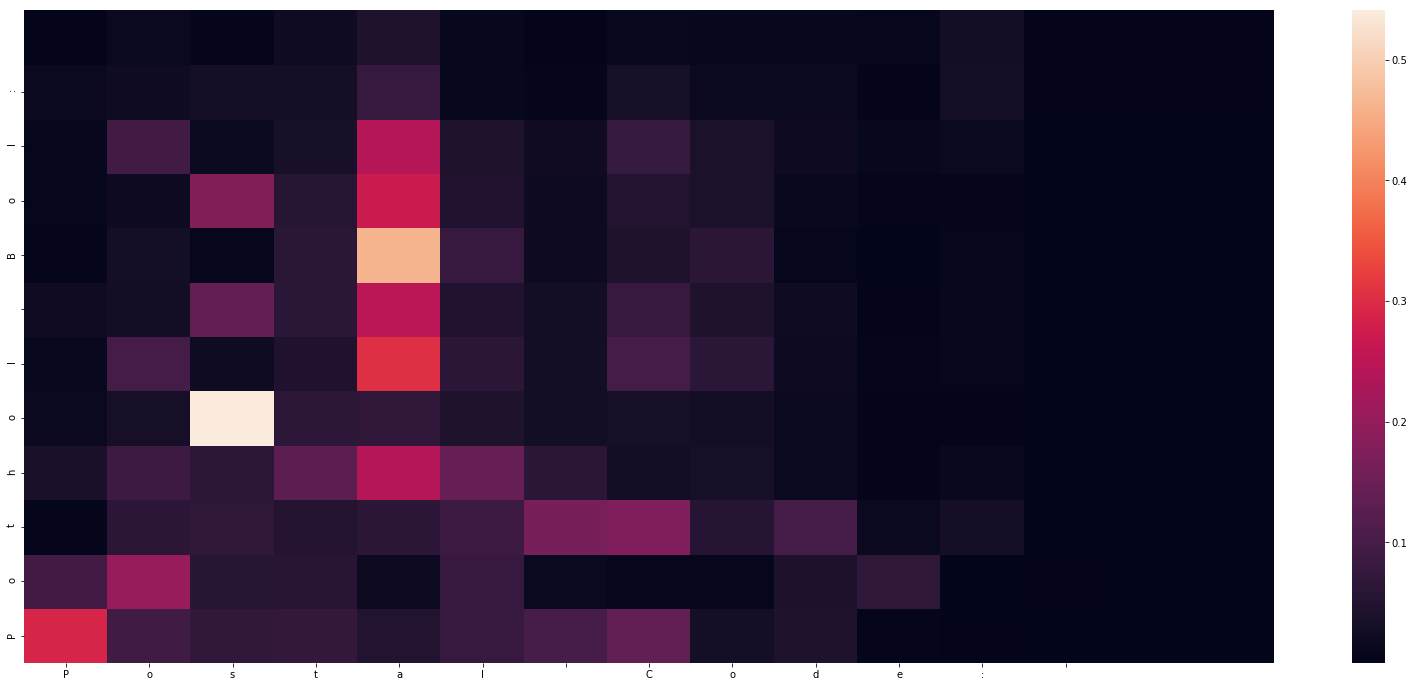

-
Input sentence: Postal Code: 
GT sentence: Postal Code:

Decoded sentence: Pothol Bol:


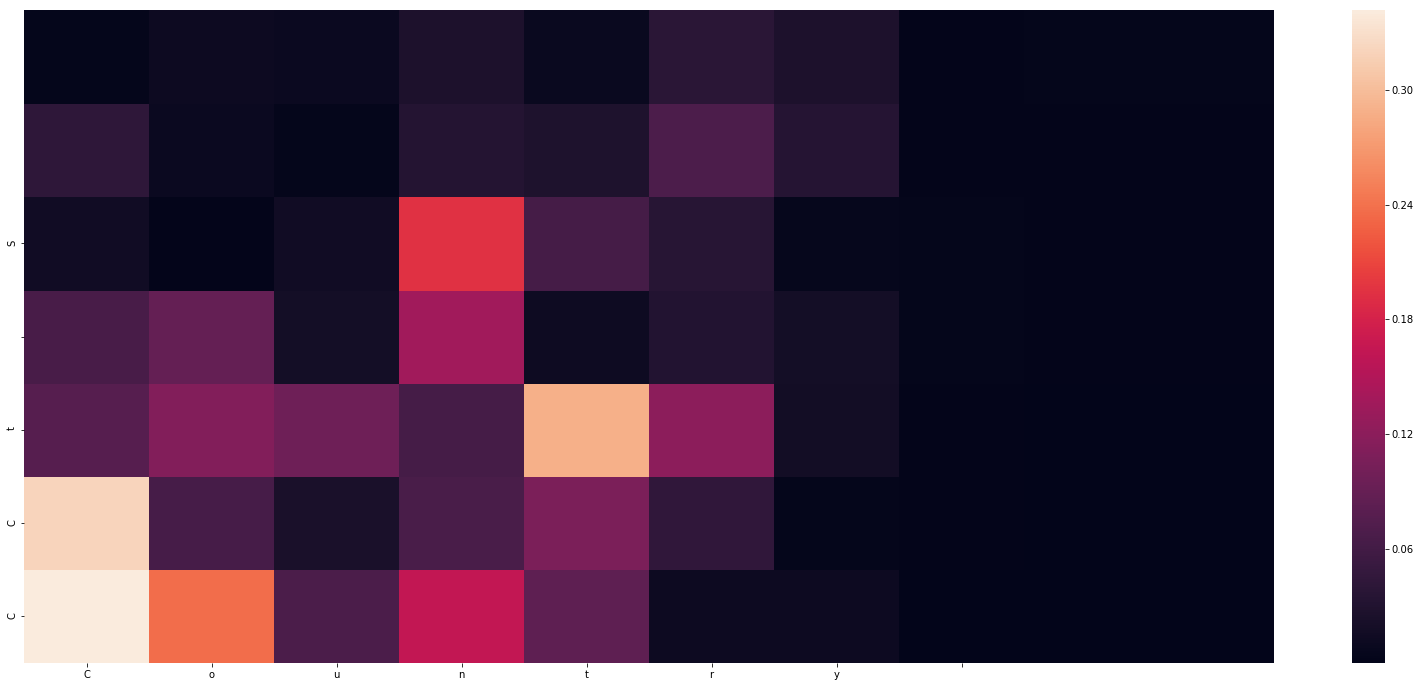

-
Input sentence: Country 
GT sentence: Country:

Decoded sentence: CCt S


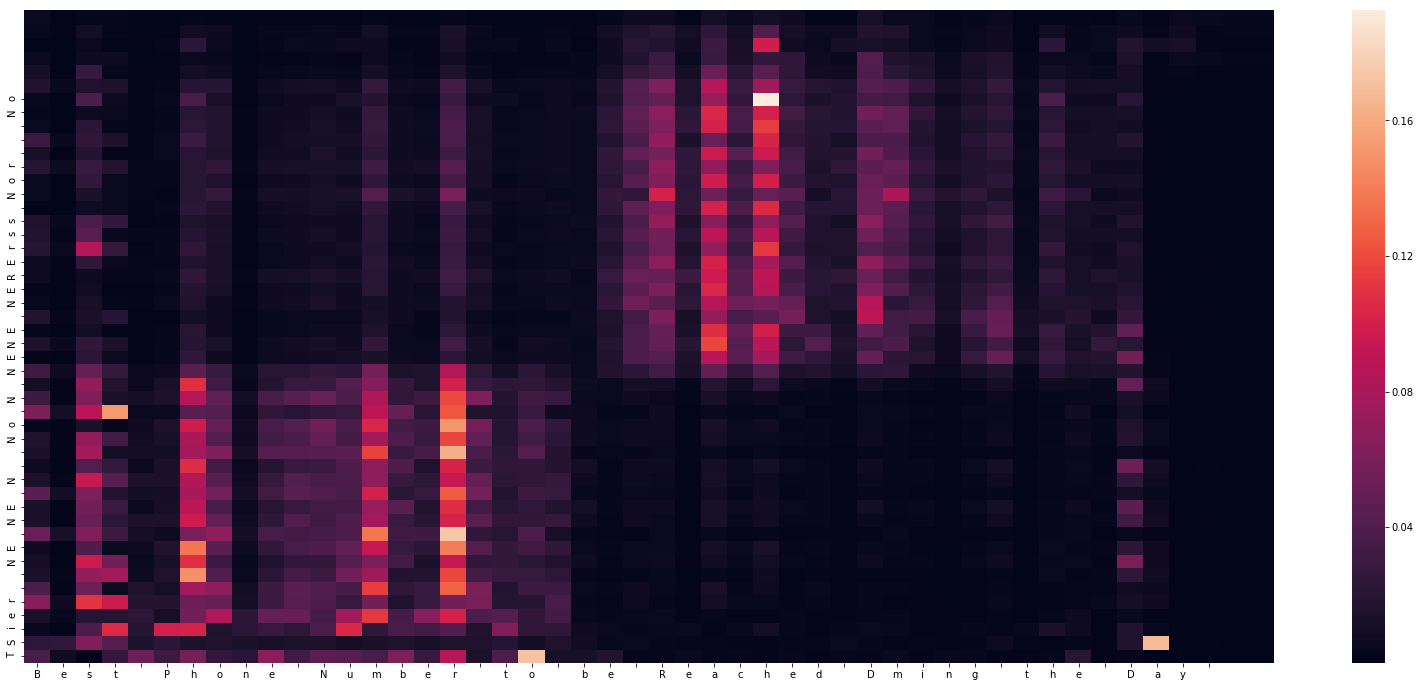

-
Input sentence: Best Phone Number to be Reached Dming the Day 
GT sentence: Best Phone Number to be Reached During the Day

Decoded sentence: TSier  NE NE N  No N NENE NERErss Nor   No


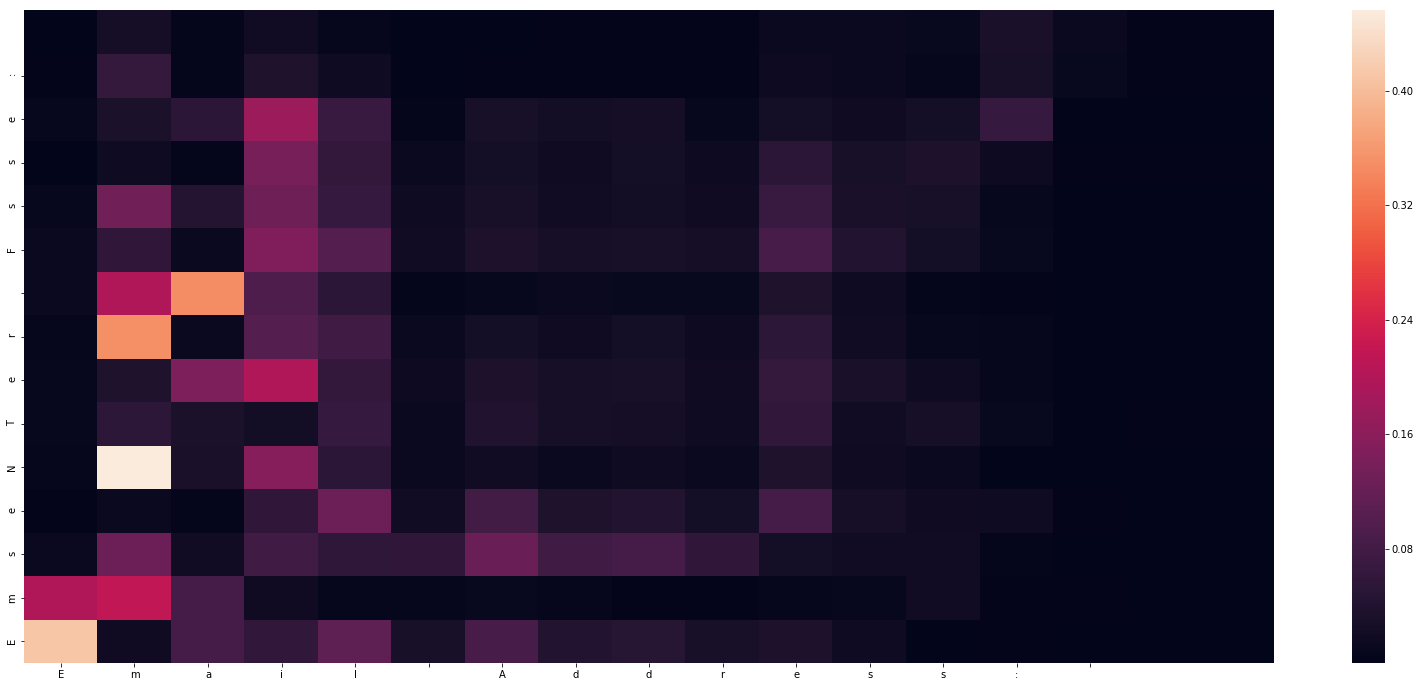

-
Input sentence: Email Address: 
GT sentence: Email Address:

Decoded sentence: EmseNTer Fsse:


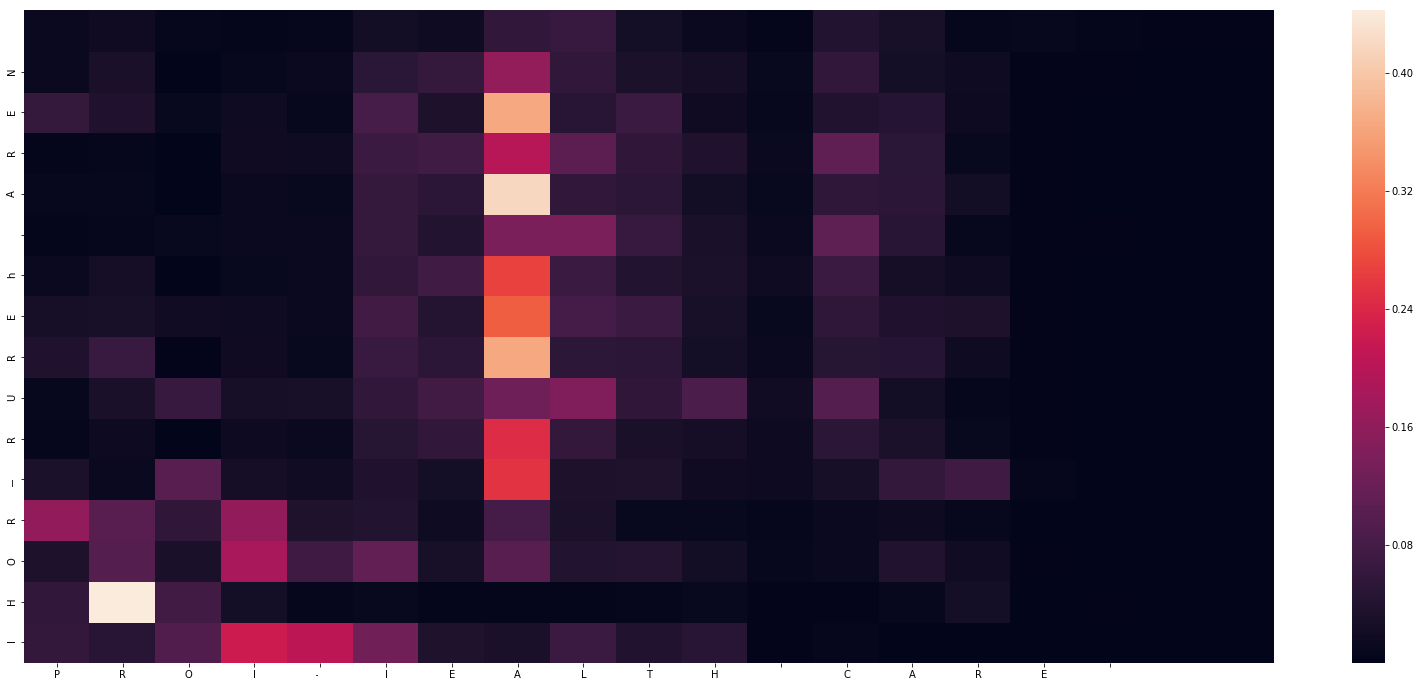

-
Input sentence: PROI—IEALTH CARE 
GT sentence: PROHEALTH CARE

Decoded sentence: IHOR—RUREh AREN


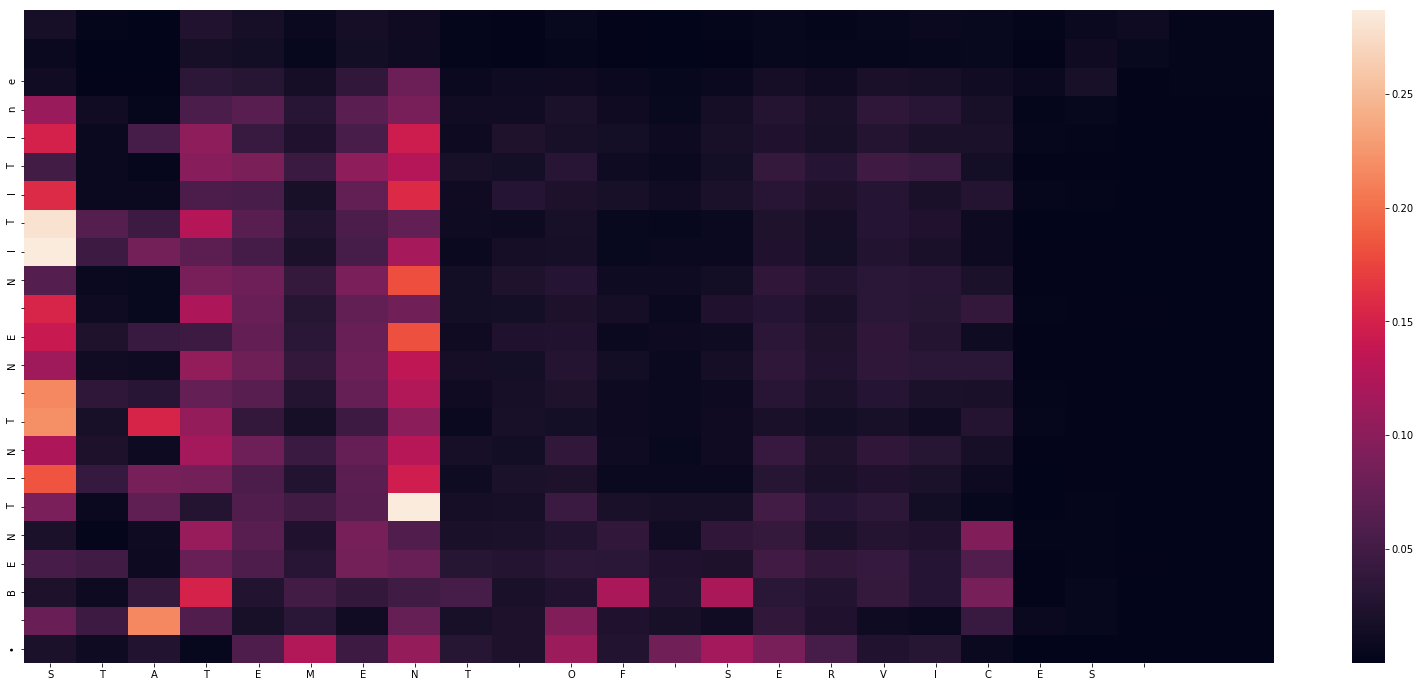

-
Input sentence: STATEMENT OF SERVICES 
GT sentence: STATEMENT OF SERVICES

Decoded sentence: • BENTINT NE NITITIne


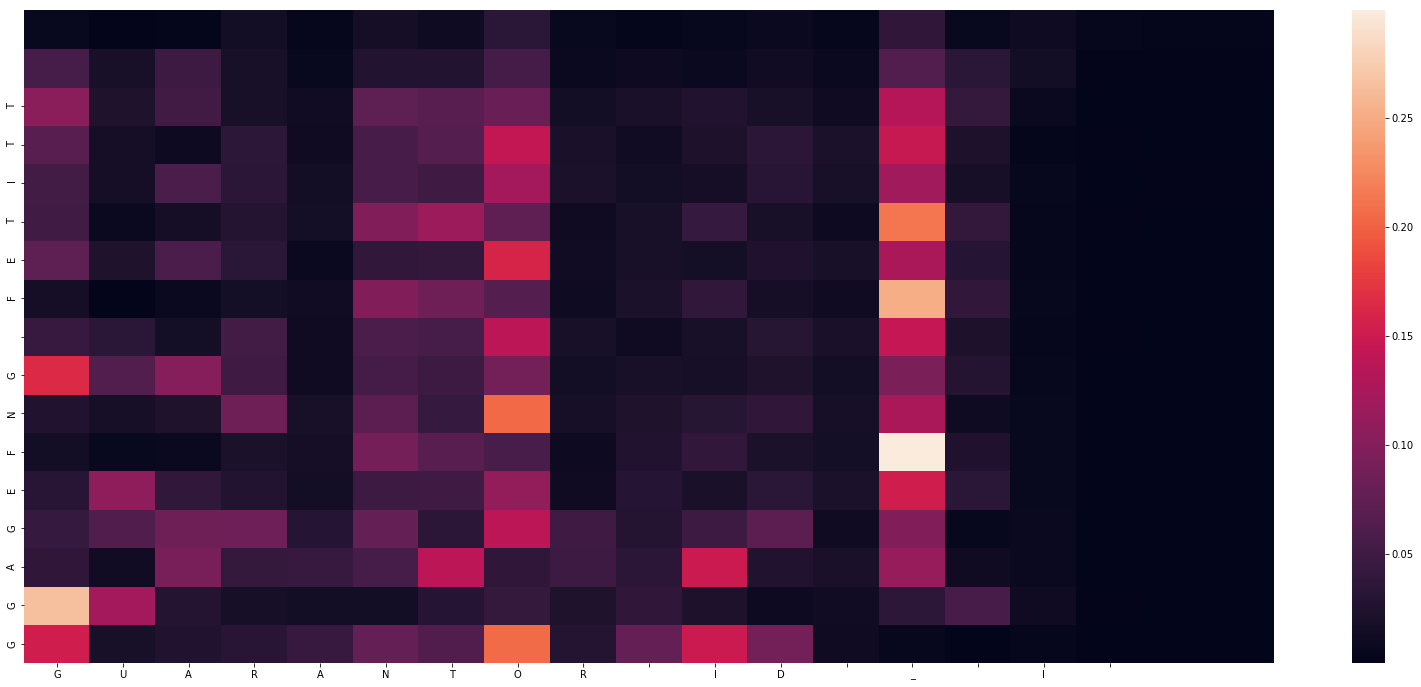

-
Input sentence: GUARANTOR ID _ I 
GT sentence: GUARANTOR ID

Decoded sentence: GGAGEFNG FETITT


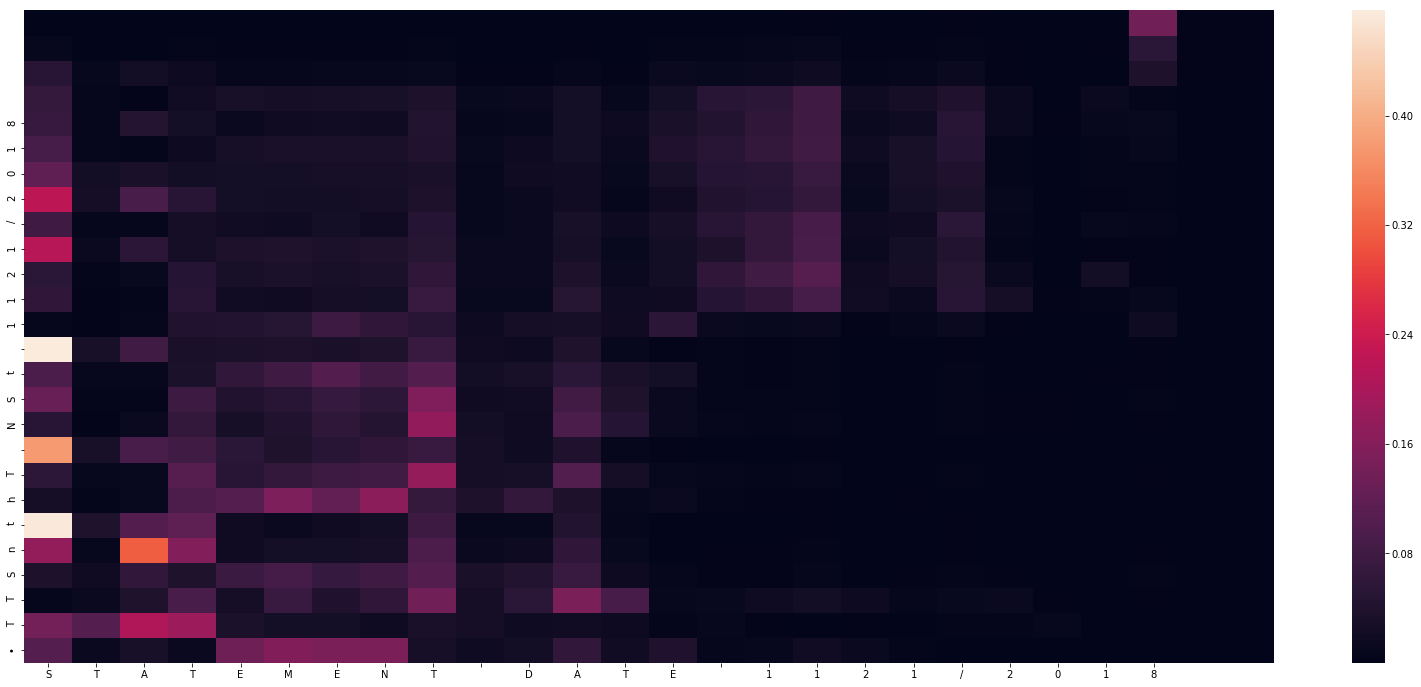

-
Input sentence: STATEMENT DATE 1121/2018
GT sentence: STATEMENT DATE 1/21/2018

Decoded sentence: •TTSnthT NSt 1121/2018


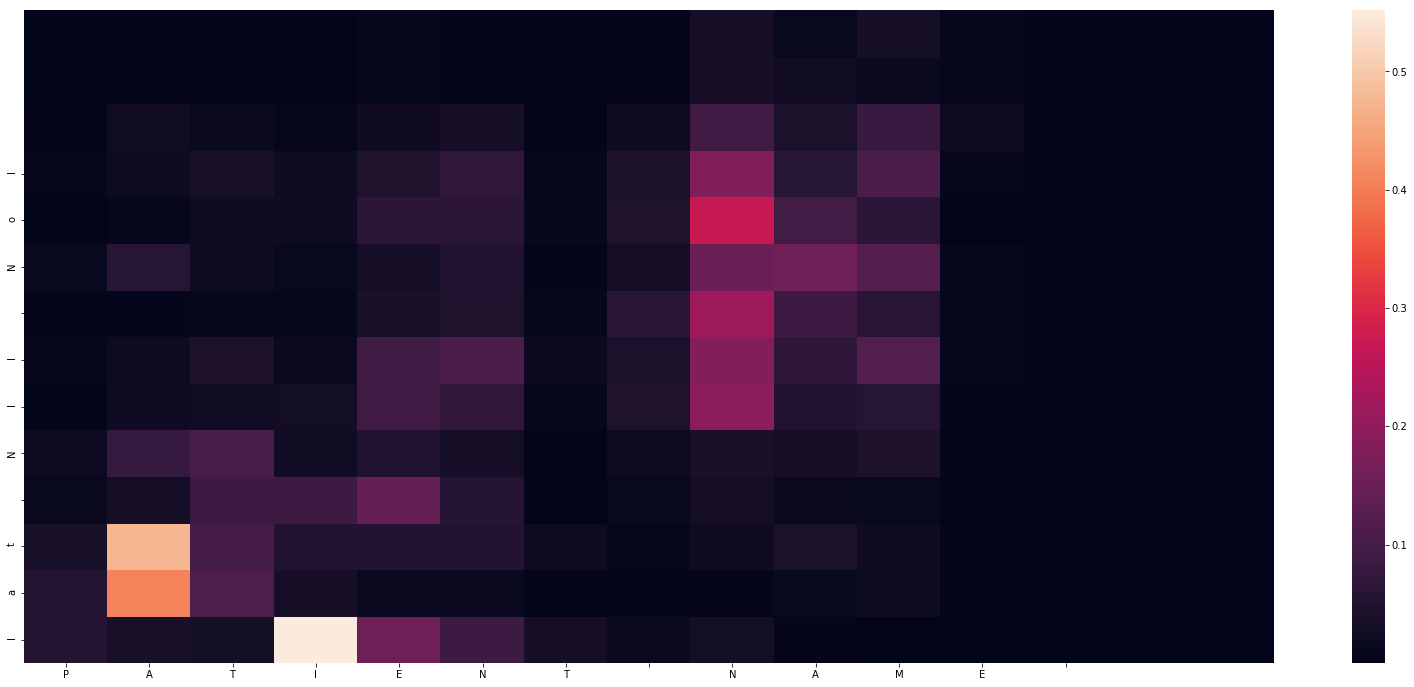

-
Input sentence: PATIENT NAME 
GT sentence: PATIENT NAME

Decoded sentence: Iat NIl Nol


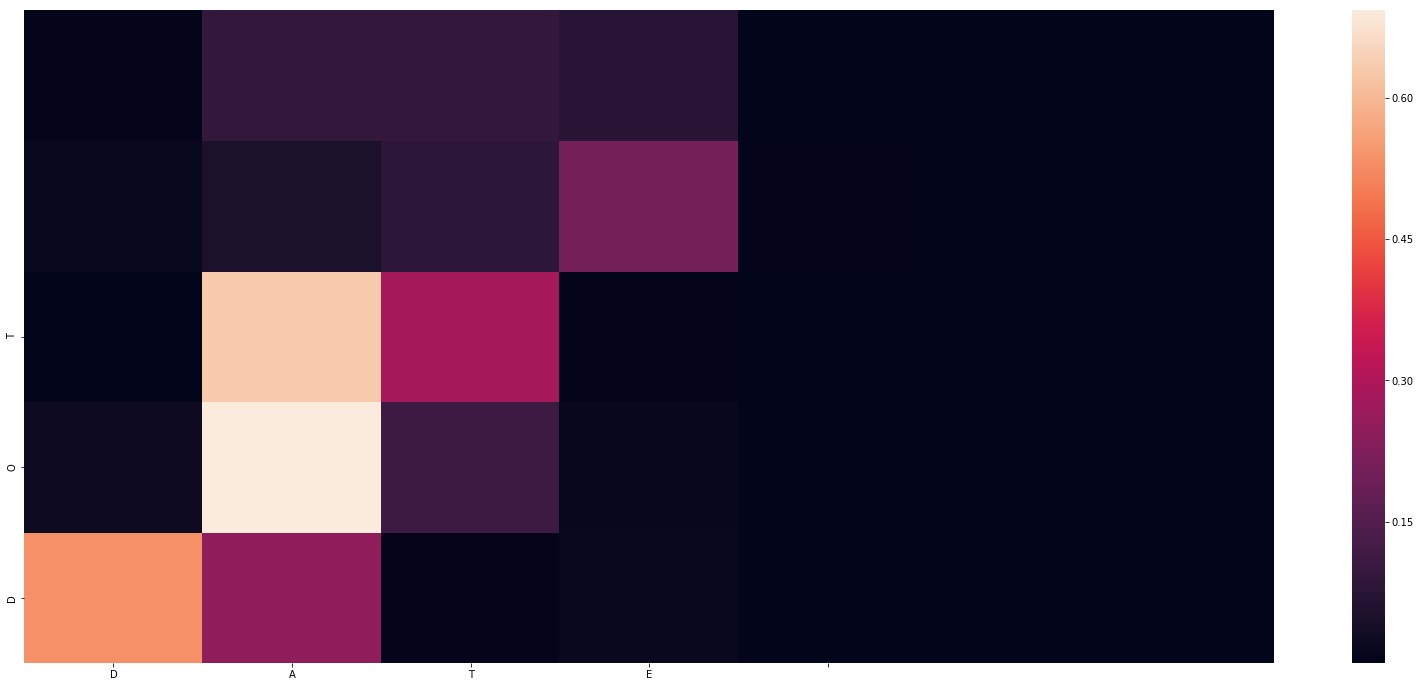

-
Input sentence: DATE 
GT sentence: DATE

Decoded sentence: DOT


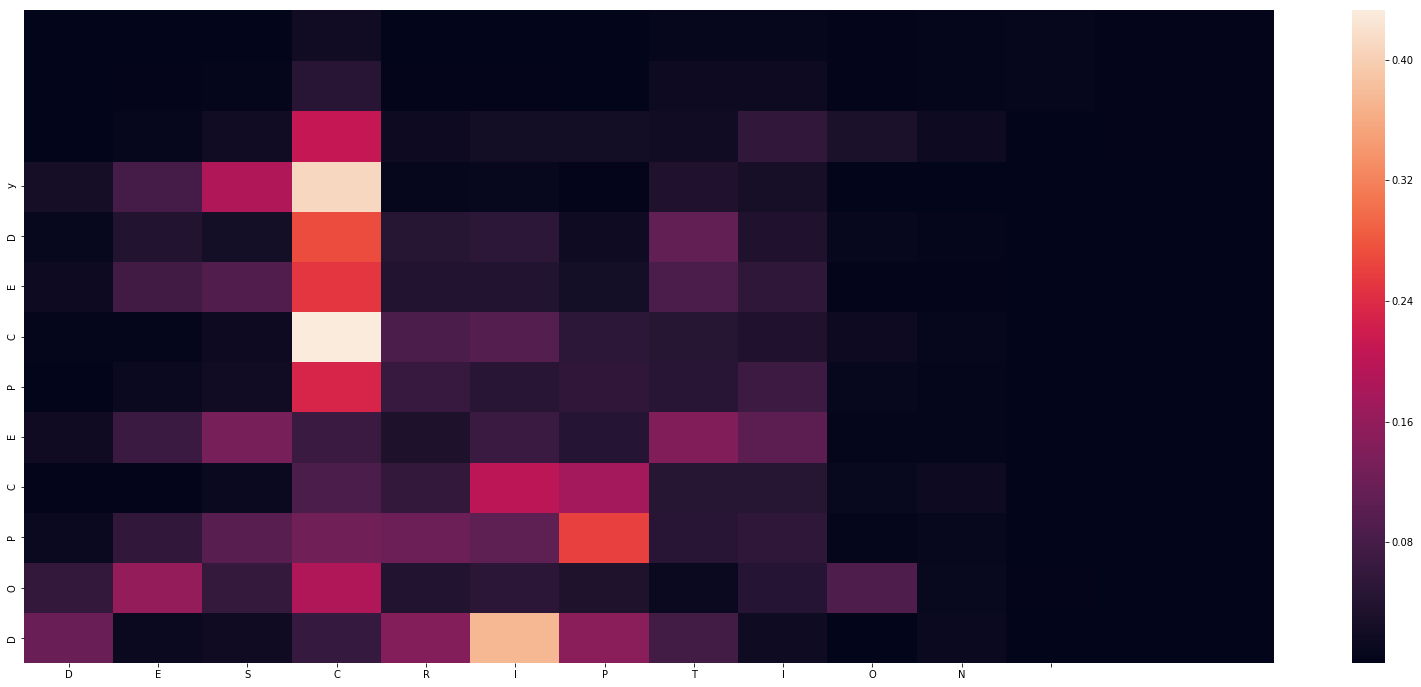

-
Input sentence: DESCRIPTION 
GT sentence: DESCRIPTION

Decoded sentence: DOPCEPCEDy


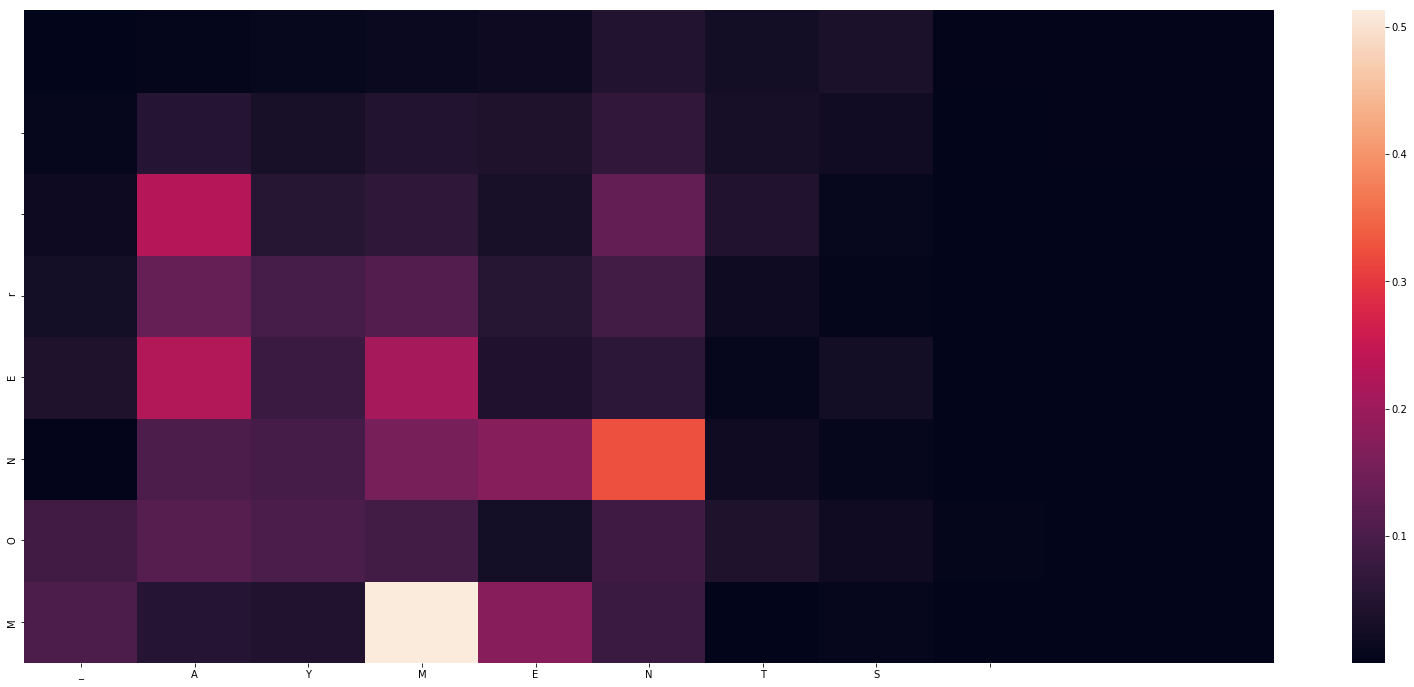

-
Input sentence: _AYMENTS 
GT sentence: PAYMENTS

Decoded sentence: MONEr  


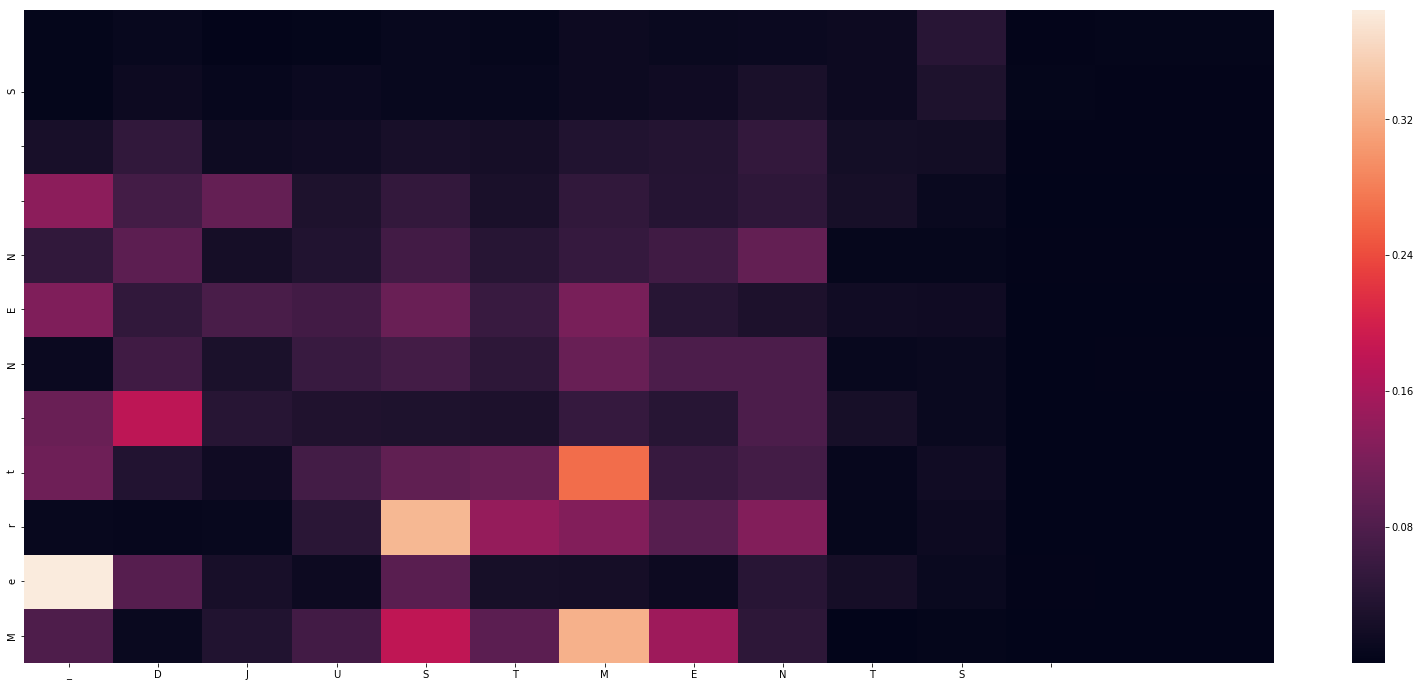

-
Input sentence: _DJUSTMENTS 
GT sentence: ADJUSTMENTS

Decoded sentence: Mert NEN  S


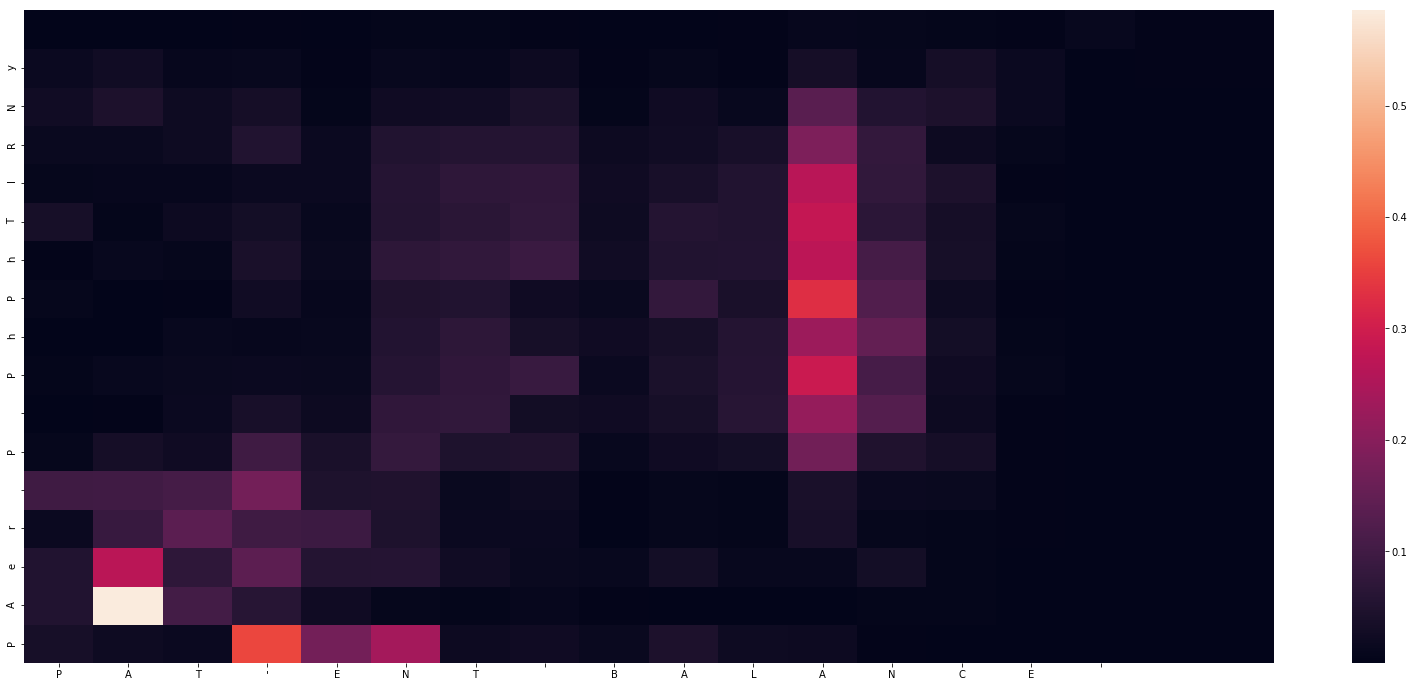

-
Input sentence: PAT'ENT BALANCE 
GT sentence: PATIENTS BALANCE

Decoded sentence: PAer P PhPhTIRNy


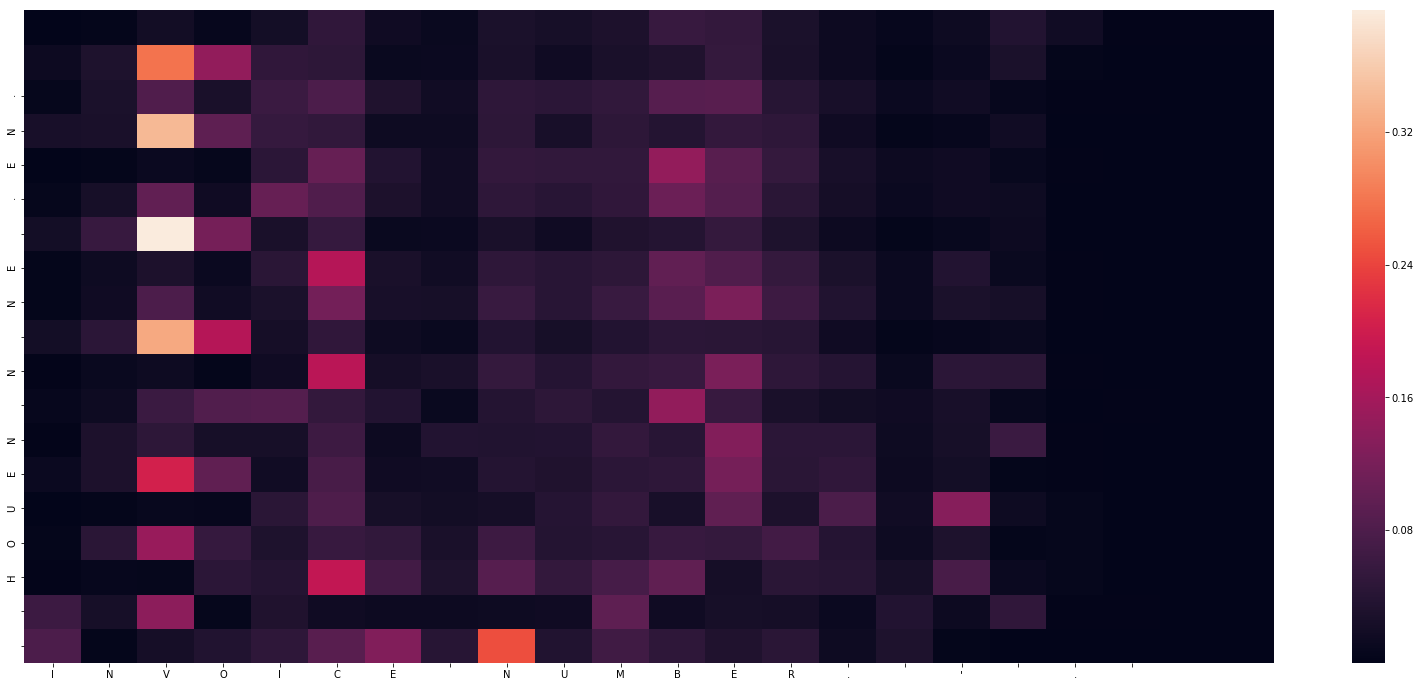

-
Input sentence: INVOICE NUMBER. ' . 
GT sentence: INVOICE NUMBER :

Decoded sentence: • HOUEN N NE .EN.


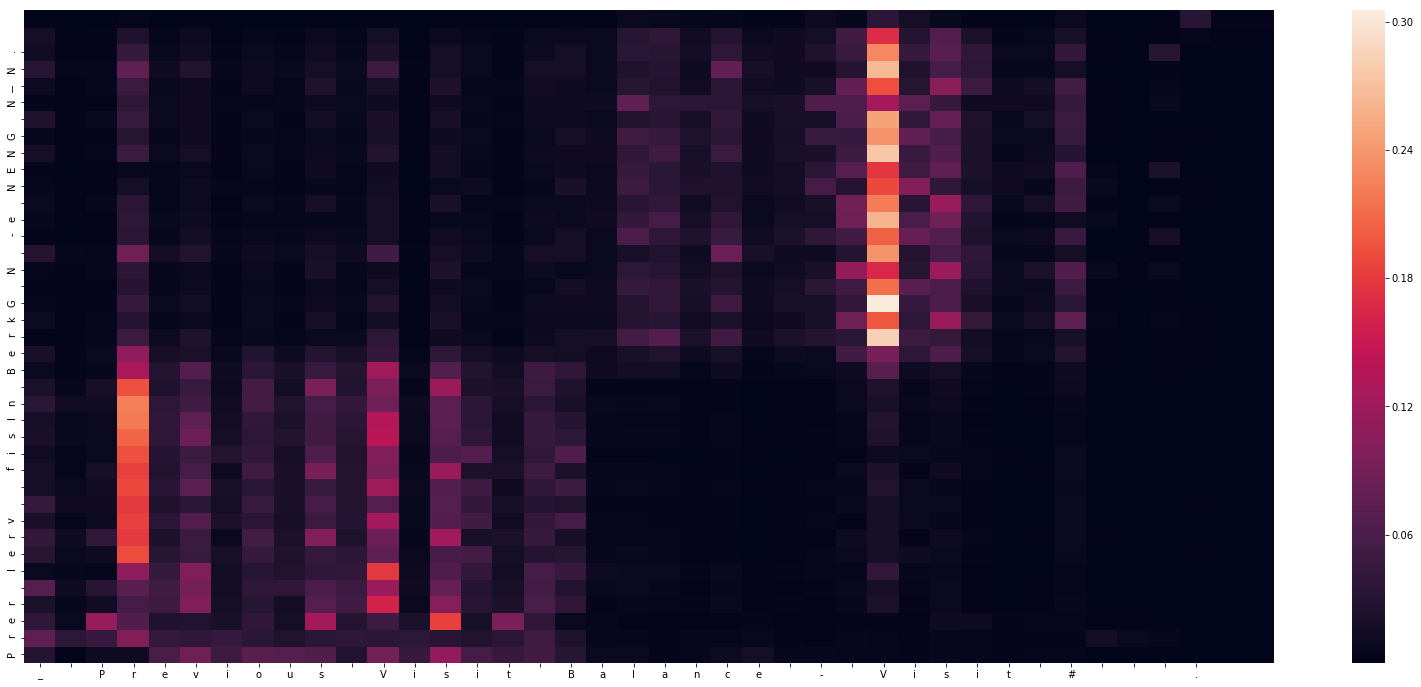

-
Input sentence: _ Previous Visit Balance - Visit # — .
GT sentence: Previous Visit Balance- Visit #

Decoded sentence: Prer Ierv  fisIn BerkG N -e NENG N—N.


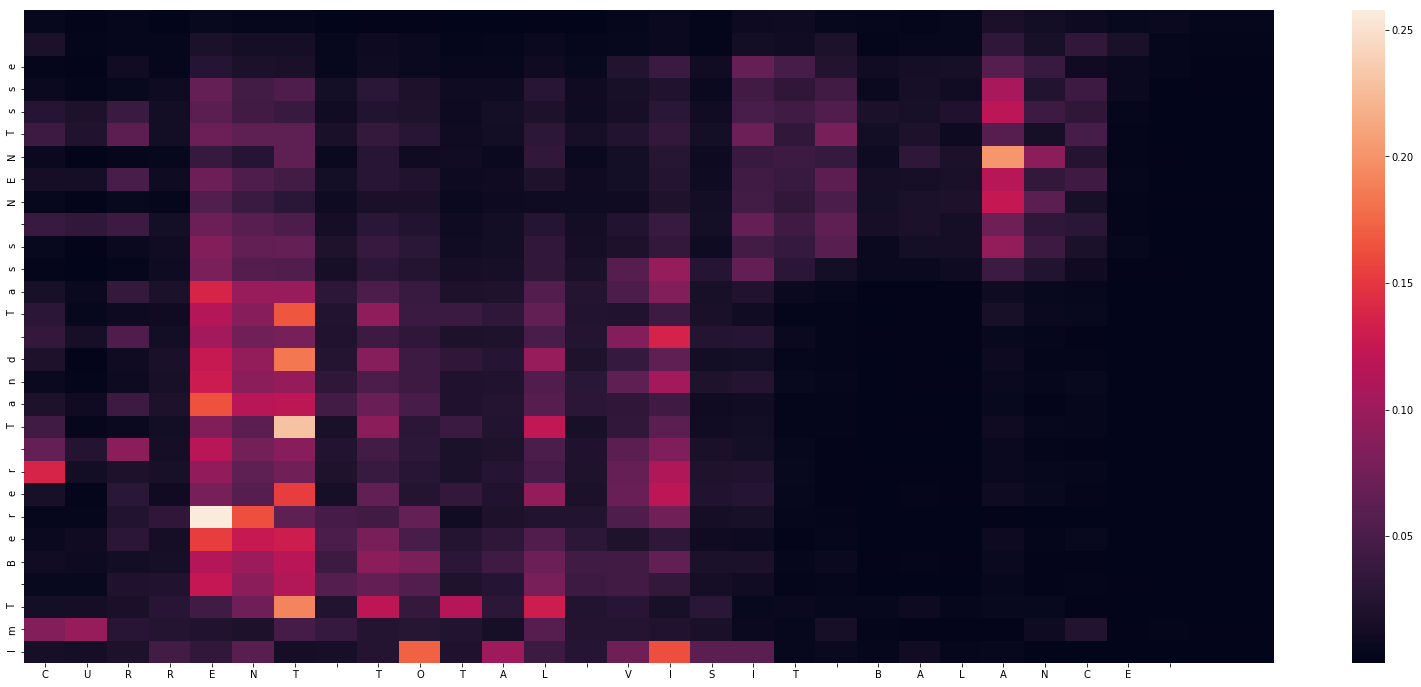

-
Input sentence: CURRENT TOTAL VISIT BALANCE 
GT sentence: CURRENT TOTAL VISIT BALANCE 964.70

Decoded sentence: ImT Berer Tand Tass NENTsse


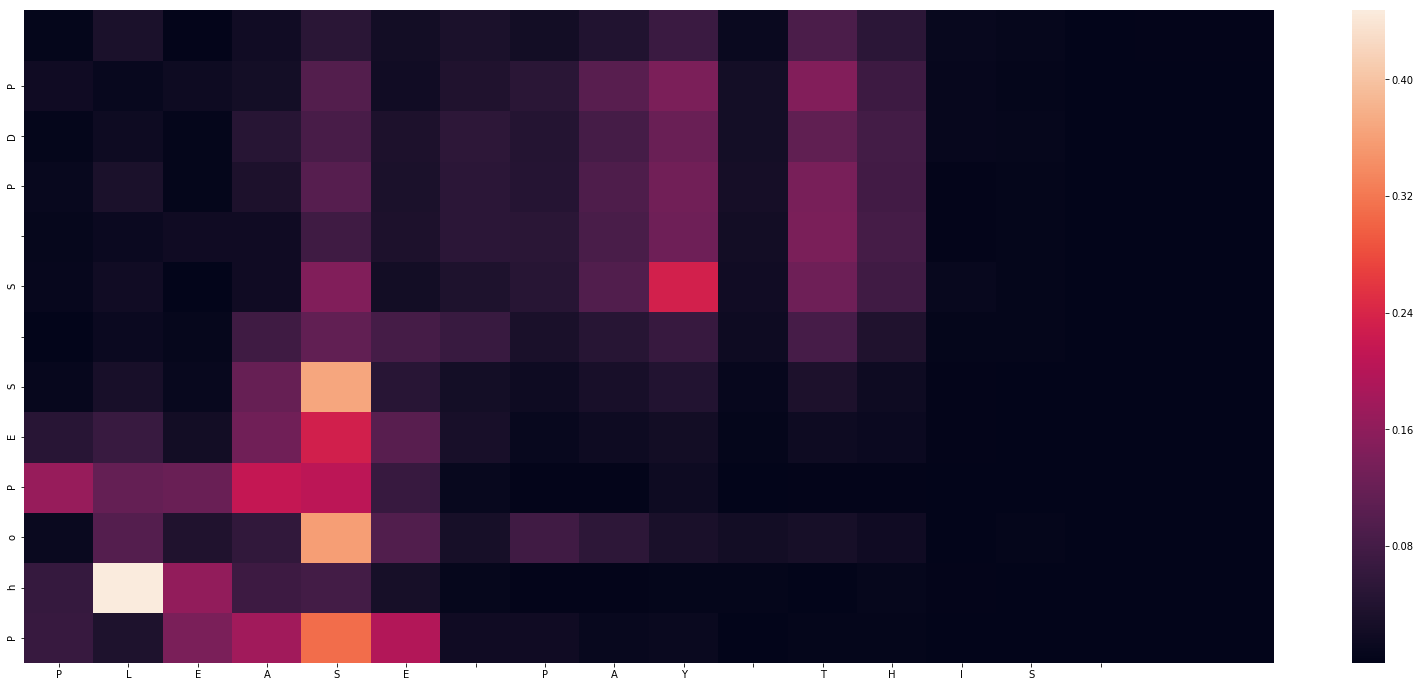

-
Input sentence: PLEASE PAY THIS 
GT sentence: PLEASE PAY THIS

Decoded sentence: PhoPES S PDP


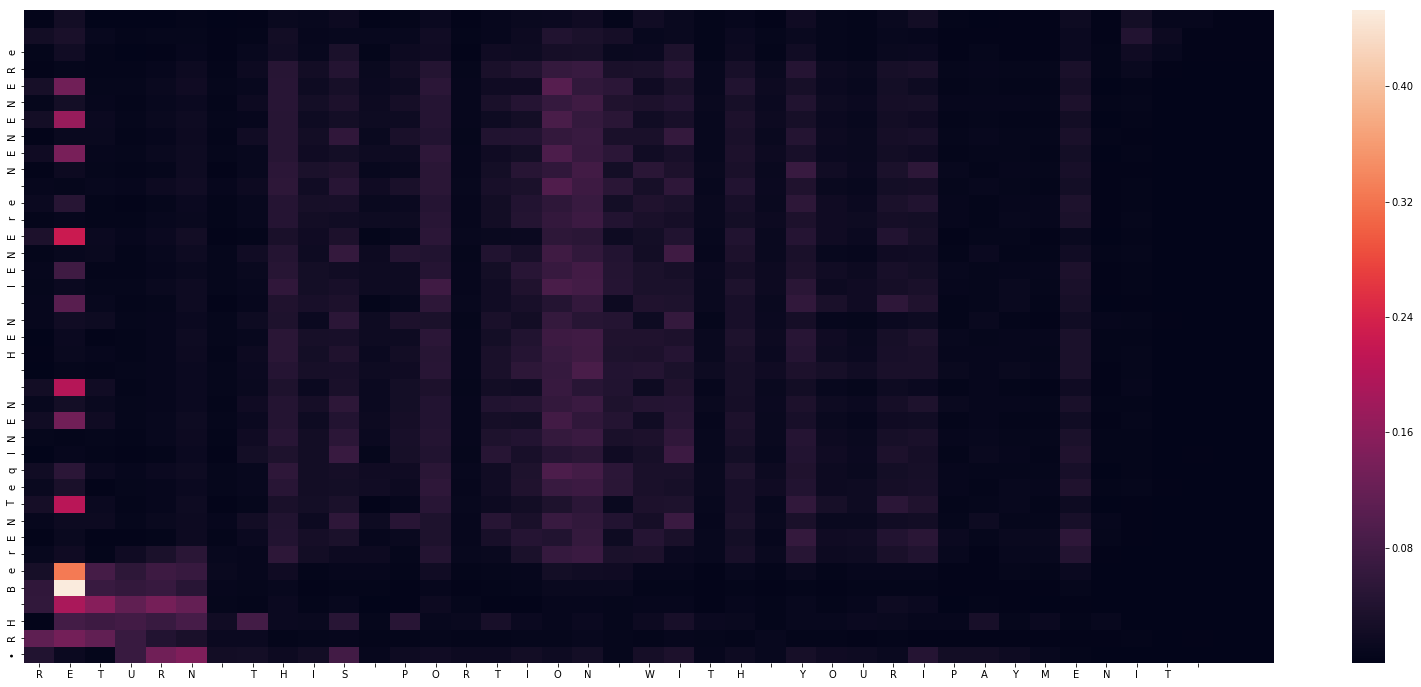

-
Input sentence: RETURN THIS PORTION WITH YOURIPAYMENIT 
GT sentence: RETURN THIS PORTION WITH YOUR PAYMENT

Decoded sentence: •RH BerENTeqINEN  HEN IENEre NENENERe


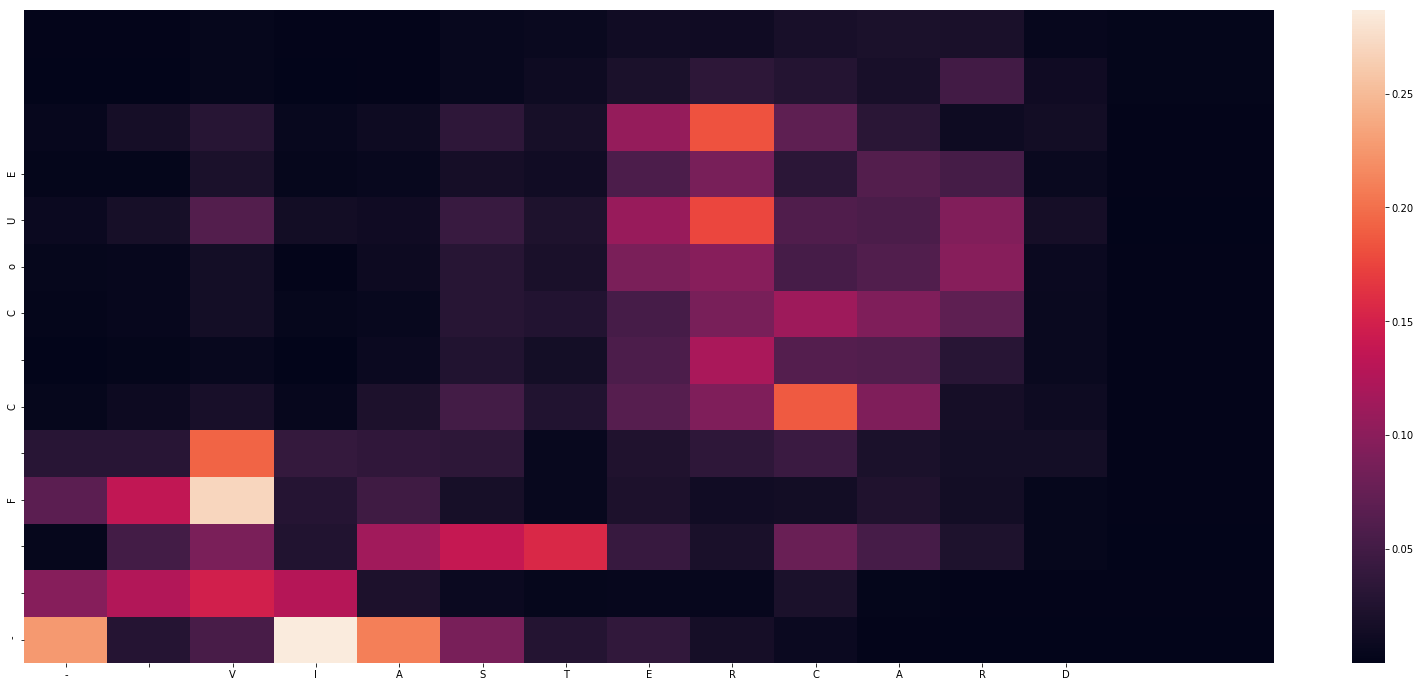

-
Input sentence: - VIASTERCARD
GT sentence: MASTERCARD

Decoded sentence: -  F C CoUE


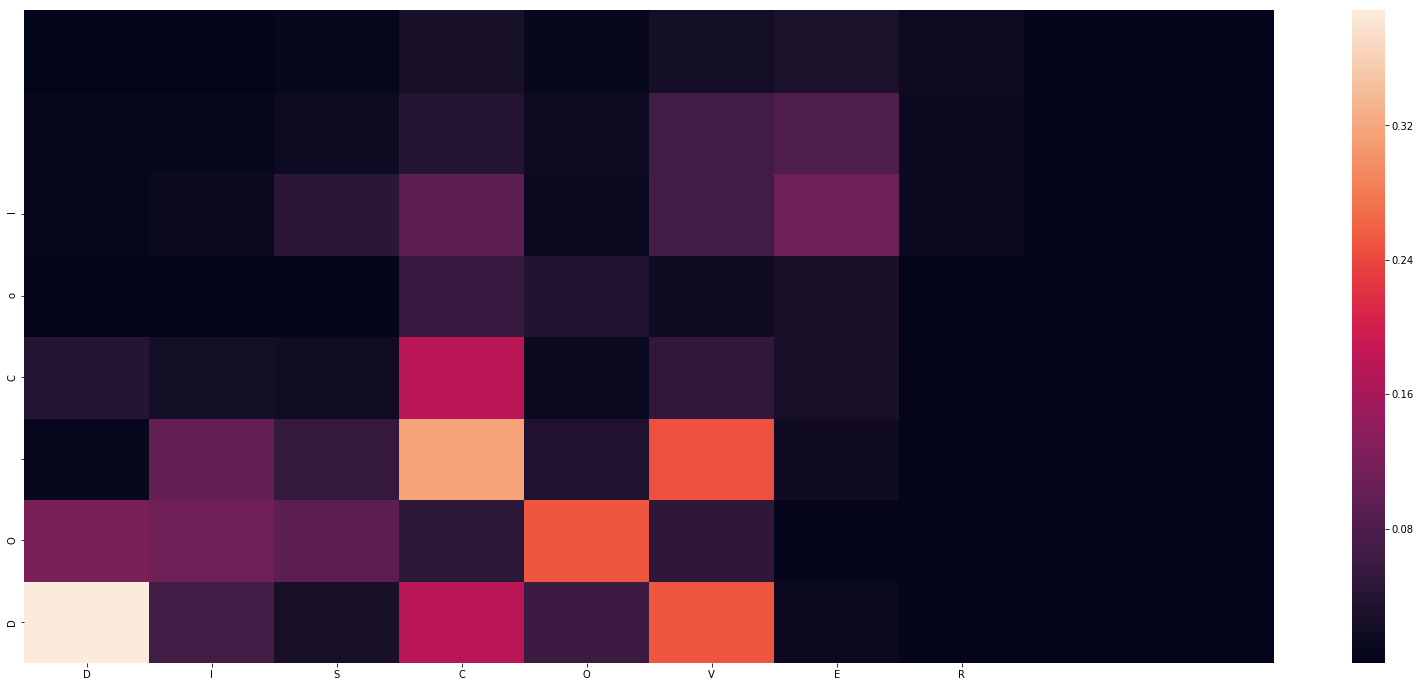

-
Input sentence: DISCOVER
GT sentence: DISCOVER

Decoded sentence: DO Col


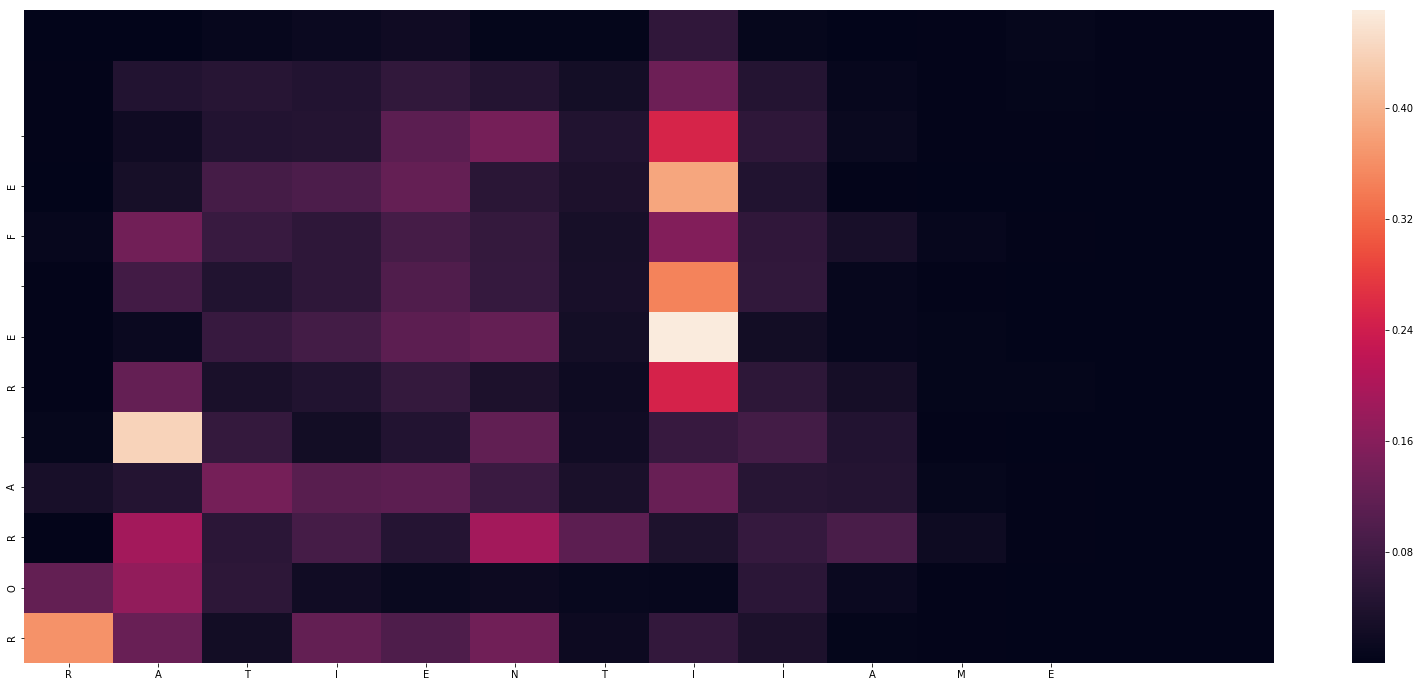

-
Input sentence: RATIENTIIAME
GT sentence: PATIENT NAME

Decoded sentence: RORA RE FE 


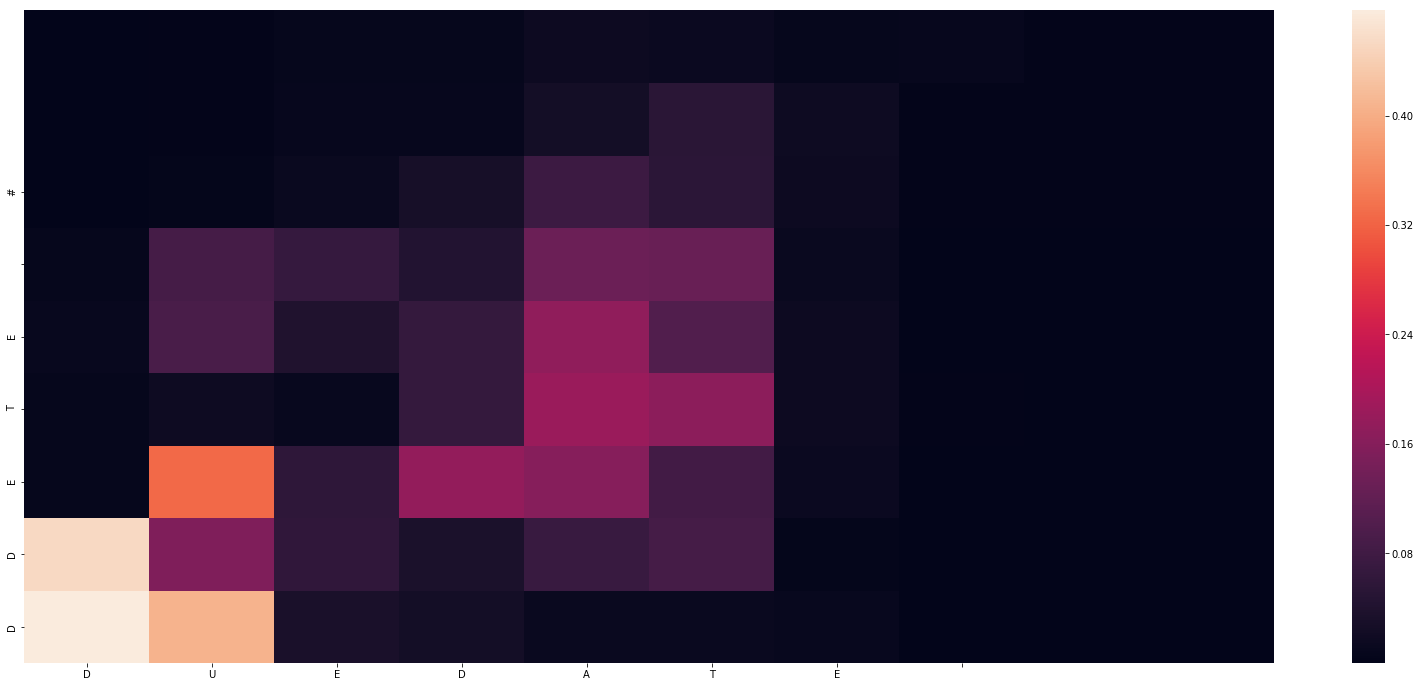

-
Input sentence: DUEDATE 
GT sentence: DUE DATE

Decoded sentence: DDETE #


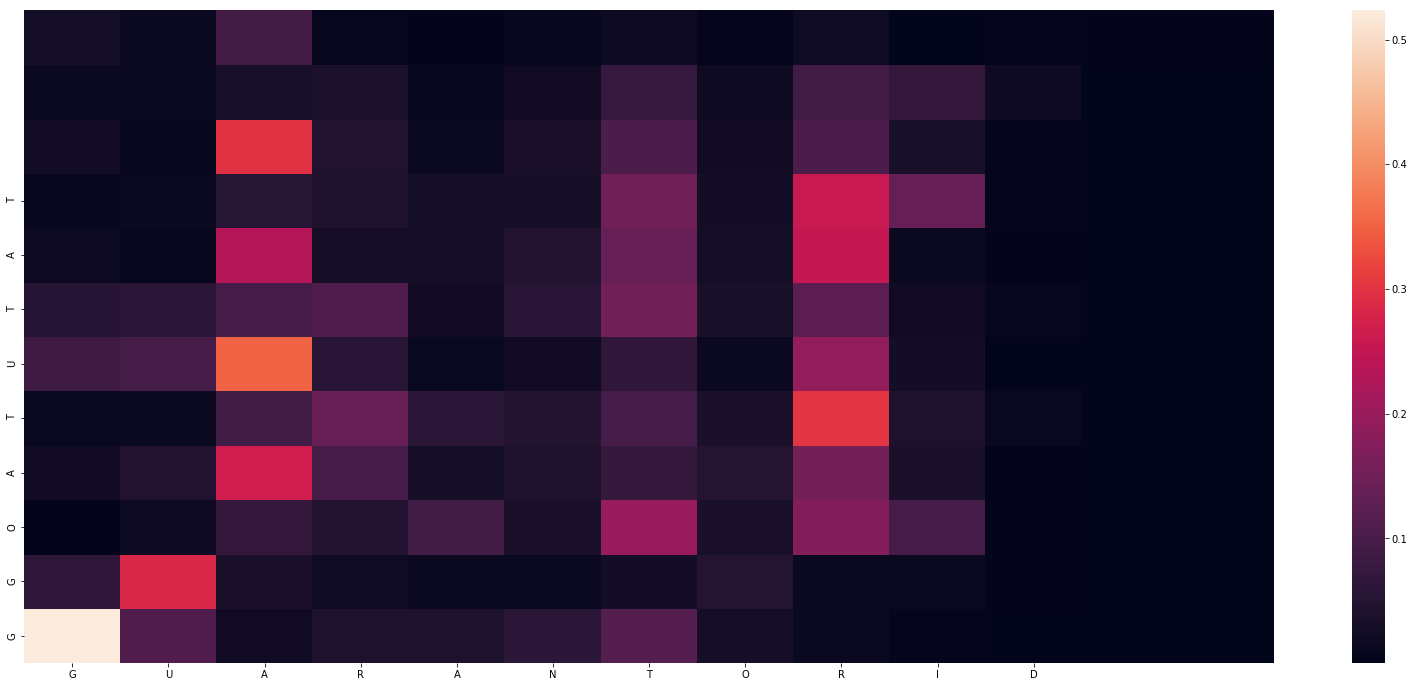

-
Input sentence: GUARANTORID
GT sentence: GUARANTOR ID

Decoded sentence: GGOATUTAT


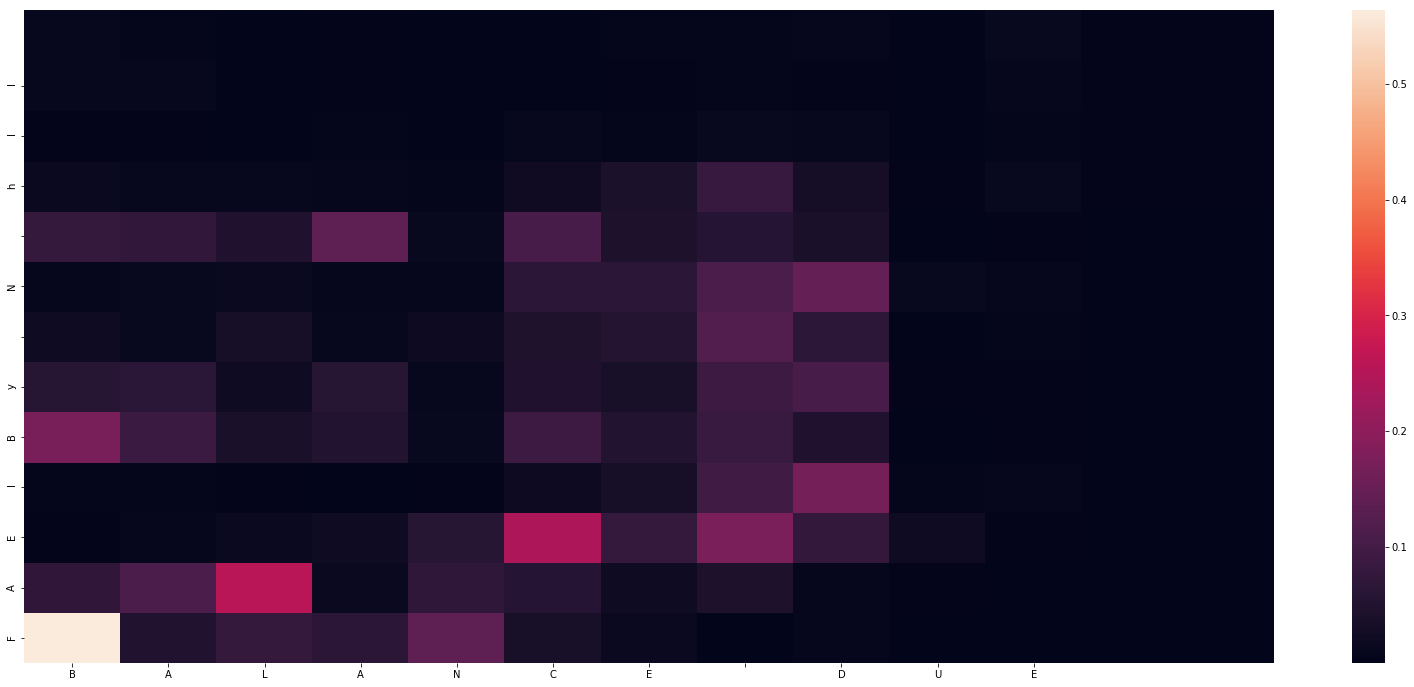

-
Input sentence: BALANCE DUE
GT sentence: BALANCE DUE

Decoded sentence: FAElBy N hll


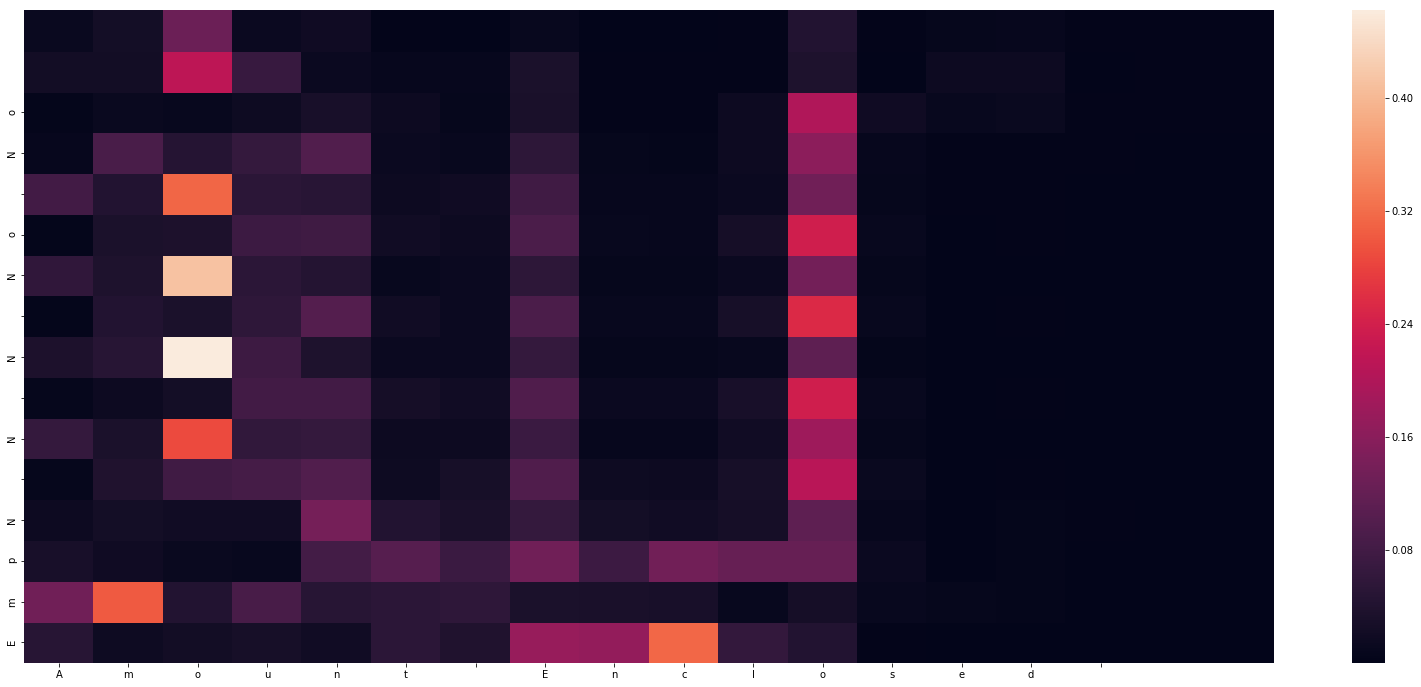

-
Input sentence: Amount Enclosed 
GT sentence: Amount Enclosed

Decoded sentence: EmpN N N No No


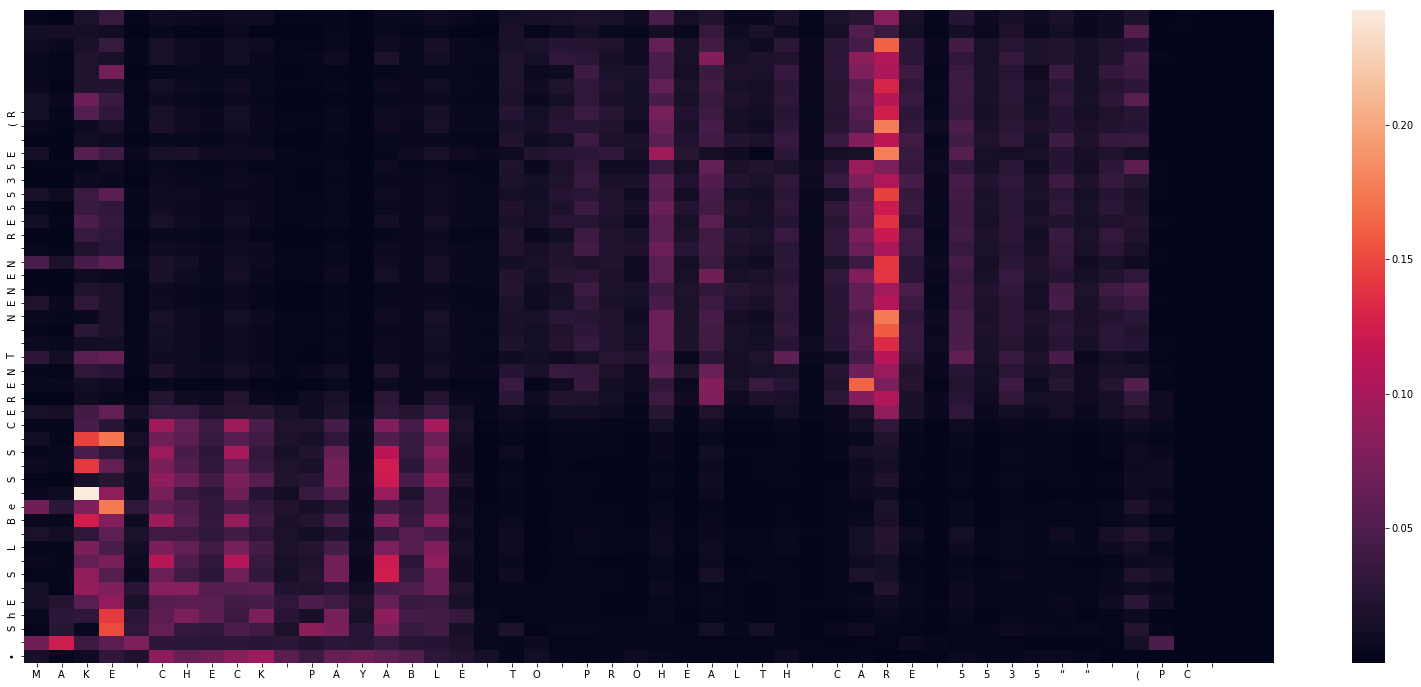

-
Input sentence: MAKE CHECK PAYABLE TO PROHEALTH CARE 5535““ (PC 
GT sentence: MAKE CHECK PAYABLE TO PROHEALTH CARE

Decoded sentence: • ShE S L Be S S CERENT  NENEN RE5535E (R


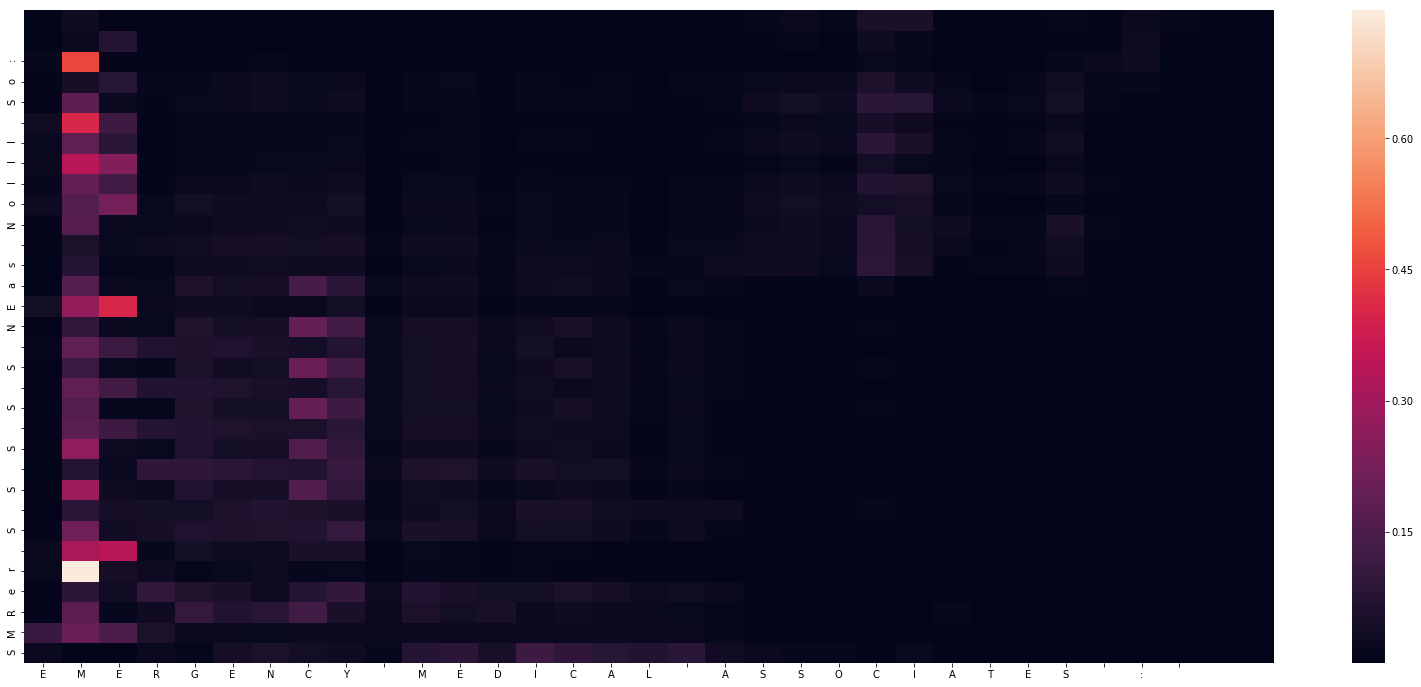

-
Input sentence: EMERGENCY MEDICAL ASSOCIATES : 
GT sentence: EMERGENCY MEDICAL ASSOCIATES

Decoded sentence: SMRer S S S S S NEas Nolll So:


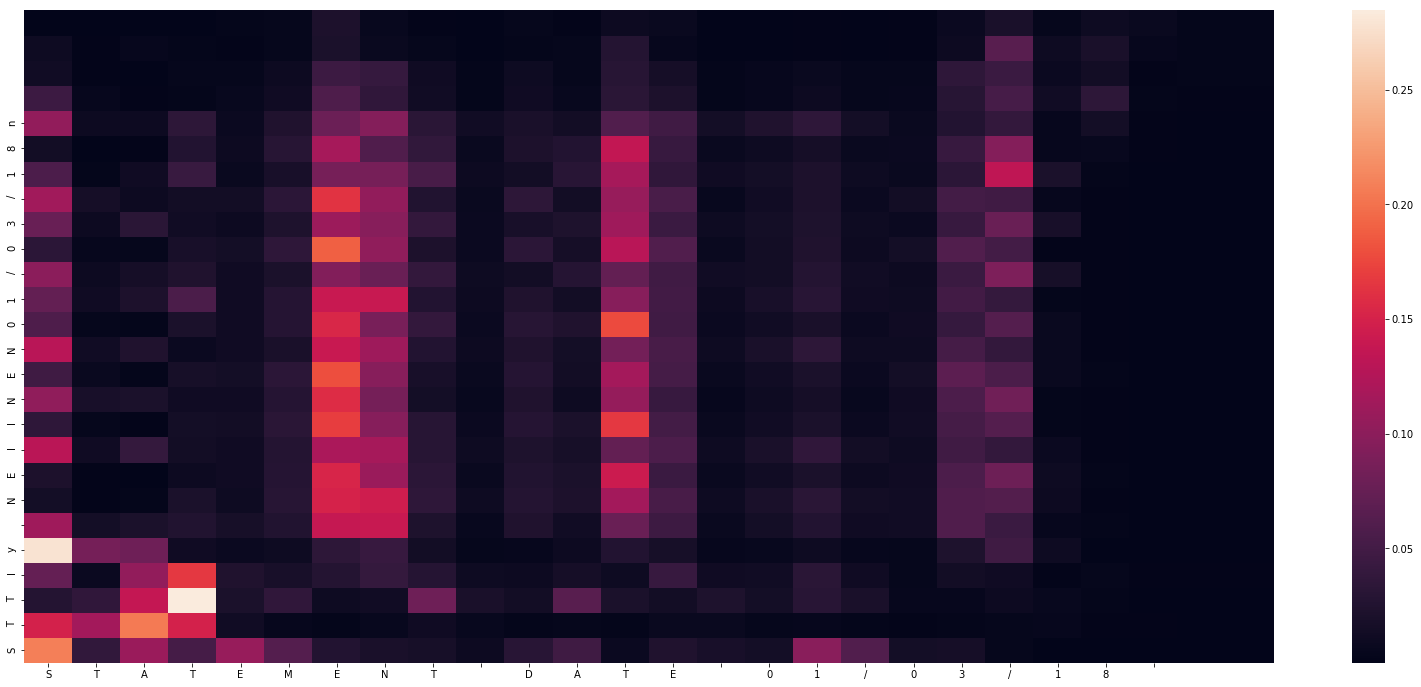

-
Input sentence: STATEMENT DATE 01/03/18 
GT sentence: STATEMENT DATE  01/03/18

Decoded sentence: STTIy NElINEN01/03/18n


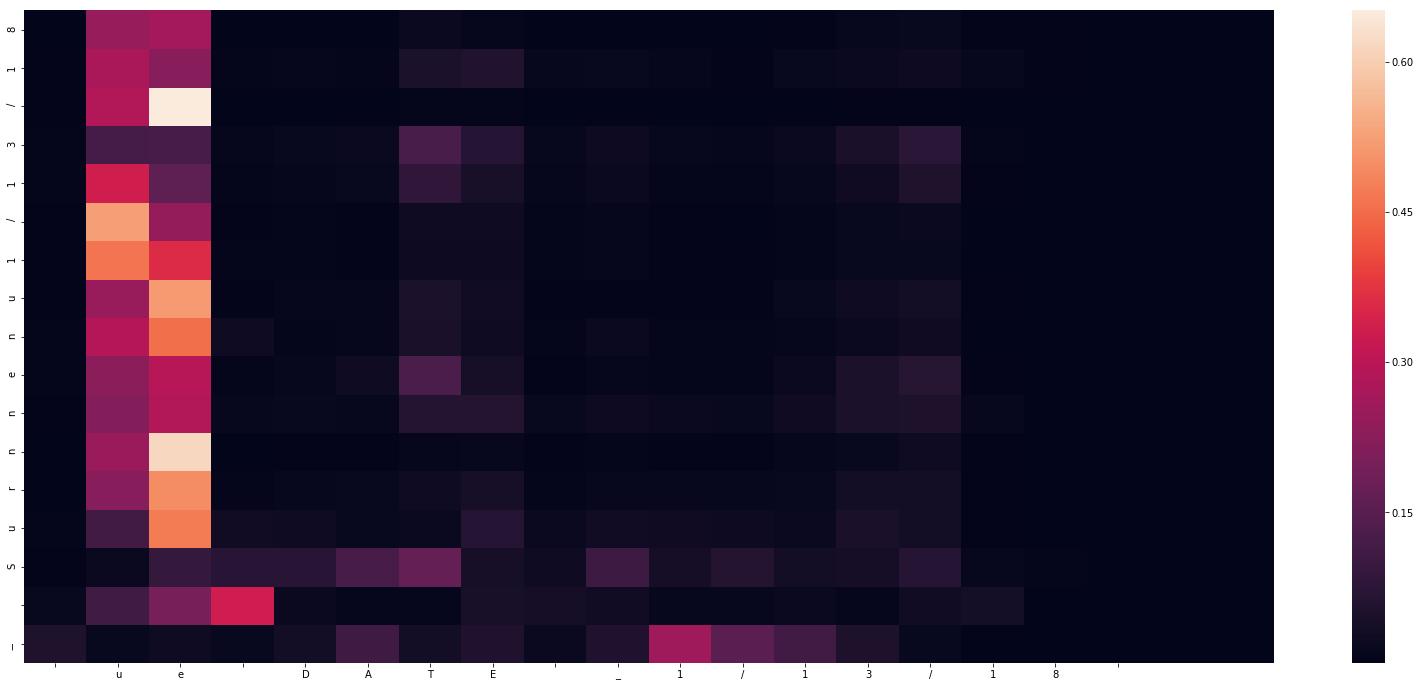

-
Input sentence: —ue DATE _1/13/18 
GT sentence: DUE DATE 01/13/18

Decoded sentence: — Surnnenu1/13/18


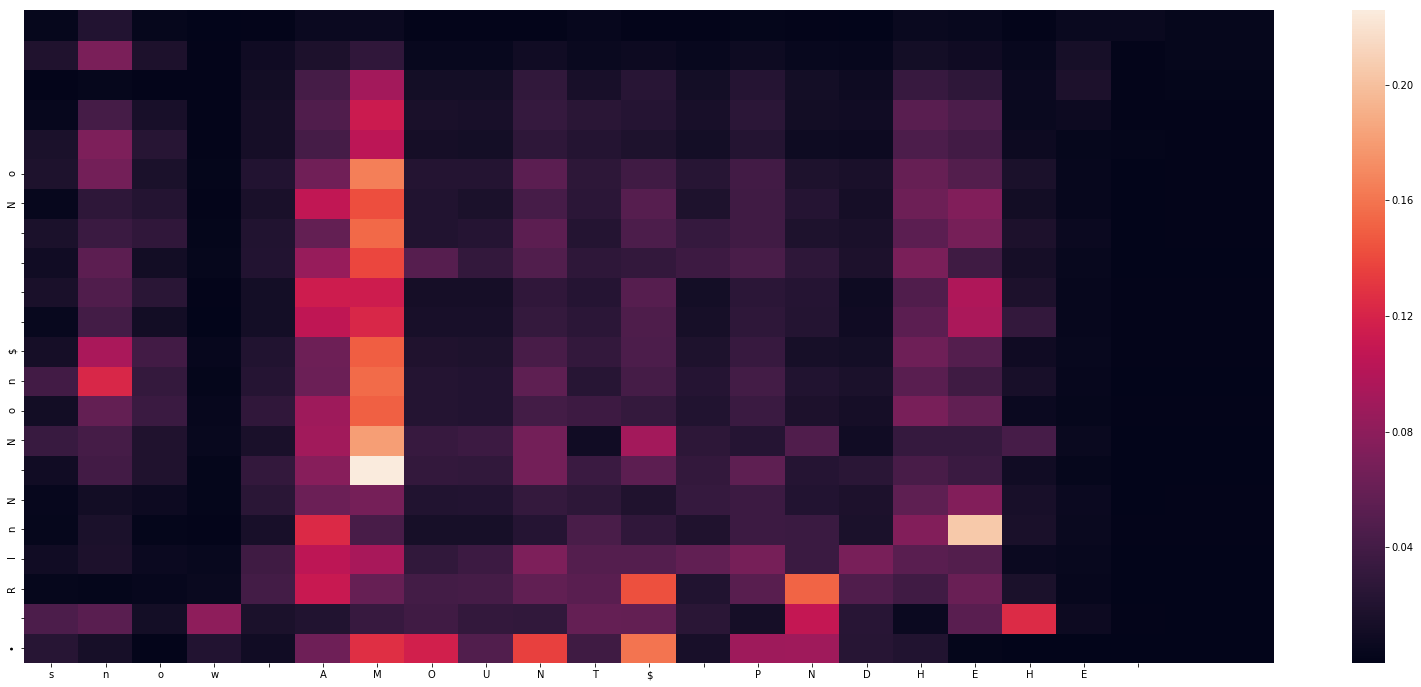

-
Input sentence: snow AMOUNT$ PNDHEHE 
GT sentence: SHOW AMOUNT PAID HERE $

Decoded sentence: • RInN Non$    No


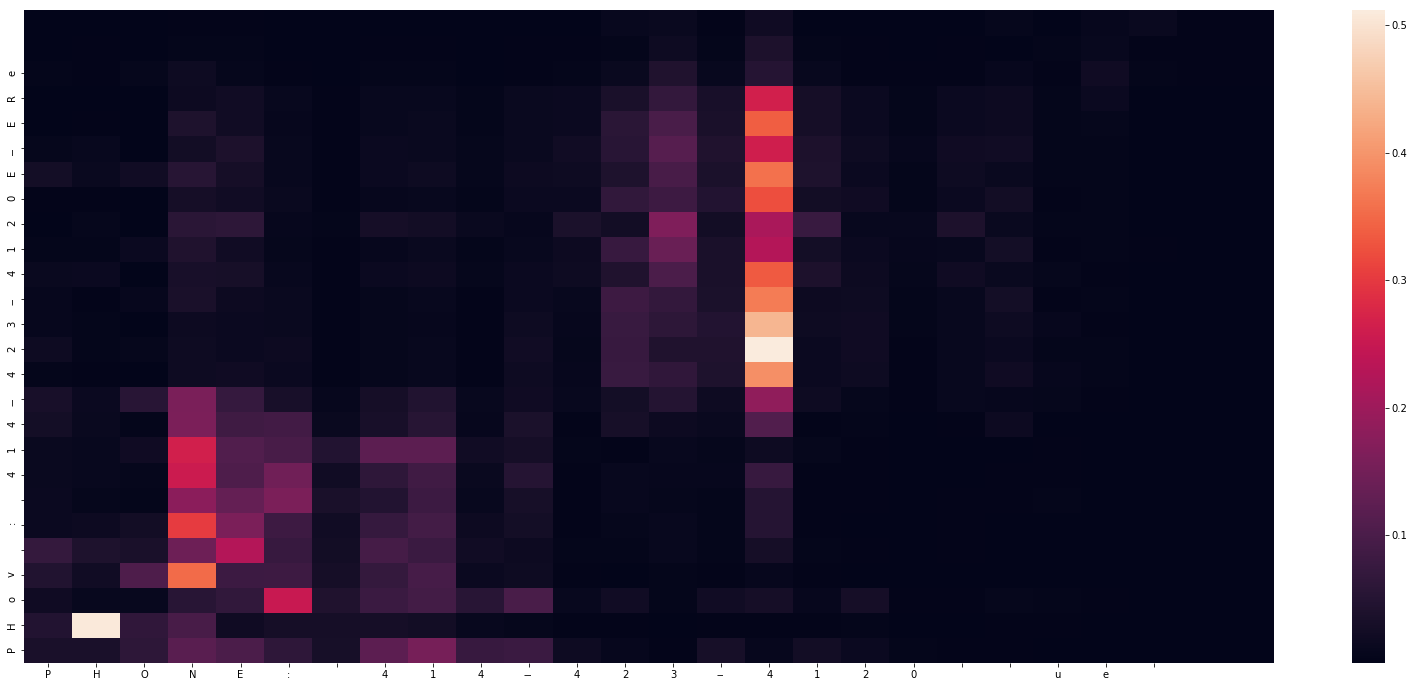

-
Input sentence: PHONE: 414—423—4120 —ue 
GT sentence: PHONE: 414-423-4120

Decoded sentence: PHov : 414—423—4120E—ERe


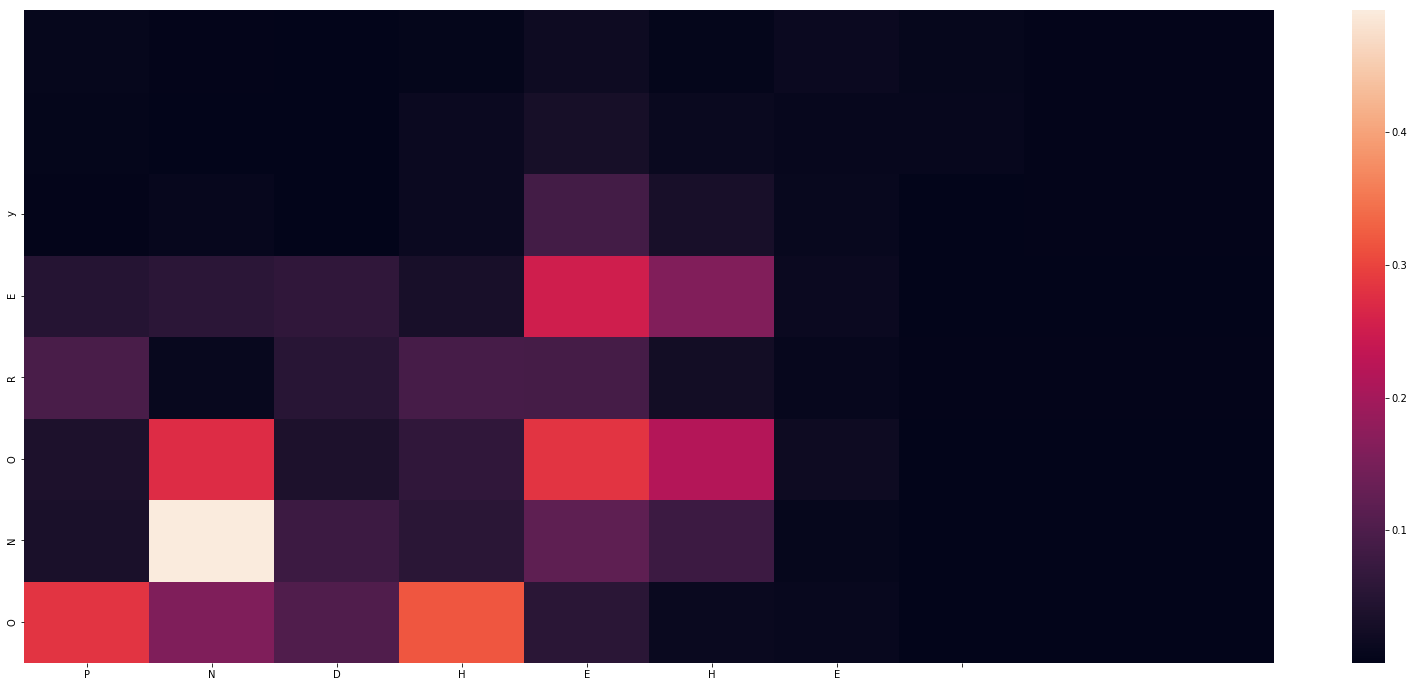

-
Input sentence: PNDHEHE 
GT sentence: ADDRESSEE:

Decoded sentence: ONOREy


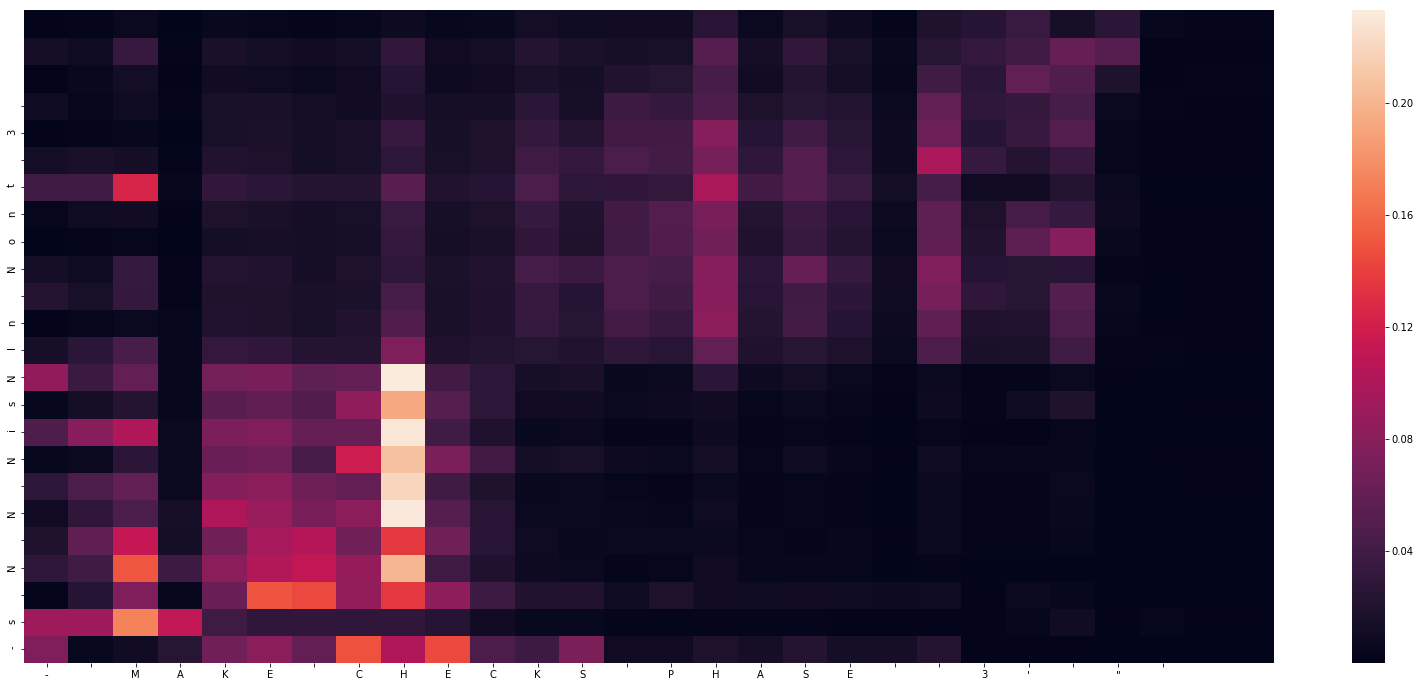

-
Input sentence: - MAKE CHECKS PHASE “3' " 
GT sentence: MAKE CHECKS PAYABLE TO:

Decoded sentence: -s N N NisNIn Nont 3 


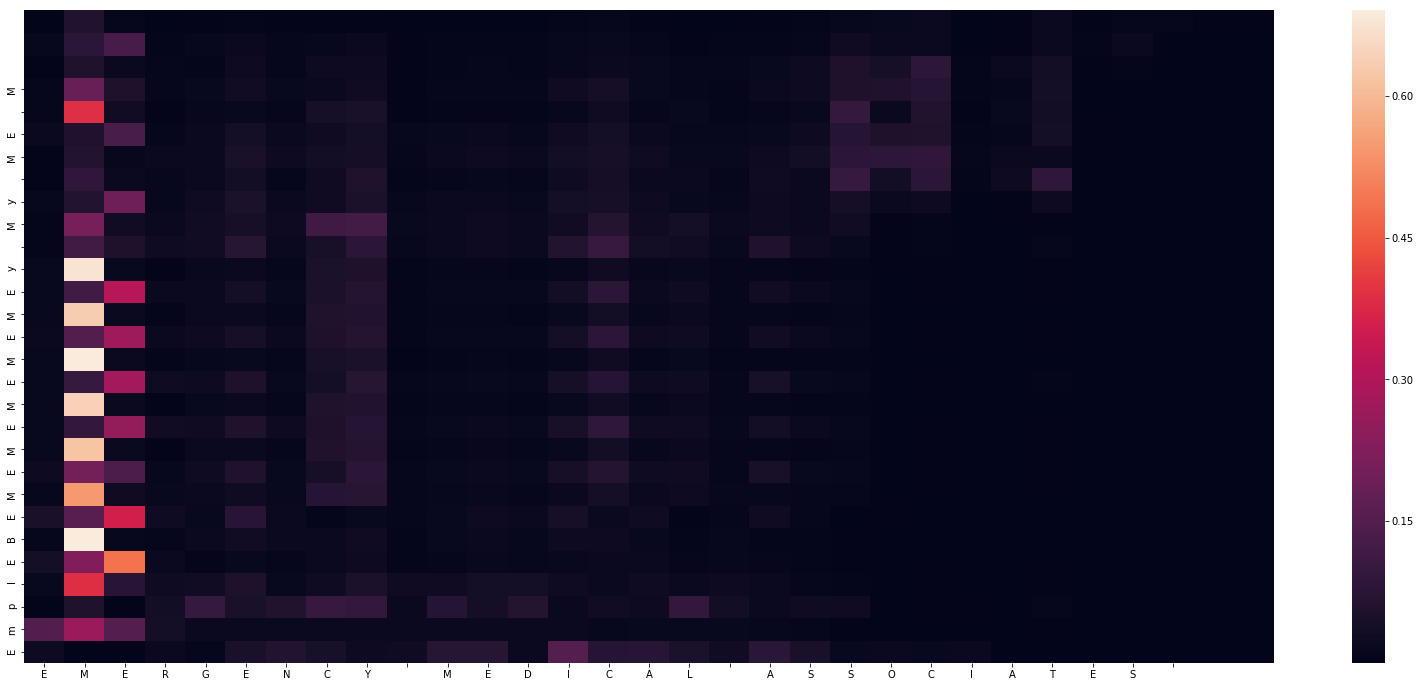

-
Input sentence: EMERGENCY MEDICAL ASSOCIATES 
GT sentence: EMERGENCY MEDICAL ASSOCIATES

Decoded sentence: EmplEBEMEMEMEMEMEy My ME M


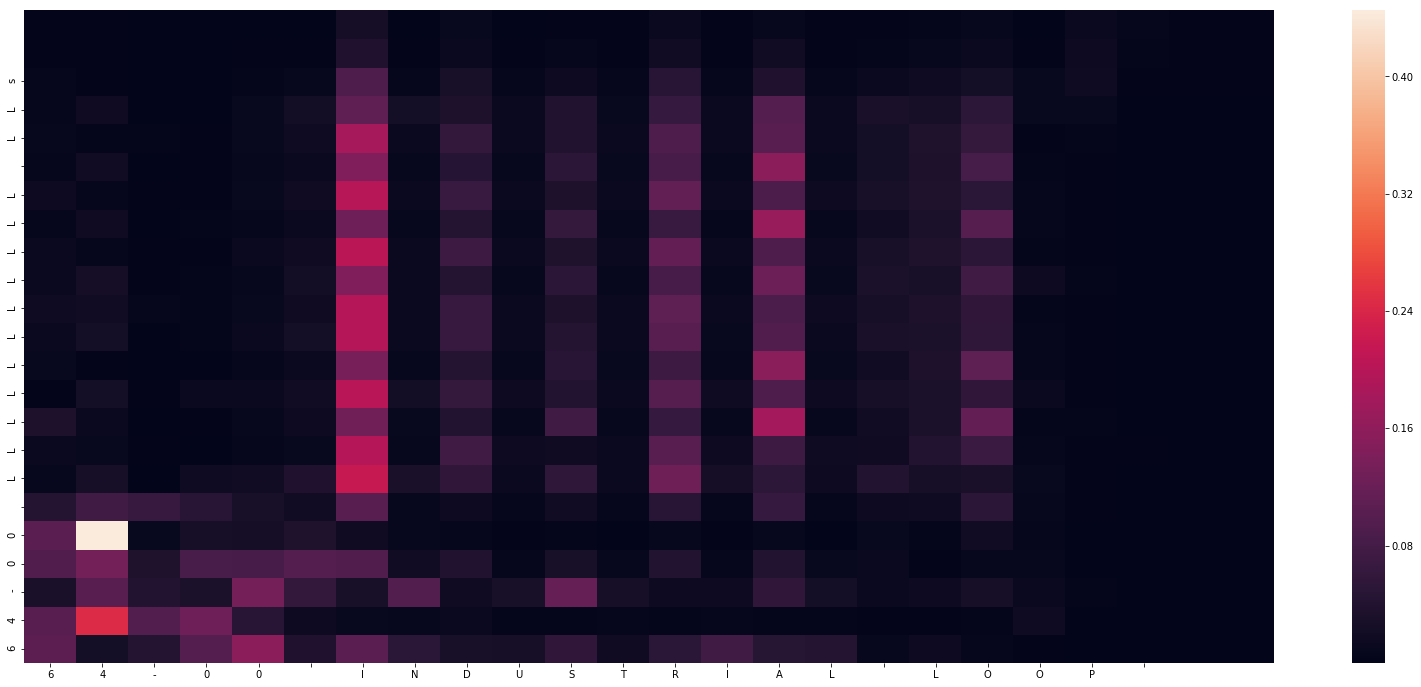

-
Input sentence: 64-00 INDUSTRIAL LOOP 
GT sentence: 6400 INDUSTRIAL LOOP

Decoded sentence: 64-00 LLLLLLLLLLL LLs


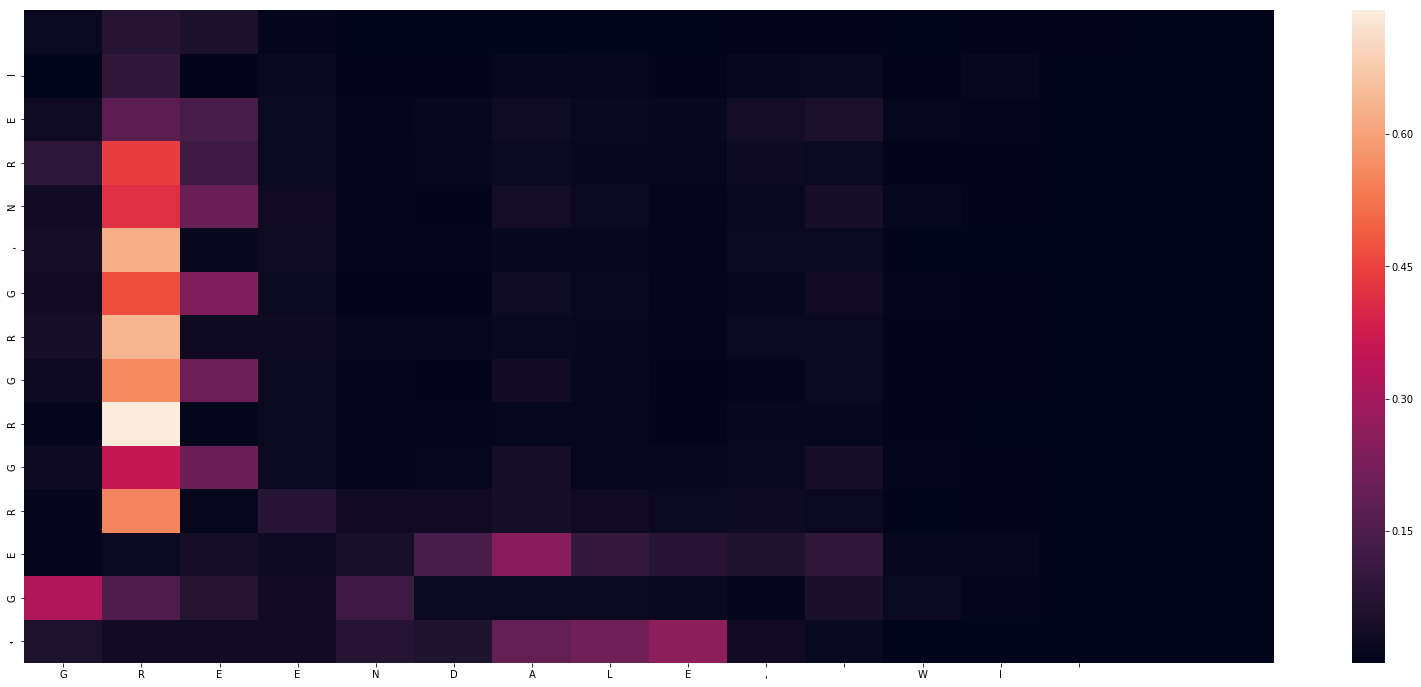

-
Input sentence: GREENDALE, WI 
GT sentence: GREENDALE, WI

Decoded sentence: •GERGRGRG,NREl


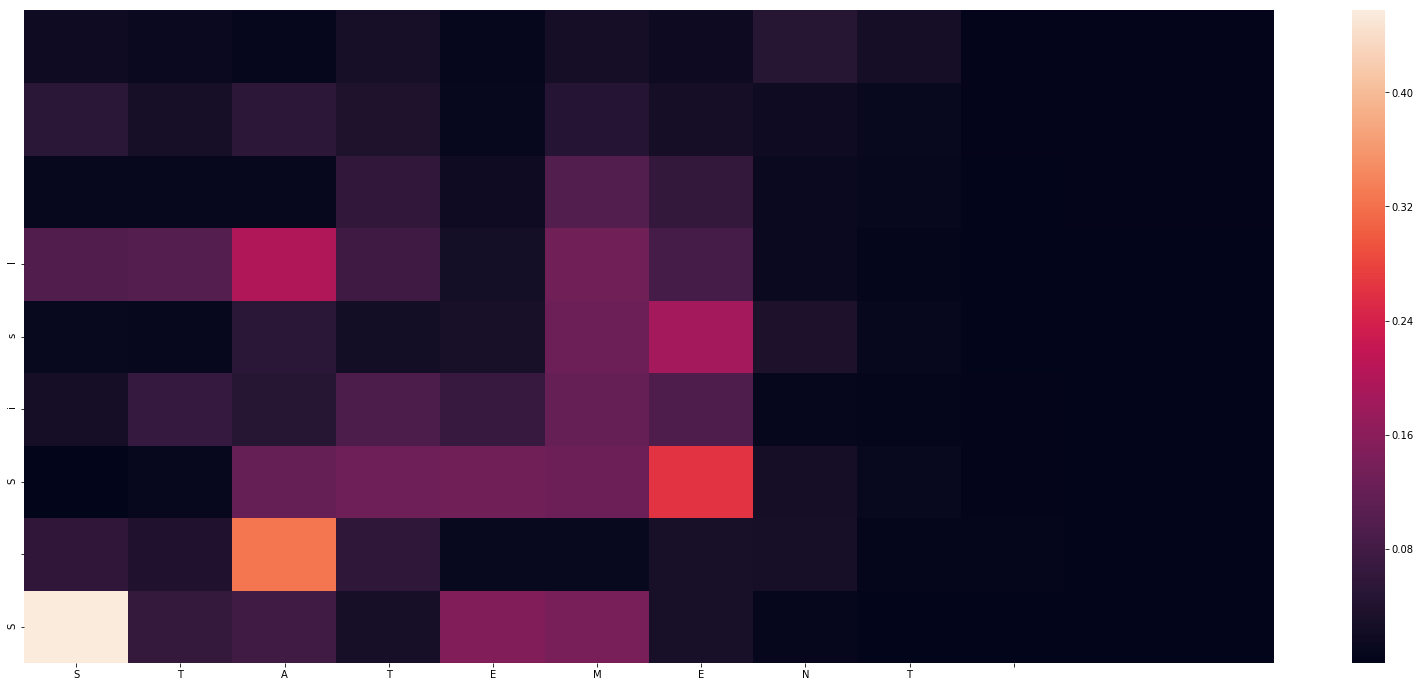

-
Input sentence: STATEMENT 
GT sentence: STATEMENT

Decoded sentence: S Sisl


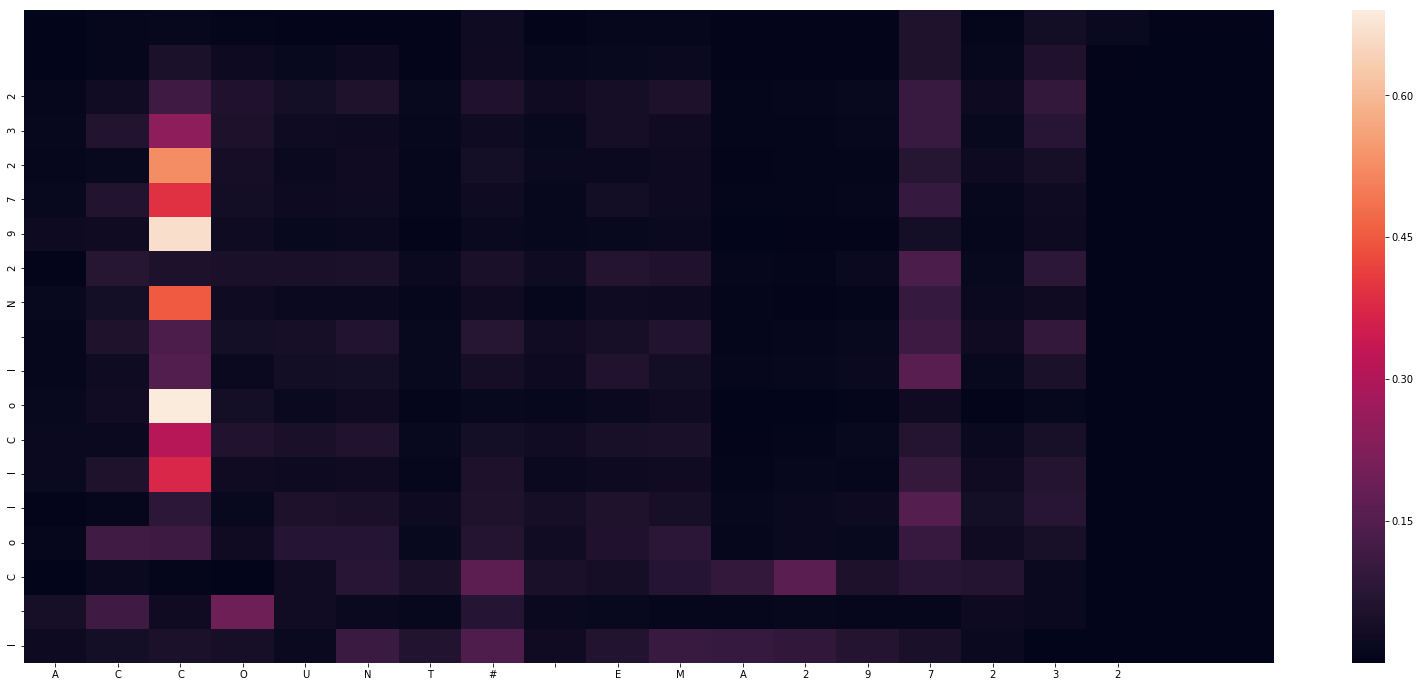

-
Input sentence: ACCOUNT# EMA297232
GT sentence: ACCOUNT# EMA297232

Decoded sentence: I CollCol N297232


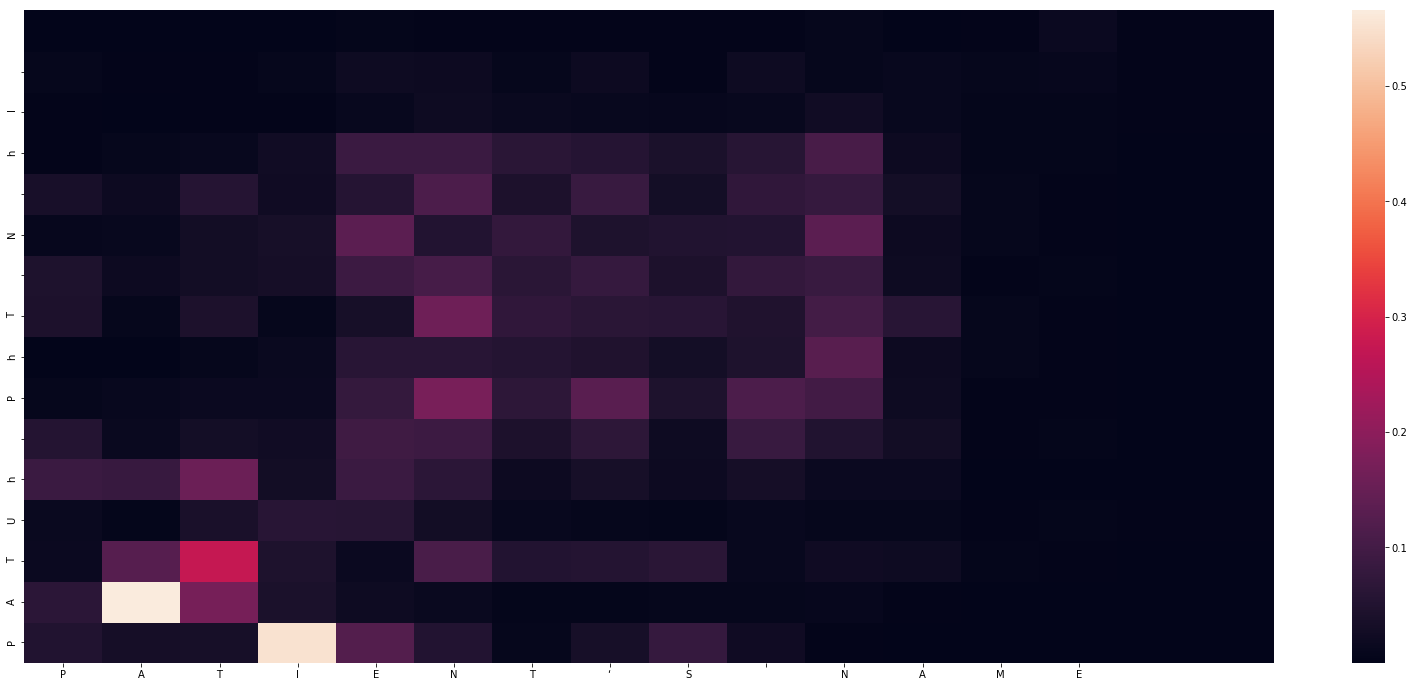

-
Input sentence: PATIENT‘S NAME
GT sentence: PATIENT'S NAME

Decoded sentence: PATUh PhT N hl 


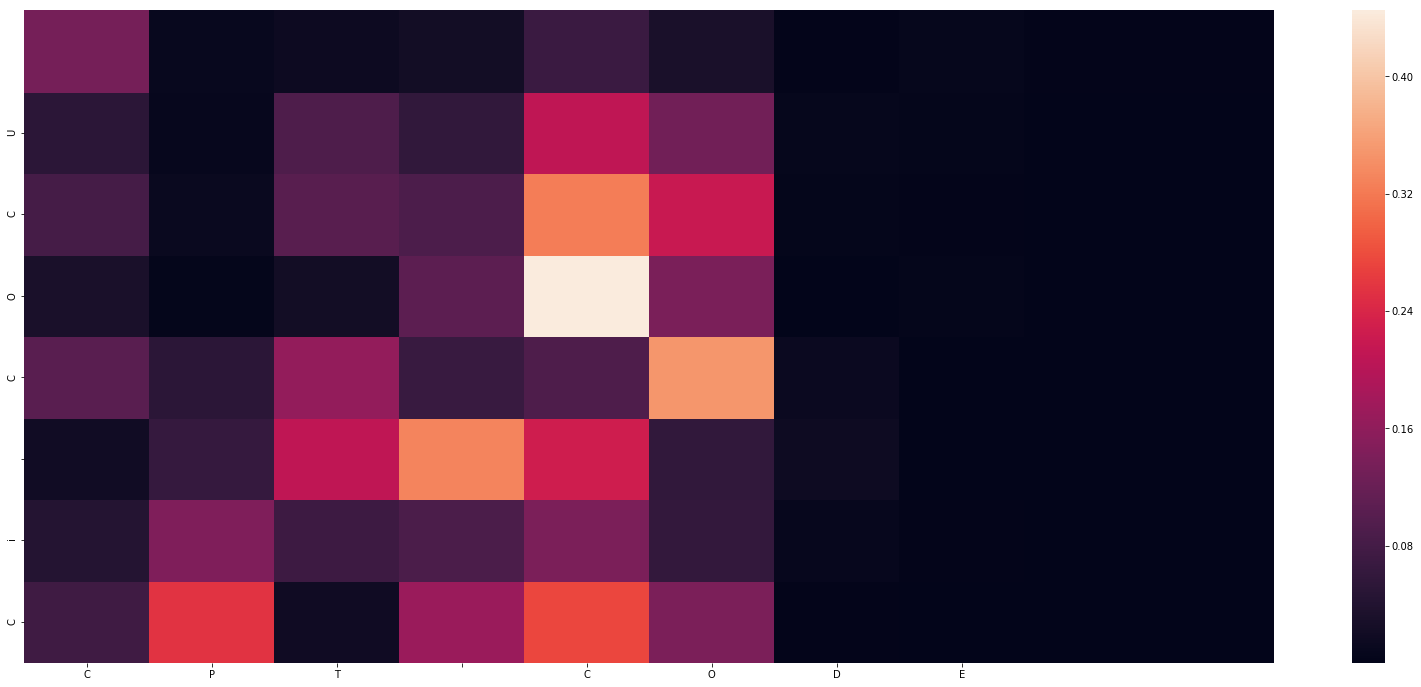

-
Input sentence: CPT CODE
GT sentence: CPT CODE

Decoded sentence: Ci COCU


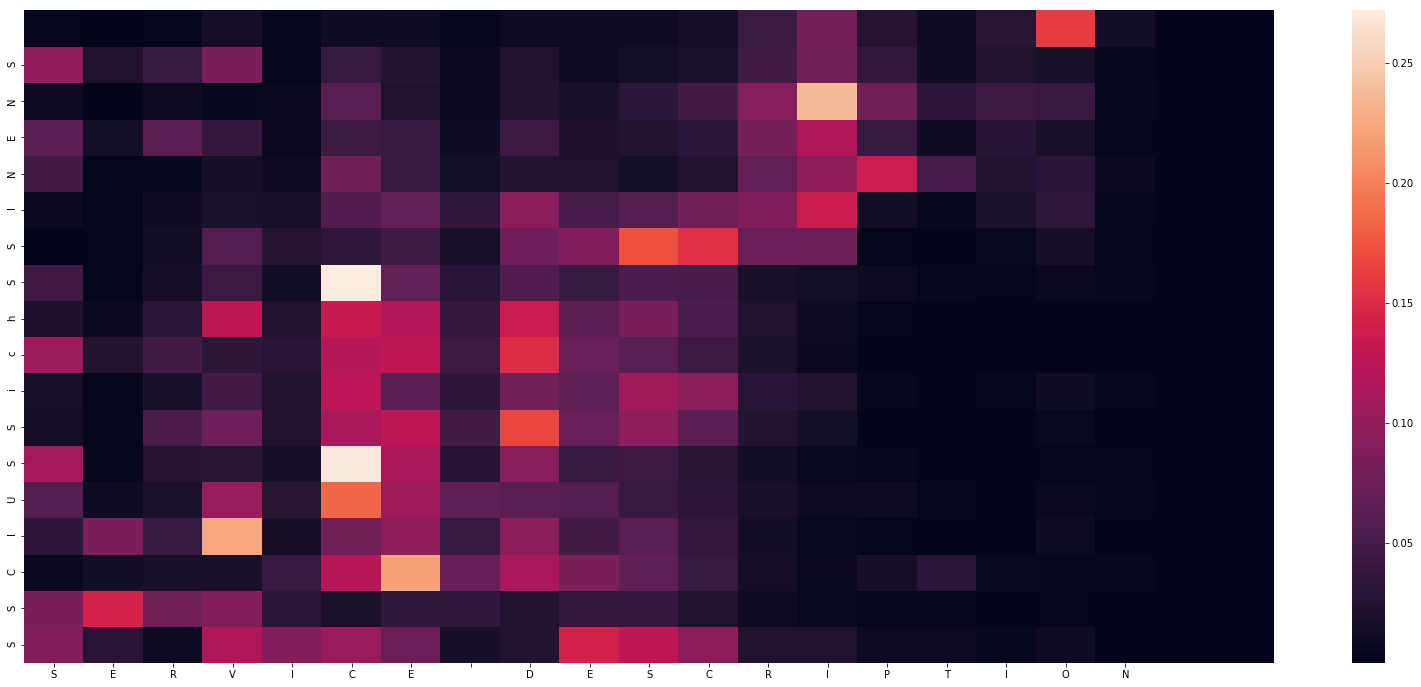

-
Input sentence: SERVICE DESCRIPTION
GT sentence: SERVICE DESCRIPTION

Decoded sentence: SSCIUSSichSSINENS


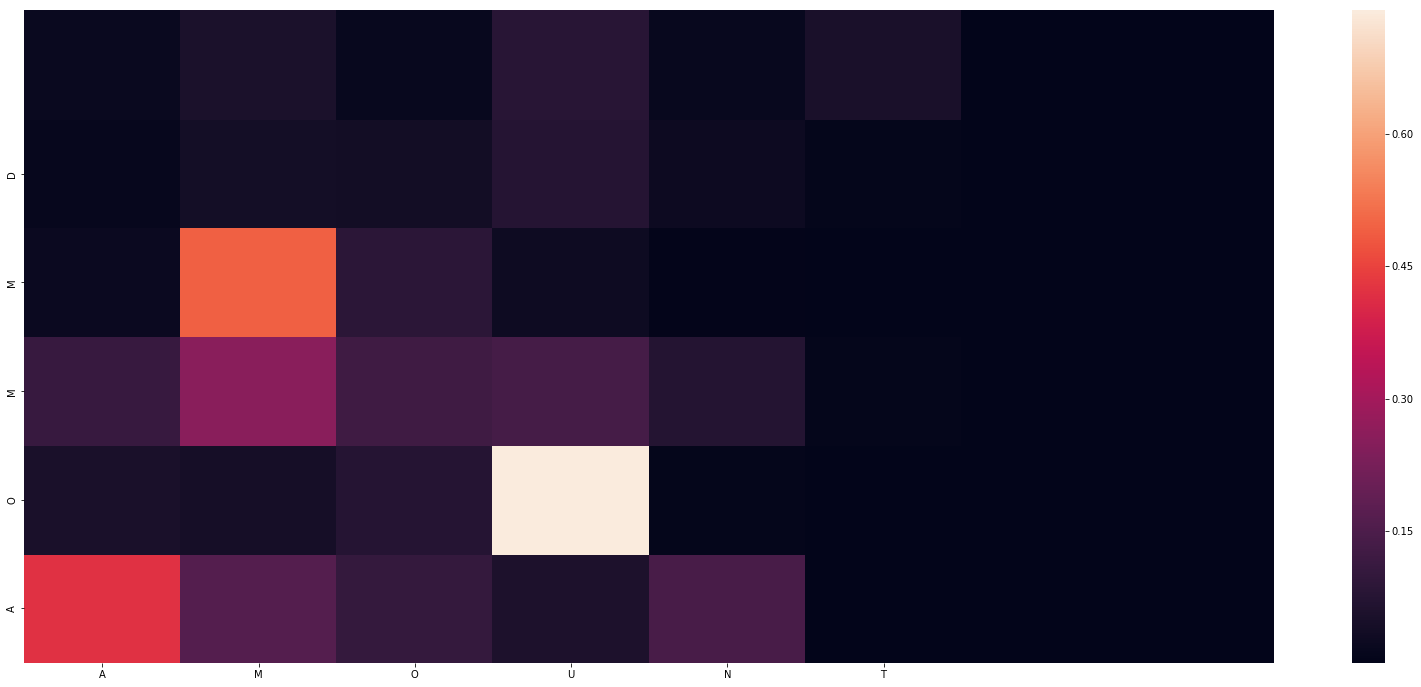

-
Input sentence: AMOUNT
GT sentence: AMOUNT

Decoded sentence: AOMMD


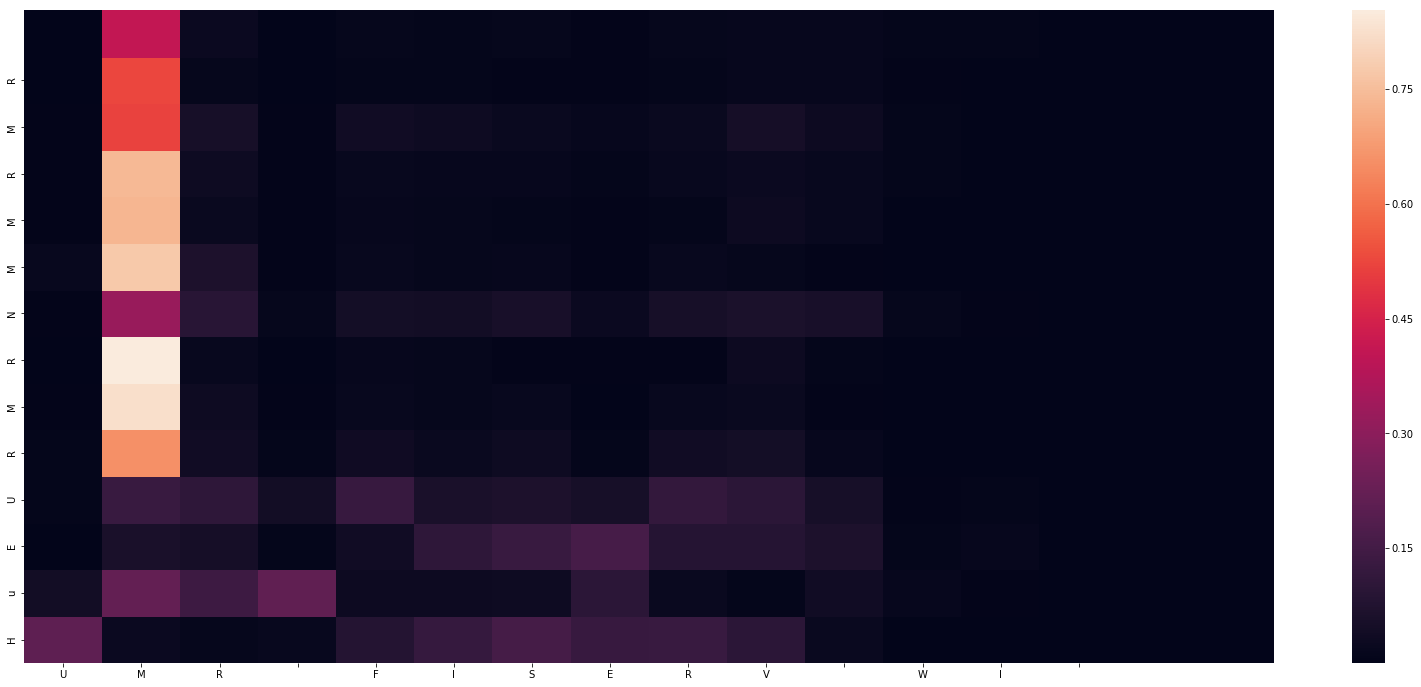

-
Input sentence: UMR FISERV WI 
GT sentence: UMR FISERV WI BILLED ON 12/12/17

Decoded sentence: HuEURMRNMMRMR


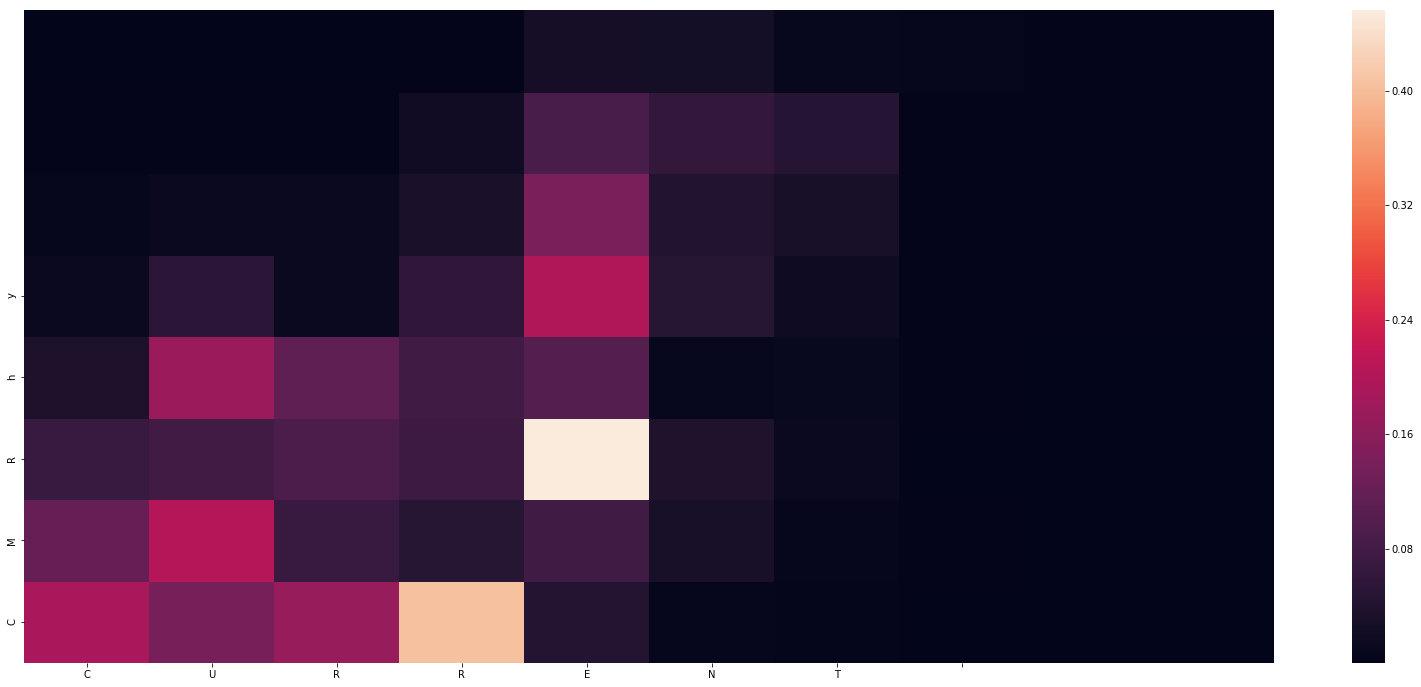

-
Input sentence: CURRENT 
GT sentence: CURRENT 

Decoded sentence: CMRhy


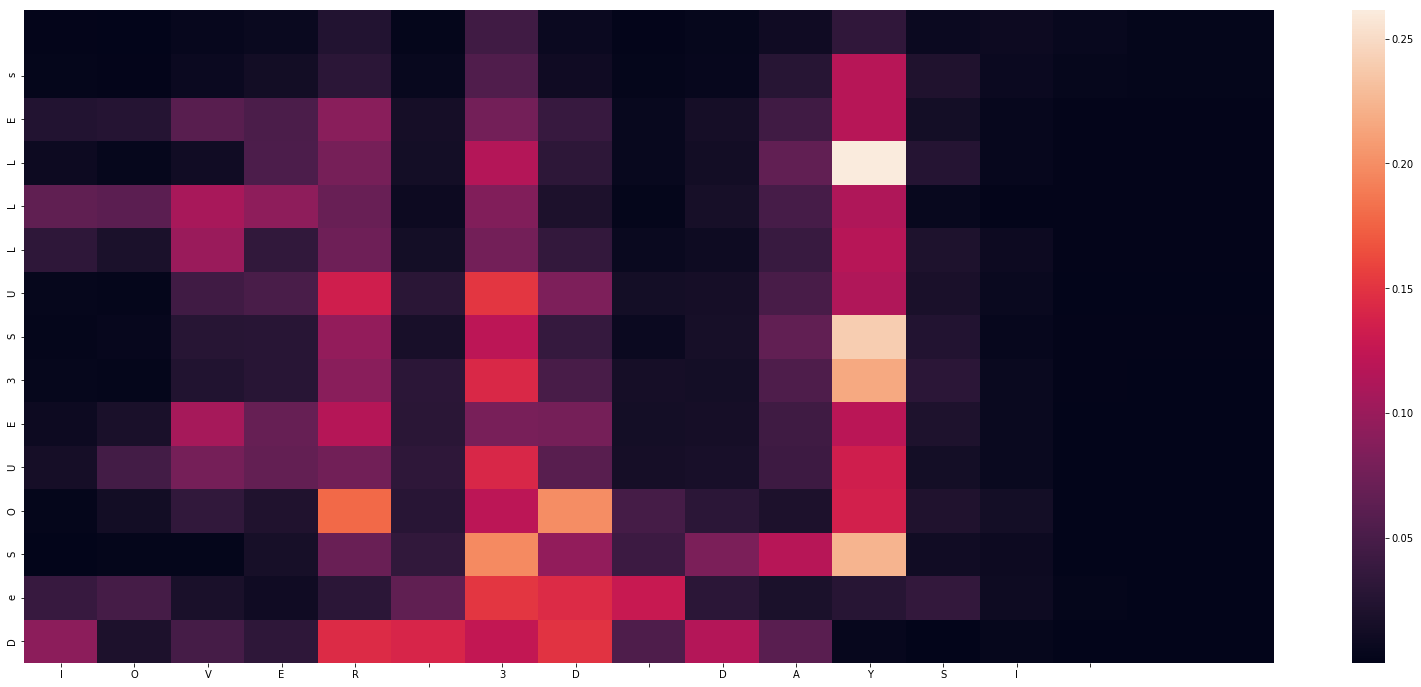

-
Input sentence: IOVER 3D DAYSI 
GT sentence: OVER 30 DAYS 

Decoded sentence: DeSOUE3SULLLEs


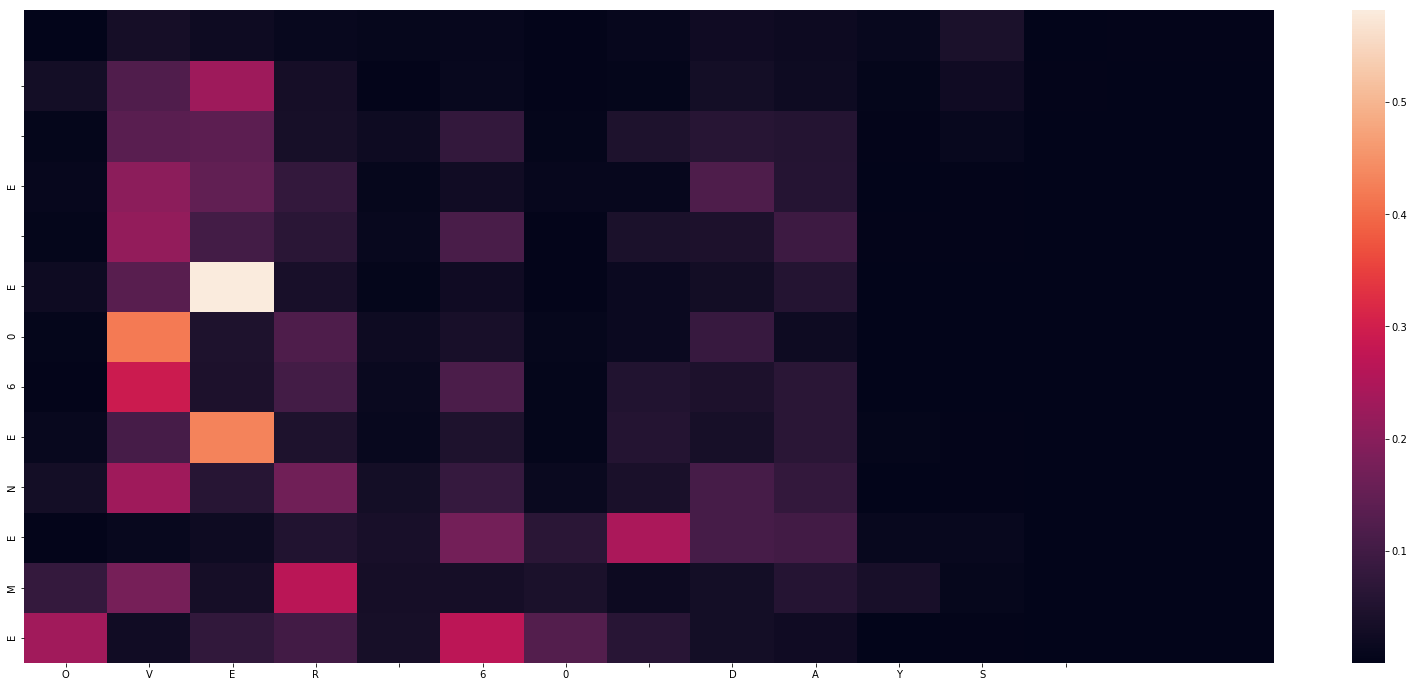

-
Input sentence: OVER 60 DAYS 
GT sentence: OVER 60 DAYS 

Decoded sentence: EMENE60E E  


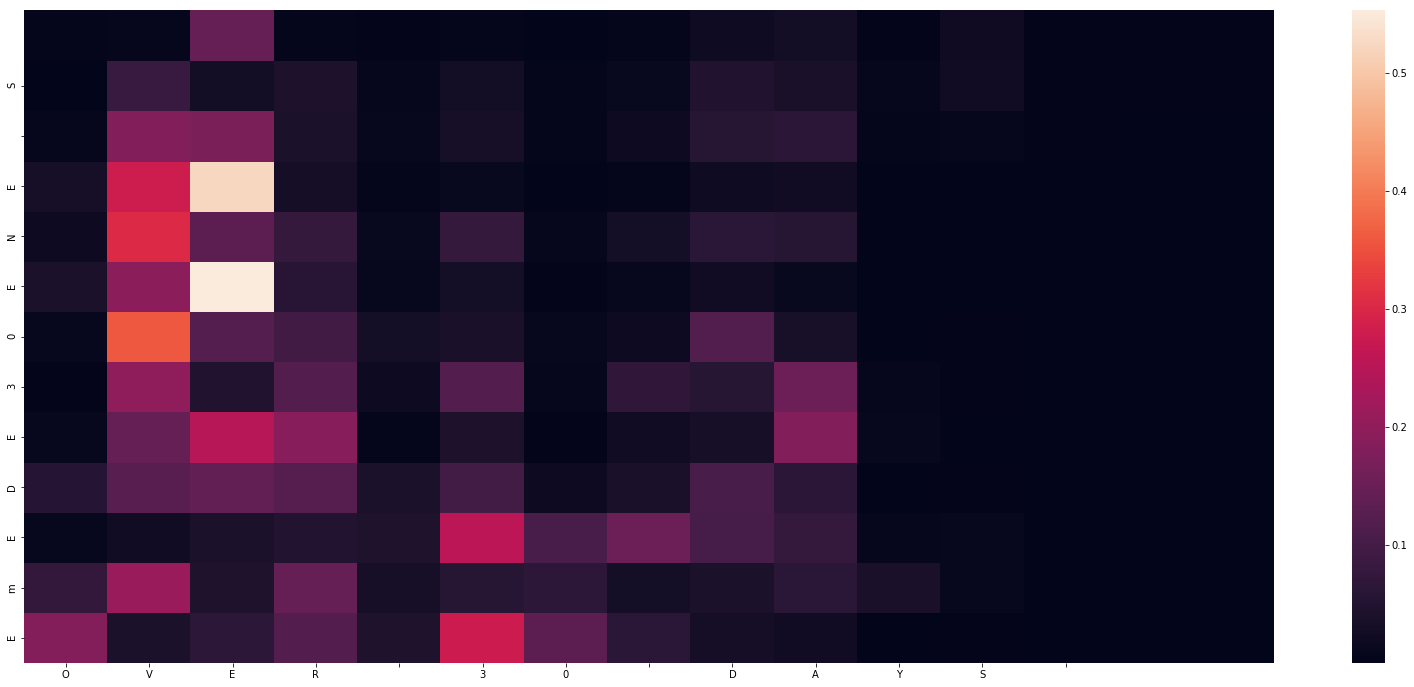

-
Input sentence: OVER 30 DAYS 
GT sentence: OVER 90 DAYS 

Decoded sentence: EmEDE30ENE S


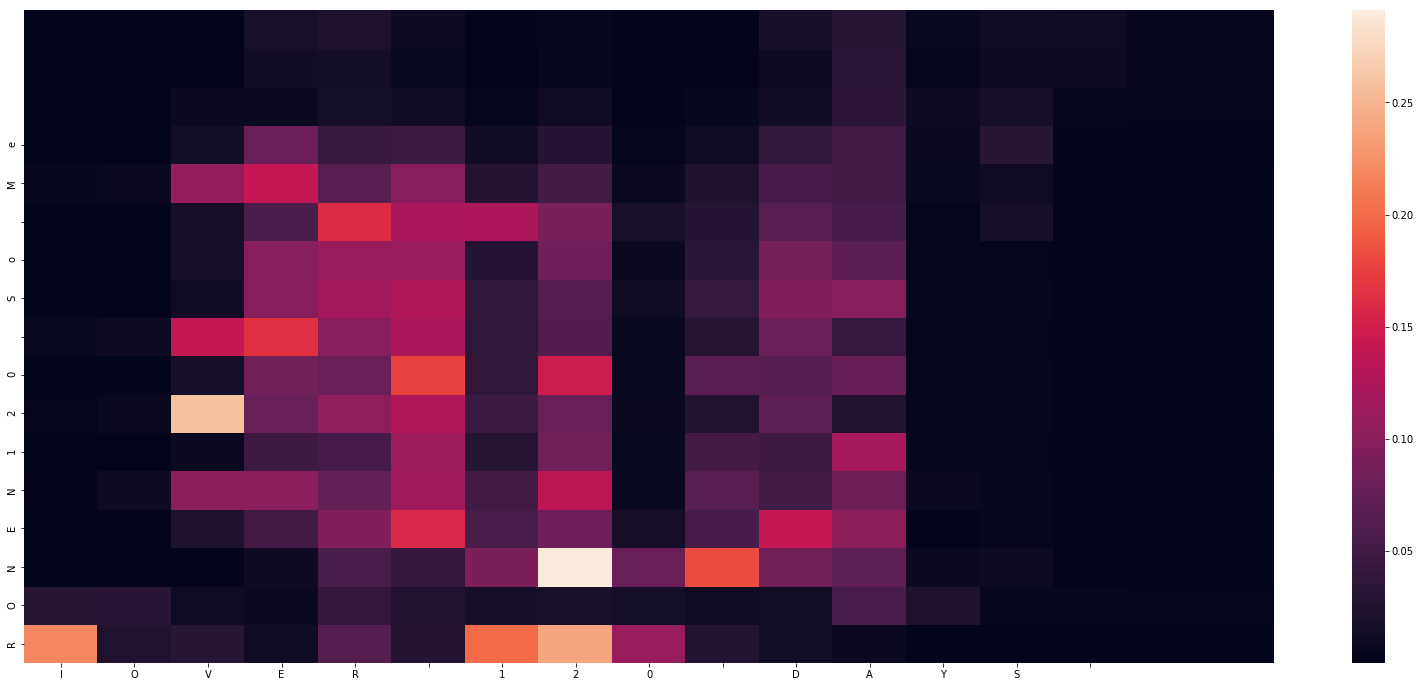

-
Input sentence: IOVER 120 DAYS 
GT sentence: OVER 120 DAYS

Decoded sentence: RONEN120 So Me


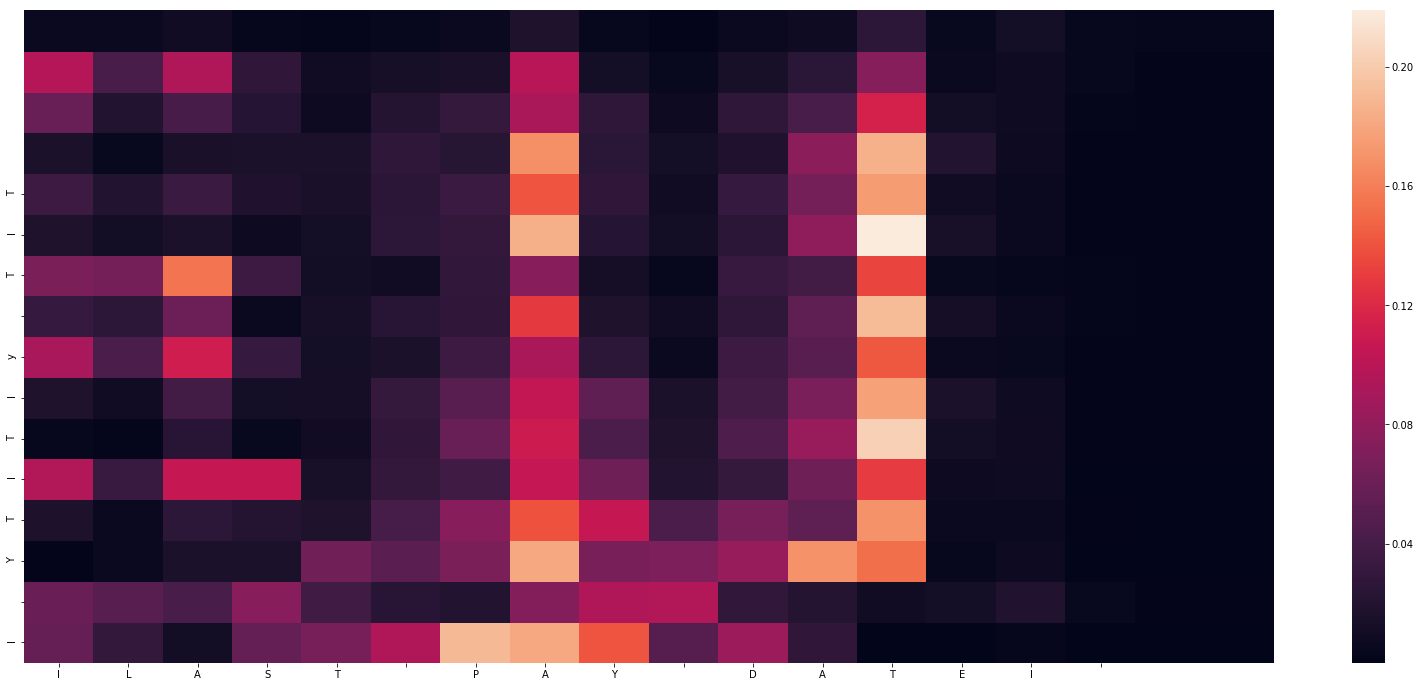

-
Input sentence: ILAST PAY DATEI 
GT sentence: LAST PAY DATE

Decoded sentence: I YTITIy TIT


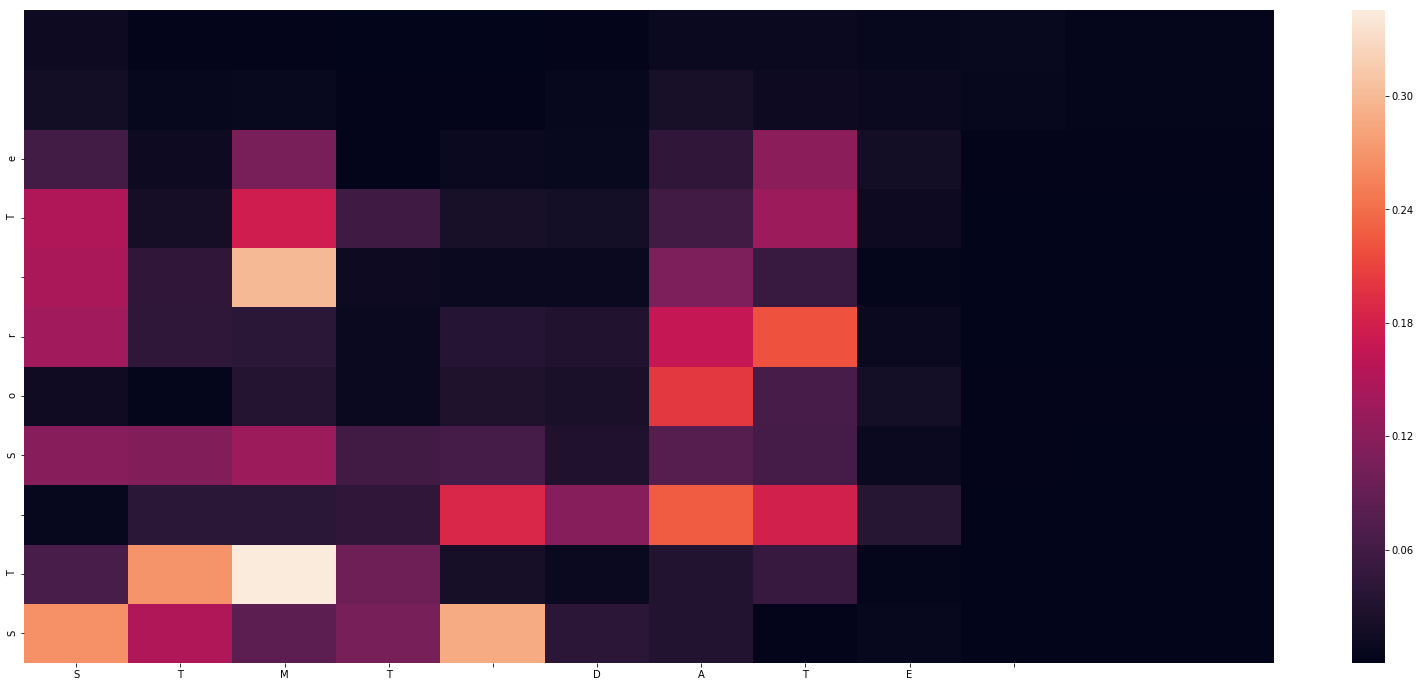

-
Input sentence: STMT DATE 
GT sentence: STMT DATE 

Decoded sentence: ST Sor Te


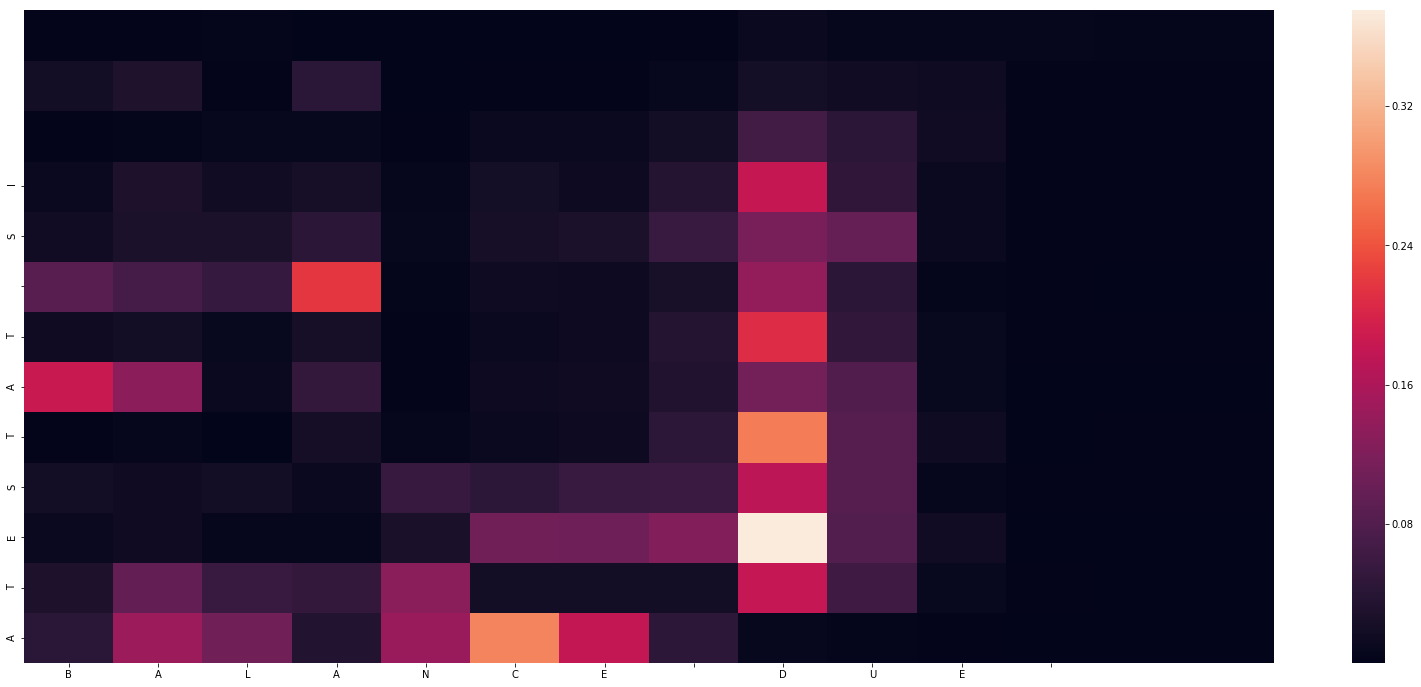

-
Input sentence: BALANCE DUE 
GT sentence: BALANCE DUE

Decoded sentence: ATESTAT Sl


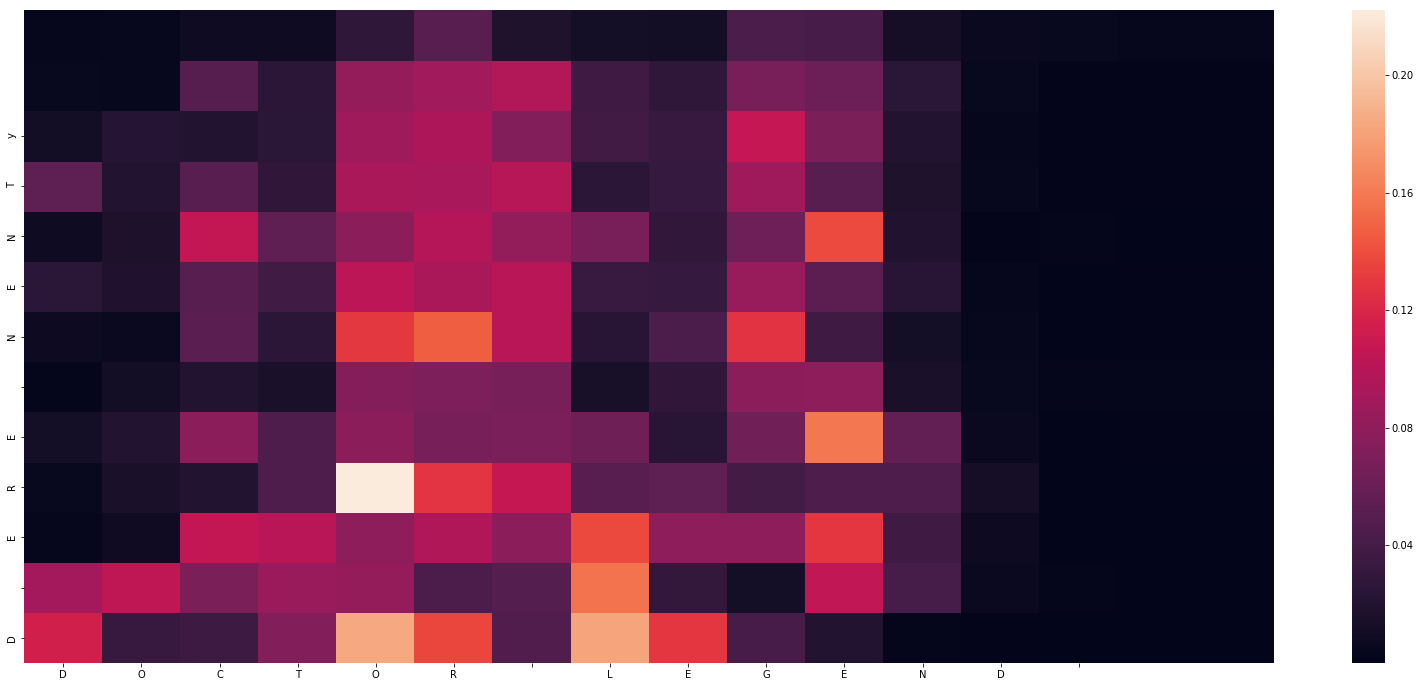

-
Input sentence: DOCTOR LEGEND 
GT sentence: DOCTOR LEGEND

Decoded sentence: D ERE NENTy


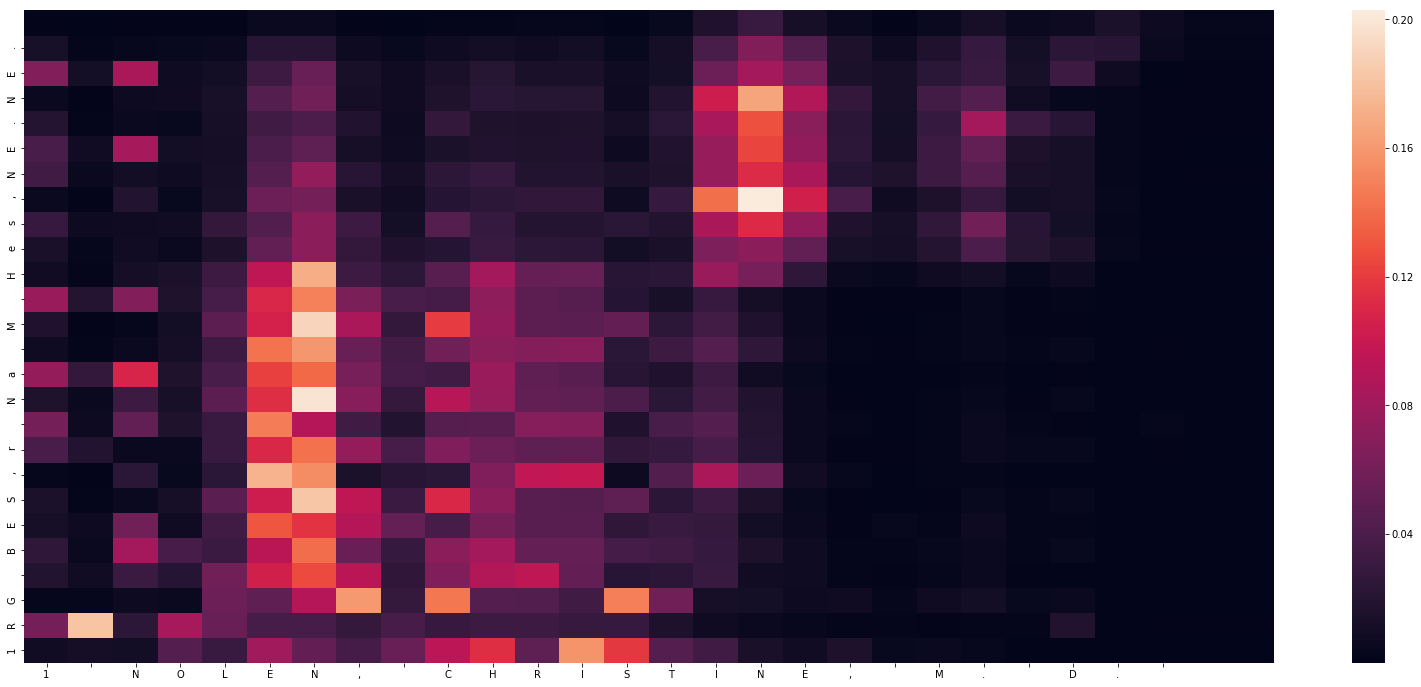

-
Input sentence: 1 NOLEN, CHRISTINE, M. D. 
GT sentence: 1 NOLEN, CHRISTINE, M. D.

Decoded sentence: 1RG BES,r Na M Hes,NE.NE.


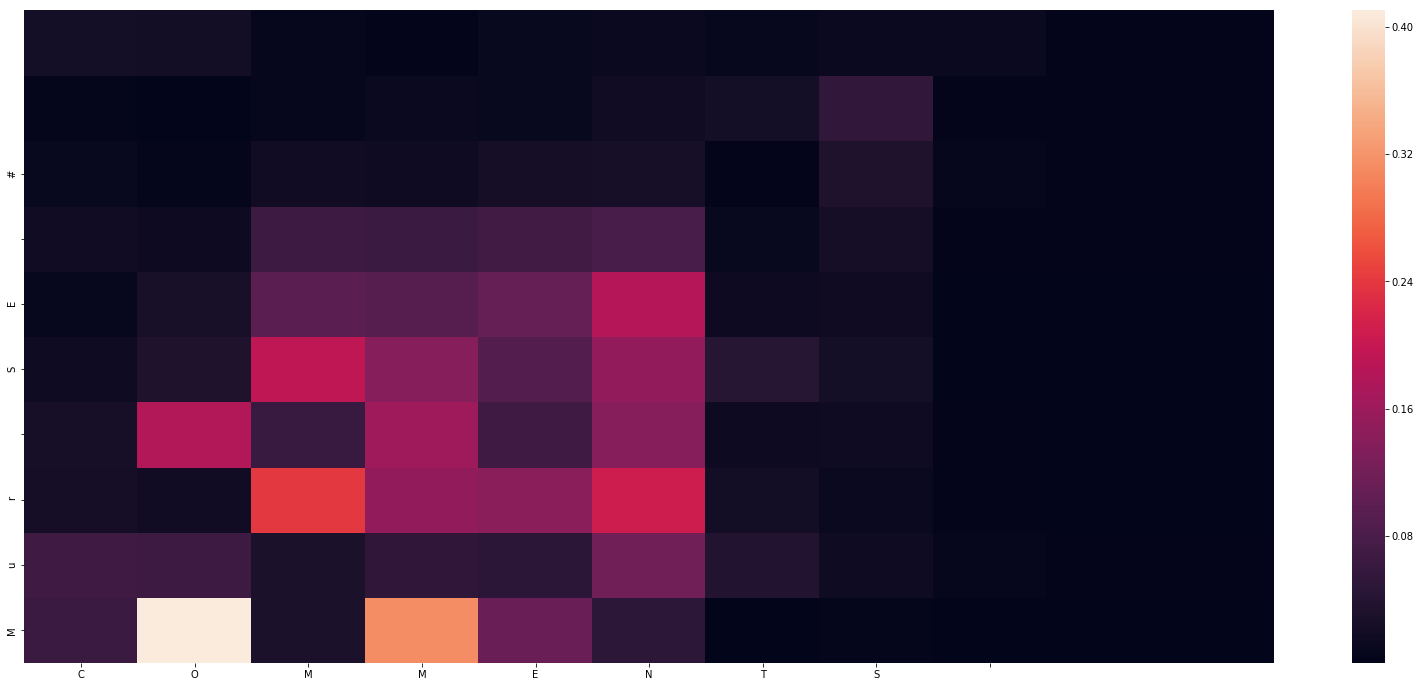

-
Input sentence: COMMENTS 
GT sentence: COMMENTS

Decoded sentence: Mur SE #


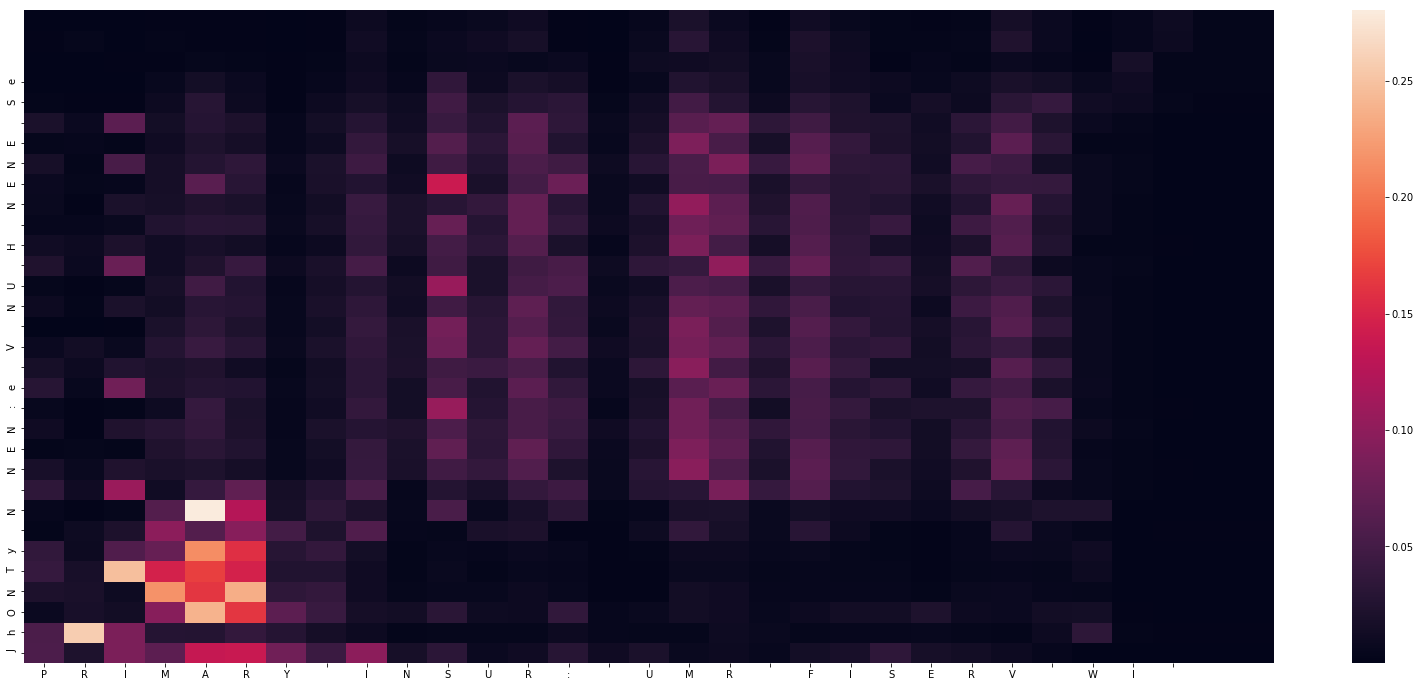

-
Input sentence: PRIMARY INSUR: UMR FISERV WI 
GT sentence: PRIMARY INSUR: UMR FISERV WI

Decoded sentence: JhONTy N NEN:e V NU H NENE Se


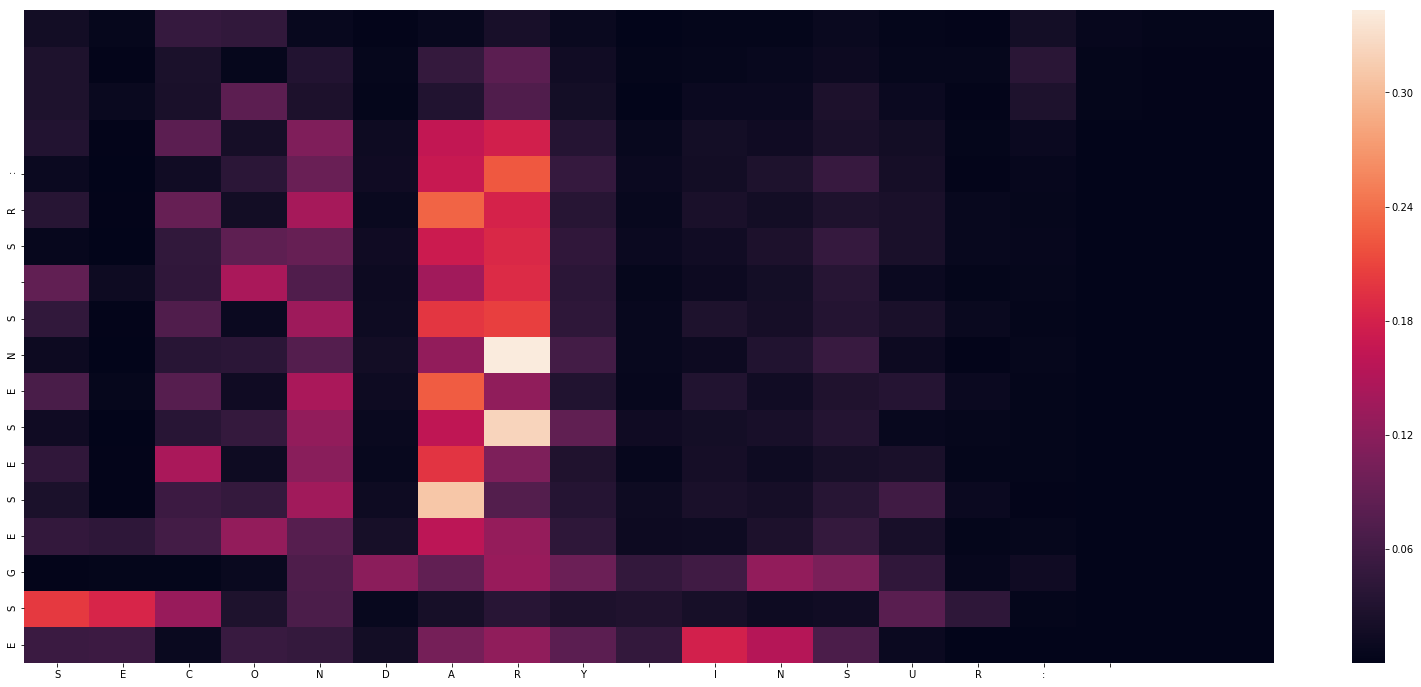

-
Input sentence: SECONDARY INSUR: 
GT sentence: SECONDARY INSUR:

Decoded sentence: ESGESESENS SR:


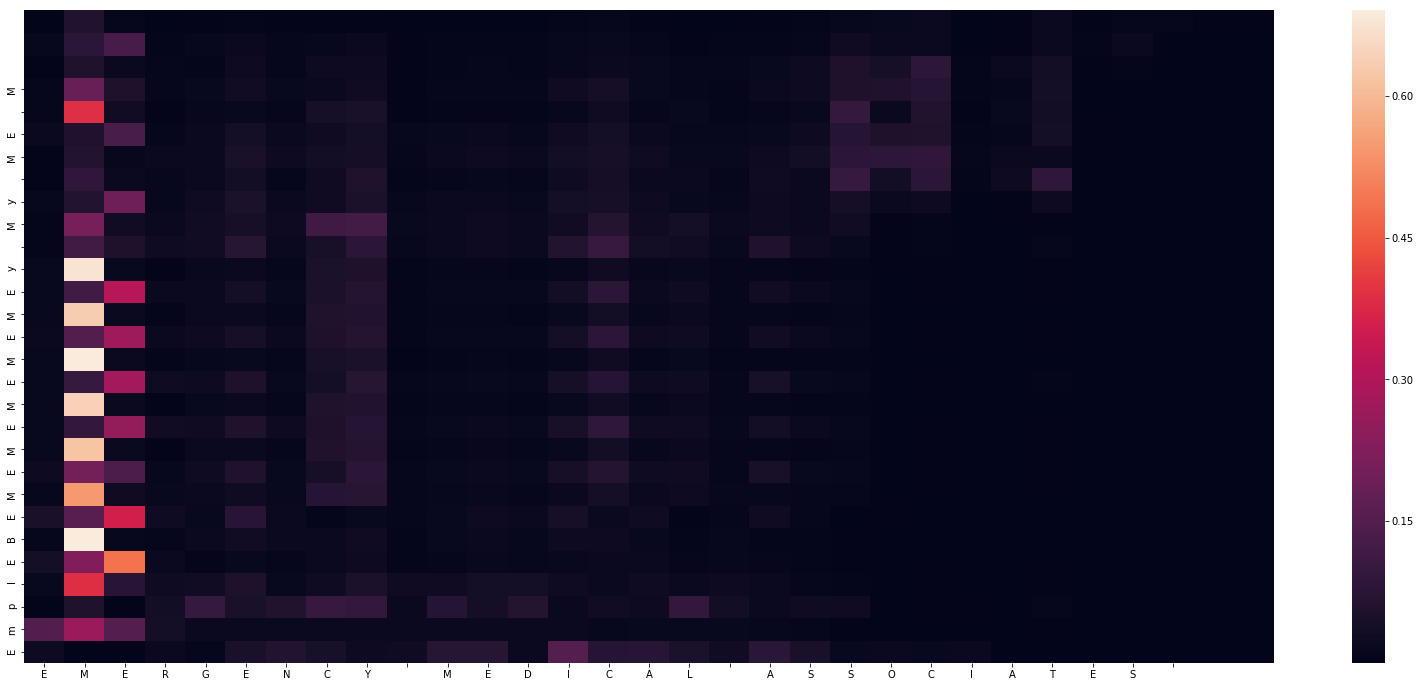

-
Input sentence: EMERGENCY MEDICAL ASSOCIATES 
GT sentence: EMERGENCY MEDICAL ASSOCIATES

Decoded sentence: EmplEBEMEMEMEMEMEy My ME M


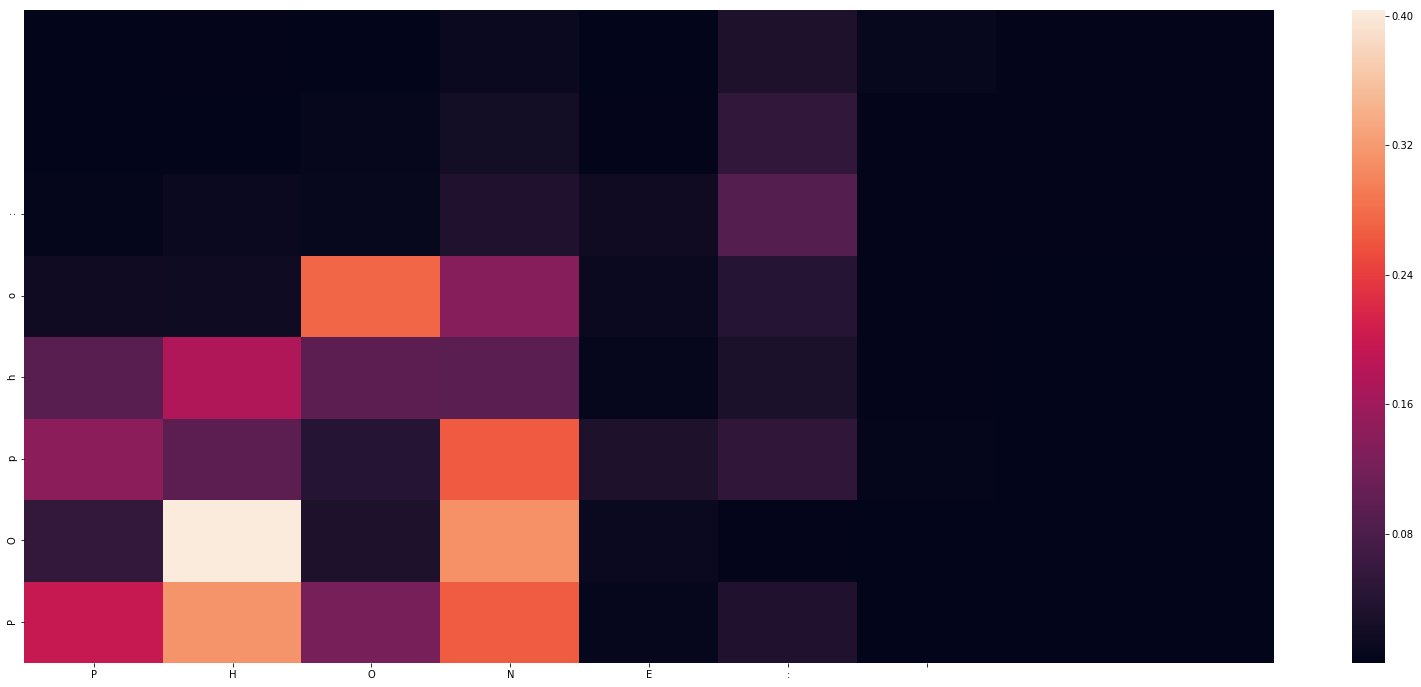

-
Input sentence: PHONE: 
GT sentence: PHONE:

Decoded sentence: POpho:


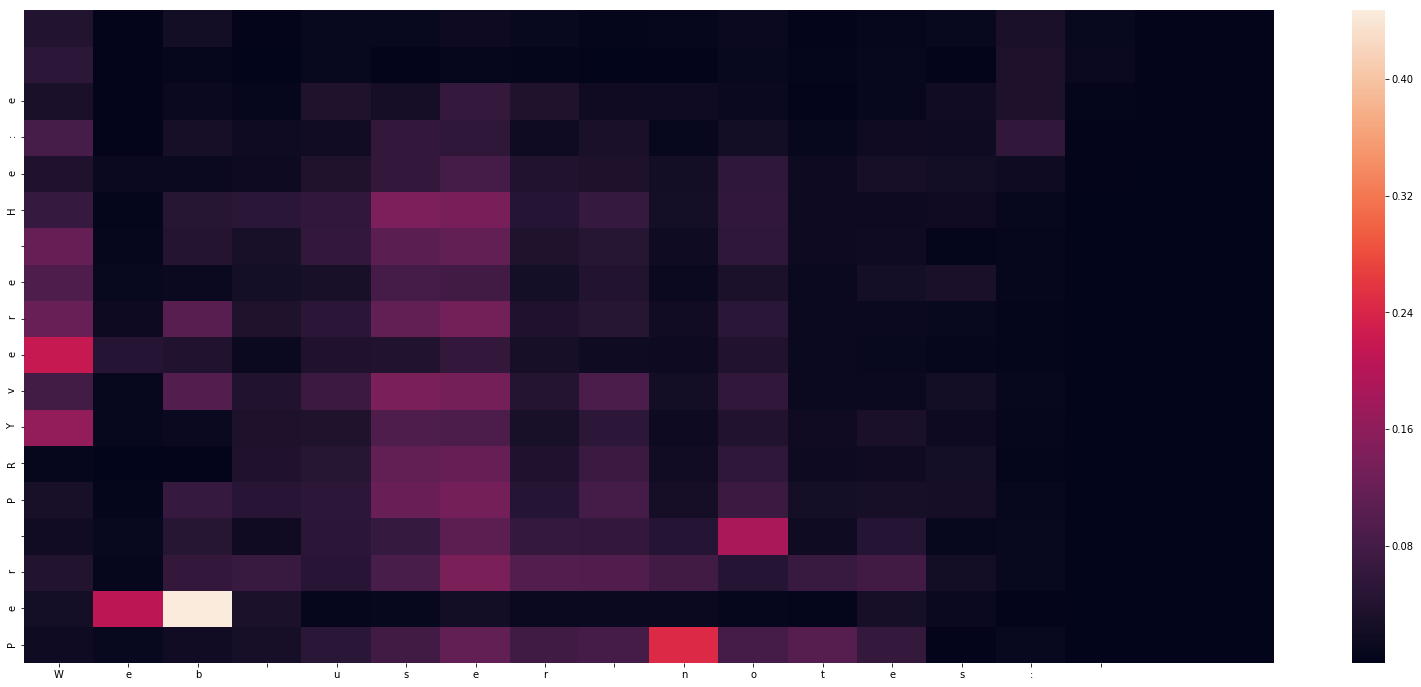

-
Input sentence: Web user notes: 
GT sentence: Web user notes:

Decoded sentence: Per PRYvere He:e


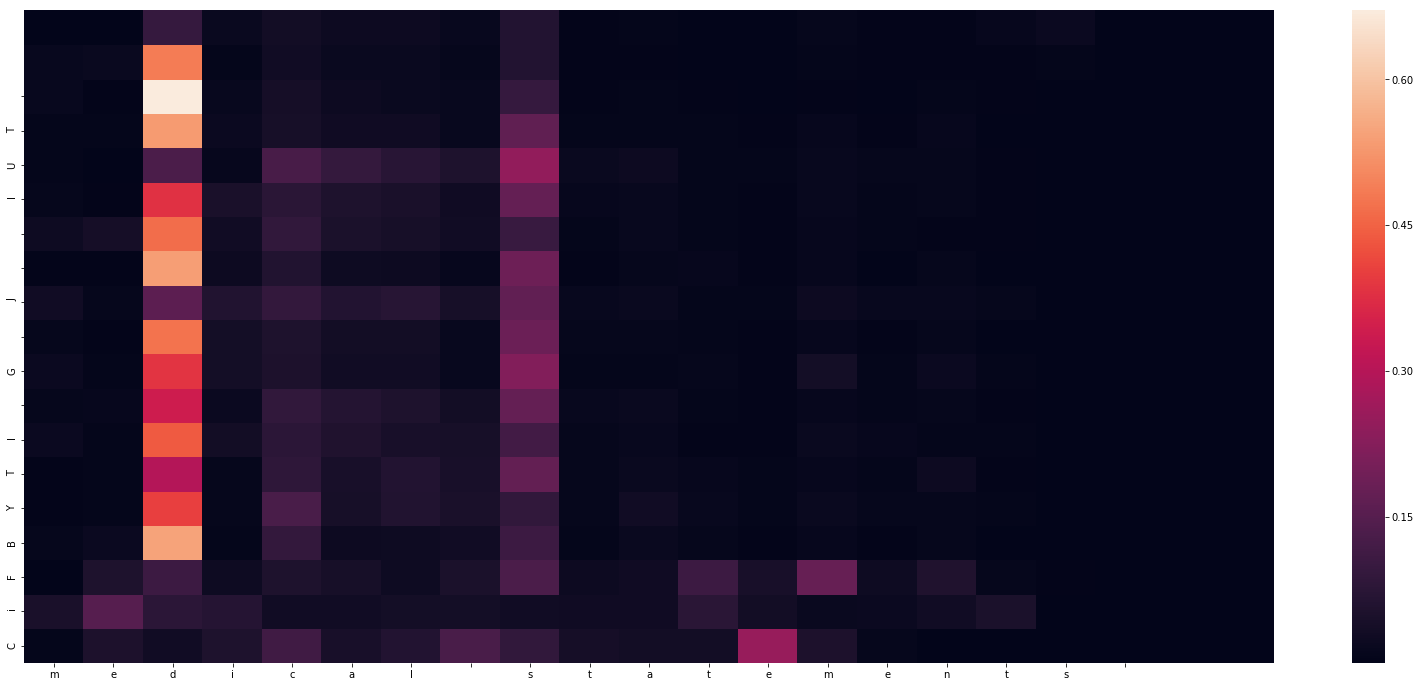

-
Input sentence: medical statements 
GT sentence: medical statements

Decoded sentence: CiFBYTI G J  IUT 


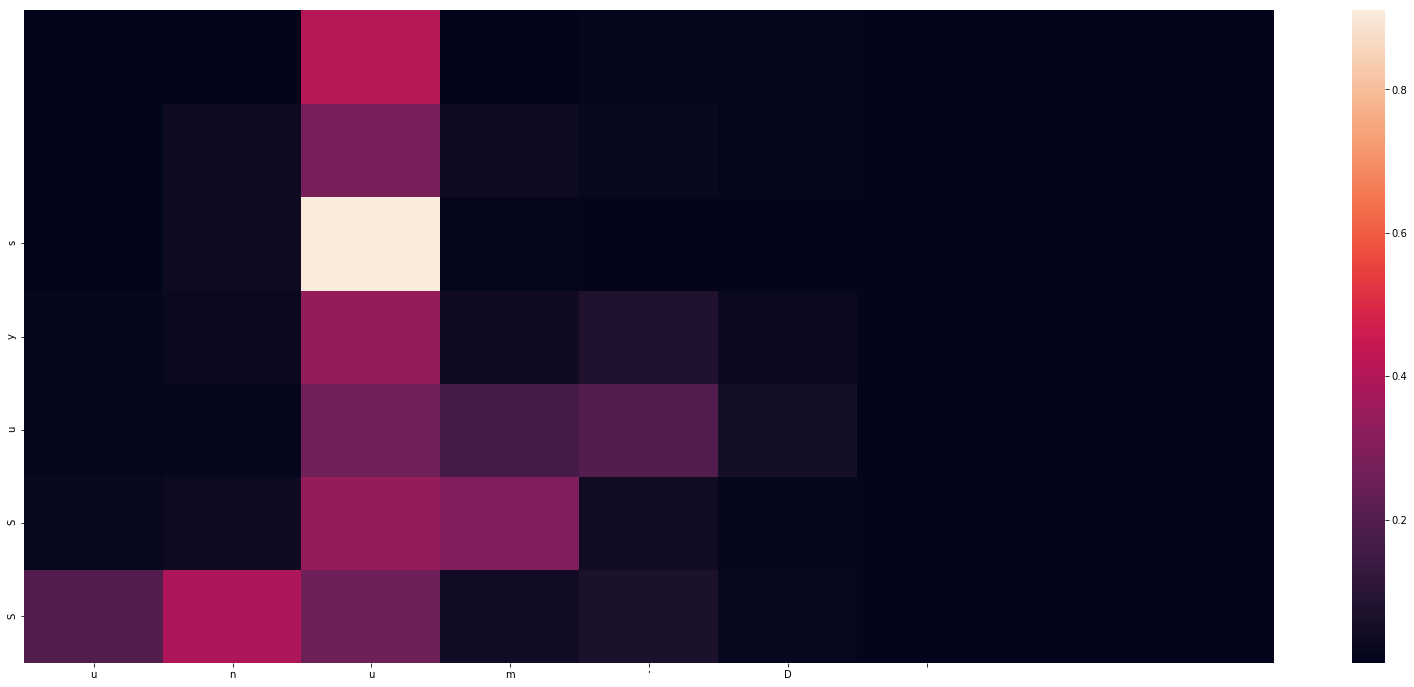

-
Input sentence: unum‘D 
GT sentence: unum

Decoded sentence: SSuys


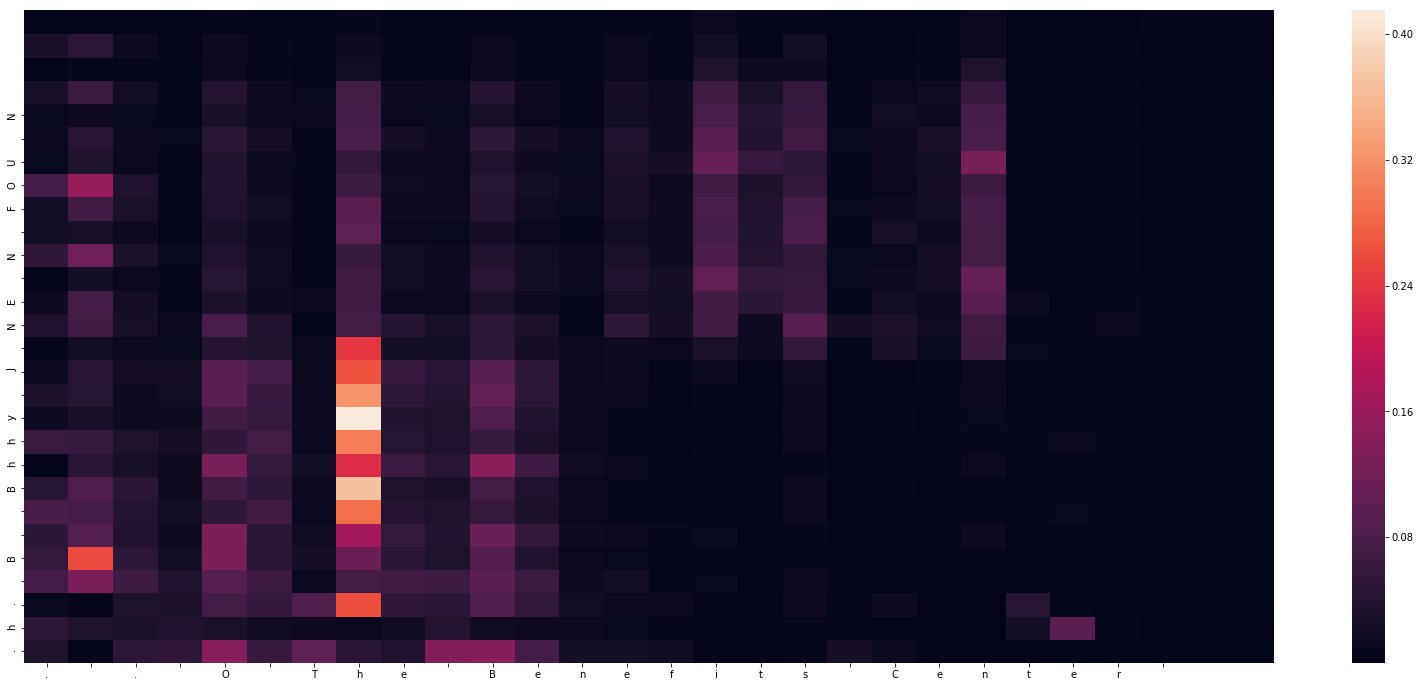

-
Input sentence: . . O The Benefits Center 
GT sentence: The Benefits Center

Decoded sentence: .h. B  Bhhy J NE N FOU N


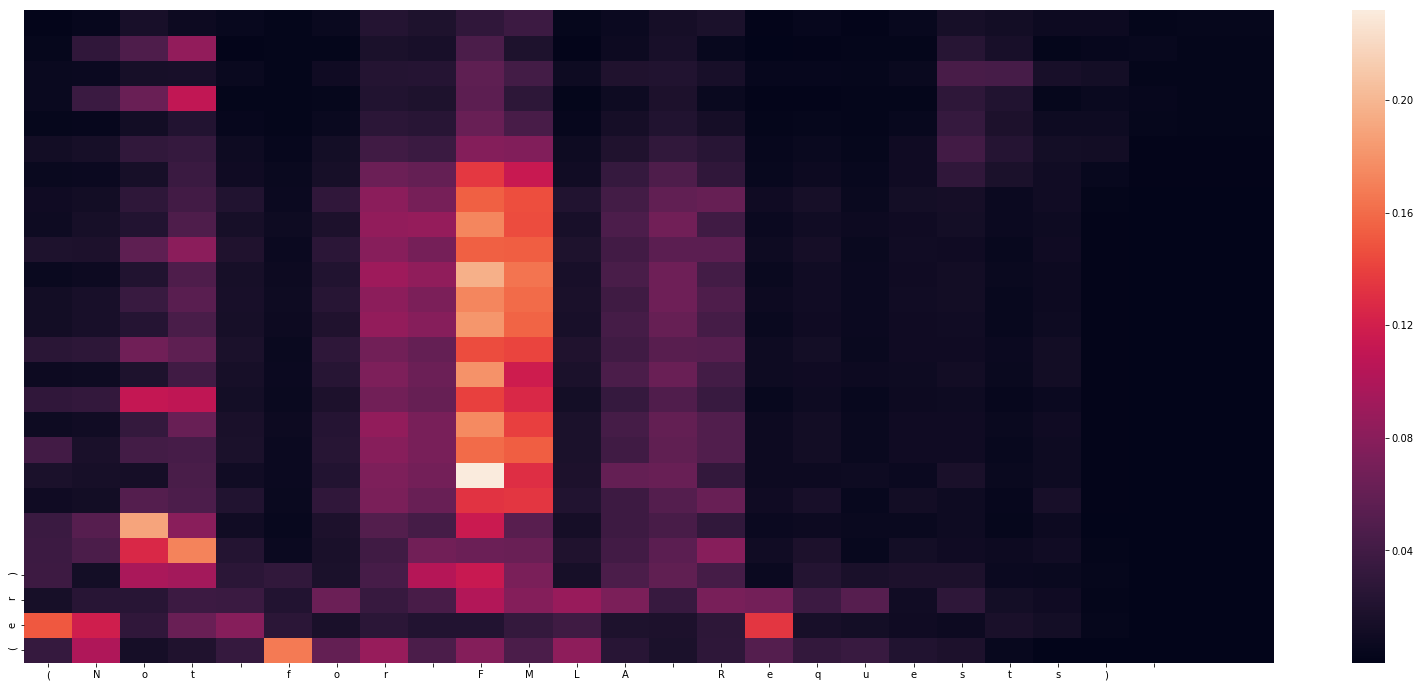

-
Input sentence: (Not for FMLA Requests) 
GT sentence: (Not for FMLA Requests)

Decoded sentence: (er)


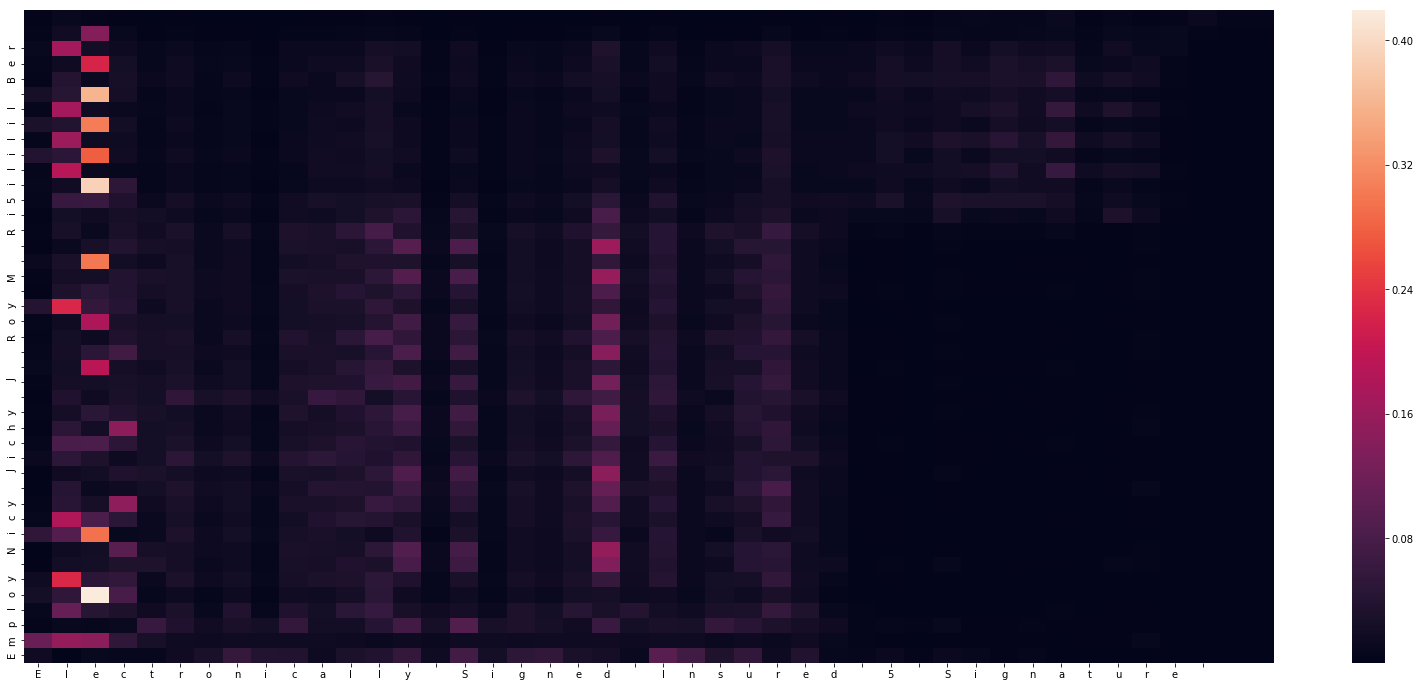

-
Input sentence: Electronically Signed Insured 5 Signature 
GT sentence: Electronically Signed Insured's Signature

Decoded sentence: Employ Nicy Jichy J  Roy M  Ri5ililil Ber


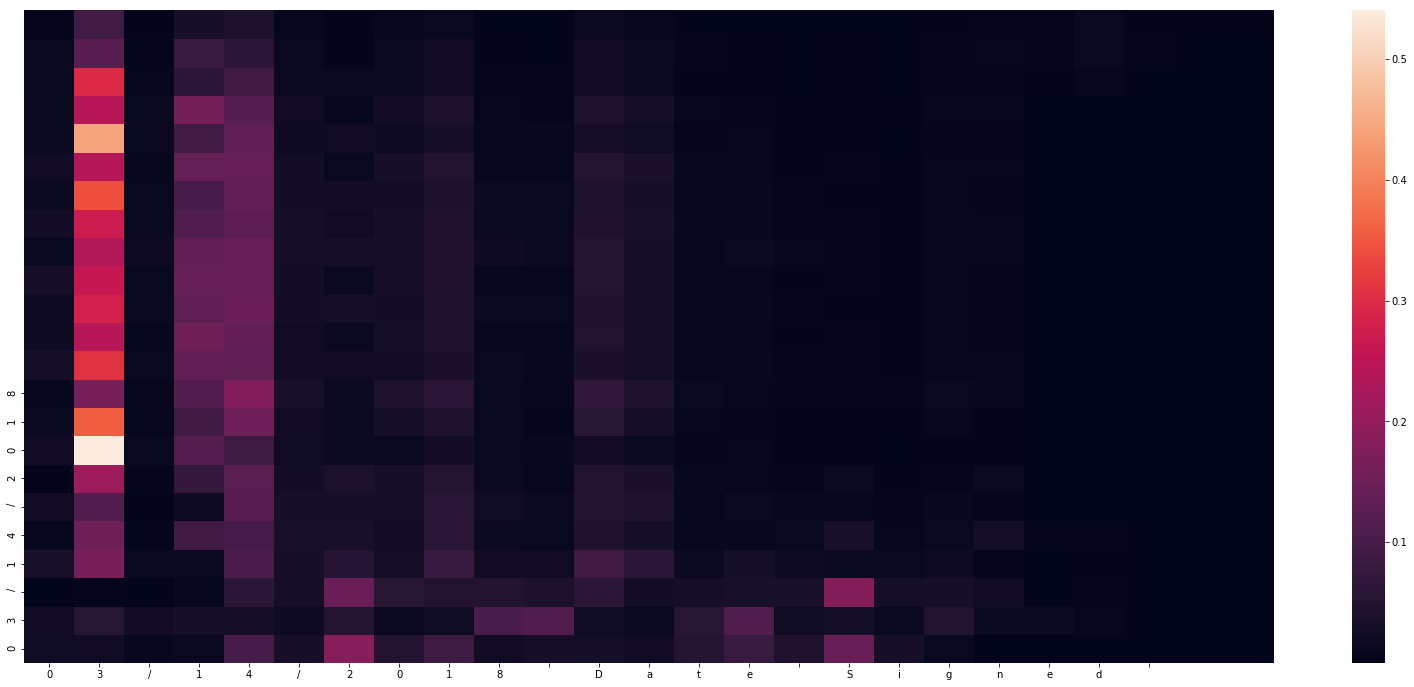

-
Input sentence: 03/14/2018 Date Signed 
GT sentence: 03/14/2018 Date Signed

Decoded sentence: 03/14/2018


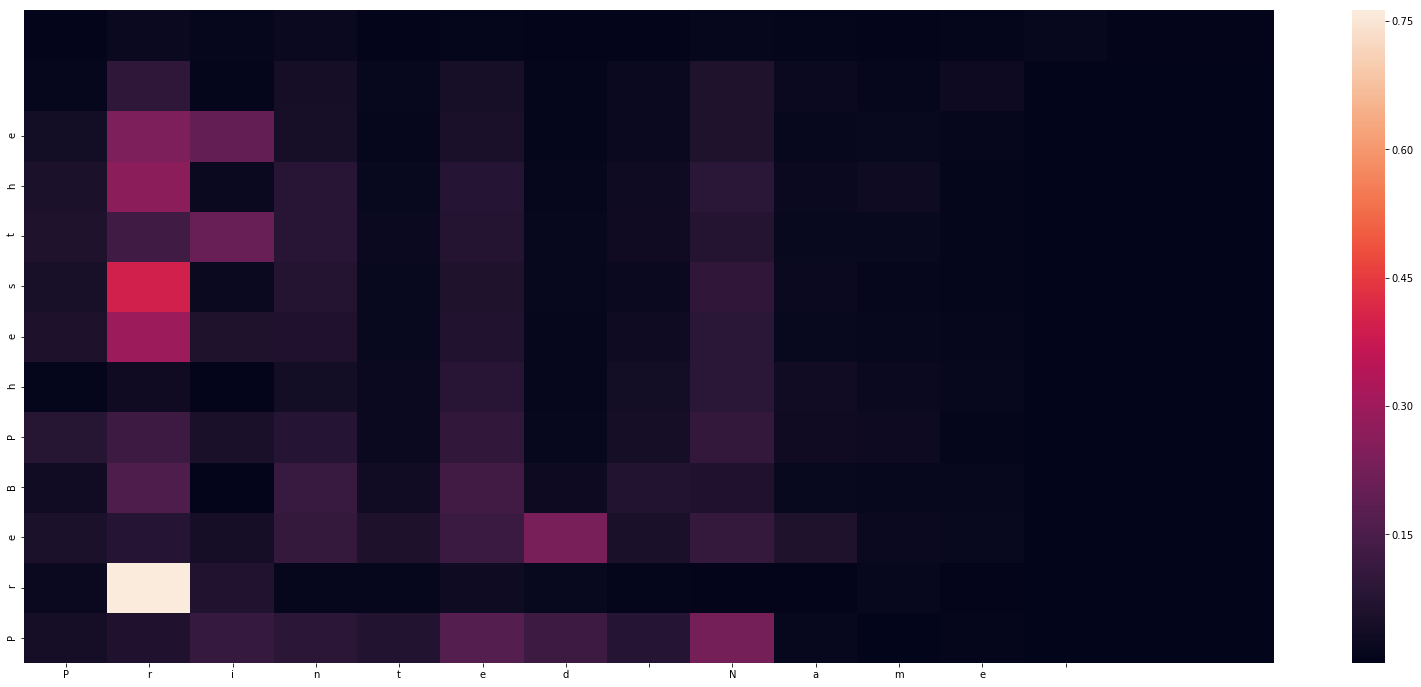

-
Input sentence: Printed Name 
GT sentence: Printed Name

Decoded sentence: PreBPhesthe


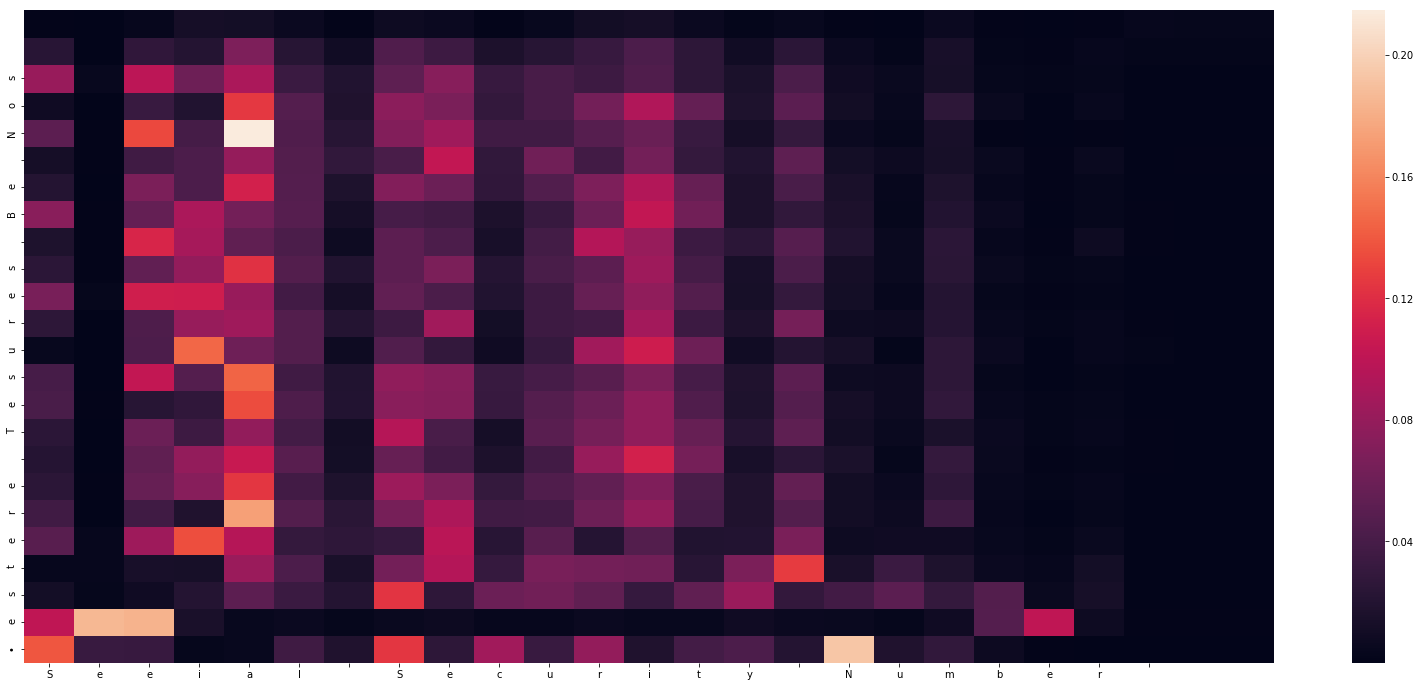

-
Input sentence: Seeial Security Number 
GT sentence: Social Security Number

Decoded sentence: •estere Tesures Be Nos


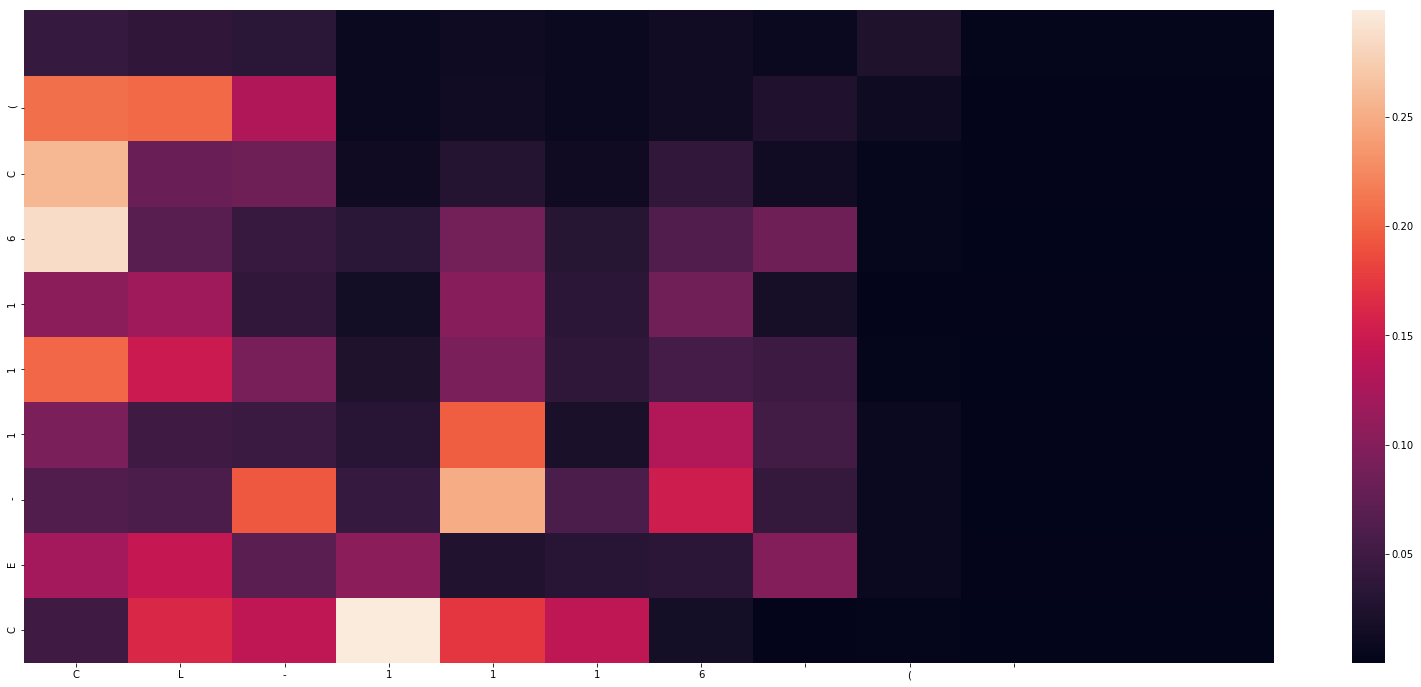

-
Input sentence: CL-1116 ( 
GT sentence: CL-1116

Decoded sentence: CE-1116C(


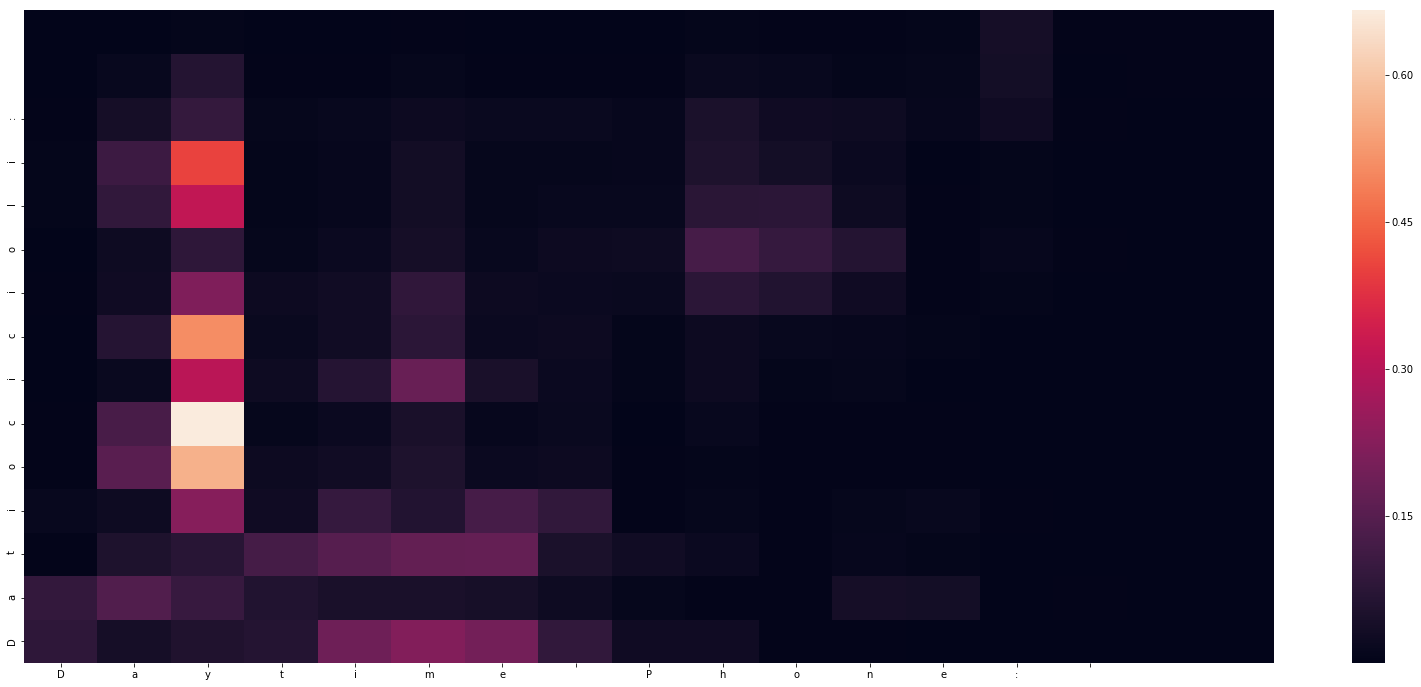

-
Input sentence: Daytime Phone: 
GT sentence: Daytime Phone:

Decoded sentence: Datiocicioli:


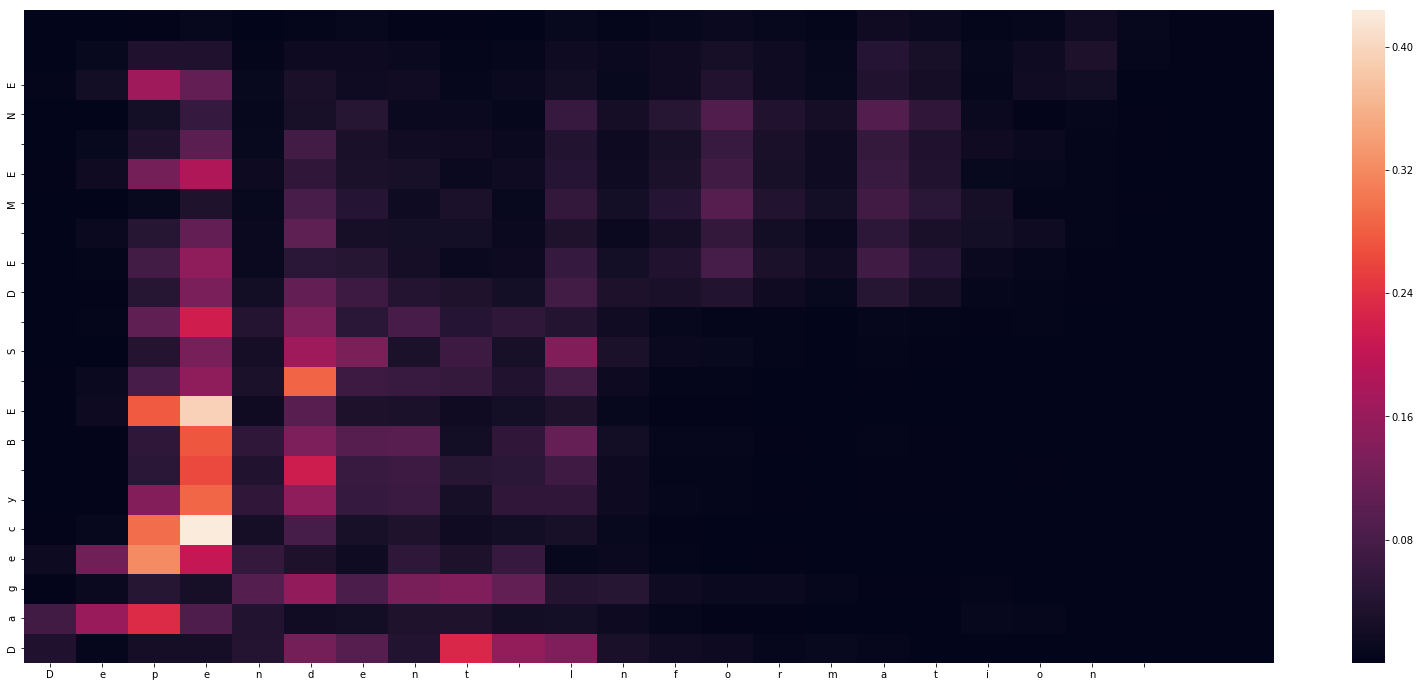

-
Input sentence: Dependent Information 
GT sentence: Dependent Information

Decoded sentence: Dagecy BE S DE ME NE


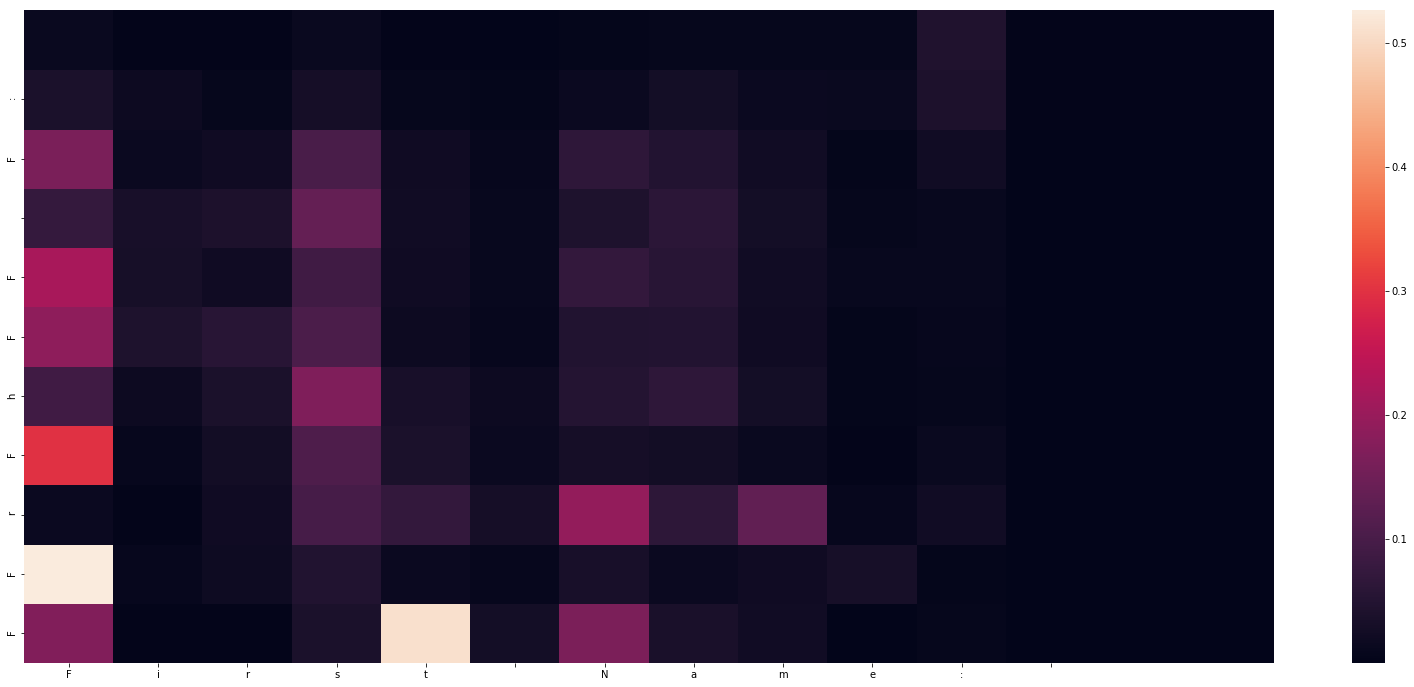

-
Input sentence: First Name: 
GT sentence: First Name:

Decoded sentence: FFrFhFF F:


In [77]:
for seq_index in range(100):

    target_text = target_texts[seq_index][1:-1]
    text = input_texts[seq_index]
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)  

# Domain transfer from noisy spelling mistakes to OCR corrections

In [78]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_4/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_5/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_4/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(?, ?, 512), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 118)    13924       input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, None)         0                                            
______________

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


## Pre-train on noisy spelling mistakes

In [79]:

input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.01

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model_transfer.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 318s 40ms/step - loss: 2.5718 - categorical_accuracy: 0.3039 - val_loss: 1.2710 - val_categorical_accuracy: 0.6163

Epoch 00001: val_categorical_accuracy improved from -inf to 0.61626, saving model to best_model_transfer.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_4/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_5/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
8000/8000 [==============================] - 315s 39ms/step - loss: 0.6234 - categorical_accuracy: 0.7936 - val_loss: 0.2491 - val_categorical_accuracy: 0.8909

Epoch 00002: val_categorical_accuracy improved from 0.61626 to 0.89089, saving model to best_model_transfer.hdf5
Epoch 3/50
8000/8000 [==============================] - 316s 39ms/step - loss: 0.2242 - categorical_accuracy: 0.8988 - val_loss: 0.1666 - val_categorical_accuracy: 0.9137

Epoch 00003: val_categorical_accuracy improved from 0.89089 to 0.91367, saving model to best_model_transfer.hdf5
Epoch 4/50
8000/8000 [==============================] - 316s 39ms/step - loss: 0.1340 - categorical_accuracy: 0.9222 - val_loss: 0.1351 - val_categorical_accuracy: 0.9217

Epoch 00004: val_categorical_accuracy improved from 0.91367 to 0.92166, saving model to best_model_transfer.hdf5
Epoch 5/50
8000/8000 [==============================] - 316s 40ms/step - loss: 0.0928 - categorical_accuracy: 0.9330 - val_loss: 0.1187 - val_cat

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Fine tune on OCR correction data

In [80]:

input_texts = input_texts_OCR
target_texts = target_texts_OCR

# Keep test data from the corrected OCR, as this what we care about
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

# Vectorize train data
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)
# Vectorize test data
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)


batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.001# Reduce the learning rate for fine tuning
model.load_weights('best_model_transfer.hdf5')
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 1233 samples, validate on 218 samples
Epoch 1/50
1233/1233 [==============================] - 51s 41ms/step - loss: 0.8619 - categorical_accuracy: 0.8428 - val_loss: 0.8201 - val_categorical_accuracy: 0.8470

Epoch 00001: val_categorical_accuracy did not improve from 0.93195
Epoch 2/50
1233/1233 [==============================] - 48s 39ms/step - loss: 0.6317 - categorical_accuracy: 0.8630 - val_loss: 0.7169 - val_categorical_accuracy: 0.8565

Epoch 00002: val_categorical_accuracy did not improve from 0.93195
Epoch 3/50
1233/1233 [==============================] - 48s 39ms/step - loss: 0.5334 - categorical_accuracy: 0.8741 - val_loss: 0.6768 - val_categorical_accuracy: 0.8623

Epoch 00003: val_categorical_accuracy did not improve from 0.93195
Epoch 4/50
1233/1233 [==============================] - 48s 39ms/step - loss: 0.4749 - categorical_accuracy: 0.8823 - val_loss: 0.6597 - val_categorical_accuracy: 0.8634

Epoch 00004: val_categorical_accuracy did not improve from 0.93195
E

1233/1233 [==============================] - 48s 39ms/step - loss: 0.0814 - categorical_accuracy: 0.9477 - val_loss: 0.5195 - val_categorical_accuracy: 0.8748

Epoch 00035: val_categorical_accuracy did not improve from 0.93195
Epoch 36/50
1233/1233 [==============================] - 48s 39ms/step - loss: 0.0789 - categorical_accuracy: 0.9482 - val_loss: 0.5221 - val_categorical_accuracy: 0.8748

Epoch 00036: val_categorical_accuracy did not improve from 0.93195
Epoch 37/50
1233/1233 [==============================] - 48s 39ms/step - loss: 0.0750 - categorical_accuracy: 0.9492 - val_loss: 0.5190 - val_categorical_accuracy: 0.8755

Epoch 00037: val_categorical_accuracy did not improve from 0.93195
Epoch 38/50
1233/1233 [==============================] - 48s 39ms/step - loss: 0.0724 - categorical_accuracy: 0.9498 - val_loss: 0.5177 - val_categorical_accuracy: 0.8751

Epoch 00038: val_categorical_accuracy did not improve from 0.93195
Epoch 39/50
1233/1233 [==============================] -

In [81]:
model.load_weights('best_model_transfer.hdf5')

In [82]:

# Sample output from test data
decoded_sentences = []
target_texts_ =  []

for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)   

-
Input sentence: [customer copy) 
GT sentence: (customer copy) 

Decoded sentence: [rostomer copy)
-
Input sentence: Date First Unable to Work (mmlddlyy) 
GT sentence: Date First Unable to Work (mm/dd/yy)

Decoded sentence: Date First Unable to Work (mmddlyy) 
-
Input sentence: RATIENTIIAME
GT sentence: PATIENT NAME

Decoded sentence: RATIENTITIONE
-
Input sentence: Child Off—Job Acc June 18, 2012 
GT sentence: Child Off-Job Acc June 18, 2012

Decoded sentence: Child Off—Job Acc June 18, 2012
-
Input sentence: Social History 
GT sentence: Social History

Decoded sentence: Social History 
-
Input sentence: Method o'f Payment
GT sentence: Method of Payment 

Decoded sentence: Method of Payment
-
Input sentence: Tarn. Date: 
GT sentence: Term Date:

Decoded sentence: Tarn. Date: 
-
Input sentence: U n U m‘ 
GT sentence: unum

Decoded sentence: Un U Um  mD 
-
Input sentence: SHORT TERM DISABILITY CLAIM FORM
GT sentence: SHORT TERM DISABILITY CLAIM FORM

Decoded sentence: SHORT TERM DISABI

-
Input sentence: ATTENDING PHYSICIAN STATEMENT (Contlnued) 
GT sentence: ATTENDING PHYSICIAN STATEMENT (Continued)

Decoded sentence: ATTENDING PHYSICIAN STATEMENT (Contluned) 
-
Input sentence: Dateltime: 
GT sentence: Date/time:

Decoded sentence: Datelitim: 
-
Input sentence: unum" 
GT sentence: unum

Decoded sentence: unum"
-
Input sentence: CURRENT TOTAL VISIT BALANCE 
GT sentence: CURRENT TOTAL VISIT BALANCE 964.70

Decoded sentence: CURRENT TOTAL VISIT BALANCE 
-
Input sentence: PHONE: 414—423—4120 —ue 
GT sentence: PHONE: 414-423-4120

Decoded sentence: PHONE: 414—423—4120Y—s
-
Input sentence: Did you adin'aa iil'II paliont lo stop working? 
GT sentence: Did you advice the patient to stop working?

Decoded sentence: Did you adinal inglin stop working  working? 
-
Input sentence: Surgical History 
GT sentence: Surgical History

Decoded sentence: Surgical History 
-
Input sentence: after Tax: 
GT sentence: After Tax:

Decoded sentence: Dater Tax: 
-
Input sentence: Employer: 
GT

-
Input sentence: History of Present Illness - 
GT sentence: History of Present Illness

Decoded sentence: History of Present Illness - 
-
Input sentence: Product Type: £53
GT sentence: Product Type: ASO

Decoded sentence: Product Type: 53
-
Input sentence: Social Secun'ty Number: 
GT sentence: Social Security Number:

Decoded sentence: Social Secunoty Number: 
-
Input sentence: Electronically Signed 03/14/2018
GT sentence: Electronically Signed 03/14/2018

Decoded sentence: Electronically Signed 03/14/2018
-
Input sentence: Total time absent — 
GT sentence: Total time absent -

Decoded sentence: Total time absent — 
-
Input sentence: Event Dates Comments — 
GT sentence: Event Dates Comments -

Decoded sentence: Event Dates Comments — yes Y
-
Input sentence: History of Present illness 
GT sentence: History of Present Illness

Decoded sentence: History of Present illness 
-
Input sentence: PROI—IEALTH CARE 
GT sentence: PROHEALTH CARE

Decoded sentence: PROI—TIAL CALE 
-
Input sentence:

-
Input sentence: Electronically Signed Insured’s Signature  
GT sentence: Electronically Signed Insured’s Signature

Decoded sentence: Electronically Signed Insured’s Signature  
WER_spell_correction |TEST=  0.11328460877
WER_OCR |TEST=  0.121238177128


# Next steps
- Add attention
- Full attention
- Condition the Encoder on word embeddings of the context (Bi-directional LSTM)
- Condition the Decoder on word embeddings of the context (Bi-directional LSTM) 

## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107